In [ ]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/Othercomputers/'My Computer'/IFT6135_W25_A2_release/plots

 4.3.1_LSTM.png   4.3.1.png   4.3.2.png   4.4.1.png   gpt_training.png	'lstm training.PNG'


In [ ]:
!ls /content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release

checkpointing.py	  logs			     plotter.py        run_exp.py
data.py			  lstm.py		     __pycache__       trainer.py
gpt.py			  LSTM_separate_metrics.png  README.md	       train.py
GPT_separate_metrics.png  main.ipynb		     requirements.txt  Upload


In [ ]:
!ls /content/

gdrive	sample_data


In [ ]:
%cd /content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release

/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release


In [ ]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release


In [ ]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

In [ ]:
%matplotlib inline
import warnings

from dataclasses import dataclass
import torch
from torch import optim
from torchvision.datasets import CIFAR10
from torchvision import transforms
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
import os


# Testing different r values

## Training code

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict
from matplotlib.lines import Line2D

# Base directory containing the logs
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/lstm"

# Configuration parameters
layer = 2  # Only use layer 1
batch_sizes = [32,512]  # 2^6=64, 2^7=128, 2^8=256

# Initialize dictionaries to store paths and metrics
file_paths = defaultdict(list)
metrics = defaultdict(dict)

def to_np(x):
    """Convert torch.Tensors or lists to numpy arrays"""
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    return x

# Collect all the log file paths for layer 1 only
for b in batch_sizes:
    # Construct the path pattern
    dir_path = os.path.join(base_dir, f"layer_{layer}", f"b={b}")

    # Find all subdirectories (like '0/', '1/', etc.)
    try:
        subdirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    except FileNotFoundError:
        print(f"Directory not found: {dir_path}")
        continue

    for subdir in subdirs:
        # Try multiple possible filename patterns
        possible_files = [
            os.path.join(dir_path, subdir, f"B={b}.pth"),
            os.path.join(dir_path, subdir, f"B={b}_L={layer}.pth"),
            os.path.join(dir_path, subdir, f"b={b}.pth")
        ]

        for file_path in possible_files:
            if os.path.exists(file_path):
                file_paths[b].append(file_path)
                break  # Use the first valid file found

# Extract metrics for all found files
for b, paths in file_paths.items():
    for path in paths:
        try:
            data = torch.load(path, map_location=torch.device('cpu'))

            # Verify the expected keys are present
            if not all(k in data for k in ['train', 'test', 'steps_epoch']):
                print(f"Unexpected data format in {path}")
                continue

            # Convert all metrics to numpy arrays
            processed_data = {
                'train_loss': to_np(data['train']['loss']),
                'val_loss': to_np(data['test']['loss']),
                'train_acc': to_np(data['train']['accuracy']),
                'val_acc': to_np(data['test']['accuracy']),
                'steps': to_np(list(data['steps_epoch'].values()))
            }
            metrics[b] = processed_data
        except Exception as e:
            print(f"Error processing {path}: {e}")

# Create visualization if we found any valid data
if not metrics:
    print("No valid data found to plot!")
else:
    # Create a custom colormap for batch sizes
    colors = ["#00FFFF", "#0080FF", "#FF00FF"]  # Cyan → Blue → Magenta
    cmap = LinearSegmentedColormap.from_list("batch_cmap", colors)
    norm = plt.Normalize(min(batch_sizes), max(batch_sizes))

    # Create a 2x2 grid of plots
    fig, axs = plt.subplots(2, 2, figsize=(20, 16))
    plot_titles = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']
    plot_keys = ['train_loss', 'val_loss', 'train_acc', 'val_acc']

    # Plot each metric in its respective subplot
    for i, (title, key) in enumerate(zip(plot_titles, plot_keys)):
        row, col = i // 2, i % 2
        ax = axs[row, col]

        for b, data in metrics.items():
            if data and len(data[key]) > 0:
                color = cmap(norm(b))
                steps = data['steps'][:len(data[key])]

                ax.plot(steps, data[key][:len(steps)],
                        color=color,
                        linewidth=2,
                        label=f'B{b}')

        ax.set_title(title, fontsize=16, pad=20)
        ax.set_xlabel('Step', fontsize=14)
        ax.set_ylabel('Loss' if 'loss' in key else 'Accuracy', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=12)

    # Create custom legend for batch sizes
    legend_handles = []
    # Batch size color examples
    for b in batch_sizes:
        legend_handles.append(Line2D([0], [0],
                               color=cmap(norm(b)),
                               label=f'Batch {b}'))

    # Add the legend to the figure
    fig.legend(handles=legend_handles,
               loc='upper center',
               bbox_to_anchor=(0.5, 0.05),
               ncol=len(batch_sizes),
               fontsize=14)

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Batch Size', fontsize=14, weight='bold')

    # Add main title
    fig.suptitle('LSTM Model Performance Metrics for Layer 2 by Batch Size', fontsize=20, y=0.98)

    plt.tight_layout(rect=[0, 0.1, 0.9, 0.95])
    plt.show()

Training LSTM with r_train = 0.1
Model 1/2
p : 31
operator : +
r_train : 0.1
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : lstm_r=0.1
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_c

Training:   0%|          | 2/10001 [00:00<53:23,  3.12it/s]  


Train loss : 3.497590 | Train accuracy : 0.000000 | Test loss : 3.501703 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 104/10001 [00:14<12:05, 13.65it/s]


Train loss : 0.429599 | Train accuracy : 0.968750 | Test loss : 2.535177 | Test accuracy : 0.009249 | lr = 0.001


Training:   2%|▏         | 203/10001 [00:18<07:49, 20.85it/s]


Train loss : 0.022042 | Train accuracy : 1.000000 | Test loss : 3.265181 | Test accuracy : 0.004624 | lr = 0.001


Training:   3%|▎         | 304/10001 [00:22<04:38, 34.83it/s]


Train loss : 0.012250 | Train accuracy : 1.000000 | Test loss : 3.355055 | Test accuracy : 0.003468 | lr = 0.001


Training:   4%|▍         | 404/10001 [00:24<04:30, 35.50it/s]


Train loss : 0.009200 | Train accuracy : 1.000000 | Test loss : 3.390949 | Test accuracy : 0.003468 | lr = 0.001


Training:   5%|▌         | 504/10001 [00:27<05:01, 31.49it/s]


Train loss : 0.007617 | Train accuracy : 1.000000 | Test loss : 3.415648 | Test accuracy : 0.003468 | lr = 0.001


Training:   6%|▌         | 603/10001 [00:30<06:01, 26.02it/s]


Train loss : 0.006524 | Train accuracy : 1.000000 | Test loss : 3.439799 | Test accuracy : 0.002312 | lr = 0.001


Training:   7%|▋         | 706/10001 [00:33<04:22, 35.35it/s]


Train loss : 0.005709 | Train accuracy : 1.000000 | Test loss : 3.466000 | Test accuracy : 0.001156 | lr = 0.001


Training:   8%|▊         | 806/10001 [00:36<04:06, 37.37it/s]


Train loss : 0.005067 | Train accuracy : 1.000000 | Test loss : 3.493692 | Test accuracy : 0.001156 | lr = 0.001


Training:   9%|▉         | 906/10001 [00:38<04:05, 37.02it/s]


Train loss : 0.004570 | Train accuracy : 1.000000 | Test loss : 3.520332 | Test accuracy : 0.001156 | lr = 0.001


Training:  10%|█         | 1006/10001 [00:41<04:16, 35.04it/s]


Train loss : 0.004177 | Train accuracy : 1.000000 | Test loss : 3.545735 | Test accuracy : 0.001156 | lr = 0.001


Training:  11%|█         | 1105/10001 [00:43<05:20, 27.73it/s]


Train loss : 0.003537 | Train accuracy : 1.000000 | Test loss : 3.601934 | Test accuracy : 0.002312 | lr = 0.001


Training:  12%|█▏        | 1203/10001 [00:47<04:30, 32.58it/s]


Train loss : 0.004065 | Train accuracy : 1.000000 | Test loss : 3.579142 | Test accuracy : 0.002312 | lr = 0.001


Training:  13%|█▎        | 1304/10001 [00:49<03:58, 36.54it/s]


Train loss : 0.004011 | Train accuracy : 1.000000 | Test loss : 3.614307 | Test accuracy : 0.002312 | lr = 0.001


Training:  14%|█▍        | 1404/10001 [00:52<04:56, 28.95it/s]


Train loss : 0.003784 | Train accuracy : 1.000000 | Test loss : 3.660757 | Test accuracy : 0.002312 | lr = 0.001


Training:  15%|█▌        | 1504/10001 [00:54<03:53, 36.38it/s]


Train loss : 0.003538 | Train accuracy : 1.000000 | Test loss : 3.705578 | Test accuracy : 0.002312 | lr = 0.001


Training:  16%|█▌        | 1603/10001 [00:58<05:54, 23.70it/s]


Train loss : 0.003305 | Train accuracy : 1.000000 | Test loss : 3.746491 | Test accuracy : 0.002312 | lr = 0.001


Training:  17%|█▋        | 1707/10001 [01:01<04:25, 31.18it/s]


Train loss : 0.003093 | Train accuracy : 1.000000 | Test loss : 3.783602 | Test accuracy : 0.002312 | lr = 0.001


Training:  18%|█▊        | 1804/10001 [01:03<03:50, 35.56it/s]


Train loss : 0.002900 | Train accuracy : 1.000000 | Test loss : 3.817457 | Test accuracy : 0.003468 | lr = 0.001


Training:  19%|█▉        | 1904/10001 [01:05<03:46, 35.74it/s]


Train loss : 0.002725 | Train accuracy : 1.000000 | Test loss : 3.848654 | Test accuracy : 0.003468 | lr = 0.001


Training:  20%|██        | 2002/10001 [01:08<04:33, 29.20it/s]


Train loss : 0.002563 | Train accuracy : 1.000000 | Test loss : 3.877730 | Test accuracy : 0.003468 | lr = 0.001


Training:  21%|██        | 2105/10001 [01:12<04:13, 31.10it/s]


Train loss : 0.002414 | Train accuracy : 1.000000 | Test loss : 3.905121 | Test accuracy : 0.003468 | lr = 0.001


Training:  22%|██▏       | 2207/10001 [01:15<04:16, 30.36it/s]


Train loss : 0.002277 | Train accuracy : 1.000000 | Test loss : 3.931124 | Test accuracy : 0.003468 | lr = 0.001


Training:  23%|██▎       | 2308/10001 [01:17<03:19, 38.49it/s]


Train loss : 0.002149 | Train accuracy : 1.000000 | Test loss : 3.955942 | Test accuracy : 0.003468 | lr = 0.001


Training:  24%|██▍       | 2407/10001 [01:20<03:43, 33.93it/s]


Train loss : 0.002031 | Train accuracy : 1.000000 | Test loss : 3.979730 | Test accuracy : 0.003468 | lr = 0.001


Training:  25%|██▌       | 2503/10001 [01:23<04:37, 27.03it/s]


Train loss : 0.001920 | Train accuracy : 1.000000 | Test loss : 4.002633 | Test accuracy : 0.003468 | lr = 0.001


Training:  26%|██▌       | 2604/10001 [01:26<03:31, 35.04it/s]


Train loss : 0.001817 | Train accuracy : 1.000000 | Test loss : 4.024773 | Test accuracy : 0.003468 | lr = 0.001


Training:  27%|██▋       | 2707/10001 [01:28<03:09, 38.48it/s]


Train loss : 0.001721 | Train accuracy : 1.000000 | Test loss : 4.046222 | Test accuracy : 0.003468 | lr = 0.001


Training:  28%|██▊       | 2807/10001 [01:31<03:08, 38.10it/s]


Train loss : 0.001630 | Train accuracy : 1.000000 | Test loss : 4.067032 | Test accuracy : 0.003468 | lr = 0.001


Training:  29%|██▉       | 2904/10001 [01:33<03:20, 35.37it/s]


Train loss : 0.001546 | Train accuracy : 1.000000 | Test loss : 4.087289 | Test accuracy : 0.003468 | lr = 0.001


Training:  30%|███       | 3003/10001 [01:36<05:06, 22.82it/s]


Train loss : 0.001467 | Train accuracy : 1.000000 | Test loss : 4.107098 | Test accuracy : 0.003468 | lr = 0.001


Training:  31%|███       | 3107/10001 [01:39<03:08, 36.52it/s]


Train loss : 0.001392 | Train accuracy : 1.000000 | Test loss : 4.126539 | Test accuracy : 0.003468 | lr = 0.001


Training:  32%|███▏      | 3204/10001 [01:42<03:26, 32.94it/s]


Train loss : 0.001322 | Train accuracy : 1.000000 | Test loss : 4.145662 | Test accuracy : 0.003468 | lr = 0.001


Training:  33%|███▎      | 3306/10001 [01:44<03:04, 36.36it/s]


Train loss : 0.001255 | Train accuracy : 1.000000 | Test loss : 4.164476 | Test accuracy : 0.003468 | lr = 0.001


Training:  34%|███▍      | 3405/10001 [01:47<03:42, 29.64it/s]


Train loss : 0.001193 | Train accuracy : 1.000000 | Test loss : 4.182993 | Test accuracy : 0.003468 | lr = 0.001


Training:  35%|███▌      | 3507/10001 [01:50<04:03, 26.67it/s]


Train loss : 0.001133 | Train accuracy : 1.000000 | Test loss : 4.201210 | Test accuracy : 0.003468 | lr = 0.001


Training:  36%|███▌      | 3608/10001 [01:53<02:50, 37.57it/s]


Train loss : 0.001077 | Train accuracy : 1.000000 | Test loss : 4.219121 | Test accuracy : 0.003468 | lr = 0.001


Training:  37%|███▋      | 3708/10001 [01:55<02:43, 38.55it/s]


Train loss : 0.001024 | Train accuracy : 1.000000 | Test loss : 4.236864 | Test accuracy : 0.003468 | lr = 0.001


Training:  38%|███▊      | 3807/10001 [01:58<02:45, 37.35it/s]


Train loss : 0.000974 | Train accuracy : 1.000000 | Test loss : 4.254661 | Test accuracy : 0.003468 | lr = 0.001


Training:  39%|███▉      | 3904/10001 [02:00<03:52, 26.22it/s]


Train loss : 0.000926 | Train accuracy : 1.000000 | Test loss : 4.272519 | Test accuracy : 0.003468 | lr = 0.001


Training:  40%|████      | 4006/10001 [02:04<03:06, 32.11it/s]


Train loss : 0.000881 | Train accuracy : 1.000000 | Test loss : 4.290389 | Test accuracy : 0.002312 | lr = 0.001


Training:  41%|████      | 4105/10001 [02:06<02:42, 36.28it/s]


Train loss : 0.000838 | Train accuracy : 1.000000 | Test loss : 4.308218 | Test accuracy : 0.002312 | lr = 0.001


Training:  42%|████▏     | 4204/10001 [02:09<02:55, 33.05it/s]


Train loss : 0.000797 | Train accuracy : 1.000000 | Test loss : 4.325937 | Test accuracy : 0.002312 | lr = 0.001


Training:  43%|████▎     | 4305/10001 [02:12<02:37, 36.22it/s]


Train loss : 0.000758 | Train accuracy : 1.000000 | Test loss : 4.343447 | Test accuracy : 0.002312 | lr = 0.001


Training:  44%|████▍     | 4402/10001 [02:16<07:56, 11.75it/s]


Train loss : 0.000721 | Train accuracy : 1.000000 | Test loss : 4.360555 | Test accuracy : 0.002312 | lr = 0.001


Training:  45%|████▌     | 4507/10001 [02:19<02:28, 36.96it/s]


Train loss : 0.000686 | Train accuracy : 1.000000 | Test loss : 4.377286 | Test accuracy : 0.002312 | lr = 0.001


Training:  46%|████▌     | 4604/10001 [02:22<03:37, 24.77it/s]


Train loss : 0.000653 | Train accuracy : 1.000000 | Test loss : 4.393775 | Test accuracy : 0.002312 | lr = 0.001


Training:  47%|████▋     | 4706/10001 [02:25<03:10, 27.83it/s]


Train loss : 0.000622 | Train accuracy : 1.000000 | Test loss : 4.410103 | Test accuracy : 0.002312 | lr = 0.001


Training:  48%|████▊     | 4803/10001 [02:29<04:25, 19.57it/s]


Train loss : 0.000593 | Train accuracy : 1.000000 | Test loss : 4.426343 | Test accuracy : 0.002312 | lr = 0.001


Training:  49%|████▉     | 4905/10001 [02:32<02:18, 36.90it/s]


Train loss : 0.000564 | Train accuracy : 1.000000 | Test loss : 4.442608 | Test accuracy : 0.002312 | lr = 0.001


Training:  50%|█████     | 5005/10001 [02:35<02:29, 33.35it/s]


Train loss : 0.000538 | Train accuracy : 1.000000 | Test loss : 4.458986 | Test accuracy : 0.002312 | lr = 0.001


Training:  51%|█████     | 5105/10001 [02:37<02:09, 37.70it/s]


Train loss : 0.000512 | Train accuracy : 1.000000 | Test loss : 4.475311 | Test accuracy : 0.002312 | lr = 0.001


Training:  52%|█████▏    | 5205/10001 [02:40<02:15, 35.41it/s]


Train loss : 0.000488 | Train accuracy : 1.000000 | Test loss : 4.490941 | Test accuracy : 0.002312 | lr = 0.001


Training:  53%|█████▎    | 5306/10001 [02:44<02:48, 27.80it/s]


Train loss : 0.000465 | Train accuracy : 1.000000 | Test loss : 4.506382 | Test accuracy : 0.002312 | lr = 0.001


Training:  54%|█████▍    | 5406/10001 [02:46<02:37, 29.22it/s]


Train loss : 0.000443 | Train accuracy : 1.000000 | Test loss : 4.521997 | Test accuracy : 0.002312 | lr = 0.001


Training:  55%|█████▌    | 5507/10001 [02:49<02:00, 37.16it/s]


Train loss : 0.000422 | Train accuracy : 1.000000 | Test loss : 4.537607 | Test accuracy : 0.002312 | lr = 0.001


Training:  56%|█████▌    | 5606/10001 [02:51<02:02, 35.83it/s]


Train loss : 0.000402 | Train accuracy : 1.000000 | Test loss : 4.553162 | Test accuracy : 0.001156 | lr = 0.001


Training:  57%|█████▋    | 5706/10001 [02:54<02:31, 28.37it/s]


Train loss : 0.000383 | Train accuracy : 1.000000 | Test loss : 4.568637 | Test accuracy : 0.001156 | lr = 0.001


Training:  58%|█████▊    | 5807/10001 [02:57<01:56, 35.92it/s]


Train loss : 0.000366 | Train accuracy : 1.000000 | Test loss : 4.584015 | Test accuracy : 0.001156 | lr = 0.001


Training:  59%|█████▉    | 5905/10001 [03:00<01:52, 36.25it/s]


Train loss : 0.000348 | Train accuracy : 1.000000 | Test loss : 4.599277 | Test accuracy : 0.001156 | lr = 0.001


Training:  60%|██████    | 6003/10001 [03:02<02:02, 32.52it/s]


Train loss : 0.000332 | Train accuracy : 1.000000 | Test loss : 4.614435 | Test accuracy : 0.001156 | lr = 0.001


Training:  61%|██████    | 6105/10001 [03:05<01:45, 36.88it/s]


Train loss : 0.000317 | Train accuracy : 1.000000 | Test loss : 4.629522 | Test accuracy : 0.001156 | lr = 0.001


Training:  62%|██████▏   | 6205/10001 [03:08<02:27, 25.68it/s]


Train loss : 0.000302 | Train accuracy : 1.000000 | Test loss : 4.644572 | Test accuracy : 0.001156 | lr = 0.001


Training:  63%|██████▎   | 6305/10001 [03:11<01:45, 35.17it/s]


Train loss : 0.000288 | Train accuracy : 1.000000 | Test loss : 4.659629 | Test accuracy : 0.001156 | lr = 0.001


Training:  64%|██████▍   | 6405/10001 [03:14<01:35, 37.66it/s]


Train loss : 0.000274 | Train accuracy : 1.000000 | Test loss : 4.674703 | Test accuracy : 0.001156 | lr = 0.001


Training:  65%|██████▌   | 6506/10001 [03:16<01:32, 37.85it/s]


Train loss : 0.000262 | Train accuracy : 1.000000 | Test loss : 4.689793 | Test accuracy : 0.001156 | lr = 0.001


Training:  66%|██████▌   | 6606/10001 [03:19<01:31, 37.00it/s]


Train loss : 0.000249 | Train accuracy : 1.000000 | Test loss : 4.704889 | Test accuracy : 0.001156 | lr = 0.001


Training:  67%|██████▋   | 6703/10001 [03:22<02:10, 25.37it/s]


Train loss : 0.000238 | Train accuracy : 1.000000 | Test loss : 4.720015 | Test accuracy : 0.001156 | lr = 0.001


Training:  68%|██████▊   | 6806/10001 [03:25<01:28, 36.07it/s]


Train loss : 0.000227 | Train accuracy : 1.000000 | Test loss : 4.735195 | Test accuracy : 0.001156 | lr = 0.001


Training:  69%|██████▉   | 6905/10001 [03:27<01:23, 37.14it/s]


Train loss : 0.000216 | Train accuracy : 1.000000 | Test loss : 4.750431 | Test accuracy : 0.001156 | lr = 0.001


Training:  70%|███████   | 7005/10001 [03:30<01:25, 35.13it/s]


Train loss : 0.000206 | Train accuracy : 1.000000 | Test loss : 4.765701 | Test accuracy : 0.001156 | lr = 0.001


Training:  71%|███████   | 7108/10001 [03:32<01:15, 38.12it/s]


Train loss : 0.000197 | Train accuracy : 1.000000 | Test loss : 4.781017 | Test accuracy : 0.001156 | lr = 0.001


Training:  72%|███████▏  | 7205/10001 [03:36<01:46, 26.27it/s]


Train loss : 0.000188 | Train accuracy : 1.000000 | Test loss : 4.796368 | Test accuracy : 0.001156 | lr = 0.001


Training:  73%|███████▎  | 7305/10001 [03:38<01:12, 37.22it/s]


Train loss : 0.000179 | Train accuracy : 1.000000 | Test loss : 4.811723 | Test accuracy : 0.001156 | lr = 0.001


Training:  74%|███████▍  | 7405/10001 [03:41<01:23, 31.09it/s]


Train loss : 0.000171 | Train accuracy : 1.000000 | Test loss : 4.827075 | Test accuracy : 0.001156 | lr = 0.001


Training:  75%|███████▌  | 7504/10001 [03:44<01:07, 36.84it/s]


Train loss : 0.000163 | Train accuracy : 1.000000 | Test loss : 4.842351 | Test accuracy : 0.001156 | lr = 0.001


Training:  76%|███████▌  | 7604/10001 [03:46<01:28, 27.19it/s]


Train loss : 0.000155 | Train accuracy : 1.000000 | Test loss : 4.857609 | Test accuracy : 0.001156 | lr = 0.001


Training:  77%|███████▋  | 7706/10001 [03:50<01:04, 35.32it/s]


Train loss : 0.000148 | Train accuracy : 1.000000 | Test loss : 4.872842 | Test accuracy : 0.001156 | lr = 0.001


Training:  78%|███████▊  | 7805/10001 [03:52<01:11, 30.92it/s]


Train loss : 0.000141 | Train accuracy : 1.000000 | Test loss : 4.888031 | Test accuracy : 0.001156 | lr = 0.001


Training:  79%|███████▉  | 7904/10001 [03:55<00:58, 36.03it/s]


Train loss : 0.000134 | Train accuracy : 1.000000 | Test loss : 4.903183 | Test accuracy : 0.001156 | lr = 0.001


Training:  80%|████████  | 8004/10001 [03:57<01:00, 33.02it/s]


Train loss : 0.000128 | Train accuracy : 1.000000 | Test loss : 4.918380 | Test accuracy : 0.001156 | lr = 0.001


Training:  81%|████████  | 8103/10001 [04:00<01:15, 25.15it/s]


Train loss : 0.000122 | Train accuracy : 1.000000 | Test loss : 4.933594 | Test accuracy : 0.001156 | lr = 0.001


Training:  82%|████████▏ | 8204/10001 [04:03<01:00, 29.69it/s]


Train loss : 0.000117 | Train accuracy : 1.000000 | Test loss : 4.948856 | Test accuracy : 0.001156 | lr = 0.001


Training:  83%|████████▎ | 8307/10001 [04:06<00:46, 36.43it/s]


Train loss : 0.000111 | Train accuracy : 1.000000 | Test loss : 4.964099 | Test accuracy : 0.001156 | lr = 0.001


Training:  84%|████████▍ | 8405/10001 [04:09<00:55, 28.50it/s]


Train loss : 0.000106 | Train accuracy : 1.000000 | Test loss : 4.979350 | Test accuracy : 0.001156 | lr = 0.001


Training:  85%|████████▌ | 8506/10001 [04:11<00:40, 36.76it/s]


Train loss : 0.000101 | Train accuracy : 1.000000 | Test loss : 4.994552 | Test accuracy : 0.001156 | lr = 0.001


Training:  86%|████████▌ | 8607/10001 [04:15<00:51, 26.83it/s]


Train loss : 0.000096 | Train accuracy : 1.000000 | Test loss : 5.009574 | Test accuracy : 0.001156 | lr = 0.001


Training:  87%|████████▋ | 8704/10001 [04:17<00:36, 35.42it/s]


Train loss : 0.000092 | Train accuracy : 1.000000 | Test loss : 5.024439 | Test accuracy : 0.002312 | lr = 0.001


Training:  88%|████████▊ | 8808/10001 [04:20<00:32, 37.22it/s]


Train loss : 0.000088 | Train accuracy : 1.000000 | Test loss : 5.039134 | Test accuracy : 0.002312 | lr = 0.001


Training:  89%|████████▉ | 8907/10001 [04:22<00:29, 37.24it/s]


Train loss : 0.000084 | Train accuracy : 1.000000 | Test loss : 5.053626 | Test accuracy : 0.002312 | lr = 0.001


Training:  90%|█████████ | 9002/10001 [04:25<00:31, 31.38it/s]


Train loss : 0.000080 | Train accuracy : 1.000000 | Test loss : 5.068236 | Test accuracy : 0.002312 | lr = 0.001


Training:  91%|█████████ | 9108/10001 [04:28<00:25, 34.42it/s]


Train loss : 0.000076 | Train accuracy : 1.000000 | Test loss : 5.083057 | Test accuracy : 0.002312 | lr = 0.001


Training:  92%|█████████▏| 9204/10001 [04:32<00:29, 27.44it/s]


Train loss : 0.000073 | Train accuracy : 1.000000 | Test loss : 5.098179 | Test accuracy : 0.002312 | lr = 0.001


Training:  93%|█████████▎| 9304/10001 [04:34<00:19, 35.66it/s]


Train loss : 0.000069 | Train accuracy : 1.000000 | Test loss : 5.113571 | Test accuracy : 0.002312 | lr = 0.001


Training:  94%|█████████▍| 9404/10001 [04:37<00:20, 29.21it/s]


Train loss : 0.000066 | Train accuracy : 1.000000 | Test loss : 5.128948 | Test accuracy : 0.002312 | lr = 0.001


Training:  95%|█████████▌| 9504/10001 [04:41<00:21, 22.72it/s]


Train loss : 0.000063 | Train accuracy : 1.000000 | Test loss : 5.143734 | Test accuracy : 0.002312 | lr = 0.001


Training:  96%|█████████▌| 9605/10001 [04:45<00:14, 27.81it/s]


Train loss : 0.000060 | Train accuracy : 1.000000 | Test loss : 5.159161 | Test accuracy : 0.002312 | lr = 0.001


Training:  97%|█████████▋| 9704/10001 [04:48<00:08, 36.39it/s]


Train loss : 0.000057 | Train accuracy : 1.000000 | Test loss : 5.174294 | Test accuracy : 0.002312 | lr = 0.001


Training:  98%|█████████▊| 9807/10001 [04:50<00:05, 36.57it/s]


Train loss : 0.000055 | Train accuracy : 1.000000 | Test loss : 5.189468 | Test accuracy : 0.002312 | lr = 0.001


Training:  99%|█████████▉| 9905/10001 [04:53<00:03, 25.31it/s]


Train loss : 0.000052 | Train accuracy : 1.000000 | Test loss : 5.204359 | Test accuracy : 0.002312 | lr = 0.001


Training: 100%|██████████| 10001/10001 [04:56<00:00, 33.72it/s]


Train loss : 0.000050 | Train accuracy : 1.000000 | Test loss : 5.219522 | Test accuracy : 0.002312 | lr = 0.001

Train loss : 0.000050 | Train accuracy : 1.000000 | Test loss : 5.219949 | Test accuracy : 0.002312 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.1
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : lstm_r=0.1
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, ou

Training:   0%|          | 2/10001 [00:00<19:47,  8.42it/s]


Train loss : 3.541836 | Train accuracy : 0.000000 | Test loss : 3.546479 | Test accuracy : 0.012717 | lr = 0.001


Training:   1%|          | 104/10001 [00:14<13:41, 12.04it/s]


Train loss : 0.370006 | Train accuracy : 0.979167 | Test loss : 2.460424 | Test accuracy : 0.015029 | lr = 0.001


Training:   2%|▏         | 205/10001 [00:17<04:25, 36.92it/s]


Train loss : 0.022313 | Train accuracy : 1.000000 | Test loss : 3.127252 | Test accuracy : 0.005780 | lr = 0.001


Training:   3%|▎         | 304/10001 [00:19<04:33, 35.49it/s]


Train loss : 0.012757 | Train accuracy : 1.000000 | Test loss : 3.255359 | Test accuracy : 0.005780 | lr = 0.001


Training:   4%|▍         | 406/10001 [00:23<05:31, 28.92it/s]


Train loss : 0.009669 | Train accuracy : 1.000000 | Test loss : 3.318585 | Test accuracy : 0.005780 | lr = 0.001


Training:   5%|▌         | 505/10001 [00:25<04:38, 34.07it/s]


Train loss : 0.007915 | Train accuracy : 1.000000 | Test loss : 3.365903 | Test accuracy : 0.004624 | lr = 0.001


Training:   6%|▌         | 607/10001 [00:28<04:14, 36.87it/s]


Train loss : 0.006758 | Train accuracy : 1.000000 | Test loss : 3.407032 | Test accuracy : 0.002312 | lr = 0.001


Training:   7%|▋         | 706/10001 [00:31<04:11, 36.90it/s]


Train loss : 0.005929 | Train accuracy : 1.000000 | Test loss : 3.443509 | Test accuracy : 0.002312 | lr = 0.001


Training:   8%|▊         | 803/10001 [00:33<05:38, 27.14it/s]


Train loss : 0.005308 | Train accuracy : 1.000000 | Test loss : 3.477540 | Test accuracy : 0.002312 | lr = 0.001


Training:   9%|▉         | 908/10001 [00:37<04:12, 36.08it/s]


Train loss : 0.004802 | Train accuracy : 1.000000 | Test loss : 3.509568 | Test accuracy : 0.002312 | lr = 0.001


Training:  10%|█         | 1002/10001 [00:39<04:36, 32.49it/s]


Train loss : 0.004370 | Train accuracy : 1.000000 | Test loss : 3.539377 | Test accuracy : 0.002312 | lr = 0.001


Training:  11%|█         | 1107/10001 [00:42<03:55, 37.70it/s]


Train loss : 0.004007 | Train accuracy : 1.000000 | Test loss : 3.568065 | Test accuracy : 0.001156 | lr = 0.001


Training:  12%|█▏        | 1205/10001 [00:44<03:58, 36.94it/s]


Train loss : 0.003694 | Train accuracy : 1.000000 | Test loss : 3.594893 | Test accuracy : 0.001156 | lr = 0.001


Training:  13%|█▎        | 1306/10001 [00:47<05:23, 26.90it/s]


Train loss : 0.003423 | Train accuracy : 1.000000 | Test loss : 3.619898 | Test accuracy : 0.001156 | lr = 0.001


Training:  14%|█▍        | 1406/10001 [00:50<03:57, 36.14it/s]


Train loss : 0.003185 | Train accuracy : 1.000000 | Test loss : 3.643754 | Test accuracy : 0.001156 | lr = 0.001


Training:  15%|█▌        | 1505/10001 [00:53<03:49, 37.00it/s]


Train loss : 0.002973 | Train accuracy : 1.000000 | Test loss : 3.666607 | Test accuracy : 0.001156 | lr = 0.001


Training:  16%|█▌        | 1604/10001 [00:55<03:49, 36.59it/s]


Train loss : 0.002782 | Train accuracy : 1.000000 | Test loss : 3.688252 | Test accuracy : 0.001156 | lr = 0.001


Training:  17%|█▋        | 1704/10001 [00:58<03:52, 35.75it/s]


Train loss : 0.002609 | Train accuracy : 1.000000 | Test loss : 3.708824 | Test accuracy : 0.001156 | lr = 0.001


Training:  18%|█▊        | 1805/10001 [01:01<05:40, 24.08it/s]


Train loss : 0.002452 | Train accuracy : 1.000000 | Test loss : 3.728888 | Test accuracy : 0.001156 | lr = 0.001


Training:  19%|█▉        | 1905/10001 [01:04<03:48, 35.43it/s]


Train loss : 0.002308 | Train accuracy : 1.000000 | Test loss : 3.748457 | Test accuracy : 0.001156 | lr = 0.001


Training:  20%|██        | 2006/10001 [01:06<03:48, 34.97it/s]


Train loss : 0.002177 | Train accuracy : 1.000000 | Test loss : 3.767555 | Test accuracy : 0.001156 | lr = 0.001


Training:  21%|██        | 2108/10001 [01:09<03:36, 36.40it/s]


Train loss : 0.002056 | Train accuracy : 1.000000 | Test loss : 3.786201 | Test accuracy : 0.001156 | lr = 0.001


Training:  22%|██▏       | 2207/10001 [01:11<03:47, 34.27it/s]


Train loss : 0.001943 | Train accuracy : 1.000000 | Test loss : 3.804438 | Test accuracy : 0.001156 | lr = 0.001


Training:  23%|██▎       | 2308/10001 [01:15<03:53, 32.89it/s]


Train loss : 0.001839 | Train accuracy : 1.000000 | Test loss : 3.822356 | Test accuracy : 0.001156 | lr = 0.001


Training:  24%|██▍       | 2404/10001 [01:18<03:38, 34.82it/s]


Train loss : 0.001742 | Train accuracy : 1.000000 | Test loss : 3.839904 | Test accuracy : 0.002312 | lr = 0.001


Training:  25%|██▌       | 2504/10001 [01:20<03:31, 35.40it/s]


Train loss : 0.001651 | Train accuracy : 1.000000 | Test loss : 3.857152 | Test accuracy : 0.002312 | lr = 0.001


Training:  26%|██▌       | 2608/10001 [01:23<03:20, 36.82it/s]


Train loss : 0.001567 | Train accuracy : 1.000000 | Test loss : 3.874375 | Test accuracy : 0.002312 | lr = 0.001


Training:  27%|██▋       | 2703/10001 [01:26<06:10, 19.70it/s]


Train loss : 0.001487 | Train accuracy : 1.000000 | Test loss : 3.891757 | Test accuracy : 0.003468 | lr = 0.001


Training:  28%|██▊       | 2808/10001 [01:29<03:22, 35.49it/s]


Train loss : 0.001410 | Train accuracy : 1.000000 | Test loss : 3.909420 | Test accuracy : 0.003468 | lr = 0.001


Training:  29%|██▉       | 2907/10001 [01:32<03:17, 35.89it/s]


Train loss : 0.001338 | Train accuracy : 1.000000 | Test loss : 3.926759 | Test accuracy : 0.003468 | lr = 0.001


Training:  30%|███       | 3003/10001 [01:34<03:38, 31.96it/s]


Train loss : 0.001272 | Train accuracy : 1.000000 | Test loss : 3.943725 | Test accuracy : 0.003468 | lr = 0.001


Training:  31%|███       | 3104/10001 [01:37<03:18, 34.72it/s]


Train loss : 0.001210 | Train accuracy : 1.000000 | Test loss : 3.960440 | Test accuracy : 0.003468 | lr = 0.001


Training:  32%|███▏      | 3205/10001 [01:41<06:08, 18.42it/s]


Train loss : 0.001151 | Train accuracy : 1.000000 | Test loss : 3.976973 | Test accuracy : 0.003468 | lr = 0.001


Training:  33%|███▎      | 3303/10001 [01:44<03:07, 35.67it/s]


Train loss : 0.001096 | Train accuracy : 1.000000 | Test loss : 3.993376 | Test accuracy : 0.003468 | lr = 0.001


Training:  34%|███▍      | 3404/10001 [01:46<03:54, 28.16it/s]


Train loss : 0.001043 | Train accuracy : 1.000000 | Test loss : 4.009671 | Test accuracy : 0.003468 | lr = 0.001


Training:  35%|███▌      | 3502/10001 [01:50<04:37, 23.39it/s]


Train loss : 0.000993 | Train accuracy : 1.000000 | Test loss : 4.025825 | Test accuracy : 0.003468 | lr = 0.001


Training:  36%|███▌      | 3604/10001 [01:54<05:16, 20.20it/s]


Train loss : 0.000945 | Train accuracy : 1.000000 | Test loss : 4.041713 | Test accuracy : 0.003468 | lr = 0.001


Training:  37%|███▋      | 3706/10001 [01:57<02:47, 37.60it/s]


Train loss : 0.000900 | Train accuracy : 1.000000 | Test loss : 4.057349 | Test accuracy : 0.003468 | lr = 0.001


Training:  38%|███▊      | 3805/10001 [01:59<02:48, 36.72it/s]


Train loss : 0.000858 | Train accuracy : 1.000000 | Test loss : 4.072811 | Test accuracy : 0.003468 | lr = 0.001


Training:  39%|███▉      | 3904/10001 [02:02<02:51, 35.50it/s]


Train loss : 0.000817 | Train accuracy : 1.000000 | Test loss : 4.088113 | Test accuracy : 0.003468 | lr = 0.001


Training:  40%|████      | 4002/10001 [02:04<03:01, 33.11it/s]


Train loss : 0.000778 | Train accuracy : 1.000000 | Test loss : 4.103324 | Test accuracy : 0.003468 | lr = 0.001


Training:  41%|████      | 4105/10001 [02:08<03:58, 24.71it/s]


Train loss : 0.000742 | Train accuracy : 1.000000 | Test loss : 4.118167 | Test accuracy : 0.003468 | lr = 0.001


Training:  42%|████▏     | 4204/10001 [02:10<02:53, 33.40it/s]


Train loss : 0.000707 | Train accuracy : 1.000000 | Test loss : 4.132577 | Test accuracy : 0.003468 | lr = 0.001


Training:  43%|████▎     | 4306/10001 [02:13<02:33, 37.02it/s]


Train loss : 0.000674 | Train accuracy : 1.000000 | Test loss : 4.146883 | Test accuracy : 0.003468 | lr = 0.001


Training:  44%|████▍     | 4406/10001 [02:15<02:26, 38.07it/s]


Train loss : 0.000643 | Train accuracy : 1.000000 | Test loss : 4.161061 | Test accuracy : 0.003468 | lr = 0.001


Training:  45%|████▌     | 4504/10001 [02:18<03:06, 29.40it/s]


Train loss : 0.000613 | Train accuracy : 1.000000 | Test loss : 4.175082 | Test accuracy : 0.003468 | lr = 0.001


Training:  46%|████▌     | 4604/10001 [02:21<02:35, 34.67it/s]


Train loss : 0.000584 | Train accuracy : 1.000000 | Test loss : 4.188968 | Test accuracy : 0.003468 | lr = 0.001


Training:  47%|████▋     | 4704/10001 [02:24<02:27, 36.03it/s]


Train loss : 0.000557 | Train accuracy : 1.000000 | Test loss : 4.202882 | Test accuracy : 0.003468 | lr = 0.001


Training:  48%|████▊     | 4808/10001 [02:26<02:20, 36.92it/s]


Train loss : 0.000531 | Train accuracy : 1.000000 | Test loss : 4.216581 | Test accuracy : 0.003468 | lr = 0.001


Training:  49%|████▉     | 4908/10001 [02:29<02:17, 36.99it/s]


Train loss : 0.000506 | Train accuracy : 1.000000 | Test loss : 4.230125 | Test accuracy : 0.003468 | lr = 0.001


Training:  50%|█████     | 5004/10001 [02:32<03:16, 25.39it/s]


Train loss : 0.000483 | Train accuracy : 1.000000 | Test loss : 4.243946 | Test accuracy : 0.003468 | lr = 0.001


Training:  51%|█████     | 5105/10001 [02:35<02:14, 36.50it/s]


Train loss : 0.000460 | Train accuracy : 1.000000 | Test loss : 4.257896 | Test accuracy : 0.003468 | lr = 0.001


Training:  52%|█████▏    | 5204/10001 [02:37<02:24, 33.16it/s]


Train loss : 0.000439 | Train accuracy : 1.000000 | Test loss : 4.271743 | Test accuracy : 0.003468 | lr = 0.001


Training:  53%|█████▎    | 5306/10001 [02:40<02:04, 37.77it/s]


Train loss : 0.000418 | Train accuracy : 1.000000 | Test loss : 4.285559 | Test accuracy : 0.003468 | lr = 0.001


Training:  54%|█████▍    | 5406/10001 [02:42<02:00, 38.09it/s]


Train loss : 0.000399 | Train accuracy : 1.000000 | Test loss : 4.299417 | Test accuracy : 0.003468 | lr = 0.001


Training:  55%|█████▌    | 5503/10001 [02:45<03:05, 24.23it/s]


Train loss : 0.000381 | Train accuracy : 1.000000 | Test loss : 4.313389 | Test accuracy : 0.003468 | lr = 0.001


Training:  56%|█████▌    | 5606/10001 [02:49<01:55, 38.11it/s]


Train loss : 0.000363 | Train accuracy : 1.000000 | Test loss : 4.327397 | Test accuracy : 0.002312 | lr = 0.001


Training:  57%|█████▋    | 5704/10001 [02:51<01:59, 36.05it/s]


Train loss : 0.000346 | Train accuracy : 1.000000 | Test loss : 4.341391 | Test accuracy : 0.002312 | lr = 0.001


Training:  58%|█████▊    | 5807/10001 [02:54<01:52, 37.25it/s]


Train loss : 0.000330 | Train accuracy : 1.000000 | Test loss : 4.355263 | Test accuracy : 0.002312 | lr = 0.001


Training:  59%|█████▉    | 5906/10001 [02:56<01:52, 36.36it/s]


Train loss : 0.000315 | Train accuracy : 1.000000 | Test loss : 4.369288 | Test accuracy : 0.002312 | lr = 0.001


Training:  60%|██████    | 6003/10001 [02:59<03:04, 21.66it/s]


Train loss : 0.000300 | Train accuracy : 1.000000 | Test loss : 4.383450 | Test accuracy : 0.002312 | lr = 0.001


Training:  61%|██████    | 6107/10001 [03:02<01:45, 36.76it/s]


Train loss : 0.000287 | Train accuracy : 1.000000 | Test loss : 4.397642 | Test accuracy : 0.002312 | lr = 0.001


Training:  62%|██████▏   | 6207/10001 [03:05<01:49, 34.75it/s]


Train loss : 0.000273 | Train accuracy : 1.000000 | Test loss : 4.411814 | Test accuracy : 0.002312 | lr = 0.001


Training:  63%|██████▎   | 6306/10001 [03:07<01:40, 36.71it/s]


Train loss : 0.000261 | Train accuracy : 1.000000 | Test loss : 4.426012 | Test accuracy : 0.002312 | lr = 0.001


Training:  64%|██████▍   | 6405/10001 [03:10<01:49, 32.80it/s]


Train loss : 0.000249 | Train accuracy : 1.000000 | Test loss : 4.440263 | Test accuracy : 0.002312 | lr = 0.001


Training:  65%|██████▌   | 6505/10001 [03:13<01:44, 33.55it/s]


Train loss : 0.000238 | Train accuracy : 1.000000 | Test loss : 4.454525 | Test accuracy : 0.002312 | lr = 0.001


Training:  66%|██████▌   | 6608/10001 [03:16<01:30, 37.44it/s]


Train loss : 0.000227 | Train accuracy : 1.000000 | Test loss : 4.468800 | Test accuracy : 0.002312 | lr = 0.001


Training:  67%|██████▋   | 6705/10001 [03:18<01:30, 36.37it/s]


Train loss : 0.000216 | Train accuracy : 1.000000 | Test loss : 4.483093 | Test accuracy : 0.002312 | lr = 0.001


Training:  68%|██████▊   | 6805/10001 [03:21<01:23, 38.10it/s]


Train loss : 0.000206 | Train accuracy : 1.000000 | Test loss : 4.497388 | Test accuracy : 0.002312 | lr = 0.001


Training:  69%|██████▉   | 6906/10001 [03:23<01:48, 28.41it/s]


Train loss : 0.000197 | Train accuracy : 1.000000 | Test loss : 4.511596 | Test accuracy : 0.002312 | lr = 0.001


Training:  70%|███████   | 7002/10001 [03:27<01:38, 30.48it/s]


Train loss : 0.000188 | Train accuracy : 1.000000 | Test loss : 4.525627 | Test accuracy : 0.002312 | lr = 0.001


Training:  71%|███████   | 7103/10001 [03:29<01:33, 31.05it/s]


Train loss : 0.000179 | Train accuracy : 1.000000 | Test loss : 4.539491 | Test accuracy : 0.002312 | lr = 0.001


Training:  72%|███████▏  | 7205/10001 [03:32<01:13, 38.19it/s]


Train loss : 0.000171 | Train accuracy : 1.000000 | Test loss : 4.553121 | Test accuracy : 0.002312 | lr = 0.001


Training:  73%|███████▎  | 7304/10001 [03:34<01:15, 35.55it/s]


Train loss : 0.000163 | Train accuracy : 1.000000 | Test loss : 4.566607 | Test accuracy : 0.002312 | lr = 0.001


Training:  74%|███████▍  | 7405/10001 [03:38<01:41, 25.45it/s]


Train loss : 0.000156 | Train accuracy : 1.000000 | Test loss : 4.580178 | Test accuracy : 0.002312 | lr = 0.001


Training:  75%|███████▌  | 7506/10001 [03:41<01:21, 30.72it/s]


Train loss : 0.000149 | Train accuracy : 1.000000 | Test loss : 4.593758 | Test accuracy : 0.002312 | lr = 0.001


Training:  76%|███████▌  | 7606/10001 [03:43<01:03, 37.79it/s]


Train loss : 0.000142 | Train accuracy : 1.000000 | Test loss : 4.607400 | Test accuracy : 0.002312 | lr = 0.001


Training:  77%|███████▋  | 7704/10001 [03:45<01:03, 36.42it/s]


Train loss : 0.000135 | Train accuracy : 1.000000 | Test loss : 4.621197 | Test accuracy : 0.002312 | lr = 0.001


Training:  78%|███████▊  | 7808/10001 [03:48<00:59, 37.06it/s]


Train loss : 0.000129 | Train accuracy : 1.000000 | Test loss : 4.634962 | Test accuracy : 0.002312 | lr = 0.001


Training:  79%|███████▉  | 7905/10001 [03:51<01:31, 22.89it/s]


Train loss : 0.000123 | Train accuracy : 1.000000 | Test loss : 4.648724 | Test accuracy : 0.002312 | lr = 0.001


Training:  80%|████████  | 8004/10001 [03:54<00:57, 34.63it/s]


Train loss : 0.000118 | Train accuracy : 1.000000 | Test loss : 4.662529 | Test accuracy : 0.002312 | lr = 0.001


Training:  81%|████████  | 8108/10001 [03:57<00:50, 37.56it/s]


Train loss : 0.000112 | Train accuracy : 1.000000 | Test loss : 4.676269 | Test accuracy : 0.002312 | lr = 0.001


Training:  82%|████████▏ | 8202/10001 [03:59<01:08, 26.16it/s]


Train loss : 0.000107 | Train accuracy : 1.000000 | Test loss : 4.689943 | Test accuracy : 0.002312 | lr = 0.001


Training:  83%|████████▎ | 8304/10001 [04:03<01:03, 26.67it/s]


Train loss : 0.000102 | Train accuracy : 1.000000 | Test loss : 4.703675 | Test accuracy : 0.002312 | lr = 0.001


Training:  84%|████████▍ | 8403/10001 [04:06<01:05, 24.51it/s]


Train loss : 0.000098 | Train accuracy : 1.000000 | Test loss : 4.717488 | Test accuracy : 0.002312 | lr = 0.001


Training:  85%|████████▌ | 8506/10001 [04:10<00:53, 28.11it/s]


Train loss : 0.000093 | Train accuracy : 1.000000 | Test loss : 4.731349 | Test accuracy : 0.002312 | lr = 0.001


Training:  86%|████████▌ | 8603/10001 [04:13<00:52, 26.65it/s]


Train loss : 0.000089 | Train accuracy : 1.000000 | Test loss : 4.745471 | Test accuracy : 0.002312 | lr = 0.001


Training:  87%|████████▋ | 8705/10001 [04:16<00:49, 26.38it/s]


Train loss : 0.000085 | Train accuracy : 1.000000 | Test loss : 4.759769 | Test accuracy : 0.001156 | lr = 0.001


Training:  88%|████████▊ | 8804/10001 [04:19<00:33, 36.12it/s]


Train loss : 0.000081 | Train accuracy : 1.000000 | Test loss : 4.773783 | Test accuracy : 0.001156 | lr = 0.001


Training:  89%|████████▉ | 8905/10001 [04:22<00:29, 36.86it/s]


Train loss : 0.000077 | Train accuracy : 1.000000 | Test loss : 4.787414 | Test accuracy : 0.001156 | lr = 0.001


Training:  90%|█████████ | 9005/10001 [04:25<00:28, 34.71it/s]


Train loss : 0.000074 | Train accuracy : 1.000000 | Test loss : 4.800529 | Test accuracy : 0.001156 | lr = 0.001


Training:  91%|█████████ | 9108/10001 [04:27<00:23, 37.60it/s]


Train loss : 0.000070 | Train accuracy : 1.000000 | Test loss : 4.813210 | Test accuracy : 0.001156 | lr = 0.001


Training:  92%|█████████▏| 9204/10001 [04:31<00:35, 22.45it/s]


Train loss : 0.000067 | Train accuracy : 1.000000 | Test loss : 4.826632 | Test accuracy : 0.000000 | lr = 0.001


Training:  93%|█████████▎| 9305/10001 [04:33<00:19, 36.27it/s]


Train loss : 0.000064 | Train accuracy : 1.000000 | Test loss : 4.840162 | Test accuracy : 0.000000 | lr = 0.001


Training:  94%|█████████▍| 9407/10001 [04:36<00:16, 36.35it/s]


Train loss : 0.000061 | Train accuracy : 1.000000 | Test loss : 4.853921 | Test accuracy : 0.000000 | lr = 0.001


Training:  95%|█████████▌| 9507/10001 [04:38<00:13, 36.19it/s]


Train loss : 0.000058 | Train accuracy : 1.000000 | Test loss : 4.867847 | Test accuracy : 0.000000 | lr = 0.001


Training:  96%|█████████▌| 9605/10001 [04:41<00:12, 32.77it/s]


Train loss : 0.000056 | Train accuracy : 1.000000 | Test loss : 4.881858 | Test accuracy : 0.000000 | lr = 0.001


Training:  97%|█████████▋| 9705/10001 [04:44<00:08, 33.96it/s]


Train loss : 0.000053 | Train accuracy : 1.000000 | Test loss : 4.895801 | Test accuracy : 0.000000 | lr = 0.001


Training:  98%|█████████▊| 9807/10001 [04:47<00:06, 30.44it/s]


Train loss : 0.000051 | Train accuracy : 1.000000 | Test loss : 4.909742 | Test accuracy : 0.000000 | lr = 0.001


Training:  99%|█████████▉| 9908/10001 [04:50<00:02, 36.99it/s]


Train loss : 0.000049 | Train accuracy : 1.000000 | Test loss : 4.923718 | Test accuracy : 0.000000 | lr = 0.001


Training: 100%|██████████| 10001/10001 [04:52<00:00, 34.19it/s]


Train loss : 0.000046 | Train accuracy : 1.000000 | Test loss : 4.937805 | Test accuracy : 0.000000 | lr = 0.001

Train loss : 0.000046 | Train accuracy : 1.000000 | Test loss : 4.937956 | Test accuracy : 0.000000 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/16
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/17
Training LSTM with r_train = 0.2
Model 1/2
p : 31
operator : +
r_train : 0.2
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : lstm_r=0.2
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (f

Training:   0%|          | 2/10001 [00:00<27:08,  6.14it/s]


Train loss : 3.499932 | Train accuracy : 0.000000 | Test loss : 3.500173 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 103/10001 [00:15<13:39, 12.08it/s]


Train loss : 1.334617 | Train accuracy : 0.302083 | Test loss : 2.003437 | Test accuracy : 0.005202 | lr = 0.001


Training:   2%|▏         | 203/10001 [00:19<06:53, 23.70it/s]


Train loss : 0.049427 | Train accuracy : 1.000000 | Test loss : 3.430294 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 303/10001 [00:22<05:49, 27.77it/s]


Train loss : 0.019656 | Train accuracy : 1.000000 | Test loss : 3.620158 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 404/10001 [00:26<07:47, 20.51it/s]


Train loss : 0.013802 | Train accuracy : 1.000000 | Test loss : 3.665357 | Test accuracy : 0.000000 | lr = 0.001


Training:   5%|▌         | 503/10001 [00:30<05:48, 27.25it/s]


Train loss : 0.011069 | Train accuracy : 1.000000 | Test loss : 3.682830 | Test accuracy : 0.000000 | lr = 0.001


Training:   6%|▌         | 603/10001 [00:33<05:44, 27.27it/s]


Train loss : 0.009269 | Train accuracy : 1.000000 | Test loss : 3.694118 | Test accuracy : 0.000000 | lr = 0.001


Training:   7%|▋         | 705/10001 [00:36<05:20, 28.99it/s]


Train loss : 0.007959 | Train accuracy : 1.000000 | Test loss : 3.701988 | Test accuracy : 0.000000 | lr = 0.001


Training:   8%|▊         | 805/10001 [00:41<07:17, 21.00it/s]


Train loss : 0.006981 | Train accuracy : 1.000000 | Test loss : 3.707068 | Test accuracy : 0.000000 | lr = 0.001


Training:   9%|▉         | 903/10001 [00:44<05:39, 26.78it/s]


Train loss : 0.006216 | Train accuracy : 1.000000 | Test loss : 3.708935 | Test accuracy : 0.000000 | lr = 0.001


Training:  10%|█         | 1003/10001 [00:47<06:06, 24.55it/s]


Train loss : 0.005447 | Train accuracy : 1.000000 | Test loss : 3.805620 | Test accuracy : 0.000000 | lr = 0.001


Training:  11%|█         | 1103/10001 [00:50<05:22, 27.61it/s]


Train loss : 0.005869 | Train accuracy : 1.000000 | Test loss : 3.752493 | Test accuracy : 0.000000 | lr = 0.001


Training:  12%|█▏        | 1205/10001 [00:55<05:26, 26.93it/s]


Train loss : 0.005878 | Train accuracy : 1.000000 | Test loss : 3.761147 | Test accuracy : 0.000000 | lr = 0.001


Training:  13%|█▎        | 1303/10001 [00:58<05:27, 26.52it/s]


Train loss : 0.005523 | Train accuracy : 1.000000 | Test loss : 3.788837 | Test accuracy : 0.000000 | lr = 0.001


Training:  14%|█▍        | 1403/10001 [01:02<05:20, 26.79it/s]


Train loss : 0.005122 | Train accuracy : 1.000000 | Test loss : 3.816556 | Test accuracy : 0.000000 | lr = 0.001


Training:  15%|█▌        | 1503/10001 [01:05<07:05, 19.97it/s]


Train loss : 0.004743 | Train accuracy : 1.000000 | Test loss : 3.840662 | Test accuracy : 0.000000 | lr = 0.001


Training:  16%|█▌        | 1606/10001 [01:09<04:54, 28.53it/s]


Train loss : 0.004398 | Train accuracy : 1.000000 | Test loss : 3.860852 | Test accuracy : 0.000000 | lr = 0.001


Training:  17%|█▋        | 1705/10001 [01:12<04:53, 28.26it/s]


Train loss : 0.004086 | Train accuracy : 1.000000 | Test loss : 3.877635 | Test accuracy : 0.000000 | lr = 0.001


Training:  18%|█▊        | 1805/10001 [01:16<04:45, 28.74it/s]


Train loss : 0.003805 | Train accuracy : 1.000000 | Test loss : 3.891759 | Test accuracy : 0.000000 | lr = 0.001


Training:  19%|█▉        | 1899/10001 [01:20<05:44, 23.52it/s]


Train loss : 0.003550 | Train accuracy : 1.000000 | Test loss : 3.903860 | Test accuracy : 0.000000 | lr = 0.001


Training:  20%|██        | 2001/10001 [01:23<05:25, 24.60it/s]


Train loss : 0.003319 | Train accuracy : 1.000000 | Test loss : 3.914501 | Test accuracy : 0.001300 | lr = 0.001


Training:  21%|██        | 2103/10001 [01:27<05:09, 25.53it/s]


Train loss : 0.003107 | Train accuracy : 1.000000 | Test loss : 3.924153 | Test accuracy : 0.001300 | lr = 0.001


Training:  22%|██▏       | 2204/10001 [01:32<06:27, 20.14it/s]


Train loss : 0.002914 | Train accuracy : 1.000000 | Test loss : 3.933063 | Test accuracy : 0.001300 | lr = 0.001


Training:  23%|██▎       | 2302/10001 [01:35<05:43, 22.41it/s]


Train loss : 0.002736 | Train accuracy : 1.000000 | Test loss : 3.941365 | Test accuracy : 0.001300 | lr = 0.001


Training:  24%|██▍       | 2404/10001 [01:40<06:07, 20.68it/s]


Train loss : 0.002571 | Train accuracy : 1.000000 | Test loss : 3.949139 | Test accuracy : 0.001300 | lr = 0.001


Training:  25%|██▌       | 2502/10001 [01:45<06:53, 18.13it/s]


Train loss : 0.002418 | Train accuracy : 1.000000 | Test loss : 3.956481 | Test accuracy : 0.001300 | lr = 0.001


Training:  26%|██▌       | 2606/10001 [01:48<04:18, 28.56it/s]


Train loss : 0.002277 | Train accuracy : 1.000000 | Test loss : 3.963666 | Test accuracy : 0.001300 | lr = 0.001


Training:  27%|██▋       | 2706/10001 [01:52<04:13, 28.82it/s]


Train loss : 0.002146 | Train accuracy : 1.000000 | Test loss : 3.970925 | Test accuracy : 0.001300 | lr = 0.001


Training:  28%|██▊       | 2806/10001 [01:55<04:15, 28.18it/s]


Train loss : 0.002025 | Train accuracy : 1.000000 | Test loss : 3.978327 | Test accuracy : 0.001300 | lr = 0.001


Training:  29%|██▉       | 2903/10001 [02:00<05:42, 20.70it/s]


Train loss : 0.001911 | Train accuracy : 1.000000 | Test loss : 3.985923 | Test accuracy : 0.001300 | lr = 0.001


Training:  30%|███       | 3005/10001 [02:03<04:22, 26.63it/s]


Train loss : 0.001804 | Train accuracy : 1.000000 | Test loss : 3.993804 | Test accuracy : 0.001300 | lr = 0.001


Training:  31%|███       | 3104/10001 [02:07<04:08, 27.80it/s]


Train loss : 0.001703 | Train accuracy : 1.000000 | Test loss : 4.001970 | Test accuracy : 0.001300 | lr = 0.001


Training:  32%|███▏      | 3203/10001 [02:10<06:11, 18.32it/s]


Train loss : 0.001610 | Train accuracy : 1.000000 | Test loss : 4.010097 | Test accuracy : 0.001300 | lr = 0.001


Training:  33%|███▎      | 3305/10001 [02:14<03:56, 28.29it/s]


Train loss : 0.001523 | Train accuracy : 1.000000 | Test loss : 4.018088 | Test accuracy : 0.001300 | lr = 0.001


Training:  34%|███▍      | 3404/10001 [02:18<05:03, 21.75it/s]


Train loss : 0.001441 | Train accuracy : 1.000000 | Test loss : 4.026042 | Test accuracy : 0.001300 | lr = 0.001


Training:  35%|███▌      | 3503/10001 [02:21<03:56, 27.45it/s]


Train loss : 0.001364 | Train accuracy : 1.000000 | Test loss : 4.034074 | Test accuracy : 0.001300 | lr = 0.001


Training:  36%|███▌      | 3604/10001 [02:25<04:25, 24.11it/s]


Train loss : 0.001292 | Train accuracy : 1.000000 | Test loss : 4.042289 | Test accuracy : 0.001300 | lr = 0.001


Training:  37%|███▋      | 3703/10001 [02:29<03:46, 27.81it/s]


Train loss : 0.001224 | Train accuracy : 1.000000 | Test loss : 4.050653 | Test accuracy : 0.001300 | lr = 0.001


Training:  38%|███▊      | 3806/10001 [02:32<03:41, 27.97it/s]


Train loss : 0.001160 | Train accuracy : 1.000000 | Test loss : 4.059024 | Test accuracy : 0.001300 | lr = 0.001


Training:  39%|███▉      | 3903/10001 [02:36<05:47, 17.54it/s]


Train loss : 0.001099 | Train accuracy : 1.000000 | Test loss : 4.067383 | Test accuracy : 0.001300 | lr = 0.001


Training:  40%|████      | 4005/10001 [02:40<03:44, 26.71it/s]


Train loss : 0.001042 | Train accuracy : 1.000000 | Test loss : 4.075767 | Test accuracy : 0.001300 | lr = 0.001


Training:  41%|████      | 4103/10001 [02:43<03:37, 27.16it/s]


Train loss : 0.000989 | Train accuracy : 1.000000 | Test loss : 4.084107 | Test accuracy : 0.001300 | lr = 0.001


Training:  42%|████▏     | 4203/10001 [02:47<04:19, 22.34it/s]


Train loss : 0.000938 | Train accuracy : 1.000000 | Test loss : 4.092361 | Test accuracy : 0.001300 | lr = 0.001


Training:  43%|████▎     | 4303/10001 [02:51<05:26, 17.46it/s]


Train loss : 0.000890 | Train accuracy : 1.000000 | Test loss : 4.100525 | Test accuracy : 0.001300 | lr = 0.001


Training:  44%|████▍     | 4405/10001 [02:54<03:18, 28.24it/s]


Train loss : 0.000845 | Train accuracy : 1.000000 | Test loss : 4.108582 | Test accuracy : 0.001300 | lr = 0.001


Training:  45%|████▌     | 4504/10001 [02:58<03:43, 24.65it/s]


Train loss : 0.000802 | Train accuracy : 1.000000 | Test loss : 4.116518 | Test accuracy : 0.001300 | lr = 0.001


Training:  46%|████▌     | 4603/10001 [03:01<03:15, 27.61it/s]


Train loss : 0.000762 | Train accuracy : 1.000000 | Test loss : 4.124355 | Test accuracy : 0.001300 | lr = 0.001


Training:  47%|████▋     | 4704/10001 [03:05<03:13, 27.33it/s]


Train loss : 0.000724 | Train accuracy : 1.000000 | Test loss : 4.132141 | Test accuracy : 0.001300 | lr = 0.001


Training:  48%|████▊     | 4803/10001 [03:08<03:15, 26.54it/s]


Train loss : 0.000687 | Train accuracy : 1.000000 | Test loss : 4.139920 | Test accuracy : 0.001300 | lr = 0.001


Training:  49%|████▉     | 4906/10001 [03:12<03:03, 27.75it/s]


Train loss : 0.000653 | Train accuracy : 1.000000 | Test loss : 4.147691 | Test accuracy : 0.001300 | lr = 0.001


Training:  50%|█████     | 5002/10001 [03:16<04:43, 17.66it/s]


Train loss : 0.000620 | Train accuracy : 1.000000 | Test loss : 4.155456 | Test accuracy : 0.001300 | lr = 0.001


Training:  51%|█████     | 5103/10001 [03:19<02:54, 28.03it/s]


Train loss : 0.000589 | Train accuracy : 1.000000 | Test loss : 4.163266 | Test accuracy : 0.001300 | lr = 0.001


Training:  52%|█████▏    | 5206/10001 [03:23<03:06, 25.69it/s]


Train loss : 0.000560 | Train accuracy : 1.000000 | Test loss : 4.171159 | Test accuracy : 0.001300 | lr = 0.001


Training:  53%|█████▎    | 5306/10001 [03:26<02:46, 28.22it/s]


Train loss : 0.000532 | Train accuracy : 1.000000 | Test loss : 4.179062 | Test accuracy : 0.001300 | lr = 0.001


Training:  54%|█████▍    | 5404/10001 [03:31<03:47, 20.19it/s]


Train loss : 0.000505 | Train accuracy : 1.000000 | Test loss : 4.186956 | Test accuracy : 0.001300 | lr = 0.001


Training:  55%|█████▌    | 5503/10001 [03:34<02:50, 26.34it/s]


Train loss : 0.000480 | Train accuracy : 1.000000 | Test loss : 4.194876 | Test accuracy : 0.001300 | lr = 0.001


Training:  56%|█████▌    | 5605/10001 [03:38<02:36, 28.07it/s]


Train loss : 0.000456 | Train accuracy : 1.000000 | Test loss : 4.202857 | Test accuracy : 0.002601 | lr = 0.001


Training:  57%|█████▋    | 5702/10001 [03:41<03:35, 19.95it/s]


Train loss : 0.000434 | Train accuracy : 1.000000 | Test loss : 4.210898 | Test accuracy : 0.002601 | lr = 0.001


Training:  58%|█████▊    | 5803/10001 [03:45<02:39, 26.37it/s]


Train loss : 0.000412 | Train accuracy : 1.000000 | Test loss : 4.219001 | Test accuracy : 0.002601 | lr = 0.001


Training:  59%|█████▉    | 5906/10001 [03:49<02:26, 28.03it/s]


Train loss : 0.000392 | Train accuracy : 1.000000 | Test loss : 4.227170 | Test accuracy : 0.002601 | lr = 0.001


Training:  60%|██████    | 6002/10001 [03:52<02:40, 24.94it/s]


Train loss : 0.000373 | Train accuracy : 1.000000 | Test loss : 4.235426 | Test accuracy : 0.002601 | lr = 0.001


Training:  61%|██████    | 6103/10001 [03:56<03:44, 17.38it/s]


Train loss : 0.000354 | Train accuracy : 1.000000 | Test loss : 4.243813 | Test accuracy : 0.002601 | lr = 0.001


Training:  62%|██████▏   | 6204/10001 [04:00<02:17, 27.59it/s]


Train loss : 0.000337 | Train accuracy : 1.000000 | Test loss : 4.252342 | Test accuracy : 0.002601 | lr = 0.001


Training:  63%|██████▎   | 6305/10001 [04:03<02:14, 27.44it/s]


Train loss : 0.000320 | Train accuracy : 1.000000 | Test loss : 4.260971 | Test accuracy : 0.002601 | lr = 0.001


Training:  64%|██████▍   | 6404/10001 [04:06<02:12, 27.20it/s]


Train loss : 0.000305 | Train accuracy : 1.000000 | Test loss : 4.269647 | Test accuracy : 0.002601 | lr = 0.001


Training:  65%|██████▌   | 6504/10001 [04:11<02:05, 27.77it/s]


Train loss : 0.000290 | Train accuracy : 1.000000 | Test loss : 4.278368 | Test accuracy : 0.002601 | lr = 0.001


Training:  66%|██████▌   | 6603/10001 [04:14<02:05, 27.06it/s]


Train loss : 0.000276 | Train accuracy : 1.000000 | Test loss : 4.286952 | Test accuracy : 0.002601 | lr = 0.001


Training:  67%|██████▋   | 6703/10001 [04:17<02:00, 27.47it/s]


Train loss : 0.000262 | Train accuracy : 1.000000 | Test loss : 4.295513 | Test accuracy : 0.001300 | lr = 0.001


Training:  68%|██████▊   | 6803/10001 [04:21<02:45, 19.27it/s]


Train loss : 0.000250 | Train accuracy : 1.000000 | Test loss : 4.304164 | Test accuracy : 0.001300 | lr = 0.001


Training:  69%|██████▉   | 6904/10001 [04:25<01:51, 27.68it/s]


Train loss : 0.000238 | Train accuracy : 1.000000 | Test loss : 4.312901 | Test accuracy : 0.001300 | lr = 0.001


Training:  70%|███████   | 7003/10001 [04:28<01:59, 25.01it/s]


Train loss : 0.000226 | Train accuracy : 1.000000 | Test loss : 4.321696 | Test accuracy : 0.001300 | lr = 0.001


Training:  71%|███████   | 7104/10001 [04:31<01:41, 28.44it/s]


Train loss : 0.000215 | Train accuracy : 1.000000 | Test loss : 4.330540 | Test accuracy : 0.001300 | lr = 0.001


Training:  72%|███████▏  | 7206/10001 [04:36<01:54, 24.40it/s]


Train loss : 0.000205 | Train accuracy : 1.000000 | Test loss : 4.339404 | Test accuracy : 0.001300 | lr = 0.001


Training:  73%|███████▎  | 7305/10001 [04:39<01:36, 27.83it/s]


Train loss : 0.000195 | Train accuracy : 1.000000 | Test loss : 4.348276 | Test accuracy : 0.001300 | lr = 0.001


Training:  74%|███████▍  | 7405/10001 [04:42<01:31, 28.25it/s]


Train loss : 0.000186 | Train accuracy : 1.000000 | Test loss : 4.357115 | Test accuracy : 0.002601 | lr = 0.001


Training:  75%|███████▌  | 7503/10001 [04:46<01:45, 23.69it/s]


Train loss : 0.000177 | Train accuracy : 1.000000 | Test loss : 4.365919 | Test accuracy : 0.002601 | lr = 0.001


Training:  76%|███████▌  | 7603/10001 [04:50<01:29, 26.72it/s]


Train loss : 0.000168 | Train accuracy : 1.000000 | Test loss : 4.374645 | Test accuracy : 0.002601 | lr = 0.001


Training:  77%|███████▋  | 7703/10001 [04:53<01:24, 27.08it/s]


Train loss : 0.000160 | Train accuracy : 1.000000 | Test loss : 4.383307 | Test accuracy : 0.003901 | lr = 0.001


Training:  78%|███████▊  | 7806/10001 [04:57<01:15, 29.12it/s]


Train loss : 0.000153 | Train accuracy : 1.000000 | Test loss : 4.391886 | Test accuracy : 0.003901 | lr = 0.001


Training:  79%|███████▉  | 7904/10001 [05:00<01:45, 19.91it/s]


Train loss : 0.000145 | Train accuracy : 1.000000 | Test loss : 4.400381 | Test accuracy : 0.003901 | lr = 0.001


Training:  80%|████████  | 8004/10001 [05:04<01:16, 26.25it/s]


Train loss : 0.000139 | Train accuracy : 1.000000 | Test loss : 4.408812 | Test accuracy : 0.003901 | lr = 0.001


Training:  81%|████████  | 8104/10001 [05:07<01:07, 28.10it/s]


Train loss : 0.000132 | Train accuracy : 1.000000 | Test loss : 4.417167 | Test accuracy : 0.003901 | lr = 0.001


Training:  82%|████████▏ | 8204/10001 [05:11<01:21, 22.12it/s]


Train loss : 0.000126 | Train accuracy : 1.000000 | Test loss : 4.425529 | Test accuracy : 0.003901 | lr = 0.001


Training:  83%|████████▎ | 8306/10001 [05:15<01:04, 26.44it/s]


Train loss : 0.000120 | Train accuracy : 1.000000 | Test loss : 4.433888 | Test accuracy : 0.003901 | lr = 0.001


Training:  84%|████████▍ | 8405/10001 [05:19<01:00, 26.28it/s]


Train loss : 0.000114 | Train accuracy : 1.000000 | Test loss : 4.442284 | Test accuracy : 0.003901 | lr = 0.001


Training:  85%|████████▌ | 8504/10001 [05:22<00:53, 27.95it/s]


Train loss : 0.000109 | Train accuracy : 1.000000 | Test loss : 4.450714 | Test accuracy : 0.003901 | lr = 0.001


Training:  86%|████████▌ | 8604/10001 [05:26<01:10, 19.93it/s]


Train loss : 0.000104 | Train accuracy : 1.000000 | Test loss : 4.459144 | Test accuracy : 0.003901 | lr = 0.001


Training:  87%|████████▋ | 8705/10001 [05:30<00:44, 29.10it/s]


Train loss : 0.000099 | Train accuracy : 1.000000 | Test loss : 4.467580 | Test accuracy : 0.003901 | lr = 0.001


Training:  88%|████████▊ | 8804/10001 [05:33<00:42, 28.22it/s]


Train loss : 0.000094 | Train accuracy : 1.000000 | Test loss : 4.476038 | Test accuracy : 0.003901 | lr = 0.001


Training:  89%|████████▉ | 8903/10001 [05:36<00:40, 27.17it/s]


Train loss : 0.000090 | Train accuracy : 1.000000 | Test loss : 4.484539 | Test accuracy : 0.003901 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [05:41<01:21, 12.26it/s]


Train loss : 0.000085 | Train accuracy : 1.000000 | Test loss : 4.493091 | Test accuracy : 0.003901 | lr = 0.001


Training:  91%|█████████ | 9103/10001 [05:44<00:32, 27.87it/s]


Train loss : 0.000081 | Train accuracy : 1.000000 | Test loss : 4.501691 | Test accuracy : 0.003901 | lr = 0.001


Training:  92%|█████████▏| 9204/10001 [05:47<00:35, 22.34it/s]


Train loss : 0.000077 | Train accuracy : 1.000000 | Test loss : 4.510361 | Test accuracy : 0.003901 | lr = 0.001


Training:  93%|█████████▎| 9304/10001 [05:51<00:33, 21.11it/s]


Train loss : 0.000074 | Train accuracy : 1.000000 | Test loss : 4.519151 | Test accuracy : 0.003901 | lr = 0.001


Training:  94%|█████████▍| 9406/10001 [05:55<00:21, 28.11it/s]


Train loss : 0.000070 | Train accuracy : 1.000000 | Test loss : 4.528028 | Test accuracy : 0.003901 | lr = 0.001


Training:  95%|█████████▌| 9505/10001 [05:59<00:17, 27.88it/s]


Train loss : 0.000067 | Train accuracy : 1.000000 | Test loss : 4.537008 | Test accuracy : 0.003901 | lr = 0.001


Training:  96%|█████████▌| 9603/10001 [06:02<00:15, 26.37it/s]


Train loss : 0.000064 | Train accuracy : 1.000000 | Test loss : 4.546106 | Test accuracy : 0.003901 | lr = 0.001


Training:  97%|█████████▋| 9702/10001 [06:06<00:17, 17.09it/s]


Train loss : 0.000061 | Train accuracy : 1.000000 | Test loss : 4.555312 | Test accuracy : 0.003901 | lr = 0.001


Training:  98%|█████████▊| 9802/10001 [06:10<00:08, 24.64it/s]


Train loss : 0.000058 | Train accuracy : 1.000000 | Test loss : 4.564618 | Test accuracy : 0.003901 | lr = 0.001


Training:  99%|█████████▉| 9903/10001 [06:13<00:03, 26.48it/s]


Train loss : 0.000055 | Train accuracy : 1.000000 | Test loss : 4.573996 | Test accuracy : 0.003901 | lr = 0.001


Training: 100%|█████████▉| 9999/10001 [06:16<00:00, 24.42it/s]


Train loss : 0.000053 | Train accuracy : 1.000000 | Test loss : 4.583389 | Test accuracy : 0.003901 | lr = 0.001


Training: 100%|██████████| 10001/10001 [06:17<00:00, 26.50it/s]


Train loss : 0.000053 | Train accuracy : 1.000000 | Test loss : 4.583479 | Test accuracy : 0.003901 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.2
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : lstm_r=0.2
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, ou

Training:   0%|          | 2/10001 [00:00<27:10,  6.13it/s]


Train loss : 3.543178 | Train accuracy : 0.005208 | Test loss : 3.545837 | Test accuracy : 0.015605 | lr = 0.001


Training:   1%|          | 102/10001 [00:15<19:11,  8.60it/s]


Train loss : 1.151612 | Train accuracy : 0.453125 | Test loss : 2.118328 | Test accuracy : 0.003901 | lr = 0.001


Training:   2%|▏         | 203/10001 [00:19<05:58, 27.33it/s]


Train loss : 0.057942 | Train accuracy : 1.000000 | Test loss : 3.393993 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 303/10001 [00:22<06:00, 26.93it/s]


Train loss : 0.022425 | Train accuracy : 1.000000 | Test loss : 3.606386 | Test accuracy : 0.002601 | lr = 0.001


Training:   4%|▍         | 402/10001 [00:26<08:22, 19.10it/s]


Train loss : 0.015541 | Train accuracy : 1.000000 | Test loss : 3.658270 | Test accuracy : 0.002601 | lr = 0.001


Training:   5%|▌         | 503/10001 [00:30<05:43, 27.68it/s]


Train loss : 0.012353 | Train accuracy : 1.000000 | Test loss : 3.676741 | Test accuracy : 0.002601 | lr = 0.001


Training:   6%|▌         | 603/10001 [00:33<05:49, 26.87it/s]


Train loss : 0.010363 | Train accuracy : 1.000000 | Test loss : 3.686911 | Test accuracy : 0.001300 | lr = 0.001


Training:   7%|▋         | 703/10001 [00:37<05:37, 27.57it/s]


Train loss : 0.008935 | Train accuracy : 1.000000 | Test loss : 3.692851 | Test accuracy : 0.000000 | lr = 0.001


Training:   8%|▊         | 806/10001 [00:41<06:55, 22.11it/s]


Train loss : 0.007840 | Train accuracy : 1.000000 | Test loss : 3.696852 | Test accuracy : 0.000000 | lr = 0.001


Training:   9%|▉         | 905/10001 [00:44<05:17, 28.68it/s]


Train loss : 0.006974 | Train accuracy : 1.000000 | Test loss : 3.698691 | Test accuracy : 0.000000 | lr = 0.001


Training:  10%|█         | 1005/10001 [00:48<05:33, 26.98it/s]


Train loss : 0.006259 | Train accuracy : 1.000000 | Test loss : 3.699345 | Test accuracy : 0.000000 | lr = 0.001


Training:  11%|█         | 1103/10001 [00:51<05:54, 25.08it/s]


Train loss : 0.005664 | Train accuracy : 1.000000 | Test loss : 3.699717 | Test accuracy : 0.000000 | lr = 0.001


Training:  12%|█▏        | 1205/10001 [00:55<05:24, 27.12it/s]


Train loss : 0.005142 | Train accuracy : 1.000000 | Test loss : 3.701783 | Test accuracy : 0.001300 | lr = 0.001


Training:  13%|█▎        | 1303/10001 [00:59<05:07, 28.29it/s]


Train loss : 0.004693 | Train accuracy : 1.000000 | Test loss : 3.704825 | Test accuracy : 0.001300 | lr = 0.001


Training:  14%|█▍        | 1403/10001 [01:02<05:17, 27.09it/s]


Train loss : 0.004320 | Train accuracy : 1.000000 | Test loss : 3.707122 | Test accuracy : 0.001300 | lr = 0.001


Training:  15%|█▌        | 1504/10001 [01:06<07:17, 19.42it/s]


Train loss : 0.003995 | Train accuracy : 1.000000 | Test loss : 3.710363 | Test accuracy : 0.001300 | lr = 0.001


Training:  16%|█▌        | 1604/10001 [01:10<04:52, 28.66it/s]


Train loss : 0.003707 | Train accuracy : 1.000000 | Test loss : 3.714844 | Test accuracy : 0.001300 | lr = 0.001


Training:  17%|█▋        | 1703/10001 [01:13<04:57, 27.89it/s]


Train loss : 0.003448 | Train accuracy : 1.000000 | Test loss : 3.719879 | Test accuracy : 0.001300 | lr = 0.001


Training:  18%|█▊        | 1803/10001 [01:16<05:03, 27.02it/s]


Train loss : 0.003217 | Train accuracy : 1.000000 | Test loss : 3.725454 | Test accuracy : 0.001300 | lr = 0.001


Training:  19%|█▉        | 1904/10001 [01:21<05:57, 22.65it/s]


Train loss : 0.003007 | Train accuracy : 1.000000 | Test loss : 3.731216 | Test accuracy : 0.001300 | lr = 0.001


Training:  20%|██        | 2002/10001 [01:24<05:15, 25.32it/s]


Train loss : 0.002813 | Train accuracy : 1.000000 | Test loss : 3.736813 | Test accuracy : 0.001300 | lr = 0.001


Training:  21%|██        | 2106/10001 [01:27<04:39, 28.22it/s]


Train loss : 0.002638 | Train accuracy : 1.000000 | Test loss : 3.742966 | Test accuracy : 0.001300 | lr = 0.001


Training:  22%|██▏       | 2202/10001 [01:31<07:34, 17.15it/s]


Train loss : 0.002477 | Train accuracy : 1.000000 | Test loss : 3.749722 | Test accuracy : 0.001300 | lr = 0.001


Training:  23%|██▎       | 2305/10001 [01:35<04:32, 28.27it/s]


Train loss : 0.002329 | Train accuracy : 1.000000 | Test loss : 3.757272 | Test accuracy : 0.001300 | lr = 0.001


Training:  24%|██▍       | 2404/10001 [01:38<04:23, 28.80it/s]


Train loss : 0.002193 | Train accuracy : 1.000000 | Test loss : 3.765033 | Test accuracy : 0.000000 | lr = 0.001


Training:  25%|██▌       | 2504/10001 [01:41<04:25, 28.22it/s]


Train loss : 0.002068 | Train accuracy : 1.000000 | Test loss : 3.773957 | Test accuracy : 0.000000 | lr = 0.001


Training:  26%|██▌       | 2602/10001 [01:45<07:08, 17.28it/s]


Train loss : 0.001954 | Train accuracy : 1.000000 | Test loss : 3.782509 | Test accuracy : 0.000000 | lr = 0.001


Training:  27%|██▋       | 2704/10001 [01:49<04:17, 28.35it/s]


Train loss : 0.001847 | Train accuracy : 1.000000 | Test loss : 3.791176 | Test accuracy : 0.000000 | lr = 0.001


Training:  28%|██▊       | 2804/10001 [01:52<04:17, 27.95it/s]


Train loss : 0.001746 | Train accuracy : 1.000000 | Test loss : 3.799303 | Test accuracy : 0.000000 | lr = 0.001


Training:  29%|██▉       | 2906/10001 [01:56<04:06, 28.73it/s]


Train loss : 0.001651 | Train accuracy : 1.000000 | Test loss : 3.806825 | Test accuracy : 0.000000 | lr = 0.001


Training:  30%|███       | 3003/10001 [02:00<04:47, 24.34it/s]


Train loss : 0.001563 | Train accuracy : 1.000000 | Test loss : 3.813860 | Test accuracy : 0.000000 | lr = 0.001


Training:  31%|███       | 3106/10001 [02:03<04:04, 28.23it/s]


Train loss : 0.001480 | Train accuracy : 1.000000 | Test loss : 3.820724 | Test accuracy : 0.000000 | lr = 0.001


Training:  32%|███▏      | 3204/10001 [02:08<05:15, 21.58it/s]


Train loss : 0.001402 | Train accuracy : 1.000000 | Test loss : 3.827208 | Test accuracy : 0.000000 | lr = 0.001


Training:  33%|███▎      | 3302/10001 [02:12<08:11, 13.63it/s]


Train loss : 0.001329 | Train accuracy : 1.000000 | Test loss : 3.835120 | Test accuracy : 0.000000 | lr = 0.001


Training:  34%|███▍      | 3402/10001 [02:17<05:32, 19.86it/s]


Train loss : 0.001260 | Train accuracy : 1.000000 | Test loss : 3.842428 | Test accuracy : 0.000000 | lr = 0.001


Training:  35%|███▌      | 3506/10001 [02:21<03:57, 27.30it/s]


Train loss : 0.001195 | Train accuracy : 1.000000 | Test loss : 3.849863 | Test accuracy : 0.000000 | lr = 0.001


Training:  36%|███▌      | 3602/10001 [02:24<05:35, 19.10it/s]


Train loss : 0.001134 | Train accuracy : 1.000000 | Test loss : 3.857554 | Test accuracy : 0.000000 | lr = 0.001


Training:  37%|███▋      | 3704/10001 [02:28<03:47, 27.71it/s]


Train loss : 0.001078 | Train accuracy : 1.000000 | Test loss : 3.867902 | Test accuracy : 0.000000 | lr = 0.001


Training:  38%|███▊      | 3803/10001 [02:31<03:49, 27.01it/s]


Train loss : 0.001023 | Train accuracy : 1.000000 | Test loss : 3.873062 | Test accuracy : 0.000000 | lr = 0.001


Training:  39%|███▉      | 3905/10001 [02:35<03:33, 28.58it/s]


Train loss : 0.000972 | Train accuracy : 1.000000 | Test loss : 3.880575 | Test accuracy : 0.000000 | lr = 0.001


Training:  40%|████      | 4004/10001 [02:39<04:55, 20.31it/s]


Train loss : 0.000923 | Train accuracy : 1.000000 | Test loss : 3.887930 | Test accuracy : 0.000000 | lr = 0.001


Training:  41%|████      | 4106/10001 [02:42<03:31, 27.87it/s]


Train loss : 0.000877 | Train accuracy : 1.000000 | Test loss : 3.895466 | Test accuracy : 0.000000 | lr = 0.001


Training:  42%|████▏     | 4203/10001 [02:46<04:17, 22.51it/s]


Train loss : 0.000833 | Train accuracy : 1.000000 | Test loss : 3.902932 | Test accuracy : 0.000000 | lr = 0.001


Training:  43%|████▎     | 4303/10001 [02:49<04:28, 21.20it/s]


Train loss : 0.000791 | Train accuracy : 1.000000 | Test loss : 3.909993 | Test accuracy : 0.000000 | lr = 0.001


Training:  44%|████▍     | 4404/10001 [02:53<03:16, 28.44it/s]


Train loss : 0.000752 | Train accuracy : 1.000000 | Test loss : 3.917037 | Test accuracy : 0.001300 | lr = 0.001


Training:  45%|████▌     | 4503/10001 [02:57<04:25, 20.71it/s]


Train loss : 0.000715 | Train accuracy : 1.000000 | Test loss : 3.924265 | Test accuracy : 0.001300 | lr = 0.001


Training:  46%|████▌     | 4606/10001 [03:00<03:12, 27.98it/s]


Train loss : 0.000680 | Train accuracy : 1.000000 | Test loss : 3.931714 | Test accuracy : 0.001300 | lr = 0.001


Training:  47%|████▋     | 4703/10001 [03:04<04:26, 19.91it/s]


Train loss : 0.000646 | Train accuracy : 1.000000 | Test loss : 3.939437 | Test accuracy : 0.001300 | lr = 0.001


Training:  48%|████▊     | 4804/10001 [03:08<03:02, 28.47it/s]


Train loss : 0.000615 | Train accuracy : 1.000000 | Test loss : 3.947333 | Test accuracy : 0.001300 | lr = 0.001


Training:  49%|████▉     | 4904/10001 [03:11<02:57, 28.76it/s]


Train loss : 0.000584 | Train accuracy : 1.000000 | Test loss : 3.955230 | Test accuracy : 0.001300 | lr = 0.001


Training:  50%|█████     | 5004/10001 [03:14<03:05, 26.94it/s]


Train loss : 0.000556 | Train accuracy : 1.000000 | Test loss : 3.963689 | Test accuracy : 0.001300 | lr = 0.001


Training:  51%|█████     | 5105/10001 [03:18<03:10, 25.75it/s]


Train loss : 0.000529 | Train accuracy : 1.000000 | Test loss : 3.972612 | Test accuracy : 0.001300 | lr = 0.001


Training:  52%|█████▏    | 5203/10001 [03:22<02:56, 27.12it/s]


Train loss : 0.000504 | Train accuracy : 1.000000 | Test loss : 3.981687 | Test accuracy : 0.001300 | lr = 0.001


Training:  53%|█████▎    | 5305/10001 [03:25<02:41, 29.02it/s]


Train loss : 0.000479 | Train accuracy : 1.000000 | Test loss : 3.990757 | Test accuracy : 0.001300 | lr = 0.001


Training:  54%|█████▍    | 5403/10001 [03:29<03:55, 19.51it/s]


Train loss : 0.000456 | Train accuracy : 1.000000 | Test loss : 3.999784 | Test accuracy : 0.001300 | lr = 0.001


Training:  55%|█████▌    | 5505/10001 [03:33<02:35, 28.83it/s]


Train loss : 0.000434 | Train accuracy : 1.000000 | Test loss : 4.008791 | Test accuracy : 0.001300 | lr = 0.001


Training:  56%|█████▌    | 5603/10001 [03:36<02:40, 27.43it/s]


Train loss : 0.000414 | Train accuracy : 1.000000 | Test loss : 4.017892 | Test accuracy : 0.001300 | lr = 0.001


Training:  57%|█████▋    | 5703/10001 [03:39<02:39, 27.02it/s]


Train loss : 0.000394 | Train accuracy : 1.000000 | Test loss : 4.027062 | Test accuracy : 0.001300 | lr = 0.001


Training:  58%|█████▊    | 5802/10001 [03:44<04:55, 14.22it/s]


Train loss : 0.000375 | Train accuracy : 1.000000 | Test loss : 4.036174 | Test accuracy : 0.001300 | lr = 0.001


Training:  59%|█████▉    | 5905/10001 [03:47<02:23, 28.48it/s]


Train loss : 0.000357 | Train accuracy : 1.000000 | Test loss : 4.045150 | Test accuracy : 0.001300 | lr = 0.001


Training:  60%|██████    | 6004/10001 [03:50<02:31, 26.40it/s]


Train loss : 0.000340 | Train accuracy : 1.000000 | Test loss : 4.054222 | Test accuracy : 0.001300 | lr = 0.001


Training:  61%|██████    | 6103/10001 [03:54<02:24, 27.06it/s]


Train loss : 0.000324 | Train accuracy : 1.000000 | Test loss : 4.063428 | Test accuracy : 0.001300 | lr = 0.001


Training:  62%|██████▏   | 6203/10001 [03:58<02:23, 26.46it/s]


Train loss : 0.000309 | Train accuracy : 1.000000 | Test loss : 4.072791 | Test accuracy : 0.001300 | lr = 0.001


Training:  63%|██████▎   | 6306/10001 [04:02<02:09, 28.57it/s]


Train loss : 0.000294 | Train accuracy : 1.000000 | Test loss : 4.082134 | Test accuracy : 0.001300 | lr = 0.001


Training:  64%|██████▍   | 6406/10001 [04:05<02:05, 28.57it/s]


Train loss : 0.000280 | Train accuracy : 1.000000 | Test loss : 4.091291 | Test accuracy : 0.001300 | lr = 0.001


Training:  65%|██████▌   | 6502/10001 [04:09<03:06, 18.77it/s]


Train loss : 0.000267 | Train accuracy : 1.000000 | Test loss : 4.100731 | Test accuracy : 0.001300 | lr = 0.001


Training:  66%|██████▌   | 6606/10001 [04:12<02:04, 27.20it/s]


Train loss : 0.000254 | Train accuracy : 1.000000 | Test loss : 4.110426 | Test accuracy : 0.001300 | lr = 0.001


Training:  67%|██████▋   | 6706/10001 [04:16<01:57, 28.02it/s]


Train loss : 0.000242 | Train accuracy : 1.000000 | Test loss : 4.120186 | Test accuracy : 0.001300 | lr = 0.001


Training:  68%|██████▊   | 6806/10001 [04:19<01:52, 28.49it/s]


Train loss : 0.000231 | Train accuracy : 1.000000 | Test loss : 4.129933 | Test accuracy : 0.001300 | lr = 0.001


Training:  69%|██████▉   | 6906/10001 [04:23<02:29, 20.72it/s]


Train loss : 0.000220 | Train accuracy : 1.000000 | Test loss : 4.139664 | Test accuracy : 0.001300 | lr = 0.001


Training:  70%|███████   | 7001/10001 [04:26<01:58, 25.35it/s]


Train loss : 0.000210 | Train accuracy : 1.000000 | Test loss : 4.149279 | Test accuracy : 0.001300 | lr = 0.001


Training:  71%|███████   | 7103/10001 [04:30<02:22, 20.33it/s]


Train loss : 0.000200 | Train accuracy : 1.000000 | Test loss : 4.158892 | Test accuracy : 0.001300 | lr = 0.001


Training:  72%|███████▏  | 7202/10001 [04:34<02:36, 17.90it/s]


Train loss : 0.000190 | Train accuracy : 1.000000 | Test loss : 4.168466 | Test accuracy : 0.001300 | lr = 0.001


Training:  73%|███████▎  | 7303/10001 [04:38<01:40, 26.83it/s]


Train loss : 0.000181 | Train accuracy : 1.000000 | Test loss : 4.178047 | Test accuracy : 0.001300 | lr = 0.001


Training:  74%|███████▍  | 7403/10001 [04:41<01:35, 27.21it/s]


Train loss : 0.000173 | Train accuracy : 1.000000 | Test loss : 4.187487 | Test accuracy : 0.001300 | lr = 0.001


Training:  75%|███████▌  | 7503/10001 [04:45<01:33, 26.84it/s]


Train loss : 0.000165 | Train accuracy : 1.000000 | Test loss : 4.196866 | Test accuracy : 0.001300 | lr = 0.001


Training:  76%|███████▌  | 7602/10001 [04:49<02:14, 17.88it/s]


Train loss : 0.000157 | Train accuracy : 1.000000 | Test loss : 4.206170 | Test accuracy : 0.001300 | lr = 0.001


Training:  77%|███████▋  | 7705/10001 [04:52<01:26, 26.53it/s]


Train loss : 0.000150 | Train accuracy : 1.000000 | Test loss : 4.215472 | Test accuracy : 0.001300 | lr = 0.001


Training:  78%|███████▊  | 7803/10001 [04:56<01:22, 26.74it/s]


Train loss : 0.000143 | Train accuracy : 1.000000 | Test loss : 4.224816 | Test accuracy : 0.001300 | lr = 0.001


Training:  79%|███████▉  | 7903/10001 [04:59<01:19, 26.30it/s]


Train loss : 0.000136 | Train accuracy : 1.000000 | Test loss : 4.234113 | Test accuracy : 0.001300 | lr = 0.001


Training:  80%|████████  | 8004/10001 [05:03<01:17, 25.60it/s]


Train loss : 0.000130 | Train accuracy : 1.000000 | Test loss : 4.243415 | Test accuracy : 0.001300 | lr = 0.001


Training:  81%|████████  | 8103/10001 [05:07<01:08, 27.63it/s]


Train loss : 0.000124 | Train accuracy : 1.000000 | Test loss : 4.252722 | Test accuracy : 0.001300 | lr = 0.001


Training:  82%|████████▏ | 8206/10001 [05:10<01:15, 23.91it/s]


Train loss : 0.000118 | Train accuracy : 1.000000 | Test loss : 4.261992 | Test accuracy : 0.001300 | lr = 0.001


Training:  83%|████████▎ | 8304/10001 [05:14<01:28, 19.07it/s]


Train loss : 0.000113 | Train accuracy : 1.000000 | Test loss : 4.271268 | Test accuracy : 0.001300 | lr = 0.001


Training:  84%|████████▍ | 8405/10001 [05:18<00:55, 28.57it/s]


Train loss : 0.000108 | Train accuracy : 1.000000 | Test loss : 4.280591 | Test accuracy : 0.001300 | lr = 0.001


Training:  85%|████████▌ | 8503/10001 [05:21<00:56, 26.62it/s]


Train loss : 0.000103 | Train accuracy : 1.000000 | Test loss : 4.289912 | Test accuracy : 0.001300 | lr = 0.001


Training:  86%|████████▌ | 8604/10001 [05:25<00:50, 27.85it/s]


Train loss : 0.000098 | Train accuracy : 1.000000 | Test loss : 4.299254 | Test accuracy : 0.001300 | lr = 0.001


Training:  87%|████████▋ | 8704/10001 [05:29<00:54, 23.76it/s]


Train loss : 0.000093 | Train accuracy : 1.000000 | Test loss : 4.308684 | Test accuracy : 0.001300 | lr = 0.001


Training:  88%|████████▊ | 8804/10001 [05:32<00:42, 28.43it/s]


Train loss : 0.000089 | Train accuracy : 1.000000 | Test loss : 4.318166 | Test accuracy : 0.001300 | lr = 0.001


Training:  89%|████████▉ | 8905/10001 [05:36<00:38, 28.72it/s]


Train loss : 0.000085 | Train accuracy : 1.000000 | Test loss : 4.327683 | Test accuracy : 0.001300 | lr = 0.001


Training:  90%|█████████ | 9003/10001 [05:39<00:46, 21.47it/s]


Train loss : 0.000081 | Train accuracy : 1.000000 | Test loss : 4.337286 | Test accuracy : 0.001300 | lr = 0.001


Training:  91%|█████████ | 9105/10001 [05:43<00:33, 26.76it/s]


Train loss : 0.000077 | Train accuracy : 1.000000 | Test loss : 4.346922 | Test accuracy : 0.001300 | lr = 0.001


Training:  92%|█████████▏| 9204/10001 [05:47<00:29, 27.18it/s]


Train loss : 0.000074 | Train accuracy : 1.000000 | Test loss : 4.356582 | Test accuracy : 0.001300 | lr = 0.001


Training:  93%|█████████▎| 9304/10001 [05:50<00:24, 28.76it/s]


Train loss : 0.000070 | Train accuracy : 1.000000 | Test loss : 4.366224 | Test accuracy : 0.001300 | lr = 0.001


Training:  94%|█████████▍| 9403/10001 [05:54<00:34, 17.18it/s]


Train loss : 0.000067 | Train accuracy : 1.000000 | Test loss : 4.375921 | Test accuracy : 0.001300 | lr = 0.001


Training:  95%|█████████▌| 9506/10001 [05:58<00:18, 27.35it/s]


Train loss : 0.000064 | Train accuracy : 1.000000 | Test loss : 4.385821 | Test accuracy : 0.001300 | lr = 0.001


Training:  96%|█████████▌| 9606/10001 [06:01<00:14, 27.58it/s]


Train loss : 0.000061 | Train accuracy : 1.000000 | Test loss : 4.395606 | Test accuracy : 0.001300 | lr = 0.001


Training:  97%|█████████▋| 9706/10001 [06:04<00:10, 27.83it/s]


Train loss : 0.000058 | Train accuracy : 1.000000 | Test loss : 4.404742 | Test accuracy : 0.001300 | lr = 0.001


Training:  98%|█████████▊| 9804/10001 [06:09<00:07, 27.11it/s]


Train loss : 0.000056 | Train accuracy : 1.000000 | Test loss : 4.413903 | Test accuracy : 0.001300 | lr = 0.001


Training:  99%|█████████▉| 9905/10001 [06:12<00:03, 28.76it/s]


Train loss : 0.000053 | Train accuracy : 1.000000 | Test loss : 4.423043 | Test accuracy : 0.001300 | lr = 0.001


Training: 100%|██████████| 10001/10001 [06:15<00:00, 26.61it/s]


Train loss : 0.000051 | Train accuracy : 1.000000 | Test loss : 4.432065 | Test accuracy : 0.001300 | lr = 0.001

Train loss : 0.000051 | Train accuracy : 1.000000 | Test loss : 4.432177 | Test accuracy : 0.001300 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/18
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/19
Training LSTM with r_train = 0.3
Model 1/2
p : 31
operator : +
r_train : 0.3
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : lstm_r=0.3
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (f

Training:   0%|          | 1/10001 [00:00<31:05,  5.36it/s]


Train loss : 3.499906 | Train accuracy : 0.000000 | Test loss : 3.499956 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 99/10001 [00:17<23:10,  7.12it/s]


Train loss : 1.600765 | Train accuracy : 0.121528 | Test loss : 1.833268 | Test accuracy : 0.011887 | lr = 0.001


Training:   2%|▏         | 203/10001 [00:23<10:35, 15.42it/s]


Train loss : 0.160524 | Train accuracy : 1.000000 | Test loss : 3.308398 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 303/10001 [00:29<15:00, 10.76it/s]


Train loss : 0.027908 | Train accuracy : 1.000000 | Test loss : 3.693003 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 402/10001 [00:33<07:35, 21.06it/s]


Train loss : 0.017465 | Train accuracy : 1.000000 | Test loss : 3.734779 | Test accuracy : 0.000000 | lr = 0.001


Training:   5%|▌         | 504/10001 [00:38<07:12, 21.94it/s]


Train loss : 0.013466 | Train accuracy : 1.000000 | Test loss : 3.734111 | Test accuracy : 0.001486 | lr = 0.001


Training:   6%|▌         | 603/10001 [00:43<08:12, 19.08it/s]


Train loss : 0.011123 | Train accuracy : 1.000000 | Test loss : 3.718992 | Test accuracy : 0.000000 | lr = 0.001


Training:   7%|▋         | 702/10001 [00:47<09:40, 16.02it/s]


Train loss : 0.009432 | Train accuracy : 1.000000 | Test loss : 3.699757 | Test accuracy : 0.000000 | lr = 0.001


Training:   8%|▊         | 804/10001 [00:51<06:58, 21.97it/s]


Train loss : 0.009327 | Train accuracy : 1.000000 | Test loss : 3.728019 | Test accuracy : 0.001486 | lr = 0.001


Training:   9%|▉         | 902/10001 [00:56<07:08, 21.22it/s]


Train loss : 0.007977 | Train accuracy : 1.000000 | Test loss : 3.677168 | Test accuracy : 0.001486 | lr = 0.001


Training:  10%|█         | 1001/10001 [01:00<07:34, 19.80it/s]


Train loss : 0.007565 | Train accuracy : 1.000000 | Test loss : 3.669297 | Test accuracy : 0.001486 | lr = 0.001


Training:  11%|█         | 1103/10001 [01:05<06:36, 22.43it/s]


Train loss : 0.006865 | Train accuracy : 1.000000 | Test loss : 3.673181 | Test accuracy : 0.000000 | lr = 0.001


Training:  12%|█▏        | 1204/10001 [01:10<06:34, 22.31it/s]


Train loss : 0.006212 | Train accuracy : 1.000000 | Test loss : 3.676695 | Test accuracy : 0.000000 | lr = 0.001


Training:  13%|█▎        | 1303/10001 [01:14<06:25, 22.58it/s]


Train loss : 0.005647 | Train accuracy : 1.000000 | Test loss : 3.677444 | Test accuracy : 0.000000 | lr = 0.001


Training:  14%|█▍        | 1405/10001 [01:18<06:22, 22.47it/s]


Train loss : 0.005158 | Train accuracy : 1.000000 | Test loss : 3.675557 | Test accuracy : 0.000000 | lr = 0.001


Training:  15%|█▌        | 1504/10001 [01:23<06:56, 20.40it/s]


Train loss : 0.004729 | Train accuracy : 1.000000 | Test loss : 3.672385 | Test accuracy : 0.000000 | lr = 0.001


Training:  16%|█▌        | 1603/10001 [01:27<06:18, 22.19it/s]


Train loss : 0.004352 | Train accuracy : 1.000000 | Test loss : 3.668583 | Test accuracy : 0.000000 | lr = 0.001


Training:  17%|█▋        | 1702/10001 [01:31<06:16, 22.02it/s]


Train loss : 0.004015 | Train accuracy : 1.000000 | Test loss : 3.665137 | Test accuracy : 0.000000 | lr = 0.001


Training:  18%|█▊        | 1805/10001 [01:37<06:05, 22.42it/s]


Train loss : 0.003699 | Train accuracy : 1.000000 | Test loss : 3.664263 | Test accuracy : 0.000000 | lr = 0.001


Training:  19%|█▉        | 1904/10001 [01:41<07:01, 19.22it/s]


Train loss : 0.003440 | Train accuracy : 1.000000 | Test loss : 3.661832 | Test accuracy : 0.001486 | lr = 0.001


Training:  20%|█▉        | 2000/10001 [01:45<06:40, 20.00it/s]


Train loss : 0.003206 | Train accuracy : 1.000000 | Test loss : 3.660307 | Test accuracy : 0.001486 | lr = 0.001


Training:  21%|██        | 2103/10001 [01:50<06:19, 20.79it/s]


Train loss : 0.002993 | Train accuracy : 1.000000 | Test loss : 3.659732 | Test accuracy : 0.001486 | lr = 0.001


Training:  22%|██▏       | 2203/10001 [01:54<05:48, 22.37it/s]


Train loss : 0.002799 | Train accuracy : 1.000000 | Test loss : 3.659777 | Test accuracy : 0.001486 | lr = 0.001


Training:  23%|██▎       | 2303/10001 [01:59<07:55, 16.19it/s]


Train loss : 0.002621 | Train accuracy : 1.000000 | Test loss : 3.660339 | Test accuracy : 0.002972 | lr = 0.001


Training:  24%|██▍       | 2403/10001 [02:04<05:55, 21.38it/s]


Train loss : 0.002459 | Train accuracy : 1.000000 | Test loss : 3.661477 | Test accuracy : 0.002972 | lr = 0.001


Training:  25%|██▌       | 2502/10001 [02:08<05:49, 21.46it/s]


Train loss : 0.002309 | Train accuracy : 1.000000 | Test loss : 3.663170 | Test accuracy : 0.002972 | lr = 0.001


Training:  26%|██▌       | 2602/10001 [02:12<08:59, 13.72it/s]


Train loss : 0.002171 | Train accuracy : 1.000000 | Test loss : 3.665379 | Test accuracy : 0.002972 | lr = 0.001


Training:  27%|██▋       | 2703/10001 [02:17<05:18, 22.89it/s]


Train loss : 0.002043 | Train accuracy : 1.000000 | Test loss : 3.668082 | Test accuracy : 0.002972 | lr = 0.001


Training:  28%|██▊       | 2802/10001 [02:21<05:29, 21.85it/s]


Train loss : 0.001924 | Train accuracy : 1.000000 | Test loss : 3.671228 | Test accuracy : 0.002972 | lr = 0.001


Training:  29%|██▉       | 2902/10001 [02:25<07:45, 15.24it/s]


Train loss : 0.001813 | Train accuracy : 1.000000 | Test loss : 3.674866 | Test accuracy : 0.002972 | lr = 0.001


Training:  30%|███       | 3004/10001 [02:30<05:26, 21.44it/s]


Train loss : 0.001711 | Train accuracy : 1.000000 | Test loss : 3.678991 | Test accuracy : 0.002972 | lr = 0.001


Training:  31%|███       | 3103/10001 [02:34<05:16, 21.78it/s]


Train loss : 0.001615 | Train accuracy : 1.000000 | Test loss : 3.683287 | Test accuracy : 0.002972 | lr = 0.001


Training:  32%|███▏      | 3203/10001 [02:40<05:47, 19.55it/s]


Train loss : 0.001525 | Train accuracy : 1.000000 | Test loss : 3.687664 | Test accuracy : 0.002972 | lr = 0.001


Training:  33%|███▎      | 3302/10001 [02:45<06:47, 16.45it/s]


Train loss : 0.001440 | Train accuracy : 1.000000 | Test loss : 3.691722 | Test accuracy : 0.004458 | lr = 0.001


Training:  34%|███▍      | 3402/10001 [02:51<07:18, 15.04it/s]


Train loss : 0.001362 | Train accuracy : 1.000000 | Test loss : 3.695804 | Test accuracy : 0.004458 | lr = 0.001


Training:  35%|███▌      | 3505/10001 [02:56<04:47, 22.63it/s]


Train loss : 0.001288 | Train accuracy : 1.000000 | Test loss : 3.700261 | Test accuracy : 0.004458 | lr = 0.001


Training:  36%|███▌      | 3604/10001 [03:00<04:45, 22.41it/s]


Train loss : 0.001219 | Train accuracy : 1.000000 | Test loss : 3.704847 | Test accuracy : 0.004458 | lr = 0.001


Training:  37%|███▋      | 3703/10001 [03:04<07:34, 13.87it/s]


Train loss : 0.001154 | Train accuracy : 1.000000 | Test loss : 3.709371 | Test accuracy : 0.004458 | lr = 0.001


Training:  38%|███▊      | 3805/10001 [03:10<04:57, 20.81it/s]


Train loss : 0.005217 | Train accuracy : 1.000000 | Test loss : 3.808539 | Test accuracy : 0.010401 | lr = 0.001


Training:  39%|███▉      | 3904/10001 [03:14<04:46, 21.25it/s]


Train loss : 0.001574 | Train accuracy : 1.000000 | Test loss : 3.839419 | Test accuracy : 0.005944 | lr = 0.001


Training:  40%|████      | 4002/10001 [03:18<07:08, 13.99it/s]


Train loss : 0.002588 | Train accuracy : 1.000000 | Test loss : 3.655553 | Test accuracy : 0.005944 | lr = 0.001


Training:  41%|████      | 4103/10001 [03:23<04:20, 22.62it/s]


Train loss : 0.003015 | Train accuracy : 1.000000 | Test loss : 3.590523 | Test accuracy : 0.005944 | lr = 0.001


Training:  42%|████▏     | 4202/10001 [03:27<04:31, 21.35it/s]


Train loss : 0.003057 | Train accuracy : 1.000000 | Test loss : 3.585341 | Test accuracy : 0.004458 | lr = 0.001


Training:  43%|████▎     | 4303/10001 [03:32<07:11, 13.22it/s]


Train loss : 0.002943 | Train accuracy : 1.000000 | Test loss : 3.599096 | Test accuracy : 0.004458 | lr = 0.001


Training:  44%|████▍     | 4404/10001 [03:36<04:10, 22.37it/s]


Train loss : 0.002791 | Train accuracy : 1.000000 | Test loss : 3.616601 | Test accuracy : 0.004458 | lr = 0.001


Training:  45%|████▌     | 4503/10001 [03:40<04:01, 22.81it/s]


Train loss : 0.002631 | Train accuracy : 1.000000 | Test loss : 3.634086 | Test accuracy : 0.004458 | lr = 0.001


Training:  46%|████▌     | 4603/10001 [03:45<06:33, 13.71it/s]


Train loss : 0.002479 | Train accuracy : 1.000000 | Test loss : 3.649486 | Test accuracy : 0.004458 | lr = 0.001


Training:  47%|████▋     | 4704/10001 [03:50<03:51, 22.91it/s]


Train loss : 0.002337 | Train accuracy : 1.000000 | Test loss : 3.662672 | Test accuracy : 0.004458 | lr = 0.001


Training:  48%|████▊     | 4803/10001 [03:54<03:45, 23.00it/s]


Train loss : 0.002204 | Train accuracy : 1.000000 | Test loss : 3.673835 | Test accuracy : 0.004458 | lr = 0.001


Training:  49%|████▉     | 4903/10001 [03:59<05:02, 16.85it/s]


Train loss : 0.002080 | Train accuracy : 1.000000 | Test loss : 3.683340 | Test accuracy : 0.005944 | lr = 0.001


Training:  50%|█████     | 5002/10001 [04:03<04:18, 19.35it/s]


Train loss : 0.001965 | Train accuracy : 1.000000 | Test loss : 3.691513 | Test accuracy : 0.005944 | lr = 0.001


Training:  51%|█████     | 5104/10001 [04:07<03:37, 22.49it/s]


Train loss : 0.001857 | Train accuracy : 1.000000 | Test loss : 3.698630 | Test accuracy : 0.007429 | lr = 0.001


Training:  52%|█████▏    | 5202/10001 [04:12<04:03, 19.74it/s]


Train loss : 0.001756 | Train accuracy : 1.000000 | Test loss : 3.704925 | Test accuracy : 0.007429 | lr = 0.001


Training:  53%|█████▎    | 5304/10001 [04:17<03:29, 22.45it/s]


Train loss : 0.001661 | Train accuracy : 1.000000 | Test loss : 3.710579 | Test accuracy : 0.008915 | lr = 0.001


Training:  54%|█████▍    | 5403/10001 [04:21<03:23, 22.59it/s]


Train loss : 0.001572 | Train accuracy : 1.000000 | Test loss : 3.715729 | Test accuracy : 0.008915 | lr = 0.001


Training:  55%|█████▌    | 5504/10001 [04:26<03:37, 20.66it/s]


Train loss : 0.001489 | Train accuracy : 1.000000 | Test loss : 3.720484 | Test accuracy : 0.008915 | lr = 0.001


Training:  56%|█████▌    | 5603/10001 [04:30<03:11, 22.99it/s]


Train loss : 0.001410 | Train accuracy : 1.000000 | Test loss : 3.724935 | Test accuracy : 0.010401 | lr = 0.001


Training:  57%|█████▋    | 5702/10001 [04:34<03:18, 21.63it/s]


Train loss : 0.001336 | Train accuracy : 1.000000 | Test loss : 3.729180 | Test accuracy : 0.011887 | lr = 0.001


Training:  58%|█████▊    | 5803/10001 [04:39<03:10, 22.09it/s]


Train loss : 0.001267 | Train accuracy : 1.000000 | Test loss : 3.733329 | Test accuracy : 0.011887 | lr = 0.001


Training:  59%|█████▉    | 5905/10001 [04:43<03:01, 22.62it/s]


Train loss : 0.001202 | Train accuracy : 1.000000 | Test loss : 3.737482 | Test accuracy : 0.013373 | lr = 0.001


Training:  60%|██████    | 6001/10001 [04:47<03:23, 19.69it/s]


Train loss : 0.001140 | Train accuracy : 1.000000 | Test loss : 3.741722 | Test accuracy : 0.011887 | lr = 0.001


Training:  61%|██████    | 6101/10001 [04:53<04:44, 13.69it/s]


Train loss : 0.001082 | Train accuracy : 1.000000 | Test loss : 3.746108 | Test accuracy : 0.011887 | lr = 0.001


Training:  62%|██████▏   | 6203/10001 [04:58<02:56, 21.56it/s]


Train loss : 0.001027 | Train accuracy : 1.000000 | Test loss : 3.750682 | Test accuracy : 0.011887 | lr = 0.001


Training:  63%|██████▎   | 6302/10001 [05:04<05:33, 11.08it/s]


Train loss : 0.000975 | Train accuracy : 1.000000 | Test loss : 3.755474 | Test accuracy : 0.010401 | lr = 0.001


Training:  64%|██████▍   | 6403/10001 [05:10<03:33, 16.88it/s]


Train loss : 0.000926 | Train accuracy : 1.000000 | Test loss : 3.760497 | Test accuracy : 0.013373 | lr = 0.001


Training:  65%|██████▌   | 6505/10001 [05:14<02:35, 22.46it/s]


Train loss : 0.000880 | Train accuracy : 1.000000 | Test loss : 3.765743 | Test accuracy : 0.013373 | lr = 0.001


Training:  66%|██████▌   | 6603/10001 [05:19<02:37, 21.54it/s]


Train loss : 0.000836 | Train accuracy : 1.000000 | Test loss : 3.771193 | Test accuracy : 0.013373 | lr = 0.001


Training:  67%|██████▋   | 6705/10001 [05:23<02:25, 22.68it/s]


Train loss : 0.000794 | Train accuracy : 1.000000 | Test loss : 3.776822 | Test accuracy : 0.013373 | lr = 0.001


Training:  68%|██████▊   | 6804/10001 [05:27<02:23, 22.34it/s]


Train loss : 0.000755 | Train accuracy : 1.000000 | Test loss : 3.782597 | Test accuracy : 0.013373 | lr = 0.001


Training:  69%|██████▉   | 6903/10001 [05:32<02:27, 21.00it/s]


Train loss : 0.000718 | Train accuracy : 1.000000 | Test loss : 3.788430 | Test accuracy : 0.013373 | lr = 0.001


Training:  70%|███████   | 7002/10001 [05:37<02:38, 18.89it/s]


Train loss : 0.000683 | Train accuracy : 1.000000 | Test loss : 3.794281 | Test accuracy : 0.013373 | lr = 0.001


Training:  71%|███████   | 7104/10001 [05:41<02:09, 22.37it/s]


Train loss : 0.000650 | Train accuracy : 1.000000 | Test loss : 3.800185 | Test accuracy : 0.013373 | lr = 0.001


Training:  72%|███████▏  | 7205/10001 [05:46<02:04, 22.41it/s]


Train loss : 0.000618 | Train accuracy : 1.000000 | Test loss : 3.806146 | Test accuracy : 0.011887 | lr = 0.001


Training:  73%|███████▎  | 7304/10001 [05:50<01:58, 22.81it/s]


Train loss : 0.000588 | Train accuracy : 1.000000 | Test loss : 3.812135 | Test accuracy : 0.011887 | lr = 0.001


Training:  74%|███████▍  | 7403/10001 [05:55<02:27, 17.61it/s]


Train loss : 0.000560 | Train accuracy : 1.000000 | Test loss : 3.818168 | Test accuracy : 0.011887 | lr = 0.001


Training:  75%|███████▌  | 7503/10001 [05:59<01:51, 22.45it/s]


Train loss : 0.000533 | Train accuracy : 1.000000 | Test loss : 3.824321 | Test accuracy : 0.010401 | lr = 0.001


Training:  76%|███████▌  | 7605/10001 [06:04<01:46, 22.57it/s]


Train loss : 0.000507 | Train accuracy : 1.000000 | Test loss : 3.830609 | Test accuracy : 0.010401 | lr = 0.001


Training:  77%|███████▋  | 7703/10001 [06:08<02:13, 17.23it/s]


Train loss : 0.000483 | Train accuracy : 1.000000 | Test loss : 3.836977 | Test accuracy : 0.010401 | lr = 0.001


Training:  78%|███████▊  | 7805/10001 [06:13<01:48, 20.30it/s]


Train loss : 0.000460 | Train accuracy : 1.000000 | Test loss : 3.843372 | Test accuracy : 0.010401 | lr = 0.001


Training:  79%|███████▉  | 7904/10001 [06:17<01:34, 22.24it/s]


Train loss : 0.000438 | Train accuracy : 1.000000 | Test loss : 3.849760 | Test accuracy : 0.010401 | lr = 0.001


Training:  80%|████████  | 8002/10001 [06:21<02:14, 14.88it/s]


Train loss : 0.000417 | Train accuracy : 1.000000 | Test loss : 3.856142 | Test accuracy : 0.010401 | lr = 0.001


Training:  81%|████████  | 8102/10001 [06:26<02:06, 14.98it/s]


Train loss : 0.000397 | Train accuracy : 1.000000 | Test loss : 3.862543 | Test accuracy : 0.010401 | lr = 0.001


Training:  82%|████████▏ | 8204/10001 [06:31<01:19, 22.63it/s]


Train loss : 0.000378 | Train accuracy : 1.000000 | Test loss : 3.868984 | Test accuracy : 0.010401 | lr = 0.001


Training:  83%|████████▎ | 8303/10001 [06:35<01:52, 15.05it/s]


Train loss : 0.000360 | Train accuracy : 1.000000 | Test loss : 3.875458 | Test accuracy : 0.010401 | lr = 0.001


Training:  84%|████████▍ | 8405/10001 [06:40<01:10, 22.73it/s]


Train loss : 0.000343 | Train accuracy : 1.000000 | Test loss : 3.881937 | Test accuracy : 0.011887 | lr = 0.001


Training:  85%|████████▌ | 8504/10001 [06:44<01:06, 22.58it/s]


Train loss : 0.000327 | Train accuracy : 1.000000 | Test loss : 3.888412 | Test accuracy : 0.011887 | lr = 0.001


Training:  86%|████████▌ | 8603/10001 [06:49<01:39, 14.01it/s]


Train loss : 0.000312 | Train accuracy : 1.000000 | Test loss : 3.894889 | Test accuracy : 0.011887 | lr = 0.001


Training:  87%|████████▋ | 8704/10001 [06:53<00:58, 21.99it/s]


Train loss : 0.000297 | Train accuracy : 1.000000 | Test loss : 3.901379 | Test accuracy : 0.011887 | lr = 0.001


Training:  88%|████████▊ | 8803/10001 [06:58<00:54, 22.05it/s]


Train loss : 0.000283 | Train accuracy : 1.000000 | Test loss : 3.907892 | Test accuracy : 0.011887 | lr = 0.001


Training:  89%|████████▉ | 8904/10001 [07:03<01:12, 15.16it/s]


Train loss : 0.000270 | Train accuracy : 1.000000 | Test loss : 3.914430 | Test accuracy : 0.011887 | lr = 0.001


Training:  90%|█████████ | 9003/10001 [07:07<00:48, 20.50it/s]


Train loss : 0.000257 | Train accuracy : 1.000000 | Test loss : 3.920997 | Test accuracy : 0.011887 | lr = 0.001


Training:  91%|█████████ | 9104/10001 [07:11<00:40, 22.05it/s]


Train loss : 0.000245 | Train accuracy : 1.000000 | Test loss : 3.927606 | Test accuracy : 0.011887 | lr = 0.001


Training:  92%|█████████▏| 9205/10001 [07:17<00:37, 21.42it/s]


Train loss : 0.000233 | Train accuracy : 1.000000 | Test loss : 3.934273 | Test accuracy : 0.011887 | lr = 0.001


Training:  93%|█████████▎| 9304/10001 [07:21<00:32, 21.17it/s]


Train loss : 0.000222 | Train accuracy : 1.000000 | Test loss : 3.941013 | Test accuracy : 0.014859 | lr = 0.001


Training:  94%|█████████▍| 9403/10001 [07:25<00:27, 21.76it/s]


Train loss : 0.000212 | Train accuracy : 1.000000 | Test loss : 3.947855 | Test accuracy : 0.014859 | lr = 0.001


Training:  95%|█████████▌| 9502/10001 [07:31<00:23, 21.04it/s]


Train loss : 0.000202 | Train accuracy : 1.000000 | Test loss : 3.954821 | Test accuracy : 0.014859 | lr = 0.001


Training:  96%|█████████▌| 9604/10001 [07:35<00:17, 22.16it/s]


Train loss : 0.000192 | Train accuracy : 1.000000 | Test loss : 3.961901 | Test accuracy : 0.014859 | lr = 0.001


Training:  97%|█████████▋| 9703/10001 [07:39<00:16, 17.97it/s]


Train loss : 0.000183 | Train accuracy : 1.000000 | Test loss : 3.969092 | Test accuracy : 0.014859 | lr = 0.001


Training:  98%|█████████▊| 9803/10001 [07:44<00:09, 21.74it/s]


Train loss : 0.000175 | Train accuracy : 1.000000 | Test loss : 3.976359 | Test accuracy : 0.014859 | lr = 0.001


Training:  99%|█████████▉| 9905/10001 [07:49<00:04, 22.42it/s]


Train loss : 0.000166 | Train accuracy : 1.000000 | Test loss : 3.983654 | Test accuracy : 0.014859 | lr = 0.001


Training: 100%|█████████▉| 9999/10001 [07:53<00:00, 18.34it/s]


Train loss : 0.000159 | Train accuracy : 1.000000 | Test loss : 3.990934 | Test accuracy : 0.016345 | lr = 0.001

Train loss : 0.000159 | Train accuracy : 1.000000 | Test loss : 3.991005 | Test accuracy : 0.016345 | lr = 0.001


Training: 100%|██████████| 10001/10001 [07:53<00:00, 21.12it/s]


Model 2/2
p : 31
operator : +
r_train : 0.3
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : lstm_r=0.3
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, ou

Training:   0%|          | 1/10001 [00:00<29:04,  5.73it/s]


Train loss : 3.545551 | Train accuracy : 0.003472 | Test loss : 3.544878 | Test accuracy : 0.019316 | lr = 0.001


Training:   1%|          | 103/10001 [00:16<13:53, 11.87it/s]


Train loss : 1.518124 | Train accuracy : 0.229167 | Test loss : 1.932515 | Test accuracy : 0.005944 | lr = 0.001


Training:   2%|▏         | 204/10001 [00:21<08:59, 18.17it/s]


Train loss : 0.156932 | Train accuracy : 1.000000 | Test loss : 3.261109 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 302/10001 [00:26<10:42, 15.10it/s]


Train loss : 0.029993 | Train accuracy : 1.000000 | Test loss : 3.660071 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 404/10001 [00:30<07:22, 21.67it/s]


Train loss : 0.018861 | Train accuracy : 1.000000 | Test loss : 3.710336 | Test accuracy : 0.000000 | lr = 0.001


Training:   5%|▌         | 503/10001 [00:35<07:06, 22.26it/s]


Train loss : 0.014621 | Train accuracy : 1.000000 | Test loss : 3.713150 | Test accuracy : 0.000000 | lr = 0.001


Training:   6%|▌         | 602/10001 [00:40<11:20, 13.81it/s]


Train loss : 0.012122 | Train accuracy : 1.000000 | Test loss : 3.702644 | Test accuracy : 0.000000 | lr = 0.001


Training:   7%|▋         | 703/10001 [00:44<07:21, 21.06it/s]


Train loss : 0.010344 | Train accuracy : 1.000000 | Test loss : 3.685859 | Test accuracy : 0.000000 | lr = 0.001


Training:   8%|▊         | 805/10001 [00:48<06:53, 22.26it/s]


Train loss : 0.008969 | Train accuracy : 1.000000 | Test loss : 3.663656 | Test accuracy : 0.000000 | lr = 0.001


Training:   9%|▉         | 903/10001 [00:54<07:48, 19.44it/s]


Train loss : 0.007898 | Train accuracy : 1.000000 | Test loss : 3.639822 | Test accuracy : 0.000000 | lr = 0.001


Training:  10%|█         | 1002/10001 [00:58<07:40, 19.56it/s]


Train loss : 0.007026 | Train accuracy : 1.000000 | Test loss : 3.616368 | Test accuracy : 0.000000 | lr = 0.001


Training:  11%|█         | 1104/10001 [01:02<06:54, 21.46it/s]


Train loss : 0.006302 | Train accuracy : 1.000000 | Test loss : 3.593852 | Test accuracy : 0.001486 | lr = 0.001


Training:  12%|█▏        | 1202/10001 [01:08<07:12, 20.37it/s]


Train loss : 0.005695 | Train accuracy : 1.000000 | Test loss : 3.572538 | Test accuracy : 0.001486 | lr = 0.001


Training:  13%|█▎        | 1304/10001 [01:12<06:42, 21.63it/s]


Train loss : 0.005185 | Train accuracy : 1.000000 | Test loss : 3.552578 | Test accuracy : 0.002972 | lr = 0.001


Training:  14%|█▍        | 1403/10001 [01:16<06:23, 22.41it/s]


Train loss : 0.004742 | Train accuracy : 1.000000 | Test loss : 3.534820 | Test accuracy : 0.001486 | lr = 0.001


Training:  15%|█▌        | 1505/10001 [01:21<06:27, 21.91it/s]


Train loss : 0.004348 | Train accuracy : 1.000000 | Test loss : 3.518272 | Test accuracy : 0.001486 | lr = 0.001


Training:  16%|█▌        | 1604/10001 [01:26<06:30, 21.51it/s]


Train loss : 0.003992 | Train accuracy : 1.000000 | Test loss : 3.501868 | Test accuracy : 0.001486 | lr = 0.001


Training:  17%|█▋        | 1703/10001 [01:30<07:21, 18.79it/s]


Train loss : 0.003686 | Train accuracy : 1.000000 | Test loss : 3.485893 | Test accuracy : 0.001486 | lr = 0.001


Training:  18%|█▊        | 1802/10001 [01:35<06:38, 20.59it/s]


Train loss : 0.003419 | Train accuracy : 1.000000 | Test loss : 3.472750 | Test accuracy : 0.001486 | lr = 0.001


Training:  19%|█▉        | 1904/10001 [01:39<06:38, 20.31it/s]


Train loss : 0.003160 | Train accuracy : 1.000000 | Test loss : 3.466111 | Test accuracy : 0.002972 | lr = 0.001


Training:  20%|██        | 2002/10001 [01:44<09:37, 13.85it/s]


Train loss : 0.002982 | Train accuracy : 1.000000 | Test loss : 3.451234 | Test accuracy : 0.002972 | lr = 0.001


Training:  21%|██        | 2104/10001 [01:49<06:20, 20.75it/s]


Train loss : 0.002785 | Train accuracy : 1.000000 | Test loss : 3.441815 | Test accuracy : 0.004458 | lr = 0.001


Training:  22%|██▏       | 2202/10001 [01:54<06:00, 21.62it/s]


Train loss : 0.002606 | Train accuracy : 1.000000 | Test loss : 3.433165 | Test accuracy : 0.005944 | lr = 0.001


Training:  23%|██▎       | 2302/10001 [01:59<09:33, 13.43it/s]


Train loss : 0.002444 | Train accuracy : 1.000000 | Test loss : 3.426110 | Test accuracy : 0.005944 | lr = 0.001


Training:  24%|██▍       | 2402/10001 [02:03<06:02, 20.94it/s]


Train loss : 0.002297 | Train accuracy : 1.000000 | Test loss : 3.420831 | Test accuracy : 0.005944 | lr = 0.001


Training:  25%|██▌       | 2504/10001 [02:08<05:42, 21.86it/s]


Train loss : 0.002160 | Train accuracy : 1.000000 | Test loss : 3.416763 | Test accuracy : 0.005944 | lr = 0.001


Training:  26%|██▌       | 2603/10001 [02:13<05:56, 20.72it/s]


Train loss : 0.002034 | Train accuracy : 1.000000 | Test loss : 3.413296 | Test accuracy : 0.007429 | lr = 0.001


Training:  27%|██▋       | 2705/10001 [02:17<05:27, 22.26it/s]


Train loss : 0.005532 | Train accuracy : 1.000000 | Test loss : 3.486377 | Test accuracy : 0.001486 | lr = 0.001


Training:  28%|██▊       | 2804/10001 [02:21<05:23, 22.22it/s]


Train loss : 0.002090 | Train accuracy : 1.000000 | Test loss : 3.484851 | Test accuracy : 0.000000 | lr = 0.001


Training:  29%|██▉       | 2904/10001 [02:26<05:21, 22.09it/s]


Train loss : 0.003046 | Train accuracy : 1.000000 | Test loss : 3.386844 | Test accuracy : 0.002972 | lr = 0.001


Training:  30%|███       | 3003/10001 [02:31<05:38, 20.68it/s]


Train loss : 0.003306 | Train accuracy : 1.000000 | Test loss : 3.377207 | Test accuracy : 0.002972 | lr = 0.001


Training:  31%|███       | 3105/10001 [02:35<05:08, 22.33it/s]


Train loss : 0.003239 | Train accuracy : 1.000000 | Test loss : 3.399048 | Test accuracy : 0.002972 | lr = 0.001


Training:  32%|███▏      | 3204/10001 [02:40<05:07, 22.09it/s]


Train loss : 0.003080 | Train accuracy : 1.000000 | Test loss : 3.425489 | Test accuracy : 0.002972 | lr = 0.001


Training:  33%|███▎      | 3303/10001 [02:45<05:06, 21.82it/s]


Train loss : 0.002907 | Train accuracy : 1.000000 | Test loss : 3.449064 | Test accuracy : 0.002972 | lr = 0.001


Training:  34%|███▍      | 3402/10001 [02:49<06:19, 17.39it/s]


Train loss : 0.002738 | Train accuracy : 1.000000 | Test loss : 3.468604 | Test accuracy : 0.002972 | lr = 0.001


Training:  35%|███▌      | 3503/10001 [02:54<05:06, 21.22it/s]


Train loss : 0.002581 | Train accuracy : 1.000000 | Test loss : 3.484411 | Test accuracy : 0.004458 | lr = 0.001


Training:  36%|███▌      | 3605/10001 [02:58<04:50, 22.05it/s]


Train loss : 0.002434 | Train accuracy : 1.000000 | Test loss : 3.497134 | Test accuracy : 0.004458 | lr = 0.001


Training:  37%|███▋      | 3703/10001 [03:03<06:37, 15.84it/s]


Train loss : 0.002298 | Train accuracy : 1.000000 | Test loss : 3.507342 | Test accuracy : 0.004458 | lr = 0.001


Training:  38%|███▊      | 3803/10001 [03:08<04:52, 21.23it/s]


Train loss : 0.002170 | Train accuracy : 1.000000 | Test loss : 3.515521 | Test accuracy : 0.004458 | lr = 0.001


Training:  39%|███▉      | 3902/10001 [03:12<04:52, 20.88it/s]


Train loss : 0.002051 | Train accuracy : 1.000000 | Test loss : 3.522084 | Test accuracy : 0.004458 | lr = 0.001


Training:  40%|████      | 4002/10001 [03:17<07:43, 12.94it/s]


Train loss : 0.001938 | Train accuracy : 1.000000 | Test loss : 3.527368 | Test accuracy : 0.004458 | lr = 0.001


Training:  41%|████      | 4104/10001 [03:22<04:33, 21.55it/s]


Train loss : 0.001833 | Train accuracy : 1.000000 | Test loss : 3.531654 | Test accuracy : 0.005944 | lr = 0.001


Training:  42%|████▏     | 4203/10001 [03:26<04:28, 21.56it/s]


Train loss : 0.001734 | Train accuracy : 1.000000 | Test loss : 3.535189 | Test accuracy : 0.007429 | lr = 0.001


Training:  43%|████▎     | 4304/10001 [03:31<04:51, 19.53it/s]


Train loss : 0.001641 | Train accuracy : 1.000000 | Test loss : 3.538209 | Test accuracy : 0.007429 | lr = 0.001


Training:  44%|████▍     | 4403/10001 [03:36<04:41, 19.88it/s]


Train loss : 0.001553 | Train accuracy : 1.000000 | Test loss : 3.540934 | Test accuracy : 0.005944 | lr = 0.001


Training:  45%|████▌     | 4502/10001 [03:40<04:24, 20.79it/s]


Train loss : 0.001471 | Train accuracy : 1.000000 | Test loss : 3.543541 | Test accuracy : 0.007429 | lr = 0.001


Training:  46%|████▌     | 4603/10001 [03:45<04:09, 21.67it/s]


Train loss : 0.001393 | Train accuracy : 1.000000 | Test loss : 3.546159 | Test accuracy : 0.007429 | lr = 0.001


Training:  47%|████▋     | 4702/10001 [03:49<04:08, 21.36it/s]


Train loss : 0.001320 | Train accuracy : 1.000000 | Test loss : 3.548863 | Test accuracy : 0.007429 | lr = 0.001


Training:  48%|████▊     | 4804/10001 [03:54<03:52, 22.32it/s]


Train loss : 0.001251 | Train accuracy : 1.000000 | Test loss : 3.551698 | Test accuracy : 0.007429 | lr = 0.001


Training:  49%|████▉     | 4904/10001 [03:59<03:53, 21.86it/s]


Train loss : 0.001186 | Train accuracy : 1.000000 | Test loss : 3.554701 | Test accuracy : 0.005944 | lr = 0.001


Training:  50%|█████     | 5003/10001 [04:03<04:05, 20.37it/s]


Train loss : 0.001125 | Train accuracy : 1.000000 | Test loss : 3.557900 | Test accuracy : 0.007429 | lr = 0.001


Training:  51%|█████     | 5099/10001 [04:07<03:24, 23.95it/s]


Train loss : 0.001067 | Train accuracy : 1.000000 | Test loss : 3.561320 | Test accuracy : 0.007429 | lr = 0.001


Training:  52%|█████▏    | 5204/10001 [04:13<03:33, 22.47it/s]


Train loss : 0.001013 | Train accuracy : 1.000000 | Test loss : 3.564971 | Test accuracy : 0.007429 | lr = 0.001


Training:  53%|█████▎    | 5303/10001 [04:19<04:48, 16.28it/s]


Train loss : 0.000961 | Train accuracy : 1.000000 | Test loss : 3.568852 | Test accuracy : 0.007429 | lr = 0.001


Training:  54%|█████▍    | 5403/10001 [04:25<03:51, 19.82it/s]


Train loss : 0.000912 | Train accuracy : 1.000000 | Test loss : 3.572947 | Test accuracy : 0.008915 | lr = 0.001


Training:  55%|█████▌    | 5503/10001 [04:29<03:21, 22.37it/s]


Train loss : 0.000866 | Train accuracy : 1.000000 | Test loss : 3.577240 | Test accuracy : 0.008915 | lr = 0.001


Training:  56%|█████▌    | 5602/10001 [04:33<03:22, 21.68it/s]


Train loss : 0.000823 | Train accuracy : 1.000000 | Test loss : 3.581734 | Test accuracy : 0.008915 | lr = 0.001


Training:  57%|█████▋    | 5704/10001 [04:39<03:15, 22.01it/s]


Train loss : 0.000782 | Train accuracy : 1.000000 | Test loss : 3.586445 | Test accuracy : 0.008915 | lr = 0.001


Training:  58%|█████▊    | 5804/10001 [04:43<03:19, 21.06it/s]


Train loss : 0.000743 | Train accuracy : 1.000000 | Test loss : 3.591385 | Test accuracy : 0.008915 | lr = 0.001


Training:  59%|█████▉    | 5903/10001 [04:48<03:45, 18.14it/s]


Train loss : 0.000706 | Train accuracy : 1.000000 | Test loss : 3.596552 | Test accuracy : 0.008915 | lr = 0.001


Training:  60%|██████    | 6002/10001 [04:53<03:23, 19.61it/s]


Train loss : 0.000671 | Train accuracy : 1.000000 | Test loss : 3.601931 | Test accuracy : 0.011887 | lr = 0.001


Training:  61%|██████    | 6102/10001 [04:57<03:19, 19.59it/s]


Train loss : 0.000638 | Train accuracy : 1.000000 | Test loss : 3.607500 | Test accuracy : 0.011887 | lr = 0.001


Training:  62%|██████▏   | 6202/10001 [05:02<04:08, 15.27it/s]


Train loss : 0.000607 | Train accuracy : 1.000000 | Test loss : 3.613217 | Test accuracy : 0.013373 | lr = 0.001


Training:  63%|██████▎   | 6303/10001 [05:07<02:45, 22.39it/s]


Train loss : 0.000577 | Train accuracy : 1.000000 | Test loss : 3.619024 | Test accuracy : 0.016345 | lr = 0.001


Training:  64%|██████▍   | 6405/10001 [05:11<02:38, 22.68it/s]


Train loss : 0.000549 | Train accuracy : 1.000000 | Test loss : 3.624853 | Test accuracy : 0.016345 | lr = 0.001


Training:  65%|██████▌   | 6503/10001 [05:16<03:47, 15.39it/s]


Train loss : 0.000522 | Train accuracy : 1.000000 | Test loss : 3.630676 | Test accuracy : 0.016345 | lr = 0.001


Training:  66%|██████▌   | 6603/10001 [05:20<02:33, 22.10it/s]


Train loss : 0.000497 | Train accuracy : 1.000000 | Test loss : 3.636508 | Test accuracy : 0.017831 | lr = 0.001


Training:  67%|██████▋   | 6705/10001 [05:24<02:30, 21.88it/s]


Train loss : 0.000473 | Train accuracy : 1.000000 | Test loss : 3.642352 | Test accuracy : 0.017831 | lr = 0.001


Training:  68%|██████▊   | 6803/10001 [05:29<03:48, 13.99it/s]


Train loss : 0.000450 | Train accuracy : 1.000000 | Test loss : 3.648154 | Test accuracy : 0.017831 | lr = 0.001


Training:  69%|██████▉   | 6903/10001 [05:34<02:19, 22.27it/s]


Train loss : 0.000428 | Train accuracy : 1.000000 | Test loss : 3.653856 | Test accuracy : 0.017831 | lr = 0.001


Training:  70%|███████   | 7002/10001 [05:38<02:38, 18.96it/s]


Train loss : 0.000407 | Train accuracy : 1.000000 | Test loss : 3.659400 | Test accuracy : 0.017831 | lr = 0.001


Training:  71%|███████   | 7104/10001 [05:43<03:02, 15.90it/s]


Train loss : 0.000388 | Train accuracy : 1.000000 | Test loss : 3.664751 | Test accuracy : 0.017831 | lr = 0.001


Training:  72%|███████▏  | 7204/10001 [05:48<02:06, 22.09it/s]


Train loss : 0.000369 | Train accuracy : 1.000000 | Test loss : 3.669903 | Test accuracy : 0.017831 | lr = 0.001


Training:  73%|███████▎  | 7303/10001 [05:52<02:02, 22.06it/s]


Train loss : 0.000351 | Train accuracy : 1.000000 | Test loss : 3.674892 | Test accuracy : 0.017831 | lr = 0.001


Training:  74%|███████▍  | 7403/10001 [05:57<02:03, 21.03it/s]


Train loss : 0.000335 | Train accuracy : 1.000000 | Test loss : 3.679788 | Test accuracy : 0.017831 | lr = 0.001


Training:  75%|███████▌  | 7505/10001 [06:01<01:59, 20.83it/s]


Train loss : 0.000318 | Train accuracy : 1.000000 | Test loss : 3.684629 | Test accuracy : 0.017831 | lr = 0.001


Training:  76%|███████▌  | 7604/10001 [06:05<01:47, 22.24it/s]


Train loss : 0.000303 | Train accuracy : 1.000000 | Test loss : 3.689430 | Test accuracy : 0.019316 | lr = 0.001


Training:  77%|███████▋  | 7705/10001 [06:10<01:42, 22.40it/s]


Train loss : 0.000289 | Train accuracy : 1.000000 | Test loss : 3.694194 | Test accuracy : 0.019316 | lr = 0.001


Training:  78%|███████▊  | 7804/10001 [06:15<01:39, 22.05it/s]


Train loss : 0.000275 | Train accuracy : 1.000000 | Test loss : 3.698905 | Test accuracy : 0.019316 | lr = 0.001


Training:  79%|███████▉  | 7903/10001 [06:19<01:33, 22.53it/s]


Train loss : 0.000262 | Train accuracy : 1.000000 | Test loss : 3.703532 | Test accuracy : 0.019316 | lr = 0.001


Training:  80%|████████  | 8001/10001 [06:24<01:42, 19.59it/s]


Train loss : 0.000249 | Train accuracy : 1.000000 | Test loss : 3.708053 | Test accuracy : 0.020802 | lr = 0.001


Training:  81%|████████  | 8103/10001 [06:28<01:25, 22.29it/s]


Train loss : 0.000238 | Train accuracy : 1.000000 | Test loss : 3.712422 | Test accuracy : 0.022288 | lr = 0.001


Training:  82%|████████▏ | 8202/10001 [06:34<01:59, 15.02it/s]


Train loss : 0.000226 | Train accuracy : 1.000000 | Test loss : 3.716640 | Test accuracy : 0.022288 | lr = 0.001


Training:  83%|████████▎ | 8302/10001 [06:40<01:44, 16.28it/s]


Train loss : 0.000215 | Train accuracy : 1.000000 | Test loss : 3.720748 | Test accuracy : 0.022288 | lr = 0.001


Training:  84%|████████▍ | 8402/10001 [06:45<01:16, 20.91it/s]


Train loss : 0.000205 | Train accuracy : 1.000000 | Test loss : 3.724796 | Test accuracy : 0.023774 | lr = 0.001


Training:  85%|████████▌ | 8504/10001 [06:50<01:07, 22.23it/s]


Train loss : 0.000195 | Train accuracy : 1.000000 | Test loss : 3.728843 | Test accuracy : 0.022288 | lr = 0.001


Training:  86%|████████▌ | 8603/10001 [06:54<01:02, 22.46it/s]


Train loss : 0.000186 | Train accuracy : 1.000000 | Test loss : 3.732912 | Test accuracy : 0.023774 | lr = 0.001


Training:  87%|████████▋ | 8702/10001 [06:59<01:18, 16.49it/s]


Train loss : 0.000177 | Train accuracy : 1.000000 | Test loss : 3.737049 | Test accuracy : 0.023774 | lr = 0.001


Training:  88%|████████▊ | 8804/10001 [07:04<00:54, 22.13it/s]


Train loss : 0.000169 | Train accuracy : 1.000000 | Test loss : 3.741329 | Test accuracy : 0.023774 | lr = 0.001


Training:  89%|████████▉ | 8903/10001 [07:08<00:50, 21.95it/s]


Train loss : 0.000161 | Train accuracy : 1.000000 | Test loss : 3.745703 | Test accuracy : 0.022288 | lr = 0.001


Training:  90%|█████████ | 9002/10001 [07:12<01:09, 14.47it/s]


Train loss : 0.000153 | Train accuracy : 1.000000 | Test loss : 3.750026 | Test accuracy : 0.023774 | lr = 0.001


Training:  91%|█████████ | 9104/10001 [07:17<00:45, 19.81it/s]


Train loss : 0.000146 | Train accuracy : 1.000000 | Test loss : 3.754404 | Test accuracy : 0.023774 | lr = 0.001


Training:  92%|█████████▏| 9204/10001 [07:22<00:36, 21.88it/s]


Train loss : 0.000139 | Train accuracy : 1.000000 | Test loss : 3.758873 | Test accuracy : 0.023774 | lr = 0.001


Training:  93%|█████████▎| 9303/10001 [07:27<00:47, 14.59it/s]


Train loss : 0.000132 | Train accuracy : 1.000000 | Test loss : 3.763480 | Test accuracy : 0.023774 | lr = 0.001


Training:  94%|█████████▍| 9404/10001 [07:31<00:26, 22.42it/s]


Train loss : 0.000126 | Train accuracy : 1.000000 | Test loss : 3.768226 | Test accuracy : 0.023774 | lr = 0.001


Training:  95%|█████████▌| 9503/10001 [07:35<00:22, 22.05it/s]


Train loss : 0.000120 | Train accuracy : 1.000000 | Test loss : 3.773182 | Test accuracy : 0.023774 | lr = 0.001


Training:  96%|█████████▌| 9602/10001 [07:40<00:29, 13.75it/s]


Train loss : 0.000114 | Train accuracy : 1.000000 | Test loss : 3.778315 | Test accuracy : 0.023774 | lr = 0.001


Training:  97%|█████████▋| 9703/10001 [07:45<00:13, 21.92it/s]


Train loss : 0.000109 | Train accuracy : 1.000000 | Test loss : 3.783664 | Test accuracy : 0.023774 | lr = 0.001


Training:  98%|█████████▊| 9802/10001 [07:49<00:09, 20.75it/s]


Train loss : 0.000104 | Train accuracy : 1.000000 | Test loss : 3.789196 | Test accuracy : 0.023774 | lr = 0.001


Training:  99%|█████████▉| 9903/10001 [07:54<00:04, 20.10it/s]


Train loss : 0.000099 | Train accuracy : 1.000000 | Test loss : 3.794838 | Test accuracy : 0.023774 | lr = 0.001


Training: 100%|██████████| 10001/10001 [07:59<00:00, 20.87it/s]


Train loss : 0.000094 | Train accuracy : 1.000000 | Test loss : 3.800455 | Test accuracy : 0.023774 | lr = 0.001

Train loss : 0.000094 | Train accuracy : 1.000000 | Test loss : 3.800502 | Test accuracy : 0.023774 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/20
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/21
Training LSTM with r_train = 0.4
Model 1/2
p : 31
operator : +
r_train : 0.4
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : lstm_r=0.4
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (f

Training:   0%|          | 2/10001 [00:00<23:55,  6.97it/s]


Train loss : 3.500165 | Train accuracy : 0.000000 | Test loss : 3.499456 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 102/10001 [00:18<30:39,  5.38it/s]


Train loss : 1.683887 | Train accuracy : 0.057292 | Test loss : 1.785349 | Test accuracy : 0.010399 | lr = 0.001


Training:   2%|▏         | 203/10001 [00:24<10:44, 15.19it/s]


Train loss : 0.492499 | Train accuracy : 0.945312 | Test loss : 2.933403 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 303/10001 [00:29<11:16, 14.34it/s]


Train loss : 0.041142 | Train accuracy : 1.000000 | Test loss : 3.629342 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 404/10001 [00:35<08:40, 18.44it/s]


Train loss : 0.021470 | Train accuracy : 1.000000 | Test loss : 3.674492 | Test accuracy : 0.001733 | lr = 0.001


Training:   5%|▌         | 503/10001 [00:40<08:36, 18.39it/s]


Train loss : 0.015917 | Train accuracy : 1.000000 | Test loss : 3.642873 | Test accuracy : 0.001733 | lr = 0.001


Training:   6%|▌         | 602/10001 [00:48<12:01, 13.03it/s]


Train loss : 0.012897 | Train accuracy : 1.000000 | Test loss : 3.597079 | Test accuracy : 0.001733 | lr = 0.001


Training:   7%|▋         | 704/10001 [00:54<08:34, 18.06it/s]


Train loss : 0.010901 | Train accuracy : 1.000000 | Test loss : 3.597773 | Test accuracy : 0.003466 | lr = 0.001


Training:   8%|▊         | 803/10001 [01:00<08:50, 17.33it/s]


Train loss : 0.010603 | Train accuracy : 1.000000 | Test loss : 3.528653 | Test accuracy : 0.005199 | lr = 0.001


Training:   9%|▉         | 903/10001 [01:06<09:48, 15.46it/s]


Train loss : 0.009759 | Train accuracy : 1.000000 | Test loss : 3.498658 | Test accuracy : 0.005199 | lr = 0.001


Training:  10%|█         | 1003/10001 [01:12<09:20, 16.06it/s]


Train loss : 0.008726 | Train accuracy : 1.000000 | Test loss : 3.476584 | Test accuracy : 0.005199 | lr = 0.001


Training:  11%|█         | 1102/10001 [01:17<08:03, 18.42it/s]


Train loss : 0.007811 | Train accuracy : 1.000000 | Test loss : 3.454651 | Test accuracy : 0.005199 | lr = 0.001


Training:  12%|█▏        | 1202/10001 [01:23<11:26, 12.82it/s]


Train loss : 0.007030 | Train accuracy : 1.000000 | Test loss : 3.432079 | Test accuracy : 0.005199 | lr = 0.001


Training:  13%|█▎        | 1302/10001 [01:28<07:54, 18.33it/s]


Train loss : 0.006364 | Train accuracy : 1.000000 | Test loss : 3.409579 | Test accuracy : 0.005199 | lr = 0.001


Training:  14%|█▍        | 1403/10001 [01:33<07:27, 19.21it/s]


Train loss : 0.005796 | Train accuracy : 1.000000 | Test loss : 3.387975 | Test accuracy : 0.003466 | lr = 0.001


Training:  15%|█▌        | 1503/10001 [01:39<07:34, 18.70it/s]


Train loss : 0.005307 | Train accuracy : 1.000000 | Test loss : 3.367560 | Test accuracy : 0.003466 | lr = 0.001


Training:  16%|█▌        | 1604/10001 [01:45<07:23, 18.92it/s]


Train loss : 0.004877 | Train accuracy : 1.000000 | Test loss : 3.348014 | Test accuracy : 0.001733 | lr = 0.001


Training:  17%|█▋        | 1704/10001 [01:51<10:15, 13.47it/s]


Train loss : 0.004493 | Train accuracy : 1.000000 | Test loss : 3.328706 | Test accuracy : 0.003466 | lr = 0.001


Training:  18%|█▊        | 1803/10001 [01:56<07:38, 17.89it/s]


Train loss : 0.004152 | Train accuracy : 1.000000 | Test loss : 3.309514 | Test accuracy : 0.003466 | lr = 0.001


Training:  19%|█▉        | 1903/10001 [02:01<09:25, 14.31it/s]


Train loss : 0.003849 | Train accuracy : 1.000000 | Test loss : 3.290164 | Test accuracy : 0.006932 | lr = 0.001


Training:  20%|██        | 2003/10001 [02:07<07:26, 17.90it/s]


Train loss : 0.003577 | Train accuracy : 1.000000 | Test loss : 3.270139 | Test accuracy : 0.010399 | lr = 0.001


Training:  21%|██        | 2102/10001 [02:12<07:50, 16.80it/s]


Train loss : 0.003330 | Train accuracy : 1.000000 | Test loss : 3.249335 | Test accuracy : 0.012132 | lr = 0.001


Training:  22%|██▏       | 2203/10001 [02:18<07:02, 18.48it/s]


Train loss : 0.003106 | Train accuracy : 1.000000 | Test loss : 3.227675 | Test accuracy : 0.012132 | lr = 0.001


Training:  23%|██▎       | 2303/10001 [02:23<07:49, 16.41it/s]


Train loss : 0.002900 | Train accuracy : 1.000000 | Test loss : 3.204959 | Test accuracy : 0.012132 | lr = 0.001


Training:  24%|██▍       | 2401/10001 [02:29<10:37, 11.93it/s]


Train loss : 0.002712 | Train accuracy : 1.000000 | Test loss : 3.181002 | Test accuracy : 0.013865 | lr = 0.001


Training:  25%|██▌       | 2504/10001 [02:35<07:29, 16.67it/s]


Train loss : 0.002540 | Train accuracy : 1.000000 | Test loss : 3.155826 | Test accuracy : 0.015598 | lr = 0.001


Training:  26%|██▌       | 2602/10001 [02:40<06:37, 18.60it/s]


Train loss : 0.002382 | Train accuracy : 1.000000 | Test loss : 3.129739 | Test accuracy : 0.019064 | lr = 0.001


Training:  27%|██▋       | 2703/10001 [02:47<06:55, 17.54it/s]


Train loss : 0.002236 | Train accuracy : 1.000000 | Test loss : 3.103099 | Test accuracy : 0.019064 | lr = 0.001


Training:  28%|██▊       | 2803/10001 [02:52<08:38, 13.89it/s]


Train loss : 0.002103 | Train accuracy : 1.000000 | Test loss : 3.076149 | Test accuracy : 0.020797 | lr = 0.001


Training:  29%|██▉       | 2903/10001 [03:00<07:49, 15.12it/s]


Train loss : 0.001979 | Train accuracy : 1.000000 | Test loss : 3.049109 | Test accuracy : 0.024263 | lr = 0.001


Training:  30%|███       | 3003/10001 [03:05<06:45, 17.27it/s]


Train loss : 0.001865 | Train accuracy : 1.000000 | Test loss : 3.022138 | Test accuracy : 0.024263 | lr = 0.001


Training:  31%|███       | 3104/10001 [03:12<06:23, 17.99it/s]


Train loss : 0.001759 | Train accuracy : 1.000000 | Test loss : 2.995291 | Test accuracy : 0.024263 | lr = 0.001


Training:  32%|███▏      | 3202/10001 [03:17<06:13, 18.20it/s]


Train loss : 0.001660 | Train accuracy : 1.000000 | Test loss : 2.968580 | Test accuracy : 0.027730 | lr = 0.001


Training:  33%|███▎      | 3303/10001 [03:23<07:53, 14.14it/s]


Train loss : 0.001567 | Train accuracy : 1.000000 | Test loss : 2.942026 | Test accuracy : 0.029463 | lr = 0.001


Training:  34%|███▍      | 3404/10001 [03:28<05:59, 18.36it/s]


Train loss : 0.001481 | Train accuracy : 1.000000 | Test loss : 2.915790 | Test accuracy : 0.027730 | lr = 0.001


Training:  35%|███▌      | 3503/10001 [03:33<07:49, 13.84it/s]


Train loss : 0.001400 | Train accuracy : 1.000000 | Test loss : 2.890079 | Test accuracy : 0.027730 | lr = 0.001


Training:  36%|███▌      | 3603/10001 [03:39<05:49, 18.30it/s]


Train loss : 0.001325 | Train accuracy : 1.000000 | Test loss : 2.864928 | Test accuracy : 0.031196 | lr = 0.001


Training:  37%|███▋      | 3704/10001 [03:44<05:29, 19.09it/s]


Train loss : 0.001254 | Train accuracy : 1.000000 | Test loss : 2.840175 | Test accuracy : 0.032929 | lr = 0.001


Training:  38%|███▊      | 3802/10001 [03:50<05:44, 17.97it/s]


Train loss : 0.001188 | Train accuracy : 1.000000 | Test loss : 2.815508 | Test accuracy : 0.036395 | lr = 0.001


Training:  39%|███▉      | 3899/10001 [03:55<04:54, 20.73it/s]


Train loss : 0.001125 | Train accuracy : 1.000000 | Test loss : 2.790493 | Test accuracy : 0.038128 | lr = 0.001


Training:  40%|███▉      | 4000/10001 [04:01<10:06,  9.89it/s]


Train loss : 0.001066 | Train accuracy : 1.000000 | Test loss : 2.764877 | Test accuracy : 0.039861 | lr = 0.001


Training:  41%|████      | 4103/10001 [04:07<07:09, 13.75it/s]


Train loss : 0.001011 | Train accuracy : 1.000000 | Test loss : 2.739088 | Test accuracy : 0.039861 | lr = 0.001


Training:  42%|████▏     | 4201/10001 [04:12<07:28, 12.92it/s]


Train loss : 0.000958 | Train accuracy : 1.000000 | Test loss : 2.713603 | Test accuracy : 0.041594 | lr = 0.001


Training:  43%|████▎     | 4303/10001 [04:18<06:34, 14.43it/s]


Train loss : 0.000908 | Train accuracy : 1.000000 | Test loss : 2.688493 | Test accuracy : 0.041594 | lr = 0.001


Training:  44%|████▍     | 4403/10001 [04:23<05:05, 18.31it/s]


Train loss : 0.000861 | Train accuracy : 1.000000 | Test loss : 2.663657 | Test accuracy : 0.043328 | lr = 0.001


Training:  45%|████▌     | 4502/10001 [04:29<05:50, 15.68it/s]


Train loss : 0.000817 | Train accuracy : 1.000000 | Test loss : 2.639080 | Test accuracy : 0.041594 | lr = 0.001


Training:  46%|████▌     | 4602/10001 [04:34<04:54, 18.36it/s]


Train loss : 0.000776 | Train accuracy : 1.000000 | Test loss : 2.614936 | Test accuracy : 0.045061 | lr = 0.001


Training:  47%|████▋     | 4702/10001 [04:40<07:55, 11.14it/s]


Train loss : 0.000736 | Train accuracy : 1.000000 | Test loss : 2.591349 | Test accuracy : 0.050260 | lr = 0.001


Training:  48%|████▊     | 4804/10001 [04:46<04:37, 18.76it/s]


Train loss : 0.000699 | Train accuracy : 1.000000 | Test loss : 2.568319 | Test accuracy : 0.050260 | lr = 0.001


Training:  49%|████▉     | 4901/10001 [04:51<05:03, 16.78it/s]


Train loss : 0.000665 | Train accuracy : 1.000000 | Test loss : 2.545783 | Test accuracy : 0.055459 | lr = 0.001


Training:  50%|█████     | 5003/10001 [04:57<04:42, 17.68it/s]


Train loss : 0.000631 | Train accuracy : 1.000000 | Test loss : 2.523660 | Test accuracy : 0.060659 | lr = 0.001


Training:  51%|█████     | 5100/10001 [05:02<07:39, 10.67it/s]


Train loss : 0.000600 | Train accuracy : 1.000000 | Test loss : 2.501842 | Test accuracy : 0.064125 | lr = 0.001


Training:  52%|█████▏    | 5203/10001 [05:10<05:54, 13.54it/s]


Train loss : 0.000570 | Train accuracy : 1.000000 | Test loss : 2.481132 | Test accuracy : 0.065858 | lr = 0.001


Training:  53%|█████▎    | 5303/10001 [05:17<05:55, 13.22it/s]


Train loss : 0.000542 | Train accuracy : 1.000000 | Test loss : 2.458538 | Test accuracy : 0.071057 | lr = 0.001


Training:  54%|█████▍    | 5403/10001 [05:23<04:32, 16.86it/s]


Train loss : 0.000515 | Train accuracy : 1.000000 | Test loss : 2.436970 | Test accuracy : 0.072790 | lr = 0.001


Training:  55%|█████▌    | 5503/10001 [05:28<04:20, 17.24it/s]


Train loss : 0.000490 | Train accuracy : 1.000000 | Test loss : 2.415425 | Test accuracy : 0.074523 | lr = 0.001


Training:  56%|█████▌    | 5603/10001 [05:34<04:14, 17.31it/s]


Train loss : 0.000466 | Train accuracy : 1.000000 | Test loss : 2.394523 | Test accuracy : 0.077990 | lr = 0.001


Training:  57%|█████▋    | 5703/10001 [05:39<03:54, 18.34it/s]


Train loss : 0.000443 | Train accuracy : 1.000000 | Test loss : 2.373955 | Test accuracy : 0.081456 | lr = 0.001


Training:  58%|█████▊    | 5803/10001 [05:45<05:07, 13.64it/s]


Train loss : 0.000422 | Train accuracy : 1.000000 | Test loss : 2.353645 | Test accuracy : 0.084922 | lr = 0.001


Training:  59%|█████▉    | 5902/10001 [05:50<03:46, 18.07it/s]


Train loss : 0.000401 | Train accuracy : 1.000000 | Test loss : 2.334294 | Test accuracy : 0.090121 | lr = 0.001


Training:  60%|██████    | 6002/10001 [05:55<03:53, 17.11it/s]


Train loss : 0.000382 | Train accuracy : 1.000000 | Test loss : 2.315198 | Test accuracy : 0.090121 | lr = 0.001


Training:  61%|██████    | 6103/10001 [06:01<03:40, 17.68it/s]


Train loss : 0.000363 | Train accuracy : 1.000000 | Test loss : 2.296363 | Test accuracy : 0.093588 | lr = 0.001


Training:  62%|██████▏   | 6202/10001 [06:07<03:35, 17.67it/s]


Train loss : 0.000346 | Train accuracy : 1.000000 | Test loss : 2.278147 | Test accuracy : 0.093588 | lr = 0.001


Training:  63%|██████▎   | 6303/10001 [06:13<04:12, 14.62it/s]


Train loss : 0.000329 | Train accuracy : 1.000000 | Test loss : 2.260169 | Test accuracy : 0.095321 | lr = 0.001


Training:  64%|██████▍   | 6403/10001 [06:18<03:14, 18.48it/s]


Train loss : 0.000314 | Train accuracy : 1.000000 | Test loss : 2.242474 | Test accuracy : 0.097054 | lr = 0.001


Training:  65%|██████▌   | 6501/10001 [06:23<04:52, 11.97it/s]


Train loss : 0.000299 | Train accuracy : 1.000000 | Test loss : 2.226230 | Test accuracy : 0.098787 | lr = 0.001


Training:  66%|██████▌   | 6604/10001 [06:29<03:13, 17.56it/s]


Train loss : 0.000284 | Train accuracy : 1.000000 | Test loss : 2.207647 | Test accuracy : 0.107452 | lr = 0.001


Training:  67%|██████▋   | 6702/10001 [06:35<03:03, 17.95it/s]


Train loss : 0.000271 | Train accuracy : 1.000000 | Test loss : 2.190534 | Test accuracy : 0.109185 | lr = 0.001


Training:  68%|██████▊   | 6803/10001 [06:41<03:13, 16.52it/s]


Train loss : 0.000258 | Train accuracy : 1.000000 | Test loss : 2.173627 | Test accuracy : 0.109185 | lr = 0.001


Training:  69%|██████▉   | 6902/10001 [06:46<02:50, 18.21it/s]


Train loss : 0.000245 | Train accuracy : 1.000000 | Test loss : 2.156976 | Test accuracy : 0.110919 | lr = 0.001


Training:  70%|███████   | 7002/10001 [06:52<03:34, 13.95it/s]


Train loss : 0.000234 | Train accuracy : 1.000000 | Test loss : 2.140436 | Test accuracy : 0.119584 | lr = 0.001


Training:  71%|███████   | 7102/10001 [06:57<02:49, 17.08it/s]


Train loss : 0.000223 | Train accuracy : 1.000000 | Test loss : 2.124145 | Test accuracy : 0.121317 | lr = 0.001


Training:  72%|███████▏  | 7202/10001 [07:03<03:32, 13.18it/s]


Train loss : 0.000212 | Train accuracy : 1.000000 | Test loss : 2.108105 | Test accuracy : 0.126516 | lr = 0.001


Training:  73%|███████▎  | 7302/10001 [07:09<02:25, 18.52it/s]


Train loss : 0.000202 | Train accuracy : 1.000000 | Test loss : 2.092259 | Test accuracy : 0.129983 | lr = 0.001


Training:  74%|███████▍  | 7402/10001 [07:14<02:22, 18.30it/s]


Train loss : 0.000192 | Train accuracy : 1.000000 | Test loss : 2.076935 | Test accuracy : 0.131716 | lr = 0.001


Training:  75%|███████▌  | 7502/10001 [07:20<02:18, 18.07it/s]


Train loss : 0.000183 | Train accuracy : 1.000000 | Test loss : 2.061270 | Test accuracy : 0.135182 | lr = 0.001


Training:  76%|███████▌  | 7603/10001 [07:25<02:06, 18.90it/s]


Train loss : 0.000174 | Train accuracy : 1.000000 | Test loss : 2.046390 | Test accuracy : 0.145581 | lr = 0.001


Training:  77%|███████▋  | 7701/10001 [07:31<03:28, 11.04it/s]


Train loss : 0.000166 | Train accuracy : 1.000000 | Test loss : 2.031440 | Test accuracy : 0.150780 | lr = 0.001


Training:  78%|███████▊  | 7803/10001 [07:36<02:11, 16.74it/s]


Train loss : 0.000158 | Train accuracy : 1.000000 | Test loss : 2.016478 | Test accuracy : 0.154246 | lr = 0.001


Training:  79%|███████▉  | 7902/10001 [07:41<02:15, 15.53it/s]


Train loss : 0.000151 | Train accuracy : 1.000000 | Test loss : 2.001853 | Test accuracy : 0.157712 | lr = 0.001


Training:  80%|████████  | 8001/10001 [07:47<02:06, 15.76it/s]


Train loss : 0.000144 | Train accuracy : 1.000000 | Test loss : 1.987290 | Test accuracy : 0.164645 | lr = 0.001


Training:  81%|████████  | 8102/10001 [07:53<01:52, 16.89it/s]


Train loss : 0.000137 | Train accuracy : 1.000000 | Test loss : 1.972540 | Test accuracy : 0.173310 | lr = 0.001


Training:  82%|████████▏ | 8204/10001 [07:59<01:40, 17.84it/s]


Train loss : 0.000131 | Train accuracy : 1.000000 | Test loss : 1.958742 | Test accuracy : 0.181976 | lr = 0.001


Training:  83%|████████▎ | 8303/10001 [08:04<01:32, 18.39it/s]


Train loss : 0.000125 | Train accuracy : 1.000000 | Test loss : 1.944554 | Test accuracy : 0.185442 | lr = 0.001


Training:  84%|████████▍ | 8401/10001 [08:10<02:26, 10.90it/s]


Train loss : 0.000119 | Train accuracy : 1.000000 | Test loss : 1.930718 | Test accuracy : 0.188908 | lr = 0.001


Training:  85%|████████▌ | 8504/10001 [08:16<01:21, 18.44it/s]


Train loss : 0.000113 | Train accuracy : 1.000000 | Test loss : 1.916598 | Test accuracy : 0.190641 | lr = 0.001


Training:  86%|████████▌ | 8601/10001 [08:21<01:29, 15.62it/s]


Train loss : 0.000108 | Train accuracy : 1.000000 | Test loss : 1.902726 | Test accuracy : 0.197574 | lr = 0.001


Training:  87%|████████▋ | 8704/10001 [08:27<01:07, 19.27it/s]


Train loss : 0.000103 | Train accuracy : 1.000000 | Test loss : 1.889111 | Test accuracy : 0.197574 | lr = 0.001


Training:  88%|████████▊ | 8802/10001 [08:32<01:06, 18.16it/s]


Train loss : 0.000098 | Train accuracy : 1.000000 | Test loss : 1.875304 | Test accuracy : 0.199307 | lr = 0.001


Training:  89%|████████▉ | 8902/10001 [08:38<01:01, 17.96it/s]


Train loss : 0.000094 | Train accuracy : 1.000000 | Test loss : 1.861716 | Test accuracy : 0.204506 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [08:43<00:58, 17.09it/s]


Train loss : 0.000089 | Train accuracy : 1.000000 | Test loss : 1.848309 | Test accuracy : 0.207972 | lr = 0.001


Training:  91%|█████████ | 9103/10001 [08:49<01:07, 13.22it/s]


Train loss : 0.000085 | Train accuracy : 1.000000 | Test loss : 1.835149 | Test accuracy : 0.211438 | lr = 0.001


Training:  92%|█████████▏| 9203/10001 [08:54<00:41, 19.11it/s]


Train loss : 0.000081 | Train accuracy : 1.000000 | Test loss : 1.821820 | Test accuracy : 0.213172 | lr = 0.001


Training:  93%|█████████▎| 9304/10001 [08:59<00:36, 18.93it/s]


Train loss : 0.000077 | Train accuracy : 1.000000 | Test loss : 1.808886 | Test accuracy : 0.223570 | lr = 0.001


Training:  94%|█████████▍| 9402/10001 [09:05<00:33, 17.91it/s]


Train loss : 0.000074 | Train accuracy : 1.000000 | Test loss : 1.796173 | Test accuracy : 0.225303 | lr = 0.001


Training:  95%|█████████▌| 9503/10001 [09:10<00:27, 18.29it/s]


Train loss : 0.000070 | Train accuracy : 1.000000 | Test loss : 1.783601 | Test accuracy : 0.235702 | lr = 0.001


Training:  96%|█████████▌| 9604/10001 [09:16<00:26, 15.14it/s]


Train loss : 0.000067 | Train accuracy : 1.000000 | Test loss : 1.771477 | Test accuracy : 0.240901 | lr = 0.001


Training:  97%|█████████▋| 9703/10001 [09:21<00:15, 19.08it/s]


Train loss : 0.000064 | Train accuracy : 1.000000 | Test loss : 1.759378 | Test accuracy : 0.251300 | lr = 0.001


Training:  98%|█████████▊| 9801/10001 [09:26<00:12, 16.25it/s]


Train loss : 0.000061 | Train accuracy : 1.000000 | Test loss : 1.747565 | Test accuracy : 0.254766 | lr = 0.001


Training:  99%|█████████▉| 9902/10001 [09:32<00:05, 18.29it/s]


Train loss : 0.000058 | Train accuracy : 1.000000 | Test loss : 1.735647 | Test accuracy : 0.258232 | lr = 0.001


Training: 100%|██████████| 10001/10001 [09:37<00:00, 17.31it/s]


Train loss : 0.000056 | Train accuracy : 1.000000 | Test loss : 1.723867 | Test accuracy : 0.261698 | lr = 0.001

Train loss : 0.000056 | Train accuracy : 1.000000 | Test loss : 1.723740 | Test accuracy : 0.261698 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.4
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : lstm_r=0.4
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, ou

Training:   0%|          | 2/10001 [00:00<23:42,  7.03it/s]


Train loss : 3.545521 | Train accuracy : 0.013021 | Test loss : 3.544472 | Test accuracy : 0.017331 | lr = 0.001


Training:   1%|          | 102/10001 [00:20<24:27,  6.75it/s]


Train loss : 1.653420 | Train accuracy : 0.085938 | Test loss : 1.814604 | Test accuracy : 0.001733 | lr = 0.001


Training:   2%|▏         | 203/10001 [00:26<09:43, 16.79it/s]


Train loss : 0.452364 | Train accuracy : 0.942708 | Test loss : 2.880625 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 303/10001 [00:32<08:40, 18.64it/s]


Train loss : 0.041706 | Train accuracy : 1.000000 | Test loss : 3.486146 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 402/10001 [00:37<08:47, 18.19it/s]


Train loss : 0.022567 | Train accuracy : 1.000000 | Test loss : 3.531996 | Test accuracy : 0.000000 | lr = 0.001


Training:   5%|▌         | 502/10001 [00:43<12:19, 12.85it/s]


Train loss : 0.016846 | Train accuracy : 1.000000 | Test loss : 3.513320 | Test accuracy : 0.001733 | lr = 0.001


Training:   6%|▌         | 604/10001 [00:48<08:19, 18.81it/s]


Train loss : 0.013715 | Train accuracy : 1.000000 | Test loss : 3.478729 | Test accuracy : 0.001733 | lr = 0.001


Training:   7%|▋         | 704/10001 [00:53<08:45, 17.68it/s]


Train loss : 0.011602 | Train accuracy : 1.000000 | Test loss : 3.443433 | Test accuracy : 0.001733 | lr = 0.001


Training:   8%|▊         | 802/10001 [00:59<08:26, 18.17it/s]


Train loss : 0.010018 | Train accuracy : 1.000000 | Test loss : 3.412611 | Test accuracy : 0.001733 | lr = 0.001


Training:   9%|▉         | 903/10001 [01:04<07:55, 19.12it/s]


Train loss : 0.008626 | Train accuracy : 1.000000 | Test loss : 3.449540 | Test accuracy : 0.001733 | lr = 0.001


Training:  10%|█         | 1003/10001 [01:10<11:46, 12.74it/s]


Train loss : 0.009493 | Train accuracy : 1.000000 | Test loss : 3.379355 | Test accuracy : 0.001733 | lr = 0.001


Training:  11%|█         | 1102/10001 [01:15<08:48, 16.85it/s]


Train loss : 0.009057 | Train accuracy : 1.000000 | Test loss : 3.360396 | Test accuracy : 0.001733 | lr = 0.001


Training:  12%|█▏        | 1201/10001 [01:21<10:23, 14.12it/s]


Train loss : 0.008273 | Train accuracy : 1.000000 | Test loss : 3.350966 | Test accuracy : 0.003466 | lr = 0.001


Training:  13%|█▎        | 1302/10001 [01:27<07:53, 18.38it/s]


Train loss : 0.007523 | Train accuracy : 1.000000 | Test loss : 3.340710 | Test accuracy : 0.003466 | lr = 0.001


Training:  14%|█▍        | 1404/10001 [01:32<07:38, 18.77it/s]


Train loss : 0.006856 | Train accuracy : 1.000000 | Test loss : 3.327806 | Test accuracy : 0.003466 | lr = 0.001


Training:  15%|█▌        | 1503/10001 [01:38<08:34, 16.50it/s]


Train loss : 0.006267 | Train accuracy : 1.000000 | Test loss : 3.312277 | Test accuracy : 0.003466 | lr = 0.001


Training:  16%|█▌        | 1604/10001 [01:43<07:34, 18.49it/s]


Train loss : 0.005751 | Train accuracy : 1.000000 | Test loss : 3.294938 | Test accuracy : 0.003466 | lr = 0.001


Training:  17%|█▋        | 1702/10001 [01:49<11:39, 11.87it/s]


Train loss : 0.005298 | Train accuracy : 1.000000 | Test loss : 3.276096 | Test accuracy : 0.006932 | lr = 0.001


Training:  18%|█▊        | 1803/10001 [01:54<07:51, 17.39it/s]


Train loss : 0.004897 | Train accuracy : 1.000000 | Test loss : 3.256568 | Test accuracy : 0.010399 | lr = 0.001


Training:  19%|█▉        | 1902/10001 [01:59<07:23, 18.27it/s]


Train loss : 0.004540 | Train accuracy : 1.000000 | Test loss : 3.236797 | Test accuracy : 0.012132 | lr = 0.001


Training:  20%|██        | 2003/10001 [02:05<07:40, 17.38it/s]


Train loss : 0.004221 | Train accuracy : 1.000000 | Test loss : 3.216702 | Test accuracy : 0.010399 | lr = 0.001


Training:  21%|██        | 2100/10001 [02:11<10:41, 12.32it/s]


Train loss : 0.003934 | Train accuracy : 1.000000 | Test loss : 3.196124 | Test accuracy : 0.010399 | lr = 0.001


Training:  22%|██▏       | 2202/10001 [02:18<09:29, 13.70it/s]


Train loss : 0.003672 | Train accuracy : 1.000000 | Test loss : 3.175189 | Test accuracy : 0.012132 | lr = 0.001


Training:  23%|██▎       | 2302/10001 [02:25<09:37, 13.33it/s]


Train loss : 0.003433 | Train accuracy : 1.000000 | Test loss : 3.154095 | Test accuracy : 0.012132 | lr = 0.001


Training:  24%|██▍       | 2404/10001 [02:31<06:41, 18.93it/s]


Train loss : 0.003213 | Train accuracy : 1.000000 | Test loss : 3.132994 | Test accuracy : 0.013865 | lr = 0.001


Training:  25%|██▌       | 2502/10001 [02:37<06:56, 18.01it/s]


Train loss : 0.003009 | Train accuracy : 1.000000 | Test loss : 3.112059 | Test accuracy : 0.013865 | lr = 0.001


Training:  26%|██▌       | 2603/10001 [02:43<07:03, 17.48it/s]


Train loss : 0.002822 | Train accuracy : 1.000000 | Test loss : 3.091250 | Test accuracy : 0.013865 | lr = 0.001


Training:  27%|██▋       | 2703/10001 [02:48<06:30, 18.69it/s]


Train loss : 0.002651 | Train accuracy : 1.000000 | Test loss : 3.070535 | Test accuracy : 0.019064 | lr = 0.001


Training:  28%|██▊       | 2802/10001 [02:53<09:05, 13.19it/s]


Train loss : 0.002494 | Train accuracy : 1.000000 | Test loss : 3.049972 | Test accuracy : 0.020797 | lr = 0.001


Training:  29%|██▉       | 2904/10001 [02:59<06:12, 19.07it/s]


Train loss : 0.002348 | Train accuracy : 1.000000 | Test loss : 3.029541 | Test accuracy : 0.022530 | lr = 0.001


Training:  30%|███       | 3001/10001 [03:04<06:50, 17.05it/s]


Train loss : 0.002213 | Train accuracy : 1.000000 | Test loss : 3.009174 | Test accuracy : 0.020797 | lr = 0.001


Training:  31%|███       | 3102/10001 [03:10<06:34, 17.50it/s]


Train loss : 0.002087 | Train accuracy : 1.000000 | Test loss : 2.988913 | Test accuracy : 0.019064 | lr = 0.001


Training:  32%|███▏      | 3202/10001 [03:15<06:12, 18.27it/s]


Train loss : 0.001969 | Train accuracy : 1.000000 | Test loss : 2.968837 | Test accuracy : 0.022530 | lr = 0.001


Training:  33%|███▎      | 3302/10001 [03:21<09:37, 11.61it/s]


Train loss : 0.001859 | Train accuracy : 1.000000 | Test loss : 2.949016 | Test accuracy : 0.020797 | lr = 0.001


Training:  34%|███▍      | 3403/10001 [03:27<05:49, 18.86it/s]


Train loss : 0.001757 | Train accuracy : 1.000000 | Test loss : 2.929519 | Test accuracy : 0.020797 | lr = 0.001


Training:  35%|███▌      | 3503/10001 [03:32<06:46, 16.00it/s]


Train loss : 0.001661 | Train accuracy : 1.000000 | Test loss : 2.910303 | Test accuracy : 0.022530 | lr = 0.001


Training:  36%|███▌      | 3604/10001 [03:38<05:41, 18.74it/s]


Train loss : 0.001571 | Train accuracy : 1.000000 | Test loss : 2.891389 | Test accuracy : 0.022530 | lr = 0.001


Training:  37%|███▋      | 3702/10001 [03:43<05:42, 18.40it/s]


Train loss : 0.001487 | Train accuracy : 1.000000 | Test loss : 2.872863 | Test accuracy : 0.022530 | lr = 0.001


Training:  38%|███▊      | 3802/10001 [03:49<05:53, 17.53it/s]


Train loss : 0.001408 | Train accuracy : 1.000000 | Test loss : 2.854811 | Test accuracy : 0.022530 | lr = 0.001


Training:  39%|███▉      | 3904/10001 [03:54<05:28, 18.59it/s]


Train loss : 0.001333 | Train accuracy : 1.000000 | Test loss : 2.837341 | Test accuracy : 0.024263 | lr = 0.001


Training:  40%|████      | 4001/10001 [03:59<09:03, 11.03it/s]


Train loss : 0.001263 | Train accuracy : 1.000000 | Test loss : 2.820571 | Test accuracy : 0.025997 | lr = 0.001


Training:  41%|████      | 4103/10001 [04:05<05:23, 18.25it/s]


Train loss : 0.001197 | Train accuracy : 1.000000 | Test loss : 2.804490 | Test accuracy : 0.025997 | lr = 0.001


Training:  42%|████▏     | 4204/10001 [04:10<05:13, 18.50it/s]


Train loss : 0.001135 | Train accuracy : 1.000000 | Test loss : 2.788931 | Test accuracy : 0.029463 | lr = 0.001


Training:  43%|████▎     | 4302/10001 [04:16<05:10, 18.33it/s]


Train loss : 0.001076 | Train accuracy : 1.000000 | Test loss : 2.773695 | Test accuracy : 0.027730 | lr = 0.001


Training:  44%|████▍     | 4402/10001 [04:21<05:02, 18.48it/s]


Train loss : 0.001020 | Train accuracy : 1.000000 | Test loss : 2.758615 | Test accuracy : 0.029463 | lr = 0.001


Training:  45%|████▌     | 4503/10001 [04:27<05:46, 15.86it/s]


Train loss : 0.000966 | Train accuracy : 1.000000 | Test loss : 2.744369 | Test accuracy : 0.029463 | lr = 0.001


Training:  46%|████▌     | 4603/10001 [04:33<04:44, 19.00it/s]


Train loss : 0.000918 | Train accuracy : 1.000000 | Test loss : 2.730514 | Test accuracy : 0.032929 | lr = 0.001


Training:  47%|████▋     | 4702/10001 [04:38<06:52, 12.85it/s]


Train loss : 0.000871 | Train accuracy : 1.000000 | Test loss : 2.716498 | Test accuracy : 0.036395 | lr = 0.001


Training:  48%|████▊     | 4802/10001 [04:44<04:40, 18.56it/s]


Train loss : 0.000827 | Train accuracy : 1.000000 | Test loss : 2.702353 | Test accuracy : 0.039861 | lr = 0.001


Training:  49%|████▉     | 4903/10001 [04:49<04:28, 19.02it/s]


Train loss : 0.000786 | Train accuracy : 1.000000 | Test loss : 2.688107 | Test accuracy : 0.043328 | lr = 0.001


Training:  50%|█████     | 5001/10001 [04:55<04:58, 16.76it/s]


Train loss : 0.000746 | Train accuracy : 1.000000 | Test loss : 2.673823 | Test accuracy : 0.046794 | lr = 0.001


Training:  51%|█████     | 5102/10001 [05:00<04:27, 18.33it/s]


Train loss : 0.000709 | Train accuracy : 1.000000 | Test loss : 2.659616 | Test accuracy : 0.046794 | lr = 0.001


Training:  52%|█████▏    | 5203/10001 [05:06<05:03, 15.79it/s]


Train loss : 0.000673 | Train accuracy : 1.000000 | Test loss : 2.646090 | Test accuracy : 0.046794 | lr = 0.001


Training:  53%|█████▎    | 5302/10001 [05:11<04:17, 18.25it/s]


Train loss : 0.000640 | Train accuracy : 1.000000 | Test loss : 2.631965 | Test accuracy : 0.048527 | lr = 0.001


Training:  54%|█████▍    | 5402/10001 [05:16<05:03, 15.13it/s]


Train loss : 0.000608 | Train accuracy : 1.000000 | Test loss : 2.618753 | Test accuracy : 0.051993 | lr = 0.001


Training:  55%|█████▌    | 5503/10001 [05:22<03:57, 18.95it/s]


Train loss : 0.000578 | Train accuracy : 1.000000 | Test loss : 2.605891 | Test accuracy : 0.051993 | lr = 0.001


Training:  56%|█████▌    | 5602/10001 [05:27<04:02, 18.15it/s]


Train loss : 0.000549 | Train accuracy : 1.000000 | Test loss : 2.593266 | Test accuracy : 0.055459 | lr = 0.001


Training:  57%|█████▋    | 5703/10001 [05:33<03:52, 18.52it/s]


Train loss : 0.000522 | Train accuracy : 1.000000 | Test loss : 2.580856 | Test accuracy : 0.055459 | lr = 0.001


Training:  58%|█████▊    | 5804/10001 [05:39<03:45, 18.62it/s]


Train loss : 0.000497 | Train accuracy : 1.000000 | Test loss : 2.568376 | Test accuracy : 0.060659 | lr = 0.001


Training:  59%|█████▉    | 5903/10001 [05:44<05:18, 12.85it/s]


Train loss : 0.000472 | Train accuracy : 1.000000 | Test loss : 2.556120 | Test accuracy : 0.062392 | lr = 0.001


Training:  60%|██████    | 6002/10001 [05:49<03:51, 17.28it/s]


Train loss : 0.000449 | Train accuracy : 1.000000 | Test loss : 2.543939 | Test accuracy : 0.065858 | lr = 0.001


Training:  61%|██████    | 6102/10001 [05:55<03:59, 16.31it/s]


Train loss : 0.000427 | Train accuracy : 1.000000 | Test loss : 2.531818 | Test accuracy : 0.065858 | lr = 0.001


Training:  62%|██████▏   | 6202/10001 [06:01<03:27, 18.28it/s]


Train loss : 0.000406 | Train accuracy : 1.000000 | Test loss : 2.519730 | Test accuracy : 0.069324 | lr = 0.001


Training:  63%|██████▎   | 6302/10001 [06:06<03:22, 18.30it/s]


Train loss : 0.000387 | Train accuracy : 1.000000 | Test loss : 2.507659 | Test accuracy : 0.074523 | lr = 0.001


Training:  64%|██████▍   | 6403/10001 [06:12<03:41, 16.21it/s]


Train loss : 0.000368 | Train accuracy : 1.000000 | Test loss : 2.495744 | Test accuracy : 0.074523 | lr = 0.001


Training:  65%|██████▌   | 6503/10001 [06:17<03:03, 19.02it/s]


Train loss : 0.000350 | Train accuracy : 1.000000 | Test loss : 2.483439 | Test accuracy : 0.077990 | lr = 0.001


Training:  66%|██████▌   | 6602/10001 [06:22<04:03, 13.94it/s]


Train loss : 0.000333 | Train accuracy : 1.000000 | Test loss : 2.471395 | Test accuracy : 0.079723 | lr = 0.001


Training:  67%|██████▋   | 6703/10001 [06:28<03:02, 18.06it/s]


Train loss : 0.000317 | Train accuracy : 1.000000 | Test loss : 2.459359 | Test accuracy : 0.083189 | lr = 0.001


Training:  68%|██████▊   | 6802/10001 [06:33<02:52, 18.55it/s]


Train loss : 0.000302 | Train accuracy : 1.000000 | Test loss : 2.447305 | Test accuracy : 0.088388 | lr = 0.001


Training:  69%|██████▉   | 6903/10001 [06:39<02:52, 18.01it/s]


Train loss : 0.000287 | Train accuracy : 1.000000 | Test loss : 2.435500 | Test accuracy : 0.088388 | lr = 0.001


Training:  70%|███████   | 7002/10001 [06:44<02:52, 17.43it/s]


Train loss : 0.000273 | Train accuracy : 1.000000 | Test loss : 2.423451 | Test accuracy : 0.091854 | lr = 0.001


Training:  71%|███████   | 7101/10001 [06:51<09:59,  4.83it/s]


Train loss : 0.000260 | Train accuracy : 1.000000 | Test loss : 2.412026 | Test accuracy : 0.097054 | lr = 0.001


Training:  72%|███████▏  | 7202/10001 [06:57<03:36, 12.93it/s]


Train loss : 0.000248 | Train accuracy : 1.000000 | Test loss : 2.400634 | Test accuracy : 0.098787 | lr = 0.001


Training:  73%|███████▎  | 7302/10001 [07:04<03:56, 11.43it/s]


Train loss : 0.000236 | Train accuracy : 1.000000 | Test loss : 2.390201 | Test accuracy : 0.097054 | lr = 0.001


Training:  74%|███████▍  | 7402/10001 [07:10<02:21, 18.36it/s]


Train loss : 0.000224 | Train accuracy : 1.000000 | Test loss : 2.380380 | Test accuracy : 0.098787 | lr = 0.001


Training:  75%|███████▌  | 7502/10001 [07:15<02:15, 18.43it/s]


Train loss : 0.000214 | Train accuracy : 1.000000 | Test loss : 2.370529 | Test accuracy : 0.102253 | lr = 0.001


Training:  76%|███████▌  | 7604/10001 [07:21<02:06, 18.88it/s]


Train loss : 0.000204 | Train accuracy : 1.000000 | Test loss : 2.361355 | Test accuracy : 0.105719 | lr = 0.001


Training:  77%|███████▋  | 7704/10001 [07:26<02:01, 18.95it/s]


Train loss : 0.000194 | Train accuracy : 1.000000 | Test loss : 2.352549 | Test accuracy : 0.110919 | lr = 0.001


Training:  78%|███████▊  | 7802/10001 [07:32<02:25, 15.12it/s]


Train loss : 0.000185 | Train accuracy : 1.000000 | Test loss : 2.343708 | Test accuracy : 0.116118 | lr = 0.001


Training:  79%|███████▉  | 7902/10001 [07:37<02:25, 14.41it/s]


Train loss : 0.000176 | Train accuracy : 1.000000 | Test loss : 2.335161 | Test accuracy : 0.116118 | lr = 0.001


Training:  80%|████████  | 8001/10001 [07:43<03:05, 10.76it/s]


Train loss : 0.000168 | Train accuracy : 1.000000 | Test loss : 2.328012 | Test accuracy : 0.117851 | lr = 0.001


Training:  81%|████████  | 8103/10001 [07:49<02:11, 14.44it/s]


Train loss : 0.000160 | Train accuracy : 1.000000 | Test loss : 2.318070 | Test accuracy : 0.119584 | lr = 0.001


Training:  82%|████████▏ | 8204/10001 [07:54<01:33, 19.12it/s]


Train loss : 0.000152 | Train accuracy : 1.000000 | Test loss : 2.309629 | Test accuracy : 0.126516 | lr = 0.001


Training:  83%|████████▎ | 8303/10001 [08:00<01:28, 19.13it/s]


Train loss : 0.000145 | Train accuracy : 1.000000 | Test loss : 2.302240 | Test accuracy : 0.128250 | lr = 0.001


Training:  84%|████████▍ | 8403/10001 [08:06<01:28, 18.14it/s]


Train loss : 0.000138 | Train accuracy : 1.000000 | Test loss : 2.293008 | Test accuracy : 0.131716 | lr = 0.001


Training:  85%|████████▌ | 8503/10001 [08:12<01:33, 16.09it/s]


Train loss : 0.000132 | Train accuracy : 1.000000 | Test loss : 2.284831 | Test accuracy : 0.129983 | lr = 0.001


Training:  86%|████████▌ | 8602/10001 [08:17<01:15, 18.49it/s]


Train loss : 0.000125 | Train accuracy : 1.000000 | Test loss : 2.276742 | Test accuracy : 0.133449 | lr = 0.001


Training:  87%|████████▋ | 8703/10001 [08:22<01:29, 14.45it/s]


Train loss : 0.000119 | Train accuracy : 1.000000 | Test loss : 2.268383 | Test accuracy : 0.135182 | lr = 0.001


Training:  88%|████████▊ | 8804/10001 [08:28<01:09, 17.30it/s]


Train loss : 0.000114 | Train accuracy : 1.000000 | Test loss : 2.260729 | Test accuracy : 0.136915 | lr = 0.001


Training:  89%|████████▉ | 8902/10001 [08:33<00:59, 18.39it/s]


Train loss : 0.000108 | Train accuracy : 1.000000 | Test loss : 2.252882 | Test accuracy : 0.135182 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [08:39<01:00, 16.57it/s]


Train loss : 0.000103 | Train accuracy : 1.000000 | Test loss : 2.245028 | Test accuracy : 0.135182 | lr = 0.001


Training:  91%|█████████ | 9102/10001 [08:44<00:54, 16.36it/s]


Train loss : 0.000099 | Train accuracy : 1.000000 | Test loss : 2.238536 | Test accuracy : 0.140381 | lr = 0.001


Training:  92%|█████████▏| 9201/10001 [08:50<01:10, 11.30it/s]


Train loss : 0.000094 | Train accuracy : 1.000000 | Test loss : 2.228678 | Test accuracy : 0.143847 | lr = 0.001


Training:  93%|█████████▎| 9303/10001 [08:55<00:38, 18.02it/s]


Train loss : 0.000090 | Train accuracy : 1.000000 | Test loss : 2.220432 | Test accuracy : 0.147314 | lr = 0.001


Training:  94%|█████████▍| 9402/10001 [09:02<00:46, 12.96it/s]


Train loss : 0.000085 | Train accuracy : 1.000000 | Test loss : 2.212311 | Test accuracy : 0.147314 | lr = 0.001


Training:  95%|█████████▌| 9502/10001 [09:09<00:36, 13.81it/s]


Train loss : 0.000081 | Train accuracy : 1.000000 | Test loss : 2.204303 | Test accuracy : 0.150780 | lr = 0.001


Training:  96%|█████████▌| 9602/10001 [09:16<00:30, 12.89it/s]


Train loss : 0.000078 | Train accuracy : 1.000000 | Test loss : 2.196448 | Test accuracy : 0.152513 | lr = 0.001


Training:  97%|█████████▋| 9703/10001 [09:21<00:15, 18.96it/s]


Train loss : 0.000074 | Train accuracy : 1.000000 | Test loss : 2.188756 | Test accuracy : 0.152513 | lr = 0.001


Training:  98%|█████████▊| 9804/10001 [09:26<00:10, 19.28it/s]


Train loss : 0.000070 | Train accuracy : 1.000000 | Test loss : 2.181181 | Test accuracy : 0.157712 | lr = 0.001


Training:  99%|█████████▉| 9902/10001 [09:32<00:05, 18.32it/s]


Train loss : 0.000067 | Train accuracy : 1.000000 | Test loss : 2.173712 | Test accuracy : 0.157712 | lr = 0.001


Training: 100%|██████████| 10001/10001 [09:37<00:00, 17.31it/s]


Train loss : 0.000064 | Train accuracy : 1.000000 | Test loss : 2.166272 | Test accuracy : 0.159445 | lr = 0.001

Train loss : 0.000064 | Train accuracy : 1.000000 | Test loss : 2.166193 | Test accuracy : 0.159445 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/22
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/23
Training LSTM with r_train = 0.5
Model 1/2
p : 31
operator : +
r_train : 0.5
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : lstm_r=0.5
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (f

Training:   0%|          | 2/10001 [00:00<34:26,  4.84it/s]


Train loss : 3.498929 | Train accuracy : 0.000000 | Test loss : 3.500188 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 102/10001 [00:18<18:57,  8.71it/s]


Train loss : 1.709788 | Train accuracy : 0.045833 | Test loss : 1.768634 | Test accuracy : 0.020790 | lr = 0.001


Training:   2%|▏         | 202/10001 [00:25<14:19, 11.40it/s]


Train loss : 0.919356 | Train accuracy : 0.660417 | Test loss : 2.691753 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 302/10001 [00:31<10:09, 15.91it/s]


Train loss : 0.068711 | Train accuracy : 1.000000 | Test loss : 3.617629 | Test accuracy : 0.002079 | lr = 0.001


Training:   4%|▍         | 402/10001 [00:37<14:10, 11.28it/s]


Train loss : 0.027985 | Train accuracy : 1.000000 | Test loss : 3.699857 | Test accuracy : 0.004158 | lr = 0.001


Training:   5%|▌         | 502/10001 [00:44<10:10, 15.56it/s]


Train loss : 0.019766 | Train accuracy : 1.000000 | Test loss : 3.644680 | Test accuracy : 0.004158 | lr = 0.001


Training:   6%|▌         | 602/10001 [00:50<13:21, 11.73it/s]


Train loss : 0.015754 | Train accuracy : 1.000000 | Test loss : 3.558300 | Test accuracy : 0.004158 | lr = 0.001


Training:   7%|▋         | 702/10001 [00:57<09:58, 15.53it/s]


Train loss : 0.068084 | Train accuracy : 1.000000 | Test loss : 3.481916 | Test accuracy : 0.006237 | lr = 0.001


Training:   8%|▊         | 802/10001 [01:02<10:37, 14.43it/s]


Train loss : 0.011920 | Train accuracy : 1.000000 | Test loss : 3.403591 | Test accuracy : 0.008316 | lr = 0.001


Training:   9%|▉         | 902/10001 [01:09<09:34, 15.84it/s]


Train loss : 0.011750 | Train accuracy : 1.000000 | Test loss : 3.305902 | Test accuracy : 0.008316 | lr = 0.001


Training:  10%|█         | 1002/10001 [01:15<10:08, 14.78it/s]


Train loss : 0.010616 | Train accuracy : 1.000000 | Test loss : 3.224204 | Test accuracy : 0.006237 | lr = 0.001


Training:  11%|█         | 1102/10001 [01:23<09:39, 15.35it/s]


Train loss : 0.009474 | Train accuracy : 1.000000 | Test loss : 3.137905 | Test accuracy : 0.006237 | lr = 0.001


Training:  12%|█▏        | 1202/10001 [01:29<15:06,  9.71it/s]


Train loss : 0.008489 | Train accuracy : 1.000000 | Test loss : 3.044589 | Test accuracy : 0.012474 | lr = 0.001


Training:  13%|█▎        | 1302/10001 [01:37<09:24, 15.42it/s]


Train loss : 0.007646 | Train accuracy : 1.000000 | Test loss : 2.946004 | Test accuracy : 0.018711 | lr = 0.001


Training:  14%|█▍        | 1402/10001 [01:42<10:54, 13.13it/s]


Train loss : 0.006919 | Train accuracy : 1.000000 | Test loss : 2.843950 | Test accuracy : 0.018711 | lr = 0.001


Training:  15%|█▌        | 1502/10001 [01:49<08:55, 15.87it/s]


Train loss : 0.006290 | Train accuracy : 1.000000 | Test loss : 2.740323 | Test accuracy : 0.022869 | lr = 0.001


Training:  16%|█▌        | 1602/10001 [01:55<08:55, 15.69it/s]


Train loss : 0.005741 | Train accuracy : 1.000000 | Test loss : 2.635437 | Test accuracy : 0.027027 | lr = 0.001


Training:  17%|█▋        | 1702/10001 [02:02<09:11, 15.05it/s]


Train loss : 0.005261 | Train accuracy : 1.000000 | Test loss : 2.529918 | Test accuracy : 0.031185 | lr = 0.001


Training:  18%|█▊        | 1802/10001 [02:08<08:41, 15.73it/s]


Train loss : 0.004836 | Train accuracy : 1.000000 | Test loss : 2.424051 | Test accuracy : 0.047817 | lr = 0.001


Training:  19%|█▉        | 1902/10001 [02:15<09:06, 14.83it/s]


Train loss : 0.004459 | Train accuracy : 1.000000 | Test loss : 2.319604 | Test accuracy : 0.060291 | lr = 0.001


Training:  20%|██        | 2002/10001 [02:21<08:57, 14.88it/s]


Train loss : 0.004124 | Train accuracy : 1.000000 | Test loss : 2.218194 | Test accuracy : 0.066528 | lr = 0.001


Training:  21%|██        | 2102/10001 [02:28<13:04, 10.06it/s]


Train loss : 0.003171 | Train accuracy : 1.000000 | Test loss : 2.174310 | Test accuracy : 0.087318 | lr = 0.001


Training:  22%|██▏       | 2202/10001 [02:34<08:19, 15.60it/s]


Train loss : 0.004083 | Train accuracy : 1.000000 | Test loss : 2.020238 | Test accuracy : 0.101871 | lr = 0.001


Training:  23%|██▎       | 2302/10001 [02:40<07:59, 16.06it/s]


Train loss : 0.004431 | Train accuracy : 1.000000 | Test loss : 1.930550 | Test accuracy : 0.112266 | lr = 0.001


Training:  24%|██▍       | 2402/10001 [02:46<08:24, 15.06it/s]


Train loss : 0.004237 | Train accuracy : 1.000000 | Test loss : 1.849920 | Test accuracy : 0.124740 | lr = 0.001


Training:  25%|██▌       | 2502/10001 [02:53<08:03, 15.52it/s]


Train loss : 0.003977 | Train accuracy : 1.000000 | Test loss : 1.770172 | Test accuracy : 0.145530 | lr = 0.001


Training:  26%|██▌       | 2602/10001 [02:59<08:09, 15.13it/s]


Train loss : 0.003721 | Train accuracy : 1.000000 | Test loss : 1.690326 | Test accuracy : 0.168399 | lr = 0.001


Training:  27%|██▋       | 2702/10001 [03:06<07:42, 15.79it/s]


Train loss : 0.003482 | Train accuracy : 1.000000 | Test loss : 1.610311 | Test accuracy : 0.185031 | lr = 0.001


Training:  28%|██▊       | 2802/10001 [03:12<07:38, 15.71it/s]


Train loss : 0.003261 | Train accuracy : 1.000000 | Test loss : 1.530092 | Test accuracy : 0.205821 | lr = 0.001


Training:  29%|██▉       | 2902/10001 [03:19<07:43, 15.31it/s]


Train loss : 0.003055 | Train accuracy : 1.000000 | Test loss : 1.449255 | Test accuracy : 0.234927 | lr = 0.001


Training:  30%|███       | 3002/10001 [03:25<07:49, 14.89it/s]


Train loss : 0.002866 | Train accuracy : 1.000000 | Test loss : 1.368526 | Test accuracy : 0.272349 | lr = 0.001


Training:  31%|███       | 3101/10001 [03:33<07:49, 14.71it/s]


Train loss : 0.002691 | Train accuracy : 1.000000 | Test loss : 1.289127 | Test accuracy : 0.301455 | lr = 0.001


Training:  32%|███▏      | 3201/10001 [03:39<09:40, 11.72it/s]


Train loss : 0.002528 | Train accuracy : 1.000000 | Test loss : 1.211201 | Test accuracy : 0.336798 | lr = 0.001


Training:  33%|███▎      | 3302/10001 [03:48<07:05, 15.73it/s]


Train loss : 0.002377 | Train accuracy : 1.000000 | Test loss : 1.135021 | Test accuracy : 0.363825 | lr = 0.001


Training:  34%|███▍      | 3402/10001 [03:54<07:36, 14.45it/s]


Train loss : 0.002237 | Train accuracy : 1.000000 | Test loss : 1.061487 | Test accuracy : 0.386694 | lr = 0.001


Training:  35%|███▌      | 3502/10001 [04:01<06:53, 15.73it/s]


Train loss : 0.002107 | Train accuracy : 1.000000 | Test loss : 0.991376 | Test accuracy : 0.424116 | lr = 0.001


Training:  36%|███▌      | 3602/10001 [04:07<07:42, 13.83it/s]


Train loss : 0.001985 | Train accuracy : 1.000000 | Test loss : 0.924900 | Test accuracy : 0.451143 | lr = 0.001


Training:  37%|███▋      | 3702/10001 [04:14<06:45, 15.54it/s]


Train loss : 0.001871 | Train accuracy : 1.000000 | Test loss : 0.861978 | Test accuracy : 0.488566 | lr = 0.001


Training:  38%|███▊      | 3802/10001 [04:20<06:41, 15.46it/s]


Train loss : 0.001765 | Train accuracy : 1.000000 | Test loss : 0.802429 | Test accuracy : 0.530146 | lr = 0.001


Training:  39%|███▉      | 3902/10001 [04:27<06:26, 15.80it/s]


Train loss : 0.001664 | Train accuracy : 1.000000 | Test loss : 0.746051 | Test accuracy : 0.567568 | lr = 0.001


Training:  40%|████      | 4002/10001 [04:33<06:49, 14.65it/s]


Train loss : 0.001571 | Train accuracy : 1.000000 | Test loss : 0.692747 | Test accuracy : 0.609148 | lr = 0.001


Training:  41%|████      | 4102/10001 [04:40<06:40, 14.73it/s]


Train loss : 0.001483 | Train accuracy : 1.000000 | Test loss : 0.642464 | Test accuracy : 0.634096 | lr = 0.001


Training:  42%|████▏     | 4202/10001 [04:46<06:07, 15.80it/s]


Train loss : 0.001400 | Train accuracy : 1.000000 | Test loss : 0.595035 | Test accuracy : 0.650728 | lr = 0.001


Training:  43%|████▎     | 4302/10001 [04:53<05:56, 15.99it/s]


Train loss : 0.001323 | Train accuracy : 1.000000 | Test loss : 0.550171 | Test accuracy : 0.679834 | lr = 0.001


Training:  44%|████▍     | 4402/10001 [04:59<05:55, 15.74it/s]


Train loss : 0.001251 | Train accuracy : 1.000000 | Test loss : 0.507468 | Test accuracy : 0.702703 | lr = 0.001


Training:  45%|████▍     | 4500/10001 [05:06<06:02, 15.18it/s]


Train loss : 0.001184 | Train accuracy : 1.000000 | Test loss : 0.466395 | Test accuracy : 0.721414 | lr = 0.001


Training:  46%|████▌     | 4602/10001 [05:12<05:54, 15.23it/s]


Train loss : 0.001120 | Train accuracy : 1.000000 | Test loss : 0.426365 | Test accuracy : 0.748441 | lr = 0.001


Training:  47%|████▋     | 4702/10001 [05:19<05:50, 15.12it/s]


Train loss : 0.001060 | Train accuracy : 1.000000 | Test loss : 0.387167 | Test accuracy : 0.775468 | lr = 0.001


Training:  48%|████▊     | 4802/10001 [05:25<05:34, 15.56it/s]


Train loss : 0.001004 | Train accuracy : 1.000000 | Test loss : 0.349439 | Test accuracy : 0.787942 | lr = 0.001


Training:  49%|████▉     | 4902/10001 [05:32<05:22, 15.79it/s]


Train loss : 0.000951 | Train accuracy : 1.000000 | Test loss : 0.314035 | Test accuracy : 0.808732 | lr = 0.001


Training:  50%|█████     | 5002/10001 [05:38<05:40, 14.68it/s]


Train loss : 0.000902 | Train accuracy : 1.000000 | Test loss : 0.281362 | Test accuracy : 0.827443 | lr = 0.001


Training:  51%|█████     | 5103/10001 [05:46<05:23, 15.12it/s]


Train loss : 0.000855 | Train accuracy : 1.000000 | Test loss : 0.251530 | Test accuracy : 0.844075 | lr = 0.001


Training:  52%|█████▏    | 5201/10001 [05:53<09:03,  8.82it/s]


Train loss : 0.000810 | Train accuracy : 1.000000 | Test loss : 0.224489 | Test accuracy : 0.862786 | lr = 0.001


Training:  53%|█████▎    | 5303/10001 [06:01<04:55, 15.91it/s]


Train loss : 0.000768 | Train accuracy : 1.000000 | Test loss : 0.200121 | Test accuracy : 0.889813 | lr = 0.001


Training:  54%|█████▍    | 5401/10001 [06:07<07:02, 10.88it/s]


Train loss : 0.000728 | Train accuracy : 1.000000 | Test loss : 0.178318 | Test accuracy : 0.906445 | lr = 0.001


Training:  55%|█████▌    | 5503/10001 [06:14<04:52, 15.39it/s]


Train loss : 0.000689 | Train accuracy : 1.000000 | Test loss : 0.158808 | Test accuracy : 0.920998 | lr = 0.001


Training:  56%|█████▌    | 5601/10001 [06:20<07:09, 10.24it/s]


Train loss : 0.000654 | Train accuracy : 1.000000 | Test loss : 0.141050 | Test accuracy : 0.929314 | lr = 0.001


Training:  57%|█████▋    | 5703/10001 [06:26<04:30, 15.92it/s]


Train loss : 0.000620 | Train accuracy : 1.000000 | Test loss : 0.125174 | Test accuracy : 0.941788 | lr = 0.001


Training:  58%|█████▊    | 5801/10001 [06:32<04:45, 14.73it/s]


Train loss : 0.000589 | Train accuracy : 1.000000 | Test loss : 0.110942 | Test accuracy : 0.948025 | lr = 0.001


Training:  59%|█████▉    | 5903/10001 [06:39<04:18, 15.84it/s]


Train loss : 0.000559 | Train accuracy : 1.000000 | Test loss : 0.098078 | Test accuracy : 0.956341 | lr = 0.001


Training:  60%|██████    | 6001/10001 [06:46<06:25, 10.39it/s]


Train loss : 0.000530 | Train accuracy : 1.000000 | Test loss : 0.086404 | Test accuracy : 0.962578 | lr = 0.001


Training:  61%|██████    | 6103/10001 [06:53<04:08, 15.71it/s]


Train loss : 0.000504 | Train accuracy : 1.000000 | Test loss : 0.075806 | Test accuracy : 0.968815 | lr = 0.001


Training:  62%|██████▏   | 6203/10001 [06:58<04:05, 15.45it/s]


Train loss : 0.000478 | Train accuracy : 1.000000 | Test loss : 0.066198 | Test accuracy : 0.970894 | lr = 0.001


Training:  63%|██████▎   | 6303/10001 [07:05<03:58, 15.49it/s]


Train loss : 0.000454 | Train accuracy : 1.000000 | Test loss : 0.057501 | Test accuracy : 0.977131 | lr = 0.001


Training:  64%|██████▍   | 6403/10001 [07:11<03:49, 15.69it/s]


Train loss : 0.000431 | Train accuracy : 1.000000 | Test loss : 0.049637 | Test accuracy : 0.979210 | lr = 0.001


Training:  65%|██████▌   | 6503/10001 [07:18<03:46, 15.41it/s]


Train loss : 0.000409 | Train accuracy : 1.000000 | Test loss : 0.042538 | Test accuracy : 0.987526 | lr = 0.001


Training:  66%|██████▌   | 6603/10001 [07:24<03:37, 15.61it/s]


Train loss : 0.000389 | Train accuracy : 1.000000 | Test loss : 0.036162 | Test accuracy : 0.989605 | lr = 0.001


Training:  67%|██████▋   | 6703/10001 [07:31<03:32, 15.55it/s]


Train loss : 0.000369 | Train accuracy : 1.000000 | Test loss : 0.030497 | Test accuracy : 0.995842 | lr = 0.001


Training:  68%|██████▊   | 6803/10001 [07:37<03:28, 15.37it/s]


Train loss : 0.000350 | Train accuracy : 1.000000 | Test loss : 0.025557 | Test accuracy : 0.995842 | lr = 0.001


Training:  69%|██████▉   | 6903/10001 [07:44<03:20, 15.47it/s]


Train loss : 0.000333 | Train accuracy : 1.000000 | Test loss : 0.021362 | Test accuracy : 0.995842 | lr = 0.001


Training:  70%|███████   | 7001/10001 [07:50<03:42, 13.47it/s]


Train loss : 0.000316 | Train accuracy : 1.000000 | Test loss : 0.017892 | Test accuracy : 0.997921 | lr = 0.001


Training:  71%|███████   | 7102/10001 [07:58<03:10, 15.22it/s]


Train loss : 0.000300 | Train accuracy : 1.000000 | Test loss : 0.015062 | Test accuracy : 0.997921 | lr = 0.001


Training:  72%|███████▏  | 7200/10001 [08:05<04:52,  9.58it/s]


Train loss : 0.000285 | Train accuracy : 1.000000 | Test loss : 0.012757 | Test accuracy : 0.997921 | lr = 0.001


Training:  73%|███████▎  | 7302/10001 [08:13<02:51, 15.75it/s]


Train loss : 0.000271 | Train accuracy : 1.000000 | Test loss : 0.010869 | Test accuracy : 0.997921 | lr = 0.001


Training:  74%|███████▍  | 7402/10001 [08:20<03:58, 10.89it/s]


Train loss : 0.000257 | Train accuracy : 1.000000 | Test loss : 0.009314 | Test accuracy : 0.997921 | lr = 0.001


Training:  75%|███████▌  | 7502/10001 [08:26<02:40, 15.57it/s]


Train loss : 0.000244 | Train accuracy : 1.000000 | Test loss : 0.008023 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 7602/10001 [08:32<03:19, 12.00it/s]


Train loss : 0.000232 | Train accuracy : 1.000000 | Test loss : 0.006938 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 7702/10001 [08:39<02:25, 15.80it/s]


Train loss : 0.000221 | Train accuracy : 1.000000 | Test loss : 0.006015 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 7802/10001 [08:45<03:02, 12.04it/s]


Train loss : 0.000210 | Train accuracy : 1.000000 | Test loss : 0.005226 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 7902/10001 [08:52<02:17, 15.25it/s]


Train loss : 0.000199 | Train accuracy : 1.000000 | Test loss : 0.004548 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|███████▉  | 8000/10001 [08:58<02:42, 12.29it/s]


Train loss : 0.000189 | Train accuracy : 1.000000 | Test loss : 0.003960 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 8102/10001 [09:05<02:22, 13.35it/s]


Train loss : 0.000180 | Train accuracy : 1.000000 | Test loss : 0.003444 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 8202/10001 [09:11<02:12, 13.62it/s]


Train loss : 0.000171 | Train accuracy : 1.000000 | Test loss : 0.002992 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 8302/10001 [09:18<01:48, 15.71it/s]


Train loss : 0.000163 | Train accuracy : 1.000000 | Test loss : 0.002605 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 8402/10001 [09:24<01:42, 15.58it/s]


Train loss : 0.000155 | Train accuracy : 1.000000 | Test loss : 0.002276 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 8502/10001 [09:30<01:36, 15.48it/s]


Train loss : 0.000147 | Train accuracy : 1.000000 | Test loss : 0.001998 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 8602/10001 [09:36<01:32, 15.09it/s]


Train loss : 0.000140 | Train accuracy : 1.000000 | Test loss : 0.001762 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 8702/10001 [09:43<01:23, 15.56it/s]


Train loss : 0.000133 | Train accuracy : 1.000000 | Test loss : 0.001563 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 8802/10001 [09:49<01:15, 15.80it/s]


Train loss : 0.000127 | Train accuracy : 1.000000 | Test loss : 0.001392 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 8903/10001 [09:57<01:09, 15.74it/s]


Train loss : 0.000121 | Train accuracy : 1.000000 | Test loss : 0.001247 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [10:02<01:19, 12.58it/s]


Train loss : 0.000115 | Train accuracy : 1.000000 | Test loss : 0.001121 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 9102/10001 [10:10<00:58, 15.28it/s]


Train loss : 0.000109 | Train accuracy : 1.000000 | Test loss : 0.001012 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 9202/10001 [10:17<01:23,  9.61it/s]


Train loss : 0.000104 | Train accuracy : 1.000000 | Test loss : 0.000916 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 9303/10001 [10:25<00:45, 15.27it/s]


Train loss : 0.000099 | Train accuracy : 1.000000 | Test loss : 0.000832 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 9401/10001 [10:31<00:54, 10.97it/s]


Train loss : 0.000094 | Train accuracy : 1.000000 | Test loss : 0.000755 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 9503/10001 [10:38<00:31, 15.59it/s]


Train loss : 0.000090 | Train accuracy : 1.000000 | Test loss : 0.000684 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 9601/10001 [10:44<00:36, 11.03it/s]


Train loss : 0.000085 | Train accuracy : 1.000000 | Test loss : 0.000617 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 9702/10001 [10:51<00:19, 15.57it/s]


Train loss : 0.000081 | Train accuracy : 1.000000 | Test loss : 0.000557 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 9802/10001 [10:57<00:17, 11.50it/s]


Train loss : 0.000077 | Train accuracy : 1.000000 | Test loss : 0.000505 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 9902/10001 [11:04<00:06, 15.34it/s]


Train loss : 0.000073 | Train accuracy : 1.000000 | Test loss : 0.000457 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 10000/10001 [11:10<00:00, 11.96it/s]


Train loss : 0.000070 | Train accuracy : 1.000000 | Test loss : 0.000415 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 10001/10001 [11:10<00:00, 14.92it/s]


Train loss : 0.000070 | Train accuracy : 1.000000 | Test loss : 0.000415 | Test accuracy : 1.000000 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.5
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : lstm_r=0.5
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, ou

Training:   0%|          | 1/10001 [00:00<33:18,  5.00it/s]


Train loss : 3.545850 | Train accuracy : 0.012500 | Test loss : 3.543663 | Test accuracy : 0.016632 | lr = 0.001


Training:   1%|          | 102/10001 [00:18<17:52,  9.23it/s]


Train loss : 1.700498 | Train accuracy : 0.070833 | Test loss : 1.766537 | Test accuracy : 0.008316 | lr = 0.001


Training:   2%|▏         | 202/10001 [00:24<10:25, 15.67it/s]


Train loss : 0.931143 | Train accuracy : 0.652083 | Test loss : 2.596893 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 302/10001 [00:31<10:17, 15.70it/s]


Train loss : 0.076418 | Train accuracy : 1.000000 | Test loss : 3.446685 | Test accuracy : 0.002079 | lr = 0.001


Training:   4%|▍         | 402/10001 [00:37<10:28, 15.26it/s]


Train loss : 0.028598 | Train accuracy : 1.000000 | Test loss : 3.530227 | Test accuracy : 0.004158 | lr = 0.001


Training:   5%|▌         | 502/10001 [00:44<10:19, 15.32it/s]


Train loss : 0.019781 | Train accuracy : 1.000000 | Test loss : 3.483594 | Test accuracy : 0.006237 | lr = 0.001


Training:   6%|▌         | 602/10001 [00:50<10:06, 15.50it/s]


Train loss : 0.015806 | Train accuracy : 1.000000 | Test loss : 3.406223 | Test accuracy : 0.006237 | lr = 0.001


Training:   7%|▋         | 702/10001 [00:57<09:47, 15.82it/s]


Train loss : 0.013214 | Train accuracy : 1.000000 | Test loss : 3.319659 | Test accuracy : 0.010395 | lr = 0.001


Training:   8%|▊         | 802/10001 [01:03<09:42, 15.78it/s]


Train loss : 0.012235 | Train accuracy : 1.000000 | Test loss : 3.262285 | Test accuracy : 0.012474 | lr = 0.001


Training:   9%|▉         | 903/10001 [01:10<09:42, 15.63it/s]


Train loss : 0.011374 | Train accuracy : 1.000000 | Test loss : 3.162269 | Test accuracy : 0.012474 | lr = 0.001


Training:  10%|█         | 1001/10001 [01:16<12:25, 12.08it/s]


Train loss : 0.010835 | Train accuracy : 1.000000 | Test loss : 3.082508 | Test accuracy : 0.018711 | lr = 0.001


Training:  11%|█         | 1103/10001 [01:24<09:50, 15.07it/s]


Train loss : 0.009788 | Train accuracy : 1.000000 | Test loss : 3.012326 | Test accuracy : 0.024948 | lr = 0.001


Training:  12%|█▏        | 1203/10001 [01:30<09:19, 15.74it/s]


Train loss : 0.008816 | Train accuracy : 1.000000 | Test loss : 2.942335 | Test accuracy : 0.027027 | lr = 0.001


Training:  13%|█▎        | 1301/10001 [01:37<11:30, 12.60it/s]


Train loss : 0.007980 | Train accuracy : 1.000000 | Test loss : 2.871224 | Test accuracy : 0.033264 | lr = 0.001


Training:  14%|█▍        | 1403/10001 [01:43<09:20, 15.34it/s]


Train loss : 0.007259 | Train accuracy : 1.000000 | Test loss : 2.799117 | Test accuracy : 0.039501 | lr = 0.001


Training:  15%|█▌        | 1503/10001 [01:50<09:10, 15.45it/s]


Train loss : 0.006632 | Train accuracy : 1.000000 | Test loss : 2.725866 | Test accuracy : 0.045738 | lr = 0.001


Training:  16%|█▌        | 1603/10001 [01:55<08:56, 15.64it/s]


Train loss : 0.006080 | Train accuracy : 1.000000 | Test loss : 2.650656 | Test accuracy : 0.049896 | lr = 0.001


Training:  17%|█▋        | 1703/10001 [02:02<08:44, 15.82it/s]


Train loss : 0.005591 | Train accuracy : 1.000000 | Test loss : 2.573135 | Test accuracy : 0.047817 | lr = 0.001


Training:  18%|█▊        | 1803/10001 [02:08<08:49, 15.49it/s]


Train loss : 0.005155 | Train accuracy : 1.000000 | Test loss : 2.493232 | Test accuracy : 0.060291 | lr = 0.001


Training:  19%|█▉        | 1903/10001 [02:15<08:38, 15.61it/s]


Train loss : 0.004765 | Train accuracy : 1.000000 | Test loss : 2.411680 | Test accuracy : 0.062370 | lr = 0.001


Training:  20%|██        | 2001/10001 [02:21<09:56, 13.41it/s]


Train loss : 0.004414 | Train accuracy : 1.000000 | Test loss : 2.329278 | Test accuracy : 0.076923 | lr = 0.001


Training:  21%|██        | 2103/10001 [02:28<09:39, 13.62it/s]


Train loss : 0.004095 | Train accuracy : 1.000000 | Test loss : 2.246395 | Test accuracy : 0.079002 | lr = 0.001


Training:  22%|██▏       | 2203/10001 [02:34<08:48, 14.75it/s]


Train loss : 0.003807 | Train accuracy : 1.000000 | Test loss : 2.163094 | Test accuracy : 0.093555 | lr = 0.001


Training:  23%|██▎       | 2303/10001 [02:41<08:23, 15.29it/s]


Train loss : 0.003546 | Train accuracy : 1.000000 | Test loss : 2.080505 | Test accuracy : 0.118503 | lr = 0.001


Training:  24%|██▍       | 2403/10001 [02:47<08:14, 15.37it/s]


Train loss : 0.003308 | Train accuracy : 1.000000 | Test loss : 1.999461 | Test accuracy : 0.139293 | lr = 0.001


Training:  25%|██▌       | 2503/10001 [02:54<08:07, 15.39it/s]


Train loss : 0.003091 | Train accuracy : 1.000000 | Test loss : 1.920639 | Test accuracy : 0.155925 | lr = 0.001


Training:  26%|██▌       | 2603/10001 [03:00<07:45, 15.90it/s]


Train loss : 0.002894 | Train accuracy : 1.000000 | Test loss : 1.844925 | Test accuracy : 0.168399 | lr = 0.001


Training:  27%|██▋       | 2703/10001 [03:07<07:45, 15.67it/s]


Train loss : 0.001819 | Train accuracy : 1.000000 | Test loss : 1.783685 | Test accuracy : 0.203742 | lr = 0.001


Training:  28%|██▊       | 2803/10001 [03:13<07:40, 15.65it/s]


Train loss : 0.003365 | Train accuracy : 1.000000 | Test loss : 1.677170 | Test accuracy : 0.218295 | lr = 0.001


Training:  29%|██▉       | 2903/10001 [03:20<07:36, 15.53it/s]


Train loss : 0.003680 | Train accuracy : 1.000000 | Test loss : 1.610034 | Test accuracy : 0.230769 | lr = 0.001


Training:  30%|███       | 3001/10001 [03:26<09:56, 11.73it/s]


Train loss : 0.003549 | Train accuracy : 1.000000 | Test loss : 1.549403 | Test accuracy : 0.249480 | lr = 0.001


Training:  31%|███       | 3103/10001 [03:34<07:46, 14.79it/s]


Train loss : 0.003351 | Train accuracy : 1.000000 | Test loss : 1.488590 | Test accuracy : 0.268191 | lr = 0.001


Training:  32%|███▏      | 3201/10001 [03:40<09:33, 11.86it/s]


Train loss : 0.003152 | Train accuracy : 1.000000 | Test loss : 1.427096 | Test accuracy : 0.278586 | lr = 0.001


Training:  33%|███▎      | 3301/10001 [03:48<07:23, 15.10it/s]


Train loss : 0.002965 | Train accuracy : 1.000000 | Test loss : 1.365274 | Test accuracy : 0.286902 | lr = 0.001


Training:  34%|███▍      | 3403/10001 [03:54<07:06, 15.46it/s]


Train loss : 0.002791 | Train accuracy : 1.000000 | Test loss : 1.303635 | Test accuracy : 0.311850 | lr = 0.001


Training:  35%|███▌      | 3503/10001 [04:01<06:54, 15.67it/s]


Train loss : 0.002629 | Train accuracy : 1.000000 | Test loss : 1.242685 | Test accuracy : 0.353430 | lr = 0.001


Training:  36%|███▌      | 3603/10001 [04:07<06:46, 15.76it/s]


Train loss : 0.002478 | Train accuracy : 1.000000 | Test loss : 1.182780 | Test accuracy : 0.376299 | lr = 0.001


Training:  37%|███▋      | 3701/10001 [04:14<07:24, 14.16it/s]


Train loss : 0.002338 | Train accuracy : 1.000000 | Test loss : 1.124051 | Test accuracy : 0.397089 | lr = 0.001


Training:  38%|███▊      | 3803/10001 [04:20<06:37, 15.58it/s]


Train loss : 0.002206 | Train accuracy : 1.000000 | Test loss : 1.066499 | Test accuracy : 0.426195 | lr = 0.001


Training:  39%|███▉      | 3903/10001 [04:27<06:50, 14.86it/s]


Train loss : 0.002082 | Train accuracy : 1.000000 | Test loss : 1.010088 | Test accuracy : 0.444906 | lr = 0.001


Training:  40%|████      | 4001/10001 [04:33<07:28, 13.37it/s]


Train loss : 0.001966 | Train accuracy : 1.000000 | Test loss : 0.954829 | Test accuracy : 0.471933 | lr = 0.001


Training:  41%|████      | 4103/10001 [04:40<06:36, 14.88it/s]


Train loss : 0.001857 | Train accuracy : 1.000000 | Test loss : 0.900796 | Test accuracy : 0.505198 | lr = 0.001


Training:  42%|████▏     | 4203/10001 [04:46<06:18, 15.33it/s]


Train loss : 0.001755 | Train accuracy : 1.000000 | Test loss : 0.848104 | Test accuracy : 0.528067 | lr = 0.001


Training:  43%|████▎     | 4303/10001 [04:53<06:05, 15.61it/s]


Train loss : 0.001658 | Train accuracy : 1.000000 | Test loss : 0.796939 | Test accuracy : 0.540541 | lr = 0.001


Training:  44%|████▍     | 4403/10001 [04:59<06:05, 15.30it/s]


Train loss : 0.001568 | Train accuracy : 1.000000 | Test loss : 0.747443 | Test accuracy : 0.571726 | lr = 0.001


Training:  45%|████▌     | 4503/10001 [05:05<05:59, 15.28it/s]


Train loss : 0.001482 | Train accuracy : 1.000000 | Test loss : 0.699657 | Test accuracy : 0.596674 | lr = 0.001


Training:  46%|████▌     | 4603/10001 [05:11<05:40, 15.85it/s]


Train loss : 0.001403 | Train accuracy : 1.000000 | Test loss : 0.653516 | Test accuracy : 0.621622 | lr = 0.001


Training:  47%|████▋     | 4703/10001 [05:18<05:38, 15.66it/s]


Train loss : 0.001328 | Train accuracy : 1.000000 | Test loss : 0.608900 | Test accuracy : 0.642412 | lr = 0.001


Training:  48%|████▊     | 4803/10001 [05:24<05:30, 15.75it/s]


Train loss : 0.001257 | Train accuracy : 1.000000 | Test loss : 0.565780 | Test accuracy : 0.650728 | lr = 0.001


Training:  49%|████▉     | 4903/10001 [05:31<05:36, 15.13it/s]


Train loss : 0.001191 | Train accuracy : 1.000000 | Test loss : 0.524487 | Test accuracy : 0.681913 | lr = 0.001


Training:  50%|█████     | 5001/10001 [05:37<06:21, 13.11it/s]


Train loss : 0.001128 | Train accuracy : 1.000000 | Test loss : 0.485475 | Test accuracy : 0.704782 | lr = 0.001


Training:  51%|█████     | 5103/10001 [05:45<05:29, 14.87it/s]


Train loss : 0.001069 | Train accuracy : 1.000000 | Test loss : 0.448891 | Test accuracy : 0.735967 | lr = 0.001


Training:  52%|█████▏    | 5201/10001 [05:52<06:47, 11.78it/s]


Train loss : 0.001014 | Train accuracy : 1.000000 | Test loss : 0.414690 | Test accuracy : 0.752599 | lr = 0.001


Training:  53%|█████▎    | 5303/10001 [06:00<05:19, 14.69it/s]


Train loss : 0.000961 | Train accuracy : 1.000000 | Test loss : 0.382758 | Test accuracy : 0.765073 | lr = 0.001


Training:  54%|█████▍    | 5399/10001 [06:06<04:28, 17.16it/s]


Train loss : 0.000912 | Train accuracy : 1.000000 | Test loss : 0.352854 | Test accuracy : 0.783784 | lr = 0.001


Training:  55%|█████▌    | 5503/10001 [06:13<04:49, 15.54it/s]


Train loss : 0.000865 | Train accuracy : 1.000000 | Test loss : 0.324475 | Test accuracy : 0.804574 | lr = 0.001


Training:  56%|█████▌    | 5603/10001 [06:19<05:20, 13.71it/s]


Train loss : 0.000821 | Train accuracy : 1.000000 | Test loss : 0.296898 | Test accuracy : 0.814969 | lr = 0.001


Training:  57%|█████▋    | 5703/10001 [06:26<04:40, 15.30it/s]


Train loss : 0.000780 | Train accuracy : 1.000000 | Test loss : 0.270292 | Test accuracy : 0.831601 | lr = 0.001


Training:  58%|█████▊    | 5803/10001 [06:32<04:32, 15.40it/s]


Train loss : 0.000740 | Train accuracy : 1.000000 | Test loss : 0.245897 | Test accuracy : 0.848233 | lr = 0.001


Training:  59%|█████▉    | 5903/10001 [06:39<04:30, 15.15it/s]


Train loss : 0.000703 | Train accuracy : 1.000000 | Test loss : 0.223933 | Test accuracy : 0.852391 | lr = 0.001


Training:  60%|██████    | 6001/10001 [06:45<05:12, 12.79it/s]


Train loss : 0.000669 | Train accuracy : 1.000000 | Test loss : 0.204015 | Test accuracy : 0.871102 | lr = 0.001


Training:  61%|██████    | 6103/10001 [06:53<04:23, 14.79it/s]


Train loss : 0.000636 | Train accuracy : 1.000000 | Test loss : 0.185788 | Test accuracy : 0.883576 | lr = 0.001


Training:  62%|██████▏   | 6203/10001 [06:59<04:01, 15.71it/s]


Train loss : 0.000604 | Train accuracy : 1.000000 | Test loss : 0.168925 | Test accuracy : 0.893971 | lr = 0.001


Training:  63%|██████▎   | 6303/10001 [07:06<03:56, 15.61it/s]


Train loss : 0.000574 | Train accuracy : 1.000000 | Test loss : 0.153043 | Test accuracy : 0.900208 | lr = 0.001


Training:  64%|██████▍   | 6403/10001 [07:12<03:54, 15.35it/s]


Train loss : 0.000546 | Train accuracy : 1.000000 | Test loss : 0.138115 | Test accuracy : 0.912682 | lr = 0.001


Training:  65%|██████▌   | 6503/10001 [07:19<03:47, 15.40it/s]


Train loss : 0.000520 | Train accuracy : 1.000000 | Test loss : 0.124553 | Test accuracy : 0.923077 | lr = 0.001


Training:  66%|██████▌   | 6603/10001 [07:24<03:39, 15.49it/s]


Train loss : 0.000494 | Train accuracy : 1.000000 | Test loss : 0.112321 | Test accuracy : 0.931393 | lr = 0.001


Training:  67%|██████▋   | 6703/10001 [07:31<03:31, 15.59it/s]


Train loss : 0.000470 | Train accuracy : 1.000000 | Test loss : 0.101224 | Test accuracy : 0.939709 | lr = 0.001


Training:  68%|██████▊   | 6803/10001 [07:37<03:26, 15.46it/s]


Train loss : 0.000447 | Train accuracy : 1.000000 | Test loss : 0.091062 | Test accuracy : 0.950104 | lr = 0.001


Training:  69%|██████▉   | 6903/10001 [07:44<03:19, 15.56it/s]


Train loss : 0.000426 | Train accuracy : 1.000000 | Test loss : 0.081638 | Test accuracy : 0.958420 | lr = 0.001


Training:  70%|███████   | 7001/10001 [07:50<03:48, 13.15it/s]


Train loss : 0.000405 | Train accuracy : 1.000000 | Test loss : 0.072861 | Test accuracy : 0.962578 | lr = 0.001


Training:  71%|███████   | 7101/10001 [07:58<04:14, 11.42it/s]


Train loss : 0.000385 | Train accuracy : 1.000000 | Test loss : 0.064761 | Test accuracy : 0.966736 | lr = 0.001


Training:  72%|███████▏  | 7201/10001 [08:06<04:26, 10.50it/s]


Train loss : 0.000367 | Train accuracy : 1.000000 | Test loss : 0.057344 | Test accuracy : 0.975052 | lr = 0.001


Training:  73%|███████▎  | 7303/10001 [08:13<02:51, 15.69it/s]


Train loss : 0.000349 | Train accuracy : 1.000000 | Test loss : 0.050594 | Test accuracy : 0.983368 | lr = 0.001


Training:  74%|███████▍  | 7403/10001 [08:19<02:47, 15.50it/s]


Train loss : 0.000332 | Train accuracy : 1.000000 | Test loss : 0.044469 | Test accuracy : 0.987526 | lr = 0.001


Training:  75%|███████▌  | 7503/10001 [08:26<02:49, 14.77it/s]


Train loss : 0.000316 | Train accuracy : 1.000000 | Test loss : 0.038900 | Test accuracy : 0.993763 | lr = 0.001


Training:  76%|███████▌  | 7603/10001 [08:32<02:47, 14.32it/s]


Train loss : 0.000300 | Train accuracy : 1.000000 | Test loss : 0.033844 | Test accuracy : 0.995842 | lr = 0.001


Training:  77%|███████▋  | 7703/10001 [08:39<03:17, 11.63it/s]


Train loss : 0.000286 | Train accuracy : 1.000000 | Test loss : 0.029310 | Test accuracy : 0.997921 | lr = 0.001


Training:  78%|███████▊  | 7803/10001 [08:46<02:25, 15.07it/s]


Train loss : 0.000272 | Train accuracy : 1.000000 | Test loss : 0.025356 | Test accuracy : 0.997921 | lr = 0.001


Training:  79%|███████▉  | 7903/10001 [08:53<02:15, 15.51it/s]


Train loss : 0.000259 | Train accuracy : 1.000000 | Test loss : 0.021942 | Test accuracy : 0.997921 | lr = 0.001


Training:  80%|████████  | 8001/10001 [08:59<02:29, 13.41it/s]


Train loss : 0.000247 | Train accuracy : 1.000000 | Test loss : 0.018982 | Test accuracy : 0.997921 | lr = 0.001


Training:  81%|████████  | 8103/10001 [09:06<02:26, 12.94it/s]


Train loss : 0.000235 | Train accuracy : 1.000000 | Test loss : 0.016417 | Test accuracy : 0.997921 | lr = 0.001


Training:  82%|████████▏ | 8203/10001 [09:12<01:54, 15.66it/s]


Train loss : 0.000224 | Train accuracy : 1.000000 | Test loss : 0.014197 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 8303/10001 [09:19<01:49, 15.50it/s]


Train loss : 0.000213 | Train accuracy : 1.000000 | Test loss : 0.012274 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 8403/10001 [09:25<01:58, 13.47it/s]


Train loss : 0.000203 | Train accuracy : 1.000000 | Test loss : 0.010607 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 8503/10001 [09:32<01:36, 15.50it/s]


Train loss : 0.000193 | Train accuracy : 1.000000 | Test loss : 0.009161 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 8603/10001 [09:38<01:46, 13.18it/s]


Train loss : 0.000184 | Train accuracy : 1.000000 | Test loss : 0.007904 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 8703/10001 [09:45<01:22, 15.82it/s]


Train loss : 0.000175 | Train accuracy : 1.000000 | Test loss : 0.006815 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 8803/10001 [09:51<01:17, 15.38it/s]


Train loss : 0.000167 | Train accuracy : 1.000000 | Test loss : 0.005880 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 8903/10001 [09:58<01:10, 15.57it/s]


Train loss : 0.000159 | Train accuracy : 1.000000 | Test loss : 0.005087 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|████████▉ | 8999/10001 [10:04<01:04, 15.44it/s]


Train loss : 0.000151 | Train accuracy : 1.000000 | Test loss : 0.004408 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 9102/10001 [10:12<01:15, 11.96it/s]


Train loss : 0.000144 | Train accuracy : 1.000000 | Test loss : 0.003825 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 9201/10001 [10:21<01:50,  7.27it/s]


Train loss : 0.000137 | Train accuracy : 1.000000 | Test loss : 0.003324 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 9302/10001 [10:27<00:46, 15.02it/s]


Train loss : 0.000131 | Train accuracy : 1.000000 | Test loss : 0.002895 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 9400/10001 [10:34<01:02,  9.60it/s]


Train loss : 0.000124 | Train accuracy : 1.000000 | Test loss : 0.002528 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 9502/10001 [10:40<00:32, 15.50it/s]


Train loss : 0.000118 | Train accuracy : 1.000000 | Test loss : 0.002213 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 9602/10001 [10:47<00:38, 10.40it/s]


Train loss : 0.000113 | Train accuracy : 1.000000 | Test loss : 0.001941 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 9702/10001 [10:53<00:19, 15.66it/s]


Train loss : 0.000107 | Train accuracy : 1.000000 | Test loss : 0.001705 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 9802/10001 [11:01<00:20,  9.85it/s]


Train loss : 0.000102 | Train accuracy : 1.000000 | Test loss : 0.001499 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 9902/10001 [11:07<00:06, 15.22it/s]


Train loss : 0.000097 | Train accuracy : 1.000000 | Test loss : 0.001319 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 10000/10001 [11:14<00:00,  9.01it/s]


Train loss : 0.000093 | Train accuracy : 1.000000 | Test loss : 0.001162 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 10001/10001 [11:14<00:00, 14.83it/s]


Train loss : 0.000093 | Train accuracy : 1.000000 | Test loss : 0.001161 | Test accuracy : 1.000000 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/24
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/25
Training LSTM with r_train = 0.6
Model 1/2
p : 31
operator : +
r_train : 0.6
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : lstm_r=0.6
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (f

Training:   0%|          | 1/5001 [00:00<22:53,  3.64it/s]


Train loss : 3.498407 | Train accuracy : 0.000000 | Test loss : 3.501022 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 52/5001 [00:16<15:15,  5.40it/s]


Train loss : 1.728376 | Train accuracy : 0.043328 | Test loss : 1.769391 | Test accuracy : 0.018229 | lr = 0.001


Training:   2%|▏         | 101/5001 [00:21<10:05,  8.10it/s]


Train loss : 1.653707 | Train accuracy : 0.076256 | Test loss : 1.907163 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:26<07:20, 11.01it/s]


Train loss : 1.333721 | Train accuracy : 0.327556 | Test loss : 2.357227 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 201/5001 [00:30<07:27, 10.73it/s]


Train loss : 0.723474 | Train accuracy : 0.824957 | Test loss : 2.766790 | Test accuracy : 0.000000 | lr = 0.001


Training:   5%|▌         | 251/5001 [00:35<10:44,  7.37it/s]


Train loss : 0.226269 | Train accuracy : 0.998267 | Test loss : 2.932773 | Test accuracy : 0.002604 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:39<06:57, 11.26it/s]


Train loss : 0.093881 | Train accuracy : 1.000000 | Test loss : 2.845008 | Test accuracy : 0.007812 | lr = 0.001


Training:   7%|▋         | 351/5001 [00:44<07:37, 10.15it/s]


Train loss : 0.063041 | Train accuracy : 1.000000 | Test loss : 2.713293 | Test accuracy : 0.018229 | lr = 0.001


Training:   8%|▊         | 401/5001 [00:49<11:10,  6.86it/s]


Train loss : 0.049776 | Train accuracy : 1.000000 | Test loss : 2.573219 | Test accuracy : 0.023438 | lr = 0.001


Training:   9%|▉         | 452/5001 [00:53<06:39, 11.40it/s]


Train loss : 0.042564 | Train accuracy : 1.000000 | Test loss : 2.406545 | Test accuracy : 0.057292 | lr = 0.001


Training:  10%|▉         | 500/5001 [00:57<07:24, 10.12it/s]


Train loss : 0.037711 | Train accuracy : 1.000000 | Test loss : 2.239761 | Test accuracy : 0.065104 | lr = 0.001


Training:  11%|█         | 551/5001 [01:03<18:04,  4.10it/s]


Train loss : 0.032787 | Train accuracy : 1.000000 | Test loss : 2.089182 | Test accuracy : 0.078125 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:08<07:30,  9.77it/s]


Train loss : 0.030921 | Train accuracy : 1.000000 | Test loss : 1.986026 | Test accuracy : 0.101562 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:14<12:17,  5.90it/s]


Train loss : 0.027189 | Train accuracy : 1.000000 | Test loss : 1.860280 | Test accuracy : 0.132812 | lr = 0.001


Training:  14%|█▍        | 702/5001 [01:20<06:19, 11.34it/s]


Train loss : 0.025851 | Train accuracy : 1.000000 | Test loss : 1.751336 | Test accuracy : 0.143229 | lr = 0.001


Training:  15%|█▌        | 752/5001 [01:24<06:12, 11.40it/s]


Train loss : 0.023168 | Train accuracy : 1.000000 | Test loss : 1.600179 | Test accuracy : 0.164062 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:29<09:29,  7.38it/s]


Train loss : 0.022582 | Train accuracy : 1.000000 | Test loss : 1.529622 | Test accuracy : 0.195312 | lr = 0.001


Training:  17%|█▋        | 852/5001 [01:34<06:23, 10.82it/s]


Train loss : 0.020348 | Train accuracy : 1.000000 | Test loss : 1.424696 | Test accuracy : 0.229167 | lr = 0.001


Training:  18%|█▊        | 902/5001 [01:38<06:01, 11.33it/s]


Train loss : 0.019098 | Train accuracy : 1.000000 | Test loss : 1.320521 | Test accuracy : 0.250000 | lr = 0.001


Training:  19%|█▉        | 952/5001 [01:44<07:27,  9.06it/s]


Train loss : 0.016773 | Train accuracy : 1.000000 | Test loss : 1.232105 | Test accuracy : 0.289062 | lr = 0.001


Training:  20%|██        | 1002/5001 [01:48<06:35, 10.12it/s]


Train loss : 0.016900 | Train accuracy : 1.000000 | Test loss : 1.163579 | Test accuracy : 0.309896 | lr = 0.001


Training:  21%|██        | 1052/5001 [01:53<05:41, 11.57it/s]


Train loss : 0.014506 | Train accuracy : 1.000000 | Test loss : 1.054460 | Test accuracy : 0.351562 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [01:58<06:32,  9.95it/s]


Train loss : 0.014153 | Train accuracy : 1.000000 | Test loss : 0.969177 | Test accuracy : 0.406250 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:02<05:46, 11.11it/s]


Train loss : 0.013750 | Train accuracy : 1.000000 | Test loss : 0.897983 | Test accuracy : 0.434896 | lr = 0.001


Training:  24%|██▍       | 1201/5001 [02:07<05:54, 10.72it/s]


Train loss : 0.013115 | Train accuracy : 1.000000 | Test loss : 0.808172 | Test accuracy : 0.523438 | lr = 0.001


Training:  25%|██▌       | 1252/5001 [02:12<05:37, 11.11it/s]


Train loss : 0.012079 | Train accuracy : 1.000000 | Test loss : 0.734329 | Test accuracy : 0.539062 | lr = 0.001


Training:  26%|██▌       | 1302/5001 [02:17<05:31, 11.16it/s]


Train loss : 0.010442 | Train accuracy : 1.000000 | Test loss : 0.642772 | Test accuracy : 0.617188 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [02:21<07:54,  7.69it/s]


Train loss : 0.010313 | Train accuracy : 1.000000 | Test loss : 0.563005 | Test accuracy : 0.697917 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [02:26<05:25, 11.07it/s]


Train loss : 0.010114 | Train accuracy : 1.000000 | Test loss : 0.503176 | Test accuracy : 0.734375 | lr = 0.001


Training:  29%|██▉       | 1451/5001 [02:30<05:24, 10.94it/s]


Train loss : 0.009606 | Train accuracy : 1.000000 | Test loss : 0.429770 | Test accuracy : 0.809896 | lr = 0.001


Training:  30%|███       | 1501/5001 [02:35<08:21,  6.98it/s]


Train loss : 0.008575 | Train accuracy : 1.000000 | Test loss : 0.366795 | Test accuracy : 0.835938 | lr = 0.001


Training:  31%|███       | 1551/5001 [02:40<05:17, 10.88it/s]


Train loss : 0.008340 | Train accuracy : 1.000000 | Test loss : 0.312472 | Test accuracy : 0.888021 | lr = 0.001


Training:  32%|███▏      | 1601/5001 [02:45<05:26, 10.40it/s]


Train loss : 0.007987 | Train accuracy : 1.000000 | Test loss : 0.261690 | Test accuracy : 0.921875 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [02:50<08:18,  6.72it/s]


Train loss : 0.007440 | Train accuracy : 1.000000 | Test loss : 0.213553 | Test accuracy : 0.937500 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [02:54<04:57, 11.11it/s]


Train loss : 0.006896 | Train accuracy : 1.000000 | Test loss : 0.178047 | Test accuracy : 0.958333 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [02:58<04:55, 11.02it/s]


Train loss : 0.006577 | Train accuracy : 1.000000 | Test loss : 0.139701 | Test accuracy : 0.971354 | lr = 0.001


Training:  36%|███▌      | 1802/5001 [03:03<05:23,  9.90it/s]


Train loss : 0.006337 | Train accuracy : 1.000000 | Test loss : 0.121021 | Test accuracy : 0.973958 | lr = 0.001


Training:  37%|███▋      | 1852/5001 [03:08<05:36,  9.36it/s]


Train loss : 0.005955 | Train accuracy : 1.000000 | Test loss : 0.093285 | Test accuracy : 0.986979 | lr = 0.001


Training:  38%|███▊      | 1902/5001 [03:12<04:38, 11.13it/s]


Train loss : 0.005658 | Train accuracy : 1.000000 | Test loss : 0.076274 | Test accuracy : 0.992188 | lr = 0.001


Training:  39%|███▉      | 1951/5001 [03:17<04:53, 10.38it/s]


Train loss : 0.005290 | Train accuracy : 1.000000 | Test loss : 0.065981 | Test accuracy : 0.992188 | lr = 0.001


Training:  40%|████      | 2001/5001 [03:22<05:04,  9.87it/s]


Train loss : 0.005084 | Train accuracy : 1.000000 | Test loss : 0.054549 | Test accuracy : 0.992188 | lr = 0.001


Training:  41%|████      | 2051/5001 [03:26<05:03,  9.73it/s]


Train loss : 0.004838 | Train accuracy : 1.000000 | Test loss : 0.045270 | Test accuracy : 0.994792 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [03:32<05:51,  8.24it/s]


Train loss : 0.004695 | Train accuracy : 1.000000 | Test loss : 0.039551 | Test accuracy : 0.997396 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [03:36<04:24, 10.78it/s]


Train loss : 0.004361 | Train accuracy : 1.000000 | Test loss : 0.033318 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [03:41<05:59,  7.80it/s]


Train loss : 0.004150 | Train accuracy : 1.000000 | Test loss : 0.028350 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2252/5001 [03:46<03:59, 11.50it/s]


Train loss : 0.003863 | Train accuracy : 1.000000 | Test loss : 0.022841 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2302/5001 [03:50<04:00, 11.23it/s]


Train loss : 0.003735 | Train accuracy : 1.000000 | Test loss : 0.021331 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [03:55<08:45,  5.05it/s]


Train loss : 0.003525 | Train accuracy : 1.000000 | Test loss : 0.018520 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [04:00<04:00, 10.80it/s]


Train loss : 0.003371 | Train accuracy : 1.000000 | Test loss : 0.015931 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [04:04<03:56, 10.77it/s]


Train loss : 0.003290 | Train accuracy : 1.000000 | Test loss : 0.014508 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [04:10<04:23,  9.49it/s]


Train loss : 0.003012 | Train accuracy : 1.000000 | Test loss : 0.012090 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2552/5001 [04:14<03:39, 11.15it/s]


Train loss : 0.002814 | Train accuracy : 1.000000 | Test loss : 0.010655 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2602/5001 [04:18<03:30, 11.40it/s]


Train loss : 0.002660 | Train accuracy : 1.000000 | Test loss : 0.009390 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2652/5001 [04:24<03:27, 11.35it/s]


Train loss : 0.002553 | Train accuracy : 1.000000 | Test loss : 0.008423 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2702/5001 [04:28<03:19, 11.54it/s]


Train loss : 0.002481 | Train accuracy : 1.000000 | Test loss : 0.008194 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▍    | 2750/5001 [04:32<03:56,  9.52it/s]


Train loss : 0.002346 | Train accuracy : 1.000000 | Test loss : 0.007222 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2802/5001 [04:38<03:13, 11.35it/s]


Train loss : 0.002215 | Train accuracy : 1.000000 | Test loss : 0.006217 | Test accuracy : 1.000000 | lr = 0.001


Training:  57%|█████▋    | 2852/5001 [04:42<03:06, 11.51it/s]


Train loss : 0.002141 | Train accuracy : 1.000000 | Test loss : 0.006060 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [04:46<04:10,  8.39it/s]


Train loss : 0.002038 | Train accuracy : 1.000000 | Test loss : 0.005199 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2952/5001 [04:51<03:01, 11.32it/s]


Train loss : 0.001911 | Train accuracy : 1.000000 | Test loss : 0.004694 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|██████    | 3002/5001 [04:56<03:06, 10.73it/s]


Train loss : 0.001804 | Train accuracy : 1.000000 | Test loss : 0.004448 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3051/5001 [05:00<04:31,  7.19it/s]


Train loss : 0.001725 | Train accuracy : 1.000000 | Test loss : 0.004166 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3102/5001 [05:05<02:46, 11.37it/s]


Train loss : 0.001641 | Train accuracy : 1.000000 | Test loss : 0.003824 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3152/5001 [05:10<02:45, 11.15it/s]


Train loss : 0.001569 | Train accuracy : 1.000000 | Test loss : 0.003570 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [05:15<04:38,  6.46it/s]


Train loss : 0.001484 | Train accuracy : 1.000000 | Test loss : 0.003232 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3252/5001 [05:20<02:34, 11.33it/s]


Train loss : 0.001415 | Train accuracy : 1.000000 | Test loss : 0.003058 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3302/5001 [05:24<02:26, 11.58it/s]


Train loss : 0.001328 | Train accuracy : 1.000000 | Test loss : 0.002793 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3350/5001 [05:29<03:01,  9.12it/s]


Train loss : 0.001277 | Train accuracy : 1.000000 | Test loss : 0.002635 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3402/5001 [05:33<02:20, 11.37it/s]


Train loss : 0.001207 | Train accuracy : 1.000000 | Test loss : 0.002480 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3452/5001 [05:37<02:14, 11.49it/s]


Train loss : 0.001173 | Train accuracy : 1.000000 | Test loss : 0.002281 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|██████▉   | 3500/5001 [05:43<02:30,  9.99it/s]


Train loss : 0.001103 | Train accuracy : 1.000000 | Test loss : 0.002167 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3552/5001 [05:47<02:14, 10.81it/s]


Train loss : 0.001054 | Train accuracy : 1.000000 | Test loss : 0.002070 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3601/5001 [05:52<02:52,  8.10it/s]


Train loss : 0.000998 | Train accuracy : 1.000000 | Test loss : 0.001952 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [05:59<02:46,  8.09it/s]


Train loss : 0.000957 | Train accuracy : 1.000000 | Test loss : 0.001770 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3700/5001 [06:04<01:59, 10.85it/s]


Train loss : 0.000903 | Train accuracy : 1.000000 | Test loss : 0.001681 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [06:09<01:56, 10.70it/s]


Train loss : 0.000867 | Train accuracy : 1.000000 | Test loss : 0.001642 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [06:13<01:48, 11.02it/s]


Train loss : 0.000817 | Train accuracy : 1.000000 | Test loss : 0.001485 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [06:18<01:46, 10.83it/s]


Train loss : 0.000799 | Train accuracy : 1.000000 | Test loss : 0.001458 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3902/5001 [06:23<01:36, 11.39it/s]


Train loss : 0.000752 | Train accuracy : 1.000000 | Test loss : 0.001373 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3952/5001 [06:27<01:33, 11.25it/s]


Train loss : 0.000718 | Train accuracy : 1.000000 | Test loss : 0.001308 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|███████▉  | 4000/5001 [06:31<01:48,  9.25it/s]


Train loss : 0.000685 | Train accuracy : 1.000000 | Test loss : 0.001222 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4050/5001 [06:37<01:35, 10.00it/s]


Train loss : 0.000652 | Train accuracy : 1.000000 | Test loss : 0.001174 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4102/5001 [06:41<01:18, 11.38it/s]


Train loss : 0.000615 | Train accuracy : 1.000000 | Test loss : 0.001107 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [06:46<01:56,  7.30it/s]


Train loss : 0.000583 | Train accuracy : 1.000000 | Test loss : 0.001063 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [06:51<01:12, 11.02it/s]


Train loss : 0.000558 | Train accuracy : 1.000000 | Test loss : 0.001011 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [06:55<01:10, 10.70it/s]


Train loss : 0.000538 | Train accuracy : 1.000000 | Test loss : 0.000967 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4301/5001 [07:00<01:32,  7.61it/s]


Train loss : 0.000515 | Train accuracy : 1.000000 | Test loss : 0.000917 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [07:04<00:59, 10.99it/s]


Train loss : 0.000485 | Train accuracy : 1.000000 | Test loss : 0.000868 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [07:09<00:54, 11.07it/s]


Train loss : 0.000464 | Train accuracy : 1.000000 | Test loss : 0.000826 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4452/5001 [07:14<01:00,  9.14it/s]


Train loss : 0.000440 | Train accuracy : 1.000000 | Test loss : 0.000778 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|████████▉ | 4500/5001 [07:18<00:51,  9.72it/s]


Train loss : 0.000421 | Train accuracy : 1.000000 | Test loss : 0.000749 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4552/5001 [07:22<00:39, 11.35it/s]


Train loss : 0.000404 | Train accuracy : 1.000000 | Test loss : 0.000721 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 4601/5001 [07:28<00:37, 10.79it/s]


Train loss : 0.000385 | Train accuracy : 1.000000 | Test loss : 0.000693 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [07:32<00:32, 10.93it/s]


Train loss : 0.000366 | Train accuracy : 1.000000 | Test loss : 0.000660 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [07:36<00:27, 11.05it/s]


Train loss : 0.000352 | Train accuracy : 1.000000 | Test loss : 0.000623 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4751/5001 [07:42<00:24, 10.30it/s]


Train loss : 0.000332 | Train accuracy : 1.000000 | Test loss : 0.000591 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4801/5001 [07:46<00:18, 10.75it/s]


Train loss : 0.000314 | Train accuracy : 1.000000 | Test loss : 0.000558 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [07:50<00:16,  8.83it/s]


Train loss : 0.000304 | Train accuracy : 1.000000 | Test loss : 0.000540 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [07:55<00:09, 10.96it/s]


Train loss : 0.000289 | Train accuracy : 1.000000 | Test loss : 0.000514 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [07:59<00:04, 11.06it/s]


Train loss : 0.000274 | Train accuracy : 1.000000 | Test loss : 0.000484 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [08:04<00:00,  6.12it/s]


Train loss : 0.000261 | Train accuracy : 1.000000 | Test loss : 0.000458 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [08:05<00:00, 10.31it/s]


Train loss : 0.000261 | Train accuracy : 1.000000 | Test loss : 0.000457 | Test accuracy : 1.000000 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.6
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : lstm_r=0.6
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, ou

Training:   0%|          | 1/5001 [00:00<32:38,  2.55it/s]


Train loss : 3.544706 | Train accuracy : 0.015598 | Test loss : 3.544879 | Test accuracy : 0.015625 | lr = 0.001


Training:   1%|          | 50/5001 [00:17<27:10,  3.04it/s]


Train loss : 1.727553 | Train accuracy : 0.036395 | Test loss : 1.756765 | Test accuracy : 0.026042 | lr = 0.001


Training:   2%|▏         | 102/5001 [00:22<07:13, 11.30it/s]


Train loss : 1.661646 | Train accuracy : 0.091854 | Test loss : 1.860420 | Test accuracy : 0.007812 | lr = 0.001


Training:   3%|▎         | 152/5001 [00:29<08:09,  9.90it/s]


Train loss : 1.395617 | Train accuracy : 0.298094 | Test loss : 2.258082 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 201/5001 [00:34<08:01,  9.96it/s]


Train loss : 0.851015 | Train accuracy : 0.727903 | Test loss : 2.659141 | Test accuracy : 0.000000 | lr = 0.001


Training:   5%|▌         | 252/5001 [00:40<09:51,  8.03it/s]


Train loss : 0.300491 | Train accuracy : 0.986135 | Test loss : 2.955143 | Test accuracy : 0.000000 | lr = 0.001


Training:   6%|▌         | 302/5001 [00:45<07:19, 10.70it/s]


Train loss : 0.112390 | Train accuracy : 1.000000 | Test loss : 2.987617 | Test accuracy : 0.002604 | lr = 0.001


Training:   7%|▋         | 350/5001 [00:49<08:53,  8.72it/s]


Train loss : 0.070136 | Train accuracy : 1.000000 | Test loss : 2.896416 | Test accuracy : 0.010417 | lr = 0.001


Training:   8%|▊         | 401/5001 [00:56<08:32,  8.98it/s]


Train loss : 0.054750 | Train accuracy : 1.000000 | Test loss : 2.724450 | Test accuracy : 0.013021 | lr = 0.001


Training:   9%|▉         | 452/5001 [01:01<06:49, 11.12it/s]


Train loss : 0.045789 | Train accuracy : 1.000000 | Test loss : 2.597222 | Test accuracy : 0.018229 | lr = 0.001


Training:  10%|▉         | 500/5001 [01:07<09:41,  7.74it/s]


Train loss : 0.039408 | Train accuracy : 1.000000 | Test loss : 2.447612 | Test accuracy : 0.033854 | lr = 0.001


Training:  11%|█         | 551/5001 [01:13<12:03,  6.15it/s]


Train loss : 0.034630 | Train accuracy : 1.000000 | Test loss : 2.315845 | Test accuracy : 0.046875 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:18<09:46,  7.51it/s]


Train loss : 0.031473 | Train accuracy : 1.000000 | Test loss : 2.173299 | Test accuracy : 0.059896 | lr = 0.001


Training:  13%|█▎        | 652/5001 [01:24<07:16,  9.97it/s]


Train loss : 0.029953 | Train accuracy : 1.000000 | Test loss : 2.049705 | Test accuracy : 0.072917 | lr = 0.001


Training:  14%|█▍        | 702/5001 [01:29<06:14, 11.47it/s]


Train loss : 0.026051 | Train accuracy : 1.000000 | Test loss : 1.912850 | Test accuracy : 0.093750 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:35<06:34, 10.77it/s]


Train loss : 0.023346 | Train accuracy : 1.000000 | Test loss : 1.783849 | Test accuracy : 0.125000 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:39<06:19, 11.07it/s]


Train loss : 0.021043 | Train accuracy : 1.000000 | Test loss : 1.680087 | Test accuracy : 0.164062 | lr = 0.001


Training:  17%|█▋        | 851/5001 [01:43<06:15, 11.05it/s]


Train loss : 0.020706 | Train accuracy : 1.000000 | Test loss : 1.567399 | Test accuracy : 0.171875 | lr = 0.001


Training:  18%|█▊        | 900/5001 [01:48<06:12, 11.01it/s]


Train loss : 0.018951 | Train accuracy : 1.000000 | Test loss : 1.447434 | Test accuracy : 0.208333 | lr = 0.001


Training:  19%|█▉        | 952/5001 [01:53<05:54, 11.43it/s]


Train loss : 0.017318 | Train accuracy : 1.000000 | Test loss : 1.323841 | Test accuracy : 0.257812 | lr = 0.001


Training:  20%|█▉        | 1000/5001 [01:57<07:21,  9.07it/s]


Train loss : 0.016149 | Train accuracy : 1.000000 | Test loss : 1.255858 | Test accuracy : 0.255208 | lr = 0.001


Training:  21%|██        | 1051/5001 [02:02<06:21, 10.36it/s]


Train loss : 0.015899 | Train accuracy : 1.000000 | Test loss : 1.151757 | Test accuracy : 0.325521 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [02:06<06:15, 10.39it/s]


Train loss : 0.014112 | Train accuracy : 1.000000 | Test loss : 1.028294 | Test accuracy : 0.382812 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:11<08:53,  7.22it/s]


Train loss : 0.013369 | Train accuracy : 1.000000 | Test loss : 0.926126 | Test accuracy : 0.468750 | lr = 0.001


Training:  24%|██▍       | 1202/5001 [02:16<05:40, 11.16it/s]


Train loss : 0.012965 | Train accuracy : 1.000000 | Test loss : 0.830213 | Test accuracy : 0.523438 | lr = 0.001


Training:  25%|██▌       | 1252/5001 [02:21<05:55, 10.56it/s]


Train loss : 0.012198 | Train accuracy : 1.000000 | Test loss : 0.761116 | Test accuracy : 0.557292 | lr = 0.001


Training:  26%|██▌       | 1302/5001 [02:26<06:44,  9.13it/s]


Train loss : 0.011326 | Train accuracy : 1.000000 | Test loss : 0.666483 | Test accuracy : 0.627604 | lr = 0.001


Training:  27%|██▋       | 1352/5001 [02:30<05:27, 11.15it/s]


Train loss : 0.010578 | Train accuracy : 1.000000 | Test loss : 0.582201 | Test accuracy : 0.687500 | lr = 0.001


Training:  28%|██▊       | 1402/5001 [02:35<05:31, 10.86it/s]


Train loss : 0.010403 | Train accuracy : 1.000000 | Test loss : 0.520982 | Test accuracy : 0.736979 | lr = 0.001


Training:  29%|██▉       | 1451/5001 [02:40<06:07,  9.65it/s]


Train loss : 0.009498 | Train accuracy : 1.000000 | Test loss : 0.445790 | Test accuracy : 0.770833 | lr = 0.001


Training:  30%|███       | 1501/5001 [02:44<05:40, 10.29it/s]


Train loss : 0.009291 | Train accuracy : 1.000000 | Test loss : 0.382075 | Test accuracy : 0.825521 | lr = 0.001


Training:  31%|███       | 1551/5001 [02:48<05:16, 10.91it/s]


Train loss : 0.008592 | Train accuracy : 1.000000 | Test loss : 0.334851 | Test accuracy : 0.833333 | lr = 0.001


Training:  32%|███▏      | 1602/5001 [02:54<05:09, 10.97it/s]


Train loss : 0.008227 | Train accuracy : 1.000000 | Test loss : 0.282151 | Test accuracy : 0.893229 | lr = 0.001


Training:  33%|███▎      | 1652/5001 [02:58<05:06, 10.91it/s]


Train loss : 0.007466 | Train accuracy : 1.000000 | Test loss : 0.234100 | Test accuracy : 0.924479 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [03:03<09:40,  5.68it/s]


Train loss : 0.007407 | Train accuracy : 1.000000 | Test loss : 0.198982 | Test accuracy : 0.950521 | lr = 0.001


Training:  35%|███▌      | 1752/5001 [03:08<04:53, 11.06it/s]


Train loss : 0.006699 | Train accuracy : 1.000000 | Test loss : 0.167032 | Test accuracy : 0.968750 | lr = 0.001


Training:  36%|███▌      | 1802/5001 [03:12<04:54, 10.85it/s]


Train loss : 0.006359 | Train accuracy : 1.000000 | Test loss : 0.140397 | Test accuracy : 0.981771 | lr = 0.001


Training:  37%|███▋      | 1852/5001 [03:18<05:31,  9.50it/s]


Train loss : 0.006097 | Train accuracy : 1.000000 | Test loss : 0.110546 | Test accuracy : 0.986979 | lr = 0.001


Training:  38%|███▊      | 1902/5001 [03:22<04:35, 11.26it/s]


Train loss : 0.005722 | Train accuracy : 1.000000 | Test loss : 0.098810 | Test accuracy : 0.989583 | lr = 0.001


Training:  39%|███▉      | 1952/5001 [03:26<04:32, 11.18it/s]


Train loss : 0.005417 | Train accuracy : 1.000000 | Test loss : 0.080232 | Test accuracy : 0.997396 | lr = 0.001


Training:  40%|███▉      | 2000/5001 [03:32<05:17,  9.46it/s]


Train loss : 0.005163 | Train accuracy : 1.000000 | Test loss : 0.068629 | Test accuracy : 0.997396 | lr = 0.001


Training:  41%|████      | 2052/5001 [03:36<04:16, 11.48it/s]


Train loss : 0.004917 | Train accuracy : 1.000000 | Test loss : 0.057458 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2102/5001 [03:40<04:31, 10.67it/s]


Train loss : 0.004720 | Train accuracy : 1.000000 | Test loss : 0.050004 | Test accuracy : 1.000000 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [03:45<04:23, 10.82it/s]


Train loss : 0.004521 | Train accuracy : 1.000000 | Test loss : 0.043312 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [03:50<04:19, 10.80it/s]


Train loss : 0.004171 | Train accuracy : 1.000000 | Test loss : 0.034141 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [03:54<05:29,  8.35it/s]


Train loss : 0.004019 | Train accuracy : 1.000000 | Test loss : 0.030547 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2301/5001 [03:59<04:07, 10.91it/s]


Train loss : 0.003804 | Train accuracy : 1.000000 | Test loss : 0.025283 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [04:03<04:17, 10.29it/s]


Train loss : 0.003679 | Train accuracy : 1.000000 | Test loss : 0.022510 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [04:08<06:05,  7.11it/s]


Train loss : 0.003470 | Train accuracy : 1.000000 | Test loss : 0.019627 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [04:13<03:49, 11.12it/s]


Train loss : 0.003296 | Train accuracy : 1.000000 | Test loss : 0.017058 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [04:17<04:02, 10.32it/s]


Train loss : 0.003170 | Train accuracy : 1.000000 | Test loss : 0.015525 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2552/5001 [04:22<04:55,  8.30it/s]


Train loss : 0.002944 | Train accuracy : 1.000000 | Test loss : 0.012649 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2602/5001 [04:27<04:20,  9.21it/s]


Train loss : 0.002792 | Train accuracy : 1.000000 | Test loss : 0.011303 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2652/5001 [04:31<03:32, 11.04it/s]


Train loss : 0.002653 | Train accuracy : 1.000000 | Test loss : 0.010033 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2702/5001 [04:36<03:43, 10.30it/s]


Train loss : 0.002548 | Train accuracy : 1.000000 | Test loss : 0.009184 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2752/5001 [04:40<03:18, 11.31it/s]


Train loss : 0.002428 | Train accuracy : 1.000000 | Test loss : 0.008058 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2802/5001 [04:45<03:15, 11.23it/s]


Train loss : 0.002334 | Train accuracy : 1.000000 | Test loss : 0.007274 | Test accuracy : 1.000000 | lr = 0.001


Training:  57%|█████▋    | 2852/5001 [04:50<03:11, 11.23it/s]


Train loss : 0.002171 | Train accuracy : 1.000000 | Test loss : 0.006484 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2902/5001 [04:54<03:04, 11.35it/s]


Train loss : 0.002099 | Train accuracy : 1.000000 | Test loss : 0.006013 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2952/5001 [04:58<02:58, 11.48it/s]


Train loss : 0.001990 | Train accuracy : 1.000000 | Test loss : 0.005692 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|█████▉    | 3000/5001 [05:03<03:20,  9.96it/s]


Train loss : 0.001882 | Train accuracy : 1.000000 | Test loss : 0.005135 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3052/5001 [05:08<02:51, 11.36it/s]


Train loss : 0.001834 | Train accuracy : 1.000000 | Test loss : 0.004810 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [05:12<03:43,  8.52it/s]


Train loss : 0.001717 | Train accuracy : 1.000000 | Test loss : 0.004303 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [05:17<02:48, 10.99it/s]


Train loss : 0.001636 | Train accuracy : 1.000000 | Test loss : 0.004159 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [05:21<02:40, 11.20it/s]


Train loss : 0.001549 | Train accuracy : 1.000000 | Test loss : 0.003798 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [05:26<03:49,  7.64it/s]


Train loss : 0.001479 | Train accuracy : 1.000000 | Test loss : 0.003567 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3302/5001 [05:31<02:32, 11.17it/s]


Train loss : 0.001445 | Train accuracy : 1.000000 | Test loss : 0.003365 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3352/5001 [05:35<02:25, 11.30it/s]


Train loss : 0.001337 | Train accuracy : 1.000000 | Test loss : 0.003178 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [05:40<03:49,  6.98it/s]


Train loss : 0.001288 | Train accuracy : 1.000000 | Test loss : 0.002978 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3451/5001 [05:45<02:21, 10.96it/s]


Train loss : 0.001213 | Train accuracy : 1.000000 | Test loss : 0.002722 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|███████   | 3501/5001 [05:49<02:39,  9.42it/s]


Train loss : 0.001155 | Train accuracy : 1.000000 | Test loss : 0.002583 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3551/5001 [05:54<02:23, 10.12it/s]


Train loss : 0.001129 | Train accuracy : 1.000000 | Test loss : 0.002569 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3601/5001 [05:58<02:10, 10.76it/s]


Train loss : 0.001051 | Train accuracy : 1.000000 | Test loss : 0.002320 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [06:03<02:04, 10.86it/s]


Train loss : 0.001004 | Train accuracy : 1.000000 | Test loss : 0.002250 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3701/5001 [06:08<01:58, 10.94it/s]


Train loss : 0.000951 | Train accuracy : 1.000000 | Test loss : 0.002097 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [06:12<02:10,  9.59it/s]


Train loss : 0.000918 | Train accuracy : 1.000000 | Test loss : 0.002046 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [06:17<02:18,  8.67it/s]


Train loss : 0.000867 | Train accuracy : 1.000000 | Test loss : 0.001917 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [06:22<01:45, 10.90it/s]


Train loss : 0.000841 | Train accuracy : 1.000000 | Test loss : 0.001906 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [06:26<01:42, 10.71it/s]


Train loss : 0.000798 | Train accuracy : 1.000000 | Test loss : 0.001725 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [06:31<02:21,  7.41it/s]


Train loss : 0.000766 | Train accuracy : 1.000000 | Test loss : 0.001661 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|████████  | 4001/5001 [06:36<02:10,  7.66it/s]


Train loss : 0.000724 | Train accuracy : 1.000000 | Test loss : 0.001583 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4051/5001 [06:40<01:29, 10.66it/s]


Train loss : 0.000695 | Train accuracy : 1.000000 | Test loss : 0.001518 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4102/5001 [06:46<01:34,  9.53it/s]


Train loss : 0.000659 | Train accuracy : 1.000000 | Test loss : 0.001454 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4152/5001 [06:50<01:17, 10.99it/s]


Train loss : 0.000623 | Train accuracy : 1.000000 | Test loss : 0.001348 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4202/5001 [06:54<01:11, 11.21it/s]


Train loss : 0.000601 | Train accuracy : 1.000000 | Test loss : 0.001321 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▍ | 4250/5001 [07:00<01:09, 10.77it/s]


Train loss : 0.000591 | Train accuracy : 1.000000 | Test loss : 0.001303 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4302/5001 [07:04<01:07, 10.42it/s]


Train loss : 0.000547 | Train accuracy : 1.000000 | Test loss : 0.001202 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4350/5001 [07:08<01:06,  9.74it/s]


Train loss : 0.000526 | Train accuracy : 1.000000 | Test loss : 0.001173 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [07:14<01:00,  9.98it/s]


Train loss : 0.000493 | Train accuracy : 1.000000 | Test loss : 0.001074 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4451/5001 [07:18<00:51, 10.68it/s]


Train loss : 0.000486 | Train accuracy : 1.000000 | Test loss : 0.001072 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [07:23<01:14,  6.67it/s]


Train loss : 0.000455 | Train accuracy : 1.000000 | Test loss : 0.001011 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4552/5001 [07:28<00:43, 10.32it/s]


Train loss : 0.000431 | Train accuracy : 1.000000 | Test loss : 0.000981 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 4602/5001 [07:33<00:35, 11.35it/s]


Train loss : 0.000405 | Train accuracy : 1.000000 | Test loss : 0.000890 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4652/5001 [07:38<00:35,  9.71it/s]


Train loss : 0.000390 | Train accuracy : 1.000000 | Test loss : 0.000869 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4702/5001 [07:42<00:26, 11.13it/s]


Train loss : 0.000372 | Train accuracy : 1.000000 | Test loss : 0.000822 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4752/5001 [07:47<00:23, 10.75it/s]


Train loss : 0.000357 | Train accuracy : 1.000000 | Test loss : 0.000795 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4801/5001 [07:52<00:18, 10.57it/s]


Train loss : 0.000336 | Train accuracy : 1.000000 | Test loss : 0.000750 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [07:57<00:14, 10.56it/s]


Train loss : 0.000323 | Train accuracy : 1.000000 | Test loss : 0.000726 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [08:02<00:15,  6.38it/s]


Train loss : 0.000309 | Train accuracy : 1.000000 | Test loss : 0.000703 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [08:07<00:05,  9.88it/s]


Train loss : 0.000292 | Train accuracy : 1.000000 | Test loss : 0.000651 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [08:12<00:00,  8.94it/s]


Train loss : 0.000279 | Train accuracy : 1.000000 | Test loss : 0.000621 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [08:12<00:00, 10.16it/s]


Train loss : 0.000280 | Train accuracy : 1.000000 | Test loss : 0.000641 | Test accuracy : 1.000000 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/26
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/27
Training LSTM with r_train = 0.7
Model 1/2
p : 31
operator : +
r_train : 0.7
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : lstm_r=0.7
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (f

Training:   0%|          | 0/5001 [00:00<?, ?it/s]


Train loss : 3.498938 | Train accuracy : 0.000000 | Test loss : 3.501088 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 51/5001 [00:17<21:28,  3.84it/s]


Train loss : 1.728378 | Train accuracy : 0.040119 | Test loss : 1.763212 | Test accuracy : 0.010417 | lr = 0.001


Training:   2%|▏         | 101/5001 [00:23<10:00,  8.16it/s]


Train loss : 1.662456 | Train accuracy : 0.071322 | Test loss : 1.918900 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 152/5001 [00:29<08:03, 10.03it/s]


Train loss : 1.250286 | Train accuracy : 0.414562 | Test loss : 2.489841 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 202/5001 [00:33<07:42, 10.37it/s]


Train loss : 0.389317 | Train accuracy : 0.968796 | Test loss : 2.806766 | Test accuracy : 0.003472 | lr = 0.001


Training:   5%|▌         | 251/5001 [00:39<13:25,  5.90it/s]


Train loss : 0.079627 | Train accuracy : 1.000000 | Test loss : 2.582000 | Test accuracy : 0.010417 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:44<08:01,  9.77it/s]


Train loss : 0.044363 | Train accuracy : 1.000000 | Test loss : 2.293083 | Test accuracy : 0.069444 | lr = 0.001


Training:   7%|▋         | 351/5001 [00:49<08:18,  9.34it/s]


Train loss : 0.033694 | Train accuracy : 1.000000 | Test loss : 2.020919 | Test accuracy : 0.093750 | lr = 0.001


Training:   8%|▊         | 402/5001 [00:55<07:24, 10.35it/s]


Train loss : 0.027866 | Train accuracy : 1.000000 | Test loss : 1.747709 | Test accuracy : 0.131944 | lr = 0.001


Training:   9%|▉         | 451/5001 [01:00<09:04,  8.36it/s]


Train loss : 0.024256 | Train accuracy : 1.000000 | Test loss : 1.517977 | Test accuracy : 0.208333 | lr = 0.001


Training:  10%|▉         | 500/5001 [01:05<13:07,  5.72it/s]


Train loss : 0.022541 | Train accuracy : 1.000000 | Test loss : 1.334996 | Test accuracy : 0.270833 | lr = 0.001


Training:  11%|█         | 552/5001 [01:10<07:17, 10.17it/s]


Train loss : 0.019321 | Train accuracy : 1.000000 | Test loss : 1.127471 | Test accuracy : 0.381944 | lr = 0.001


Training:  12%|█▏        | 602/5001 [01:15<07:06, 10.31it/s]


Train loss : 0.017884 | Train accuracy : 1.000000 | Test loss : 0.973755 | Test accuracy : 0.486111 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:20<07:45,  9.34it/s]


Train loss : 0.015404 | Train accuracy : 1.000000 | Test loss : 0.800766 | Test accuracy : 0.569444 | lr = 0.001


Training:  14%|█▍        | 701/5001 [01:25<07:21,  9.74it/s]


Train loss : 0.014277 | Train accuracy : 1.000000 | Test loss : 0.669657 | Test accuracy : 0.666667 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:31<10:29,  6.75it/s]


Train loss : 0.012838 | Train accuracy : 1.000000 | Test loss : 0.551009 | Test accuracy : 0.732639 | lr = 0.001


Training:  16%|█▌        | 802/5001 [01:36<07:37,  9.18it/s]


Train loss : 0.011968 | Train accuracy : 1.000000 | Test loss : 0.453743 | Test accuracy : 0.788194 | lr = 0.001


Training:  17%|█▋        | 851/5001 [01:40<06:51, 10.08it/s]


Train loss : 0.011107 | Train accuracy : 1.000000 | Test loss : 0.367346 | Test accuracy : 0.829861 | lr = 0.001


Training:  18%|█▊        | 901/5001 [01:46<08:35,  7.96it/s]


Train loss : 0.010466 | Train accuracy : 1.000000 | Test loss : 0.300368 | Test accuracy : 0.871528 | lr = 0.001


Training:  19%|█▉        | 951/5001 [01:51<07:00,  9.64it/s]


Train loss : 0.009573 | Train accuracy : 1.000000 | Test loss : 0.233264 | Test accuracy : 0.913194 | lr = 0.001


Training:  20%|██        | 1001/5001 [01:56<10:40,  6.25it/s]


Train loss : 0.008964 | Train accuracy : 1.000000 | Test loss : 0.184768 | Test accuracy : 0.947917 | lr = 0.001


Training:  21%|██        | 1051/5001 [02:01<06:45,  9.73it/s]


Train loss : 0.008344 | Train accuracy : 1.000000 | Test loss : 0.148596 | Test accuracy : 0.954861 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [02:06<06:48,  9.56it/s]


Train loss : 0.007862 | Train accuracy : 1.000000 | Test loss : 0.114550 | Test accuracy : 0.986111 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:12<06:51,  9.35it/s]


Train loss : 0.007219 | Train accuracy : 1.000000 | Test loss : 0.089836 | Test accuracy : 0.989583 | lr = 0.001


Training:  24%|██▍       | 1202/5001 [02:17<06:18, 10.03it/s]


Train loss : 0.006827 | Train accuracy : 1.000000 | Test loss : 0.073716 | Test accuracy : 0.996528 | lr = 0.001


Training:  25%|██▌       | 1251/5001 [02:22<09:45,  6.41it/s]


Train loss : 0.006334 | Train accuracy : 1.000000 | Test loss : 0.057736 | Test accuracy : 1.000000 | lr = 0.001


Training:  26%|██▌       | 1301/5001 [02:28<06:23,  9.65it/s]


Train loss : 0.006017 | Train accuracy : 1.000000 | Test loss : 0.047380 | Test accuracy : 1.000000 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [02:32<08:21,  7.28it/s]


Train loss : 0.005614 | Train accuracy : 1.000000 | Test loss : 0.039615 | Test accuracy : 1.000000 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [02:38<06:49,  8.79it/s]


Train loss : 0.005248 | Train accuracy : 1.000000 | Test loss : 0.032932 | Test accuracy : 1.000000 | lr = 0.001


Training:  29%|██▉       | 1452/5001 [02:43<05:50, 10.11it/s]


Train loss : 0.004986 | Train accuracy : 1.000000 | Test loss : 0.028033 | Test accuracy : 1.000000 | lr = 0.001


Training:  30%|███       | 1501/5001 [02:48<09:29,  6.15it/s]


Train loss : 0.004690 | Train accuracy : 1.000000 | Test loss : 0.023772 | Test accuracy : 1.000000 | lr = 0.001


Training:  31%|███       | 1552/5001 [02:54<05:40, 10.12it/s]


Train loss : 0.004548 | Train accuracy : 1.000000 | Test loss : 0.021422 | Test accuracy : 1.000000 | lr = 0.001


Training:  32%|███▏      | 1602/5001 [02:59<05:39, 10.01it/s]


Train loss : 0.004206 | Train accuracy : 1.000000 | Test loss : 0.017531 | Test accuracy : 1.000000 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [03:04<05:40,  9.85it/s]


Train loss : 0.004012 | Train accuracy : 1.000000 | Test loss : 0.015313 | Test accuracy : 1.000000 | lr = 0.001


Training:  34%|███▍      | 1702/5001 [03:09<05:29, 10.02it/s]


Train loss : 0.003745 | Train accuracy : 1.000000 | Test loss : 0.013592 | Test accuracy : 1.000000 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [03:14<08:29,  6.38it/s]


Train loss : 0.003548 | Train accuracy : 1.000000 | Test loss : 0.012259 | Test accuracy : 1.000000 | lr = 0.001


Training:  36%|███▌      | 1802/5001 [03:19<05:42,  9.33it/s]


Train loss : 0.003433 | Train accuracy : 1.000000 | Test loss : 0.011199 | Test accuracy : 1.000000 | lr = 0.001


Training:  37%|███▋      | 1851/5001 [03:24<05:07, 10.24it/s]


Train loss : 0.003209 | Train accuracy : 1.000000 | Test loss : 0.009855 | Test accuracy : 1.000000 | lr = 0.001


Training:  38%|███▊      | 1899/5001 [03:29<04:54, 10.52it/s]


Train loss : 0.003052 | Train accuracy : 1.000000 | Test loss : 0.009002 | Test accuracy : 1.000000 | lr = 0.001


Training:  39%|███▉      | 1951/5001 [03:34<05:03, 10.05it/s]


Train loss : 0.002889 | Train accuracy : 1.000000 | Test loss : 0.008083 | Test accuracy : 1.000000 | lr = 0.001


Training:  40%|████      | 2001/5001 [03:39<06:48,  7.34it/s]


Train loss : 0.002765 | Train accuracy : 1.000000 | Test loss : 0.007451 | Test accuracy : 1.000000 | lr = 0.001


Training:  41%|████      | 2051/5001 [03:45<04:53, 10.04it/s]


Train loss : 0.002612 | Train accuracy : 1.000000 | Test loss : 0.006912 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [03:49<04:58,  9.72it/s]


Train loss : 0.002504 | Train accuracy : 1.000000 | Test loss : 0.006372 | Test accuracy : 1.000000 | lr = 0.001


Training:  43%|████▎     | 2152/5001 [03:55<05:12,  9.12it/s]


Train loss : 0.002365 | Train accuracy : 1.000000 | Test loss : 0.005787 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [03:59<04:43,  9.88it/s]


Train loss : 0.002244 | Train accuracy : 1.000000 | Test loss : 0.005350 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [04:04<05:12,  8.81it/s]


Train loss : 0.002138 | Train accuracy : 1.000000 | Test loss : 0.004933 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2302/5001 [04:10<04:26, 10.13it/s]


Train loss : 0.002027 | Train accuracy : 1.000000 | Test loss : 0.004618 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2352/5001 [04:15<05:21,  8.25it/s]


Train loss : 0.001933 | Train accuracy : 1.000000 | Test loss : 0.004271 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2402/5001 [04:21<05:31,  7.84it/s]


Train loss : 0.001838 | Train accuracy : 1.000000 | Test loss : 0.003982 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2452/5001 [04:26<05:06,  8.31it/s]


Train loss : 0.001758 | Train accuracy : 1.000000 | Test loss : 0.003670 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [04:30<04:27,  9.33it/s]


Train loss : 0.001655 | Train accuracy : 1.000000 | Test loss : 0.003427 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2551/5001 [04:36<04:10,  9.77it/s]


Train loss : 0.001583 | Train accuracy : 1.000000 | Test loss : 0.003160 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2601/5001 [04:42<08:32,  4.68it/s]


Train loss : 0.001505 | Train accuracy : 1.000000 | Test loss : 0.002987 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2652/5001 [04:48<04:06,  9.54it/s]


Train loss : 0.001431 | Train accuracy : 1.000000 | Test loss : 0.002784 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2702/5001 [04:53<03:49, 10.02it/s]


Train loss : 0.001361 | Train accuracy : 1.000000 | Test loss : 0.002589 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2751/5001 [04:57<05:00,  7.49it/s]


Train loss : 0.001300 | Train accuracy : 1.000000 | Test loss : 0.002434 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2802/5001 [05:03<03:55,  9.32it/s]


Train loss : 0.001245 | Train accuracy : 1.000000 | Test loss : 0.002320 | Test accuracy : 1.000000 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [05:07<03:30, 10.20it/s]


Train loss : 0.001177 | Train accuracy : 1.000000 | Test loss : 0.002138 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2902/5001 [05:13<04:45,  7.34it/s]


Train loss : 0.001119 | Train accuracy : 1.000000 | Test loss : 0.002000 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2951/5001 [05:18<03:23, 10.08it/s]


Train loss : 0.001067 | Train accuracy : 1.000000 | Test loss : 0.001898 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|█████▉    | 2999/5001 [05:22<03:01, 11.03it/s]


Train loss : 0.001016 | Train accuracy : 1.000000 | Test loss : 0.001794 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3052/5001 [05:28<03:07, 10.37it/s]


Train loss : 0.000970 | Train accuracy : 1.000000 | Test loss : 0.001688 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3102/5001 [05:33<03:09, 10.03it/s]


Train loss : 0.000937 | Train accuracy : 1.000000 | Test loss : 0.001604 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3152/5001 [05:39<03:42,  8.31it/s]


Train loss : 0.000881 | Train accuracy : 1.000000 | Test loss : 0.001483 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [05:43<02:58, 10.06it/s]


Train loss : 0.000838 | Train accuracy : 1.000000 | Test loss : 0.001399 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [05:48<02:54, 10.01it/s]


Train loss : 0.000800 | Train accuracy : 1.000000 | Test loss : 0.001333 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3302/5001 [05:54<02:58,  9.50it/s]


Train loss : 0.000765 | Train accuracy : 1.000000 | Test loss : 0.001252 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [05:58<02:48,  9.80it/s]


Train loss : 0.000725 | Train accuracy : 1.000000 | Test loss : 0.001183 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [06:04<03:59,  6.69it/s]


Train loss : 0.000694 | Train accuracy : 1.000000 | Test loss : 0.001135 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3451/5001 [06:09<02:30, 10.28it/s]


Train loss : 0.000660 | Train accuracy : 1.000000 | Test loss : 0.001057 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|███████   | 3501/5001 [06:14<02:55,  8.55it/s]


Train loss : 0.000630 | Train accuracy : 1.000000 | Test loss : 0.001013 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3552/5001 [06:19<02:20, 10.34it/s]


Train loss : 0.000599 | Train accuracy : 1.000000 | Test loss : 0.000956 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3602/5001 [06:24<02:20,  9.98it/s]


Train loss : 0.000572 | Train accuracy : 1.000000 | Test loss : 0.000905 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [06:29<03:13,  6.97it/s]


Train loss : 0.000546 | Train accuracy : 1.000000 | Test loss : 0.000861 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3701/5001 [06:34<02:11,  9.87it/s]


Train loss : 0.000520 | Train accuracy : 1.000000 | Test loss : 0.000813 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [06:39<02:10,  9.56it/s]


Train loss : 0.000497 | Train accuracy : 1.000000 | Test loss : 0.000781 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [06:45<02:03,  9.70it/s]


Train loss : 0.000473 | Train accuracy : 1.000000 | Test loss : 0.000734 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [06:49<01:57,  9.79it/s]


Train loss : 0.000450 | Train accuracy : 1.000000 | Test loss : 0.000699 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [06:55<02:52,  6.37it/s]


Train loss : 0.000429 | Train accuracy : 1.000000 | Test loss : 0.000667 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [07:00<01:45,  9.97it/s]


Train loss : 0.000413 | Train accuracy : 1.000000 | Test loss : 0.000636 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|████████  | 4001/5001 [07:06<01:50,  9.09it/s]


Train loss : 0.000391 | Train accuracy : 1.000000 | Test loss : 0.000608 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4052/5001 [07:11<01:34, 10.07it/s]


Train loss : 0.000373 | Train accuracy : 1.000000 | Test loss : 0.000577 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4102/5001 [07:16<01:26, 10.43it/s]


Train loss : 0.000356 | Train accuracy : 1.000000 | Test loss : 0.000550 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [07:22<02:22,  5.97it/s]


Train loss : 0.000341 | Train accuracy : 1.000000 | Test loss : 0.000529 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4202/5001 [07:27<01:16, 10.38it/s]


Train loss : 0.000323 | Train accuracy : 1.000000 | Test loss : 0.000500 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4252/5001 [07:32<01:14, 10.11it/s]


Train loss : 0.000309 | Train accuracy : 1.000000 | Test loss : 0.000480 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4301/5001 [07:37<01:11,  9.75it/s]


Train loss : 0.000294 | Train accuracy : 1.000000 | Test loss : 0.000457 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [07:42<01:05,  9.88it/s]


Train loss : 0.000281 | Train accuracy : 1.000000 | Test loss : 0.000434 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [07:48<01:39,  6.05it/s]


Train loss : 0.000269 | Train accuracy : 1.000000 | Test loss : 0.000416 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4451/5001 [07:53<00:55,  9.88it/s]


Train loss : 0.000256 | Train accuracy : 1.000000 | Test loss : 0.000394 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [07:58<00:54,  9.17it/s]


Train loss : 0.000245 | Train accuracy : 1.000000 | Test loss : 0.000376 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4552/5001 [08:04<00:43, 10.27it/s]


Train loss : 0.000232 | Train accuracy : 1.000000 | Test loss : 0.000361 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 4602/5001 [08:08<00:39, 10.23it/s]


Train loss : 0.000223 | Train accuracy : 1.000000 | Test loss : 0.000344 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [08:14<00:59,  5.90it/s]


Train loss : 0.000212 | Train accuracy : 1.000000 | Test loss : 0.000327 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [08:19<00:30,  9.73it/s]


Train loss : 0.000204 | Train accuracy : 1.000000 | Test loss : 0.000314 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4751/5001 [08:24<00:24, 10.05it/s]


Train loss : 0.000193 | Train accuracy : 1.000000 | Test loss : 0.000299 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4801/5001 [08:29<00:20,  9.74it/s]


Train loss : 0.000184 | Train accuracy : 1.000000 | Test loss : 0.000287 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [08:34<00:15,  9.88it/s]


Train loss : 0.000176 | Train accuracy : 1.000000 | Test loss : 0.000274 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [08:39<00:15,  6.41it/s]


Train loss : 0.000167 | Train accuracy : 1.000000 | Test loss : 0.000260 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4952/5001 [08:44<00:04, 10.53it/s]


Train loss : 0.000159 | Train accuracy : 1.000000 | Test loss : 0.000249 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [08:49<00:00,  9.41it/s]


Train loss : 0.000153 | Train accuracy : 1.000000 | Test loss : 0.000240 | Test accuracy : 1.000000 | lr = 0.001

Train loss : 0.000153 | Train accuracy : 1.000000 | Test loss : 0.000240 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [08:49<00:00,  9.44it/s]


Model 2/2
p : 31
operator : +
r_train : 0.7
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : lstm_r=0.7
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, ou

Training:   0%|          | 1/5001 [00:00<26:28,  3.15it/s]


Train loss : 3.544847 | Train accuracy : 0.017831 | Test loss : 3.544370 | Test accuracy : 0.006944 | lr = 0.001


Training:   1%|          | 50/5001 [00:17<30:37,  2.69it/s]


Train loss : 1.725751 | Train accuracy : 0.044577 | Test loss : 1.745515 | Test accuracy : 0.010417 | lr = 0.001


Training:   2%|▏         | 102/5001 [00:22<09:16,  8.81it/s]


Train loss : 1.683193 | Train accuracy : 0.074294 | Test loss : 1.837770 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:27<12:13,  6.61it/s]


Train loss : 1.377499 | Train accuracy : 0.344725 | Test loss : 2.282757 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 202/5001 [00:32<07:43, 10.36it/s]


Train loss : 0.599751 | Train accuracy : 0.898960 | Test loss : 2.638551 | Test accuracy : 0.000000 | lr = 0.001


Training:   5%|▌         | 252/5001 [00:37<07:31, 10.51it/s]


Train loss : 0.138965 | Train accuracy : 1.000000 | Test loss : 2.481070 | Test accuracy : 0.000000 | lr = 0.001


Training:   6%|▌         | 302/5001 [00:43<07:54,  9.91it/s]


Train loss : 0.061913 | Train accuracy : 1.000000 | Test loss : 2.252769 | Test accuracy : 0.027778 | lr = 0.001


Training:   7%|▋         | 352/5001 [00:48<07:25, 10.44it/s]


Train loss : 0.043577 | Train accuracy : 1.000000 | Test loss : 2.006130 | Test accuracy : 0.059028 | lr = 0.001


Training:   8%|▊         | 401/5001 [00:52<09:57,  7.70it/s]


Train loss : 0.035492 | Train accuracy : 1.000000 | Test loss : 1.794256 | Test accuracy : 0.093750 | lr = 0.001


Training:   9%|▉         | 451/5001 [00:58<07:31, 10.08it/s]


Train loss : 0.029375 | Train accuracy : 1.000000 | Test loss : 1.542866 | Test accuracy : 0.163194 | lr = 0.001


Training:  10%|█         | 501/5001 [01:03<08:02,  9.33it/s]


Train loss : 0.025277 | Train accuracy : 1.000000 | Test loss : 1.338702 | Test accuracy : 0.239583 | lr = 0.001


Training:  11%|█         | 552/5001 [01:08<08:01,  9.24it/s]


Train loss : 0.023406 | Train accuracy : 1.000000 | Test loss : 1.150704 | Test accuracy : 0.288194 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:13<07:31,  9.75it/s]


Train loss : 0.020217 | Train accuracy : 1.000000 | Test loss : 0.949494 | Test accuracy : 0.444444 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:18<07:11, 10.09it/s]


Train loss : 0.017938 | Train accuracy : 1.000000 | Test loss : 0.791234 | Test accuracy : 0.527778 | lr = 0.001


Training:  14%|█▍        | 702/5001 [01:23<06:54, 10.38it/s]


Train loss : 0.016585 | Train accuracy : 1.000000 | Test loss : 0.669191 | Test accuracy : 0.621528 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:28<07:06,  9.96it/s]


Train loss : 0.015775 | Train accuracy : 1.000000 | Test loss : 0.544872 | Test accuracy : 0.722222 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:33<10:02,  6.97it/s]


Train loss : 0.014585 | Train accuracy : 1.000000 | Test loss : 0.438723 | Test accuracy : 0.809028 | lr = 0.001


Training:  17%|█▋        | 852/5001 [01:38<07:06,  9.72it/s]


Train loss : 0.012844 | Train accuracy : 1.000000 | Test loss : 0.344521 | Test accuracy : 0.878472 | lr = 0.001


Training:  18%|█▊        | 902/5001 [01:43<06:35, 10.36it/s]


Train loss : 0.011731 | Train accuracy : 1.000000 | Test loss : 0.270916 | Test accuracy : 0.923611 | lr = 0.001


Training:  19%|█▉        | 950/5001 [01:48<06:52,  9.81it/s]


Train loss : 0.010918 | Train accuracy : 1.000000 | Test loss : 0.206986 | Test accuracy : 0.954861 | lr = 0.001


Training:  20%|██        | 1001/5001 [01:53<07:08,  9.33it/s]


Train loss : 0.010283 | Train accuracy : 1.000000 | Test loss : 0.163079 | Test accuracy : 0.965278 | lr = 0.001


Training:  21%|██        | 1051/5001 [01:58<09:19,  7.06it/s]


Train loss : 0.009381 | Train accuracy : 1.000000 | Test loss : 0.125286 | Test accuracy : 0.996528 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [02:03<06:40,  9.73it/s]


Train loss : 0.008876 | Train accuracy : 1.000000 | Test loss : 0.094717 | Test accuracy : 1.000000 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:08<06:19, 10.15it/s]


Train loss : 0.008227 | Train accuracy : 1.000000 | Test loss : 0.076619 | Test accuracy : 1.000000 | lr = 0.001


Training:  24%|██▍       | 1202/5001 [02:14<06:29,  9.75it/s]


Train loss : 0.007688 | Train accuracy : 1.000000 | Test loss : 0.059631 | Test accuracy : 1.000000 | lr = 0.001


Training:  25%|██▌       | 1252/5001 [02:18<05:58, 10.46it/s]


Train loss : 0.007416 | Train accuracy : 1.000000 | Test loss : 0.049088 | Test accuracy : 1.000000 | lr = 0.001


Training:  26%|██▌       | 1301/5001 [02:23<08:52,  6.95it/s]


Train loss : 0.006930 | Train accuracy : 1.000000 | Test loss : 0.039252 | Test accuracy : 1.000000 | lr = 0.001


Training:  27%|██▋       | 1352/5001 [02:29<05:53, 10.32it/s]


Train loss : 0.006494 | Train accuracy : 1.000000 | Test loss : 0.032683 | Test accuracy : 1.000000 | lr = 0.001


Training:  28%|██▊       | 1402/5001 [02:33<07:04,  8.47it/s]


Train loss : 0.005981 | Train accuracy : 1.000000 | Test loss : 0.026238 | Test accuracy : 1.000000 | lr = 0.001


Training:  29%|██▉       | 1451/5001 [02:39<07:47,  7.59it/s]


Train loss : 0.005608 | Train accuracy : 1.000000 | Test loss : 0.022129 | Test accuracy : 1.000000 | lr = 0.001


Training:  30%|██▉       | 1500/5001 [02:43<06:09,  9.48it/s]


Train loss : 0.005248 | Train accuracy : 1.000000 | Test loss : 0.018591 | Test accuracy : 1.000000 | lr = 0.001


Training:  31%|███       | 1552/5001 [02:48<05:26, 10.55it/s]


Train loss : 0.004951 | Train accuracy : 1.000000 | Test loss : 0.016339 | Test accuracy : 1.000000 | lr = 0.001


Training:  32%|███▏      | 1601/5001 [02:54<05:37, 10.07it/s]


Train loss : 0.004670 | Train accuracy : 1.000000 | Test loss : 0.013866 | Test accuracy : 1.000000 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [02:59<05:40,  9.85it/s]


Train loss : 0.004418 | Train accuracy : 1.000000 | Test loss : 0.012419 | Test accuracy : 1.000000 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [03:05<08:43,  6.30it/s]


Train loss : 0.004148 | Train accuracy : 1.000000 | Test loss : 0.010968 | Test accuracy : 1.000000 | lr = 0.001


Training:  35%|███▌      | 1752/5001 [03:10<05:46,  9.39it/s]


Train loss : 0.003898 | Train accuracy : 1.000000 | Test loss : 0.009740 | Test accuracy : 1.000000 | lr = 0.001


Training:  36%|███▌      | 1801/5001 [03:14<05:22,  9.94it/s]


Train loss : 0.003693 | Train accuracy : 1.000000 | Test loss : 0.008741 | Test accuracy : 1.000000 | lr = 0.001


Training:  37%|███▋      | 1849/5001 [03:19<04:47, 10.95it/s]


Train loss : 0.003475 | Train accuracy : 1.000000 | Test loss : 0.007851 | Test accuracy : 1.000000 | lr = 0.001


Training:  38%|███▊      | 1902/5001 [03:25<05:07, 10.07it/s]


Train loss : 0.003287 | Train accuracy : 1.000000 | Test loss : 0.007185 | Test accuracy : 1.000000 | lr = 0.001


Training:  39%|███▉      | 1951/5001 [03:30<08:07,  6.25it/s]


Train loss : 0.003113 | Train accuracy : 1.000000 | Test loss : 0.006584 | Test accuracy : 1.000000 | lr = 0.001


Training:  40%|████      | 2001/5001 [03:35<05:22,  9.31it/s]


Train loss : 0.002944 | Train accuracy : 1.000000 | Test loss : 0.005962 | Test accuracy : 1.000000 | lr = 0.001


Training:  41%|████      | 2051/5001 [03:40<04:59,  9.84it/s]


Train loss : 0.002782 | Train accuracy : 1.000000 | Test loss : 0.005488 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [03:46<04:50,  9.98it/s]


Train loss : 0.002640 | Train accuracy : 1.000000 | Test loss : 0.005098 | Test accuracy : 1.000000 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [03:50<04:40, 10.15it/s]


Train loss : 0.002488 | Train accuracy : 1.000000 | Test loss : 0.004696 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [03:56<06:52,  6.78it/s]


Train loss : 0.002368 | Train accuracy : 1.000000 | Test loss : 0.004365 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [04:01<04:31, 10.12it/s]


Train loss : 0.002253 | Train accuracy : 1.000000 | Test loss : 0.004103 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2302/5001 [04:05<05:08,  8.75it/s]


Train loss : 0.002137 | Train accuracy : 1.000000 | Test loss : 0.003849 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [04:11<04:38,  9.50it/s]


Train loss : 0.002028 | Train accuracy : 1.000000 | Test loss : 0.003593 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [04:16<04:16, 10.15it/s]


Train loss : 0.001920 | Train accuracy : 1.000000 | Test loss : 0.003385 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [04:21<05:34,  7.63it/s]


Train loss : 0.001832 | Train accuracy : 1.000000 | Test loss : 0.003201 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [04:26<04:22,  9.54it/s]


Train loss : 0.001740 | Train accuracy : 1.000000 | Test loss : 0.002978 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2552/5001 [04:31<03:54, 10.44it/s]


Train loss : 0.001658 | Train accuracy : 1.000000 | Test loss : 0.002868 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2602/5001 [04:37<04:13,  9.46it/s]


Train loss : 0.001576 | Train accuracy : 1.000000 | Test loss : 0.002690 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2652/5001 [04:41<03:46, 10.37it/s]


Train loss : 0.001502 | Train accuracy : 1.000000 | Test loss : 0.002577 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2701/5001 [04:46<04:15,  9.00it/s]


Train loss : 0.001428 | Train accuracy : 1.000000 | Test loss : 0.002426 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2752/5001 [04:52<04:08,  9.05it/s]


Train loss : 0.001357 | Train accuracy : 1.000000 | Test loss : 0.002292 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [04:56<03:43,  9.84it/s]


Train loss : 0.001297 | Train accuracy : 1.000000 | Test loss : 0.002208 | Test accuracy : 1.000000 | lr = 0.001


Training:  57%|█████▋    | 2850/5001 [05:02<05:53,  6.08it/s]


Train loss : 0.001236 | Train accuracy : 1.000000 | Test loss : 0.002091 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [05:07<03:24, 10.28it/s]


Train loss : 0.001175 | Train accuracy : 1.000000 | Test loss : 0.001983 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2951/5001 [05:11<03:20, 10.21it/s]


Train loss : 0.001121 | Train accuracy : 1.000000 | Test loss : 0.001872 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|██████    | 3001/5001 [05:17<03:32,  9.41it/s]


Train loss : 0.001071 | Train accuracy : 1.000000 | Test loss : 0.001812 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3052/5001 [05:22<03:06, 10.45it/s]


Train loss : 0.001019 | Train accuracy : 1.000000 | Test loss : 0.001718 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [05:27<04:59,  6.33it/s]


Train loss : 0.000970 | Train accuracy : 1.000000 | Test loss : 0.001615 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3152/5001 [05:32<02:59, 10.32it/s]


Train loss : 0.000924 | Train accuracy : 1.000000 | Test loss : 0.001543 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3202/5001 [05:36<02:52, 10.43it/s]


Train loss : 0.000878 | Train accuracy : 1.000000 | Test loss : 0.001462 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [05:42<03:07,  9.36it/s]


Train loss : 0.000838 | Train accuracy : 1.000000 | Test loss : 0.001408 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3301/5001 [05:47<02:48, 10.08it/s]


Train loss : 0.000802 | Train accuracy : 1.000000 | Test loss : 0.001348 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [05:52<03:30,  7.83it/s]


Train loss : 0.000762 | Train accuracy : 1.000000 | Test loss : 0.001270 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [05:57<02:40,  9.97it/s]


Train loss : 0.000723 | Train accuracy : 1.000000 | Test loss : 0.001205 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3452/5001 [06:02<02:55,  8.81it/s]


Train loss : 0.000690 | Train accuracy : 1.000000 | Test loss : 0.001145 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|██████▉   | 3500/5001 [06:07<03:33,  7.04it/s]


Train loss : 0.000659 | Train accuracy : 1.000000 | Test loss : 0.001102 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3552/5001 [06:12<02:18, 10.47it/s]


Train loss : 0.000629 | Train accuracy : 1.000000 | Test loss : 0.001051 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3602/5001 [06:17<02:18, 10.10it/s]


Train loss : 0.000600 | Train accuracy : 1.000000 | Test loss : 0.001000 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [06:22<02:14, 10.04it/s]


Train loss : 0.000573 | Train accuracy : 1.000000 | Test loss : 0.000952 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3701/5001 [06:27<02:11,  9.88it/s]


Train loss : 0.000545 | Train accuracy : 1.000000 | Test loss : 0.000905 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [06:32<02:53,  7.20it/s]


Train loss : 0.000520 | Train accuracy : 1.000000 | Test loss : 0.000865 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [06:37<01:58, 10.11it/s]


Train loss : 0.000496 | Train accuracy : 1.000000 | Test loss : 0.000837 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [06:42<01:54, 10.01it/s]


Train loss : 0.000473 | Train accuracy : 1.000000 | Test loss : 0.000791 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [06:48<01:50,  9.97it/s]


Train loss : 0.000450 | Train accuracy : 1.000000 | Test loss : 0.000758 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [06:52<01:53,  9.27it/s]


Train loss : 0.000430 | Train accuracy : 1.000000 | Test loss : 0.000719 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|████████  | 4001/5001 [06:57<02:14,  7.45it/s]


Train loss : 0.000409 | Train accuracy : 1.000000 | Test loss : 0.000687 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4052/5001 [07:02<01:31, 10.36it/s]


Train loss : 0.000390 | Train accuracy : 1.000000 | Test loss : 0.000651 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4102/5001 [07:07<01:28, 10.18it/s]


Train loss : 0.000373 | Train accuracy : 1.000000 | Test loss : 0.000622 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4152/5001 [07:13<01:37,  8.73it/s]


Train loss : 0.000354 | Train accuracy : 1.000000 | Test loss : 0.000593 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [07:17<01:18, 10.26it/s]


Train loss : 0.000341 | Train accuracy : 1.000000 | Test loss : 0.000566 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [07:22<01:13, 10.14it/s]


Train loss : 0.000323 | Train accuracy : 1.000000 | Test loss : 0.000538 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4302/5001 [07:28<01:06, 10.50it/s]


Train loss : 0.000308 | Train accuracy : 1.000000 | Test loss : 0.000518 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4352/5001 [07:32<01:03, 10.23it/s]


Train loss : 0.000295 | Train accuracy : 1.000000 | Test loss : 0.000497 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [07:37<01:23,  7.19it/s]


Train loss : 0.000281 | Train accuracy : 1.000000 | Test loss : 0.000470 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4452/5001 [07:43<00:58,  9.31it/s]


Train loss : 0.000269 | Train accuracy : 1.000000 | Test loss : 0.000454 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [07:47<00:53,  9.37it/s]


Train loss : 0.000255 | Train accuracy : 1.000000 | Test loss : 0.000429 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4552/5001 [07:53<00:43, 10.22it/s]


Train loss : 0.000245 | Train accuracy : 1.000000 | Test loss : 0.000408 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 4602/5001 [07:58<00:39, 10.08it/s]


Train loss : 0.000233 | Train accuracy : 1.000000 | Test loss : 0.000394 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [08:02<00:47,  7.32it/s]


Train loss : 0.000221 | Train accuracy : 1.000000 | Test loss : 0.000369 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4702/5001 [08:08<00:28, 10.56it/s]


Train loss : 0.000211 | Train accuracy : 1.000000 | Test loss : 0.000353 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4752/5001 [08:13<00:24, 10.25it/s]


Train loss : 0.000202 | Train accuracy : 1.000000 | Test loss : 0.000341 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4802/5001 [08:18<00:22,  8.97it/s]


Train loss : 0.000193 | Train accuracy : 1.000000 | Test loss : 0.000324 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4852/5001 [08:23<00:14, 10.21it/s]


Train loss : 0.000184 | Train accuracy : 1.000000 | Test loss : 0.000311 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4902/5001 [08:27<00:09, 10.49it/s]


Train loss : 0.000175 | Train accuracy : 1.000000 | Test loss : 0.000294 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4952/5001 [08:33<00:05,  9.02it/s]


Train loss : 0.000167 | Train accuracy : 1.000000 | Test loss : 0.000281 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 4999/5001 [08:37<00:00, 11.22it/s]


Train loss : 0.000160 | Train accuracy : 1.000000 | Test loss : 0.000270 | Test accuracy : 1.000000 | lr = 0.001

Train loss : 0.000159 | Train accuracy : 1.000000 | Test loss : 0.000266 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [08:38<00:00,  9.65it/s]


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/28
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/29
Training LSTM with r_train = 0.8
Model 1/2
p : 31
operator : +
r_train : 0.8
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : lstm_r=0.8
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (f

Training:   0%|          | 0/5001 [00:00<?, ?it/s]


Train loss : 3.499677 | Train accuracy : 0.000000 | Test loss : 3.499084 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 50/5001 [00:17<32:29,  2.54it/s]


Train loss : 1.729226 | Train accuracy : 0.039012 | Test loss : 1.758846 | Test accuracy : 0.005208 | lr = 0.001


Training:   2%|▏         | 101/5001 [00:23<10:02,  8.13it/s]


Train loss : 1.704647 | Train accuracy : 0.035111 | Test loss : 1.818204 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:29<09:42,  8.33it/s]


Train loss : 1.469545 | Train accuracy : 0.221066 | Test loss : 2.309904 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 201/5001 [00:35<08:58,  8.92it/s]


Train loss : 0.522148 | Train accuracy : 0.924577 | Test loss : 2.435285 | Test accuracy : 0.005208 | lr = 0.001


Training:   5%|▌         | 251/5001 [00:41<12:17,  6.44it/s]


Train loss : 0.071172 | Train accuracy : 1.000000 | Test loss : 1.823461 | Test accuracy : 0.119792 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:46<09:15,  8.46it/s]


Train loss : 0.037467 | Train accuracy : 1.000000 | Test loss : 1.470641 | Test accuracy : 0.208333 | lr = 0.001


Training:   7%|▋         | 351/5001 [00:52<08:37,  8.98it/s]


Train loss : 0.028794 | Train accuracy : 1.000000 | Test loss : 1.199577 | Test accuracy : 0.291667 | lr = 0.001


Training:   8%|▊         | 401/5001 [00:58<09:05,  8.43it/s]


Train loss : 0.024064 | Train accuracy : 1.000000 | Test loss : 0.965246 | Test accuracy : 0.458333 | lr = 0.001


Training:   9%|▉         | 451/5001 [01:03<08:03,  9.41it/s]


Train loss : 0.020704 | Train accuracy : 1.000000 | Test loss : 0.776344 | Test accuracy : 0.572917 | lr = 0.001


Training:  10%|█         | 501/5001 [01:09<09:06,  8.23it/s]


Train loss : 0.017994 | Train accuracy : 1.000000 | Test loss : 0.615487 | Test accuracy : 0.651042 | lr = 0.001


Training:  11%|█         | 551/5001 [01:14<07:57,  9.33it/s]


Train loss : 0.016441 | Train accuracy : 1.000000 | Test loss : 0.489254 | Test accuracy : 0.739583 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:21<15:10,  4.83it/s]


Train loss : 0.014281 | Train accuracy : 1.000000 | Test loss : 0.376721 | Test accuracy : 0.838542 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:26<07:45,  9.35it/s]


Train loss : 0.013152 | Train accuracy : 1.000000 | Test loss : 0.300578 | Test accuracy : 0.890625 | lr = 0.001


Training:  14%|█▍        | 701/5001 [01:31<11:03,  6.48it/s]


Train loss : 0.011733 | Train accuracy : 1.000000 | Test loss : 0.226165 | Test accuracy : 0.921875 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:37<07:38,  9.27it/s]


Train loss : 0.010728 | Train accuracy : 1.000000 | Test loss : 0.177088 | Test accuracy : 0.958333 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:42<07:33,  9.25it/s]


Train loss : 0.010034 | Train accuracy : 1.000000 | Test loss : 0.137630 | Test accuracy : 0.968750 | lr = 0.001


Training:  17%|█▋        | 851/5001 [01:48<07:48,  8.86it/s]


Train loss : 0.009158 | Train accuracy : 1.000000 | Test loss : 0.107738 | Test accuracy : 0.984375 | lr = 0.001


Training:  18%|█▊        | 901/5001 [01:53<07:13,  9.47it/s]


Train loss : 0.008543 | Train accuracy : 1.000000 | Test loss : 0.086201 | Test accuracy : 0.989583 | lr = 0.001


Training:  19%|█▉        | 951/5001 [02:00<10:20,  6.53it/s]


Train loss : 0.007981 | Train accuracy : 1.000000 | Test loss : 0.068881 | Test accuracy : 0.994792 | lr = 0.001


Training:  20%|█▉        | 1000/5001 [02:05<07:28,  8.92it/s]


Train loss : 0.007377 | Train accuracy : 1.000000 | Test loss : 0.057435 | Test accuracy : 0.994792 | lr = 0.001


Training:  21%|██        | 1051/5001 [02:10<09:07,  7.21it/s]


Train loss : 0.006909 | Train accuracy : 1.000000 | Test loss : 0.045736 | Test accuracy : 0.994792 | lr = 0.001


Training:  22%|██▏       | 1102/5001 [02:16<06:42,  9.69it/s]


Train loss : 0.006495 | Train accuracy : 1.000000 | Test loss : 0.038922 | Test accuracy : 0.994792 | lr = 0.001


Training:  23%|██▎       | 1152/5001 [02:21<06:59,  9.18it/s]


Train loss : 0.006091 | Train accuracy : 1.000000 | Test loss : 0.032724 | Test accuracy : 1.000000 | lr = 0.001


Training:  24%|██▍       | 1202/5001 [02:27<06:46,  9.34it/s]


Train loss : 0.005674 | Train accuracy : 1.000000 | Test loss : 0.027381 | Test accuracy : 1.000000 | lr = 0.001


Training:  25%|██▌       | 1251/5001 [02:33<07:01,  8.89it/s]


Train loss : 0.005297 | Train accuracy : 1.000000 | Test loss : 0.023065 | Test accuracy : 1.000000 | lr = 0.001


Training:  26%|██▌       | 1300/5001 [02:39<08:08,  7.58it/s]


Train loss : 0.004967 | Train accuracy : 1.000000 | Test loss : 0.019241 | Test accuracy : 1.000000 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [02:44<06:29,  9.37it/s]


Train loss : 0.004686 | Train accuracy : 1.000000 | Test loss : 0.016089 | Test accuracy : 1.000000 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [02:50<10:12,  5.87it/s]


Train loss : 0.004416 | Train accuracy : 1.000000 | Test loss : 0.014000 | Test accuracy : 1.000000 | lr = 0.001


Training:  29%|██▉       | 1452/5001 [02:56<06:16,  9.44it/s]


Train loss : 0.004187 | Train accuracy : 1.000000 | Test loss : 0.012335 | Test accuracy : 1.000000 | lr = 0.001


Training:  30%|███       | 1501/5001 [03:01<08:15,  7.07it/s]


Train loss : 0.003954 | Train accuracy : 1.000000 | Test loss : 0.010923 | Test accuracy : 1.000000 | lr = 0.001


Training:  31%|███       | 1551/5001 [03:07<07:02,  8.17it/s]


Train loss : 0.003726 | Train accuracy : 1.000000 | Test loss : 0.010046 | Test accuracy : 1.000000 | lr = 0.001


Training:  32%|███▏      | 1601/5001 [03:12<05:57,  9.50it/s]


Train loss : 0.003533 | Train accuracy : 1.000000 | Test loss : 0.009164 | Test accuracy : 1.000000 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [03:18<06:41,  8.34it/s]


Train loss : 0.003328 | Train accuracy : 1.000000 | Test loss : 0.008289 | Test accuracy : 1.000000 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [03:24<05:58,  9.21it/s]


Train loss : 0.003161 | Train accuracy : 1.000000 | Test loss : 0.007511 | Test accuracy : 1.000000 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [03:30<09:25,  5.74it/s]


Train loss : 0.003000 | Train accuracy : 1.000000 | Test loss : 0.007096 | Test accuracy : 1.000000 | lr = 0.001


Training:  36%|███▌      | 1801/5001 [03:35<05:54,  9.03it/s]


Train loss : 0.002851 | Train accuracy : 1.000000 | Test loss : 0.006384 | Test accuracy : 1.000000 | lr = 0.001


Training:  37%|███▋      | 1851/5001 [03:41<08:49,  5.95it/s]


Train loss : 0.002696 | Train accuracy : 1.000000 | Test loss : 0.006014 | Test accuracy : 1.000000 | lr = 0.001


Training:  38%|███▊      | 1901/5001 [03:47<06:00,  8.61it/s]


Train loss : 0.002571 | Train accuracy : 1.000000 | Test loss : 0.005756 | Test accuracy : 1.000000 | lr = 0.001


Training:  39%|███▉      | 1950/5001 [03:52<05:21,  9.48it/s]


Train loss : 0.002431 | Train accuracy : 1.000000 | Test loss : 0.005427 | Test accuracy : 1.000000 | lr = 0.001


Training:  40%|████      | 2001/5001 [03:58<05:56,  8.42it/s]


Train loss : 0.002313 | Train accuracy : 1.000000 | Test loss : 0.005046 | Test accuracy : 1.000000 | lr = 0.001


Training:  41%|████      | 2051/5001 [04:04<05:37,  8.73it/s]


Train loss : 0.002184 | Train accuracy : 1.000000 | Test loss : 0.004798 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2102/5001 [04:10<05:34,  8.65it/s]


Train loss : 0.002088 | Train accuracy : 1.000000 | Test loss : 0.004488 | Test accuracy : 1.000000 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [04:15<05:01,  9.46it/s]


Train loss : 0.001988 | Train accuracy : 1.000000 | Test loss : 0.004183 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [04:21<07:44,  6.02it/s]


Train loss : 0.001889 | Train accuracy : 1.000000 | Test loss : 0.003880 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [04:26<05:09,  8.88it/s]


Train loss : 0.001795 | Train accuracy : 1.000000 | Test loss : 0.003590 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2301/5001 [04:32<05:08,  8.75it/s]


Train loss : 0.001711 | Train accuracy : 1.000000 | Test loss : 0.003358 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [04:38<04:49,  9.16it/s]


Train loss : 0.001623 | Train accuracy : 1.000000 | Test loss : 0.003121 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [04:43<05:08,  8.42it/s]


Train loss : 0.001546 | Train accuracy : 1.000000 | Test loss : 0.002944 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [04:49<04:57,  8.57it/s]


Train loss : 0.001469 | Train accuracy : 1.000000 | Test loss : 0.002812 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [04:54<05:03,  8.23it/s]


Train loss : 0.001397 | Train accuracy : 1.000000 | Test loss : 0.002617 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2551/5001 [05:00<06:46,  6.02it/s]


Train loss : 0.001331 | Train accuracy : 1.000000 | Test loss : 0.002490 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2601/5001 [05:06<04:33,  8.78it/s]


Train loss : 0.001269 | Train accuracy : 1.000000 | Test loss : 0.002326 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2651/5001 [05:11<04:09,  9.43it/s]


Train loss : 0.001208 | Train accuracy : 1.000000 | Test loss : 0.002207 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2702/5001 [05:17<04:06,  9.31it/s]


Train loss : 0.001148 | Train accuracy : 1.000000 | Test loss : 0.002087 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2751/5001 [05:22<04:04,  9.19it/s]


Train loss : 0.001096 | Train accuracy : 1.000000 | Test loss : 0.002009 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [05:29<04:04,  9.00it/s]


Train loss : 0.001043 | Train accuracy : 1.000000 | Test loss : 0.001886 | Test accuracy : 1.000000 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [05:34<04:22,  8.20it/s]


Train loss : 0.000998 | Train accuracy : 1.000000 | Test loss : 0.001812 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [05:40<05:16,  6.63it/s]


Train loss : 0.000949 | Train accuracy : 1.000000 | Test loss : 0.001705 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2952/5001 [05:45<03:40,  9.28it/s]


Train loss : 0.000906 | Train accuracy : 1.000000 | Test loss : 0.001622 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|█████▉    | 3000/5001 [05:51<04:33,  7.32it/s]


Train loss : 0.000861 | Train accuracy : 1.000000 | Test loss : 0.001551 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3051/5001 [05:57<03:39,  8.89it/s]


Train loss : 0.000823 | Train accuracy : 1.000000 | Test loss : 0.001495 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [06:02<03:34,  8.84it/s]


Train loss : 0.000781 | Train accuracy : 1.000000 | Test loss : 0.001401 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [06:08<03:32,  8.70it/s]


Train loss : 0.000746 | Train accuracy : 1.000000 | Test loss : 0.001337 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3202/5001 [06:13<03:14,  9.25it/s]


Train loss : 0.000713 | Train accuracy : 1.000000 | Test loss : 0.001281 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [06:19<04:26,  6.56it/s]


Train loss : 0.000677 | Train accuracy : 1.000000 | Test loss : 0.001204 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3301/5001 [06:25<03:58,  7.14it/s]


Train loss : 0.000649 | Train accuracy : 1.000000 | Test loss : 0.001159 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [06:30<04:11,  6.55it/s]


Train loss : 0.000615 | Train accuracy : 1.000000 | Test loss : 0.001085 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [06:36<02:53,  9.22it/s]


Train loss : 0.000586 | Train accuracy : 1.000000 | Test loss : 0.001033 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3451/5001 [06:41<02:44,  9.40it/s]


Train loss : 0.000560 | Train accuracy : 1.000000 | Test loss : 0.000991 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|███████   | 3501/5001 [06:48<03:06,  8.03it/s]


Train loss : 0.000533 | Train accuracy : 1.000000 | Test loss : 0.000943 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3551/5001 [06:53<02:38,  9.12it/s]


Train loss : 0.000508 | Train accuracy : 1.000000 | Test loss : 0.000895 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3601/5001 [06:59<02:50,  8.22it/s]


Train loss : 0.000485 | Train accuracy : 1.000000 | Test loss : 0.000860 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [07:05<02:35,  8.67it/s]


Train loss : 0.000463 | Train accuracy : 1.000000 | Test loss : 0.000814 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3701/5001 [07:10<03:23,  6.40it/s]


Train loss : 0.000442 | Train accuracy : 1.000000 | Test loss : 0.000770 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [07:16<02:52,  7.26it/s]


Train loss : 0.000422 | Train accuracy : 1.000000 | Test loss : 0.000745 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [07:21<02:19,  8.63it/s]


Train loss : 0.000402 | Train accuracy : 1.000000 | Test loss : 0.000710 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [07:27<02:08,  8.97it/s]


Train loss : 0.000382 | Train accuracy : 1.000000 | Test loss : 0.000664 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [07:33<01:59,  9.17it/s]


Train loss : 0.000365 | Train accuracy : 1.000000 | Test loss : 0.000636 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [07:39<02:00,  8.71it/s]


Train loss : 0.000348 | Train accuracy : 1.000000 | Test loss : 0.000612 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|████████  | 4001/5001 [07:44<01:59,  8.37it/s]


Train loss : 0.000332 | Train accuracy : 1.000000 | Test loss : 0.000580 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4051/5001 [07:50<02:44,  5.77it/s]


Train loss : 0.000317 | Train accuracy : 1.000000 | Test loss : 0.000551 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4101/5001 [07:56<01:42,  8.77it/s]


Train loss : 0.000302 | Train accuracy : 1.000000 | Test loss : 0.000519 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [08:01<01:52,  7.58it/s]


Train loss : 0.000288 | Train accuracy : 1.000000 | Test loss : 0.000493 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [08:07<01:46,  7.53it/s]


Train loss : 0.000274 | Train accuracy : 1.000000 | Test loss : 0.000475 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [08:13<01:33,  8.04it/s]


Train loss : 0.000262 | Train accuracy : 1.000000 | Test loss : 0.000448 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4301/5001 [08:19<01:18,  8.89it/s]


Train loss : 0.000250 | Train accuracy : 1.000000 | Test loss : 0.000429 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [08:24<01:09,  9.29it/s]


Train loss : 0.000238 | Train accuracy : 1.000000 | Test loss : 0.000409 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [08:30<01:12,  8.23it/s]


Train loss : 0.000227 | Train accuracy : 1.000000 | Test loss : 0.000383 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4451/5001 [08:36<01:02,  8.75it/s]


Train loss : 0.000216 | Train accuracy : 1.000000 | Test loss : 0.000367 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [08:41<01:27,  5.75it/s]


Train loss : 0.000207 | Train accuracy : 1.000000 | Test loss : 0.000353 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4551/5001 [08:47<00:50,  8.98it/s]


Train loss : 0.000196 | Train accuracy : 1.000000 | Test loss : 0.000332 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 4601/5001 [08:52<00:47,  8.43it/s]


Train loss : 0.000187 | Train accuracy : 1.000000 | Test loss : 0.000318 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [08:59<00:37,  9.36it/s]


Train loss : 0.000178 | Train accuracy : 1.000000 | Test loss : 0.000301 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [09:04<00:33,  8.91it/s]


Train loss : 0.000170 | Train accuracy : 1.000000 | Test loss : 0.000285 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4751/5001 [09:10<00:30,  8.26it/s]


Train loss : 0.000162 | Train accuracy : 1.000000 | Test loss : 0.000272 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4802/5001 [09:15<00:21,  9.37it/s]


Train loss : 0.000155 | Train accuracy : 1.000000 | Test loss : 0.000262 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [09:21<00:23,  6.33it/s]


Train loss : 0.000147 | Train accuracy : 1.000000 | Test loss : 0.000247 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [09:27<00:11,  8.47it/s]


Train loss : 0.000140 | Train accuracy : 1.000000 | Test loss : 0.000235 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [09:32<00:05,  9.20it/s]


Train loss : 0.000134 | Train accuracy : 1.000000 | Test loss : 0.000224 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [09:38<00:00,  7.05it/s]


Train loss : 0.000128 | Train accuracy : 1.000000 | Test loss : 0.000216 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [09:38<00:00,  8.64it/s]


Train loss : 0.000127 | Train accuracy : 1.000000 | Test loss : 0.000213 | Test accuracy : 1.000000 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.8
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : lstm_r=0.8
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, ou

Training:   0%|          | 1/5001 [00:00<26:00,  3.20it/s]


Train loss : 3.544520 | Train accuracy : 0.014304 | Test loss : 3.545406 | Test accuracy : 0.015625 | lr = 0.001


Training:   1%|          | 51/5001 [00:17<27:53,  2.96it/s]


Train loss : 1.726812 | Train accuracy : 0.037711 | Test loss : 1.744582 | Test accuracy : 0.010417 | lr = 0.001


Training:   2%|▏         | 101/5001 [00:25<09:50,  8.30it/s]


Train loss : 1.708439 | Train accuracy : 0.037711 | Test loss : 1.783817 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:30<09:23,  8.61it/s]


Train loss : 1.548696 | Train accuracy : 0.227568 | Test loss : 2.097111 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 201/5001 [00:36<11:31,  6.95it/s]


Train loss : 0.676521 | Train accuracy : 0.867360 | Test loss : 1.966927 | Test accuracy : 0.005208 | lr = 0.001


Training:   5%|▌         | 251/5001 [00:42<08:34,  9.23it/s]


Train loss : 0.092639 | Train accuracy : 1.000000 | Test loss : 1.000957 | Test accuracy : 0.406250 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:48<12:54,  6.07it/s]


Train loss : 0.041439 | Train accuracy : 1.000000 | Test loss : 0.623402 | Test accuracy : 0.604167 | lr = 0.001


Training:   7%|▋         | 351/5001 [00:53<08:41,  8.92it/s]


Train loss : 0.030042 | Train accuracy : 1.000000 | Test loss : 0.428187 | Test accuracy : 0.791667 | lr = 0.001


Training:   8%|▊         | 401/5001 [00:59<11:57,  6.41it/s]


Train loss : 0.024671 | Train accuracy : 1.000000 | Test loss : 0.300017 | Test accuracy : 0.895833 | lr = 0.001


Training:   9%|▉         | 451/5001 [01:05<08:49,  8.59it/s]


Train loss : 0.021442 | Train accuracy : 1.000000 | Test loss : 0.215707 | Test accuracy : 0.958333 | lr = 0.001


Training:  10%|█         | 501/5001 [01:10<08:38,  8.67it/s]


Train loss : 0.018556 | Train accuracy : 1.000000 | Test loss : 0.151608 | Test accuracy : 0.989583 | lr = 0.001


Training:  11%|█         | 552/5001 [01:17<08:34,  8.65it/s]


Train loss : 0.016533 | Train accuracy : 1.000000 | Test loss : 0.108774 | Test accuracy : 0.994792 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:22<08:20,  8.79it/s]


Train loss : 0.014956 | Train accuracy : 1.000000 | Test loss : 0.080679 | Test accuracy : 1.000000 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:28<08:46,  8.26it/s]


Train loss : 0.013611 | Train accuracy : 1.000000 | Test loss : 0.062182 | Test accuracy : 1.000000 | lr = 0.001


Training:  14%|█▍        | 701/5001 [01:34<08:11,  8.74it/s]


Train loss : 0.012265 | Train accuracy : 1.000000 | Test loss : 0.047239 | Test accuracy : 1.000000 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:39<10:55,  6.49it/s]


Train loss : 0.011777 | Train accuracy : 1.000000 | Test loss : 0.040234 | Test accuracy : 1.000000 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:45<07:33,  9.26it/s]


Train loss : 0.010341 | Train accuracy : 1.000000 | Test loss : 0.030435 | Test accuracy : 1.000000 | lr = 0.001


Training:  17%|█▋        | 851/5001 [01:50<07:27,  9.27it/s]


Train loss : 0.009692 | Train accuracy : 1.000000 | Test loss : 0.026317 | Test accuracy : 1.000000 | lr = 0.001


Training:  18%|█▊        | 901/5001 [01:57<08:05,  8.44it/s]


Train loss : 0.008716 | Train accuracy : 1.000000 | Test loss : 0.020990 | Test accuracy : 1.000000 | lr = 0.001


Training:  19%|█▉        | 951/5001 [02:02<07:37,  8.86it/s]


Train loss : 0.008068 | Train accuracy : 1.000000 | Test loss : 0.017834 | Test accuracy : 1.000000 | lr = 0.001


Training:  20%|██        | 1001/5001 [02:08<08:41,  7.67it/s]


Train loss : 0.007536 | Train accuracy : 1.000000 | Test loss : 0.015583 | Test accuracy : 1.000000 | lr = 0.001


Training:  21%|██        | 1051/5001 [02:14<07:28,  8.81it/s]


Train loss : 0.006998 | Train accuracy : 1.000000 | Test loss : 0.013571 | Test accuracy : 1.000000 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [02:20<08:59,  7.23it/s]


Train loss : 0.006545 | Train accuracy : 1.000000 | Test loss : 0.012122 | Test accuracy : 1.000000 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:25<07:04,  9.08it/s]


Train loss : 0.006130 | Train accuracy : 1.000000 | Test loss : 0.011029 | Test accuracy : 1.000000 | lr = 0.001


Training:  24%|██▍       | 1201/5001 [02:31<10:15,  6.17it/s]


Train loss : 0.005756 | Train accuracy : 1.000000 | Test loss : 0.009978 | Test accuracy : 1.000000 | lr = 0.001


Training:  25%|██▌       | 1251/5001 [02:37<07:33,  8.26it/s]


Train loss : 0.005384 | Train accuracy : 1.000000 | Test loss : 0.009071 | Test accuracy : 1.000000 | lr = 0.001


Training:  26%|██▌       | 1302/5001 [02:42<06:34,  9.37it/s]


Train loss : 0.005075 | Train accuracy : 1.000000 | Test loss : 0.008386 | Test accuracy : 1.000000 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [02:49<07:17,  8.34it/s]


Train loss : 0.004795 | Train accuracy : 1.000000 | Test loss : 0.007657 | Test accuracy : 1.000000 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [02:54<06:53,  8.71it/s]


Train loss : 0.004532 | Train accuracy : 1.000000 | Test loss : 0.007178 | Test accuracy : 1.000000 | lr = 0.001


Training:  29%|██▉       | 1450/5001 [03:00<07:22,  8.03it/s]


Train loss : 0.004269 | Train accuracy : 1.000000 | Test loss : 0.006552 | Test accuracy : 1.000000 | lr = 0.001


Training:  30%|███       | 1501/5001 [03:06<07:27,  7.81it/s]


Train loss : 0.004038 | Train accuracy : 1.000000 | Test loss : 0.006050 | Test accuracy : 1.000000 | lr = 0.001


Training:  31%|███       | 1551/5001 [03:11<09:01,  6.38it/s]


Train loss : 0.003822 | Train accuracy : 1.000000 | Test loss : 0.005634 | Test accuracy : 1.000000 | lr = 0.001


Training:  32%|███▏      | 1601/5001 [03:17<07:01,  8.06it/s]


Train loss : 0.003619 | Train accuracy : 1.000000 | Test loss : 0.005238 | Test accuracy : 1.000000 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [03:23<08:48,  6.34it/s]


Train loss : 0.003438 | Train accuracy : 1.000000 | Test loss : 0.004942 | Test accuracy : 1.000000 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [03:29<05:54,  9.32it/s]


Train loss : 0.003253 | Train accuracy : 1.000000 | Test loss : 0.004595 | Test accuracy : 1.000000 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [03:34<06:50,  7.92it/s]


Train loss : 0.003086 | Train accuracy : 1.000000 | Test loss : 0.004306 | Test accuracy : 1.000000 | lr = 0.001


Training:  36%|███▌      | 1801/5001 [03:41<06:28,  8.24it/s]


Train loss : 0.002929 | Train accuracy : 1.000000 | Test loss : 0.004042 | Test accuracy : 1.000000 | lr = 0.001


Training:  37%|███▋      | 1851/5001 [03:46<06:12,  8.45it/s]


Train loss : 0.002778 | Train accuracy : 1.000000 | Test loss : 0.003801 | Test accuracy : 1.000000 | lr = 0.001


Training:  38%|███▊      | 1901/5001 [03:53<07:47,  6.64it/s]


Train loss : 0.002636 | Train accuracy : 1.000000 | Test loss : 0.003566 | Test accuracy : 1.000000 | lr = 0.001


Training:  39%|███▉      | 1951/5001 [03:58<05:59,  8.49it/s]


Train loss : 0.002512 | Train accuracy : 1.000000 | Test loss : 0.003371 | Test accuracy : 1.000000 | lr = 0.001


Training:  40%|███▉      | 2000/5001 [04:04<10:12,  4.90it/s]


Train loss : 0.002382 | Train accuracy : 1.000000 | Test loss : 0.003195 | Test accuracy : 1.000000 | lr = 0.001


Training:  41%|████      | 2051/5001 [04:10<06:00,  8.18it/s]


Train loss : 0.002263 | Train accuracy : 1.000000 | Test loss : 0.003008 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [04:17<09:12,  5.25it/s]


Train loss : 0.002154 | Train accuracy : 1.000000 | Test loss : 0.002856 | Test accuracy : 1.000000 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [04:23<06:01,  7.89it/s]


Train loss : 0.002043 | Train accuracy : 1.000000 | Test loss : 0.002713 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [04:29<07:33,  6.18it/s]


Train loss : 0.001947 | Train accuracy : 1.000000 | Test loss : 0.002574 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [04:35<06:02,  7.59it/s]


Train loss : 0.001854 | Train accuracy : 1.000000 | Test loss : 0.002439 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2301/5001 [04:41<05:33,  8.10it/s]


Train loss : 0.001764 | Train accuracy : 1.000000 | Test loss : 0.002331 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [04:47<05:20,  8.28it/s]


Train loss : 0.001679 | Train accuracy : 1.000000 | Test loss : 0.002219 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [04:53<05:08,  8.42it/s]


Train loss : 0.001599 | Train accuracy : 1.000000 | Test loss : 0.002111 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [04:59<05:02,  8.43it/s]


Train loss : 0.001522 | Train accuracy : 1.000000 | Test loss : 0.002007 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [05:05<05:21,  7.76it/s]


Train loss : 0.001448 | Train accuracy : 1.000000 | Test loss : 0.001912 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2551/5001 [05:11<05:04,  8.04it/s]


Train loss : 0.001378 | Train accuracy : 1.000000 | Test loss : 0.001816 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2601/5001 [05:16<04:49,  8.28it/s]


Train loss : 0.001315 | Train accuracy : 1.000000 | Test loss : 0.001727 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2651/5001 [05:22<06:17,  6.23it/s]


Train loss : 0.001254 | Train accuracy : 1.000000 | Test loss : 0.001660 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2701/5001 [05:28<06:35,  5.81it/s]


Train loss : 0.001194 | Train accuracy : 1.000000 | Test loss : 0.001575 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2751/5001 [05:34<05:44,  6.54it/s]


Train loss : 0.001136 | Train accuracy : 1.000000 | Test loss : 0.001498 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [05:40<04:26,  8.27it/s]


Train loss : 0.001085 | Train accuracy : 1.000000 | Test loss : 0.001430 | Test accuracy : 1.000000 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [05:45<04:01,  8.91it/s]


Train loss : 0.001034 | Train accuracy : 1.000000 | Test loss : 0.001371 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [05:52<04:18,  8.12it/s]


Train loss : 0.000985 | Train accuracy : 1.000000 | Test loss : 0.001299 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2952/5001 [05:57<03:41,  9.25it/s]


Train loss : 0.000939 | Train accuracy : 1.000000 | Test loss : 0.001244 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|██████    | 3001/5001 [06:04<04:13,  7.89it/s]


Train loss : 0.000898 | Train accuracy : 1.000000 | Test loss : 0.001185 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3051/5001 [06:09<04:02,  8.04it/s]


Train loss : 0.000854 | Train accuracy : 1.000000 | Test loss : 0.001130 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [06:15<05:30,  5.74it/s]


Train loss : 0.000815 | Train accuracy : 1.000000 | Test loss : 0.001082 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [06:21<04:17,  7.18it/s]


Train loss : 0.000777 | Train accuracy : 1.000000 | Test loss : 0.001028 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [06:27<05:20,  5.62it/s]


Train loss : 0.000741 | Train accuracy : 1.000000 | Test loss : 0.000982 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [06:33<03:33,  8.18it/s]


Train loss : 0.000707 | Train accuracy : 1.000000 | Test loss : 0.000938 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3301/5001 [06:38<03:19,  8.54it/s]


Train loss : 0.000673 | Train accuracy : 1.000000 | Test loss : 0.000893 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [06:45<03:11,  8.60it/s]


Train loss : 0.000643 | Train accuracy : 1.000000 | Test loss : 0.000854 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [06:50<02:57,  8.99it/s]


Train loss : 0.000613 | Train accuracy : 1.000000 | Test loss : 0.000814 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3451/5001 [06:56<03:01,  8.53it/s]


Train loss : 0.000585 | Train accuracy : 1.000000 | Test loss : 0.000776 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|███████   | 3501/5001 [07:02<03:08,  7.97it/s]


Train loss : 0.000558 | Train accuracy : 1.000000 | Test loss : 0.000742 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3551/5001 [07:08<03:17,  7.34it/s]


Train loss : 0.000533 | Train accuracy : 1.000000 | Test loss : 0.000708 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3601/5001 [07:14<03:14,  7.18it/s]


Train loss : 0.000509 | Train accuracy : 1.000000 | Test loss : 0.000675 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [07:19<03:46,  5.97it/s]


Train loss : 0.000485 | Train accuracy : 1.000000 | Test loss : 0.000646 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3702/5001 [07:25<02:23,  9.05it/s]


Train loss : 0.000463 | Train accuracy : 1.000000 | Test loss : 0.000619 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3752/5001 [07:30<02:14,  9.30it/s]


Train loss : 0.000441 | Train accuracy : 1.000000 | Test loss : 0.000590 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [07:36<02:18,  8.64it/s]


Train loss : 0.000421 | Train accuracy : 1.000000 | Test loss : 0.000565 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [07:42<02:15,  8.48it/s]


Train loss : 0.000403 | Train accuracy : 1.000000 | Test loss : 0.000538 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [07:48<02:09,  8.49it/s]


Train loss : 0.000384 | Train accuracy : 1.000000 | Test loss : 0.000513 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [07:54<02:13,  7.88it/s]


Train loss : 0.000367 | Train accuracy : 1.000000 | Test loss : 0.000491 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|████████  | 4001/5001 [08:00<02:49,  5.90it/s]


Train loss : 0.000349 | Train accuracy : 1.000000 | Test loss : 0.000470 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4051/5001 [08:05<02:34,  6.16it/s]


Train loss : 0.000334 | Train accuracy : 1.000000 | Test loss : 0.000447 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4101/5001 [08:11<02:26,  6.15it/s]


Train loss : 0.000319 | Train accuracy : 1.000000 | Test loss : 0.000430 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [08:17<01:42,  8.32it/s]


Train loss : 0.000304 | Train accuracy : 1.000000 | Test loss : 0.000409 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [08:22<01:40,  7.96it/s]


Train loss : 0.000291 | Train accuracy : 1.000000 | Test loss : 0.000392 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [08:29<01:28,  8.50it/s]


Train loss : 0.000277 | Train accuracy : 1.000000 | Test loss : 0.000372 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4302/5001 [08:34<01:15,  9.22it/s]


Train loss : 0.000264 | Train accuracy : 1.000000 | Test loss : 0.000356 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [08:40<01:16,  8.45it/s]


Train loss : 0.000253 | Train accuracy : 1.000000 | Test loss : 0.000342 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [08:46<01:12,  8.23it/s]


Train loss : 0.000240 | Train accuracy : 1.000000 | Test loss : 0.000324 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4450/5001 [08:52<02:21,  3.89it/s]


Train loss : 0.000230 | Train accuracy : 1.000000 | Test loss : 0.000311 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [08:58<01:01,  8.11it/s]


Train loss : 0.000219 | Train accuracy : 1.000000 | Test loss : 0.000297 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4551/5001 [09:05<01:19,  5.65it/s]


Train loss : 0.000209 | Train accuracy : 1.000000 | Test loss : 0.000285 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 4601/5001 [09:10<00:46,  8.68it/s]


Train loss : 0.000200 | Train accuracy : 1.000000 | Test loss : 0.000271 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [09:16<00:52,  6.64it/s]


Train loss : 0.000191 | Train accuracy : 1.000000 | Test loss : 0.000260 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [09:22<00:32,  9.19it/s]


Train loss : 0.000182 | Train accuracy : 1.000000 | Test loss : 0.000248 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4751/5001 [09:27<00:29,  8.56it/s]


Train loss : 0.000174 | Train accuracy : 1.000000 | Test loss : 0.000237 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4802/5001 [09:33<00:21,  9.14it/s]


Train loss : 0.000166 | Train accuracy : 1.000000 | Test loss : 0.000227 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [09:39<00:17,  8.47it/s]


Train loss : 0.000159 | Train accuracy : 1.000000 | Test loss : 0.000215 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [09:45<00:12,  8.12it/s]


Train loss : 0.000151 | Train accuracy : 1.000000 | Test loss : 0.000206 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [09:50<00:05,  8.64it/s]


Train loss : 0.000144 | Train accuracy : 1.000000 | Test loss : 0.000197 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [09:56<00:00,  5.33it/s]


Train loss : 0.000138 | Train accuracy : 1.000000 | Test loss : 0.000189 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [09:56<00:00,  8.38it/s]


Train loss : 0.000138 | Train accuracy : 1.000000 | Test loss : 0.000188 | Test accuracy : 1.000000 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/30
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/31
Training LSTM with r_train = 0.9
Model 1/2
p : 31
operator : +
r_train : 0.9
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : lstm_r=0.9
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (f

Training:   0%|          | 1/5001 [00:00<25:56,  3.21it/s]


Train loss : 3.499348 | Train accuracy : 0.000000 | Test loss : 3.500612 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 51/5001 [00:17<25:57,  3.18it/s]


Train loss : 1.730682 | Train accuracy : 0.035838 | Test loss : 1.755644 | Test accuracy : 0.000000 | lr = 0.001


Training:   2%|▏         | 100/5001 [00:25<18:29,  4.42it/s]


Train loss : 1.717134 | Train accuracy : 0.040462 | Test loss : 1.776185 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:31<10:03,  8.04it/s]


Train loss : 1.633250 | Train accuracy : 0.116763 | Test loss : 2.055179 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 201/5001 [00:38<14:29,  5.52it/s]


Train loss : 0.592656 | Train accuracy : 0.887861 | Test loss : 1.067616 | Test accuracy : 0.145833 | lr = 0.001


Training:   5%|▌         | 251/5001 [00:43<09:59,  7.92it/s]


Train loss : 0.102541 | Train accuracy : 1.000000 | Test loss : 0.458878 | Test accuracy : 0.645833 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:50<13:12,  5.93it/s]


Train loss : 0.040070 | Train accuracy : 1.000000 | Test loss : 0.253032 | Test accuracy : 0.895833 | lr = 0.001


Training:   7%|▋         | 351/5001 [00:56<09:37,  8.05it/s]


Train loss : 0.028159 | Train accuracy : 1.000000 | Test loss : 0.171135 | Test accuracy : 0.947917 | lr = 0.001


Training:   8%|▊         | 401/5001 [01:02<14:10,  5.41it/s]


Train loss : 0.022706 | Train accuracy : 1.000000 | Test loss : 0.123031 | Test accuracy : 0.979167 | lr = 0.001


Training:   9%|▉         | 451/5001 [01:10<09:35,  7.90it/s]


Train loss : 0.019480 | Train accuracy : 1.000000 | Test loss : 0.094964 | Test accuracy : 0.989583 | lr = 0.001


Training:  10%|█         | 501/5001 [01:16<13:33,  5.53it/s]


Train loss : 0.016779 | Train accuracy : 1.000000 | Test loss : 0.070435 | Test accuracy : 0.989583 | lr = 0.001


Training:  11%|█         | 551/5001 [01:22<09:13,  8.04it/s]


Train loss : 0.014898 | Train accuracy : 1.000000 | Test loss : 0.052895 | Test accuracy : 0.989583 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:29<12:37,  5.81it/s]


Train loss : 0.013470 | Train accuracy : 1.000000 | Test loss : 0.044957 | Test accuracy : 0.989583 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:35<09:05,  7.97it/s]


Train loss : 0.012228 | Train accuracy : 1.000000 | Test loss : 0.037802 | Test accuracy : 0.989583 | lr = 0.001


Training:  14%|█▍        | 701/5001 [01:41<12:07,  5.91it/s]


Train loss : 0.011156 | Train accuracy : 1.000000 | Test loss : 0.031104 | Test accuracy : 1.000000 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:47<09:33,  7.41it/s]


Train loss : 0.010432 | Train accuracy : 1.000000 | Test loss : 0.025999 | Test accuracy : 1.000000 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:53<10:32,  6.64it/s]


Train loss : 0.009484 | Train accuracy : 1.000000 | Test loss : 0.022458 | Test accuracy : 1.000000 | lr = 0.001


Training:  17%|█▋        | 851/5001 [02:00<08:43,  7.92it/s]


Train loss : 0.008766 | Train accuracy : 1.000000 | Test loss : 0.018698 | Test accuracy : 1.000000 | lr = 0.001


Training:  18%|█▊        | 901/5001 [02:06<08:52,  7.70it/s]


Train loss : 0.008274 | Train accuracy : 1.000000 | Test loss : 0.015988 | Test accuracy : 1.000000 | lr = 0.001


Training:  19%|█▉        | 951/5001 [02:12<08:11,  8.24it/s]


Train loss : 0.007592 | Train accuracy : 1.000000 | Test loss : 0.014137 | Test accuracy : 1.000000 | lr = 0.001


Training:  20%|██        | 1001/5001 [02:18<09:10,  7.26it/s]


Train loss : 0.007105 | Train accuracy : 1.000000 | Test loss : 0.012848 | Test accuracy : 1.000000 | lr = 0.001


Training:  21%|██        | 1051/5001 [02:25<08:03,  8.16it/s]


Train loss : 0.006742 | Train accuracy : 1.000000 | Test loss : 0.012106 | Test accuracy : 1.000000 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [02:30<08:14,  7.89it/s]


Train loss : 0.006225 | Train accuracy : 1.000000 | Test loss : 0.010794 | Test accuracy : 1.000000 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:37<07:57,  8.06it/s]


Train loss : 0.005844 | Train accuracy : 1.000000 | Test loss : 0.009859 | Test accuracy : 1.000000 | lr = 0.001


Training:  24%|██▍       | 1201/5001 [02:43<07:52,  8.04it/s]


Train loss : 0.005570 | Train accuracy : 1.000000 | Test loss : 0.009174 | Test accuracy : 1.000000 | lr = 0.001


Training:  25%|██▌       | 1251/5001 [02:49<07:50,  7.97it/s]


Train loss : 0.005234 | Train accuracy : 1.000000 | Test loss : 0.008481 | Test accuracy : 1.000000 | lr = 0.001


Training:  26%|██▌       | 1301/5001 [02:55<07:38,  8.07it/s]


Train loss : 0.004905 | Train accuracy : 1.000000 | Test loss : 0.007730 | Test accuracy : 1.000000 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [03:02<08:06,  7.50it/s]


Train loss : 0.004645 | Train accuracy : 1.000000 | Test loss : 0.007269 | Test accuracy : 1.000000 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [03:08<07:32,  7.96it/s]


Train loss : 0.004405 | Train accuracy : 1.000000 | Test loss : 0.006680 | Test accuracy : 1.000000 | lr = 0.001


Training:  29%|██▉       | 1451/5001 [03:15<07:45,  7.63it/s]


Train loss : 0.004165 | Train accuracy : 1.000000 | Test loss : 0.006344 | Test accuracy : 1.000000 | lr = 0.001


Training:  30%|███       | 1501/5001 [03:21<07:39,  7.62it/s]


Train loss : 0.003955 | Train accuracy : 1.000000 | Test loss : 0.006063 | Test accuracy : 1.000000 | lr = 0.001


Training:  31%|███       | 1551/5001 [03:27<08:47,  6.54it/s]


Train loss : 0.003743 | Train accuracy : 1.000000 | Test loss : 0.005680 | Test accuracy : 1.000000 | lr = 0.001


Training:  32%|███▏      | 1601/5001 [03:33<06:54,  8.20it/s]


Train loss : 0.003549 | Train accuracy : 1.000000 | Test loss : 0.005270 | Test accuracy : 1.000000 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [03:39<09:42,  5.75it/s]


Train loss : 0.003366 | Train accuracy : 1.000000 | Test loss : 0.005012 | Test accuracy : 1.000000 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [03:45<06:46,  8.11it/s]


Train loss : 0.003195 | Train accuracy : 1.000000 | Test loss : 0.004688 | Test accuracy : 1.000000 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [03:52<09:34,  5.66it/s]


Train loss : 0.003034 | Train accuracy : 1.000000 | Test loss : 0.004426 | Test accuracy : 1.000000 | lr = 0.001


Training:  36%|███▌      | 1801/5001 [03:58<06:42,  7.95it/s]


Train loss : 0.002882 | Train accuracy : 1.000000 | Test loss : 0.004283 | Test accuracy : 1.000000 | lr = 0.001


Training:  37%|███▋      | 1851/5001 [04:04<08:24,  6.25it/s]


Train loss : 0.002743 | Train accuracy : 1.000000 | Test loss : 0.004003 | Test accuracy : 1.000000 | lr = 0.001


Training:  38%|███▊      | 1901/5001 [04:10<06:23,  8.09it/s]


Train loss : 0.002604 | Train accuracy : 1.000000 | Test loss : 0.003758 | Test accuracy : 1.000000 | lr = 0.001


Training:  39%|███▉      | 1951/5001 [04:16<06:13,  8.18it/s]


Train loss : 0.002476 | Train accuracy : 1.000000 | Test loss : 0.003634 | Test accuracy : 1.000000 | lr = 0.001


Training:  40%|████      | 2001/5001 [04:23<06:41,  7.48it/s]


Train loss : 0.002355 | Train accuracy : 1.000000 | Test loss : 0.003417 | Test accuracy : 1.000000 | lr = 0.001


Training:  41%|████      | 2051/5001 [04:28<06:06,  8.04it/s]


Train loss : 0.002238 | Train accuracy : 1.000000 | Test loss : 0.003227 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [04:35<06:00,  8.04it/s]


Train loss : 0.002136 | Train accuracy : 1.000000 | Test loss : 0.003086 | Test accuracy : 1.000000 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [04:41<06:01,  7.88it/s]


Train loss : 0.002030 | Train accuracy : 1.000000 | Test loss : 0.002907 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [04:47<05:47,  8.07it/s]


Train loss : 0.001932 | Train accuracy : 1.000000 | Test loss : 0.002772 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [04:53<05:48,  7.89it/s]


Train loss : 0.001843 | Train accuracy : 1.000000 | Test loss : 0.002669 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2301/5001 [05:00<05:48,  7.75it/s]


Train loss : 0.001757 | Train accuracy : 1.000000 | Test loss : 0.002484 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [05:06<05:37,  7.85it/s]


Train loss : 0.001672 | Train accuracy : 1.000000 | Test loss : 0.002360 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [05:12<05:41,  7.61it/s]


Train loss : 0.001595 | Train accuracy : 1.000000 | Test loss : 0.002290 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [05:18<05:36,  7.59it/s]


Train loss : 0.001519 | Train accuracy : 1.000000 | Test loss : 0.002147 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [05:25<07:07,  5.85it/s]


Train loss : 0.001447 | Train accuracy : 1.000000 | Test loss : 0.002049 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2551/5001 [05:31<05:00,  8.15it/s]


Train loss : 0.001381 | Train accuracy : 1.000000 | Test loss : 0.001952 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2601/5001 [05:37<07:25,  5.38it/s]


Train loss : 0.001314 | Train accuracy : 1.000000 | Test loss : 0.001833 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2651/5001 [05:43<04:48,  8.14it/s]


Train loss : 0.001252 | Train accuracy : 1.000000 | Test loss : 0.001741 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2701/5001 [05:49<06:46,  5.66it/s]


Train loss : 0.001193 | Train accuracy : 1.000000 | Test loss : 0.001658 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2751/5001 [05:56<04:36,  8.14it/s]


Train loss : 0.001138 | Train accuracy : 1.000000 | Test loss : 0.001565 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [06:02<06:20,  5.79it/s]


Train loss : 0.001085 | Train accuracy : 1.000000 | Test loss : 0.001496 | Test accuracy : 1.000000 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [06:08<04:30,  7.95it/s]


Train loss : 0.001034 | Train accuracy : 1.000000 | Test loss : 0.001431 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [06:14<04:31,  7.75it/s]


Train loss : 0.000985 | Train accuracy : 1.000000 | Test loss : 0.001358 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2951/5001 [06:20<04:11,  8.14it/s]


Train loss : 0.000940 | Train accuracy : 1.000000 | Test loss : 0.001287 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|██████    | 3001/5001 [06:26<04:30,  7.38it/s]


Train loss : 0.000895 | Train accuracy : 1.000000 | Test loss : 0.001227 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3051/5001 [06:33<04:03,  8.02it/s]


Train loss : 0.000854 | Train accuracy : 1.000000 | Test loss : 0.001164 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3100/5001 [06:38<04:20,  7.29it/s]


Train loss : 0.000814 | Train accuracy : 1.000000 | Test loss : 0.001121 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [06:45<03:50,  8.04it/s]


Train loss : 0.000776 | Train accuracy : 1.000000 | Test loss : 0.001051 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [06:51<03:44,  8.02it/s]


Train loss : 0.000740 | Train accuracy : 1.000000 | Test loss : 0.001007 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [06:57<03:42,  7.86it/s]


Train loss : 0.000707 | Train accuracy : 1.000000 | Test loss : 0.000957 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3301/5001 [07:03<04:12,  6.74it/s]


Train loss : 0.000674 | Train accuracy : 1.000000 | Test loss : 0.000914 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [07:10<03:31,  7.82it/s]


Train loss : 0.000643 | Train accuracy : 1.000000 | Test loss : 0.000868 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [07:16<03:55,  6.79it/s]


Train loss : 0.000613 | Train accuracy : 1.000000 | Test loss : 0.000829 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3451/5001 [07:22<03:39,  7.05it/s]


Train loss : 0.000585 | Train accuracy : 1.000000 | Test loss : 0.000782 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|███████   | 3501/5001 [07:28<03:23,  7.38it/s]


Train loss : 0.000557 | Train accuracy : 1.000000 | Test loss : 0.000745 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3551/5001 [07:35<04:02,  5.97it/s]


Train loss : 0.000532 | Train accuracy : 1.000000 | Test loss : 0.000709 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3601/5001 [07:41<03:58,  5.88it/s]


Train loss : 0.000507 | Train accuracy : 1.000000 | Test loss : 0.000673 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [07:48<05:09,  4.36it/s]


Train loss : 0.000483 | Train accuracy : 1.000000 | Test loss : 0.000647 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3700/5001 [07:53<02:49,  7.66it/s]


Train loss : 0.000461 | Train accuracy : 1.000000 | Test loss : 0.000615 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [08:00<03:40,  5.67it/s]


Train loss : 0.000440 | Train accuracy : 1.000000 | Test loss : 0.000587 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [08:06<02:29,  8.03it/s]


Train loss : 0.000420 | Train accuracy : 1.000000 | Test loss : 0.000555 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [08:12<03:04,  6.22it/s]


Train loss : 0.000400 | Train accuracy : 1.000000 | Test loss : 0.000529 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [08:18<02:16,  8.06it/s]


Train loss : 0.000382 | Train accuracy : 1.000000 | Test loss : 0.000505 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [08:24<02:09,  8.11it/s]


Train loss : 0.000364 | Train accuracy : 1.000000 | Test loss : 0.000478 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|████████  | 4001/5001 [08:31<02:15,  7.38it/s]


Train loss : 0.000347 | Train accuracy : 1.000000 | Test loss : 0.000454 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4051/5001 [08:36<02:00,  7.91it/s]


Train loss : 0.000331 | Train accuracy : 1.000000 | Test loss : 0.000434 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4101/5001 [08:43<01:52,  7.97it/s]


Train loss : 0.000316 | Train accuracy : 1.000000 | Test loss : 0.000414 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [08:49<01:45,  8.07it/s]


Train loss : 0.000302 | Train accuracy : 1.000000 | Test loss : 0.000393 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [08:55<01:40,  7.99it/s]


Train loss : 0.000287 | Train accuracy : 1.000000 | Test loss : 0.000375 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [09:01<01:34,  7.95it/s]


Train loss : 0.000274 | Train accuracy : 1.000000 | Test loss : 0.000357 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4301/5001 [09:08<01:25,  8.16it/s]


Train loss : 0.000261 | Train accuracy : 1.000000 | Test loss : 0.000339 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [09:14<01:21,  8.02it/s]


Train loss : 0.000249 | Train accuracy : 1.000000 | Test loss : 0.000322 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [09:20<01:14,  8.07it/s]


Train loss : 0.000238 | Train accuracy : 1.000000 | Test loss : 0.000307 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4451/5001 [09:26<01:07,  8.19it/s]


Train loss : 0.000227 | Train accuracy : 1.000000 | Test loss : 0.000294 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [09:33<01:09,  7.19it/s]


Train loss : 0.000216 | Train accuracy : 1.000000 | Test loss : 0.000278 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4551/5001 [09:38<00:57,  7.76it/s]


Train loss : 0.000206 | Train accuracy : 1.000000 | Test loss : 0.000266 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 4601/5001 [09:45<00:59,  6.70it/s]


Train loss : 0.000197 | Train accuracy : 1.000000 | Test loss : 0.000253 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [09:51<00:43,  8.04it/s]


Train loss : 0.000188 | Train accuracy : 1.000000 | Test loss : 0.000240 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [09:57<00:50,  5.98it/s]


Train loss : 0.000179 | Train accuracy : 1.000000 | Test loss : 0.000229 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▍| 4750/5001 [10:03<00:32,  7.80it/s]


Train loss : 0.000171 | Train accuracy : 1.000000 | Test loss : 0.000217 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4801/5001 [10:09<00:36,  5.51it/s]


Train loss : 0.000163 | Train accuracy : 1.000000 | Test loss : 0.000208 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4850/5001 [10:15<00:19,  7.84it/s]


Train loss : 0.000155 | Train accuracy : 1.000000 | Test loss : 0.000197 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [10:21<00:15,  6.39it/s]


Train loss : 0.000148 | Train accuracy : 1.000000 | Test loss : 0.000188 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [10:28<00:06,  8.12it/s]


Train loss : 0.000141 | Train accuracy : 1.000000 | Test loss : 0.000180 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [10:34<00:00,  7.02it/s]


Train loss : 0.000135 | Train accuracy : 1.000000 | Test loss : 0.000171 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [10:34<00:00,  7.89it/s]


Train loss : 0.000134 | Train accuracy : 1.000000 | Test loss : 0.000171 | Test accuracy : 1.000000 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.9
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : lstm
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : lstm_r=0.9
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, ou

Training:   0%|          | 0/5001 [00:00<?, ?it/s]


Train loss : 3.544755 | Train accuracy : 0.015029 | Test loss : 3.545414 | Test accuracy : 0.010417 | lr = 0.001


Training:   1%|          | 51/5001 [00:17<22:34,  3.65it/s]


Train loss : 1.727599 | Train accuracy : 0.035838 | Test loss : 1.750435 | Test accuracy : 0.000000 | lr = 0.001


Training:   2%|▏         | 101/5001 [00:24<10:14,  7.98it/s]


Train loss : 1.718930 | Train accuracy : 0.039306 | Test loss : 1.756229 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:31<09:54,  8.16it/s]


Train loss : 1.685141 | Train accuracy : 0.073988 | Test loss : 1.922741 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 201/5001 [00:36<10:09,  7.87it/s]


Train loss : 0.914902 | Train accuracy : 0.675144 | Test loss : 1.250136 | Test accuracy : 0.031250 | lr = 0.001


Training:   5%|▌         | 251/5001 [00:43<13:32,  5.84it/s]


Train loss : 0.269027 | Train accuracy : 0.994220 | Test loss : 0.715029 | Test accuracy : 0.437500 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:49<09:54,  7.90it/s]


Train loss : 0.060250 | Train accuracy : 1.000000 | Test loss : 0.344848 | Test accuracy : 0.802083 | lr = 0.001


Training:   7%|▋         | 351/5001 [00:56<11:06,  6.98it/s]


Train loss : 0.034678 | Train accuracy : 1.000000 | Test loss : 0.234029 | Test accuracy : 0.906250 | lr = 0.001


Training:   8%|▊         | 401/5001 [01:01<09:40,  7.92it/s]


Train loss : 0.027454 | Train accuracy : 1.000000 | Test loss : 0.174181 | Test accuracy : 0.958333 | lr = 0.001


Training:   9%|▉         | 451/5001 [01:08<10:04,  7.53it/s]


Train loss : 0.024267 | Train accuracy : 1.000000 | Test loss : 0.135285 | Test accuracy : 0.979167 | lr = 0.001


Training:  10%|█         | 501/5001 [01:14<10:06,  7.43it/s]


Train loss : 0.021016 | Train accuracy : 1.000000 | Test loss : 0.098295 | Test accuracy : 1.000000 | lr = 0.001


Training:  11%|█         | 551/5001 [01:21<13:05,  5.67it/s]


Train loss : 0.018659 | Train accuracy : 1.000000 | Test loss : 0.078130 | Test accuracy : 1.000000 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:26<09:06,  8.05it/s]


Train loss : 0.017094 | Train accuracy : 1.000000 | Test loss : 0.061572 | Test accuracy : 1.000000 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:33<12:47,  5.67it/s]


Train loss : 0.015155 | Train accuracy : 1.000000 | Test loss : 0.049232 | Test accuracy : 1.000000 | lr = 0.001


Training:  14%|█▍        | 701/5001 [01:39<09:03,  7.91it/s]


Train loss : 0.013962 | Train accuracy : 1.000000 | Test loss : 0.042107 | Test accuracy : 1.000000 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:45<12:24,  5.71it/s]


Train loss : 0.012869 | Train accuracy : 1.000000 | Test loss : 0.035333 | Test accuracy : 1.000000 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:51<08:36,  8.13it/s]


Train loss : 0.011825 | Train accuracy : 1.000000 | Test loss : 0.031072 | Test accuracy : 1.000000 | lr = 0.001


Training:  17%|█▋        | 851/5001 [01:57<12:07,  5.70it/s]


Train loss : 0.010906 | Train accuracy : 1.000000 | Test loss : 0.027425 | Test accuracy : 1.000000 | lr = 0.001


Training:  18%|█▊        | 901/5001 [02:04<08:29,  8.05it/s]


Train loss : 0.010090 | Train accuracy : 1.000000 | Test loss : 0.024389 | Test accuracy : 1.000000 | lr = 0.001


Training:  19%|█▉        | 951/5001 [02:10<08:30,  7.93it/s]


Train loss : 0.009492 | Train accuracy : 1.000000 | Test loss : 0.020641 | Test accuracy : 1.000000 | lr = 0.001


Training:  20%|██        | 1001/5001 [02:16<08:56,  7.46it/s]


Train loss : 0.008751 | Train accuracy : 1.000000 | Test loss : 0.018702 | Test accuracy : 1.000000 | lr = 0.001


Training:  21%|██        | 1051/5001 [02:22<08:06,  8.11it/s]


Train loss : 0.008088 | Train accuracy : 1.000000 | Test loss : 0.016787 | Test accuracy : 1.000000 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [02:29<08:03,  8.06it/s]


Train loss : 0.007596 | Train accuracy : 1.000000 | Test loss : 0.014639 | Test accuracy : 1.000000 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:34<08:00,  8.01it/s]


Train loss : 0.007059 | Train accuracy : 1.000000 | Test loss : 0.013243 | Test accuracy : 1.000000 | lr = 0.001


Training:  24%|██▍       | 1201/5001 [02:41<07:40,  8.25it/s]


Train loss : 0.006618 | Train accuracy : 1.000000 | Test loss : 0.012003 | Test accuracy : 1.000000 | lr = 0.001


Training:  25%|██▌       | 1251/5001 [02:47<07:49,  7.98it/s]


Train loss : 0.006193 | Train accuracy : 1.000000 | Test loss : 0.010799 | Test accuracy : 1.000000 | lr = 0.001


Training:  26%|██▌       | 1301/5001 [02:53<07:43,  7.98it/s]


Train loss : 0.005825 | Train accuracy : 1.000000 | Test loss : 0.009914 | Test accuracy : 1.000000 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [02:59<07:44,  7.85it/s]


Train loss : 0.005457 | Train accuracy : 1.000000 | Test loss : 0.008850 | Test accuracy : 1.000000 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [03:06<07:31,  7.98it/s]


Train loss : 0.005146 | Train accuracy : 1.000000 | Test loss : 0.008061 | Test accuracy : 1.000000 | lr = 0.001


Training:  29%|██▉       | 1451/5001 [03:11<08:11,  7.23it/s]


Train loss : 0.004842 | Train accuracy : 1.000000 | Test loss : 0.007546 | Test accuracy : 1.000000 | lr = 0.001


Training:  30%|███       | 1501/5001 [03:18<08:42,  6.70it/s]


Train loss : 0.004576 | Train accuracy : 1.000000 | Test loss : 0.006889 | Test accuracy : 1.000000 | lr = 0.001


Training:  31%|███       | 1551/5001 [03:24<07:21,  7.82it/s]


Train loss : 0.004327 | Train accuracy : 1.000000 | Test loss : 0.006315 | Test accuracy : 1.000000 | lr = 0.001


Training:  32%|███▏      | 1601/5001 [03:31<10:20,  5.48it/s]


Train loss : 0.004085 | Train accuracy : 1.000000 | Test loss : 0.005968 | Test accuracy : 1.000000 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [03:37<06:54,  8.08it/s]


Train loss : 0.003867 | Train accuracy : 1.000000 | Test loss : 0.005637 | Test accuracy : 1.000000 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [03:43<09:24,  5.85it/s]


Train loss : 0.003661 | Train accuracy : 1.000000 | Test loss : 0.005292 | Test accuracy : 1.000000 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [03:49<06:37,  8.18it/s]


Train loss : 0.003466 | Train accuracy : 1.000000 | Test loss : 0.004947 | Test accuracy : 1.000000 | lr = 0.001


Training:  36%|███▌      | 1801/5001 [03:55<08:57,  5.96it/s]


Train loss : 0.003286 | Train accuracy : 1.000000 | Test loss : 0.004641 | Test accuracy : 1.000000 | lr = 0.001


Training:  37%|███▋      | 1851/5001 [04:01<06:28,  8.10it/s]


Train loss : 0.003126 | Train accuracy : 1.000000 | Test loss : 0.004384 | Test accuracy : 1.000000 | lr = 0.001


Training:  38%|███▊      | 1901/5001 [04:07<08:20,  6.19it/s]


Train loss : 0.002961 | Train accuracy : 1.000000 | Test loss : 0.004095 | Test accuracy : 1.000000 | lr = 0.001


Training:  39%|███▉      | 1951/5001 [04:14<06:12,  8.18it/s]


Train loss : 0.002813 | Train accuracy : 1.000000 | Test loss : 0.003915 | Test accuracy : 1.000000 | lr = 0.001


Training:  40%|████      | 2001/5001 [04:20<06:52,  7.27it/s]


Train loss : 0.002672 | Train accuracy : 1.000000 | Test loss : 0.003671 | Test accuracy : 1.000000 | lr = 0.001


Training:  41%|████      | 2051/5001 [04:26<05:58,  8.22it/s]


Train loss : 0.002535 | Train accuracy : 1.000000 | Test loss : 0.003473 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [04:32<06:02,  8.00it/s]


Train loss : 0.002409 | Train accuracy : 1.000000 | Test loss : 0.003301 | Test accuracy : 1.000000 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [04:39<05:55,  8.03it/s]


Train loss : 0.002293 | Train accuracy : 1.000000 | Test loss : 0.003116 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [04:44<05:50,  7.99it/s]


Train loss : 0.002175 | Train accuracy : 1.000000 | Test loss : 0.002958 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [04:51<05:36,  8.18it/s]


Train loss : 0.002068 | Train accuracy : 1.000000 | Test loss : 0.002815 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2301/5001 [04:57<05:38,  7.97it/s]


Train loss : 0.001971 | Train accuracy : 1.000000 | Test loss : 0.002677 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [05:04<05:29,  8.04it/s]


Train loss : 0.001872 | Train accuracy : 1.000000 | Test loss : 0.002549 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [05:09<05:30,  7.87it/s]


Train loss : 0.001782 | Train accuracy : 1.000000 | Test loss : 0.002413 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [05:16<05:27,  7.79it/s]


Train loss : 0.001694 | Train accuracy : 1.000000 | Test loss : 0.002304 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [05:22<05:32,  7.51it/s]


Train loss : 0.001614 | Train accuracy : 1.000000 | Test loss : 0.002164 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2551/5001 [05:29<05:35,  7.31it/s]


Train loss : 0.001532 | Train accuracy : 1.000000 | Test loss : 0.002074 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2601/5001 [05:34<04:57,  8.06it/s]


Train loss : 0.001461 | Train accuracy : 1.000000 | Test loss : 0.001976 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2651/5001 [05:41<07:17,  5.37it/s]


Train loss : 0.001390 | Train accuracy : 1.000000 | Test loss : 0.001872 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2701/5001 [05:47<04:52,  7.86it/s]


Train loss : 0.001325 | Train accuracy : 1.000000 | Test loss : 0.001777 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2751/5001 [05:54<07:04,  5.30it/s]


Train loss : 0.001261 | Train accuracy : 1.000000 | Test loss : 0.001690 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [06:00<04:43,  7.75it/s]


Train loss : 0.001200 | Train accuracy : 1.000000 | Test loss : 0.001601 | Test accuracy : 1.000000 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [06:07<06:31,  5.50it/s]


Train loss : 0.001146 | Train accuracy : 1.000000 | Test loss : 0.001538 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [06:13<04:44,  7.38it/s]


Train loss : 0.001090 | Train accuracy : 1.000000 | Test loss : 0.001451 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2951/5001 [06:19<05:51,  5.84it/s]


Train loss : 0.001039 | Train accuracy : 1.000000 | Test loss : 0.001383 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|██████    | 3001/5001 [06:25<04:26,  7.50it/s]


Train loss : 0.000989 | Train accuracy : 1.000000 | Test loss : 0.001316 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3051/5001 [06:32<05:40,  5.73it/s]


Train loss : 0.000942 | Train accuracy : 1.000000 | Test loss : 0.001251 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [06:38<03:53,  8.13it/s]


Train loss : 0.000898 | Train accuracy : 1.000000 | Test loss : 0.001197 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [06:44<05:11,  5.95it/s]


Train loss : 0.000855 | Train accuracy : 1.000000 | Test loss : 0.001136 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [06:50<03:48,  7.89it/s]


Train loss : 0.000816 | Train accuracy : 1.000000 | Test loss : 0.001077 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [06:56<03:38,  8.01it/s]


Train loss : 0.000776 | Train accuracy : 1.000000 | Test loss : 0.001026 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3301/5001 [07:03<04:59,  5.68it/s]


Train loss : 0.000739 | Train accuracy : 1.000000 | Test loss : 0.000977 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [07:09<03:23,  8.09it/s]


Train loss : 0.000705 | Train accuracy : 1.000000 | Test loss : 0.000926 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3400/5001 [07:15<03:25,  7.78it/s]


Train loss : 0.000672 | Train accuracy : 1.000000 | Test loss : 0.000885 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3451/5001 [07:21<03:15,  7.92it/s]


Train loss : 0.000640 | Train accuracy : 1.000000 | Test loss : 0.000842 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|███████   | 3501/5001 [07:28<03:21,  7.46it/s]


Train loss : 0.000610 | Train accuracy : 1.000000 | Test loss : 0.000803 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3551/5001 [07:34<03:03,  7.92it/s]


Train loss : 0.000582 | Train accuracy : 1.000000 | Test loss : 0.000766 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3601/5001 [07:40<03:19,  7.03it/s]


Train loss : 0.000555 | Train accuracy : 1.000000 | Test loss : 0.000728 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [07:46<02:43,  8.25it/s]


Train loss : 0.000529 | Train accuracy : 1.000000 | Test loss : 0.000696 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3701/5001 [07:53<02:59,  7.24it/s]


Train loss : 0.000505 | Train accuracy : 1.000000 | Test loss : 0.000667 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [07:59<02:34,  8.08it/s]


Train loss : 0.000481 | Train accuracy : 1.000000 | Test loss : 0.000635 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [08:05<02:43,  7.32it/s]


Train loss : 0.000459 | Train accuracy : 1.000000 | Test loss : 0.000604 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [08:11<02:28,  7.72it/s]


Train loss : 0.000438 | Train accuracy : 1.000000 | Test loss : 0.000578 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [08:18<03:09,  5.81it/s]


Train loss : 0.000418 | Train accuracy : 1.000000 | Test loss : 0.000551 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [08:23<02:11,  7.98it/s]


Train loss : 0.000398 | Train accuracy : 1.000000 | Test loss : 0.000524 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|███████▉  | 4000/5001 [08:30<03:49,  4.36it/s]


Train loss : 0.000380 | Train accuracy : 1.000000 | Test loss : 0.000500 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4051/5001 [08:36<01:58,  8.04it/s]


Train loss : 0.000362 | Train accuracy : 1.000000 | Test loss : 0.000478 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4101/5001 [08:42<02:49,  5.30it/s]


Train loss : 0.000346 | Train accuracy : 1.000000 | Test loss : 0.000455 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [08:48<01:45,  8.08it/s]


Train loss : 0.000330 | Train accuracy : 1.000000 | Test loss : 0.000435 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [08:54<02:05,  6.40it/s]


Train loss : 0.000315 | Train accuracy : 1.000000 | Test loss : 0.000413 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [09:01<01:35,  7.87it/s]


Train loss : 0.000301 | Train accuracy : 1.000000 | Test loss : 0.000398 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4301/5001 [09:06<01:26,  8.05it/s]


Train loss : 0.000287 | Train accuracy : 1.000000 | Test loss : 0.000379 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [09:13<01:20,  8.05it/s]


Train loss : 0.000274 | Train accuracy : 1.000000 | Test loss : 0.000362 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [09:19<01:13,  8.14it/s]


Train loss : 0.000261 | Train accuracy : 1.000000 | Test loss : 0.000347 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4451/5001 [09:26<01:09,  7.96it/s]


Train loss : 0.000249 | Train accuracy : 1.000000 | Test loss : 0.000331 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [09:31<01:06,  7.55it/s]


Train loss : 0.000238 | Train accuracy : 1.000000 | Test loss : 0.000316 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4551/5001 [09:38<00:56,  7.94it/s]


Train loss : 0.000227 | Train accuracy : 1.000000 | Test loss : 0.000301 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 4601/5001 [09:44<00:50,  7.98it/s]


Train loss : 0.000217 | Train accuracy : 1.000000 | Test loss : 0.000289 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [09:51<00:43,  8.08it/s]


Train loss : 0.000207 | Train accuracy : 1.000000 | Test loss : 0.000275 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [09:57<00:38,  7.86it/s]


Train loss : 0.000198 | Train accuracy : 1.000000 | Test loss : 0.000262 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4751/5001 [10:03<00:31,  8.01it/s]


Train loss : 0.000189 | Train accuracy : 1.000000 | Test loss : 0.000251 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4801/5001 [10:09<00:25,  7.79it/s]


Train loss : 0.000180 | Train accuracy : 1.000000 | Test loss : 0.000240 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [10:16<00:19,  7.87it/s]


Train loss : 0.000172 | Train accuracy : 1.000000 | Test loss : 0.000229 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [10:22<00:12,  7.85it/s]


Train loss : 0.000164 | Train accuracy : 1.000000 | Test loss : 0.000219 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [10:29<00:06,  7.74it/s]


Train loss : 0.000157 | Train accuracy : 1.000000 | Test loss : 0.000209 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [10:34<00:00,  6.87it/s]


Train loss : 0.000150 | Train accuracy : 1.000000 | Test loss : 0.000200 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [10:34<00:00,  7.88it/s]


Train loss : 0.000150 | Train accuracy : 1.000000 | Test loss : 0.000199 | Test accuracy : 1.000000 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/32
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/33
Training GPT with r_train = 0.1
Model 1/2
p : 31
operator : +
r_train : 0.1
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : gpt_r=0.1
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_

Training:   0%|          | 1/10001 [00:00<24:27,  6.82it/s]


Train loss : 3.051093 | Train accuracy : 0.000000 | Test loss : 3.081873 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 103/10001 [00:16<22:05,  7.47it/s]


Train loss : 0.010570 | Train accuracy : 1.000000 | Test loss : 3.000775 | Test accuracy : 0.082081 | lr = 0.001


Training:   2%|▏         | 207/10001 [00:19<04:27, 36.67it/s]


Train loss : 0.007638 | Train accuracy : 1.000000 | Test loss : 2.935567 | Test accuracy : 0.080925 | lr = 0.001


Training:   3%|▎         | 306/10001 [00:21<03:39, 44.19it/s]


Train loss : 0.006379 | Train accuracy : 1.000000 | Test loss : 2.899048 | Test accuracy : 0.080925 | lr = 0.001


Training:   4%|▍         | 405/10001 [00:24<03:36, 44.26it/s]


Train loss : 0.005589 | Train accuracy : 1.000000 | Test loss : 2.886030 | Test accuracy : 0.083237 | lr = 0.001


Training:   5%|▌         | 510/10001 [00:26<03:29, 45.30it/s]


Train loss : 0.004309 | Train accuracy : 1.000000 | Test loss : 3.116673 | Test accuracy : 0.086705 | lr = 0.001


Training:   6%|▌         | 605/10001 [00:28<03:31, 44.32it/s]


Train loss : 0.004307 | Train accuracy : 1.000000 | Test loss : 3.006405 | Test accuracy : 0.085549 | lr = 0.001


Training:   7%|▋         | 707/10001 [00:30<04:40, 33.15it/s]


Train loss : 0.004199 | Train accuracy : 1.000000 | Test loss : 2.952611 | Test accuracy : 0.087861 | lr = 0.001


Training:   8%|▊         | 805/10001 [00:33<03:29, 43.95it/s]


Train loss : 0.003839 | Train accuracy : 1.000000 | Test loss : 2.938718 | Test accuracy : 0.086705 | lr = 0.001


Training:   9%|▉         | 905/10001 [00:35<03:19, 45.53it/s]


Train loss : 0.234908 | Train accuracy : 0.916667 | Test loss : 2.381724 | Test accuracy : 0.062428 | lr = 0.001


Training:  10%|█         | 1005/10001 [00:37<03:45, 39.88it/s]


Train loss : 0.002721 | Train accuracy : 1.000000 | Test loss : 3.155866 | Test accuracy : 0.083237 | lr = 0.001


Training:  11%|█         | 1106/10001 [00:39<03:12, 46.22it/s]


Train loss : 0.002963 | Train accuracy : 1.000000 | Test loss : 3.074793 | Test accuracy : 0.085549 | lr = 0.001


Training:  12%|█▏        | 1206/10001 [00:41<03:14, 45.30it/s]


Train loss : 0.002849 | Train accuracy : 1.000000 | Test loss : 3.051763 | Test accuracy : 0.085549 | lr = 0.001


Training:  13%|█▎        | 1307/10001 [00:43<04:39, 31.14it/s]


Train loss : 0.002630 | Train accuracy : 1.000000 | Test loss : 3.047956 | Test accuracy : 0.083237 | lr = 0.001


Training:  14%|█▍        | 1405/10001 [00:46<03:07, 45.83it/s]


Train loss : 0.001721 | Train accuracy : 1.000000 | Test loss : 3.437637 | Test accuracy : 0.079769 | lr = 0.001


Training:  15%|█▌        | 1510/10001 [00:48<03:06, 45.64it/s]


Train loss : 0.002082 | Train accuracy : 1.000000 | Test loss : 3.266354 | Test accuracy : 0.077457 | lr = 0.001


Training:  16%|█▌        | 1610/10001 [00:50<02:58, 46.94it/s]


Train loss : 0.002231 | Train accuracy : 1.000000 | Test loss : 3.195074 | Test accuracy : 0.079769 | lr = 0.001


Training:  17%|█▋        | 1708/10001 [00:52<03:07, 44.23it/s]


Train loss : 0.002149 | Train accuracy : 1.000000 | Test loss : 3.170988 | Test accuracy : 0.077457 | lr = 0.001


Training:  18%|█▊        | 1808/10001 [00:54<02:56, 46.55it/s]


Train loss : 0.002012 | Train accuracy : 1.000000 | Test loss : 3.157233 | Test accuracy : 0.078613 | lr = 0.001


Training:  19%|█▉        | 1905/10001 [00:56<04:19, 31.20it/s]


Train loss : 0.001411 | Train accuracy : 1.000000 | Test loss : 3.392991 | Test accuracy : 0.075145 | lr = 0.001


Training:  20%|██        | 2006/10001 [00:59<03:25, 38.87it/s]


Train loss : 0.001748 | Train accuracy : 1.000000 | Test loss : 3.269342 | Test accuracy : 0.078613 | lr = 0.001


Training:  21%|██        | 2106/10001 [01:01<02:48, 46.81it/s]


Train loss : 0.001751 | Train accuracy : 1.000000 | Test loss : 3.235391 | Test accuracy : 0.076301 | lr = 0.001


Training:  22%|██▏       | 2206/10001 [01:03<02:45, 47.17it/s]


Train loss : 0.001132 | Train accuracy : 1.000000 | Test loss : 3.513727 | Test accuracy : 0.073988 | lr = 0.001


Training:  23%|██▎       | 2305/10001 [01:05<02:53, 44.44it/s]


Train loss : 0.001425 | Train accuracy : 1.000000 | Test loss : 3.364880 | Test accuracy : 0.075145 | lr = 0.001


Training:  24%|██▍       | 2406/10001 [01:07<02:43, 46.58it/s]


Train loss : 0.001517 | Train accuracy : 1.000000 | Test loss : 3.302549 | Test accuracy : 0.072832 | lr = 0.001


Training:  25%|██▌       | 2505/10001 [01:09<05:26, 22.99it/s]


Train loss : 0.003493 | Train accuracy : 1.000000 | Test loss : 3.293143 | Test accuracy : 0.057803 | lr = 0.001


Training:  26%|██▌       | 2606/10001 [01:12<02:50, 43.43it/s]


Train loss : 0.001216 | Train accuracy : 1.000000 | Test loss : 3.426269 | Test accuracy : 0.063584 | lr = 0.001


Training:  27%|██▋       | 2707/10001 [01:14<02:40, 45.59it/s]


Train loss : 0.001347 | Train accuracy : 1.000000 | Test loss : 3.341775 | Test accuracy : 0.062428 | lr = 0.001


Training:  28%|██▊       | 2808/10001 [01:16<02:35, 46.22it/s]


Train loss : 0.001473 | Train accuracy : 1.000000 | Test loss : 3.499472 | Test accuracy : 0.062428 | lr = 0.001


Training:  29%|██▉       | 2909/10001 [01:18<02:34, 45.98it/s]


Train loss : 0.001054 | Train accuracy : 1.000000 | Test loss : 3.435390 | Test accuracy : 0.062428 | lr = 0.001


Training:  30%|███       | 3004/10001 [01:20<02:54, 40.16it/s]


Train loss : 0.001198 | Train accuracy : 1.000000 | Test loss : 3.346502 | Test accuracy : 0.063584 | lr = 0.001


Training:  31%|███       | 3106/10001 [01:22<03:31, 32.63it/s]


Train loss : 0.000863 | Train accuracy : 1.000000 | Test loss : 3.522452 | Test accuracy : 0.058960 | lr = 0.001


Training:  32%|███▏      | 3209/10001 [01:25<02:44, 41.27it/s]


Train loss : 0.001062 | Train accuracy : 1.000000 | Test loss : 3.385745 | Test accuracy : 0.060116 | lr = 0.001


Training:  33%|███▎      | 3309/10001 [01:27<02:31, 44.28it/s]


Train loss : 0.000858 | Train accuracy : 1.000000 | Test loss : 3.531430 | Test accuracy : 0.056647 | lr = 0.001


Training:  34%|███▍      | 3410/10001 [01:29<02:20, 47.05it/s]


Train loss : 0.000975 | Train accuracy : 1.000000 | Test loss : 3.401850 | Test accuracy : 0.057803 | lr = 0.001


Training:  35%|███▌      | 3505/10001 [01:31<02:23, 45.25it/s]


Train loss : 0.000698 | Train accuracy : 1.000000 | Test loss : 3.546415 | Test accuracy : 0.055491 | lr = 0.001


Training:  36%|███▌      | 3610/10001 [01:33<02:16, 46.85it/s]


Train loss : 0.000900 | Train accuracy : 1.000000 | Test loss : 3.396704 | Test accuracy : 0.060116 | lr = 0.001


Training:  37%|███▋      | 3705/10001 [01:35<02:59, 35.01it/s]


Train loss : 0.000722 | Train accuracy : 1.000000 | Test loss : 3.494436 | Test accuracy : 0.054335 | lr = 0.001


Training:  38%|███▊      | 3806/10001 [01:38<02:56, 35.13it/s]


Train loss : 0.014619 | Train accuracy : 1.000000 | Test loss : 3.099753 | Test accuracy : 0.048555 | lr = 0.001


Training:  39%|███▉      | 3906/10001 [01:40<02:09, 46.88it/s]


Train loss : 0.000712 | Train accuracy : 1.000000 | Test loss : 3.503626 | Test accuracy : 0.050867 | lr = 0.001


Training:  40%|████      | 4007/10001 [01:42<02:19, 42.96it/s]


Train loss : 0.024679 | Train accuracy : 1.000000 | Test loss : 2.933098 | Test accuracy : 0.052023 | lr = 0.001


Training:  41%|████      | 4106/10001 [01:44<02:05, 46.90it/s]


Train loss : 0.000614 | Train accuracy : 1.000000 | Test loss : 3.529832 | Test accuracy : 0.053179 | lr = 0.001


Training:  42%|████▏     | 4207/10001 [01:46<02:05, 46.25it/s]


Train loss : 0.023479 | Train accuracy : 1.000000 | Test loss : 2.944715 | Test accuracy : 0.048555 | lr = 0.001


Training:  43%|████▎     | 4307/10001 [01:48<02:33, 37.12it/s]


Train loss : 0.000632 | Train accuracy : 1.000000 | Test loss : 3.525681 | Test accuracy : 0.055491 | lr = 0.001


Training:  44%|████▍     | 4404/10001 [01:51<03:16, 28.44it/s]


Train loss : 0.003600 | Train accuracy : 1.000000 | Test loss : 3.343754 | Test accuracy : 0.055491 | lr = 0.001


Training:  45%|████▌     | 4509/10001 [01:53<01:59, 45.81it/s]


Train loss : 0.000614 | Train accuracy : 1.000000 | Test loss : 3.553868 | Test accuracy : 0.053179 | lr = 0.001


Training:  46%|████▌     | 4609/10001 [01:55<01:54, 46.95it/s]


Train loss : 0.001727 | Train accuracy : 1.000000 | Test loss : 3.561748 | Test accuracy : 0.046243 | lr = 0.001


Training:  47%|████▋     | 4709/10001 [01:57<01:56, 45.41it/s]


Train loss : 0.000559 | Train accuracy : 1.000000 | Test loss : 3.617306 | Test accuracy : 0.056647 | lr = 0.001


Training:  48%|████▊     | 4807/10001 [01:59<01:56, 44.57it/s]


Train loss : 0.001364 | Train accuracy : 1.000000 | Test loss : 3.654079 | Test accuracy : 0.049711 | lr = 0.001


Training:  49%|████▉     | 4907/10001 [02:01<02:02, 41.73it/s]


Train loss : 0.000514 | Train accuracy : 1.000000 | Test loss : 3.697299 | Test accuracy : 0.055491 | lr = 0.001


Training:  50%|█████     | 5004/10001 [02:04<02:42, 30.67it/s]


Train loss : 0.138606 | Train accuracy : 0.927083 | Test loss : 3.224788 | Test accuracy : 0.030058 | lr = 0.001


Training:  51%|█████     | 5108/10001 [02:06<01:44, 47.05it/s]


Train loss : 0.000438 | Train accuracy : 1.000000 | Test loss : 3.829991 | Test accuracy : 0.054335 | lr = 0.001


Training:  52%|█████▏    | 5207/10001 [02:08<01:41, 47.36it/s]


Train loss : 0.000536 | Train accuracy : 1.000000 | Test loss : 3.728998 | Test accuracy : 0.053179 | lr = 0.001


Training:  53%|█████▎    | 5307/10001 [02:10<01:39, 47.34it/s]


Train loss : 0.000351 | Train accuracy : 1.000000 | Test loss : 3.983446 | Test accuracy : 0.050867 | lr = 0.001


Training:  54%|█████▍    | 5406/10001 [02:12<01:38, 46.86it/s]


Train loss : 0.000462 | Train accuracy : 1.000000 | Test loss : 3.805697 | Test accuracy : 0.047399 | lr = 0.001


Training:  55%|█████▌    | 5506/10001 [02:14<01:37, 46.04it/s]


Train loss : 0.000508 | Train accuracy : 1.000000 | Test loss : 3.745607 | Test accuracy : 0.048555 | lr = 0.001


Training:  56%|█████▌    | 5604/10001 [02:17<02:16, 32.12it/s]


Train loss : 0.000329 | Train accuracy : 1.000000 | Test loss : 3.938583 | Test accuracy : 0.048555 | lr = 0.001


Training:  57%|█████▋    | 5706/10001 [02:19<01:32, 46.40it/s]


Train loss : 0.000461 | Train accuracy : 1.000000 | Test loss : 3.785096 | Test accuracy : 0.050867 | lr = 0.001


Training:  58%|█████▊    | 5810/10001 [02:21<01:29, 46.90it/s]


Train loss : 0.000911 | Train accuracy : 1.000000 | Test loss : 3.789619 | Test accuracy : 0.048555 | lr = 0.001


Training:  59%|█████▉    | 5911/10001 [02:23<01:27, 46.88it/s]


Train loss : 0.000393 | Train accuracy : 1.000000 | Test loss : 3.870547 | Test accuracy : 0.045087 | lr = 0.001


Training:  60%|██████    | 6006/10001 [02:25<01:34, 42.47it/s]


Train loss : 0.000447 | Train accuracy : 1.000000 | Test loss : 3.804967 | Test accuracy : 0.048555 | lr = 0.001


Training:  61%|██████    | 6106/10001 [02:27<01:22, 47.08it/s]


Train loss : 0.000272 | Train accuracy : 1.000000 | Test loss : 4.054711 | Test accuracy : 0.050867 | lr = 0.001


Training:  62%|██████▏   | 6205/10001 [02:30<01:58, 32.03it/s]


Train loss : 0.000399 | Train accuracy : 1.000000 | Test loss : 3.863688 | Test accuracy : 0.052023 | lr = 0.001


Training:  63%|██████▎   | 6306/10001 [02:32<01:24, 43.59it/s]


Train loss : 0.004682 | Train accuracy : 1.000000 | Test loss : 3.652663 | Test accuracy : 0.045087 | lr = 0.001


Training:  64%|██████▍   | 6409/10001 [02:34<01:21, 44.27it/s]


Train loss : 0.000259 | Train accuracy : 1.000000 | Test loss : 4.084783 | Test accuracy : 0.053179 | lr = 0.001


Training:  65%|██████▌   | 6508/10001 [02:36<01:15, 46.19it/s]


Train loss : 0.000401 | Train accuracy : 1.000000 | Test loss : 3.881442 | Test accuracy : 0.050867 | lr = 0.001


Training:  66%|██████▌   | 6607/10001 [02:38<01:11, 47.50it/s]


Train loss : 0.000405 | Train accuracy : 1.000000 | Test loss : 3.844791 | Test accuracy : 0.049711 | lr = 0.001


Training:  67%|██████▋   | 6708/10001 [02:40<01:08, 48.21it/s]


Train loss : 0.000418 | Train accuracy : 1.000000 | Test loss : 3.808088 | Test accuracy : 0.048555 | lr = 0.001


Training:  68%|██████▊   | 6806/10001 [02:43<01:39, 31.98it/s]


Train loss : 0.000252 | Train accuracy : 1.000000 | Test loss : 4.096868 | Test accuracy : 0.043931 | lr = 0.001


Training:  69%|██████▉   | 6905/10001 [02:46<01:39, 31.08it/s]


Train loss : 0.000381 | Train accuracy : 1.000000 | Test loss : 3.890855 | Test accuracy : 0.046243 | lr = 0.001


Training:  70%|███████   | 7005/10001 [02:48<01:15, 39.94it/s]


Train loss : 0.004062 | Train accuracy : 1.000000 | Test loss : 3.575588 | Test accuracy : 0.042775 | lr = 0.001


Training:  71%|███████   | 7110/10001 [02:50<01:03, 45.40it/s]


Train loss : 0.000278 | Train accuracy : 1.000000 | Test loss : 4.002164 | Test accuracy : 0.046243 | lr = 0.001


Training:  72%|███████▏  | 7209/10001 [02:52<01:03, 44.29it/s]


Train loss : 0.000381 | Train accuracy : 1.000000 | Test loss : 3.861171 | Test accuracy : 0.045087 | lr = 0.001


Training:  73%|███████▎  | 7309/10001 [02:54<00:57, 46.65it/s]


Train loss : 0.008898 | Train accuracy : 1.000000 | Test loss : 3.726171 | Test accuracy : 0.033526 | lr = 0.001


Training:  74%|███████▍  | 7404/10001 [02:56<01:25, 30.49it/s]


Train loss : 0.000233 | Train accuracy : 1.000000 | Test loss : 4.096488 | Test accuracy : 0.035838 | lr = 0.001


Training:  75%|███████▌  | 7508/10001 [02:59<00:55, 45.19it/s]


Train loss : 0.000357 | Train accuracy : 1.000000 | Test loss : 3.882796 | Test accuracy : 0.039306 | lr = 0.001


Training:  76%|███████▌  | 7609/10001 [03:01<00:51, 46.82it/s]


Train loss : 0.000382 | Train accuracy : 1.000000 | Test loss : 3.822442 | Test accuracy : 0.039306 | lr = 0.001


Training:  77%|███████▋  | 7710/10001 [03:03<00:48, 46.87it/s]


Train loss : 0.000199 | Train accuracy : 1.000000 | Test loss : 4.170544 | Test accuracy : 0.034682 | lr = 0.001


Training:  78%|███████▊  | 7811/10001 [03:05<00:46, 47.15it/s]


Train loss : 0.000336 | Train accuracy : 1.000000 | Test loss : 3.925140 | Test accuracy : 0.035838 | lr = 0.001


Training:  79%|███████▉  | 7906/10001 [03:07<00:44, 46.64it/s]


Train loss : 0.000372 | Train accuracy : 1.000000 | Test loss : 3.858787 | Test accuracy : 0.038150 | lr = 0.001


Training:  80%|████████  | 8003/10001 [03:09<01:21, 24.38it/s]


Train loss : 0.000267 | Train accuracy : 1.000000 | Test loss : 4.148272 | Test accuracy : 0.034682 | lr = 0.001


Training:  81%|████████  | 8109/10001 [03:12<00:41, 45.13it/s]


Train loss : 0.000323 | Train accuracy : 1.000000 | Test loss : 3.936134 | Test accuracy : 0.038150 | lr = 0.001


Training:  82%|████████▏ | 8209/10001 [03:14<00:39, 45.66it/s]


Train loss : 0.000369 | Train accuracy : 1.000000 | Test loss : 3.860871 | Test accuracy : 0.036994 | lr = 0.001


Training:  83%|████████▎ | 8310/10001 [03:16<00:35, 47.46it/s]


Train loss : 0.136394 | Train accuracy : 0.947917 | Test loss : 3.302099 | Test accuracy : 0.021965 | lr = 0.001


Training:  84%|████████▍ | 8411/10001 [03:18<00:33, 47.21it/s]


Train loss : 0.000242 | Train accuracy : 1.000000 | Test loss : 4.109611 | Test accuracy : 0.032370 | lr = 0.001


Training:  85%|████████▌ | 8511/10001 [03:20<00:31, 46.73it/s]


Train loss : 0.000362 | Train accuracy : 1.000000 | Test loss : 3.916660 | Test accuracy : 0.033526 | lr = 0.001


Training:  86%|████████▌ | 8605/10001 [03:22<00:40, 34.36it/s]


Train loss : 0.000385 | Train accuracy : 1.000000 | Test loss : 3.865566 | Test accuracy : 0.034682 | lr = 0.001


Training:  87%|████████▋ | 8708/10001 [03:25<00:30, 41.85it/s]


Train loss : 0.000395 | Train accuracy : 1.000000 | Test loss : 4.085356 | Test accuracy : 0.027746 | lr = 0.001


Training:  88%|████████▊ | 8808/10001 [03:27<00:25, 46.95it/s]


Train loss : 0.000316 | Train accuracy : 1.000000 | Test loss : 3.973416 | Test accuracy : 0.032370 | lr = 0.001


Training:  89%|████████▉ | 8909/10001 [03:29<00:23, 46.23it/s]


Train loss : 0.000371 | Train accuracy : 1.000000 | Test loss : 3.890709 | Test accuracy : 0.034682 | lr = 0.001


Training:  90%|█████████ | 9004/10001 [03:31<00:25, 39.79it/s]


Train loss : 0.769614 | Train accuracy : 0.677083 | Test loss : 2.834027 | Test accuracy : 0.034682 | lr = 0.001


Training:  91%|█████████ | 9105/10001 [03:33<00:20, 44.47it/s]


Train loss : 0.000236 | Train accuracy : 1.000000 | Test loss : 4.180417 | Test accuracy : 0.036994 | lr = 0.001


Training:  92%|█████████▏| 9204/10001 [03:35<00:23, 34.59it/s]


Train loss : 0.000367 | Train accuracy : 1.000000 | Test loss : 3.953593 | Test accuracy : 0.040462 | lr = 0.001


Training:  93%|█████████▎| 9306/10001 [03:38<00:19, 36.52it/s]


Train loss : 0.000400 | Train accuracy : 1.000000 | Test loss : 3.884217 | Test accuracy : 0.041618 | lr = 0.001


Training:  94%|█████████▍| 9406/10001 [03:40<00:13, 45.24it/s]


Train loss : 0.000399 | Train accuracy : 1.000000 | Test loss : 3.863336 | Test accuracy : 0.047399 | lr = 0.001


Training:  95%|█████████▌| 9507/10001 [03:42<00:10, 46.03it/s]


Train loss : 0.000222 | Train accuracy : 1.000000 | Test loss : 4.123222 | Test accuracy : 0.026590 | lr = 0.001


Training:  96%|█████████▌| 9607/10001 [03:44<00:08, 44.75it/s]


Train loss : 0.000354 | Train accuracy : 1.000000 | Test loss : 3.893626 | Test accuracy : 0.032370 | lr = 0.001


Training:  97%|█████████▋| 9707/10001 [03:46<00:06, 45.51it/s]


Train loss : 0.000387 | Train accuracy : 1.000000 | Test loss : 3.834409 | Test accuracy : 0.038150 | lr = 0.001


Training:  98%|█████████▊| 9807/10001 [03:48<00:05, 37.11it/s]


Train loss : 0.209885 | Train accuracy : 0.927083 | Test loss : 3.359063 | Test accuracy : 0.023121 | lr = 0.001


Training:  99%|█████████▉| 9903/10001 [03:51<00:03, 28.46it/s]


Train loss : 0.000259 | Train accuracy : 1.000000 | Test loss : 4.144947 | Test accuracy : 0.031214 | lr = 0.001


Training: 100%|██████████| 10001/10001 [03:53<00:00, 42.85it/s]


Train loss : 0.000374 | Train accuracy : 1.000000 | Test loss : 3.919292 | Test accuracy : 0.034682 | lr = 0.001

Train loss : 0.000375 | Train accuracy : 1.000000 | Test loss : 3.918096 | Test accuracy : 0.034682 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.1
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : gpt_r=0.1
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=Tr

Training:   0%|          | 2/10001 [00:00<22:33,  7.39it/s]


Train loss : 2.796159 | Train accuracy : 0.000000 | Test loss : 2.847294 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 105/10001 [00:16<13:06, 12.58it/s]


Train loss : 0.010327 | Train accuracy : 1.000000 | Test loss : 2.949868 | Test accuracy : 0.048555 | lr = 0.001


Training:   2%|▏         | 209/10001 [00:18<03:38, 44.81it/s]


Train loss : 0.007649 | Train accuracy : 1.000000 | Test loss : 2.894926 | Test accuracy : 0.050867 | lr = 0.001


Training:   3%|▎         | 305/10001 [00:21<07:28, 21.64it/s]


Train loss : 0.006360 | Train accuracy : 1.000000 | Test loss : 2.869143 | Test accuracy : 0.049711 | lr = 0.001


Training:   4%|▍         | 407/10001 [00:24<04:16, 37.42it/s]


Train loss : 0.005513 | Train accuracy : 1.000000 | Test loss : 2.858184 | Test accuracy : 0.049711 | lr = 0.001


Training:   5%|▌         | 509/10001 [00:26<03:34, 44.34it/s]


Train loss : 0.004343 | Train accuracy : 1.000000 | Test loss : 3.044353 | Test accuracy : 0.050867 | lr = 0.001


Training:   6%|▌         | 607/10001 [00:28<03:24, 45.88it/s]


Train loss : 0.004186 | Train accuracy : 1.000000 | Test loss : 2.976770 | Test accuracy : 0.049711 | lr = 0.001


Training:   7%|▋         | 708/10001 [00:30<03:16, 47.18it/s]


Train loss : 0.004090 | Train accuracy : 1.000000 | Test loss : 2.941492 | Test accuracy : 0.050867 | lr = 0.001


Training:   8%|▊         | 807/10001 [00:32<03:16, 46.68it/s]


Train loss : 0.003725 | Train accuracy : 1.000000 | Test loss : 2.935229 | Test accuracy : 0.049711 | lr = 0.001


Training:   9%|▉         | 904/10001 [00:34<04:21, 34.85it/s]


Train loss : 0.002751 | Train accuracy : 1.000000 | Test loss : 3.134568 | Test accuracy : 0.048555 | lr = 0.001


Training:  10%|█         | 1007/10001 [00:37<04:33, 32.83it/s]


Train loss : 0.002743 | Train accuracy : 1.000000 | Test loss : 3.062486 | Test accuracy : 0.046243 | lr = 0.001


Training:  11%|█         | 1107/10001 [00:39<03:10, 46.77it/s]


Train loss : 0.002804 | Train accuracy : 1.000000 | Test loss : 3.024321 | Test accuracy : 0.047399 | lr = 0.001


Training:  12%|█▏        | 1207/10001 [00:41<03:08, 46.58it/s]


Train loss : 0.002608 | Train accuracy : 1.000000 | Test loss : 3.022858 | Test accuracy : 0.054335 | lr = 0.001


Training:  13%|█▎        | 1306/10001 [00:43<03:10, 45.53it/s]


Train loss : 0.002456 | Train accuracy : 1.000000 | Test loss : 3.264839 | Test accuracy : 0.041618 | lr = 0.001


Training:  14%|█▍        | 1410/10001 [00:45<03:04, 46.46it/s]


Train loss : 0.002102 | Train accuracy : 1.000000 | Test loss : 3.196044 | Test accuracy : 0.048555 | lr = 0.001


Training:  15%|█▌        | 1506/10001 [00:47<04:04, 34.75it/s]


Train loss : 0.002248 | Train accuracy : 1.000000 | Test loss : 3.127144 | Test accuracy : 0.052023 | lr = 0.001


Training:  16%|█▌        | 1606/10001 [00:50<04:51, 28.77it/s]


Train loss : 0.002165 | Train accuracy : 1.000000 | Test loss : 3.098480 | Test accuracy : 0.049711 | lr = 0.001


Training:  17%|█▋        | 1705/10001 [00:52<03:03, 45.31it/s]


Train loss : 0.002447 | Train accuracy : 1.000000 | Test loss : 3.326745 | Test accuracy : 0.043931 | lr = 0.001


Training:  18%|█▊        | 1808/10001 [00:54<02:54, 46.88it/s]


Train loss : 0.001718 | Train accuracy : 1.000000 | Test loss : 3.314056 | Test accuracy : 0.040462 | lr = 0.001


Training:  19%|█▉        | 1907/10001 [00:56<02:58, 45.36it/s]


Train loss : 0.001932 | Train accuracy : 1.000000 | Test loss : 3.211808 | Test accuracy : 0.045087 | lr = 0.001


Training:  20%|██        | 2007/10001 [00:58<03:07, 42.73it/s]


Train loss : 0.001907 | Train accuracy : 1.000000 | Test loss : 3.165645 | Test accuracy : 0.049711 | lr = 0.001


Training:  21%|██        | 2107/10001 [01:00<03:13, 40.87it/s]


Train loss : 0.001795 | Train accuracy : 1.000000 | Test loss : 3.326214 | Test accuracy : 0.045087 | lr = 0.001


Training:  22%|██▏       | 2204/10001 [01:03<03:55, 33.16it/s]


Train loss : 0.001575 | Train accuracy : 1.000000 | Test loss : 3.255281 | Test accuracy : 0.047399 | lr = 0.001


Training:  23%|██▎       | 2308/10001 [01:05<02:52, 44.71it/s]


Train loss : 0.001712 | Train accuracy : 1.000000 | Test loss : 3.176013 | Test accuracy : 0.047399 | lr = 0.001


Training:  24%|██▍       | 2408/10001 [01:08<02:45, 45.87it/s]


Train loss : 0.797577 | Train accuracy : 0.562500 | Test loss : 2.478839 | Test accuracy : 0.026590 | lr = 0.001


Training:  25%|██▌       | 2509/10001 [01:10<02:45, 45.15it/s]


Train loss : 0.001295 | Train accuracy : 1.000000 | Test loss : 3.264757 | Test accuracy : 0.048555 | lr = 0.001


Training:  26%|██▌       | 2609/10001 [01:12<02:43, 45.31it/s]


Train loss : 0.001496 | Train accuracy : 1.000000 | Test loss : 3.167011 | Test accuracy : 0.048555 | lr = 0.001


Training:  27%|██▋       | 2710/10001 [01:14<02:35, 46.81it/s]


Train loss : 0.001546 | Train accuracy : 1.000000 | Test loss : 3.250120 | Test accuracy : 0.053179 | lr = 0.001


Training:  28%|██▊       | 2805/10001 [01:16<03:26, 34.77it/s]


Train loss : 0.001274 | Train accuracy : 1.000000 | Test loss : 3.209278 | Test accuracy : 0.052023 | lr = 0.001


Training:  29%|██▉       | 2907/10001 [01:19<02:33, 46.17it/s]


Train loss : 0.001363 | Train accuracy : 1.000000 | Test loss : 3.153903 | Test accuracy : 0.055491 | lr = 0.001


Training:  30%|███       | 3007/10001 [01:21<03:42, 31.37it/s]


Train loss : 0.001071 | Train accuracy : 1.000000 | Test loss : 3.260223 | Test accuracy : 0.052023 | lr = 0.001


Training:  31%|███       | 3107/10001 [01:23<02:30, 45.89it/s]


Train loss : 0.001243 | Train accuracy : 1.000000 | Test loss : 3.172426 | Test accuracy : 0.054335 | lr = 0.001


Training:  32%|███▏      | 3208/10001 [01:25<02:25, 46.70it/s]


Train loss : 0.000920 | Train accuracy : 1.000000 | Test loss : 3.321142 | Test accuracy : 0.055491 | lr = 0.001


Training:  33%|███▎      | 3307/10001 [01:27<02:26, 45.72it/s]


Train loss : 0.001130 | Train accuracy : 1.000000 | Test loss : 3.207832 | Test accuracy : 0.054335 | lr = 0.001


Training:  34%|███▍      | 3406/10001 [01:29<03:08, 35.03it/s]


Train loss : 0.000940 | Train accuracy : 1.000000 | Test loss : 3.294344 | Test accuracy : 0.054335 | lr = 0.001


Training:  35%|███▌      | 3506/10001 [01:32<02:21, 45.85it/s]


Train loss : 0.001046 | Train accuracy : 1.000000 | Test loss : 3.206935 | Test accuracy : 0.052023 | lr = 0.001


Training:  36%|███▌      | 3606/10001 [01:34<02:20, 45.57it/s]


Train loss : 0.000774 | Train accuracy : 1.000000 | Test loss : 3.346406 | Test accuracy : 0.053179 | lr = 0.001


Training:  37%|███▋      | 3707/10001 [01:36<02:14, 46.74it/s]


Train loss : 0.000977 | Train accuracy : 1.000000 | Test loss : 3.231457 | Test accuracy : 0.053179 | lr = 0.001


Training:  38%|███▊      | 3807/10001 [01:38<02:16, 45.34it/s]


Train loss : 0.000810 | Train accuracy : 1.000000 | Test loss : 3.311742 | Test accuracy : 0.050867 | lr = 0.001


Training:  39%|███▉      | 3906/10001 [01:40<02:11, 46.45it/s]


Train loss : 0.005749 | Train accuracy : 1.000000 | Test loss : 3.017576 | Test accuracy : 0.049711 | lr = 0.001


Training:  40%|████      | 4001/10001 [01:42<03:41, 27.09it/s]


Train loss : 0.000733 | Train accuracy : 1.000000 | Test loss : 3.358703 | Test accuracy : 0.049711 | lr = 0.001


Training:  41%|████      | 4109/10001 [01:45<02:23, 40.95it/s]


Train loss : 0.243928 | Train accuracy : 0.937500 | Test loss : 2.584568 | Test accuracy : 0.036994 | lr = 0.001


Training:  42%|████▏     | 4210/10001 [01:47<02:06, 45.60it/s]


Train loss : 0.000690 | Train accuracy : 1.000000 | Test loss : 3.394920 | Test accuracy : 0.049711 | lr = 0.001


Training:  43%|████▎     | 4305/10001 [01:49<02:09, 43.94it/s]


Train loss : 0.000808 | Train accuracy : 1.000000 | Test loss : 3.325259 | Test accuracy : 0.052023 | lr = 0.001


Training:  44%|████▍     | 4405/10001 [01:51<02:05, 44.56it/s]


Train loss : 0.000548 | Train accuracy : 1.000000 | Test loss : 3.518626 | Test accuracy : 0.048555 | lr = 0.001


Training:  45%|████▌     | 4505/10001 [01:53<02:03, 44.43it/s]


Train loss : 0.000733 | Train accuracy : 1.000000 | Test loss : 3.384764 | Test accuracy : 0.050867 | lr = 0.001


Training:  46%|████▌     | 4606/10001 [01:55<02:40, 33.60it/s]


Train loss : 0.002645 | Train accuracy : 1.000000 | Test loss : 3.299220 | Test accuracy : 0.046243 | lr = 0.001


Training:  47%|████▋     | 4708/10001 [01:58<02:02, 43.12it/s]


Train loss : 0.000621 | Train accuracy : 1.000000 | Test loss : 3.430245 | Test accuracy : 0.050867 | lr = 0.001


Training:  48%|████▊     | 4807/10001 [02:00<01:50, 46.84it/s]


Train loss : 0.000707 | Train accuracy : 1.000000 | Test loss : 3.375250 | Test accuracy : 0.048555 | lr = 0.001


Training:  49%|████▉     | 4907/10001 [02:02<01:47, 47.45it/s]


Train loss : 0.000442 | Train accuracy : 1.000000 | Test loss : 3.653975 | Test accuracy : 0.046243 | lr = 0.001


Training:  50%|█████     | 5006/10001 [02:04<01:55, 43.37it/s]


Train loss : 0.000626 | Train accuracy : 1.000000 | Test loss : 3.498486 | Test accuracy : 0.049711 | lr = 0.001


Training:  51%|█████     | 5109/10001 [02:06<01:44, 46.95it/s]


Train loss : 0.001892 | Train accuracy : 1.000000 | Test loss : 3.502291 | Test accuracy : 0.041618 | lr = 0.001


Training:  52%|█████▏    | 5204/10001 [02:08<02:21, 33.80it/s]


Train loss : 0.000514 | Train accuracy : 1.000000 | Test loss : 3.637681 | Test accuracy : 0.048555 | lr = 0.001


Training:  53%|█████▎    | 5307/10001 [02:11<02:16, 34.29it/s]


Train loss : 0.000612 | Train accuracy : 1.000000 | Test loss : 3.544021 | Test accuracy : 0.047399 | lr = 0.001


Training:  54%|█████▍    | 5407/10001 [02:13<01:38, 46.70it/s]


Train loss : 0.000416 | Train accuracy : 1.000000 | Test loss : 3.793614 | Test accuracy : 0.047399 | lr = 0.001


Training:  55%|█████▌    | 5505/10001 [02:15<01:38, 45.49it/s]


Train loss : 0.000518 | Train accuracy : 1.000000 | Test loss : 3.641678 | Test accuracy : 0.049711 | lr = 0.001


Training:  56%|█████▌    | 5609/10001 [02:17<01:34, 46.61it/s]


Train loss : 0.000581 | Train accuracy : 1.000000 | Test loss : 3.584499 | Test accuracy : 0.048555 | lr = 0.001


Training:  57%|█████▋    | 5707/10001 [02:19<01:30, 47.47it/s]


Train loss : 0.000335 | Train accuracy : 1.000000 | Test loss : 3.948582 | Test accuracy : 0.041618 | lr = 0.001


Training:  58%|█████▊    | 5807/10001 [02:21<01:48, 38.54it/s]


Train loss : 0.000489 | Train accuracy : 1.000000 | Test loss : 3.741437 | Test accuracy : 0.040462 | lr = 0.001


Training:  59%|█████▉    | 5904/10001 [02:24<02:15, 30.26it/s]


Train loss : 0.000549 | Train accuracy : 1.000000 | Test loss : 3.670601 | Test accuracy : 0.045087 | lr = 0.001


Training:  60%|██████    | 6003/10001 [02:26<01:42, 39.06it/s]


Train loss : 0.000400 | Train accuracy : 1.000000 | Test loss : 3.924325 | Test accuracy : 0.041618 | lr = 0.001


Training:  61%|██████    | 6106/10001 [02:28<01:26, 44.98it/s]


Train loss : 0.000449 | Train accuracy : 1.000000 | Test loss : 3.763265 | Test accuracy : 0.040462 | lr = 0.001


Training:  62%|██████▏   | 6205/10001 [02:30<01:26, 43.95it/s]


Train loss : 0.000514 | Train accuracy : 1.000000 | Test loss : 3.698671 | Test accuracy : 0.045087 | lr = 0.001


Training:  63%|██████▎   | 6306/10001 [02:32<01:20, 46.00it/s]


Train loss : 0.000266 | Train accuracy : 1.000000 | Test loss : 4.001949 | Test accuracy : 0.036994 | lr = 0.001


Training:  64%|██████▍   | 6405/10001 [02:34<01:20, 44.59it/s]


Train loss : 0.000438 | Train accuracy : 1.000000 | Test loss : 3.767592 | Test accuracy : 0.035838 | lr = 0.001


Training:  65%|██████▌   | 6506/10001 [02:37<01:48, 32.23it/s]


Train loss : 0.000494 | Train accuracy : 1.000000 | Test loss : 3.697619 | Test accuracy : 0.040462 | lr = 0.001


Training:  66%|██████▌   | 6607/10001 [02:40<01:46, 31.73it/s]


Train loss : 0.000267 | Train accuracy : 1.000000 | Test loss : 4.031076 | Test accuracy : 0.033526 | lr = 0.001


Training:  67%|██████▋   | 6710/10001 [02:42<01:10, 46.47it/s]


Train loss : 0.000431 | Train accuracy : 1.000000 | Test loss : 3.800502 | Test accuracy : 0.033526 | lr = 0.001


Training:  68%|██████▊   | 6810/10001 [02:44<01:10, 45.37it/s]


Train loss : 0.000478 | Train accuracy : 1.000000 | Test loss : 3.752155 | Test accuracy : 0.032370 | lr = 0.001


Training:  69%|██████▉   | 6905/10001 [02:46<01:13, 42.05it/s]


Train loss : 0.000767 | Train accuracy : 1.000000 | Test loss : 3.913332 | Test accuracy : 0.027746 | lr = 0.001


Training:  70%|██████▉   | 7000/10001 [02:48<01:13, 40.69it/s]


Train loss : 0.000362 | Train accuracy : 1.000000 | Test loss : 3.912021 | Test accuracy : 0.028902 | lr = 0.001


Training:  71%|███████   | 7104/10001 [02:51<01:26, 33.58it/s]


Train loss : 0.000455 | Train accuracy : 1.000000 | Test loss : 3.793216 | Test accuracy : 0.032370 | lr = 0.001


Training:  72%|███████▏  | 7207/10001 [02:53<00:59, 46.64it/s]


Train loss : 0.000467 | Train accuracy : 1.000000 | Test loss : 3.771352 | Test accuracy : 0.035838 | lr = 0.001


Training:  73%|███████▎  | 7306/10001 [02:55<00:57, 46.96it/s]


Train loss : 0.000272 | Train accuracy : 1.000000 | Test loss : 4.021922 | Test accuracy : 0.035838 | lr = 0.001


Training:  74%|███████▍  | 7410/10001 [02:57<00:56, 45.62it/s]


Train loss : 0.000411 | Train accuracy : 1.000000 | Test loss : 3.814301 | Test accuracy : 0.031214 | lr = 0.001


Training:  75%|███████▌  | 7505/10001 [02:59<00:55, 45.27it/s]


Train loss : 0.000443 | Train accuracy : 1.000000 | Test loss : 3.767405 | Test accuracy : 0.031214 | lr = 0.001


Training:  76%|███████▌  | 7608/10001 [03:01<00:51, 46.47it/s]


Train loss : 0.006494 | Train accuracy : 1.000000 | Test loss : 3.616989 | Test accuracy : 0.034682 | lr = 0.001


Training:  77%|███████▋  | 7706/10001 [03:04<01:06, 34.40it/s]


Train loss : 0.000299 | Train accuracy : 1.000000 | Test loss : 3.924512 | Test accuracy : 0.032370 | lr = 0.001


Training:  78%|███████▊  | 7808/10001 [03:06<00:46, 46.71it/s]


Train loss : 0.000417 | Train accuracy : 1.000000 | Test loss : 3.756761 | Test accuracy : 0.032370 | lr = 0.001


Training:  79%|███████▉  | 7908/10001 [03:08<00:45, 46.45it/s]


Train loss : 0.000435 | Train accuracy : 1.000000 | Test loss : 3.721400 | Test accuracy : 0.034682 | lr = 0.001


Training:  80%|████████  | 8002/10001 [03:10<00:50, 39.33it/s]


Train loss : 0.001900 | Train accuracy : 1.000000 | Test loss : 3.862732 | Test accuracy : 0.023121 | lr = 0.001


Training:  81%|████████  | 8111/10001 [03:12<00:40, 46.80it/s]


Train loss : 0.000304 | Train accuracy : 1.000000 | Test loss : 3.952235 | Test accuracy : 0.028902 | lr = 0.001


Training:  82%|████████▏ | 8209/10001 [03:14<00:38, 46.42it/s]


Train loss : 0.000402 | Train accuracy : 1.000000 | Test loss : 3.793529 | Test accuracy : 0.027746 | lr = 0.001


Training:  83%|████████▎ | 8307/10001 [03:17<00:56, 30.13it/s]


Train loss : 0.000414 | Train accuracy : 1.000000 | Test loss : 3.758273 | Test accuracy : 0.032370 | lr = 0.001


Training:  84%|████████▍ | 8406/10001 [03:19<00:34, 46.69it/s]


Train loss : 0.000238 | Train accuracy : 1.000000 | Test loss : 4.264867 | Test accuracy : 0.024277 | lr = 0.001


Training:  85%|████████▌ | 8507/10001 [03:21<00:31, 46.83it/s]


Train loss : 0.000365 | Train accuracy : 1.000000 | Test loss : 3.952575 | Test accuracy : 0.021965 | lr = 0.001


Training:  86%|████████▌ | 8606/10001 [03:23<00:30, 45.85it/s]


Train loss : 0.000447 | Train accuracy : 1.000000 | Test loss : 3.803197 | Test accuracy : 0.025434 | lr = 0.001


Training:  87%|████████▋ | 8706/10001 [03:25<00:28, 44.94it/s]


Train loss : 0.000459 | Train accuracy : 1.000000 | Test loss : 3.748114 | Test accuracy : 0.028902 | lr = 0.001


Training:  88%|████████▊ | 8806/10001 [03:27<00:25, 47.13it/s]


Train loss : 0.042135 | Train accuracy : 1.000000 | Test loss : 3.264250 | Test accuracy : 0.023121 | lr = 0.001


Training:  89%|████████▉ | 8905/10001 [03:30<00:33, 32.28it/s]


Train loss : 0.000317 | Train accuracy : 1.000000 | Test loss : 3.963181 | Test accuracy : 0.033526 | lr = 0.001


Training:  90%|█████████ | 9003/10001 [03:32<00:26, 38.21it/s]


Train loss : 0.000454 | Train accuracy : 1.000000 | Test loss : 3.776294 | Test accuracy : 0.028902 | lr = 0.001


Training:  91%|█████████ | 9106/10001 [03:34<00:19, 46.01it/s]


Train loss : 0.000481 | Train accuracy : 1.000000 | Test loss : 3.716260 | Test accuracy : 0.031214 | lr = 0.001


Training:  92%|█████████▏| 9206/10001 [03:36<00:16, 47.07it/s]


Train loss : 0.000474 | Train accuracy : 1.000000 | Test loss : 3.696389 | Test accuracy : 0.032370 | lr = 0.001


Training:  93%|█████████▎| 9310/10001 [03:38<00:14, 46.99it/s]


Train loss : 0.000285 | Train accuracy : 1.000000 | Test loss : 4.064486 | Test accuracy : 0.028902 | lr = 0.001


Training:  94%|█████████▍| 9409/10001 [03:40<00:12, 46.57it/s]


Train loss : 0.000428 | Train accuracy : 1.000000 | Test loss : 3.845802 | Test accuracy : 0.025434 | lr = 0.001


Training:  95%|█████████▌| 9505/10001 [03:43<00:16, 30.49it/s]


Train loss : 0.000465 | Train accuracy : 1.000000 | Test loss : 3.763142 | Test accuracy : 0.028902 | lr = 0.001


Training:  96%|█████████▌| 9608/10001 [03:45<00:08, 43.91it/s]


Train loss : 0.000460 | Train accuracy : 1.000000 | Test loss : 3.738833 | Test accuracy : 0.027746 | lr = 0.001


Training:  97%|█████████▋| 9709/10001 [03:48<00:06, 45.78it/s]


Train loss : 0.000262 | Train accuracy : 1.000000 | Test loss : 4.103510 | Test accuracy : 0.023121 | lr = 0.001


Training:  98%|█████████▊| 9808/10001 [03:50<00:04, 46.77it/s]


Train loss : 0.000407 | Train accuracy : 1.000000 | Test loss : 3.858673 | Test accuracy : 0.025434 | lr = 0.001


Training:  99%|█████████▉| 9908/10001 [03:52<00:02, 45.85it/s]


Train loss : 0.000457 | Train accuracy : 1.000000 | Test loss : 3.772390 | Test accuracy : 0.030058 | lr = 0.001


Training: 100%|██████████| 10001/10001 [03:54<00:00, 42.72it/s]


Train loss : 0.163876 | Train accuracy : 0.885417 | Test loss : 3.393479 | Test accuracy : 0.017341 | lr = 0.001

Train loss : 0.036464 | Train accuracy : 1.000000 | Test loss : 3.216457 | Test accuracy : 0.023121 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/34
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/35
Training GPT with r_train = 0.2
Model 1/2
p : 31
operator : +
r_train : 0.2
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : gpt_r=0.2
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_

Training:   0%|          | 1/10001 [00:00<33:01,  5.05it/s]


Train loss : 3.033431 | Train accuracy : 0.000000 | Test loss : 3.050726 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 104/10001 [00:18<15:32, 10.62it/s]


Train loss : 0.011865 | Train accuracy : 1.000000 | Test loss : 2.817288 | Test accuracy : 0.140442 | lr = 0.001


Training:   2%|▏         | 201/10001 [00:21<10:17, 15.86it/s]


Train loss : 0.007852 | Train accuracy : 1.000000 | Test loss : 2.676101 | Test accuracy : 0.156047 | lr = 0.001


Training:   3%|▎         | 307/10001 [00:25<05:21, 30.12it/s]


Train loss : 0.006480 | Train accuracy : 1.000000 | Test loss : 2.575408 | Test accuracy : 0.161248 | lr = 0.001


Training:   4%|▍         | 406/10001 [00:29<06:05, 26.25it/s]


Train loss : 0.014660 | Train accuracy : 1.000000 | Test loss : 2.622057 | Test accuracy : 0.150845 | lr = 0.001


Training:   5%|▌         | 506/10001 [00:32<04:59, 31.72it/s]


Train loss : 0.004780 | Train accuracy : 1.000000 | Test loss : 2.604623 | Test accuracy : 0.161248 | lr = 0.001


Training:   6%|▌         | 606/10001 [00:35<04:54, 31.85it/s]


Train loss : 0.004785 | Train accuracy : 1.000000 | Test loss : 2.530787 | Test accuracy : 0.163849 | lr = 0.001


Training:   7%|▋         | 706/10001 [00:38<04:50, 31.95it/s]


Train loss : 0.004366 | Train accuracy : 1.000000 | Test loss : 2.499868 | Test accuracy : 0.169051 | lr = 0.001


Training:   8%|▊         | 802/10001 [00:41<07:34, 20.25it/s]


Train loss : 0.003012 | Train accuracy : 1.000000 | Test loss : 2.750511 | Test accuracy : 0.161248 | lr = 0.001


Training:   9%|▉         | 905/10001 [00:45<04:49, 31.39it/s]


Train loss : 0.003299 | Train accuracy : 1.000000 | Test loss : 2.625253 | Test accuracy : 0.165150 | lr = 0.001


Training:  10%|█         | 1004/10001 [00:47<05:33, 26.99it/s]


Train loss : 0.003304 | Train accuracy : 1.000000 | Test loss : 2.569249 | Test accuracy : 0.169051 | lr = 0.001


Training:  11%|█         | 1104/10001 [00:50<04:36, 32.15it/s]


Train loss : 0.031091 | Train accuracy : 1.000000 | Test loss : 2.684458 | Test accuracy : 0.122237 | lr = 0.001


Training:  12%|█▏        | 1203/10001 [00:54<08:57, 16.36it/s]


Train loss : 0.002346 | Train accuracy : 1.000000 | Test loss : 2.850600 | Test accuracy : 0.156047 | lr = 0.001


Training:  13%|█▎        | 1305/10001 [00:57<04:47, 30.25it/s]


Train loss : 0.002632 | Train accuracy : 1.000000 | Test loss : 2.741189 | Test accuracy : 0.162549 | lr = 0.001


Training:  14%|█▍        | 1405/10001 [01:00<04:37, 31.02it/s]


Train loss : 0.002551 | Train accuracy : 1.000000 | Test loss : 2.697992 | Test accuracy : 0.166450 | lr = 0.001


Training:  15%|█▌        | 1505/10001 [01:03<04:30, 31.46it/s]


Train loss : 0.001701 | Train accuracy : 1.000000 | Test loss : 3.050928 | Test accuracy : 0.149545 | lr = 0.001


Training:  16%|█▌        | 1605/10001 [01:07<06:12, 22.56it/s]


Train loss : 0.002049 | Train accuracy : 1.000000 | Test loss : 2.904277 | Test accuracy : 0.156047 | lr = 0.001


Training:  17%|█▋        | 1705/10001 [01:10<04:30, 30.66it/s]


Train loss : 0.002165 | Train accuracy : 1.000000 | Test loss : 2.817167 | Test accuracy : 0.163849 | lr = 0.001


Training:  18%|█▊        | 1805/10001 [01:13<04:20, 31.45it/s]


Train loss : 0.026804 | Train accuracy : 1.000000 | Test loss : 2.797457 | Test accuracy : 0.109233 | lr = 0.001


Training:  19%|█▉        | 1905/10001 [01:16<04:14, 31.81it/s]


Train loss : 0.001556 | Train accuracy : 1.000000 | Test loss : 2.987276 | Test accuracy : 0.153446 | lr = 0.001


Training:  20%|██        | 2001/10001 [01:19<06:09, 21.66it/s]


Train loss : 0.001820 | Train accuracy : 1.000000 | Test loss : 2.862202 | Test accuracy : 0.156047 | lr = 0.001


Training:  21%|██        | 2105/10001 [01:23<04:20, 30.32it/s]


Train loss : 0.004458 | Train accuracy : 1.000000 | Test loss : 3.021940 | Test accuracy : 0.124837 | lr = 0.001


Training:  22%|██▏       | 2205/10001 [01:26<04:05, 31.71it/s]


Train loss : 0.001357 | Train accuracy : 1.000000 | Test loss : 3.051593 | Test accuracy : 0.145644 | lr = 0.001


Training:  23%|██▎       | 2305/10001 [01:29<04:03, 31.58it/s]


Train loss : 0.001604 | Train accuracy : 1.000000 | Test loss : 2.917787 | Test accuracy : 0.153446 | lr = 0.001


Training:  24%|██▍       | 2401/10001 [01:32<04:27, 28.37it/s]


Train loss : 0.001176 | Train accuracy : 1.000000 | Test loss : 3.266708 | Test accuracy : 0.136541 | lr = 0.001


Training:  25%|██▌       | 2505/10001 [01:36<04:02, 30.95it/s]


Train loss : 0.001350 | Train accuracy : 1.000000 | Test loss : 3.086933 | Test accuracy : 0.141743 | lr = 0.001


Training:  26%|██▌       | 2605/10001 [01:39<03:50, 32.09it/s]


Train loss : 0.001467 | Train accuracy : 1.000000 | Test loss : 2.978156 | Test accuracy : 0.143043 | lr = 0.001


Training:  27%|██▋       | 2705/10001 [01:42<03:47, 32.12it/s]


Train loss : 0.001071 | Train accuracy : 1.000000 | Test loss : 3.134712 | Test accuracy : 0.140442 | lr = 0.001


Training:  28%|██▊       | 2805/10001 [01:45<03:47, 31.68it/s]


Train loss : 0.001334 | Train accuracy : 1.000000 | Test loss : 2.991511 | Test accuracy : 0.141743 | lr = 0.001


Training:  29%|██▉       | 2904/10001 [01:49<04:54, 24.11it/s]


Train loss : 0.000939 | Train accuracy : 1.000000 | Test loss : 3.154675 | Test accuracy : 0.140442 | lr = 0.001


Training:  30%|███       | 3004/10001 [01:52<04:01, 28.93it/s]


Train loss : 0.001221 | Train accuracy : 1.000000 | Test loss : 3.003280 | Test accuracy : 0.145644 | lr = 0.001


Training:  31%|███       | 3104/10001 [01:55<03:38, 31.59it/s]


Train loss : 0.000932 | Train accuracy : 1.000000 | Test loss : 3.123935 | Test accuracy : 0.139142 | lr = 0.001


Training:  32%|███▏      | 3204/10001 [01:58<03:31, 32.14it/s]


Train loss : 0.012633 | Train accuracy : 1.000000 | Test loss : 2.755722 | Test accuracy : 0.135241 | lr = 0.001


Training:  33%|███▎      | 3305/10001 [02:01<05:01, 22.19it/s]


Train loss : 0.000951 | Train accuracy : 1.000000 | Test loss : 3.084635 | Test accuracy : 0.145644 | lr = 0.001


Training:  34%|███▍      | 3405/10001 [02:04<03:30, 31.40it/s]


Train loss : 0.001974 | Train accuracy : 1.000000 | Test loss : 3.191315 | Test accuracy : 0.131339 | lr = 0.001


Training:  35%|███▌      | 3505/10001 [02:08<03:30, 30.84it/s]


Train loss : 0.000819 | Train accuracy : 1.000000 | Test loss : 3.156796 | Test accuracy : 0.135241 | lr = 0.001


Training:  36%|███▌      | 3605/10001 [02:11<03:25, 31.09it/s]


Train loss : 0.004368 | Train accuracy : 1.000000 | Test loss : 2.973059 | Test accuracy : 0.120936 | lr = 0.001


Training:  37%|███▋      | 3703/10001 [02:14<04:34, 22.98it/s]


Train loss : 0.000939 | Train accuracy : 1.000000 | Test loss : 3.060226 | Test accuracy : 0.139142 | lr = 0.001


Training:  38%|███▊      | 3805/10001 [02:17<03:14, 31.92it/s]


Train loss : 0.000768 | Train accuracy : 1.000000 | Test loss : 3.158141 | Test accuracy : 0.136541 | lr = 0.001


Training:  39%|███▉      | 3905/10001 [02:20<03:13, 31.50it/s]


Train loss : 0.003818 | Train accuracy : 1.000000 | Test loss : 3.021698 | Test accuracy : 0.120936 | lr = 0.001


Training:  40%|████      | 4001/10001 [02:23<03:53, 25.74it/s]


Train loss : 0.000596 | Train accuracy : 1.000000 | Test loss : 3.266982 | Test accuracy : 0.128739 | lr = 0.001


Training:  41%|████      | 4102/10001 [02:26<04:31, 21.70it/s]


Train loss : 0.003719 | Train accuracy : 1.000000 | Test loss : 3.016431 | Test accuracy : 0.113134 | lr = 0.001


Training:  42%|████▏     | 4205/10001 [02:30<03:07, 30.83it/s]


Train loss : 0.000715 | Train accuracy : 1.000000 | Test loss : 3.165061 | Test accuracy : 0.131339 | lr = 0.001


Training:  43%|████▎     | 4305/10001 [02:33<03:01, 31.44it/s]


Train loss : 0.000839 | Train accuracy : 1.000000 | Test loss : 3.275142 | Test accuracy : 0.130039 | lr = 0.001


Training:  44%|████▍     | 4405/10001 [02:36<02:58, 31.40it/s]


Train loss : 0.000734 | Train accuracy : 1.000000 | Test loss : 3.167523 | Test accuracy : 0.135241 | lr = 0.001


Training:  45%|████▌     | 4504/10001 [02:39<03:51, 23.75it/s]


Train loss : 0.002752 | Train accuracy : 1.000000 | Test loss : 3.202317 | Test accuracy : 0.107932 | lr = 0.001


Training:  46%|████▌     | 4605/10001 [02:43<02:57, 30.34it/s]


Train loss : 0.000663 | Train accuracy : 1.000000 | Test loss : 3.234397 | Test accuracy : 0.122237 | lr = 0.001


Training:  47%|████▋     | 4705/10001 [02:46<02:45, 31.99it/s]


Train loss : 0.004398 | Train accuracy : 1.000000 | Test loss : 3.246116 | Test accuracy : 0.105332 | lr = 0.001


Training:  48%|████▊     | 4805/10001 [02:49<02:43, 31.80it/s]


Train loss : 0.000622 | Train accuracy : 1.000000 | Test loss : 3.246995 | Test accuracy : 0.128739 | lr = 0.001


Training:  49%|████▉     | 4905/10001 [02:52<03:00, 28.23it/s]


Train loss : 0.003918 | Train accuracy : 1.000000 | Test loss : 3.245068 | Test accuracy : 0.120936 | lr = 0.001


Training:  50%|█████     | 5002/10001 [02:56<03:25, 24.32it/s]


Train loss : 0.000514 | Train accuracy : 1.000000 | Test loss : 3.334900 | Test accuracy : 0.126138 | lr = 0.001


Training:  51%|█████     | 5106/10001 [02:59<02:35, 31.52it/s]


Train loss : 0.024372 | Train accuracy : 0.994792 | Test loss : 3.188695 | Test accuracy : 0.098830 | lr = 0.001


Training:  52%|█████▏    | 5206/10001 [03:02<02:28, 32.35it/s]


Train loss : 0.001010 | Train accuracy : 1.000000 | Test loss : 3.569301 | Test accuracy : 0.105332 | lr = 0.001


Training:  53%|█████▎    | 5306/10001 [03:05<02:29, 31.44it/s]


Train loss : 0.000512 | Train accuracy : 1.000000 | Test loss : 3.404670 | Test accuracy : 0.126138 | lr = 0.001


Training:  54%|█████▍    | 5405/10001 [03:09<03:03, 24.99it/s]


Train loss : 0.000666 | Train accuracy : 1.000000 | Test loss : 3.277742 | Test accuracy : 0.132640 | lr = 0.001


Training:  55%|█████▌    | 5504/10001 [03:11<02:22, 31.48it/s]


Train loss : 0.000421 | Train accuracy : 1.000000 | Test loss : 3.468603 | Test accuracy : 0.128739 | lr = 0.001


Training:  56%|█████▌    | 5604/10001 [03:14<02:22, 30.86it/s]


Train loss : 0.000581 | Train accuracy : 1.000000 | Test loss : 3.302764 | Test accuracy : 0.136541 | lr = 0.001


Training:  57%|█████▋    | 5704/10001 [03:18<02:17, 31.26it/s]


Train loss : 0.014200 | Train accuracy : 1.000000 | Test loss : 3.277620 | Test accuracy : 0.097529 | lr = 0.001


Training:  58%|█████▊    | 5803/10001 [03:21<03:20, 20.98it/s]


Train loss : 0.000411 | Train accuracy : 1.000000 | Test loss : 3.483849 | Test accuracy : 0.127438 | lr = 0.001


Training:  59%|█████▉    | 5905/10001 [03:24<02:10, 31.29it/s]


Train loss : 0.000557 | Train accuracy : 1.000000 | Test loss : 3.329117 | Test accuracy : 0.131339 | lr = 0.001


Training:  60%|██████    | 6005/10001 [03:27<02:18, 28.95it/s]


Train loss : 0.001341 | Train accuracy : 1.000000 | Test loss : 3.455670 | Test accuracy : 0.117035 | lr = 0.001


Training:  61%|██████    | 6105/10001 [03:30<02:02, 31.74it/s]


Train loss : 0.000425 | Train accuracy : 1.000000 | Test loss : 3.469676 | Test accuracy : 0.133940 | lr = 0.001


Training:  62%|██████▏   | 6205/10001 [03:34<02:50, 22.31it/s]


Train loss : 0.027791 | Train accuracy : 0.994792 | Test loss : 3.191538 | Test accuracy : 0.098830 | lr = 0.001


Training:  63%|██████▎   | 6304/10001 [03:37<02:00, 30.76it/s]


Train loss : 0.000292 | Train accuracy : 1.000000 | Test loss : 3.706316 | Test accuracy : 0.131339 | lr = 0.001


Training:  64%|██████▍   | 6404/10001 [03:40<01:53, 31.75it/s]


Train loss : 0.000474 | Train accuracy : 1.000000 | Test loss : 3.433091 | Test accuracy : 0.135241 | lr = 0.001


Training:  65%|██████▌   | 6504/10001 [03:43<01:51, 31.47it/s]


Train loss : 0.007315 | Train accuracy : 1.000000 | Test loss : 3.278669 | Test accuracy : 0.122237 | lr = 0.001


Training:  66%|██████▌   | 6604/10001 [03:46<02:26, 23.17it/s]


Train loss : 0.000305 | Train accuracy : 1.000000 | Test loss : 3.613025 | Test accuracy : 0.123537 | lr = 0.001


Training:  67%|██████▋   | 6707/10001 [03:50<01:46, 31.00it/s]


Train loss : 0.000487 | Train accuracy : 1.000000 | Test loss : 3.384220 | Test accuracy : 0.136541 | lr = 0.001


Training:  68%|██████▊   | 6806/10001 [03:53<01:42, 31.05it/s]


Train loss : 0.093662 | Train accuracy : 0.963542 | Test loss : 3.390455 | Test accuracy : 0.098830 | lr = 0.001


Training:  69%|██████▉   | 6906/10001 [03:56<01:38, 31.31it/s]


Train loss : 0.000308 | Train accuracy : 1.000000 | Test loss : 3.559916 | Test accuracy : 0.137841 | lr = 0.001


Training:  70%|███████   | 7002/10001 [03:59<02:36, 19.20it/s]


Train loss : 0.000487 | Train accuracy : 1.000000 | Test loss : 3.355668 | Test accuracy : 0.135241 | lr = 0.001


Training:  71%|███████   | 7104/10001 [04:03<01:30, 31.86it/s]


Train loss : 0.583172 | Train accuracy : 0.645833 | Test loss : 3.246768 | Test accuracy : 0.071521 | lr = 0.001


Training:  72%|███████▏  | 7204/10001 [04:06<01:28, 31.60it/s]


Train loss : 0.000259 | Train accuracy : 1.000000 | Test loss : 3.734308 | Test accuracy : 0.122237 | lr = 0.001


Training:  73%|███████▎  | 7304/10001 [04:09<01:25, 31.39it/s]


Train loss : 0.000421 | Train accuracy : 1.000000 | Test loss : 3.445820 | Test accuracy : 0.133940 | lr = 0.001


Training:  74%|███████▍  | 7403/10001 [04:12<01:39, 26.20it/s]


Train loss : 0.052602 | Train accuracy : 0.989583 | Test loss : 3.292291 | Test accuracy : 0.096229 | lr = 0.001


Training:  75%|███████▌  | 7506/10001 [04:16<01:20, 31.03it/s]


Train loss : 0.000267 | Train accuracy : 1.000000 | Test loss : 3.650342 | Test accuracy : 0.140442 | lr = 0.001


Training:  76%|███████▌  | 7606/10001 [04:19<01:16, 31.22it/s]


Train loss : 0.000451 | Train accuracy : 1.000000 | Test loss : 3.405307 | Test accuracy : 0.143043 | lr = 0.001


Training:  77%|███████▋  | 7706/10001 [04:22<01:11, 32.04it/s]


Train loss : 0.000500 | Train accuracy : 1.000000 | Test loss : 3.328816 | Test accuracy : 0.144343 | lr = 0.001


Training:  78%|███████▊  | 7806/10001 [04:25<01:13, 29.94it/s]


Train loss : 0.000301 | Train accuracy : 1.000000 | Test loss : 3.709713 | Test accuracy : 0.130039 | lr = 0.001


Training:  79%|███████▉  | 7906/10001 [04:29<01:12, 28.97it/s]


Train loss : 0.000397 | Train accuracy : 1.000000 | Test loss : 3.459122 | Test accuracy : 0.136541 | lr = 0.001


Training:  80%|████████  | 8002/10001 [04:32<01:14, 26.82it/s]


Train loss : 0.000483 | Train accuracy : 1.000000 | Test loss : 3.348042 | Test accuracy : 0.136541 | lr = 0.001


Training:  81%|████████  | 8106/10001 [04:35<00:59, 31.65it/s]


Train loss : 0.002017 | Train accuracy : 1.000000 | Test loss : 3.549268 | Test accuracy : 0.109233 | lr = 0.001


Training:  82%|████████▏ | 8206/10001 [04:37<00:56, 31.63it/s]


Train loss : 0.000340 | Train accuracy : 1.000000 | Test loss : 3.526526 | Test accuracy : 0.126138 | lr = 0.001


Training:  83%|████████▎ | 8304/10001 [04:41<01:15, 22.57it/s]


Train loss : 0.000467 | Train accuracy : 1.000000 | Test loss : 3.371471 | Test accuracy : 0.128739 | lr = 0.001


Training:  84%|████████▍ | 8404/10001 [04:44<00:51, 31.19it/s]


Train loss : 0.017458 | Train accuracy : 1.000000 | Test loss : 3.318082 | Test accuracy : 0.091027 | lr = 0.001


Training:  85%|████████▌ | 8504/10001 [04:47<00:47, 31.20it/s]


Train loss : 0.000326 | Train accuracy : 1.000000 | Test loss : 3.489753 | Test accuracy : 0.124837 | lr = 0.001


Training:  86%|████████▌ | 8604/10001 [04:50<00:43, 31.82it/s]


Train loss : 0.000455 | Train accuracy : 1.000000 | Test loss : 3.338224 | Test accuracy : 0.127438 | lr = 0.001


Training:  87%|████████▋ | 8704/10001 [04:54<00:58, 22.04it/s]


Train loss : 0.008799 | Train accuracy : 1.000000 | Test loss : 3.457425 | Test accuracy : 0.110533 | lr = 0.001


Training:  88%|████████▊ | 8805/10001 [04:57<00:38, 31.03it/s]


Train loss : 0.000285 | Train accuracy : 1.000000 | Test loss : 3.584937 | Test accuracy : 0.127438 | lr = 0.001


Training:  89%|████████▉ | 8901/10001 [05:00<00:35, 30.72it/s]


Train loss : 0.000437 | Train accuracy : 1.000000 | Test loss : 3.375941 | Test accuracy : 0.124837 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [05:03<00:37, 26.87it/s]


Train loss : 0.132554 | Train accuracy : 0.927083 | Test loss : 3.113452 | Test accuracy : 0.074122 | lr = 0.001


Training:  91%|█████████ | 9104/10001 [05:07<00:43, 20.49it/s]


Train loss : 0.000266 | Train accuracy : 1.000000 | Test loss : 3.618193 | Test accuracy : 0.117035 | lr = 0.001


Training:  92%|█████████▏| 9205/10001 [05:10<00:25, 31.09it/s]


Train loss : 0.000424 | Train accuracy : 1.000000 | Test loss : 3.390998 | Test accuracy : 0.120936 | lr = 0.001


Training:  93%|█████████▎| 9305/10001 [05:13<00:21, 31.70it/s]


Train loss : 0.000468 | Train accuracy : 1.000000 | Test loss : 3.317629 | Test accuracy : 0.126138 | lr = 0.001


Training:  94%|█████████▍| 9405/10001 [05:16<00:18, 31.99it/s]


Train loss : 0.000267 | Train accuracy : 1.000000 | Test loss : 3.668381 | Test accuracy : 0.110533 | lr = 0.001


Training:  95%|█████████▌| 9503/10001 [05:19<00:21, 23.26it/s]


Train loss : 0.000386 | Train accuracy : 1.000000 | Test loss : 3.409711 | Test accuracy : 0.110533 | lr = 0.001


Training:  96%|█████████▌| 9606/10001 [05:23<00:12, 31.85it/s]


Train loss : 0.000454 | Train accuracy : 1.000000 | Test loss : 3.312742 | Test accuracy : 0.117035 | lr = 0.001


Training:  97%|█████████▋| 9706/10001 [05:26<00:09, 31.46it/s]


Train loss : 0.001008 | Train accuracy : 1.000000 | Test loss : 3.841818 | Test accuracy : 0.089727 | lr = 0.001


Training:  98%|█████████▊| 9806/10001 [05:29<00:06, 32.04it/s]


Train loss : 0.000315 | Train accuracy : 1.000000 | Test loss : 3.632098 | Test accuracy : 0.101430 | lr = 0.001


Training:  99%|█████████▉| 9906/10001 [05:32<00:03, 31.48it/s]


Train loss : 0.000448 | Train accuracy : 1.000000 | Test loss : 3.403437 | Test accuracy : 0.110533 | lr = 0.001


Training: 100%|█████████▉| 9997/10001 [05:35<00:00, 29.59it/s]


Train loss : 0.030366 | Train accuracy : 1.000000 | Test loss : 2.455864 | Test accuracy : 0.113134 | lr = 0.001

Train loss : 0.004175 | Train accuracy : 1.000000 | Test loss : 2.912882 | Test accuracy : 0.119636 | lr = 0.001


Training: 100%|██████████| 10001/10001 [05:35<00:00, 29.77it/s]


Model 2/2
p : 31
operator : +
r_train : 0.2
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : gpt_r=0.2
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=Tr

Training:   0%|          | 2/10001 [00:00<22:54,  7.27it/s]


Train loss : 2.784774 | Train accuracy : 0.000000 | Test loss : 2.850048 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 104/10001 [00:16<12:05, 13.64it/s]


Train loss : 0.010784 | Train accuracy : 1.000000 | Test loss : 2.910390 | Test accuracy : 0.094928 | lr = 0.001


Training:   2%|▏         | 207/10001 [00:20<05:47, 28.19it/s]


Train loss : 0.007754 | Train accuracy : 1.000000 | Test loss : 2.821102 | Test accuracy : 0.107932 | lr = 0.001


Training:   3%|▎         | 302/10001 [00:24<08:48, 18.35it/s]


Train loss : 0.006468 | Train accuracy : 1.000000 | Test loss : 2.756505 | Test accuracy : 0.107932 | lr = 0.001


Training:   4%|▍         | 405/10001 [00:27<05:04, 31.47it/s]


Train loss : 0.006305 | Train accuracy : 1.000000 | Test loss : 2.909088 | Test accuracy : 0.096229 | lr = 0.001


Training:   5%|▌         | 505/10001 [00:30<05:04, 31.18it/s]


Train loss : 0.004990 | Train accuracy : 1.000000 | Test loss : 2.805585 | Test accuracy : 0.109233 | lr = 0.001


Training:   6%|▌         | 605/10001 [00:34<05:02, 31.11it/s]


Train loss : 0.004962 | Train accuracy : 1.000000 | Test loss : 2.728510 | Test accuracy : 0.118336 | lr = 0.001


Training:   7%|▋         | 705/10001 [00:37<06:59, 22.15it/s]


Train loss : 0.004546 | Train accuracy : 1.000000 | Test loss : 2.692325 | Test accuracy : 0.122237 | lr = 0.001


Training:   8%|▊         | 804/10001 [00:40<04:52, 31.41it/s]


Train loss : 0.005555 | Train accuracy : 1.000000 | Test loss : 2.856220 | Test accuracy : 0.100130 | lr = 0.001


Training:   9%|▉         | 904/10001 [00:43<04:48, 31.52it/s]


Train loss : 0.003319 | Train accuracy : 1.000000 | Test loss : 2.812720 | Test accuracy : 0.115735 | lr = 0.001


Training:  10%|█         | 1004/10001 [00:46<05:15, 28.53it/s]


Train loss : 0.003436 | Train accuracy : 1.000000 | Test loss : 2.729501 | Test accuracy : 0.120936 | lr = 0.001


Training:  11%|█         | 1104/10001 [00:50<06:58, 21.28it/s]


Train loss : 0.003203 | Train accuracy : 1.000000 | Test loss : 2.694221 | Test accuracy : 0.131339 | lr = 0.001


Training:  12%|█▏        | 1206/10001 [00:53<04:53, 29.97it/s]


Train loss : 0.002149 | Train accuracy : 1.000000 | Test loss : 3.009004 | Test accuracy : 0.114434 | lr = 0.001


Training:  13%|█▎        | 1306/10001 [00:56<04:32, 31.88it/s]


Train loss : 0.002599 | Train accuracy : 1.000000 | Test loss : 2.856660 | Test accuracy : 0.124837 | lr = 0.001


Training:  14%|█▍        | 1406/10001 [00:59<04:27, 32.12it/s]


Train loss : 0.002614 | Train accuracy : 1.000000 | Test loss : 2.787454 | Test accuracy : 0.133940 | lr = 0.001


Training:  15%|█▌        | 1504/10001 [01:02<05:51, 24.19it/s]


Train loss : 0.083203 | Train accuracy : 0.989583 | Test loss : 2.684427 | Test accuracy : 0.089727 | lr = 0.001


Training:  16%|█▌        | 1605/10001 [01:06<04:31, 30.98it/s]


Train loss : 0.001860 | Train accuracy : 1.000000 | Test loss : 3.058233 | Test accuracy : 0.120936 | lr = 0.001


Training:  17%|█▋        | 1704/10001 [01:09<04:22, 31.63it/s]


Train loss : 0.002182 | Train accuracy : 1.000000 | Test loss : 2.911428 | Test accuracy : 0.132640 | lr = 0.001


Training:  18%|█▊        | 1804/10001 [01:12<04:26, 30.72it/s]


Train loss : 0.002166 | Train accuracy : 1.000000 | Test loss : 2.841718 | Test accuracy : 0.137841 | lr = 0.001


Training:  19%|█▉        | 1904/10001 [01:15<04:15, 31.66it/s]


Train loss : 0.001422 | Train accuracy : 1.000000 | Test loss : 3.152457 | Test accuracy : 0.124837 | lr = 0.001


Training:  20%|██        | 2002/10001 [01:19<05:27, 24.39it/s]


Train loss : 0.001816 | Train accuracy : 1.000000 | Test loss : 2.969879 | Test accuracy : 0.130039 | lr = 0.001


Training:  21%|██        | 2104/10001 [01:22<04:14, 31.03it/s]


Train loss : 0.001882 | Train accuracy : 1.000000 | Test loss : 2.885386 | Test accuracy : 0.137841 | lr = 0.001


Training:  22%|██▏       | 2204/10001 [01:25<04:19, 30.09it/s]


Train loss : 0.001385 | Train accuracy : 1.000000 | Test loss : 3.084508 | Test accuracy : 0.132640 | lr = 0.001


Training:  23%|██▎       | 2304/10001 [01:28<04:05, 31.32it/s]


Train loss : 0.001654 | Train accuracy : 1.000000 | Test loss : 2.933732 | Test accuracy : 0.141743 | lr = 0.001


Training:  24%|██▍       | 2403/10001 [01:32<06:24, 19.76it/s]


Train loss : 0.001142 | Train accuracy : 1.000000 | Test loss : 3.154053 | Test accuracy : 0.139142 | lr = 0.001


Training:  25%|██▌       | 2507/10001 [01:35<04:01, 31.07it/s]


Train loss : 0.001463 | Train accuracy : 1.000000 | Test loss : 2.974989 | Test accuracy : 0.144343 | lr = 0.001


Training:  26%|██▌       | 2607/10001 [01:38<03:48, 32.36it/s]


Train loss : 0.001848 | Train accuracy : 1.000000 | Test loss : 3.112923 | Test accuracy : 0.128739 | lr = 0.001


Training:  27%|██▋       | 2707/10001 [01:41<03:48, 31.92it/s]


Train loss : 0.001286 | Train accuracy : 1.000000 | Test loss : 3.023079 | Test accuracy : 0.141743 | lr = 0.001


Training:  28%|██▊       | 2803/10001 [01:45<05:30, 21.78it/s]


Train loss : 0.001158 | Train accuracy : 1.000000 | Test loss : 3.122559 | Test accuracy : 0.137841 | lr = 0.001


Training:  29%|██▉       | 2906/10001 [01:48<03:45, 31.46it/s]


Train loss : 0.001233 | Train accuracy : 1.000000 | Test loss : 2.984207 | Test accuracy : 0.141743 | lr = 0.001


Training:  30%|███       | 3002/10001 [01:51<04:23, 26.57it/s]


Train loss : 0.000945 | Train accuracy : 1.000000 | Test loss : 3.141953 | Test accuracy : 0.135241 | lr = 0.001


Training:  31%|███       | 3106/10001 [01:54<03:37, 31.63it/s]


Train loss : 0.034921 | Train accuracy : 1.000000 | Test loss : 2.844341 | Test accuracy : 0.101430 | lr = 0.001


Training:  32%|███▏      | 3203/10001 [01:57<05:06, 22.18it/s]


Train loss : 0.000973 | Train accuracy : 1.000000 | Test loss : 3.067517 | Test accuracy : 0.143043 | lr = 0.001


Training:  33%|███▎      | 3304/10001 [02:00<03:32, 31.49it/s]


Train loss : 0.002242 | Train accuracy : 1.000000 | Test loss : 3.186629 | Test accuracy : 0.123537 | lr = 0.001


Training:  34%|███▍      | 3404/10001 [02:03<03:27, 31.83it/s]


Train loss : 0.000869 | Train accuracy : 1.000000 | Test loss : 3.097795 | Test accuracy : 0.139142 | lr = 0.001


Training:  35%|███▌      | 3504/10001 [02:06<03:28, 31.09it/s]


Train loss : 0.001408 | Train accuracy : 1.000000 | Test loss : 3.128407 | Test accuracy : 0.130039 | lr = 0.001


Training:  36%|███▌      | 3603/10001 [02:09<04:28, 23.83it/s]


Train loss : 0.022030 | Train accuracy : 1.000000 | Test loss : 2.800535 | Test accuracy : 0.102731 | lr = 0.001


Training:  37%|███▋      | 3706/10001 [02:13<03:27, 30.38it/s]


Train loss : 0.000734 | Train accuracy : 1.000000 | Test loss : 3.189342 | Test accuracy : 0.130039 | lr = 0.001


Training:  38%|███▊      | 3806/10001 [02:16<03:16, 31.47it/s]


Train loss : 0.011934 | Train accuracy : 1.000000 | Test loss : 3.012483 | Test accuracy : 0.117035 | lr = 0.001


Training:  39%|███▉      | 3906/10001 [02:19<03:11, 31.83it/s]


Train loss : 0.000760 | Train accuracy : 1.000000 | Test loss : 3.161594 | Test accuracy : 0.124837 | lr = 0.001


Training:  40%|████      | 4002/10001 [02:22<03:41, 27.05it/s]


Train loss : 0.000808 | Train accuracy : 1.000000 | Test loss : 3.217751 | Test accuracy : 0.126138 | lr = 0.001


Training:  41%|████      | 4106/10001 [02:26<03:29, 28.08it/s]


Train loss : 0.019263 | Train accuracy : 1.000000 | Test loss : 3.024781 | Test accuracy : 0.101430 | lr = 0.001


Training:  42%|████▏     | 4205/10001 [02:29<03:03, 31.51it/s]


Train loss : 0.000611 | Train accuracy : 1.000000 | Test loss : 3.269001 | Test accuracy : 0.123537 | lr = 0.001


Training:  43%|████▎     | 4305/10001 [02:32<03:04, 30.90it/s]


Train loss : 0.002905 | Train accuracy : 1.000000 | Test loss : 3.099643 | Test accuracy : 0.120936 | lr = 0.001


Training:  44%|████▍     | 4405/10001 [02:35<03:01, 30.77it/s]


Train loss : 0.000628 | Train accuracy : 1.000000 | Test loss : 3.214216 | Test accuracy : 0.122237 | lr = 0.001


Training:  45%|████▌     | 4504/10001 [02:39<04:04, 22.47it/s]


Train loss : 0.000682 | Train accuracy : 1.000000 | Test loss : 3.320772 | Test accuracy : 0.122237 | lr = 0.001


Training:  46%|████▌     | 4607/10001 [02:42<02:55, 30.81it/s]


Train loss : 0.000666 | Train accuracy : 1.000000 | Test loss : 3.186451 | Test accuracy : 0.123537 | lr = 0.001


Training:  47%|████▋     | 4707/10001 [02:45<02:53, 30.49it/s]


Train loss : 0.000506 | Train accuracy : 1.000000 | Test loss : 3.361000 | Test accuracy : 0.117035 | lr = 0.001


Training:  48%|████▊     | 4807/10001 [02:48<02:44, 31.50it/s]


Train loss : 0.028476 | Train accuracy : 0.994792 | Test loss : 2.956687 | Test accuracy : 0.109233 | lr = 0.001


Training:  49%|████▉     | 4904/10001 [02:52<03:58, 21.37it/s]


Train loss : 0.000501 | Train accuracy : 1.000000 | Test loss : 3.336871 | Test accuracy : 0.111834 | lr = 0.001


Training:  50%|█████     | 5002/10001 [02:55<03:13, 25.86it/s]


Train loss : 0.006387 | Train accuracy : 1.000000 | Test loss : 3.185722 | Test accuracy : 0.085826 | lr = 0.001


Training:  51%|█████     | 5106/10001 [02:58<02:34, 31.60it/s]


Train loss : 0.000429 | Train accuracy : 1.000000 | Test loss : 3.398252 | Test accuracy : 0.109233 | lr = 0.001


Training:  52%|█████▏    | 5206/10001 [03:01<02:31, 31.58it/s]


Train loss : 0.038637 | Train accuracy : 1.000000 | Test loss : 3.107638 | Test accuracy : 0.087126 | lr = 0.001


Training:  53%|█████▎    | 5303/10001 [03:04<03:41, 21.24it/s]


Train loss : 0.000419 | Train accuracy : 1.000000 | Test loss : 3.410760 | Test accuracy : 0.111834 | lr = 0.001


Training:  54%|█████▍    | 5407/10001 [03:08<02:24, 31.70it/s]


Train loss : 0.003201 | Train accuracy : 1.000000 | Test loss : 3.229871 | Test accuracy : 0.104031 | lr = 0.001


Training:  55%|█████▌    | 5507/10001 [03:11<02:18, 32.35it/s]


Train loss : 0.000336 | Train accuracy : 1.000000 | Test loss : 3.562224 | Test accuracy : 0.105332 | lr = 0.001


Training:  56%|█████▌    | 5607/10001 [03:14<02:18, 31.80it/s]


Train loss : 0.000561 | Train accuracy : 1.000000 | Test loss : 3.313643 | Test accuracy : 0.110533 | lr = 0.001


Training:  57%|█████▋    | 5705/10001 [03:17<03:18, 21.69it/s]


Train loss : 0.000322 | Train accuracy : 1.000000 | Test loss : 3.550879 | Test accuracy : 0.101430 | lr = 0.001


Training:  58%|█████▊    | 5807/10001 [03:21<02:18, 30.29it/s]


Train loss : 0.000498 | Train accuracy : 1.000000 | Test loss : 3.335171 | Test accuracy : 0.107932 | lr = 0.001


Training:  59%|█████▉    | 5907/10001 [03:24<02:11, 31.22it/s]


Train loss : 0.012823 | Train accuracy : 1.000000 | Test loss : 3.318208 | Test accuracy : 0.080624 | lr = 0.001


Training:  60%|██████    | 6003/10001 [03:26<02:30, 26.58it/s]


Train loss : 0.000395 | Train accuracy : 1.000000 | Test loss : 3.482021 | Test accuracy : 0.100130 | lr = 0.001


Training:  61%|██████    | 6103/10001 [03:30<02:52, 22.65it/s]


Train loss : 0.000499 | Train accuracy : 1.000000 | Test loss : 3.339393 | Test accuracy : 0.109233 | lr = 0.001


Training:  62%|██████▏   | 6206/10001 [03:34<02:01, 31.32it/s]


Train loss : 0.000360 | Train accuracy : 1.000000 | Test loss : 3.721843 | Test accuracy : 0.094928 | lr = 0.001


Training:  63%|██████▎   | 6306/10001 [03:37<02:00, 30.59it/s]


Train loss : 0.000386 | Train accuracy : 1.000000 | Test loss : 3.473363 | Test accuracy : 0.104031 | lr = 0.001


Training:  64%|██████▍   | 6406/10001 [03:40<01:54, 31.43it/s]


Train loss : 0.000480 | Train accuracy : 1.000000 | Test loss : 3.344335 | Test accuracy : 0.106632 | lr = 0.001


Training:  65%|██████▌   | 6506/10001 [03:42<01:53, 30.69it/s]


Train loss : 0.000244 | Train accuracy : 1.000000 | Test loss : 3.685269 | Test accuracy : 0.096229 | lr = 0.001


Training:  66%|██████▌   | 6605/10001 [03:46<02:04, 27.19it/s]


Train loss : 0.000413 | Train accuracy : 1.000000 | Test loss : 3.416415 | Test accuracy : 0.104031 | lr = 0.001


Training:  67%|██████▋   | 6704/10001 [03:49<01:42, 32.18it/s]


Train loss : 0.047374 | Train accuracy : 0.994792 | Test loss : 3.110684 | Test accuracy : 0.085826 | lr = 0.001


Training:  68%|██████▊   | 6804/10001 [03:52<01:44, 30.54it/s]


Train loss : 0.000264 | Train accuracy : 1.000000 | Test loss : 3.698966 | Test accuracy : 0.100130 | lr = 0.001


Training:  69%|██████▉   | 6904/10001 [03:55<01:39, 31.26it/s]


Train loss : 0.000413 | Train accuracy : 1.000000 | Test loss : 3.452529 | Test accuracy : 0.109233 | lr = 0.001


Training:  70%|███████   | 7002/10001 [03:59<02:51, 17.48it/s]


Train loss : 0.054089 | Train accuracy : 1.000000 | Test loss : 3.416694 | Test accuracy : 0.063719 | lr = 0.001


Training:  71%|███████   | 7107/10001 [04:02<01:34, 30.50it/s]


Train loss : 0.000292 | Train accuracy : 1.000000 | Test loss : 3.579969 | Test accuracy : 0.101430 | lr = 0.001


Training:  72%|███████▏  | 7207/10001 [04:05<01:34, 29.52it/s]


Train loss : 0.000421 | Train accuracy : 1.000000 | Test loss : 3.395821 | Test accuracy : 0.107932 | lr = 0.001


Training:  73%|███████▎  | 7307/10001 [04:08<01:25, 31.67it/s]


Train loss : 0.001115 | Train accuracy : 1.000000 | Test loss : 3.708410 | Test accuracy : 0.088427 | lr = 0.001


Training:  74%|███████▍  | 7404/10001 [04:12<01:48, 23.89it/s]


Train loss : 0.000311 | Train accuracy : 1.000000 | Test loss : 3.603713 | Test accuracy : 0.104031 | lr = 0.001


Training:  75%|███████▌  | 7505/10001 [04:15<01:18, 31.86it/s]


Train loss : 0.000416 | Train accuracy : 1.000000 | Test loss : 3.423908 | Test accuracy : 0.111834 | lr = 0.001


Training:  76%|███████▌  | 7605/10001 [04:18<01:14, 32.05it/s]


Train loss : 0.011616 | Train accuracy : 1.000000 | Test loss : 3.238290 | Test accuracy : 0.085826 | lr = 0.001


Training:  77%|███████▋  | 7705/10001 [04:21<01:15, 30.30it/s]


Train loss : 0.000297 | Train accuracy : 1.000000 | Test loss : 3.599339 | Test accuracy : 0.097529 | lr = 0.001


Training:  78%|███████▊  | 7804/10001 [04:24<01:46, 20.72it/s]


Train loss : 0.000409 | Train accuracy : 1.000000 | Test loss : 3.422431 | Test accuracy : 0.105332 | lr = 0.001


Training:  79%|███████▉  | 7905/10001 [04:28<01:06, 31.61it/s]


Train loss : 0.000336 | Train accuracy : 1.000000 | Test loss : 3.953809 | Test accuracy : 0.078023 | lr = 0.001


Training:  80%|████████  | 8001/10001 [04:31<01:14, 26.90it/s]


Train loss : 0.000310 | Train accuracy : 1.000000 | Test loss : 3.655786 | Test accuracy : 0.092328 | lr = 0.001


Training:  81%|████████  | 8105/10001 [04:34<01:00, 31.50it/s]


Train loss : 0.000407 | Train accuracy : 1.000000 | Test loss : 3.471488 | Test accuracy : 0.105332 | lr = 0.001


Training:  82%|████████▏ | 8205/10001 [04:37<01:23, 21.43it/s]


Train loss : 0.006452 | Train accuracy : 1.000000 | Test loss : 3.406531 | Test accuracy : 0.088427 | lr = 0.001


Training:  83%|████████▎ | 8304/10001 [04:41<00:53, 31.58it/s]


Train loss : 0.000276 | Train accuracy : 1.000000 | Test loss : 3.650844 | Test accuracy : 0.093628 | lr = 0.001


Training:  84%|████████▍ | 8404/10001 [04:44<00:50, 31.57it/s]


Train loss : 0.000398 | Train accuracy : 1.000000 | Test loss : 3.456925 | Test accuracy : 0.101430 | lr = 0.001


Training:  85%|████████▌ | 8504/10001 [04:47<00:47, 31.56it/s]


Train loss : 0.001067 | Train accuracy : 1.000000 | Test loss : 3.633896 | Test accuracy : 0.091027 | lr = 0.001


Training:  86%|████████▌ | 8603/10001 [04:50<01:00, 23.03it/s]


Train loss : 0.000225 | Train accuracy : 1.000000 | Test loss : 3.734496 | Test accuracy : 0.087126 | lr = 0.001


Training:  87%|████████▋ | 8706/10001 [04:54<00:42, 30.62it/s]


Train loss : 0.000378 | Train accuracy : 1.000000 | Test loss : 3.481532 | Test accuracy : 0.096229 | lr = 0.001


Training:  88%|████████▊ | 8806/10001 [04:57<00:40, 29.86it/s]


Train loss : 0.047994 | Train accuracy : 1.000000 | Test loss : 3.362401 | Test accuracy : 0.074122 | lr = 0.001


Training:  89%|████████▉ | 8906/10001 [05:00<00:35, 30.52it/s]


Train loss : 0.000187 | Train accuracy : 1.000000 | Test loss : 3.936431 | Test accuracy : 0.076723 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [05:03<00:49, 20.09it/s]


Train loss : 0.000341 | Train accuracy : 1.000000 | Test loss : 3.596925 | Test accuracy : 0.088427 | lr = 0.001


Training:  91%|█████████ | 9104/10001 [05:07<00:30, 29.82it/s]


Train loss : 0.000404 | Train accuracy : 1.000000 | Test loss : 3.464560 | Test accuracy : 0.100130 | lr = 0.001


Training:  92%|█████████▏| 9204/10001 [05:10<00:25, 31.10it/s]


Train loss : 0.000272 | Train accuracy : 1.000000 | Test loss : 3.833829 | Test accuracy : 0.085826 | lr = 0.001


Training:  93%|█████████▎| 9304/10001 [05:13<00:21, 31.98it/s]


Train loss : 0.000344 | Train accuracy : 1.000000 | Test loss : 3.575469 | Test accuracy : 0.092328 | lr = 0.001


Training:  94%|█████████▍| 9404/10001 [05:16<00:20, 28.65it/s]


Train loss : 0.000406 | Train accuracy : 1.000000 | Test loss : 3.461025 | Test accuracy : 0.101430 | lr = 0.001


Training:  95%|█████████▌| 9504/10001 [05:20<00:16, 29.67it/s]


Train loss : 0.000261 | Train accuracy : 1.000000 | Test loss : 3.889518 | Test accuracy : 0.080624 | lr = 0.001


Training:  96%|█████████▌| 9604/10001 [05:23<00:12, 31.84it/s]


Train loss : 0.000334 | Train accuracy : 1.000000 | Test loss : 3.624644 | Test accuracy : 0.083225 | lr = 0.001


Training:  97%|█████████▋| 9704/10001 [05:26<00:09, 31.50it/s]


Train loss : 0.000406 | Train accuracy : 1.000000 | Test loss : 3.485849 | Test accuracy : 0.089727 | lr = 0.001


Training:  98%|█████████▊| 9804/10001 [05:29<00:06, 31.20it/s]


Train loss : 0.001021 | Train accuracy : 1.000000 | Test loss : 3.618952 | Test accuracy : 0.084525 | lr = 0.001


Training:  99%|█████████▉| 9905/10001 [05:33<00:04, 22.11it/s]


Train loss : 0.000319 | Train accuracy : 1.000000 | Test loss : 3.640512 | Test accuracy : 0.085826 | lr = 0.001


Training: 100%|██████████| 10001/10001 [05:36<00:00, 29.74it/s]


Train loss : 0.000404 | Train accuracy : 1.000000 | Test loss : 3.484339 | Test accuracy : 0.087126 | lr = 0.001

Train loss : 0.000404 | Train accuracy : 1.000000 | Test loss : 3.483433 | Test accuracy : 0.088427 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/36
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/37
Training GPT with r_train = 0.3
Model 1/2
p : 31
operator : +
r_train : 0.3
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : gpt_r=0.3
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_

Training:   0%|          | 2/10001 [00:00<24:42,  6.74it/s]


Train loss : 3.038844 | Train accuracy : 0.000000 | Test loss : 3.045445 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 103/10001 [00:18<14:36, 11.29it/s]


Train loss : 0.014364 | Train accuracy : 1.000000 | Test loss : 2.718289 | Test accuracy : 0.190193 | lr = 0.001


Training:   2%|▏         | 203/10001 [00:24<08:47, 18.58it/s]


Train loss : 0.008188 | Train accuracy : 1.000000 | Test loss : 2.551105 | Test accuracy : 0.212481 | lr = 0.001


Training:   3%|▎         | 305/10001 [00:28<06:45, 23.89it/s]


Train loss : 0.006712 | Train accuracy : 1.000000 | Test loss : 2.406400 | Test accuracy : 0.224368 | lr = 0.001


Training:   4%|▍         | 404/10001 [00:32<06:37, 24.13it/s]


Train loss : 0.016736 | Train accuracy : 1.000000 | Test loss : 2.425942 | Test accuracy : 0.209510 | lr = 0.001


Training:   5%|▌         | 504/10001 [00:36<06:43, 23.55it/s]


Train loss : 0.005003 | Train accuracy : 1.000000 | Test loss : 2.379454 | Test accuracy : 0.228826 | lr = 0.001


Training:   6%|▌         | 603/10001 [00:40<06:32, 23.92it/s]


Train loss : 0.005016 | Train accuracy : 1.000000 | Test loss : 2.289210 | Test accuracy : 0.237741 | lr = 0.001


Training:   7%|▋         | 705/10001 [00:44<06:24, 24.18it/s]


Train loss : 0.004575 | Train accuracy : 1.000000 | Test loss : 2.246672 | Test accuracy : 0.242199 | lr = 0.001


Training:   8%|▊         | 802/10001 [00:48<09:53, 15.51it/s]


Train loss : 0.003254 | Train accuracy : 1.000000 | Test loss : 2.540158 | Test accuracy : 0.224368 | lr = 0.001


Training:   9%|▉         | 905/10001 [00:53<06:21, 23.87it/s]


Train loss : 0.003672 | Train accuracy : 1.000000 | Test loss : 2.393914 | Test accuracy : 0.228826 | lr = 0.001


Training:  10%|█         | 1001/10001 [00:56<07:07, 21.07it/s]


Train loss : 0.003708 | Train accuracy : 1.000000 | Test loss : 2.312833 | Test accuracy : 0.245171 | lr = 0.001


Training:  11%|█         | 1103/10001 [01:01<09:18, 15.92it/s]


Train loss : 0.870166 | Train accuracy : 0.583333 | Test loss : 2.177276 | Test accuracy : 0.090639 | lr = 0.001


Training:  12%|█▏        | 1203/10001 [01:05<06:07, 23.93it/s]


Train loss : 0.002628 | Train accuracy : 1.000000 | Test loss : 2.511409 | Test accuracy : 0.231798 | lr = 0.001


Training:  13%|█▎        | 1305/10001 [01:09<06:18, 22.99it/s]


Train loss : 0.003017 | Train accuracy : 1.000000 | Test loss : 2.388160 | Test accuracy : 0.243685 | lr = 0.001


Training:  14%|█▍        | 1403/10001 [01:13<08:29, 16.87it/s]


Train loss : 0.002944 | Train accuracy : 1.000000 | Test loss : 2.338682 | Test accuracy : 0.252600 | lr = 0.001


Training:  15%|█▌        | 1503/10001 [01:18<05:51, 24.21it/s]


Train loss : 0.001801 | Train accuracy : 1.000000 | Test loss : 2.600677 | Test accuracy : 0.233284 | lr = 0.001


Training:  16%|█▌        | 1605/10001 [01:22<06:11, 22.62it/s]


Train loss : 0.002372 | Train accuracy : 1.000000 | Test loss : 2.450549 | Test accuracy : 0.240713 | lr = 0.001


Training:  17%|█▋        | 1703/10001 [01:26<07:51, 17.59it/s]


Train loss : 0.002429 | Train accuracy : 1.000000 | Test loss : 2.396293 | Test accuracy : 0.248143 | lr = 0.001


Training:  18%|█▊        | 1804/10001 [01:31<05:52, 23.22it/s]


Train loss : 0.001673 | Train accuracy : 1.000000 | Test loss : 2.622212 | Test accuracy : 0.236256 | lr = 0.001


Training:  19%|█▉        | 1903/10001 [01:35<05:37, 24.02it/s]


Train loss : 0.002050 | Train accuracy : 1.000000 | Test loss : 2.484490 | Test accuracy : 0.243685 | lr = 0.001


Training:  20%|██        | 2002/10001 [01:39<06:44, 19.78it/s]


Train loss : 0.007404 | Train accuracy : 1.000000 | Test loss : 2.552607 | Test accuracy : 0.219911 | lr = 0.001


Training:  21%|██        | 2104/10001 [01:44<05:36, 23.50it/s]


Train loss : 0.001485 | Train accuracy : 1.000000 | Test loss : 2.632870 | Test accuracy : 0.242199 | lr = 0.001


Training:  22%|██▏       | 2203/10001 [01:48<05:29, 23.67it/s]


Train loss : 0.001805 | Train accuracy : 1.000000 | Test loss : 2.505465 | Test accuracy : 0.251114 | lr = 0.001


Training:  23%|██▎       | 2305/10001 [01:52<05:30, 23.30it/s]


Train loss : 0.001234 | Train accuracy : 1.000000 | Test loss : 2.673476 | Test accuracy : 0.245171 | lr = 0.001


Training:  24%|██▍       | 2403/10001 [01:56<05:33, 22.77it/s]


Train loss : 0.001608 | Train accuracy : 1.000000 | Test loss : 2.520897 | Test accuracy : 0.257058 | lr = 0.001


Training:  25%|██▌       | 2505/10001 [02:01<05:26, 22.97it/s]


Train loss : 0.001082 | Train accuracy : 1.000000 | Test loss : 2.759391 | Test accuracy : 0.242199 | lr = 0.001


Training:  26%|██▌       | 2604/10001 [02:04<05:12, 23.65it/s]


Train loss : 0.001429 | Train accuracy : 1.000000 | Test loss : 2.590675 | Test accuracy : 0.252600 | lr = 0.001


Training:  27%|██▋       | 2702/10001 [02:09<06:12, 19.61it/s]


Train loss : 0.001321 | Train accuracy : 1.000000 | Test loss : 2.695246 | Test accuracy : 0.245171 | lr = 0.001


Training:  28%|██▊       | 2804/10001 [02:13<05:06, 23.50it/s]


Train loss : 0.001318 | Train accuracy : 1.000000 | Test loss : 2.573582 | Test accuracy : 0.258544 | lr = 0.001


Training:  29%|██▉       | 2903/10001 [02:17<05:06, 23.13it/s]


Train loss : 0.003617 | Train accuracy : 1.000000 | Test loss : 2.734586 | Test accuracy : 0.215453 | lr = 0.001


Training:  30%|███       | 3004/10001 [02:22<07:02, 16.57it/s]


Train loss : 0.000953 | Train accuracy : 1.000000 | Test loss : 2.728911 | Test accuracy : 0.246657 | lr = 0.001


Training:  31%|███       | 3103/10001 [02:26<04:51, 23.65it/s]


Train loss : 0.004539 | Train accuracy : 1.000000 | Test loss : 2.551078 | Test accuracy : 0.234770 | lr = 0.001


Training:  32%|███▏      | 3205/10001 [02:30<04:51, 23.33it/s]


Train loss : 0.111521 | Train accuracy : 1.000000 | Test loss : 1.865718 | Test accuracy : 0.249629 | lr = 0.001


Training:  33%|███▎      | 3303/10001 [02:35<07:05, 15.74it/s]


Train loss : 0.000915 | Train accuracy : 1.000000 | Test loss : 2.693042 | Test accuracy : 0.249629 | lr = 0.001


Training:  34%|███▍      | 3405/10001 [02:39<06:36, 16.65it/s]


Train loss : 0.000965 | Train accuracy : 1.000000 | Test loss : 2.757302 | Test accuracy : 0.242199 | lr = 0.001


Training:  35%|███▌      | 3504/10001 [02:43<04:33, 23.79it/s]


Train loss : 0.019357 | Train accuracy : 1.000000 | Test loss : 2.516604 | Test accuracy : 0.213967 | lr = 0.001


Training:  36%|███▌      | 3602/10001 [02:47<06:50, 15.58it/s]


Train loss : 0.000840 | Train accuracy : 1.000000 | Test loss : 2.699933 | Test accuracy : 0.252600 | lr = 0.001


Training:  37%|███▋      | 3704/10001 [02:51<04:14, 24.74it/s]


Train loss : 0.001014 | Train accuracy : 1.000000 | Test loss : 2.740106 | Test accuracy : 0.248143 | lr = 0.001


Training:  38%|███▊      | 3803/10001 [02:55<04:20, 23.82it/s]


Train loss : 0.006069 | Train accuracy : 1.000000 | Test loss : 2.582273 | Test accuracy : 0.230312 | lr = 0.001


Training:  39%|███▉      | 3902/10001 [02:59<05:42, 17.80it/s]


Train loss : 0.000727 | Train accuracy : 1.000000 | Test loss : 2.761360 | Test accuracy : 0.249629 | lr = 0.001


Training:  40%|████      | 4001/10001 [03:04<04:48, 20.83it/s]


Train loss : 0.001142 | Train accuracy : 1.000000 | Test loss : 2.767615 | Test accuracy : 0.245171 | lr = 0.001


Training:  41%|████      | 4103/10001 [03:08<04:09, 23.66it/s]


Train loss : 0.005932 | Train accuracy : 1.000000 | Test loss : 2.685436 | Test accuracy : 0.221397 | lr = 0.001


Training:  42%|████▏     | 4205/10001 [03:12<04:01, 23.96it/s]


Train loss : 0.001653 | Train accuracy : 1.000000 | Test loss : 2.844218 | Test accuracy : 0.230312 | lr = 0.001


Training:  43%|████▎     | 4303/10001 [03:17<04:06, 23.11it/s]


Train loss : 0.000603 | Train accuracy : 1.000000 | Test loss : 2.814459 | Test accuracy : 0.257058 | lr = 0.001


Training:  44%|████▍     | 4405/10001 [03:21<04:02, 23.08it/s]


Train loss : 0.015320 | Train accuracy : 1.000000 | Test loss : 2.859412 | Test accuracy : 0.199108 | lr = 0.001


Training:  45%|████▌     | 4504/10001 [03:25<03:50, 23.85it/s]


Train loss : 0.000592 | Train accuracy : 1.000000 | Test loss : 2.855903 | Test accuracy : 0.255572 | lr = 0.001


Training:  46%|████▌     | 4604/10001 [03:29<04:02, 22.23it/s]


Train loss : 0.011533 | Train accuracy : 1.000000 | Test loss : 2.793938 | Test accuracy : 0.199108 | lr = 0.001


Training:  47%|████▋     | 4703/10001 [03:33<03:41, 23.92it/s]


Train loss : 0.000568 | Train accuracy : 1.000000 | Test loss : 2.886845 | Test accuracy : 0.251114 | lr = 0.001


Training:  48%|████▊     | 4805/10001 [03:37<03:36, 24.01it/s]


Train loss : 0.002768 | Train accuracy : 1.000000 | Test loss : 2.708862 | Test accuracy : 0.236256 | lr = 0.001


Training:  49%|████▉     | 4903/10001 [03:42<05:14, 16.23it/s]


Train loss : 0.000579 | Train accuracy : 1.000000 | Test loss : 2.852259 | Test accuracy : 0.255572 | lr = 0.001


Training:  50%|█████     | 5003/10001 [03:46<03:45, 22.14it/s]


Train loss : 0.006415 | Train accuracy : 1.000000 | Test loss : 2.780239 | Test accuracy : 0.205052 | lr = 0.001


Training:  51%|█████     | 5105/10001 [03:50<03:26, 23.72it/s]


Train loss : 0.000372 | Train accuracy : 1.000000 | Test loss : 3.096306 | Test accuracy : 0.237741 | lr = 0.001


Training:  52%|█████▏    | 5203/10001 [03:54<04:41, 17.07it/s]


Train loss : 0.000561 | Train accuracy : 1.000000 | Test loss : 2.884939 | Test accuracy : 0.255572 | lr = 0.001


Training:  53%|█████▎    | 5304/10001 [03:58<03:15, 24.03it/s]


Train loss : 0.000433 | Train accuracy : 1.000000 | Test loss : 3.068303 | Test accuracy : 0.249629 | lr = 0.001


Training:  54%|█████▍    | 5403/10001 [04:02<04:09, 18.41it/s]


Train loss : 0.000532 | Train accuracy : 1.000000 | Test loss : 2.906017 | Test accuracy : 0.255572 | lr = 0.001


Training:  55%|█████▌    | 5504/10001 [04:07<04:20, 17.24it/s]


Train loss : 0.003498 | Train accuracy : 1.000000 | Test loss : 3.085659 | Test accuracy : 0.197623 | lr = 0.001


Training:  56%|█████▌    | 5603/10001 [04:11<03:01, 24.17it/s]


Train loss : 0.000288 | Train accuracy : 1.000000 | Test loss : 3.263952 | Test accuracy : 0.234770 | lr = 0.001


Training:  57%|█████▋    | 5705/10001 [04:15<03:02, 23.60it/s]


Train loss : 0.000486 | Train accuracy : 1.000000 | Test loss : 2.997839 | Test accuracy : 0.246657 | lr = 0.001


Training:  58%|█████▊    | 5801/10001 [04:19<03:18, 21.20it/s]


Train loss : 0.007063 | Train accuracy : 1.000000 | Test loss : 2.905437 | Test accuracy : 0.212481 | lr = 0.001


Training:  59%|█████▉    | 5903/10001 [04:24<02:53, 23.58it/s]


Train loss : 0.000308 | Train accuracy : 1.000000 | Test loss : 3.255402 | Test accuracy : 0.233284 | lr = 0.001


Training:  60%|██████    | 6002/10001 [04:28<03:24, 19.57it/s]


Train loss : 0.000476 | Train accuracy : 1.000000 | Test loss : 3.015729 | Test accuracy : 0.240713 | lr = 0.001


Training:  61%|██████    | 6104/10001 [04:32<02:53, 22.48it/s]


Train loss : 0.004325 | Train accuracy : 1.000000 | Test loss : 3.051017 | Test accuracy : 0.203566 | lr = 0.001


Training:  62%|██████▏   | 6203/10001 [04:37<02:45, 22.97it/s]


Train loss : 0.000364 | Train accuracy : 1.000000 | Test loss : 3.117197 | Test accuracy : 0.242199 | lr = 0.001


Training:  63%|██████▎   | 6305/10001 [04:41<02:39, 23.24it/s]


Train loss : 0.000503 | Train accuracy : 1.000000 | Test loss : 2.947524 | Test accuracy : 0.246657 | lr = 0.001


Training:  64%|██████▍   | 6404/10001 [04:45<02:37, 22.90it/s]


Train loss : 0.002817 | Train accuracy : 1.000000 | Test loss : 3.154492 | Test accuracy : 0.196137 | lr = 0.001


Training:  65%|██████▌   | 6504/10001 [04:50<02:30, 23.18it/s]


Train loss : 0.000284 | Train accuracy : 1.000000 | Test loss : 3.307556 | Test accuracy : 0.216939 | lr = 0.001


Training:  66%|██████▌   | 6603/10001 [04:54<02:23, 23.68it/s]


Train loss : 0.000461 | Train accuracy : 1.000000 | Test loss : 3.063712 | Test accuracy : 0.233284 | lr = 0.001


Training:  67%|██████▋   | 6705/10001 [04:58<02:21, 23.27it/s]


Train loss : 0.031101 | Train accuracy : 1.000000 | Test loss : 2.771928 | Test accuracy : 0.179792 | lr = 0.001


Training:  68%|██████▊   | 6804/10001 [05:03<02:29, 21.32it/s]


Train loss : 0.000907 | Train accuracy : 1.000000 | Test loss : 3.450274 | Test accuracy : 0.200594 | lr = 0.001


Training:  69%|██████▉   | 6903/10001 [05:06<02:09, 23.91it/s]


Train loss : 0.000216 | Train accuracy : 1.000000 | Test loss : 3.451646 | Test accuracy : 0.212481 | lr = 0.001


Training:  70%|███████   | 7002/10001 [05:10<02:26, 20.52it/s]


Train loss : 0.000423 | Train accuracy : 1.000000 | Test loss : 3.112766 | Test accuracy : 0.224368 | lr = 0.001


Training:  71%|███████   | 7102/10001 [05:15<02:43, 17.73it/s]


Train loss : 0.018868 | Train accuracy : 0.996528 | Test loss : 2.924765 | Test accuracy : 0.182764 | lr = 0.001


Training:  72%|███████▏  | 7204/10001 [05:19<02:01, 23.07it/s]


Train loss : 0.000670 | Train accuracy : 1.000000 | Test loss : 3.400464 | Test accuracy : 0.196137 | lr = 0.001


Training:  73%|███████▎  | 7303/10001 [05:23<01:57, 22.96it/s]


Train loss : 0.000339 | Train accuracy : 1.000000 | Test loss : 3.201112 | Test accuracy : 0.215453 | lr = 0.001


Training:  74%|███████▍  | 7402/10001 [05:28<02:43, 15.92it/s]


Train loss : 0.000507 | Train accuracy : 1.000000 | Test loss : 2.994503 | Test accuracy : 0.233284 | lr = 0.001


Training:  75%|███████▌  | 7505/10001 [05:32<01:46, 23.43it/s]


Train loss : 0.010152 | Train accuracy : 1.000000 | Test loss : 3.117759 | Test accuracy : 0.170877 | lr = 0.001


Training:  76%|███████▌  | 7604/10001 [05:36<01:41, 23.64it/s]


Train loss : 0.000229 | Train accuracy : 1.000000 | Test loss : 3.386090 | Test accuracy : 0.210996 | lr = 0.001


Training:  77%|███████▋  | 7702/10001 [05:40<02:12, 17.32it/s]


Train loss : 0.000449 | Train accuracy : 1.000000 | Test loss : 3.060036 | Test accuracy : 0.216939 | lr = 0.001


Training:  78%|███████▊  | 7805/10001 [05:45<01:36, 22.78it/s]


Train loss : 0.018194 | Train accuracy : 1.000000 | Test loss : 2.755020 | Test accuracy : 0.187221 | lr = 0.001


Training:  79%|███████▉  | 7904/10001 [05:49<01:29, 23.49it/s]


Train loss : 0.004532 | Train accuracy : 1.000000 | Test loss : 3.174007 | Test accuracy : 0.167905 | lr = 0.001


Training:  80%|███████▉  | 8000/10001 [05:53<02:06, 15.84it/s]


Train loss : 0.000351 | Train accuracy : 1.000000 | Test loss : 3.167613 | Test accuracy : 0.216939 | lr = 0.001


Training:  81%|████████  | 8105/10001 [05:58<01:21, 23.37it/s]


Train loss : 0.000507 | Train accuracy : 1.000000 | Test loss : 2.963438 | Test accuracy : 0.230312 | lr = 0.001


Training:  82%|████████▏ | 8204/10001 [06:02<01:16, 23.50it/s]


Train loss : 0.007171 | Train accuracy : 1.000000 | Test loss : 3.115686 | Test accuracy : 0.169391 | lr = 0.001


Training:  83%|████████▎ | 8303/10001 [06:06<01:14, 22.83it/s]


Train loss : 0.000369 | Train accuracy : 1.000000 | Test loss : 3.100324 | Test accuracy : 0.216939 | lr = 0.001


Training:  84%|████████▍ | 8405/10001 [06:11<01:08, 23.32it/s]


Train loss : 0.194801 | Train accuracy : 0.923611 | Test loss : 2.790713 | Test accuracy : 0.145617 | lr = 0.001


Training:  85%|████████▌ | 8504/10001 [06:14<01:03, 23.66it/s]


Train loss : 0.005844 | Train accuracy : 1.000000 | Test loss : 3.357341 | Test accuracy : 0.156018 | lr = 0.001


Training:  86%|████████▌ | 8603/10001 [06:18<00:59, 23.48it/s]


Train loss : 0.000294 | Train accuracy : 1.000000 | Test loss : 3.267715 | Test accuracy : 0.203566 | lr = 0.001


Training:  87%|████████▋ | 8703/10001 [06:24<00:56, 23.04it/s]


Train loss : 0.000470 | Train accuracy : 1.000000 | Test loss : 3.028304 | Test accuracy : 0.221397 | lr = 0.001


Training:  88%|████████▊ | 8805/10001 [06:27<00:50, 23.65it/s]


Train loss : 0.104892 | Train accuracy : 0.947917 | Test loss : 3.080042 | Test accuracy : 0.121842 | lr = 0.001


Training:  89%|████████▉ | 8904/10001 [06:31<00:47, 23.22it/s]


Train loss : 0.000277 | Train accuracy : 1.000000 | Test loss : 3.287183 | Test accuracy : 0.193165 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [06:36<00:53, 18.80it/s]


Train loss : 0.000462 | Train accuracy : 1.000000 | Test loss : 3.050818 | Test accuracy : 0.212481 | lr = 0.001


Training:  91%|█████████ | 9103/10001 [06:40<00:39, 22.90it/s]


Train loss : 0.027952 | Train accuracy : 0.993056 | Test loss : 3.200234 | Test accuracy : 0.132244 | lr = 0.001


Training:  92%|█████████▏| 9205/10001 [06:44<00:34, 23.17it/s]


Train loss : 0.000221 | Train accuracy : 1.000000 | Test loss : 3.441889 | Test accuracy : 0.185736 | lr = 0.001


Training:  93%|█████████▎| 9305/10001 [06:49<00:32, 21.37it/s]


Train loss : 0.000427 | Train accuracy : 1.000000 | Test loss : 3.118546 | Test accuracy : 0.209510 | lr = 0.001


Training:  94%|█████████▍| 9404/10001 [06:53<00:25, 23.62it/s]


Train loss : 0.028790 | Train accuracy : 1.000000 | Test loss : 2.770669 | Test accuracy : 0.164933 | lr = 0.001


Training:  95%|█████████▌| 9503/10001 [06:57<00:22, 22.59it/s]


Train loss : 0.000229 | Train accuracy : 1.000000 | Test loss : 3.424057 | Test accuracy : 0.188707 | lr = 0.001


Training:  96%|█████████▌| 9603/10001 [07:02<00:23, 16.70it/s]


Train loss : 0.000417 | Train accuracy : 1.000000 | Test loss : 3.103909 | Test accuracy : 0.200594 | lr = 0.001


Training:  97%|█████████▋| 9705/10001 [07:06<00:12, 24.11it/s]


Train loss : 0.014165 | Train accuracy : 1.000000 | Test loss : 2.853523 | Test accuracy : 0.176820 | lr = 0.001


Training:  98%|█████████▊| 9804/10001 [07:10<00:08, 23.78it/s]


Train loss : 0.011240 | Train accuracy : 1.000000 | Test loss : 3.365776 | Test accuracy : 0.141159 | lr = 0.001


Training:  99%|█████████▉| 9903/10001 [07:15<00:06, 15.64it/s]


Train loss : 0.000282 | Train accuracy : 1.000000 | Test loss : 3.372702 | Test accuracy : 0.188707 | lr = 0.001


Training: 100%|█████████▉| 9998/10001 [07:19<00:00, 14.77it/s]


Train loss : 0.000444 | Train accuracy : 1.000000 | Test loss : 3.103451 | Test accuracy : 0.205052 | lr = 0.001

Train loss : 0.000445 | Train accuracy : 1.000000 | Test loss : 3.101775 | Test accuracy : 0.205052 | lr = 0.001


Training: 100%|██████████| 10001/10001 [07:19<00:00, 22.75it/s]


Model 2/2
p : 31
operator : +
r_train : 0.3
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : gpt_r=0.3
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=Tr

Training:   0%|          | 2/10001 [00:00<24:37,  6.77it/s]


Train loss : 2.815368 | Train accuracy : 0.000000 | Test loss : 2.837766 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 103/10001 [00:17<15:15, 10.82it/s]


Train loss : 0.012839 | Train accuracy : 1.000000 | Test loss : 2.657721 | Test accuracy : 0.160475 | lr = 0.001


Training:   2%|▏         | 204/10001 [00:24<07:46, 20.99it/s]


Train loss : 0.007995 | Train accuracy : 1.000000 | Test loss : 2.560826 | Test accuracy : 0.176820 | lr = 0.001


Training:   3%|▎         | 303/10001 [00:28<06:57, 23.25it/s]


Train loss : 0.006561 | Train accuracy : 1.000000 | Test loss : 2.469171 | Test accuracy : 0.184250 | lr = 0.001


Training:   4%|▍         | 405/10001 [00:32<06:45, 23.64it/s]


Train loss : 0.022442 | Train accuracy : 1.000000 | Test loss : 2.586364 | Test accuracy : 0.151560 | lr = 0.001


Training:   5%|▌         | 504/10001 [00:37<06:46, 23.35it/s]


Train loss : 0.004935 | Train accuracy : 1.000000 | Test loss : 2.563217 | Test accuracy : 0.175334 | lr = 0.001


Training:   6%|▌         | 603/10001 [00:41<06:39, 23.55it/s]


Train loss : 0.005146 | Train accuracy : 1.000000 | Test loss : 2.468042 | Test accuracy : 0.188707 | lr = 0.001


Training:   7%|▋         | 705/10001 [00:45<06:32, 23.69it/s]


Train loss : 0.004759 | Train accuracy : 1.000000 | Test loss : 2.421574 | Test accuracy : 0.191679 | lr = 0.001


Training:   8%|▊         | 805/10001 [00:50<06:41, 22.93it/s]


Train loss : 0.019711 | Train accuracy : 1.000000 | Test loss : 2.553903 | Test accuracy : 0.166419 | lr = 0.001


Training:   9%|▉         | 904/10001 [00:54<06:26, 23.51it/s]


Train loss : 0.003332 | Train accuracy : 1.000000 | Test loss : 2.609619 | Test accuracy : 0.179792 | lr = 0.001


Training:  10%|█         | 1003/10001 [00:57<06:51, 21.85it/s]


Train loss : 0.003651 | Train accuracy : 1.000000 | Test loss : 2.498499 | Test accuracy : 0.194651 | lr = 0.001


Training:  11%|█         | 1102/10001 [01:02<10:06, 14.68it/s]


Train loss : 0.003461 | Train accuracy : 1.000000 | Test loss : 2.442080 | Test accuracy : 0.213967 | lr = 0.001


Training:  12%|█▏        | 1204/10001 [01:06<06:19, 23.16it/s]


Train loss : 0.002566 | Train accuracy : 1.000000 | Test loss : 2.775530 | Test accuracy : 0.179792 | lr = 0.001


Training:  13%|█▎        | 1303/10001 [01:10<06:05, 23.77it/s]


Train loss : 0.002757 | Train accuracy : 1.000000 | Test loss : 2.629933 | Test accuracy : 0.199108 | lr = 0.001


Training:  14%|█▍        | 1403/10001 [01:15<08:28, 16.92it/s]


Train loss : 0.002909 | Train accuracy : 1.000000 | Test loss : 2.527154 | Test accuracy : 0.209510 | lr = 0.001


Training:  15%|█▌        | 1503/10001 [01:19<06:04, 23.32it/s]


Train loss : 0.737666 | Train accuracy : 0.687500 | Test loss : 2.376819 | Test accuracy : 0.092125 | lr = 0.001


Training:  16%|█▌        | 1605/10001 [01:23<05:53, 23.77it/s]


Train loss : 0.002006 | Train accuracy : 1.000000 | Test loss : 2.748616 | Test accuracy : 0.191679 | lr = 0.001


Training:  17%|█▋        | 1702/10001 [01:27<09:14, 14.97it/s]


Train loss : 0.002455 | Train accuracy : 1.000000 | Test loss : 2.591436 | Test accuracy : 0.209510 | lr = 0.001


Training:  18%|█▊        | 1804/10001 [01:32<05:44, 23.80it/s]


Train loss : 0.002446 | Train accuracy : 1.000000 | Test loss : 2.512142 | Test accuracy : 0.219911 | lr = 0.001


Training:  19%|█▉        | 1903/10001 [01:36<05:43, 23.56it/s]


Train loss : 0.001722 | Train accuracy : 1.000000 | Test loss : 2.796171 | Test accuracy : 0.202080 | lr = 0.001


Training:  20%|██        | 2001/10001 [01:40<09:49, 13.57it/s]


Train loss : 0.002183 | Train accuracy : 1.000000 | Test loss : 2.630386 | Test accuracy : 0.212481 | lr = 0.001


Training:  21%|██        | 2104/10001 [01:45<05:25, 24.24it/s]


Train loss : 0.227757 | Train accuracy : 0.902778 | Test loss : 2.359311 | Test accuracy : 0.108470 | lr = 0.001


Training:  22%|██▏       | 2203/10001 [01:48<05:22, 24.18it/s]


Train loss : 0.001639 | Train accuracy : 1.000000 | Test loss : 2.705858 | Test accuracy : 0.212481 | lr = 0.001


Training:  23%|██▎       | 2305/10001 [01:52<05:36, 22.87it/s]


Train loss : 0.001976 | Train accuracy : 1.000000 | Test loss : 2.578434 | Test accuracy : 0.218425 | lr = 0.001


Training:  24%|██▍       | 2404/10001 [01:57<05:14, 24.12it/s]


Train loss : 0.003103 | Train accuracy : 1.000000 | Test loss : 2.694071 | Test accuracy : 0.203566 | lr = 0.001


Training:  25%|██▌       | 2503/10001 [02:01<05:13, 23.92it/s]


Train loss : 0.001269 | Train accuracy : 1.000000 | Test loss : 2.746488 | Test accuracy : 0.212481 | lr = 0.001


Training:  26%|██▌       | 2605/10001 [02:05<05:11, 23.71it/s]


Train loss : 0.001700 | Train accuracy : 1.000000 | Test loss : 2.592426 | Test accuracy : 0.216939 | lr = 0.001


Training:  27%|██▋       | 2703/10001 [02:10<06:14, 19.47it/s]


Train loss : 0.001248 | Train accuracy : 1.000000 | Test loss : 2.698027 | Test accuracy : 0.218425 | lr = 0.001


Training:  28%|██▊       | 2805/10001 [02:13<04:58, 24.07it/s]


Train loss : 0.018607 | Train accuracy : 1.000000 | Test loss : 2.455869 | Test accuracy : 0.213967 | lr = 0.001


Training:  29%|██▉       | 2904/10001 [02:17<04:54, 24.07it/s]


Train loss : 0.001311 | Train accuracy : 1.000000 | Test loss : 2.618746 | Test accuracy : 0.225854 | lr = 0.001


Training:  30%|███       | 3001/10001 [02:22<09:35, 12.17it/s]


Train loss : 0.001759 | Train accuracy : 1.000000 | Test loss : 2.679993 | Test accuracy : 0.210996 | lr = 0.001


Training:  31%|███       | 3103/10001 [02:26<04:56, 23.23it/s]


Train loss : 0.001311 | Train accuracy : 1.000000 | Test loss : 2.607125 | Test accuracy : 0.228826 | lr = 0.001


Training:  32%|███▏      | 3205/10001 [02:30<04:52, 23.21it/s]


Train loss : 0.001142 | Train accuracy : 1.000000 | Test loss : 2.738642 | Test accuracy : 0.215453 | lr = 0.001


Training:  33%|███▎      | 3303/10001 [02:35<07:26, 15.01it/s]


Train loss : 0.009132 | Train accuracy : 1.000000 | Test loss : 2.592015 | Test accuracy : 0.206538 | lr = 0.001


Training:  34%|███▍      | 3404/10001 [02:39<04:43, 23.28it/s]


Train loss : 0.001081 | Train accuracy : 1.000000 | Test loss : 2.652781 | Test accuracy : 0.231798 | lr = 0.001


Training:  35%|███▌      | 3503/10001 [02:43<04:36, 23.49it/s]


Train loss : 0.001896 | Train accuracy : 1.000000 | Test loss : 2.639945 | Test accuracy : 0.215453 | lr = 0.001


Training:  36%|███▌      | 3603/10001 [02:48<06:01, 17.68it/s]


Train loss : 0.023874 | Train accuracy : 1.000000 | Test loss : 2.475990 | Test accuracy : 0.193165 | lr = 0.001


Training:  37%|███▋      | 3704/10001 [02:52<04:38, 22.63it/s]


Train loss : 0.000995 | Train accuracy : 1.000000 | Test loss : 2.683403 | Test accuracy : 0.231798 | lr = 0.001


Training:  38%|███▊      | 3803/10001 [02:56<04:21, 23.67it/s]


Train loss : 0.003568 | Train accuracy : 1.000000 | Test loss : 2.675794 | Test accuracy : 0.202080 | lr = 0.001


Training:  39%|███▉      | 3902/10001 [03:00<06:24, 15.85it/s]


Train loss : 0.016594 | Train accuracy : 1.000000 | Test loss : 2.276106 | Test accuracy : 0.218425 | lr = 0.001


Training:  40%|████      | 4001/10001 [03:05<05:00, 19.97it/s]


Train loss : 0.002631 | Train accuracy : 1.000000 | Test loss : 2.732380 | Test accuracy : 0.210996 | lr = 0.001


Training:  41%|████      | 4103/10001 [03:09<04:09, 23.63it/s]


Train loss : 0.005792 | Train accuracy : 1.000000 | Test loss : 2.521172 | Test accuracy : 0.228826 | lr = 0.001


Training:  42%|████▏     | 4202/10001 [03:13<05:37, 17.19it/s]


Train loss : 0.003604 | Train accuracy : 1.000000 | Test loss : 2.792575 | Test accuracy : 0.200594 | lr = 0.001


Training:  43%|████▎     | 4305/10001 [03:18<04:06, 23.07it/s]


Train loss : 0.000776 | Train accuracy : 1.000000 | Test loss : 2.751380 | Test accuracy : 0.243685 | lr = 0.001


Training:  44%|████▍     | 4404/10001 [03:22<04:03, 22.96it/s]


Train loss : 0.001677 | Train accuracy : 1.000000 | Test loss : 2.801964 | Test accuracy : 0.222883 | lr = 0.001


Training:  45%|████▌     | 4503/10001 [03:26<04:19, 21.21it/s]


Train loss : 0.146474 | Train accuracy : 0.954861 | Test loss : 2.384323 | Test accuracy : 0.123328 | lr = 0.001


Training:  46%|████▌     | 4604/10001 [03:31<03:59, 22.53it/s]


Train loss : 0.005632 | Train accuracy : 1.000000 | Test loss : 2.807833 | Test accuracy : 0.193165 | lr = 0.001


Training:  47%|████▋     | 4703/10001 [03:35<04:44, 18.61it/s]


Train loss : 0.000618 | Train accuracy : 1.000000 | Test loss : 2.863480 | Test accuracy : 0.236256 | lr = 0.001


Training:  48%|████▊     | 4805/10001 [03:39<03:35, 24.12it/s]


Train loss : 0.007512 | Train accuracy : 1.000000 | Test loss : 2.694108 | Test accuracy : 0.206538 | lr = 0.001


Training:  49%|████▉     | 4903/10001 [03:44<03:39, 23.21it/s]


Train loss : 0.000523 | Train accuracy : 1.000000 | Test loss : 2.963392 | Test accuracy : 0.236256 | lr = 0.001


Training:  50%|█████     | 5002/10001 [03:48<04:03, 20.54it/s]


Train loss : 0.000667 | Train accuracy : 1.000000 | Test loss : 2.780212 | Test accuracy : 0.251114 | lr = 0.001


Training:  51%|█████     | 5104/10001 [03:52<03:25, 23.85it/s]


Train loss : 0.002190 | Train accuracy : 1.000000 | Test loss : 2.893014 | Test accuracy : 0.213967 | lr = 0.001


Training:  52%|█████▏    | 5203/10001 [03:56<04:31, 17.70it/s]


Train loss : 0.000588 | Train accuracy : 1.000000 | Test loss : 2.851003 | Test accuracy : 0.248143 | lr = 0.001


Training:  53%|█████▎    | 5305/10001 [04:00<03:15, 24.04it/s]


Train loss : 0.006262 | Train accuracy : 1.000000 | Test loss : 2.819593 | Test accuracy : 0.209510 | lr = 0.001


Training:  54%|█████▍    | 5404/10001 [04:04<03:23, 22.62it/s]


Train loss : 0.000380 | Train accuracy : 1.000000 | Test loss : 3.129274 | Test accuracy : 0.222883 | lr = 0.001


Training:  55%|█████▌    | 5503/10001 [04:09<04:06, 18.21it/s]


Train loss : 0.000558 | Train accuracy : 1.000000 | Test loss : 2.874224 | Test accuracy : 0.249629 | lr = 0.001


Training:  56%|█████▌    | 5603/10001 [04:13<03:02, 24.16it/s]


Train loss : 0.019564 | Train accuracy : 0.996528 | Test loss : 2.790852 | Test accuracy : 0.210996 | lr = 0.001


Training:  57%|█████▋    | 5705/10001 [04:17<02:57, 24.22it/s]


Train loss : 0.000349 | Train accuracy : 1.000000 | Test loss : 3.073979 | Test accuracy : 0.245171 | lr = 0.001


Training:  58%|█████▊    | 5803/10001 [04:21<03:53, 17.95it/s]


Train loss : 0.000572 | Train accuracy : 1.000000 | Test loss : 2.850650 | Test accuracy : 0.252600 | lr = 0.001


Training:  59%|█████▉    | 5905/10001 [04:25<02:55, 23.33it/s]


Train loss : 0.005679 | Train accuracy : 1.000000 | Test loss : 2.842678 | Test accuracy : 0.199108 | lr = 0.001


Training:  60%|██████    | 6004/10001 [04:29<03:00, 22.15it/s]


Train loss : 0.000290 | Train accuracy : 1.000000 | Test loss : 3.306277 | Test accuracy : 0.218425 | lr = 0.001


Training:  61%|██████    | 6103/10001 [04:33<03:22, 19.20it/s]


Train loss : 0.000488 | Train accuracy : 1.000000 | Test loss : 2.962655 | Test accuracy : 0.242199 | lr = 0.001


Training:  62%|██████▏   | 6204/10001 [04:38<02:38, 23.93it/s]


Train loss : 0.104715 | Train accuracy : 1.000000 | Test loss : 2.072274 | Test accuracy : 0.218425 | lr = 0.001


Training:  63%|██████▎   | 6303/10001 [04:42<02:37, 23.44it/s]


Train loss : 0.000360 | Train accuracy : 1.000000 | Test loss : 3.091960 | Test accuracy : 0.231798 | lr = 0.001


Training:  64%|██████▍   | 6405/10001 [04:46<02:28, 24.20it/s]


Train loss : 0.000541 | Train accuracy : 1.000000 | Test loss : 2.870890 | Test accuracy : 0.248143 | lr = 0.001


Training:  65%|██████▌   | 6504/10001 [04:50<02:33, 22.78it/s]


Train loss : 0.017289 | Train accuracy : 1.000000 | Test loss : 2.758801 | Test accuracy : 0.187221 | lr = 0.001


Training:  66%|██████▌   | 6603/10001 [04:54<02:21, 24.03it/s]


Train loss : 0.000257 | Train accuracy : 1.000000 | Test loss : 3.239645 | Test accuracy : 0.225854 | lr = 0.001


Training:  67%|██████▋   | 6705/10001 [04:58<02:25, 22.70it/s]


Train loss : 0.000477 | Train accuracy : 1.000000 | Test loss : 2.940070 | Test accuracy : 0.242199 | lr = 0.001


Training:  68%|██████▊   | 6802/10001 [05:03<03:12, 16.60it/s]


Train loss : 0.020749 | Train accuracy : 0.996528 | Test loss : 2.817388 | Test accuracy : 0.197623 | lr = 0.001


Training:  69%|██████▉   | 6905/10001 [05:07<02:10, 23.70it/s]


Train loss : 0.000305 | Train accuracy : 1.000000 | Test loss : 3.130113 | Test accuracy : 0.231798 | lr = 0.001


Training:  70%|███████   | 7004/10001 [05:11<02:14, 22.28it/s]


Train loss : 0.000500 | Train accuracy : 1.000000 | Test loss : 2.917591 | Test accuracy : 0.243685 | lr = 0.001


Training:  71%|███████   | 7101/10001 [05:15<03:16, 14.74it/s]


Train loss : 0.032923 | Train accuracy : 0.996528 | Test loss : 2.788916 | Test accuracy : 0.176820 | lr = 0.001


Training:  72%|███████▏  | 7204/10001 [05:20<01:59, 23.49it/s]


Train loss : 0.000985 | Train accuracy : 1.000000 | Test loss : 3.308442 | Test accuracy : 0.185736 | lr = 0.001


Training:  73%|███████▎  | 7303/10001 [05:23<01:50, 24.38it/s]


Train loss : 0.000346 | Train accuracy : 1.000000 | Test loss : 3.148108 | Test accuracy : 0.215453 | lr = 0.001


Training:  74%|███████▍  | 7402/10001 [05:28<02:34, 16.83it/s]


Train loss : 0.000498 | Train accuracy : 1.000000 | Test loss : 2.946732 | Test accuracy : 0.240713 | lr = 0.001


Training:  75%|███████▌  | 7504/10001 [05:32<01:48, 22.97it/s]


Train loss : 0.025756 | Train accuracy : 1.000000 | Test loss : 2.780733 | Test accuracy : 0.188707 | lr = 0.001


Training:  76%|███████▌  | 7603/10001 [05:36<01:41, 23.74it/s]


Train loss : 0.000249 | Train accuracy : 1.000000 | Test loss : 3.411141 | Test accuracy : 0.203566 | lr = 0.001


Training:  77%|███████▋  | 7705/10001 [05:40<01:35, 24.02it/s]


Train loss : 0.000393 | Train accuracy : 1.000000 | Test loss : 3.053472 | Test accuracy : 0.230312 | lr = 0.001


Training:  78%|███████▊  | 7804/10001 [05:45<01:32, 23.86it/s]


Train loss : 0.000508 | Train accuracy : 1.000000 | Test loss : 2.910319 | Test accuracy : 0.231798 | lr = 0.001


Training:  79%|███████▉  | 7903/10001 [05:49<01:28, 23.80it/s]


Train loss : 0.005077 | Train accuracy : 1.000000 | Test loss : 3.063923 | Test accuracy : 0.188707 | lr = 0.001


Training:  80%|████████  | 8002/10001 [05:53<01:40, 19.86it/s]


Train loss : 0.000233 | Train accuracy : 1.000000 | Test loss : 3.306484 | Test accuracy : 0.206538 | lr = 0.001


Training:  81%|████████  | 8103/10001 [05:58<01:21, 23.40it/s]


Train loss : 0.000447 | Train accuracy : 1.000000 | Test loss : 3.005795 | Test accuracy : 0.227340 | lr = 0.001


Training:  82%|████████▏ | 8205/10001 [06:02<01:14, 24.11it/s]


Train loss : 0.000513 | Train accuracy : 1.000000 | Test loss : 2.900127 | Test accuracy : 0.240713 | lr = 0.001


Training:  83%|████████▎ | 8304/10001 [06:06<01:11, 23.65it/s]


Train loss : 0.004602 | Train accuracy : 1.000000 | Test loss : 3.236426 | Test accuracy : 0.164933 | lr = 0.001


Training:  84%|████████▍ | 8404/10001 [06:10<01:26, 18.44it/s]


Train loss : 0.000171 | Train accuracy : 1.000000 | Test loss : 3.501526 | Test accuracy : 0.191679 | lr = 0.001


Training:  85%|████████▌ | 8503/10001 [06:14<01:01, 24.35it/s]


Train loss : 0.000384 | Train accuracy : 1.000000 | Test loss : 3.103799 | Test accuracy : 0.206538 | lr = 0.001


Training:  86%|████████▌ | 8605/10001 [06:18<00:58, 23.92it/s]


Train loss : 0.000517 | Train accuracy : 1.000000 | Test loss : 2.942348 | Test accuracy : 0.221397 | lr = 0.001


Training:  87%|████████▋ | 8702/10001 [06:23<01:39, 13.01it/s]


Train loss : 0.001506 | Train accuracy : 1.000000 | Test loss : 3.124559 | Test accuracy : 0.194651 | lr = 0.001


Training:  88%|████████▊ | 8804/10001 [06:27<00:51, 23.34it/s]


Train loss : 0.000428 | Train accuracy : 1.000000 | Test loss : 3.002070 | Test accuracy : 0.218425 | lr = 0.001


Training:  89%|████████▉ | 8903/10001 [06:31<00:46, 23.86it/s]


Train loss : 0.000524 | Train accuracy : 1.000000 | Test loss : 2.883085 | Test accuracy : 0.227340 | lr = 0.001


Training:  90%|█████████ | 9002/10001 [06:35<01:06, 15.10it/s]


Train loss : 0.027055 | Train accuracy : 0.989583 | Test loss : 3.294662 | Test accuracy : 0.135215 | lr = 0.001


Training:  91%|█████████ | 9104/10001 [06:39<00:37, 24.04it/s]


Train loss : 0.000278 | Train accuracy : 1.000000 | Test loss : 3.222477 | Test accuracy : 0.188707 | lr = 0.001


Training:  92%|█████████▏| 9203/10001 [06:43<00:33, 23.89it/s]


Train loss : 0.000470 | Train accuracy : 1.000000 | Test loss : 2.975058 | Test accuracy : 0.197623 | lr = 0.001


Training:  93%|█████████▎| 9302/10001 [06:47<00:35, 19.45it/s]


Train loss : 0.000525 | Train accuracy : 1.000000 | Test loss : 2.876554 | Test accuracy : 0.221397 | lr = 0.001


Training:  94%|█████████▍| 9403/10001 [06:52<00:24, 24.18it/s]


Train loss : 0.004562 | Train accuracy : 1.000000 | Test loss : 3.177416 | Test accuracy : 0.148588 | lr = 0.001


Training:  95%|█████████▌| 9505/10001 [06:56<00:20, 23.89it/s]


Train loss : 0.000194 | Train accuracy : 1.000000 | Test loss : 3.406162 | Test accuracy : 0.175334 | lr = 0.001


Training:  96%|█████████▌| 9604/10001 [07:00<00:16, 23.75it/s]


Train loss : 0.000418 | Train accuracy : 1.000000 | Test loss : 3.033166 | Test accuracy : 0.202080 | lr = 0.001


Training:  97%|█████████▋| 9705/10001 [07:05<00:12, 23.44it/s]


Train loss : 0.000530 | Train accuracy : 1.000000 | Test loss : 2.884719 | Test accuracy : 0.208024 | lr = 0.001


Training:  98%|█████████▊| 9804/10001 [07:09<00:08, 23.63it/s]


Train loss : 0.000394 | Train accuracy : 1.000000 | Test loss : 3.220516 | Test accuracy : 0.187221 | lr = 0.001


Training:  99%|█████████▉| 9903/10001 [07:12<00:04, 23.26it/s]


Train loss : 0.000436 | Train accuracy : 1.000000 | Test loss : 2.989027 | Test accuracy : 0.206538 | lr = 0.001


Training: 100%|█████████▉| 10000/10001 [07:17<00:00, 14.28it/s]


Train loss : 0.000919 | Train accuracy : 1.000000 | Test loss : 2.906924 | Test accuracy : 0.208024 | lr = 0.001

Train loss : 0.876768 | Train accuracy : 0.517361 | Test loss : 3.026326 | Test accuracy : 0.075780 | lr = 0.001


Training: 100%|██████████| 10001/10001 [07:17<00:00, 22.84it/s]


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/38
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/39
Training GPT with r_train = 0.4
Model 1/2
p : 31
operator : +
r_train : 0.4
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : gpt_r=0.4
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_

Training:   0%|          | 2/10001 [00:00<26:18,  6.33it/s]


Train loss : 3.047397 | Train accuracy : 0.000000 | Test loss : 3.037742 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 102/10001 [00:18<17:29,  9.43it/s]


Train loss : 0.023653 | Train accuracy : 1.000000 | Test loss : 2.361590 | Test accuracy : 0.263432 | lr = 0.001


Training:   2%|▏         | 202/10001 [00:25<09:26, 17.28it/s]


Train loss : 0.008553 | Train accuracy : 1.000000 | Test loss : 2.203857 | Test accuracy : 0.313691 | lr = 0.001


Training:   3%|▎         | 304/10001 [00:30<08:03, 20.04it/s]


Train loss : 0.006933 | Train accuracy : 1.000000 | Test loss : 2.054233 | Test accuracy : 0.339688 | lr = 0.001


Training:   4%|▍         | 402/10001 [00:35<10:59, 14.56it/s]


Train loss : 0.006051 | Train accuracy : 1.000000 | Test loss : 1.954327 | Test accuracy : 0.348354 | lr = 0.001


Training:   5%|▌         | 503/10001 [00:41<08:51, 17.88it/s]


Train loss : 0.004735 | Train accuracy : 1.000000 | Test loss : 2.068660 | Test accuracy : 0.339688 | lr = 0.001


Training:   6%|▌         | 604/10001 [00:46<07:58, 19.66it/s]


Train loss : 0.005210 | Train accuracy : 1.000000 | Test loss : 1.954179 | Test accuracy : 0.351820 | lr = 0.001


Training:   7%|▋         | 703/10001 [00:52<08:57, 17.29it/s]


Train loss : 0.004910 | Train accuracy : 1.000000 | Test loss : 1.901329 | Test accuracy : 0.360485 | lr = 0.001


Training:   8%|▊         | 803/10001 [00:57<07:53, 19.41it/s]


Train loss : 0.004167 | Train accuracy : 1.000000 | Test loss : 2.086190 | Test accuracy : 0.341421 | lr = 0.001


Training:   9%|▉         | 902/10001 [01:01<10:01, 15.13it/s]


Train loss : 0.003735 | Train accuracy : 1.000000 | Test loss : 1.989309 | Test accuracy : 0.358752 | lr = 0.001


Training:  10%|█         | 1002/10001 [01:08<08:54, 16.84it/s]


Train loss : 0.003821 | Train accuracy : 1.000000 | Test loss : 1.928557 | Test accuracy : 0.363951 | lr = 0.001


Training:  11%|█         | 1104/10001 [01:13<07:40, 19.30it/s]


Train loss : 0.004917 | Train accuracy : 1.000000 | Test loss : 2.117956 | Test accuracy : 0.334489 | lr = 0.001


Training:  12%|█▏        | 1203/10001 [01:19<07:58, 18.38it/s]


Train loss : 0.002896 | Train accuracy : 1.000000 | Test loss : 2.038983 | Test accuracy : 0.355286 | lr = 0.001


Training:  13%|█▎        | 1303/10001 [01:23<07:22, 19.64it/s]


Train loss : 0.003056 | Train accuracy : 1.000000 | Test loss : 1.970309 | Test accuracy : 0.363951 | lr = 0.001


Training:  14%|█▍        | 1403/10001 [01:28<09:23, 15.25it/s]


Train loss : 0.002565 | Train accuracy : 1.000000 | Test loss : 2.181488 | Test accuracy : 0.348354 | lr = 0.001


Training:  15%|█▌        | 1504/10001 [01:34<07:10, 19.74it/s]


Train loss : 0.002479 | Train accuracy : 1.000000 | Test loss : 2.079023 | Test accuracy : 0.353553 | lr = 0.001


Training:  16%|█▌        | 1603/10001 [01:39<08:20, 16.78it/s]


Train loss : 0.002567 | Train accuracy : 1.000000 | Test loss : 2.012345 | Test accuracy : 0.358752 | lr = 0.001


Training:  17%|█▋        | 1702/10001 [01:44<11:23, 12.15it/s]


Train loss : 0.001698 | Train accuracy : 1.000000 | Test loss : 2.227939 | Test accuracy : 0.355286 | lr = 0.001


Training:  18%|█▊        | 1803/10001 [01:49<06:55, 19.72it/s]


Train loss : 0.002174 | Train accuracy : 1.000000 | Test loss : 2.091238 | Test accuracy : 0.358752 | lr = 0.001


Training:  19%|█▉        | 1902/10001 [01:54<06:58, 19.37it/s]


Train loss : 0.001991 | Train accuracy : 1.000000 | Test loss : 2.216069 | Test accuracy : 0.355286 | lr = 0.001


Training:  20%|██        | 2001/10001 [02:00<07:39, 17.43it/s]


Train loss : 0.001894 | Train accuracy : 1.000000 | Test loss : 2.121901 | Test accuracy : 0.363951 | lr = 0.001


Training:  21%|██        | 2102/10001 [02:05<06:40, 19.74it/s]


Train loss : 0.003260 | Train accuracy : 1.000000 | Test loss : 2.410233 | Test accuracy : 0.322357 | lr = 0.001


Training:  22%|██▏       | 2201/10001 [02:10<10:38, 12.21it/s]


Train loss : 0.001440 | Train accuracy : 1.000000 | Test loss : 2.259800 | Test accuracy : 0.358752 | lr = 0.001


Training:  23%|██▎       | 2304/10001 [02:15<06:54, 18.55it/s]


Train loss : 0.376650 | Train accuracy : 0.997396 | Test loss : 1.683224 | Test accuracy : 0.289428 | lr = 0.001


Training:  24%|██▍       | 2402/10001 [02:20<06:34, 19.26it/s]


Train loss : 0.001347 | Train accuracy : 1.000000 | Test loss : 2.250262 | Test accuracy : 0.365685 | lr = 0.001


Training:  25%|██▌       | 2504/10001 [02:26<06:22, 19.60it/s]


Train loss : 0.001439 | Train accuracy : 1.000000 | Test loss : 2.314437 | Test accuracy : 0.357019 | lr = 0.001


Training:  26%|██▌       | 2602/10001 [02:31<06:27, 19.11it/s]


Train loss : 0.001414 | Train accuracy : 1.000000 | Test loss : 2.220498 | Test accuracy : 0.367418 | lr = 0.001


Training:  27%|██▋       | 2703/10001 [02:36<09:27, 12.85it/s]


Train loss : 0.001083 | Train accuracy : 1.000000 | Test loss : 2.332245 | Test accuracy : 0.365685 | lr = 0.001


Training:  28%|██▊       | 2804/10001 [02:41<06:03, 19.81it/s]


Train loss : 0.005353 | Train accuracy : 1.000000 | Test loss : 2.202963 | Test accuracy : 0.346620 | lr = 0.001


Training:  29%|██▉       | 2903/10001 [02:46<06:03, 19.51it/s]


Train loss : 0.001170 | Train accuracy : 1.000000 | Test loss : 2.286767 | Test accuracy : 0.372617 | lr = 0.001


Training:  30%|███       | 3002/10001 [02:52<07:12, 16.18it/s]


Train loss : 0.000980 | Train accuracy : 1.000000 | Test loss : 2.371891 | Test accuracy : 0.362218 | lr = 0.001


Training:  31%|███       | 3102/10001 [02:57<06:19, 18.18it/s]


Train loss : 0.004989 | Train accuracy : 1.000000 | Test loss : 2.215331 | Test accuracy : 0.337955 | lr = 0.001


Training:  32%|███▏      | 3202/10001 [03:02<07:24, 15.30it/s]


Train loss : 0.001011 | Train accuracy : 1.000000 | Test loss : 2.330382 | Test accuracy : 0.363951 | lr = 0.001


Training:  33%|███▎      | 3303/10001 [03:07<05:39, 19.74it/s]


Train loss : 0.000933 | Train accuracy : 1.000000 | Test loss : 2.400458 | Test accuracy : 0.363951 | lr = 0.001


Training:  34%|███▍      | 3404/10001 [03:12<05:51, 18.78it/s]


Train loss : 0.005863 | Train accuracy : 1.000000 | Test loss : 2.278811 | Test accuracy : 0.331023 | lr = 0.001


Training:  35%|███▌      | 3503/10001 [03:18<07:23, 14.64it/s]


Train loss : 0.000786 | Train accuracy : 1.000000 | Test loss : 2.454047 | Test accuracy : 0.362218 | lr = 0.001


Training:  36%|███▌      | 3603/10001 [03:23<05:21, 19.89it/s]


Train loss : 0.003232 | Train accuracy : 1.000000 | Test loss : 2.329123 | Test accuracy : 0.334489 | lr = 0.001


Training:  37%|███▋      | 3702/10001 [03:27<05:26, 19.27it/s]


Train loss : 0.000742 | Train accuracy : 1.000000 | Test loss : 2.465210 | Test accuracy : 0.355286 | lr = 0.001


Training:  38%|███▊      | 3803/10001 [03:33<05:24, 19.12it/s]


Train loss : 0.002985 | Train accuracy : 1.000000 | Test loss : 2.329627 | Test accuracy : 0.331023 | lr = 0.001


Training:  39%|███▉      | 3904/10001 [03:38<05:10, 19.65it/s]


Train loss : 0.000640 | Train accuracy : 1.000000 | Test loss : 2.505226 | Test accuracy : 0.355286 | lr = 0.001


Training:  40%|████      | 4002/10001 [03:43<08:05, 12.35it/s]


Train loss : 0.001609 | Train accuracy : 1.000000 | Test loss : 2.401959 | Test accuracy : 0.339688 | lr = 0.001


Training:  41%|████      | 4103/10001 [03:49<05:00, 19.65it/s]


Train loss : 0.000648 | Train accuracy : 1.000000 | Test loss : 2.504275 | Test accuracy : 0.351820 | lr = 0.001


Training:  42%|████▏     | 4202/10001 [03:54<05:14, 18.43it/s]


Train loss : 0.003625 | Train accuracy : 1.000000 | Test loss : 2.324866 | Test accuracy : 0.336222 | lr = 0.001


Training:  43%|████▎     | 4303/10001 [03:59<04:45, 19.99it/s]


Train loss : 0.004923 | Train accuracy : 1.000000 | Test loss : 2.412800 | Test accuracy : 0.310225 | lr = 0.001


Training:  44%|████▍     | 4402/10001 [04:04<04:53, 19.11it/s]


Train loss : 0.000613 | Train accuracy : 1.000000 | Test loss : 2.478175 | Test accuracy : 0.358752 | lr = 0.001


Training:  45%|████▌     | 4501/10001 [04:09<07:09, 12.81it/s]


Train loss : 0.007004 | Train accuracy : 1.000000 | Test loss : 2.491207 | Test accuracy : 0.287695 | lr = 0.001


Training:  46%|████▌     | 4603/10001 [04:15<04:37, 19.45it/s]


Train loss : 0.000696 | Train accuracy : 1.000000 | Test loss : 2.596523 | Test accuracy : 0.348354 | lr = 0.001


Training:  47%|████▋     | 4704/10001 [04:20<04:31, 19.49it/s]


Train loss : 0.004986 | Train accuracy : 1.000000 | Test loss : 2.217480 | Test accuracy : 0.341421 | lr = 0.001


Training:  48%|████▊     | 4802/10001 [04:25<04:41, 18.44it/s]


Train loss : 0.000527 | Train accuracy : 1.000000 | Test loss : 2.491862 | Test accuracy : 0.351820 | lr = 0.001


Training:  49%|████▉     | 4903/10001 [04:30<04:18, 19.68it/s]


Train loss : 0.006528 | Train accuracy : 1.000000 | Test loss : 2.441353 | Test accuracy : 0.318891 | lr = 0.001


Training:  50%|█████     | 5002/10001 [04:35<05:54, 14.10it/s]


Train loss : 0.000524 | Train accuracy : 1.000000 | Test loss : 2.556583 | Test accuracy : 0.350087 | lr = 0.001


Training:  51%|█████     | 5104/10001 [04:41<04:19, 18.90it/s]


Train loss : 0.009976 | Train accuracy : 1.000000 | Test loss : 2.292939 | Test accuracy : 0.329289 | lr = 0.001


Training:  52%|█████▏    | 5202/10001 [04:46<04:12, 18.99it/s]


Train loss : 0.025023 | Train accuracy : 0.994792 | Test loss : 2.398674 | Test accuracy : 0.292894 | lr = 0.001


Training:  53%|█████▎    | 5303/10001 [04:51<05:04, 15.44it/s]


Train loss : 0.000483 | Train accuracy : 1.000000 | Test loss : 2.679777 | Test accuracy : 0.334489 | lr = 0.001


Training:  54%|█████▍    | 5402/10001 [04:56<05:47, 13.24it/s]


Train loss : 0.000511 | Train accuracy : 1.000000 | Test loss : 2.486429 | Test accuracy : 0.353553 | lr = 0.001


Training:  55%|█████▌    | 5504/10001 [05:01<03:58, 18.84it/s]


Train loss : 0.009368 | Train accuracy : 1.000000 | Test loss : 2.467968 | Test accuracy : 0.315425 | lr = 0.001


Training:  56%|█████▌    | 5602/10001 [05:07<03:56, 18.62it/s]


Train loss : 0.003999 | Train accuracy : 1.000000 | Test loss : 2.582353 | Test accuracy : 0.310225 | lr = 0.001


Training:  57%|█████▋    | 5703/10001 [05:12<03:34, 20.00it/s]


Train loss : 0.000358 | Train accuracy : 1.000000 | Test loss : 2.642837 | Test accuracy : 0.337955 | lr = 0.001


Training:  58%|█████▊    | 5802/10001 [05:18<05:23, 13.00it/s]


Train loss : 0.000514 | Train accuracy : 1.000000 | Test loss : 2.466413 | Test accuracy : 0.353553 | lr = 0.001


Training:  59%|█████▉    | 5903/10001 [05:22<03:22, 20.24it/s]


Train loss : 0.019070 | Train accuracy : 0.992188 | Test loss : 2.594691 | Test accuracy : 0.273830 | lr = 0.001


Training:  60%|██████    | 6002/10001 [05:27<03:56, 16.93it/s]


Train loss : 0.000407 | Train accuracy : 1.000000 | Test loss : 2.549337 | Test accuracy : 0.344887 | lr = 0.001


Training:  61%|██████    | 6102/10001 [05:33<03:31, 18.45it/s]


Train loss : 0.046443 | Train accuracy : 0.994792 | Test loss : 2.403019 | Test accuracy : 0.261698 | lr = 0.001


Training:  62%|██████▏   | 6204/10001 [05:38<03:10, 19.95it/s]


Train loss : 0.011869 | Train accuracy : 1.000000 | Test loss : 2.519315 | Test accuracy : 0.291161 | lr = 0.001


Training:  63%|██████▎   | 6301/10001 [05:43<05:10, 11.90it/s]


Train loss : 0.000286 | Train accuracy : 1.000000 | Test loss : 2.833654 | Test accuracy : 0.332756 | lr = 0.001


Training:  64%|██████▍   | 6403/10001 [05:49<03:01, 19.81it/s]


Train loss : 0.000417 | Train accuracy : 1.000000 | Test loss : 2.565735 | Test accuracy : 0.339688 | lr = 0.001


Training:  65%|██████▌   | 6502/10001 [05:53<03:01, 19.25it/s]


Train loss : 0.004996 | Train accuracy : 1.000000 | Test loss : 2.422033 | Test accuracy : 0.311958 | lr = 0.001


Training:  66%|██████▌   | 6603/10001 [05:59<02:54, 19.51it/s]


Train loss : 0.000317 | Train accuracy : 1.000000 | Test loss : 2.589084 | Test accuracy : 0.339688 | lr = 0.001


Training:  67%|██████▋   | 6703/10001 [06:04<02:46, 19.79it/s]


Train loss : 0.007145 | Train accuracy : 1.000000 | Test loss : 2.411783 | Test accuracy : 0.296360 | lr = 0.001


Training:  68%|██████▊   | 6802/10001 [06:09<04:08, 12.85it/s]


Train loss : 0.003840 | Train accuracy : 1.000000 | Test loss : 2.674404 | Test accuracy : 0.287695 | lr = 0.001


Training:  69%|██████▉   | 6903/10001 [06:15<02:44, 18.88it/s]


Train loss : 0.000228 | Train accuracy : 1.000000 | Test loss : 2.783205 | Test accuracy : 0.317158 | lr = 0.001


Training:  70%|███████   | 7001/10001 [06:20<03:15, 15.33it/s]


Train loss : 0.000406 | Train accuracy : 1.000000 | Test loss : 2.520463 | Test accuracy : 0.329289 | lr = 0.001


Training:  71%|███████   | 7102/10001 [06:25<02:35, 18.63it/s]


Train loss : 0.013012 | Train accuracy : 1.000000 | Test loss : 2.667580 | Test accuracy : 0.247834 | lr = 0.001


Training:  72%|███████▏  | 7204/10001 [06:30<02:25, 19.19it/s]


Train loss : 0.000296 | Train accuracy : 1.000000 | Test loss : 2.890774 | Test accuracy : 0.317158 | lr = 0.001


Training:  73%|███████▎  | 7300/10001 [06:35<03:04, 14.65it/s]


Train loss : 0.000347 | Train accuracy : 1.000000 | Test loss : 2.604398 | Test accuracy : 0.329289 | lr = 0.001


Training:  74%|███████▍  | 7404/10001 [06:41<02:09, 20.13it/s]


Train loss : 0.017088 | Train accuracy : 1.000000 | Test loss : 2.483863 | Test accuracy : 0.256499 | lr = 0.001


Training:  75%|███████▌  | 7503/10001 [06:45<02:04, 20.12it/s]


Train loss : 0.000247 | Train accuracy : 1.000000 | Test loss : 2.672491 | Test accuracy : 0.320624 | lr = 0.001


Training:  76%|███████▌  | 7604/10001 [06:51<02:34, 15.51it/s]


Train loss : 1.295581 | Train accuracy : 0.367188 | Test loss : 3.420414 | Test accuracy : 0.046794 | lr = 0.001


Training:  77%|███████▋  | 7703/10001 [06:56<01:54, 20.03it/s]


Train loss : 0.020500 | Train accuracy : 0.992188 | Test loss : 2.809790 | Test accuracy : 0.225303 | lr = 0.001


Training:  78%|███████▊  | 7802/10001 [07:01<01:58, 18.58it/s]


Train loss : 0.000209 | Train accuracy : 1.000000 | Test loss : 2.813622 | Test accuracy : 0.308492 | lr = 0.001


Training:  79%|███████▉  | 7903/10001 [07:07<01:49, 19.16it/s]


Train loss : 0.000405 | Train accuracy : 1.000000 | Test loss : 2.499362 | Test accuracy : 0.329289 | lr = 0.001


Training:  80%|████████  | 8003/10001 [07:12<01:48, 18.42it/s]


Train loss : 0.017815 | Train accuracy : 0.994792 | Test loss : 2.537013 | Test accuracy : 0.237435 | lr = 0.001


Training:  81%|████████  | 8102/10001 [07:18<02:20, 13.47it/s]


Train loss : 0.000226 | Train accuracy : 1.000000 | Test loss : 2.819561 | Test accuracy : 0.296360 | lr = 0.001


Training:  82%|████████▏ | 8204/10001 [07:23<01:29, 19.98it/s]


Train loss : 0.000367 | Train accuracy : 1.000000 | Test loss : 2.510613 | Test accuracy : 0.325823 | lr = 0.001


Training:  83%|████████▎ | 8304/10001 [07:28<01:29, 19.00it/s]


Train loss : 0.008670 | Train accuracy : 0.997396 | Test loss : 2.443325 | Test accuracy : 0.277296 | lr = 0.001


Training:  84%|████████▍ | 8402/10001 [07:33<01:27, 18.33it/s]


Train loss : 0.009610 | Train accuracy : 0.994792 | Test loss : 2.714972 | Test accuracy : 0.256499 | lr = 0.001


Training:  85%|████████▌ | 8504/10001 [07:38<01:16, 19.60it/s]


Train loss : 0.000230 | Train accuracy : 1.000000 | Test loss : 2.690589 | Test accuracy : 0.298094 | lr = 0.001


Training:  86%|████████▌ | 8603/10001 [07:44<01:31, 15.21it/s]


Train loss : 0.000436 | Train accuracy : 1.000000 | Test loss : 2.411756 | Test accuracy : 0.322357 | lr = 0.001


Training:  87%|████████▋ | 8702/10001 [07:49<01:10, 18.48it/s]


Train loss : 0.005823 | Train accuracy : 1.000000 | Test loss : 2.299337 | Test accuracy : 0.272097 | lr = 0.001


Training:  88%|████████▊ | 8804/10001 [07:54<01:00, 19.85it/s]


Train loss : 0.000251 | Train accuracy : 1.000000 | Test loss : 2.573283 | Test accuracy : 0.318891 | lr = 0.001


Training:  89%|████████▉ | 8903/10001 [08:00<01:07, 16.35it/s]


Train loss : 0.000453 | Train accuracy : 1.000000 | Test loss : 2.349497 | Test accuracy : 0.329289 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [08:04<00:59, 16.76it/s]


Train loss : 0.018483 | Train accuracy : 0.997396 | Test loss : 2.318159 | Test accuracy : 0.247834 | lr = 0.001


Training:  91%|█████████ | 9103/10001 [08:10<01:02, 14.28it/s]


Train loss : 0.006487 | Train accuracy : 0.997396 | Test loss : 2.614081 | Test accuracy : 0.265165 | lr = 0.001


Training:  92%|█████████▏| 9202/10001 [08:15<00:43, 18.32it/s]


Train loss : 0.000302 | Train accuracy : 1.000000 | Test loss : 2.833398 | Test accuracy : 0.294627 | lr = 0.001


Training:  93%|█████████▎| 9302/10001 [08:20<00:36, 19.05it/s]


Train loss : 0.000291 | Train accuracy : 1.000000 | Test loss : 2.512890 | Test accuracy : 0.308492 | lr = 0.001


Training:  94%|█████████▍| 9404/10001 [08:26<00:30, 19.29it/s]


Train loss : 0.000458 | Train accuracy : 1.000000 | Test loss : 2.286520 | Test accuracy : 0.331023 | lr = 0.001


Training:  95%|█████████▌| 9504/10001 [08:31<00:25, 19.74it/s]


Train loss : 0.003810 | Train accuracy : 1.000000 | Test loss : 2.237384 | Test accuracy : 0.298094 | lr = 0.001


Training:  96%|█████████▌| 9602/10001 [08:36<00:31, 12.79it/s]


Train loss : 0.000236 | Train accuracy : 1.000000 | Test loss : 2.460515 | Test accuracy : 0.310225 | lr = 0.001


Training:  97%|█████████▋| 9704/10001 [08:41<00:15, 19.57it/s]


Train loss : 0.000470 | Train accuracy : 1.000000 | Test loss : 2.201109 | Test accuracy : 0.329289 | lr = 0.001


Training:  98%|█████████▊| 9802/10001 [08:46<00:10, 18.92it/s]


Train loss : 0.009451 | Train accuracy : 1.000000 | Test loss : 2.243676 | Test accuracy : 0.294627 | lr = 0.001


Training:  99%|█████████▉| 9902/10001 [08:52<00:05, 18.54it/s]


Train loss : 0.004245 | Train accuracy : 1.000000 | Test loss : 2.643828 | Test accuracy : 0.284229 | lr = 0.001


Training: 100%|█████████▉| 9999/10001 [08:57<00:00, 21.17it/s]


Train loss : 0.000182 | Train accuracy : 1.000000 | Test loss : 2.786280 | Test accuracy : 0.306759 | lr = 0.001

Train loss : 0.000179 | Train accuracy : 1.000000 | Test loss : 2.781655 | Test accuracy : 0.310225 | lr = 0.001


Training: 100%|██████████| 10001/10001 [08:57<00:00, 18.60it/s]


Model 2/2
p : 31
operator : +
r_train : 0.4
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : gpt_r=0.4
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=Tr

Training:   0%|          | 1/10001 [00:00<29:01,  5.74it/s]


Train loss : 2.815862 | Train accuracy : 0.000000 | Test loss : 2.837337 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 103/10001 [00:19<17:22,  9.50it/s]


Train loss : 0.017706 | Train accuracy : 1.000000 | Test loss : 2.467890 | Test accuracy : 0.225303 | lr = 0.001


Training:   2%|▏         | 203/10001 [00:26<10:03, 16.24it/s]


Train loss : 0.008790 | Train accuracy : 1.000000 | Test loss : 2.353883 | Test accuracy : 0.253033 | lr = 0.001


Training:   3%|▎         | 302/10001 [00:31<11:50, 13.65it/s]


Train loss : 0.006887 | Train accuracy : 1.000000 | Test loss : 2.228196 | Test accuracy : 0.272097 | lr = 0.001


Training:   4%|▍         | 403/10001 [00:36<08:15, 19.39it/s]


Train loss : 0.007485 | Train accuracy : 1.000000 | Test loss : 2.339083 | Test accuracy : 0.244367 | lr = 0.001


Training:   5%|▌         | 503/10001 [00:41<09:36, 16.46it/s]


Train loss : 0.005290 | Train accuracy : 1.000000 | Test loss : 2.179490 | Test accuracy : 0.272097 | lr = 0.001


Training:   6%|▌         | 602/10001 [00:47<08:35, 18.24it/s]


Train loss : 0.005163 | Train accuracy : 1.000000 | Test loss : 2.091665 | Test accuracy : 0.301560 | lr = 0.001


Training:   7%|▋         | 703/10001 [00:52<08:10, 18.95it/s]


Train loss : 0.004646 | Train accuracy : 1.000000 | Test loss : 2.044831 | Test accuracy : 0.320624 | lr = 0.001


Training:   8%|▊         | 802/10001 [00:57<11:15, 13.61it/s]


Train loss : 0.003173 | Train accuracy : 1.000000 | Test loss : 2.295209 | Test accuracy : 0.279029 | lr = 0.001


Training:   9%|▉         | 904/10001 [01:02<07:58, 19.00it/s]


Train loss : 0.003741 | Train accuracy : 1.000000 | Test loss : 2.146330 | Test accuracy : 0.311958 | lr = 0.001


Training:  10%|█         | 1002/10001 [01:07<08:44, 17.17it/s]


Train loss : 0.003738 | Train accuracy : 1.000000 | Test loss : 2.065944 | Test accuracy : 0.332756 | lr = 0.001


Training:  11%|█         | 1103/10001 [01:13<08:12, 18.05it/s]


Train loss : 0.068058 | Train accuracy : 0.994792 | Test loss : 2.280921 | Test accuracy : 0.230503 | lr = 0.001


Training:  12%|█▏        | 1202/10001 [01:18<07:43, 18.98it/s]


Train loss : 0.002661 | Train accuracy : 1.000000 | Test loss : 2.183423 | Test accuracy : 0.317158 | lr = 0.001


Training:  13%|█▎        | 1302/10001 [01:23<10:19, 14.04it/s]


Train loss : 0.002928 | Train accuracy : 1.000000 | Test loss : 2.081862 | Test accuracy : 0.334489 | lr = 0.001


Training:  14%|█▍        | 1403/10001 [01:29<07:37, 18.81it/s]


Train loss : 0.031321 | Train accuracy : 0.997396 | Test loss : 2.308327 | Test accuracy : 0.263432 | lr = 0.001


Training:  15%|█▌        | 1502/10001 [01:34<07:38, 18.55it/s]


Train loss : 0.002109 | Train accuracy : 1.000000 | Test loss : 2.261993 | Test accuracy : 0.324090 | lr = 0.001


Training:  16%|█▌        | 1602/10001 [01:40<08:01, 17.45it/s]


Train loss : 0.002424 | Train accuracy : 1.000000 | Test loss : 2.136771 | Test accuracy : 0.343154 | lr = 0.001


Training:  17%|█▋        | 1703/10001 [01:45<07:26, 18.58it/s]


Train loss : 0.014025 | Train accuracy : 1.000000 | Test loss : 2.271659 | Test accuracy : 0.284229 | lr = 0.001


Training:  18%|█▊        | 1803/10001 [01:50<10:35, 12.89it/s]


Train loss : 0.001455 | Train accuracy : 1.000000 | Test loss : 2.325712 | Test accuracy : 0.327556 | lr = 0.001


Training:  19%|█▉        | 1903/10001 [01:56<07:40, 17.59it/s]


Train loss : 0.001992 | Train accuracy : 1.000000 | Test loss : 2.154928 | Test accuracy : 0.343154 | lr = 0.001


Training:  20%|██        | 2003/10001 [02:01<07:37, 17.47it/s]


Train loss : 0.003050 | Train accuracy : 1.000000 | Test loss : 2.216424 | Test accuracy : 0.334489 | lr = 0.001


Training:  21%|██        | 2104/10001 [02:07<09:29, 13.86it/s]


Train loss : 0.001720 | Train accuracy : 1.000000 | Test loss : 2.159221 | Test accuracy : 0.351820 | lr = 0.001


Training:  22%|██▏       | 2203/10001 [02:12<06:40, 19.46it/s]


Train loss : 0.002111 | Train accuracy : 1.000000 | Test loss : 2.213506 | Test accuracy : 0.344887 | lr = 0.001


Training:  23%|██▎       | 2301/10001 [02:17<10:19, 12.44it/s]


Train loss : 0.001605 | Train accuracy : 1.000000 | Test loss : 2.142525 | Test accuracy : 0.362218 | lr = 0.001


Training:  24%|██▍       | 2403/10001 [02:23<06:44, 18.78it/s]


Train loss : 0.001155 | Train accuracy : 1.000000 | Test loss : 2.291713 | Test accuracy : 0.348354 | lr = 0.001


Training:  25%|██▌       | 2504/10001 [02:28<06:29, 19.27it/s]


Train loss : 0.001498 | Train accuracy : 1.000000 | Test loss : 2.145254 | Test accuracy : 0.360485 | lr = 0.001


Training:  26%|██▌       | 2603/10001 [02:34<06:39, 18.50it/s]


Train loss : 0.001147 | Train accuracy : 1.000000 | Test loss : 2.240356 | Test accuracy : 0.358752 | lr = 0.001


Training:  27%|██▋       | 2704/10001 [02:39<06:19, 19.25it/s]


Train loss : 0.052129 | Train accuracy : 0.989583 | Test loss : 2.087094 | Test accuracy : 0.296360 | lr = 0.001


Training:  28%|██▊       | 2802/10001 [02:45<09:22, 12.79it/s]


Train loss : 0.001111 | Train accuracy : 1.000000 | Test loss : 2.201227 | Test accuracy : 0.360485 | lr = 0.001


Training:  29%|██▉       | 2903/10001 [02:50<06:25, 18.41it/s]


Train loss : 0.002088 | Train accuracy : 1.000000 | Test loss : 2.216230 | Test accuracy : 0.346620 | lr = 0.001


Training:  30%|███       | 3002/10001 [02:55<06:57, 16.77it/s]


Train loss : 0.009624 | Train accuracy : 1.000000 | Test loss : 2.036972 | Test accuracy : 0.337955 | lr = 0.001


Training:  31%|███       | 3104/10001 [03:01<05:45, 19.96it/s]


Train loss : 0.000842 | Train accuracy : 1.000000 | Test loss : 2.268582 | Test accuracy : 0.358752 | lr = 0.001


Training:  32%|███▏      | 3203/10001 [03:06<05:54, 19.16it/s]


Train loss : 0.011112 | Train accuracy : 1.000000 | Test loss : 2.094724 | Test accuracy : 0.322357 | lr = 0.001


Training:  33%|███▎      | 3302/10001 [03:11<08:24, 13.28it/s]


Train loss : 0.000887 | Train accuracy : 1.000000 | Test loss : 2.248997 | Test accuracy : 0.351820 | lr = 0.001


Training:  34%|███▍      | 3403/10001 [03:17<05:35, 19.64it/s]


Train loss : 0.003845 | Train accuracy : 1.000000 | Test loss : 2.146629 | Test accuracy : 0.331023 | lr = 0.001


Training:  35%|███▌      | 3502/10001 [03:21<05:36, 19.31it/s]


Train loss : 0.000868 | Train accuracy : 1.000000 | Test loss : 2.204219 | Test accuracy : 0.363951 | lr = 0.001


Training:  36%|███▌      | 3603/10001 [03:27<05:30, 19.36it/s]


Train loss : 0.001032 | Train accuracy : 1.000000 | Test loss : 2.216272 | Test accuracy : 0.357019 | lr = 0.001


Training:  37%|███▋      | 3704/10001 [03:32<05:56, 17.67it/s]


Train loss : 0.003715 | Train accuracy : 1.000000 | Test loss : 2.183124 | Test accuracy : 0.339688 | lr = 0.001


Training:  38%|███▊      | 3802/10001 [03:37<06:45, 15.28it/s]


Train loss : 0.000857 | Train accuracy : 1.000000 | Test loss : 2.215761 | Test accuracy : 0.360485 | lr = 0.001


Training:  39%|███▉      | 3902/10001 [03:42<05:19, 19.11it/s]


Train loss : 0.004761 | Train accuracy : 1.000000 | Test loss : 2.032514 | Test accuracy : 0.344887 | lr = 0.001


Training:  40%|████      | 4001/10001 [03:47<05:50, 17.11it/s]


Train loss : 0.000768 | Train accuracy : 1.000000 | Test loss : 2.165348 | Test accuracy : 0.363951 | lr = 0.001


Training:  41%|████      | 4104/10001 [03:53<05:28, 17.96it/s]


Train loss : 0.002844 | Train accuracy : 1.000000 | Test loss : 2.134000 | Test accuracy : 0.344887 | lr = 0.001


Training:  42%|████▏     | 4202/10001 [03:58<04:56, 19.59it/s]


Train loss : 0.013273 | Train accuracy : 1.000000 | Test loss : 1.943880 | Test accuracy : 0.341421 | lr = 0.001


Training:  43%|████▎     | 4304/10001 [04:02<04:45, 19.93it/s]


Train loss : 0.003392 | Train accuracy : 1.000000 | Test loss : 2.130633 | Test accuracy : 0.351820 | lr = 0.001


Training:  44%|████▍     | 4403/10001 [04:08<04:39, 20.00it/s]


Train loss : 0.000641 | Train accuracy : 1.000000 | Test loss : 2.221524 | Test accuracy : 0.363951 | lr = 0.001


Training:  45%|████▌     | 4504/10001 [04:13<04:44, 19.29it/s]


Train loss : 0.002450 | Train accuracy : 1.000000 | Test loss : 2.054990 | Test accuracy : 0.358752 | lr = 0.001


Training:  46%|████▌     | 4602/10001 [04:19<07:13, 12.45it/s]


Train loss : 0.005813 | Train accuracy : 1.000000 | Test loss : 2.177939 | Test accuracy : 0.332756 | lr = 0.001


Training:  47%|████▋     | 4702/10001 [04:24<04:36, 19.14it/s]


Train loss : 0.000624 | Train accuracy : 1.000000 | Test loss : 2.122823 | Test accuracy : 0.367418 | lr = 0.001


Training:  48%|████▊     | 4804/10001 [04:28<04:17, 20.16it/s]


Train loss : 0.004587 | Train accuracy : 1.000000 | Test loss : 2.009508 | Test accuracy : 0.355286 | lr = 0.001


Training:  49%|████▉     | 4904/10001 [04:34<04:17, 19.78it/s]


Train loss : 0.000584 | Train accuracy : 1.000000 | Test loss : 2.094951 | Test accuracy : 0.370884 | lr = 0.001


Training:  50%|█████     | 5002/10001 [04:39<04:55, 16.94it/s]


Train loss : 0.008592 | Train accuracy : 1.000000 | Test loss : 2.018377 | Test accuracy : 0.350087 | lr = 0.001


Training:  51%|█████     | 5102/10001 [04:44<06:05, 13.41it/s]


Train loss : 0.001398 | Train accuracy : 1.000000 | Test loss : 2.341573 | Test accuracy : 0.350087 | lr = 0.001


Training:  52%|█████▏    | 5202/10001 [04:49<04:13, 18.91it/s]


Train loss : 0.000394 | Train accuracy : 1.000000 | Test loss : 2.146579 | Test accuracy : 0.374350 | lr = 0.001


Training:  53%|█████▎    | 5303/10001 [04:55<05:33, 14.08it/s]


Train loss : 0.006423 | Train accuracy : 1.000000 | Test loss : 1.837193 | Test accuracy : 0.365685 | lr = 0.001


Training:  54%|█████▍    | 5403/10001 [05:00<03:57, 19.40it/s]


Train loss : 0.007324 | Train accuracy : 1.000000 | Test loss : 2.126752 | Test accuracy : 0.344887 | lr = 0.001


Training:  55%|█████▌    | 5503/10001 [05:05<03:58, 18.89it/s]


Train loss : 0.000433 | Train accuracy : 1.000000 | Test loss : 2.021161 | Test accuracy : 0.384749 | lr = 0.001


Training:  56%|█████▌    | 5602/10001 [05:10<05:16, 13.89it/s]


Train loss : 0.000571 | Train accuracy : 1.000000 | Test loss : 1.883581 | Test accuracy : 0.395147 | lr = 0.001


Training:  57%|█████▋    | 5704/10001 [05:16<03:38, 19.66it/s]


Train loss : 0.010404 | Train accuracy : 1.000000 | Test loss : 2.003238 | Test accuracy : 0.350087 | lr = 0.001


Training:  58%|█████▊    | 5803/10001 [05:21<03:29, 20.08it/s]


Train loss : 0.000324 | Train accuracy : 1.000000 | Test loss : 2.054527 | Test accuracy : 0.383016 | lr = 0.001


Training:  59%|█████▉    | 5903/10001 [05:26<03:49, 17.87it/s]


Train loss : 0.000518 | Train accuracy : 1.000000 | Test loss : 1.863905 | Test accuracy : 0.407279 | lr = 0.001


Training:  60%|██████    | 6001/10001 [05:31<03:55, 16.99it/s]


Train loss : 0.005865 | Train accuracy : 1.000000 | Test loss : 1.817820 | Test accuracy : 0.376083 | lr = 0.001


Training:  61%|██████    | 6102/10001 [05:36<04:08, 15.72it/s]


Train loss : 0.000489 | Train accuracy : 1.000000 | Test loss : 2.011877 | Test accuracy : 0.374350 | lr = 0.001


Training:  62%|██████▏   | 6204/10001 [05:42<03:18, 19.16it/s]


Train loss : 0.000438 | Train accuracy : 1.000000 | Test loss : 1.818573 | Test accuracy : 0.415945 | lr = 0.001


Training:  63%|██████▎   | 6304/10001 [05:47<03:10, 19.42it/s]


Train loss : 0.000633 | Train accuracy : 1.000000 | Test loss : 1.667346 | Test accuracy : 0.431542 | lr = 0.001


Training:  64%|██████▍   | 6403/10001 [05:53<03:40, 16.34it/s]


Train loss : 0.009097 | Train accuracy : 1.000000 | Test loss : 1.886221 | Test accuracy : 0.376083 | lr = 0.001


Training:  65%|██████▌   | 6503/10001 [05:57<02:57, 19.73it/s]


Train loss : 0.000249 | Train accuracy : 1.000000 | Test loss : 1.919419 | Test accuracy : 0.407279 | lr = 0.001


Training:  66%|██████▌   | 6602/10001 [06:02<03:21, 16.87it/s]


Train loss : 0.000464 | Train accuracy : 1.000000 | Test loss : 1.704167 | Test accuracy : 0.421144 | lr = 0.001


Training:  67%|██████▋   | 6702/10001 [06:08<02:52, 19.15it/s]


Train loss : 0.000532 | Train accuracy : 1.000000 | Test loss : 1.598680 | Test accuracy : 0.433276 | lr = 0.001


Training:  68%|██████▊   | 6803/10001 [06:13<02:42, 19.66it/s]


Train loss : 0.023371 | Train accuracy : 0.997396 | Test loss : 1.359920 | Test accuracy : 0.417678 | lr = 0.001


Training:  69%|██████▉   | 6901/10001 [06:19<06:59,  7.39it/s]


Train loss : 0.004067 | Train accuracy : 1.000000 | Test loss : 1.738160 | Test accuracy : 0.407279 | lr = 0.001


Training:  70%|███████   | 7001/10001 [06:24<02:50, 17.56it/s]


Train loss : 0.000222 | Train accuracy : 1.000000 | Test loss : 1.824764 | Test accuracy : 0.428076 | lr = 0.001


Training:  71%|███████   | 7103/10001 [06:28<02:25, 19.85it/s]


Train loss : 0.000449 | Train accuracy : 1.000000 | Test loss : 1.599266 | Test accuracy : 0.433276 | lr = 0.001


Training:  72%|███████▏  | 7202/10001 [06:34<02:29, 18.76it/s]


Train loss : 0.000530 | Train accuracy : 1.000000 | Test loss : 1.482073 | Test accuracy : 0.440208 | lr = 0.001


Training:  73%|███████▎  | 7304/10001 [06:39<02:15, 19.96it/s]


Train loss : 0.007333 | Train accuracy : 1.000000 | Test loss : 1.523312 | Test accuracy : 0.410745 | lr = 0.001


Training:  74%|███████▍  | 7403/10001 [06:44<03:06, 13.91it/s]


Train loss : 0.000236 | Train accuracy : 1.000000 | Test loss : 1.681478 | Test accuracy : 0.443674 | lr = 0.001


Training:  75%|███████▌  | 7504/10001 [06:50<02:04, 20.01it/s]


Train loss : 0.000454 | Train accuracy : 1.000000 | Test loss : 1.493599 | Test accuracy : 0.447140 | lr = 0.001


Training:  76%|███████▌  | 7603/10001 [06:55<02:06, 18.96it/s]


Train loss : 0.000515 | Train accuracy : 1.000000 | Test loss : 1.405900 | Test accuracy : 0.461005 | lr = 0.001


Training:  77%|███████▋  | 7702/10001 [07:00<02:10, 17.64it/s]


Train loss : 0.006331 | Train accuracy : 1.000000 | Test loss : 1.386011 | Test accuracy : 0.448873 | lr = 0.001


Training:  78%|███████▊  | 7802/10001 [07:05<01:53, 19.34it/s]


Train loss : 0.013319 | Train accuracy : 0.997396 | Test loss : 1.687898 | Test accuracy : 0.400347 | lr = 0.001


Training:  79%|███████▉  | 7902/10001 [07:11<02:49, 12.35it/s]


Train loss : 0.000282 | Train accuracy : 1.000000 | Test loss : 1.505949 | Test accuracy : 0.462738 | lr = 0.001


Training:  80%|████████  | 8002/10001 [07:16<01:55, 17.28it/s]


Train loss : 0.000484 | Train accuracy : 1.000000 | Test loss : 1.333406 | Test accuracy : 0.467938 | lr = 0.001


Training:  81%|████████  | 8102/10001 [07:21<01:38, 19.19it/s]


Train loss : 0.026724 | Train accuracy : 0.994792 | Test loss : 1.220888 | Test accuracy : 0.450607 | lr = 0.001


Training:  82%|████████▏ | 8204/10001 [07:27<01:41, 17.74it/s]


Train loss : 0.000262 | Train accuracy : 1.000000 | Test loss : 1.403198 | Test accuracy : 0.483536 | lr = 0.001


Training:  83%|████████▎ | 8304/10001 [07:32<01:25, 19.75it/s]


Train loss : 0.000471 | Train accuracy : 1.000000 | Test loss : 1.258649 | Test accuracy : 0.495667 | lr = 0.001


Training:  84%|████████▍ | 8402/10001 [07:36<01:53, 14.15it/s]


Train loss : 0.014814 | Train accuracy : 1.000000 | Test loss : 1.257440 | Test accuracy : 0.457539 | lr = 0.001


Training:  85%|████████▌ | 8503/10001 [07:42<01:15, 19.81it/s]


Train loss : 0.000566 | Train accuracy : 1.000000 | Test loss : 1.429362 | Test accuracy : 0.493934 | lr = 0.001


Training:  86%|████████▌ | 8603/10001 [07:47<01:13, 18.95it/s]


Train loss : 0.000354 | Train accuracy : 1.000000 | Test loss : 1.294913 | Test accuracy : 0.514731 | lr = 0.001


Training:  87%|████████▋ | 8703/10001 [07:53<01:18, 16.58it/s]


Train loss : 0.000511 | Train accuracy : 1.000000 | Test loss : 1.141219 | Test accuracy : 0.538995 | lr = 0.001


Training:  88%|████████▊ | 8803/10001 [07:58<01:01, 19.39it/s]


Train loss : 0.006878 | Train accuracy : 1.000000 | Test loss : 1.288179 | Test accuracy : 0.502600 | lr = 0.001


Training:  89%|████████▉ | 8902/10001 [08:03<01:01, 17.88it/s]


Train loss : 0.000212 | Train accuracy : 1.000000 | Test loss : 1.275959 | Test accuracy : 0.521664 | lr = 0.001


Training:  90%|█████████ | 9003/10001 [08:08<00:54, 18.30it/s]


Train loss : 0.000442 | Train accuracy : 1.000000 | Test loss : 1.113665 | Test accuracy : 0.530329 | lr = 0.001


Training:  91%|█████████ | 9103/10001 [08:13<00:47, 18.87it/s]


Train loss : 0.013340 | Train accuracy : 0.997396 | Test loss : 1.080127 | Test accuracy : 0.519931 | lr = 0.001


Training:  92%|█████████▏| 9203/10001 [08:19<00:57, 13.82it/s]


Train loss : 0.000323 | Train accuracy : 1.000000 | Test loss : 1.121336 | Test accuracy : 0.551127 | lr = 0.001


Training:  93%|█████████▎| 9304/10001 [08:24<00:37, 18.76it/s]


Train loss : 0.000504 | Train accuracy : 1.000000 | Test loss : 1.002268 | Test accuracy : 0.559792 | lr = 0.001


Training:  94%|█████████▍| 9402/10001 [08:28<00:31, 19.31it/s]


Train loss : 0.003985 | Train accuracy : 1.000000 | Test loss : 0.957386 | Test accuracy : 0.558059 | lr = 0.001


Training:  95%|█████████▌| 9503/10001 [08:34<00:25, 19.67it/s]


Train loss : 0.000378 | Train accuracy : 1.000000 | Test loss : 1.136847 | Test accuracy : 0.540728 | lr = 0.001


Training:  96%|█████████▌| 9602/10001 [08:39<00:21, 18.85it/s]


Train loss : 0.000329 | Train accuracy : 1.000000 | Test loss : 0.991470 | Test accuracy : 0.575390 | lr = 0.001


Training:  97%|█████████▋| 9702/10001 [08:44<00:22, 13.31it/s]


Train loss : 0.000508 | Train accuracy : 1.000000 | Test loss : 0.882086 | Test accuracy : 0.599653 | lr = 0.001


Training:  98%|█████████▊| 9804/10001 [08:50<00:10, 18.91it/s]


Train loss : 0.000330 | Train accuracy : 1.000000 | Test loss : 0.963472 | Test accuracy : 0.584055 | lr = 0.001


Training:  99%|█████████▉| 9902/10001 [08:54<00:05, 18.92it/s]


Train loss : 0.000481 | Train accuracy : 1.000000 | Test loss : 0.841646 | Test accuracy : 0.610052 | lr = 0.001


Training: 100%|█████████▉| 9999/10001 [09:00<00:00, 19.62it/s]


Train loss : 0.053197 | Train accuracy : 0.973958 | Test loss : 0.933594 | Test accuracy : 0.542461 | lr = 0.001

Train loss : 0.038453 | Train accuracy : 0.997396 | Test loss : 0.914636 | Test accuracy : 0.533795 | lr = 0.001


Training: 100%|██████████| 10001/10001 [09:00<00:00, 18.49it/s]


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/40
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/41
Training GPT with r_train = 0.5
Model 1/2
p : 31
operator : +
r_train : 0.5
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : gpt_r=0.5
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_

Training:   0%|          | 1/10001 [00:00<32:35,  5.11it/s]


Train loss : 3.048666 | Train accuracy : 0.000000 | Test loss : 3.032010 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 102/10001 [00:20<19:24,  8.50it/s]


Train loss : 0.050961 | Train accuracy : 1.000000 | Test loss : 1.972426 | Test accuracy : 0.424116 | lr = 0.001


Training:   2%|▏         | 203/10001 [00:28<10:20, 15.80it/s]


Train loss : 0.008873 | Train accuracy : 1.000000 | Test loss : 1.861526 | Test accuracy : 0.453222 | lr = 0.001


Training:   3%|▎         | 303/10001 [00:34<10:31, 15.37it/s]


Train loss : 0.007037 | Train accuracy : 1.000000 | Test loss : 1.734828 | Test accuracy : 0.457381 | lr = 0.001


Training:   4%|▍         | 403/10001 [00:41<10:22, 15.42it/s]


Train loss : 0.006034 | Train accuracy : 1.000000 | Test loss : 1.644231 | Test accuracy : 0.459459 | lr = 0.001


Training:   5%|▌         | 503/10001 [00:47<10:04, 15.72it/s]


Train loss : 0.004833 | Train accuracy : 1.000000 | Test loss : 1.679045 | Test accuracy : 0.459459 | lr = 0.001


Training:   6%|▌         | 603/10001 [00:53<09:53, 15.82it/s]


Train loss : 0.005104 | Train accuracy : 1.000000 | Test loss : 1.602079 | Test accuracy : 0.459459 | lr = 0.001


Training:   7%|▋         | 703/10001 [00:59<09:58, 15.53it/s]


Train loss : 0.004700 | Train accuracy : 1.000000 | Test loss : 1.564201 | Test accuracy : 0.459459 | lr = 0.001


Training:   8%|▊         | 803/10001 [01:06<10:24, 14.72it/s]


Train loss : 0.003541 | Train accuracy : 1.000000 | Test loss : 1.630303 | Test accuracy : 0.459459 | lr = 0.001


Training:   9%|▉         | 903/10001 [01:12<09:39, 15.71it/s]


Train loss : 0.003922 | Train accuracy : 1.000000 | Test loss : 1.568088 | Test accuracy : 0.459459 | lr = 0.001


Training:  10%|█         | 1001/10001 [01:19<11:27, 13.10it/s]


Train loss : 0.003678 | Train accuracy : 1.000000 | Test loss : 1.638791 | Test accuracy : 0.459459 | lr = 0.001


Training:  11%|█         | 1103/10001 [01:25<09:21, 15.84it/s]


Train loss : 0.003159 | Train accuracy : 1.000000 | Test loss : 1.580974 | Test accuracy : 0.459459 | lr = 0.001


Training:  12%|█▏        | 1203/10001 [01:32<09:19, 15.74it/s]


Train loss : 0.026921 | Train accuracy : 1.000000 | Test loss : 1.649367 | Test accuracy : 0.444906 | lr = 0.001


Training:  13%|█▎        | 1303/10001 [01:38<09:22, 15.47it/s]


Train loss : 0.002468 | Train accuracy : 1.000000 | Test loss : 1.630075 | Test accuracy : 0.459459 | lr = 0.001


Training:  14%|█▍        | 1403/10001 [01:45<09:37, 14.90it/s]


Train loss : 0.002732 | Train accuracy : 1.000000 | Test loss : 1.587624 | Test accuracy : 0.459459 | lr = 0.001


Training:  15%|█▌        | 1503/10001 [01:50<09:13, 15.34it/s]


Train loss : 0.001947 | Train accuracy : 1.000000 | Test loss : 1.687481 | Test accuracy : 0.459459 | lr = 0.001


Training:  16%|█▌        | 1603/10001 [01:57<09:50, 14.23it/s]


Train loss : 0.002359 | Train accuracy : 1.000000 | Test loss : 1.623190 | Test accuracy : 0.463617 | lr = 0.001


Training:  17%|█▋        | 1703/10001 [02:03<08:51, 15.61it/s]


Train loss : 0.001726 | Train accuracy : 1.000000 | Test loss : 1.707169 | Test accuracy : 0.461538 | lr = 0.001


Training:  18%|█▊        | 1801/10001 [02:10<13:14, 10.32it/s]


Train loss : 0.002284 | Train accuracy : 1.000000 | Test loss : 1.638562 | Test accuracy : 0.461538 | lr = 0.001


Training:  19%|█▉        | 1903/10001 [02:16<08:30, 15.85it/s]


Train loss : 0.001552 | Train accuracy : 1.000000 | Test loss : 1.728768 | Test accuracy : 0.459459 | lr = 0.001


Training:  20%|██        | 2001/10001 [02:23<14:06,  9.46it/s]


Train loss : 0.070757 | Train accuracy : 1.000000 | Test loss : 1.654392 | Test accuracy : 0.444906 | lr = 0.001


Training:  21%|██        | 2103/10001 [02:29<08:18, 15.83it/s]


Train loss : 0.001401 | Train accuracy : 1.000000 | Test loss : 1.715087 | Test accuracy : 0.459459 | lr = 0.001


Training:  22%|██▏       | 2201/10001 [02:36<18:34,  7.00it/s]


Train loss : 0.005145 | Train accuracy : 1.000000 | Test loss : 1.645248 | Test accuracy : 0.459459 | lr = 0.001


Training:  23%|██▎       | 2303/10001 [02:42<08:10, 15.69it/s]


Train loss : 0.001328 | Train accuracy : 1.000000 | Test loss : 1.713538 | Test accuracy : 0.459459 | lr = 0.001


Training:  24%|██▍       | 2401/10001 [02:49<12:01, 10.53it/s]


Train loss : 0.001387 | Train accuracy : 1.000000 | Test loss : 1.748091 | Test accuracy : 0.459459 | lr = 0.001


Training:  25%|██▌       | 2503/10001 [02:55<09:51, 12.67it/s]


Train loss : 0.001366 | Train accuracy : 1.000000 | Test loss : 1.691211 | Test accuracy : 0.459459 | lr = 0.001


Training:  26%|██▌       | 2601/10001 [03:01<11:21, 10.85it/s]


Train loss : 0.001052 | Train accuracy : 1.000000 | Test loss : 1.731348 | Test accuracy : 0.459459 | lr = 0.001


Training:  27%|██▋       | 2703/10001 [03:08<07:46, 15.66it/s]


Train loss : 0.010219 | Train accuracy : 1.000000 | Test loss : 1.640514 | Test accuracy : 0.459459 | lr = 0.001


Training:  28%|██▊       | 2801/10001 [03:14<10:22, 11.57it/s]


Train loss : 0.001008 | Train accuracy : 1.000000 | Test loss : 1.707634 | Test accuracy : 0.459459 | lr = 0.001


Training:  29%|██▉       | 2903/10001 [03:21<08:00, 14.77it/s]


Train loss : 0.002081 | Train accuracy : 1.000000 | Test loss : 1.704580 | Test accuracy : 0.459459 | lr = 0.001


Training:  30%|███       | 3001/10001 [03:27<11:42,  9.96it/s]


Train loss : 0.072335 | Train accuracy : 1.000000 | Test loss : 1.516165 | Test accuracy : 0.453222 | lr = 0.001


Training:  31%|███       | 3103/10001 [03:34<07:24, 15.50it/s]


Train loss : 0.000872 | Train accuracy : 1.000000 | Test loss : 1.702354 | Test accuracy : 0.465696 | lr = 0.001


Training:  32%|███▏      | 3201/10001 [03:40<09:46, 11.59it/s]


Train loss : 0.002301 | Train accuracy : 1.000000 | Test loss : 1.617215 | Test accuracy : 0.461538 | lr = 0.001


Training:  33%|███▎      | 3303/10001 [03:47<07:03, 15.81it/s]


Train loss : 0.018475 | Train accuracy : 1.000000 | Test loss : 1.590450 | Test accuracy : 0.461538 | lr = 0.001


Training:  34%|███▍      | 3403/10001 [03:53<07:09, 15.35it/s]


Train loss : 0.003613 | Train accuracy : 1.000000 | Test loss : 1.717138 | Test accuracy : 0.463617 | lr = 0.001


Training:  35%|███▌      | 3503/10001 [03:59<06:52, 15.77it/s]


Train loss : 0.003386 | Train accuracy : 1.000000 | Test loss : 1.549824 | Test accuracy : 0.463617 | lr = 0.001


Training:  36%|███▌      | 3603/10001 [04:05<06:51, 15.54it/s]


Train loss : 0.001926 | Train accuracy : 1.000000 | Test loss : 1.620309 | Test accuracy : 0.461538 | lr = 0.001


Training:  37%|███▋      | 3703/10001 [04:12<06:34, 15.98it/s]


Train loss : 0.007133 | Train accuracy : 1.000000 | Test loss : 1.586986 | Test accuracy : 0.459459 | lr = 0.001


Training:  38%|███▊      | 3803/10001 [04:18<06:31, 15.81it/s]


Train loss : 0.002369 | Train accuracy : 1.000000 | Test loss : 1.666901 | Test accuracy : 0.463617 | lr = 0.001


Training:  39%|███▉      | 3903/10001 [04:25<06:34, 15.46it/s]


Train loss : 0.009594 | Train accuracy : 1.000000 | Test loss : 1.592824 | Test accuracy : 0.461538 | lr = 0.001


Training:  40%|████      | 4001/10001 [04:31<07:34, 13.21it/s]


Train loss : 0.000952 | Train accuracy : 1.000000 | Test loss : 1.663891 | Test accuracy : 0.463617 | lr = 0.001


Training:  41%|████      | 4103/10001 [04:38<06:18, 15.56it/s]


Train loss : 0.007899 | Train accuracy : 1.000000 | Test loss : 1.610129 | Test accuracy : 0.455301 | lr = 0.001


Training:  42%|████▏     | 4203/10001 [04:43<06:16, 15.41it/s]


Train loss : 0.002623 | Train accuracy : 1.000000 | Test loss : 1.601277 | Test accuracy : 0.467775 | lr = 0.001


Training:  43%|████▎     | 4303/10001 [04:50<06:01, 15.76it/s]


Train loss : 0.009999 | Train accuracy : 1.000000 | Test loss : 1.435595 | Test accuracy : 0.459459 | lr = 0.001


Training:  44%|████▍     | 4403/10001 [04:56<06:07, 15.23it/s]


Train loss : 0.000841 | Train accuracy : 1.000000 | Test loss : 1.635276 | Test accuracy : 0.463617 | lr = 0.001


Training:  45%|████▌     | 4503/10001 [05:03<06:05, 15.06it/s]


Train loss : 0.002484 | Train accuracy : 1.000000 | Test loss : 1.552935 | Test accuracy : 0.465696 | lr = 0.001


Training:  46%|████▌     | 4603/10001 [05:09<07:11, 12.52it/s]


Train loss : 0.001015 | Train accuracy : 1.000000 | Test loss : 1.637669 | Test accuracy : 0.469854 | lr = 0.001


Training:  47%|████▋     | 4703/10001 [05:16<06:30, 13.55it/s]


Train loss : 0.006823 | Train accuracy : 1.000000 | Test loss : 1.513838 | Test accuracy : 0.471933 | lr = 0.001


Training:  48%|████▊     | 4803/10001 [05:22<05:44, 15.09it/s]


Train loss : 0.005084 | Train accuracy : 1.000000 | Test loss : 1.634369 | Test accuracy : 0.461538 | lr = 0.001


Training:  49%|████▉     | 4901/10001 [05:28<08:03, 10.54it/s]


Train loss : 0.000427 | Train accuracy : 1.000000 | Test loss : 1.596762 | Test accuracy : 0.467775 | lr = 0.001


Training:  50%|█████     | 5001/10001 [05:35<06:23, 13.02it/s]


Train loss : 0.001525 | Train accuracy : 1.000000 | Test loss : 1.553150 | Test accuracy : 0.471933 | lr = 0.001


Training:  51%|█████     | 5101/10001 [05:41<08:05, 10.09it/s]


Train loss : 0.021726 | Train accuracy : 1.000000 | Test loss : 1.554831 | Test accuracy : 0.457381 | lr = 0.001


Training:  52%|█████▏    | 5203/10001 [05:48<05:09, 15.52it/s]


Train loss : 0.000522 | Train accuracy : 1.000000 | Test loss : 1.571807 | Test accuracy : 0.469854 | lr = 0.001


Training:  53%|█████▎    | 5301/10001 [05:54<07:33, 10.35it/s]


Train loss : 0.002951 | Train accuracy : 1.000000 | Test loss : 1.427935 | Test accuracy : 0.465696 | lr = 0.001


Training:  54%|█████▍    | 5403/10001 [06:01<05:00, 15.28it/s]


Train loss : 0.003731 | Train accuracy : 1.000000 | Test loss : 1.587229 | Test accuracy : 0.467775 | lr = 0.001


Training:  55%|█████▌    | 5501/10001 [06:07<07:01, 10.67it/s]


Train loss : 0.000447 | Train accuracy : 1.000000 | Test loss : 1.506040 | Test accuracy : 0.469854 | lr = 0.001


Training:  56%|█████▌    | 5603/10001 [06:13<04:43, 15.50it/s]


Train loss : 0.002958 | Train accuracy : 1.000000 | Test loss : 1.524264 | Test accuracy : 0.467775 | lr = 0.001


Training:  57%|█████▋    | 5701/10001 [06:19<06:08, 11.67it/s]


Train loss : 0.000912 | Train accuracy : 1.000000 | Test loss : 1.486583 | Test accuracy : 0.476091 | lr = 0.001


Training:  58%|█████▊    | 5803/10001 [06:26<04:27, 15.72it/s]


Train loss : 0.002928 | Train accuracy : 1.000000 | Test loss : 1.470815 | Test accuracy : 0.469854 | lr = 0.001


Training:  59%|█████▉    | 5901/10001 [06:32<05:53, 11.59it/s]


Train loss : 0.000313 | Train accuracy : 1.000000 | Test loss : 1.449594 | Test accuracy : 0.478170 | lr = 0.001


Training:  60%|██████    | 6001/10001 [06:39<04:59, 13.34it/s]


Train loss : 0.003253 | Train accuracy : 1.000000 | Test loss : 1.447680 | Test accuracy : 0.471933 | lr = 0.001


Training:  61%|██████    | 6101/10001 [06:45<04:34, 14.18it/s]


Train loss : 0.000250 | Train accuracy : 1.000000 | Test loss : 1.419376 | Test accuracy : 0.480249 | lr = 0.001


Training:  62%|██████▏   | 6203/10001 [06:52<04:00, 15.80it/s]


Train loss : 0.009915 | Train accuracy : 1.000000 | Test loss : 1.303828 | Test accuracy : 0.484407 | lr = 0.001


Training:  63%|██████▎   | 6303/10001 [06:57<03:55, 15.72it/s]


Train loss : 0.000399 | Train accuracy : 1.000000 | Test loss : 1.321724 | Test accuracy : 0.478170 | lr = 0.001


Training:  64%|██████▍   | 6403/10001 [07:04<03:44, 16.03it/s]


Train loss : 0.000383 | Train accuracy : 1.000000 | Test loss : 1.277071 | Test accuracy : 0.488566 | lr = 0.001


Training:  65%|██████▌   | 6503/10001 [07:10<03:43, 15.63it/s]


Train loss : 0.003685 | Train accuracy : 1.000000 | Test loss : 1.230150 | Test accuracy : 0.507277 | lr = 0.001


Training:  66%|██████▌   | 6603/10001 [07:17<03:34, 15.81it/s]


Train loss : 0.000339 | Train accuracy : 1.000000 | Test loss : 1.175247 | Test accuracy : 0.490644 | lr = 0.001


Training:  67%|██████▋   | 6703/10001 [07:22<03:29, 15.75it/s]


Train loss : 0.005381 | Train accuracy : 1.000000 | Test loss : 1.166700 | Test accuracy : 0.496882 | lr = 0.001


Training:  68%|██████▊   | 6803/10001 [07:29<03:23, 15.70it/s]


Train loss : 0.000315 | Train accuracy : 1.000000 | Test loss : 1.081359 | Test accuracy : 0.505198 | lr = 0.001


Training:  69%|██████▉   | 6903/10001 [07:35<03:13, 15.99it/s]


Train loss : 0.004591 | Train accuracy : 1.000000 | Test loss : 0.932991 | Test accuracy : 0.536383 | lr = 0.001


Training:  70%|███████   | 7001/10001 [07:42<03:56, 12.69it/s]


Train loss : 0.000217 | Train accuracy : 1.000000 | Test loss : 0.887532 | Test accuracy : 0.567568 | lr = 0.001


Training:  71%|███████   | 7103/10001 [07:48<03:06, 15.55it/s]


Train loss : 0.000390 | Train accuracy : 1.000000 | Test loss : 0.843776 | Test accuracy : 0.571726 | lr = 0.001


Training:  72%|███████▏  | 7201/10001 [07:54<04:10, 11.17it/s]


Train loss : 0.000562 | Train accuracy : 1.000000 | Test loss : 0.786777 | Test accuracy : 0.600832 | lr = 0.001


Training:  73%|███████▎  | 7303/10001 [08:01<02:52, 15.63it/s]


Train loss : 0.000311 | Train accuracy : 1.000000 | Test loss : 0.706095 | Test accuracy : 0.607069 | lr = 0.001


Training:  74%|███████▍  | 7401/10001 [08:07<03:56, 10.99it/s]


Train loss : 0.020948 | Train accuracy : 0.991667 | Test loss : 0.717164 | Test accuracy : 0.600832 | lr = 0.001


Training:  75%|███████▌  | 7503/10001 [08:13<02:36, 15.95it/s]


Train loss : 0.000182 | Train accuracy : 1.000000 | Test loss : 0.437548 | Test accuracy : 0.738046 | lr = 0.001


Training:  76%|███████▌  | 7601/10001 [08:20<03:47, 10.56it/s]


Train loss : 0.000321 | Train accuracy : 1.000000 | Test loss : 0.420693 | Test accuracy : 0.742204 | lr = 0.001


Training:  77%|███████▋  | 7703/10001 [08:26<02:23, 15.98it/s]


Train loss : 0.006168 | Train accuracy : 1.000000 | Test loss : 0.358734 | Test accuracy : 0.752599 | lr = 0.001


Training:  78%|███████▊  | 7801/10001 [08:32<03:06, 11.77it/s]


Train loss : 0.000174 | Train accuracy : 1.000000 | Test loss : 0.165299 | Test accuracy : 0.887734 | lr = 0.001


Training:  79%|███████▉  | 7903/10001 [08:38<02:12, 15.82it/s]


Train loss : 0.000353 | Train accuracy : 1.000000 | Test loss : 0.161781 | Test accuracy : 0.904366 | lr = 0.001


Training:  80%|████████  | 8001/10001 [08:45<04:10,  8.00it/s]


Train loss : 0.005396 | Train accuracy : 1.000000 | Test loss : 0.181752 | Test accuracy : 0.891892 | lr = 0.001


Training:  81%|████████  | 8103/10001 [08:51<02:00, 15.78it/s]


Train loss : 0.000196 | Train accuracy : 1.000000 | Test loss : 0.017731 | Test accuracy : 0.995842 | lr = 0.001


Training:  82%|████████▏ | 8203/10001 [08:58<02:08, 13.99it/s]


Train loss : 0.000278 | Train accuracy : 1.000000 | Test loss : 0.009616 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 8303/10001 [09:05<01:51, 15.25it/s]


Train loss : 0.000417 | Train accuracy : 1.000000 | Test loss : 0.009105 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 8403/10001 [09:11<01:45, 15.08it/s]


Train loss : 0.000235 | Train accuracy : 1.000000 | Test loss : 0.003770 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 8503/10001 [09:18<01:40, 14.97it/s]


Train loss : 0.000405 | Train accuracy : 1.000000 | Test loss : 0.003941 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 8603/10001 [09:24<01:33, 14.99it/s]


Train loss : 0.000545 | Train accuracy : 1.000000 | Test loss : 0.004634 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 8703/10001 [09:31<01:26, 14.95it/s]


Train loss : 0.000305 | Train accuracy : 1.000000 | Test loss : 0.001579 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 8803/10001 [09:37<01:19, 15.07it/s]


Train loss : 0.008232 | Train accuracy : 1.000000 | Test loss : 0.029664 | Test accuracy : 0.993763 | lr = 0.001


Training:  89%|████████▉ | 8903/10001 [09:44<01:13, 14.86it/s]


Train loss : 0.000176 | Train accuracy : 1.000000 | Test loss : 0.001082 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [09:50<01:18, 12.81it/s]


Train loss : 0.000345 | Train accuracy : 1.000000 | Test loss : 0.001099 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 9103/10001 [09:57<00:59, 15.10it/s]


Train loss : 0.001125 | Train accuracy : 1.000000 | Test loss : 0.007163 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 9203/10001 [10:04<00:52, 15.15it/s]


Train loss : 0.000261 | Train accuracy : 1.000000 | Test loss : 0.000863 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 9303/10001 [10:11<00:46, 14.88it/s]


Train loss : 0.007059 | Train accuracy : 1.000000 | Test loss : 0.027822 | Test accuracy : 0.993763 | lr = 0.001


Training:  94%|█████████▍| 9403/10001 [10:17<00:39, 15.26it/s]


Train loss : 0.000230 | Train accuracy : 1.000000 | Test loss : 0.000670 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 9503/10001 [10:24<00:31, 15.60it/s]


Train loss : 0.019066 | Train accuracy : 0.997917 | Test loss : 0.027208 | Test accuracy : 0.993763 | lr = 0.001


Training:  96%|█████████▌| 9601/10001 [10:29<00:26, 15.01it/s]


Train loss : 0.000125 | Train accuracy : 1.000000 | Test loss : 0.000463 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 9703/10001 [10:36<00:19, 15.05it/s]


Train loss : 0.000310 | Train accuracy : 1.000000 | Test loss : 0.000661 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 9803/10001 [10:42<00:12, 16.16it/s]


Train loss : 0.000273 | Train accuracy : 1.000000 | Test loss : 0.000632 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 9903/10001 [10:49<00:06, 15.56it/s]


Train loss : 0.039325 | Train accuracy : 0.997917 | Test loss : 0.091392 | Test accuracy : 0.966736 | lr = 0.001


Training: 100%|█████████▉| 9999/10001 [10:54<00:00, 17.61it/s]


Train loss : 0.000153 | Train accuracy : 1.000000 | Test loss : 0.000514 | Test accuracy : 1.000000 | lr = 0.001

Train loss : 0.000155 | Train accuracy : 1.000000 | Test loss : 0.000517 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 10001/10001 [10:55<00:00, 15.26it/s]


Model 2/2
p : 31
operator : +
r_train : 0.5
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : gpt_r=0.5
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=Tr

Training:   0%|          | 1/10001 [00:00<28:58,  5.75it/s]


Train loss : 2.826017 | Train accuracy : 0.000000 | Test loss : 2.828310 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 102/10001 [00:21<23:49,  6.93it/s]


Train loss : 0.028331 | Train accuracy : 1.000000 | Test loss : 2.023314 | Test accuracy : 0.376299 | lr = 0.001


Training:   2%|▏         | 202/10001 [00:28<10:27, 15.61it/s]


Train loss : 0.009409 | Train accuracy : 1.000000 | Test loss : 1.916045 | Test accuracy : 0.424116 | lr = 0.001


Training:   3%|▎         | 302/10001 [00:35<10:24, 15.53it/s]


Train loss : 0.007205 | Train accuracy : 1.000000 | Test loss : 1.799387 | Test accuracy : 0.432432 | lr = 0.001


Training:   4%|▍         | 402/10001 [00:41<10:10, 15.73it/s]


Train loss : 0.006035 | Train accuracy : 1.000000 | Test loss : 1.714939 | Test accuracy : 0.442827 | lr = 0.001


Training:   5%|▌         | 502/10001 [00:47<09:54, 15.97it/s]


Train loss : 0.004808 | Train accuracy : 1.000000 | Test loss : 1.732342 | Test accuracy : 0.444906 | lr = 0.001


Training:   6%|▌         | 602/10001 [00:53<10:09, 15.41it/s]


Train loss : 0.005077 | Train accuracy : 1.000000 | Test loss : 1.653131 | Test accuracy : 0.451143 | lr = 0.001


Training:   7%|▋         | 702/10001 [01:00<14:35, 10.62it/s]


Train loss : 0.004625 | Train accuracy : 1.000000 | Test loss : 1.617282 | Test accuracy : 0.459459 | lr = 0.001


Training:   8%|▊         | 802/10001 [01:06<10:44, 14.27it/s]


Train loss : 0.003150 | Train accuracy : 1.000000 | Test loss : 1.722133 | Test accuracy : 0.446985 | lr = 0.001


Training:   9%|▉         | 902/10001 [01:13<09:42, 15.62it/s]


Train loss : 0.003714 | Train accuracy : 1.000000 | Test loss : 1.639329 | Test accuracy : 0.455301 | lr = 0.001


Training:  10%|█         | 1002/10001 [01:19<10:18, 14.54it/s]


Train loss : 0.003549 | Train accuracy : 1.000000 | Test loss : 1.607320 | Test accuracy : 0.465696 | lr = 0.001


Training:  11%|█         | 1102/10001 [01:26<09:58, 14.88it/s]


Train loss : 0.002322 | Train accuracy : 1.000000 | Test loss : 1.720436 | Test accuracy : 0.455301 | lr = 0.001


Training:  12%|█▏        | 1202/10001 [01:31<09:23, 15.62it/s]


Train loss : 0.002859 | Train accuracy : 1.000000 | Test loss : 1.626716 | Test accuracy : 0.467775 | lr = 0.001


Training:  13%|█▎        | 1302/10001 [01:38<11:26, 12.68it/s]


Train loss : 0.083630 | Train accuracy : 0.995833 | Test loss : 1.874765 | Test accuracy : 0.345114 | lr = 0.001


Training:  14%|█▍        | 1402/10001 [01:44<09:01, 15.89it/s]


Train loss : 0.002042 | Train accuracy : 1.000000 | Test loss : 1.711380 | Test accuracy : 0.459459 | lr = 0.001


Training:  15%|█▌        | 1502/10001 [01:51<12:04, 11.73it/s]


Train loss : 0.002390 | Train accuracy : 1.000000 | Test loss : 1.638120 | Test accuracy : 0.476091 | lr = 0.001


Training:  16%|█▌        | 1602/10001 [01:57<09:01, 15.51it/s]


Train loss : 0.003638 | Train accuracy : 1.000000 | Test loss : 1.724602 | Test accuracy : 0.449064 | lr = 0.001


Training:  17%|█▋        | 1702/10001 [02:04<17:11,  8.04it/s]


Train loss : 0.001945 | Train accuracy : 1.000000 | Test loss : 1.677225 | Test accuracy : 0.480249 | lr = 0.001


Training:  18%|█▊        | 1802/10001 [02:10<08:39, 15.80it/s]


Train loss : 0.123350 | Train accuracy : 0.954167 | Test loss : 1.983421 | Test accuracy : 0.293139 | lr = 0.001


Training:  19%|█▉        | 1902/10001 [02:16<11:34, 11.67it/s]


Train loss : 0.001526 | Train accuracy : 1.000000 | Test loss : 1.749936 | Test accuracy : 0.471933 | lr = 0.001


Training:  20%|██        | 2002/10001 [02:22<09:13, 14.45it/s]


Train loss : 0.002308 | Train accuracy : 1.000000 | Test loss : 1.659032 | Test accuracy : 0.482328 | lr = 0.001


Training:  21%|██        | 2102/10001 [02:28<10:19, 12.76it/s]


Train loss : 0.001276 | Train accuracy : 1.000000 | Test loss : 1.803666 | Test accuracy : 0.471933 | lr = 0.001


Training:  22%|██▏       | 2202/10001 [02:35<09:28, 13.72it/s]


Train loss : 0.001605 | Train accuracy : 1.000000 | Test loss : 1.727698 | Test accuracy : 0.480249 | lr = 0.001


Training:  23%|██▎       | 2302/10001 [02:41<08:28, 15.15it/s]


Train loss : 0.001279 | Train accuracy : 1.000000 | Test loss : 1.768706 | Test accuracy : 0.484407 | lr = 0.001


Training:  24%|██▍       | 2402/10001 [02:48<08:23, 15.10it/s]


Train loss : 0.001196 | Train accuracy : 1.000000 | Test loss : 1.816625 | Test accuracy : 0.478170 | lr = 0.001


Training:  25%|██▌       | 2502/10001 [02:54<08:06, 15.42it/s]


Train loss : 0.013650 | Train accuracy : 1.000000 | Test loss : 1.749391 | Test accuracy : 0.465696 | lr = 0.001


Training:  26%|██▌       | 2602/10001 [03:01<07:49, 15.77it/s]


Train loss : 0.008306 | Train accuracy : 1.000000 | Test loss : 1.547201 | Test accuracy : 0.484407 | lr = 0.001


Training:  27%|██▋       | 2702/10001 [03:07<07:41, 15.80it/s]


Train loss : 0.000930 | Train accuracy : 1.000000 | Test loss : 1.883340 | Test accuracy : 0.480249 | lr = 0.001


Training:  28%|██▊       | 2802/10001 [03:13<07:36, 15.75it/s]


Train loss : 0.005969 | Train accuracy : 1.000000 | Test loss : 1.763073 | Test accuracy : 0.469854 | lr = 0.001


Training:  29%|██▉       | 2902/10001 [03:19<07:27, 15.87it/s]


Train loss : 0.255641 | Train accuracy : 1.000000 | Test loss : 1.377762 | Test accuracy : 0.463617 | lr = 0.001


Training:  30%|███       | 3002/10001 [03:26<07:56, 14.67it/s]


Train loss : 0.000944 | Train accuracy : 1.000000 | Test loss : 1.867797 | Test accuracy : 0.488566 | lr = 0.001


Training:  31%|███       | 3102/10001 [03:32<07:33, 15.22it/s]


Train loss : 0.007043 | Train accuracy : 1.000000 | Test loss : 1.668499 | Test accuracy : 0.480249 | lr = 0.001


Training:  32%|███▏      | 3202/10001 [03:39<07:49, 14.49it/s]


Train loss : 0.000834 | Train accuracy : 1.000000 | Test loss : 1.838326 | Test accuracy : 0.488566 | lr = 0.001


Training:  33%|███▎      | 3302/10001 [03:45<07:04, 15.79it/s]


Train loss : 0.000896 | Train accuracy : 1.000000 | Test loss : 1.847453 | Test accuracy : 0.490644 | lr = 0.001


Training:  34%|███▍      | 3402/10001 [03:52<07:41, 14.30it/s]


Train loss : 0.003478 | Train accuracy : 1.000000 | Test loss : 1.658815 | Test accuracy : 0.486486 | lr = 0.001


Training:  35%|███▌      | 3502/10001 [03:57<06:47, 15.94it/s]


Train loss : 0.000765 | Train accuracy : 1.000000 | Test loss : 1.815481 | Test accuracy : 0.492723 | lr = 0.001


Training:  36%|███▌      | 3602/10001 [04:04<09:26, 11.29it/s]


Train loss : 0.007336 | Train accuracy : 1.000000 | Test loss : 1.721474 | Test accuracy : 0.471933 | lr = 0.001


Training:  37%|███▋      | 3702/10001 [04:10<06:52, 15.29it/s]


Train loss : 0.000709 | Train accuracy : 1.000000 | Test loss : 1.797749 | Test accuracy : 0.492723 | lr = 0.001


Training:  38%|███▊      | 3802/10001 [04:17<08:30, 12.14it/s]


Train loss : 0.002937 | Train accuracy : 1.000000 | Test loss : 1.785373 | Test accuracy : 0.474012 | lr = 0.001


Training:  39%|███▉      | 3902/10001 [04:23<06:49, 14.91it/s]


Train loss : 0.000594 | Train accuracy : 1.000000 | Test loss : 1.794598 | Test accuracy : 0.490644 | lr = 0.001


Training:  40%|███▉      | 4000/10001 [04:30<10:43,  9.32it/s]


Train loss : 0.001870 | Train accuracy : 1.000000 | Test loss : 1.658222 | Test accuracy : 0.494803 | lr = 0.001


Training:  41%|████      | 4102/10001 [04:36<06:53, 14.27it/s]


Train loss : 0.003718 | Train accuracy : 1.000000 | Test loss : 1.685041 | Test accuracy : 0.486486 | lr = 0.001


Training:  42%|████▏     | 4202/10001 [04:43<08:13, 11.74it/s]


Train loss : 0.000824 | Train accuracy : 1.000000 | Test loss : 1.683625 | Test accuracy : 0.492723 | lr = 0.001


Training:  43%|████▎     | 4302/10001 [04:50<09:49,  9.66it/s]


Train loss : 0.003575 | Train accuracy : 1.000000 | Test loss : 1.518637 | Test accuracy : 0.492723 | lr = 0.001


Training:  44%|████▍     | 4402/10001 [04:57<08:53, 10.50it/s]


Train loss : 0.000542 | Train accuracy : 1.000000 | Test loss : 1.629744 | Test accuracy : 0.498960 | lr = 0.001


Training:  45%|████▌     | 4502/10001 [05:04<06:15, 14.66it/s]


Train loss : 0.017077 | Train accuracy : 1.000000 | Test loss : 1.493881 | Test accuracy : 0.488566 | lr = 0.001


Training:  46%|████▌     | 4602/10001 [05:11<07:53, 11.40it/s]


Train loss : 0.003948 | Train accuracy : 1.000000 | Test loss : 1.460610 | Test accuracy : 0.511434 | lr = 0.001


Training:  47%|████▋     | 4702/10001 [05:17<06:02, 14.61it/s]


Train loss : 0.000529 | Train accuracy : 1.000000 | Test loss : 1.438620 | Test accuracy : 0.515593 | lr = 0.001


Training:  48%|████▊     | 4802/10001 [05:25<06:18, 13.73it/s]


Train loss : 0.002629 | Train accuracy : 1.000000 | Test loss : 1.285895 | Test accuracy : 0.521830 | lr = 0.001


Training:  49%|████▉     | 4902/10001 [05:31<05:55, 14.34it/s]


Train loss : 0.012718 | Train accuracy : 1.000000 | Test loss : 1.298937 | Test accuracy : 0.517672 | lr = 0.001


Training:  50%|█████     | 5002/10001 [05:39<06:20, 13.14it/s]


Train loss : 0.000529 | Train accuracy : 1.000000 | Test loss : 1.235176 | Test accuracy : 0.536383 | lr = 0.001


Training:  51%|█████     | 5102/10001 [05:45<05:33, 14.71it/s]


Train loss : 0.023735 | Train accuracy : 0.997917 | Test loss : 1.203223 | Test accuracy : 0.513514 | lr = 0.001


Training:  52%|█████▏    | 5202/10001 [05:52<05:31, 14.47it/s]


Train loss : 0.002205 | Train accuracy : 1.000000 | Test loss : 1.039973 | Test accuracy : 0.544699 | lr = 0.001


Training:  53%|█████▎    | 5302/10001 [05:59<05:17, 14.82it/s]


Train loss : 0.000497 | Train accuracy : 1.000000 | Test loss : 0.966488 | Test accuracy : 0.586279 | lr = 0.001


Training:  54%|█████▍    | 5402/10001 [06:06<05:15, 14.58it/s]


Train loss : 0.023062 | Train accuracy : 0.995833 | Test loss : 0.905862 | Test accuracy : 0.569647 | lr = 0.001


Training:  55%|█████▌    | 5502/10001 [06:12<05:14, 14.29it/s]


Train loss : 0.014670 | Train accuracy : 0.997917 | Test loss : 0.913826 | Test accuracy : 0.596674 | lr = 0.001


Training:  56%|█████▌    | 5602/10001 [06:19<04:55, 14.90it/s]


Train loss : 0.000428 | Train accuracy : 1.000000 | Test loss : 0.658559 | Test accuracy : 0.683992 | lr = 0.001


Training:  57%|█████▋    | 5702/10001 [06:25<04:44, 15.11it/s]


Train loss : 0.002574 | Train accuracy : 1.000000 | Test loss : 0.587554 | Test accuracy : 0.686071 | lr = 0.001


Training:  58%|█████▊    | 5802/10001 [06:32<04:37, 15.15it/s]


Train loss : 0.014262 | Train accuracy : 0.993750 | Test loss : 0.585931 | Test accuracy : 0.719335 | lr = 0.001


Training:  59%|█████▉    | 5902/10001 [06:39<04:34, 14.95it/s]


Train loss : 0.000426 | Train accuracy : 1.000000 | Test loss : 0.397100 | Test accuracy : 0.790021 | lr = 0.001


Training:  60%|██████    | 6002/10001 [06:46<06:13, 10.71it/s]


Train loss : 0.007655 | Train accuracy : 1.000000 | Test loss : 0.475946 | Test accuracy : 0.723493 | lr = 0.001


Training:  61%|██████    | 6102/10001 [06:52<04:22, 14.83it/s]


Train loss : 0.000426 | Train accuracy : 1.000000 | Test loss : 0.251486 | Test accuracy : 0.862786 | lr = 0.001


Training:  62%|██████▏   | 6202/10001 [06:59<04:16, 14.81it/s]


Train loss : 0.000480 | Train accuracy : 1.000000 | Test loss : 0.223944 | Test accuracy : 0.877339 | lr = 0.001


Training:  63%|██████▎   | 6302/10001 [07:05<04:08, 14.90it/s]


Train loss : 0.003656 | Train accuracy : 1.000000 | Test loss : 0.208986 | Test accuracy : 0.862786 | lr = 0.001


Training:  64%|██████▍   | 6402/10001 [07:12<04:05, 14.64it/s]


Train loss : 0.000301 | Train accuracy : 1.000000 | Test loss : 0.137130 | Test accuracy : 0.920998 | lr = 0.001


Training:  65%|██████▌   | 6502/10001 [07:18<04:07, 14.13it/s]


Train loss : 0.000478 | Train accuracy : 1.000000 | Test loss : 0.117416 | Test accuracy : 0.923077 | lr = 0.001


Training:  66%|██████▌   | 6602/10001 [07:25<03:52, 14.64it/s]


Train loss : 0.002662 | Train accuracy : 1.000000 | Test loss : 0.176359 | Test accuracy : 0.904366 | lr = 0.001


Training:  67%|██████▋   | 6702/10001 [07:32<03:39, 15.00it/s]


Train loss : 0.000251 | Train accuracy : 1.000000 | Test loss : 0.071795 | Test accuracy : 0.956341 | lr = 0.001


Training:  68%|██████▊   | 6802/10001 [07:39<03:34, 14.90it/s]


Train loss : 0.000449 | Train accuracy : 1.000000 | Test loss : 0.061635 | Test accuracy : 0.964657 | lr = 0.001


Training:  69%|██████▉   | 6902/10001 [07:45<03:28, 14.88it/s]


Train loss : 0.000317 | Train accuracy : 1.000000 | Test loss : 0.058020 | Test accuracy : 0.962578 | lr = 0.001


Training:  70%|███████   | 7002/10001 [07:52<03:36, 13.85it/s]


Train loss : 0.000463 | Train accuracy : 1.000000 | Test loss : 0.042099 | Test accuracy : 0.977131 | lr = 0.001


Training:  71%|███████   | 7102/10001 [07:58<03:13, 14.97it/s]


Train loss : 0.006263 | Train accuracy : 1.000000 | Test loss : 0.116620 | Test accuracy : 0.927235 | lr = 0.001


Training:  72%|███████▏  | 7202/10001 [08:05<03:11, 14.61it/s]


Train loss : 0.000211 | Train accuracy : 1.000000 | Test loss : 0.045287 | Test accuracy : 0.975052 | lr = 0.001


Training:  73%|███████▎  | 7302/10001 [08:12<03:09, 14.24it/s]


Train loss : 0.000404 | Train accuracy : 1.000000 | Test loss : 0.027532 | Test accuracy : 0.983368 | lr = 0.001


Training:  74%|███████▍  | 7402/10001 [08:19<02:58, 14.53it/s]


Train loss : 0.009202 | Train accuracy : 0.997917 | Test loss : 0.092635 | Test accuracy : 0.943867 | lr = 0.001


Training:  75%|███████▌  | 7502/10001 [08:25<03:00, 13.84it/s]


Train loss : 0.000271 | Train accuracy : 1.000000 | Test loss : 0.029088 | Test accuracy : 0.983368 | lr = 0.001


Training:  76%|███████▌  | 7602/10001 [08:32<02:41, 14.83it/s]


Train loss : 0.000627 | Train accuracy : 1.000000 | Test loss : 0.024564 | Test accuracy : 0.991684 | lr = 0.001


Training:  77%|███████▋  | 7702/10001 [08:38<02:34, 14.88it/s]


Train loss : 0.000441 | Train accuracy : 1.000000 | Test loss : 0.012174 | Test accuracy : 0.993763 | lr = 0.001


Training:  78%|███████▊  | 7802/10001 [08:45<02:28, 14.79it/s]


Train loss : 0.003636 | Train accuracy : 1.000000 | Test loss : 0.095868 | Test accuracy : 0.941788 | lr = 0.001


Training:  79%|███████▉  | 7902/10001 [08:52<02:23, 14.64it/s]


Train loss : 0.000170 | Train accuracy : 1.000000 | Test loss : 0.022877 | Test accuracy : 0.989605 | lr = 0.001


Training:  80%|████████  | 8002/10001 [08:59<02:32, 13.08it/s]


Train loss : 0.000356 | Train accuracy : 1.000000 | Test loss : 0.014611 | Test accuracy : 0.989605 | lr = 0.001


Training:  81%|████████  | 8102/10001 [09:05<02:07, 14.93it/s]


Train loss : 0.000296 | Train accuracy : 1.000000 | Test loss : 0.007721 | Test accuracy : 0.991684 | lr = 0.001


Training:  82%|████████▏ | 8202/10001 [09:13<02:05, 14.35it/s]


Train loss : 0.017612 | Train accuracy : 1.000000 | Test loss : 0.132756 | Test accuracy : 0.923077 | lr = 0.001


Training:  83%|████████▎ | 8302/10001 [09:19<01:54, 14.87it/s]


Train loss : 0.000183 | Train accuracy : 1.000000 | Test loss : 0.023730 | Test accuracy : 0.989605 | lr = 0.001


Training:  84%|████████▍ | 8402/10001 [09:26<01:48, 14.79it/s]


Train loss : 0.000354 | Train accuracy : 1.000000 | Test loss : 0.011210 | Test accuracy : 0.989605 | lr = 0.001


Training:  85%|████████▌ | 8502/10001 [09:32<01:39, 15.02it/s]


Train loss : 0.000215 | Train accuracy : 1.000000 | Test loss : 0.008288 | Test accuracy : 0.993763 | lr = 0.001


Training:  86%|████████▌ | 8602/10001 [09:39<01:35, 14.62it/s]


Train loss : 0.000386 | Train accuracy : 1.000000 | Test loss : 0.006631 | Test accuracy : 0.995842 | lr = 0.001


Training:  87%|████████▋ | 8702/10001 [09:45<01:27, 14.91it/s]


Train loss : 0.000218 | Train accuracy : 1.000000 | Test loss : 0.032522 | Test accuracy : 0.987526 | lr = 0.001


Training:  88%|████████▊ | 8802/10001 [09:53<01:24, 14.25it/s]


Train loss : 0.000338 | Train accuracy : 1.000000 | Test loss : 0.011256 | Test accuracy : 0.991684 | lr = 0.001


Training:  89%|████████▉ | 8902/10001 [09:59<01:14, 14.70it/s]


Train loss : 0.000234 | Train accuracy : 1.000000 | Test loss : 0.016995 | Test accuracy : 0.987526 | lr = 0.001


Training:  90%|█████████ | 9002/10001 [10:06<01:16, 13.09it/s]


Train loss : 0.107473 | Train accuracy : 0.977083 | Test loss : 0.218164 | Test accuracy : 0.900208 | lr = 0.001


Training:  91%|█████████ | 9102/10001 [10:13<01:02, 14.45it/s]


Train loss : 0.000198 | Train accuracy : 1.000000 | Test loss : 0.010064 | Test accuracy : 0.995842 | lr = 0.001


Training:  92%|█████████▏| 9202/10001 [10:20<00:53, 14.96it/s]


Train loss : 0.000286 | Train accuracy : 1.000000 | Test loss : 0.008883 | Test accuracy : 0.995842 | lr = 0.001


Training:  93%|█████████▎| 9302/10001 [10:26<00:45, 15.23it/s]


Train loss : 0.015710 | Train accuracy : 0.993750 | Test loss : 0.126145 | Test accuracy : 0.933472 | lr = 0.001


Training:  94%|█████████▍| 9402/10001 [10:33<00:40, 14.91it/s]


Train loss : 0.000279 | Train accuracy : 1.000000 | Test loss : 0.007741 | Test accuracy : 0.995842 | lr = 0.001


Training:  95%|█████████▌| 9502/10001 [10:39<00:33, 14.82it/s]


Train loss : 0.060037 | Train accuracy : 0.995833 | Test loss : 0.146147 | Test accuracy : 0.950104 | lr = 0.001


Training:  96%|█████████▌| 9602/10001 [10:46<00:26, 15.07it/s]


Train loss : 0.000596 | Train accuracy : 1.000000 | Test loss : 0.041440 | Test accuracy : 0.985447 | lr = 0.001


Training:  97%|█████████▋| 9702/10001 [10:52<00:20, 14.67it/s]


Train loss : 0.000240 | Train accuracy : 1.000000 | Test loss : 0.013157 | Test accuracy : 0.995842 | lr = 0.001


Training:  98%|█████████▊| 9802/10001 [11:00<00:13, 14.95it/s]


Train loss : 0.068739 | Train accuracy : 1.000000 | Test loss : 0.124577 | Test accuracy : 0.995842 | lr = 0.001


Training:  99%|█████████▉| 9902/10001 [11:06<00:06, 15.34it/s]


Train loss : 0.000169 | Train accuracy : 1.000000 | Test loss : 0.008292 | Test accuracy : 0.995842 | lr = 0.001


Training: 100%|█████████▉| 10000/10001 [11:13<00:00, 12.85it/s]


Train loss : 0.000346 | Train accuracy : 1.000000 | Test loss : 0.007847 | Test accuracy : 0.995842 | lr = 0.001

Train loss : 0.000348 | Train accuracy : 1.000000 | Test loss : 0.007822 | Test accuracy : 0.995842 | lr = 0.001


Training: 100%|██████████| 10001/10001 [11:13<00:00, 14.86it/s]


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/42
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/43
Training GPT with r_train = 0.6
Model 1/2
p : 31
operator : +
r_train : 0.6
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : gpt_r=0.6
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_

Training:   0%|          | 1/5001 [00:00<26:48,  3.11it/s]


Train loss : 3.044016 | Train accuracy : 0.000000 | Test loss : 3.026057 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 52/5001 [00:17<22:51,  3.61it/s]


Train loss : 1.134679 | Train accuracy : 0.478336 | Test loss : 2.119577 | Test accuracy : 0.044271 | lr = 0.001


Training:   2%|▏         | 101/5001 [00:23<08:41,  9.40it/s]


Train loss : 0.056569 | Train accuracy : 0.998267 | Test loss : 1.403285 | Test accuracy : 0.546875 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:27<07:01, 11.51it/s]


Train loss : 0.017739 | Train accuracy : 1.000000 | Test loss : 1.339061 | Test accuracy : 0.554688 | lr = 0.001


Training:   4%|▍         | 201/5001 [00:31<06:58, 11.46it/s]


Train loss : 0.015279 | Train accuracy : 1.000000 | Test loss : 1.283097 | Test accuracy : 0.554688 | lr = 0.001


Training:   5%|▌         | 251/5001 [00:36<06:56, 11.39it/s]


Train loss : 0.013723 | Train accuracy : 1.000000 | Test loss : 1.261801 | Test accuracy : 0.554688 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:40<06:37, 11.84it/s]


Train loss : 0.047230 | Train accuracy : 0.996534 | Test loss : 1.294290 | Test accuracy : 0.539062 | lr = 0.001


Training:   7%|▋         | 351/5001 [00:44<06:39, 11.65it/s]


Train loss : 0.008896 | Train accuracy : 1.000000 | Test loss : 1.264864 | Test accuracy : 0.554688 | lr = 0.001


Training:   8%|▊         | 401/5001 [00:49<07:48,  9.81it/s]


Train loss : 0.022416 | Train accuracy : 1.000000 | Test loss : 1.225889 | Test accuracy : 0.557292 | lr = 0.001


Training:   9%|▉         | 451/5001 [00:53<06:29, 11.67it/s]


Train loss : 0.016765 | Train accuracy : 1.000000 | Test loss : 1.305896 | Test accuracy : 0.557292 | lr = 0.001


Training:  10%|█         | 501/5001 [00:57<07:04, 10.60it/s]


Train loss : 0.006323 | Train accuracy : 1.000000 | Test loss : 1.261283 | Test accuracy : 0.565104 | lr = 0.001


Training:  11%|█         | 552/5001 [01:02<08:06,  9.15it/s]


Train loss : 0.048361 | Train accuracy : 0.998267 | Test loss : 1.273576 | Test accuracy : 0.562500 | lr = 0.001


Training:  12%|█▏        | 602/5001 [01:05<05:59, 12.25it/s]


Train loss : 0.018611 | Train accuracy : 1.000000 | Test loss : 1.252210 | Test accuracy : 0.559896 | lr = 0.001


Training:  13%|█▎        | 652/5001 [01:10<06:05, 11.89it/s]


Train loss : 0.009020 | Train accuracy : 1.000000 | Test loss : 1.287278 | Test accuracy : 0.559896 | lr = 0.001


Training:  14%|█▍        | 701/5001 [01:14<09:15,  7.74it/s]


Train loss : 0.006210 | Train accuracy : 1.000000 | Test loss : 1.267536 | Test accuracy : 0.557292 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:18<06:01, 11.75it/s]


Train loss : 0.029252 | Train accuracy : 1.000000 | Test loss : 1.258470 | Test accuracy : 0.559896 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:22<05:53, 11.87it/s]


Train loss : 0.021528 | Train accuracy : 1.000000 | Test loss : 1.262787 | Test accuracy : 0.559896 | lr = 0.001


Training:  17%|█▋        | 852/5001 [01:27<07:30,  9.20it/s]


Train loss : 0.041196 | Train accuracy : 0.998267 | Test loss : 1.238087 | Test accuracy : 0.552083 | lr = 0.001


Training:  18%|█▊        | 902/5001 [01:31<05:41, 11.99it/s]


Train loss : 0.017850 | Train accuracy : 1.000000 | Test loss : 1.273251 | Test accuracy : 0.554688 | lr = 0.001


Training:  19%|█▉        | 952/5001 [01:35<05:40, 11.90it/s]


Train loss : 0.024038 | Train accuracy : 0.998267 | Test loss : 1.281662 | Test accuracy : 0.554688 | lr = 0.001


Training:  20%|██        | 1001/5001 [01:39<08:01,  8.31it/s]


Train loss : 0.020156 | Train accuracy : 1.000000 | Test loss : 1.323052 | Test accuracy : 0.557292 | lr = 0.001


Training:  21%|██        | 1052/5001 [01:44<05:27, 12.05it/s]


Train loss : 0.035520 | Train accuracy : 1.000000 | Test loss : 1.315781 | Test accuracy : 0.549479 | lr = 0.001


Training:  22%|██▏       | 1102/5001 [01:48<05:23, 12.06it/s]


Train loss : 0.016440 | Train accuracy : 1.000000 | Test loss : 1.298884 | Test accuracy : 0.559896 | lr = 0.001


Training:  23%|██▎       | 1150/5001 [01:52<06:49,  9.39it/s]


Train loss : 0.016554 | Train accuracy : 1.000000 | Test loss : 1.308646 | Test accuracy : 0.559896 | lr = 0.001


Training:  24%|██▍       | 1202/5001 [01:57<05:14, 12.07it/s]


Train loss : 0.028576 | Train accuracy : 1.000000 | Test loss : 1.234579 | Test accuracy : 0.565104 | lr = 0.001


Training:  25%|██▌       | 1252/5001 [02:01<05:21, 11.67it/s]


Train loss : 0.017958 | Train accuracy : 1.000000 | Test loss : 1.318342 | Test accuracy : 0.557292 | lr = 0.001


Training:  26%|██▌       | 1300/5001 [02:05<06:34,  9.37it/s]


Train loss : 0.021191 | Train accuracy : 1.000000 | Test loss : 1.293499 | Test accuracy : 0.559896 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [02:11<05:32, 10.99it/s]


Train loss : 0.017024 | Train accuracy : 1.000000 | Test loss : 1.268248 | Test accuracy : 0.557292 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [02:15<05:22, 11.15it/s]


Train loss : 0.028468 | Train accuracy : 1.000000 | Test loss : 1.322740 | Test accuracy : 0.549479 | lr = 0.001


Training:  29%|██▉       | 1451/5001 [02:19<06:35,  8.98it/s]


Train loss : 0.049488 | Train accuracy : 0.993068 | Test loss : 1.349586 | Test accuracy : 0.544271 | lr = 0.001


Training:  30%|██▉       | 1500/5001 [02:24<05:48, 10.06it/s]


Train loss : 0.011115 | Train accuracy : 1.000000 | Test loss : 1.388291 | Test accuracy : 0.559896 | lr = 0.001


Training:  31%|███       | 1552/5001 [02:28<05:00, 11.49it/s]


Train loss : 0.031612 | Train accuracy : 0.993068 | Test loss : 1.320623 | Test accuracy : 0.539062 | lr = 0.001


Training:  32%|███▏      | 1600/5001 [02:32<05:24, 10.48it/s]


Train loss : 0.012945 | Train accuracy : 1.000000 | Test loss : 1.305223 | Test accuracy : 0.559896 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [02:38<05:04, 11.01it/s]


Train loss : 0.028238 | Train accuracy : 0.998267 | Test loss : 1.346130 | Test accuracy : 0.546875 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [02:42<04:55, 11.16it/s]


Train loss : 0.006425 | Train accuracy : 1.000000 | Test loss : 1.305692 | Test accuracy : 0.557292 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [02:46<05:52,  9.22it/s]


Train loss : 0.001977 | Train accuracy : 1.000000 | Test loss : 1.275102 | Test accuracy : 0.562500 | lr = 0.001


Training:  36%|███▌      | 1802/5001 [02:51<04:41, 11.36it/s]


Train loss : 0.014204 | Train accuracy : 1.000000 | Test loss : 1.236718 | Test accuracy : 0.565104 | lr = 0.001


Training:  37%|███▋      | 1852/5001 [02:56<04:33, 11.51it/s]


Train loss : 0.011958 | Train accuracy : 1.000000 | Test loss : 1.148160 | Test accuracy : 0.570312 | lr = 0.001


Training:  38%|███▊      | 1901/5001 [03:00<05:51,  8.81it/s]


Train loss : 0.033873 | Train accuracy : 0.993068 | Test loss : 1.244047 | Test accuracy : 0.536458 | lr = 0.001


Training:  39%|███▉      | 1951/5001 [03:05<04:37, 11.00it/s]


Train loss : 0.037798 | Train accuracy : 0.993068 | Test loss : 1.238859 | Test accuracy : 0.544271 | lr = 0.001


Training:  40%|████      | 2001/5001 [03:09<04:54, 10.18it/s]


Train loss : 0.011918 | Train accuracy : 1.000000 | Test loss : 1.102464 | Test accuracy : 0.565104 | lr = 0.001


Training:  41%|████      | 2051/5001 [03:14<05:58,  8.22it/s]


Train loss : 0.023024 | Train accuracy : 0.998267 | Test loss : 1.037356 | Test accuracy : 0.575521 | lr = 0.001


Training:  42%|████▏     | 2102/5001 [03:19<04:12, 11.46it/s]


Train loss : 0.017645 | Train accuracy : 0.998267 | Test loss : 1.054646 | Test accuracy : 0.557292 | lr = 0.001


Training:  43%|████▎     | 2152/5001 [03:23<04:04, 11.66it/s]


Train loss : 0.010959 | Train accuracy : 1.000000 | Test loss : 0.902431 | Test accuracy : 0.601562 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [03:27<05:10,  9.02it/s]


Train loss : 0.001348 | Train accuracy : 1.000000 | Test loss : 0.761887 | Test accuracy : 0.617188 | lr = 0.001


Training:  45%|████▌     | 2252/5001 [03:33<04:49,  9.50it/s]


Train loss : 0.013256 | Train accuracy : 1.000000 | Test loss : 0.694347 | Test accuracy : 0.635417 | lr = 0.001


Training:  46%|████▌     | 2302/5001 [03:37<04:05, 11.01it/s]


Train loss : 0.010061 | Train accuracy : 1.000000 | Test loss : 0.654842 | Test accuracy : 0.671875 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [03:41<05:07,  8.61it/s]


Train loss : 0.042276 | Train accuracy : 0.991334 | Test loss : 0.752534 | Test accuracy : 0.617188 | lr = 0.001


Training:  48%|████▊     | 2402/5001 [03:46<03:49, 11.33it/s]


Train loss : 0.067179 | Train accuracy : 0.963605 | Test loss : 0.677786 | Test accuracy : 0.653646 | lr = 0.001


Training:  49%|████▉     | 2452/5001 [03:50<05:11,  8.19it/s]


Train loss : 0.001008 | Train accuracy : 1.000000 | Test loss : 0.327142 | Test accuracy : 0.812500 | lr = 0.001


Training:  50%|████▉     | 2500/5001 [03:55<05:10,  8.05it/s]


Train loss : 0.155545 | Train accuracy : 1.000000 | Test loss : 0.541658 | Test accuracy : 0.830729 | lr = 0.001


Training:  51%|█████     | 2551/5001 [04:00<03:48, 10.73it/s]


Train loss : 0.012979 | Train accuracy : 1.000000 | Test loss : 0.317933 | Test accuracy : 0.799479 | lr = 0.001


Training:  52%|█████▏    | 2601/5001 [04:04<03:41, 10.86it/s]


Train loss : 0.022409 | Train accuracy : 0.996534 | Test loss : 0.346012 | Test accuracy : 0.789062 | lr = 0.001


Training:  53%|█████▎    | 2651/5001 [04:08<04:44,  8.25it/s]


Train loss : 0.010117 | Train accuracy : 1.000000 | Test loss : 0.190150 | Test accuracy : 0.893229 | lr = 0.001


Training:  54%|█████▍    | 2702/5001 [04:14<03:16, 11.72it/s]


Train loss : 0.010192 | Train accuracy : 1.000000 | Test loss : 0.177862 | Test accuracy : 0.898438 | lr = 0.001


Training:  55%|█████▌    | 2752/5001 [04:18<03:12, 11.68it/s]


Train loss : 0.026092 | Train accuracy : 0.994801 | Test loss : 0.160116 | Test accuracy : 0.898438 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [04:22<04:16,  8.56it/s]


Train loss : 0.000978 | Train accuracy : 1.000000 | Test loss : 0.018282 | Test accuracy : 0.994792 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [04:27<03:12, 11.16it/s]


Train loss : 0.017608 | Train accuracy : 1.000000 | Test loss : 0.085959 | Test accuracy : 0.963542 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [04:31<03:14, 10.81it/s]


Train loss : 0.001189 | Train accuracy : 1.000000 | Test loss : 0.006778 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2951/5001 [04:36<04:48,  7.12it/s]


Train loss : 0.014831 | Train accuracy : 1.000000 | Test loss : 0.064194 | Test accuracy : 0.976562 | lr = 0.001


Training:  60%|█████▉    | 3000/5001 [04:40<03:11, 10.47it/s]


Train loss : 0.023432 | Train accuracy : 1.000000 | Test loss : 0.068160 | Test accuracy : 0.973958 | lr = 0.001


Training:  61%|██████    | 3052/5001 [04:45<02:43, 11.92it/s]


Train loss : 0.011595 | Train accuracy : 1.000000 | Test loss : 0.041601 | Test accuracy : 0.979167 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [04:49<03:58,  7.96it/s]


Train loss : 0.007904 | Train accuracy : 1.000000 | Test loss : 0.032880 | Test accuracy : 0.989583 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [04:54<02:42, 11.36it/s]


Train loss : 0.000862 | Train accuracy : 1.000000 | Test loss : 0.001642 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [04:58<02:40, 11.21it/s]


Train loss : 0.005726 | Train accuracy : 1.000000 | Test loss : 0.014632 | Test accuracy : 0.994792 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [05:02<03:24,  8.57it/s]


Train loss : 0.013538 | Train accuracy : 1.000000 | Test loss : 0.036906 | Test accuracy : 0.984375 | lr = 0.001


Training:  66%|██████▌   | 3302/5001 [05:08<02:35, 10.90it/s]


Train loss : 0.010208 | Train accuracy : 0.998267 | Test loss : 0.024585 | Test accuracy : 0.997396 | lr = 0.001


Training:  67%|██████▋   | 3352/5001 [05:12<02:18, 11.92it/s]


Train loss : 0.001410 | Train accuracy : 1.000000 | Test loss : 0.003341 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [05:16<02:59,  8.91it/s]


Train loss : 0.000926 | Train accuracy : 1.000000 | Test loss : 0.001366 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3452/5001 [05:20<02:11, 11.77it/s]


Train loss : 0.028136 | Train accuracy : 0.993068 | Test loss : 0.045613 | Test accuracy : 0.984375 | lr = 0.001


Training:  70%|██████▉   | 3500/5001 [05:25<02:47,  8.95it/s]


Train loss : 0.070914 | Train accuracy : 0.958406 | Test loss : 0.125639 | Test accuracy : 0.940104 | lr = 0.001


Training:  71%|███████   | 3552/5001 [05:29<02:28,  9.73it/s]


Train loss : 0.031295 | Train accuracy : 0.987868 | Test loss : 0.054196 | Test accuracy : 0.973958 | lr = 0.001


Training:  72%|███████▏  | 3602/5001 [05:34<01:59, 11.68it/s]


Train loss : 0.056645 | Train accuracy : 0.972270 | Test loss : 0.065540 | Test accuracy : 0.963542 | lr = 0.001


Training:  73%|███████▎  | 3652/5001 [05:38<01:51, 12.09it/s]


Train loss : 0.000766 | Train accuracy : 1.000000 | Test loss : 0.001690 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3701/5001 [05:42<02:59,  7.23it/s]


Train loss : 0.000835 | Train accuracy : 1.000000 | Test loss : 0.001081 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [05:47<01:50, 11.27it/s]


Train loss : 0.058015 | Train accuracy : 0.970537 | Test loss : 0.078609 | Test accuracy : 0.960938 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [05:51<01:44, 11.51it/s]


Train loss : 0.019563 | Train accuracy : 0.998267 | Test loss : 0.040106 | Test accuracy : 0.984375 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [05:55<01:39, 11.51it/s]


Train loss : 0.000781 | Train accuracy : 1.000000 | Test loss : 0.001173 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3902/5001 [06:00<01:47, 10.19it/s]


Train loss : 0.000933 | Train accuracy : 1.000000 | Test loss : 0.001226 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3952/5001 [06:04<01:28, 11.86it/s]


Train loss : 0.054840 | Train accuracy : 0.982669 | Test loss : 0.101343 | Test accuracy : 0.945312 | lr = 0.001


Training:  80%|███████▉  | 4000/5001 [06:08<01:35, 10.53it/s]


Train loss : 0.022416 | Train accuracy : 1.000000 | Test loss : 0.031607 | Test accuracy : 0.997396 | lr = 0.001


Training:  81%|████████  | 4052/5001 [06:13<01:23, 11.31it/s]


Train loss : 0.014862 | Train accuracy : 1.000000 | Test loss : 0.027999 | Test accuracy : 0.989583 | lr = 0.001


Training:  82%|████████▏ | 4102/5001 [06:17<01:16, 11.82it/s]


Train loss : 0.001523 | Train accuracy : 1.000000 | Test loss : 0.003514 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4152/5001 [06:21<01:10, 12.11it/s]


Train loss : 0.000711 | Train accuracy : 1.000000 | Test loss : 0.000941 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [06:26<01:20,  9.95it/s]


Train loss : 0.093433 | Train accuracy : 0.968804 | Test loss : 0.121705 | Test accuracy : 0.953125 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [06:30<01:03, 11.72it/s]


Train loss : 0.039318 | Train accuracy : 0.984402 | Test loss : 0.079187 | Test accuracy : 0.966146 | lr = 0.001


Training:  86%|████████▌ | 4301/5001 [06:34<01:05, 10.63it/s]


Train loss : 0.011552 | Train accuracy : 0.998267 | Test loss : 0.018842 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [06:39<01:26,  7.53it/s]


Train loss : 0.004938 | Train accuracy : 1.000000 | Test loss : 0.014371 | Test accuracy : 0.992188 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [06:43<00:52, 11.53it/s]


Train loss : 0.000422 | Train accuracy : 1.000000 | Test loss : 0.000639 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4451/5001 [06:47<00:46, 11.79it/s]


Train loss : 0.000843 | Train accuracy : 1.000000 | Test loss : 0.001115 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [06:52<01:12,  6.86it/s]


Train loss : 0.018255 | Train accuracy : 1.000000 | Test loss : 0.036431 | Test accuracy : 0.984375 | lr = 0.001


Training:  91%|█████████ | 4551/5001 [06:56<00:38, 11.55it/s]


Train loss : 0.047089 | Train accuracy : 0.986135 | Test loss : 0.066042 | Test accuracy : 0.968750 | lr = 0.001


Training:  92%|█████████▏| 4601/5001 [07:00<00:35, 11.15it/s]


Train loss : 0.013670 | Train accuracy : 0.996534 | Test loss : 0.037323 | Test accuracy : 0.984375 | lr = 0.001


Training:  93%|█████████▎| 4652/5001 [07:04<00:39,  8.91it/s]


Train loss : 0.006144 | Train accuracy : 1.000000 | Test loss : 0.014584 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [07:09<00:28, 10.49it/s]


Train loss : 0.000612 | Train accuracy : 1.000000 | Test loss : 0.000848 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4751/5001 [07:13<00:21, 11.79it/s]


Train loss : 0.001266 | Train accuracy : 1.000000 | Test loss : 0.001707 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4801/5001 [07:17<00:23,  8.46it/s]


Train loss : 0.015548 | Train accuracy : 1.000000 | Test loss : 0.027269 | Test accuracy : 0.994792 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [07:22<00:13, 11.16it/s]


Train loss : 0.006309 | Train accuracy : 0.998267 | Test loss : 0.007969 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [07:26<00:09, 10.76it/s]


Train loss : 0.006346 | Train accuracy : 0.998267 | Test loss : 0.015725 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [07:30<00:06,  8.24it/s]


Train loss : 0.000584 | Train accuracy : 1.000000 | Test loss : 0.001187 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [07:35<00:00, 10.00it/s]


Train loss : 0.000680 | Train accuracy : 1.000000 | Test loss : 0.000955 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [07:35<00:00, 10.97it/s]


Train loss : 0.000688 | Train accuracy : 1.000000 | Test loss : 0.000976 | Test accuracy : 1.000000 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.6
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : gpt_r=0.6
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=Tr

Training:   0%|          | 1/5001 [00:00<25:35,  3.26it/s]


Train loss : 2.831399 | Train accuracy : 0.000000 | Test loss : 2.822153 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 52/5001 [00:18<17:32,  4.70it/s]


Train loss : 0.907511 | Train accuracy : 0.615251 | Test loss : 2.075299 | Test accuracy : 0.065104 | lr = 0.001


Training:   2%|▏         | 100/5001 [00:24<07:44, 10.55it/s]


Train loss : 0.038835 | Train accuracy : 1.000000 | Test loss : 1.552640 | Test accuracy : 0.458333 | lr = 0.001


Training:   3%|▎         | 152/5001 [00:29<07:16, 11.12it/s]


Train loss : 0.019451 | Train accuracy : 1.000000 | Test loss : 1.443220 | Test accuracy : 0.523438 | lr = 0.001


Training:   4%|▍         | 202/5001 [00:33<06:57, 11.49it/s]


Train loss : 0.016066 | Train accuracy : 1.000000 | Test loss : 1.365790 | Test accuracy : 0.536458 | lr = 0.001


Training:   5%|▌         | 252/5001 [00:38<06:58, 11.35it/s]


Train loss : 0.013645 | Train accuracy : 1.000000 | Test loss : 1.316039 | Test accuracy : 0.544271 | lr = 0.001


Training:   6%|▌         | 302/5001 [00:43<07:01, 11.16it/s]


Train loss : 0.011021 | Train accuracy : 1.000000 | Test loss : 1.339603 | Test accuracy : 0.544271 | lr = 0.001


Training:   7%|▋         | 352/5001 [00:47<06:50, 11.33it/s]


Train loss : 0.010337 | Train accuracy : 1.000000 | Test loss : 1.277186 | Test accuracy : 0.559896 | lr = 0.001


Training:   8%|▊         | 402/5001 [00:52<06:53, 11.13it/s]


Train loss : 0.044711 | Train accuracy : 1.000000 | Test loss : 1.358735 | Test accuracy : 0.502604 | lr = 0.001


Training:   9%|▉         | 452/5001 [00:56<06:44, 11.26it/s]


Train loss : 0.006381 | Train accuracy : 1.000000 | Test loss : 1.307131 | Test accuracy : 0.565104 | lr = 0.001


Training:  10%|█         | 501/5001 [01:01<08:59,  8.33it/s]


Train loss : 0.007809 | Train accuracy : 1.000000 | Test loss : 1.248044 | Test accuracy : 0.567708 | lr = 0.001


Training:  11%|█         | 552/5001 [01:06<06:29, 11.41it/s]


Train loss : 0.045325 | Train accuracy : 1.000000 | Test loss : 1.305084 | Test accuracy : 0.546875 | lr = 0.001


Training:  12%|█▏        | 602/5001 [01:10<06:19, 11.59it/s]


Train loss : 0.030495 | Train accuracy : 1.000000 | Test loss : 1.369820 | Test accuracy : 0.526042 | lr = 0.001


Training:  13%|█▎        | 650/5001 [01:14<07:24,  9.80it/s]


Train loss : 0.004253 | Train accuracy : 1.000000 | Test loss : 1.311897 | Test accuracy : 0.570312 | lr = 0.001


Training:  14%|█▍        | 702/5001 [01:19<06:40, 10.73it/s]


Train loss : 0.005801 | Train accuracy : 1.000000 | Test loss : 1.241587 | Test accuracy : 0.570312 | lr = 0.001


Training:  15%|█▌        | 752/5001 [01:24<06:07, 11.56it/s]


Train loss : 0.011561 | Train accuracy : 1.000000 | Test loss : 1.229000 | Test accuracy : 0.562500 | lr = 0.001


Training:  16%|█▌        | 800/5001 [01:28<07:37,  9.19it/s]


Train loss : 0.004950 | Train accuracy : 1.000000 | Test loss : 1.243819 | Test accuracy : 0.570312 | lr = 0.001


Training:  17%|█▋        | 851/5001 [01:33<06:14, 11.09it/s]


Train loss : 0.029599 | Train accuracy : 1.000000 | Test loss : 1.268389 | Test accuracy : 0.552083 | lr = 0.001


Training:  18%|█▊        | 901/5001 [01:37<09:24,  7.26it/s]


Train loss : 0.007985 | Train accuracy : 1.000000 | Test loss : 1.263459 | Test accuracy : 0.565104 | lr = 0.001


Training:  19%|█▉        | 951/5001 [01:42<07:49,  8.63it/s]


Train loss : 0.004041 | Train accuracy : 1.000000 | Test loss : 1.239864 | Test accuracy : 0.570312 | lr = 0.001


Training:  20%|██        | 1001/5001 [01:47<06:35, 10.11it/s]


Train loss : 0.017974 | Train accuracy : 1.000000 | Test loss : 1.176914 | Test accuracy : 0.567708 | lr = 0.001


Training:  21%|██        | 1051/5001 [01:51<05:52, 11.22it/s]


Train loss : 0.016297 | Train accuracy : 1.000000 | Test loss : 1.165523 | Test accuracy : 0.559896 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [01:55<07:27,  8.72it/s]


Train loss : 0.011287 | Train accuracy : 1.000000 | Test loss : 1.155957 | Test accuracy : 0.575521 | lr = 0.001


Training:  23%|██▎       | 1152/5001 [02:00<05:39, 11.34it/s]


Train loss : 0.002707 | Train accuracy : 1.000000 | Test loss : 1.144554 | Test accuracy : 0.578125 | lr = 0.001


Training:  24%|██▍       | 1202/5001 [02:05<05:35, 11.32it/s]


Train loss : 0.007216 | Train accuracy : 1.000000 | Test loss : 1.006143 | Test accuracy : 0.593750 | lr = 0.001


Training:  25%|██▌       | 1251/5001 [02:09<07:24,  8.44it/s]


Train loss : 0.010111 | Train accuracy : 1.000000 | Test loss : 1.078925 | Test accuracy : 0.578125 | lr = 0.001


Training:  26%|██▌       | 1302/5001 [02:14<05:22, 11.48it/s]


Train loss : 0.004897 | Train accuracy : 1.000000 | Test loss : 0.974301 | Test accuracy : 0.604167 | lr = 0.001


Training:  27%|██▋       | 1352/5001 [02:18<05:14, 11.59it/s]


Train loss : 0.012226 | Train accuracy : 1.000000 | Test loss : 0.865662 | Test accuracy : 0.609375 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [02:23<08:19,  7.21it/s]


Train loss : 0.020143 | Train accuracy : 1.000000 | Test loss : 0.806717 | Test accuracy : 0.619792 | lr = 0.001


Training:  29%|██▉       | 1451/5001 [02:27<05:38, 10.50it/s]


Train loss : 0.013559 | Train accuracy : 1.000000 | Test loss : 0.769833 | Test accuracy : 0.627604 | lr = 0.001


Training:  30%|███       | 1501/5001 [02:32<05:50,  9.99it/s]


Train loss : 0.021432 | Train accuracy : 1.000000 | Test loss : 0.663509 | Test accuracy : 0.638021 | lr = 0.001


Training:  31%|███       | 1551/5001 [02:37<07:58,  7.21it/s]


Train loss : 0.037179 | Train accuracy : 1.000000 | Test loss : 0.583234 | Test accuracy : 0.692708 | lr = 0.001


Training:  32%|███▏      | 1601/5001 [02:41<05:03, 11.21it/s]


Train loss : 0.064415 | Train accuracy : 1.000000 | Test loss : 0.567095 | Test accuracy : 0.708333 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [02:45<05:00, 11.13it/s]


Train loss : 0.051904 | Train accuracy : 1.000000 | Test loss : 0.453583 | Test accuracy : 0.776042 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [02:50<07:36,  7.24it/s]


Train loss : 0.077211 | Train accuracy : 1.000000 | Test loss : 0.467389 | Test accuracy : 0.752604 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [02:55<05:04, 10.66it/s]


Train loss : 0.076589 | Train accuracy : 1.000000 | Test loss : 0.373806 | Test accuracy : 0.841146 | lr = 0.001


Training:  36%|███▌      | 1801/5001 [02:59<04:54, 10.86it/s]


Train loss : 0.087525 | Train accuracy : 1.000000 | Test loss : 0.326952 | Test accuracy : 0.864583 | lr = 0.001


Training:  37%|███▋      | 1851/5001 [03:04<07:20,  7.14it/s]


Train loss : 0.086692 | Train accuracy : 1.000000 | Test loss : 0.274370 | Test accuracy : 0.927083 | lr = 0.001


Training:  38%|███▊      | 1902/5001 [03:09<04:31, 11.43it/s]


Train loss : 0.084296 | Train accuracy : 1.000000 | Test loss : 0.262818 | Test accuracy : 0.914062 | lr = 0.001


Training:  39%|███▉      | 1952/5001 [03:13<05:03, 10.05it/s]


Train loss : 0.120704 | Train accuracy : 1.000000 | Test loss : 0.291278 | Test accuracy : 0.914062 | lr = 0.001


Training:  40%|████      | 2001/5001 [03:18<07:04,  7.07it/s]


Train loss : 0.125188 | Train accuracy : 0.998267 | Test loss : 0.238569 | Test accuracy : 0.953125 | lr = 0.001


Training:  41%|████      | 2051/5001 [03:22<04:30, 10.91it/s]


Train loss : 0.052985 | Train accuracy : 1.000000 | Test loss : 0.120191 | Test accuracy : 0.973958 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [03:27<04:23, 11.01it/s]


Train loss : 0.134704 | Train accuracy : 0.994801 | Test loss : 0.240638 | Test accuracy : 0.919271 | lr = 0.001


Training:  43%|████▎     | 2150/5001 [03:31<07:00,  6.78it/s]


Train loss : 0.069402 | Train accuracy : 0.996534 | Test loss : 0.136266 | Test accuracy : 0.963542 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [03:36<04:12, 11.09it/s]


Train loss : 0.034974 | Train accuracy : 1.000000 | Test loss : 0.072296 | Test accuracy : 0.984375 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [03:40<04:08, 11.07it/s]


Train loss : 0.028393 | Train accuracy : 1.000000 | Test loss : 0.055032 | Test accuracy : 0.994792 | lr = 0.001


Training:  46%|████▌     | 2301/5001 [03:45<05:53,  7.63it/s]


Train loss : 0.067379 | Train accuracy : 0.998267 | Test loss : 0.113796 | Test accuracy : 0.963542 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [03:50<03:59, 11.07it/s]


Train loss : 0.030761 | Train accuracy : 1.000000 | Test loss : 0.059486 | Test accuracy : 0.989583 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [03:54<03:56, 11.00it/s]


Train loss : 0.042162 | Train accuracy : 1.000000 | Test loss : 0.066807 | Test accuracy : 0.994792 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [03:59<05:41,  7.46it/s]


Train loss : 0.024723 | Train accuracy : 1.000000 | Test loss : 0.046173 | Test accuracy : 0.989583 | lr = 0.001


Training:  50%|████▉     | 2500/5001 [04:04<04:07, 10.10it/s]


Train loss : 0.014546 | Train accuracy : 1.000000 | Test loss : 0.021394 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2552/5001 [04:08<03:39, 11.18it/s]


Train loss : 0.016325 | Train accuracy : 1.000000 | Test loss : 0.029223 | Test accuracy : 0.997396 | lr = 0.001


Training:  52%|█████▏    | 2601/5001 [04:13<05:39,  7.07it/s]


Train loss : 0.013666 | Train accuracy : 1.000000 | Test loss : 0.022996 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2652/5001 [04:17<03:25, 11.45it/s]


Train loss : 0.009441 | Train accuracy : 1.000000 | Test loss : 0.016228 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2702/5001 [04:22<03:24, 11.25it/s]


Train loss : 0.008743 | Train accuracy : 1.000000 | Test loss : 0.015679 | Test accuracy : 0.997396 | lr = 0.001


Training:  55%|█████▌    | 2751/5001 [04:27<05:12,  7.19it/s]


Train loss : 0.005650 | Train accuracy : 1.000000 | Test loss : 0.008072 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [04:31<03:24, 10.75it/s]


Train loss : 0.011923 | Train accuracy : 1.000000 | Test loss : 0.020758 | Test accuracy : 0.997396 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [04:35<03:14, 11.04it/s]


Train loss : 0.004327 | Train accuracy : 1.000000 | Test loss : 0.008087 | Test accuracy : 0.997396 | lr = 0.001


Training:  58%|█████▊    | 2902/5001 [04:40<04:14,  8.26it/s]


Train loss : 0.004492 | Train accuracy : 1.000000 | Test loss : 0.010395 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2952/5001 [04:45<03:01, 11.30it/s]


Train loss : 0.000756 | Train accuracy : 1.000000 | Test loss : 0.001114 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|█████▉    | 3000/5001 [04:49<03:49,  8.70it/s]


Train loss : 0.040182 | Train accuracy : 0.987868 | Test loss : 0.069309 | Test accuracy : 0.971354 | lr = 0.001


Training:  61%|██████    | 3052/5001 [04:54<03:19,  9.76it/s]


Train loss : 0.004760 | Train accuracy : 1.000000 | Test loss : 0.008168 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [04:58<02:53, 10.96it/s]


Train loss : 0.000909 | Train accuracy : 1.000000 | Test loss : 0.001444 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [05:02<02:47, 11.05it/s]


Train loss : 0.000781 | Train accuracy : 1.000000 | Test loss : 0.001002 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3202/5001 [05:08<02:59, 10.00it/s]


Train loss : 0.007307 | Train accuracy : 1.000000 | Test loss : 0.020025 | Test accuracy : 0.997396 | lr = 0.001


Training:  65%|██████▌   | 3252/5001 [05:12<02:28, 11.77it/s]


Train loss : 0.003942 | Train accuracy : 1.000000 | Test loss : 0.007046 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3302/5001 [05:16<02:20, 12.13it/s]


Train loss : 0.022475 | Train accuracy : 0.991334 | Test loss : 0.055913 | Test accuracy : 0.966146 | lr = 0.001


Training:  67%|██████▋   | 3352/5001 [05:21<02:34, 10.67it/s]


Train loss : 0.006950 | Train accuracy : 1.000000 | Test loss : 0.022147 | Test accuracy : 0.989583 | lr = 0.001


Training:  68%|██████▊   | 3402/5001 [05:25<02:25, 11.02it/s]


Train loss : 0.000492 | Train accuracy : 1.000000 | Test loss : 0.000704 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3452/5001 [05:29<02:07, 12.14it/s]


Train loss : 0.000728 | Train accuracy : 1.000000 | Test loss : 0.000949 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|██████▉   | 3500/5001 [05:34<03:12,  7.81it/s]


Train loss : 0.002075 | Train accuracy : 1.000000 | Test loss : 0.003602 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3552/5001 [05:38<02:04, 11.68it/s]


Train loss : 0.003088 | Train accuracy : 1.000000 | Test loss : 0.006059 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3602/5001 [05:42<02:03, 11.34it/s]


Train loss : 0.000406 | Train accuracy : 1.000000 | Test loss : 0.000558 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3652/5001 [05:47<02:24,  9.33it/s]


Train loss : 0.562362 | Train accuracy : 0.688042 | Test loss : 0.606187 | Test accuracy : 0.674479 | lr = 0.001


Training:  74%|███████▍  | 3702/5001 [05:51<01:49, 11.91it/s]


Train loss : 0.004815 | Train accuracy : 1.000000 | Test loss : 0.009401 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3752/5001 [05:55<01:45, 11.79it/s]


Train loss : 0.030225 | Train accuracy : 0.987868 | Test loss : 0.048344 | Test accuracy : 0.986979 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [06:00<02:37,  7.61it/s]


Train loss : 0.002404 | Train accuracy : 1.000000 | Test loss : 0.010087 | Test accuracy : 0.994792 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [06:04<01:40, 11.42it/s]


Train loss : 0.000468 | Train accuracy : 1.000000 | Test loss : 0.000688 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [06:08<01:37, 11.28it/s]


Train loss : 0.047930 | Train accuracy : 0.996534 | Test loss : 0.064145 | Test accuracy : 0.994792 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [06:13<02:06,  8.31it/s]


Train loss : 0.003106 | Train accuracy : 1.000000 | Test loss : 0.009552 | Test accuracy : 0.994792 | lr = 0.001


Training:  80%|███████▉  | 4000/5001 [06:18<01:57,  8.49it/s]


Train loss : 0.000369 | Train accuracy : 1.000000 | Test loss : 0.000630 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4052/5001 [06:22<01:26, 10.92it/s]


Train loss : 0.000568 | Train accuracy : 1.000000 | Test loss : 0.000805 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4101/5001 [06:27<01:57,  7.66it/s]


Train loss : 0.006015 | Train accuracy : 1.000000 | Test loss : 0.012973 | Test accuracy : 0.997396 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [06:32<01:21, 10.42it/s]


Train loss : 0.008421 | Train accuracy : 1.000000 | Test loss : 0.025855 | Test accuracy : 0.989583 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [06:36<01:14, 10.72it/s]


Train loss : 0.020596 | Train accuracy : 0.994801 | Test loss : 0.040786 | Test accuracy : 0.981771 | lr = 0.001


Training:  85%|████████▌ | 4252/5001 [06:41<01:34,  7.94it/s]


Train loss : 0.000493 | Train accuracy : 1.000000 | Test loss : 0.001128 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4301/5001 [06:46<01:06, 10.48it/s]


Train loss : 0.000452 | Train accuracy : 1.000000 | Test loss : 0.000740 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [06:50<00:59, 10.89it/s]


Train loss : 0.000590 | Train accuracy : 1.000000 | Test loss : 0.000950 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4402/5001 [06:55<01:01,  9.76it/s]


Train loss : 0.185686 | Train accuracy : 0.876950 | Test loss : 0.263498 | Test accuracy : 0.817708 | lr = 0.001


Training:  89%|████████▉ | 4452/5001 [07:00<00:50, 10.84it/s]


Train loss : 0.008613 | Train accuracy : 0.998267 | Test loss : 0.033372 | Test accuracy : 0.986979 | lr = 0.001


Training:  90%|████████▉ | 4500/5001 [07:04<00:50,  9.90it/s]


Train loss : 0.005625 | Train accuracy : 0.998267 | Test loss : 0.024232 | Test accuracy : 0.981771 | lr = 0.001


Training:  91%|█████████ | 4552/5001 [07:09<00:39, 11.29it/s]


Train loss : 0.002590 | Train accuracy : 1.000000 | Test loss : 0.012921 | Test accuracy : 0.994792 | lr = 0.001


Training:  92%|█████████▏| 4602/5001 [07:14<00:36, 10.81it/s]


Train loss : 0.022759 | Train accuracy : 0.993068 | Test loss : 0.074667 | Test accuracy : 0.968750 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [07:18<00:33, 10.60it/s]


Train loss : 0.000317 | Train accuracy : 1.000000 | Test loss : 0.000676 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4702/5001 [07:24<00:27, 10.88it/s]


Train loss : 0.000565 | Train accuracy : 1.000000 | Test loss : 0.000890 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4752/5001 [07:28<00:22, 11.09it/s]


Train loss : 0.004444 | Train accuracy : 1.000000 | Test loss : 0.012152 | Test accuracy : 0.997396 | lr = 0.001


Training:  96%|█████████▌| 4800/5001 [07:32<00:19, 10.47it/s]


Train loss : 0.007363 | Train accuracy : 1.000000 | Test loss : 0.020510 | Test accuracy : 0.994792 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [07:38<00:14, 10.54it/s]


Train loss : 0.001143 | Train accuracy : 1.000000 | Test loss : 0.001798 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [07:42<00:08, 11.25it/s]


Train loss : 0.008751 | Train accuracy : 0.998267 | Test loss : 0.029402 | Test accuracy : 0.989583 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [07:47<00:06,  7.92it/s]


Train loss : 0.000391 | Train accuracy : 1.000000 | Test loss : 0.000661 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 4999/5001 [07:52<00:00, 11.50it/s]


Train loss : 0.000660 | Train accuracy : 1.000000 | Test loss : 0.001080 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [07:52<00:00, 10.58it/s]


Train loss : 0.000628 | Train accuracy : 1.000000 | Test loss : 0.000989 | Test accuracy : 1.000000 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/44
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/45
Training GPT with r_train = 0.7
Model 1/2
p : 31
operator : +
r_train : 0.7
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : gpt_r=0.7
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_

Training:   0%|          | 1/5001 [00:00<54:58,  1.52it/s]


Train loss : 3.044080 | Train accuracy : 0.000000 | Test loss : 3.020199 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 51/5001 [00:19<23:31,  3.51it/s]


Train loss : 0.910126 | Train accuracy : 0.630015 | Test loss : 2.081489 | Test accuracy : 0.076389 | lr = 0.001


Training:   2%|▏         | 101/5001 [00:26<08:35,  9.51it/s]


Train loss : 0.022822 | Train accuracy : 1.000000 | Test loss : 1.234076 | Test accuracy : 0.621528 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:31<08:17,  9.75it/s]


Train loss : 0.013734 | Train accuracy : 1.000000 | Test loss : 1.151097 | Test accuracy : 0.621528 | lr = 0.001


Training:   4%|▍         | 202/5001 [00:37<08:55,  8.96it/s]


Train loss : 0.011460 | Train accuracy : 1.000000 | Test loss : 1.091456 | Test accuracy : 0.621528 | lr = 0.001


Training:   5%|▌         | 252/5001 [00:42<07:55,  9.99it/s]


Train loss : 0.010078 | Train accuracy : 1.000000 | Test loss : 1.063511 | Test accuracy : 0.621528 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:47<09:19,  8.40it/s]


Train loss : 0.007568 | Train accuracy : 1.000000 | Test loss : 1.048651 | Test accuracy : 0.621528 | lr = 0.001


Training:   7%|▋         | 351/5001 [00:52<07:25, 10.45it/s]


Train loss : 0.008810 | Train accuracy : 1.000000 | Test loss : 1.021527 | Test accuracy : 0.621528 | lr = 0.001


Training:   8%|▊         | 401/5001 [00:56<07:23, 10.36it/s]


Train loss : 0.006331 | Train accuracy : 1.000000 | Test loss : 1.033442 | Test accuracy : 0.621528 | lr = 0.001


Training:   9%|▉         | 451/5001 [01:02<09:59,  7.59it/s]


Train loss : 0.027471 | Train accuracy : 1.000000 | Test loss : 1.055275 | Test accuracy : 0.621528 | lr = 0.001


Training:  10%|▉         | 500/5001 [01:07<07:50,  9.57it/s]


Train loss : 0.005248 | Train accuracy : 1.000000 | Test loss : 1.020261 | Test accuracy : 0.621528 | lr = 0.001


Training:  11%|█         | 552/5001 [01:11<06:47, 10.91it/s]


Train loss : 0.017181 | Train accuracy : 1.000000 | Test loss : 1.031337 | Test accuracy : 0.621528 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:16<10:19,  7.11it/s]


Train loss : 0.004713 | Train accuracy : 1.000000 | Test loss : 1.019459 | Test accuracy : 0.621528 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:21<07:24,  9.78it/s]


Train loss : 0.020436 | Train accuracy : 1.000000 | Test loss : 1.004300 | Test accuracy : 0.621528 | lr = 0.001


Training:  14%|█▍        | 701/5001 [01:26<06:51, 10.45it/s]


Train loss : 0.004186 | Train accuracy : 1.000000 | Test loss : 1.026953 | Test accuracy : 0.621528 | lr = 0.001


Training:  15%|█▌        | 752/5001 [01:31<08:21,  8.48it/s]


Train loss : 0.010807 | Train accuracy : 1.000000 | Test loss : 1.007811 | Test accuracy : 0.621528 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:35<06:44, 10.38it/s]


Train loss : 0.005741 | Train accuracy : 1.000000 | Test loss : 1.026689 | Test accuracy : 0.621528 | lr = 0.001


Training:  17%|█▋        | 851/5001 [01:40<06:35, 10.51it/s]


Train loss : 0.015860 | Train accuracy : 1.000000 | Test loss : 0.989809 | Test accuracy : 0.621528 | lr = 0.001


Training:  18%|█▊        | 901/5001 [01:46<06:46, 10.09it/s]


Train loss : 0.016817 | Train accuracy : 1.000000 | Test loss : 1.020477 | Test accuracy : 0.625000 | lr = 0.001


Training:  19%|█▉        | 951/5001 [01:50<06:19, 10.66it/s]


Train loss : 0.009709 | Train accuracy : 1.000000 | Test loss : 1.011397 | Test accuracy : 0.621528 | lr = 0.001


Training:  20%|██        | 1001/5001 [01:54<06:55,  9.62it/s]


Train loss : 0.003336 | Train accuracy : 1.000000 | Test loss : 1.036730 | Test accuracy : 0.621528 | lr = 0.001


Training:  21%|██        | 1051/5001 [02:00<06:31, 10.10it/s]


Train loss : 0.022411 | Train accuracy : 1.000000 | Test loss : 0.993571 | Test accuracy : 0.631944 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [02:05<06:30,  9.98it/s]


Train loss : 0.006863 | Train accuracy : 1.000000 | Test loss : 1.045833 | Test accuracy : 0.625000 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:09<08:46,  7.32it/s]


Train loss : 0.012380 | Train accuracy : 1.000000 | Test loss : 1.029485 | Test accuracy : 0.621528 | lr = 0.001


Training:  24%|██▍       | 1201/5001 [02:15<05:54, 10.71it/s]


Train loss : 0.006063 | Train accuracy : 1.000000 | Test loss : 1.007087 | Test accuracy : 0.642361 | lr = 0.001


Training:  25%|██▌       | 1251/5001 [02:19<05:49, 10.73it/s]


Train loss : 0.004795 | Train accuracy : 1.000000 | Test loss : 1.006385 | Test accuracy : 0.642361 | lr = 0.001


Training:  26%|██▌       | 1301/5001 [02:24<09:25,  6.54it/s]


Train loss : 0.145651 | Train accuracy : 1.000000 | Test loss : 0.930231 | Test accuracy : 0.628472 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [02:29<05:39, 10.76it/s]


Train loss : 0.006943 | Train accuracy : 1.000000 | Test loss : 0.995034 | Test accuracy : 0.628472 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [02:33<05:39, 10.61it/s]


Train loss : 0.004459 | Train accuracy : 1.000000 | Test loss : 0.949492 | Test accuracy : 0.659722 | lr = 0.001


Training:  29%|██▉       | 1452/5001 [02:39<06:23,  9.24it/s]


Train loss : 0.001590 | Train accuracy : 1.000000 | Test loss : 0.951512 | Test accuracy : 0.652778 | lr = 0.001


Training:  30%|███       | 1501/5001 [02:43<06:35,  8.85it/s]


Train loss : 0.004183 | Train accuracy : 1.000000 | Test loss : 0.926959 | Test accuracy : 0.652778 | lr = 0.001


Training:  31%|███       | 1552/5001 [02:48<05:13, 11.00it/s]


Train loss : 0.003573 | Train accuracy : 1.000000 | Test loss : 0.944206 | Test accuracy : 0.663194 | lr = 0.001


Training:  32%|███▏      | 1602/5001 [02:53<05:09, 11.00it/s]


Train loss : 0.001206 | Train accuracy : 1.000000 | Test loss : 0.907773 | Test accuracy : 0.673611 | lr = 0.001


Training:  33%|███▎      | 1652/5001 [02:58<05:05, 10.98it/s]


Train loss : 0.016826 | Train accuracy : 1.000000 | Test loss : 0.838641 | Test accuracy : 0.645833 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [03:02<08:27,  6.50it/s]


Train loss : 0.006756 | Train accuracy : 1.000000 | Test loss : 0.778243 | Test accuracy : 0.670139 | lr = 0.001


Training:  35%|███▌      | 1752/5001 [03:08<05:01, 10.77it/s]


Train loss : 0.030302 | Train accuracy : 1.000000 | Test loss : 0.797372 | Test accuracy : 0.638889 | lr = 0.001


Training:  36%|███▌      | 1802/5001 [03:12<04:57, 10.75it/s]


Train loss : 0.012945 | Train accuracy : 1.000000 | Test loss : 0.692531 | Test accuracy : 0.680556 | lr = 0.001


Training:  37%|███▋      | 1851/5001 [03:17<07:27,  7.04it/s]


Train loss : 0.001060 | Train accuracy : 1.000000 | Test loss : 0.679625 | Test accuracy : 0.680556 | lr = 0.001


Training:  38%|███▊      | 1902/5001 [03:22<06:35,  7.84it/s]


Train loss : 0.036988 | Train accuracy : 1.000000 | Test loss : 0.613273 | Test accuracy : 0.690972 | lr = 0.001


Training:  39%|███▉      | 1952/5001 [03:27<04:44, 10.70it/s]


Train loss : 0.000834 | Train accuracy : 1.000000 | Test loss : 0.533172 | Test accuracy : 0.718750 | lr = 0.001


Training:  40%|████      | 2001/5001 [03:32<08:03,  6.20it/s]


Train loss : 0.013275 | Train accuracy : 1.000000 | Test loss : 0.517245 | Test accuracy : 0.725694 | lr = 0.001


Training:  41%|████      | 2051/5001 [03:37<04:40, 10.50it/s]


Train loss : 0.000871 | Train accuracy : 1.000000 | Test loss : 0.381980 | Test accuracy : 0.788194 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [03:41<04:40, 10.35it/s]


Train loss : 0.009096 | Train accuracy : 1.000000 | Test loss : 0.382331 | Test accuracy : 0.774306 | lr = 0.001


Training:  43%|████▎     | 2152/5001 [03:47<04:36, 10.29it/s]


Train loss : 0.000819 | Train accuracy : 1.000000 | Test loss : 0.239629 | Test accuracy : 0.850694 | lr = 0.001


Training:  44%|████▍     | 2202/5001 [03:51<04:21, 10.72it/s]


Train loss : 0.041645 | Train accuracy : 1.000000 | Test loss : 0.300620 | Test accuracy : 0.819444 | lr = 0.001


Training:  45%|████▌     | 2252/5001 [03:56<04:15, 10.77it/s]


Train loss : 0.000742 | Train accuracy : 1.000000 | Test loss : 0.106932 | Test accuracy : 0.920139 | lr = 0.001


Training:  46%|████▌     | 2302/5001 [04:02<05:13,  8.62it/s]


Train loss : 0.025902 | Train accuracy : 1.000000 | Test loss : 0.249604 | Test accuracy : 0.881944 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [04:06<04:10, 10.60it/s]


Train loss : 0.002475 | Train accuracy : 1.000000 | Test loss : 0.048910 | Test accuracy : 0.975694 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [04:10<05:04,  8.55it/s]


Train loss : 0.000790 | Train accuracy : 1.000000 | Test loss : 0.030091 | Test accuracy : 0.986111 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [04:16<04:05, 10.38it/s]


Train loss : 0.004245 | Train accuracy : 1.000000 | Test loss : 0.038021 | Test accuracy : 0.986111 | lr = 0.001


Training:  50%|█████     | 2501/5001 [04:20<04:10,  9.96it/s]


Train loss : 0.000799 | Train accuracy : 1.000000 | Test loss : 0.010219 | Test accuracy : 0.996528 | lr = 0.001


Training:  51%|█████     | 2551/5001 [04:25<05:59,  6.81it/s]


Train loss : 0.031330 | Train accuracy : 1.000000 | Test loss : 0.083408 | Test accuracy : 0.972222 | lr = 0.001


Training:  52%|█████▏    | 2601/5001 [04:30<03:56, 10.16it/s]


Train loss : 0.000615 | Train accuracy : 1.000000 | Test loss : 0.001677 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2651/5001 [04:35<03:39, 10.69it/s]


Train loss : 0.005124 | Train accuracy : 1.000000 | Test loss : 0.011198 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2701/5001 [04:40<07:01,  5.46it/s]


Train loss : 0.000715 | Train accuracy : 1.000000 | Test loss : 0.001239 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2751/5001 [04:45<03:34, 10.51it/s]


Train loss : 0.007568 | Train accuracy : 1.000000 | Test loss : 0.013684 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [04:49<03:28, 10.56it/s]


Train loss : 0.000494 | Train accuracy : 1.000000 | Test loss : 0.000716 | Test accuracy : 1.000000 | lr = 0.001


Training:  57%|█████▋    | 2852/5001 [04:55<03:56,  9.10it/s]


Train loss : 0.028511 | Train accuracy : 0.998514 | Test loss : 0.033983 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2902/5001 [04:59<03:31,  9.92it/s]


Train loss : 0.000503 | Train accuracy : 1.000000 | Test loss : 0.000717 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2952/5001 [05:04<03:06, 10.96it/s]


Train loss : 0.000650 | Train accuracy : 1.000000 | Test loss : 0.000828 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|██████    | 3001/5001 [05:09<03:33,  9.38it/s]


Train loss : 0.000603 | Train accuracy : 1.000000 | Test loss : 0.000768 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3052/5001 [05:14<02:59, 10.87it/s]


Train loss : 0.007968 | Train accuracy : 1.000000 | Test loss : 0.012633 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [05:18<04:19,  7.33it/s]


Train loss : 0.000492 | Train accuracy : 1.000000 | Test loss : 0.000612 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [05:24<02:56, 10.51it/s]


Train loss : 0.013241 | Train accuracy : 1.000000 | Test loss : 0.018247 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [05:28<02:48, 10.68it/s]


Train loss : 0.000543 | Train accuracy : 1.000000 | Test loss : 0.000656 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [05:33<03:54,  7.47it/s]


Train loss : 0.010383 | Train accuracy : 1.000000 | Test loss : 0.014486 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3302/5001 [05:38<03:17,  8.59it/s]


Train loss : 0.000595 | Train accuracy : 1.000000 | Test loss : 0.000713 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [05:43<02:40, 10.31it/s]


Train loss : 0.004197 | Train accuracy : 1.000000 | Test loss : 0.005944 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [05:48<04:08,  6.45it/s]


Train loss : 0.000512 | Train accuracy : 1.000000 | Test loss : 0.000612 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3452/5001 [05:53<02:22, 10.85it/s]


Train loss : 0.004502 | Train accuracy : 1.000000 | Test loss : 0.005964 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|██████▉   | 3500/5001 [05:57<02:38,  9.45it/s]


Train loss : 0.000275 | Train accuracy : 1.000000 | Test loss : 0.000361 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3552/5001 [06:03<02:41,  8.95it/s]


Train loss : 0.000541 | Train accuracy : 1.000000 | Test loss : 0.000645 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3602/5001 [06:07<02:13, 10.48it/s]


Train loss : 0.000429 | Train accuracy : 1.000000 | Test loss : 0.000530 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3652/5001 [06:12<02:07, 10.56it/s]


Train loss : 0.000604 | Train accuracy : 1.000000 | Test loss : 0.000718 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3702/5001 [06:17<02:04, 10.47it/s]


Train loss : 0.000619 | Train accuracy : 1.000000 | Test loss : 0.000827 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3752/5001 [06:22<01:58, 10.53it/s]


Train loss : 0.000493 | Train accuracy : 1.000000 | Test loss : 0.000595 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3800/5001 [06:26<01:56, 10.30it/s]


Train loss : 0.001714 | Train accuracy : 1.000000 | Test loss : 0.002419 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3852/5001 [06:32<01:43, 11.10it/s]


Train loss : 0.000456 | Train accuracy : 1.000000 | Test loss : 0.000548 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3902/5001 [06:36<01:40, 10.91it/s]


Train loss : 0.009122 | Train accuracy : 1.000000 | Test loss : 0.012646 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [06:41<02:15,  7.77it/s]


Train loss : 0.000231 | Train accuracy : 1.000000 | Test loss : 0.000303 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|███████▉  | 4000/5001 [06:46<01:41,  9.87it/s]


Train loss : 0.000485 | Train accuracy : 1.000000 | Test loss : 0.000586 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4052/5001 [06:51<01:27, 10.90it/s]


Train loss : 0.001303 | Train accuracy : 1.000000 | Test loss : 0.001748 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4101/5001 [06:55<02:13,  6.74it/s]


Train loss : 0.000467 | Train accuracy : 1.000000 | Test loss : 0.000569 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [07:00<01:19, 10.63it/s]


Train loss : 0.009814 | Train accuracy : 1.000000 | Test loss : 0.016938 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [07:05<01:15, 10.57it/s]


Train loss : 0.000326 | Train accuracy : 1.000000 | Test loss : 0.000415 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [07:10<01:37,  7.67it/s]


Train loss : 0.000558 | Train accuracy : 1.000000 | Test loss : 0.000687 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4302/5001 [07:15<01:02, 11.12it/s]


Train loss : 0.012316 | Train accuracy : 0.997028 | Test loss : 0.022406 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4352/5001 [07:19<01:00, 10.77it/s]


Train loss : 0.000242 | Train accuracy : 1.000000 | Test loss : 0.000329 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4402/5001 [07:25<01:06,  8.96it/s]


Train loss : 0.000501 | Train accuracy : 1.000000 | Test loss : 0.000622 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4452/5001 [07:29<00:49, 11.05it/s]


Train loss : 0.000300 | Train accuracy : 1.000000 | Test loss : 0.000384 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|████████▉ | 4500/5001 [07:33<00:50,  9.92it/s]


Train loss : 0.000499 | Train accuracy : 1.000000 | Test loss : 0.000618 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4552/5001 [07:39<00:45,  9.93it/s]


Train loss : 0.012056 | Train accuracy : 1.000000 | Test loss : 0.026890 | Test accuracy : 0.989583 | lr = 0.001


Training:  92%|█████████▏| 4601/5001 [07:43<00:37, 10.66it/s]


Train loss : 0.000162 | Train accuracy : 1.000000 | Test loss : 0.000233 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [07:47<00:32, 10.76it/s]


Train loss : 0.000416 | Train accuracy : 1.000000 | Test loss : 0.000528 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4702/5001 [07:53<00:27, 10.70it/s]


Train loss : 0.002905 | Train accuracy : 1.000000 | Test loss : 0.004303 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4752/5001 [07:57<00:23, 10.71it/s]


Train loss : 0.000381 | Train accuracy : 1.000000 | Test loss : 0.000487 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4802/5001 [08:02<00:18, 11.05it/s]


Train loss : 0.002140 | Train accuracy : 1.000000 | Test loss : 0.002859 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [08:07<00:14, 10.45it/s]


Train loss : 0.000465 | Train accuracy : 1.000000 | Test loss : 0.000594 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [08:11<00:09, 10.81it/s]


Train loss : 0.015258 | Train accuracy : 0.998514 | Test loss : 0.020420 | Test accuracy : 0.993056 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [08:16<00:08,  6.21it/s]


Train loss : 0.000274 | Train accuracy : 1.000000 | Test loss : 0.000354 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [08:21<00:00,  9.82it/s]


Train loss : 0.000501 | Train accuracy : 1.000000 | Test loss : 0.000626 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [08:21<00:00,  9.96it/s]


Train loss : 0.000506 | Train accuracy : 1.000000 | Test loss : 0.000634 | Test accuracy : 1.000000 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.7
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : gpt_r=0.7
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=Tr

Training:   0%|          | 1/5001 [00:00<24:48,  3.36it/s]


Train loss : 2.821407 | Train accuracy : 0.000000 | Test loss : 2.838227 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 50/5001 [00:17<41:03,  2.01it/s]


Train loss : 0.687649 | Train accuracy : 0.778603 | Test loss : 1.880298 | Test accuracy : 0.125000 | lr = 0.001


Training:   2%|▏         | 102/5001 [00:24<09:19,  8.76it/s]


Train loss : 0.019670 | Train accuracy : 1.000000 | Test loss : 1.138006 | Test accuracy : 0.649306 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:28<07:30, 10.76it/s]


Train loss : 0.013185 | Train accuracy : 1.000000 | Test loss : 1.044908 | Test accuracy : 0.666667 | lr = 0.001


Training:   4%|▍         | 202/5001 [00:33<07:42, 10.39it/s]


Train loss : 0.010931 | Train accuracy : 1.000000 | Test loss : 0.983731 | Test accuracy : 0.673611 | lr = 0.001


Training:   5%|▌         | 252/5001 [00:38<07:18, 10.83it/s]


Train loss : 0.072362 | Train accuracy : 0.995542 | Test loss : 1.103050 | Test accuracy : 0.614583 | lr = 0.001


Training:   6%|▌         | 302/5001 [00:43<07:00, 11.18it/s]


Train loss : 0.007509 | Train accuracy : 1.000000 | Test loss : 0.933711 | Test accuracy : 0.680556 | lr = 0.001


Training:   7%|▋         | 352/5001 [00:47<06:53, 11.24it/s]


Train loss : 0.014798 | Train accuracy : 1.000000 | Test loss : 0.927607 | Test accuracy : 0.677083 | lr = 0.001


Training:   8%|▊         | 401/5001 [00:53<08:16,  9.26it/s]


Train loss : 0.005790 | Train accuracy : 1.000000 | Test loss : 0.915804 | Test accuracy : 0.680556 | lr = 0.001


Training:   9%|▉         | 451/5001 [00:57<07:03, 10.74it/s]


Train loss : 0.006854 | Train accuracy : 1.000000 | Test loss : 0.891662 | Test accuracy : 0.684028 | lr = 0.001


Training:  10%|█         | 501/5001 [01:01<09:53,  7.58it/s]


Train loss : 0.004800 | Train accuracy : 1.000000 | Test loss : 0.915355 | Test accuracy : 0.684028 | lr = 0.001


Training:  11%|█         | 551/5001 [01:07<06:54, 10.74it/s]


Train loss : 0.005257 | Train accuracy : 1.000000 | Test loss : 0.891184 | Test accuracy : 0.684028 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:11<07:54,  9.28it/s]


Train loss : 0.020712 | Train accuracy : 1.000000 | Test loss : 0.931648 | Test accuracy : 0.673611 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:16<10:06,  7.18it/s]


Train loss : 0.003876 | Train accuracy : 1.000000 | Test loss : 0.866933 | Test accuracy : 0.684028 | lr = 0.001


Training:  14%|█▍        | 702/5001 [01:21<06:31, 10.97it/s]


Train loss : 0.031492 | Train accuracy : 1.000000 | Test loss : 0.885079 | Test accuracy : 0.673611 | lr = 0.001


Training:  15%|█▌        | 752/5001 [01:25<06:22, 11.12it/s]


Train loss : 0.003117 | Train accuracy : 1.000000 | Test loss : 0.855224 | Test accuracy : 0.680556 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:30<09:03,  7.72it/s]


Train loss : 0.103265 | Train accuracy : 0.992571 | Test loss : 0.920475 | Test accuracy : 0.625000 | lr = 0.001


Training:  17%|█▋        | 851/5001 [01:35<06:19, 10.93it/s]


Train loss : 0.002854 | Train accuracy : 1.000000 | Test loss : 0.809137 | Test accuracy : 0.687500 | lr = 0.001


Training:  18%|█▊        | 901/5001 [01:39<06:17, 10.86it/s]


Train loss : 0.025478 | Train accuracy : 1.000000 | Test loss : 0.824781 | Test accuracy : 0.666667 | lr = 0.001


Training:  19%|█▉        | 951/5001 [01:44<09:11,  7.34it/s]


Train loss : 0.003585 | Train accuracy : 1.000000 | Test loss : 0.731196 | Test accuracy : 0.697917 | lr = 0.001


Training:  20%|█▉        | 1000/5001 [01:49<06:31, 10.21it/s]


Train loss : 0.002718 | Train accuracy : 1.000000 | Test loss : 0.702179 | Test accuracy : 0.694444 | lr = 0.001


Training:  21%|██        | 1051/5001 [01:53<06:01, 10.93it/s]


Train loss : 0.038335 | Train accuracy : 0.992571 | Test loss : 0.748394 | Test accuracy : 0.697917 | lr = 0.001


Training:  22%|██▏       | 1102/5001 [01:59<08:13,  7.91it/s]


Train loss : 0.002421 | Train accuracy : 1.000000 | Test loss : 0.504546 | Test accuracy : 0.743056 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:03<06:48,  9.41it/s]


Train loss : 0.002295 | Train accuracy : 1.000000 | Test loss : 0.454954 | Test accuracy : 0.767361 | lr = 0.001


Training:  24%|██▍       | 1201/5001 [02:07<05:54, 10.73it/s]


Train loss : 0.002021 | Train accuracy : 1.000000 | Test loss : 0.335397 | Test accuracy : 0.822917 | lr = 0.001


Training:  25%|██▌       | 1252/5001 [02:13<06:02, 10.35it/s]


Train loss : 0.011787 | Train accuracy : 1.000000 | Test loss : 0.267637 | Test accuracy : 0.840278 | lr = 0.001


Training:  26%|██▌       | 1302/5001 [02:17<05:34, 11.06it/s]


Train loss : 0.001853 | Train accuracy : 1.000000 | Test loss : 0.119103 | Test accuracy : 0.937500 | lr = 0.001


Training:  27%|██▋       | 1352/5001 [02:22<05:23, 11.26it/s]


Train loss : 0.003992 | Train accuracy : 1.000000 | Test loss : 0.086241 | Test accuracy : 0.951389 | lr = 0.001


Training:  28%|██▊       | 1402/5001 [02:27<05:34, 10.75it/s]


Train loss : 0.027980 | Train accuracy : 1.000000 | Test loss : 0.142855 | Test accuracy : 0.934028 | lr = 0.001


Training:  29%|██▉       | 1452/5001 [02:32<05:37, 10.52it/s]


Train loss : 0.001916 | Train accuracy : 1.000000 | Test loss : 0.013940 | Test accuracy : 0.996528 | lr = 0.001


Training:  30%|███       | 1501/5001 [02:36<06:54,  8.44it/s]


Train loss : 0.003823 | Train accuracy : 1.000000 | Test loss : 0.015046 | Test accuracy : 0.996528 | lr = 0.001


Training:  31%|███       | 1552/5001 [02:42<05:31, 10.40it/s]


Train loss : 0.004583 | Train accuracy : 1.000000 | Test loss : 0.013133 | Test accuracy : 0.996528 | lr = 0.001


Training:  32%|███▏      | 1602/5001 [02:46<05:25, 10.46it/s]


Train loss : 0.003604 | Train accuracy : 1.000000 | Test loss : 0.005891 | Test accuracy : 1.000000 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [02:51<08:49,  6.32it/s]


Train loss : 0.002092 | Train accuracy : 1.000000 | Test loss : 0.003426 | Test accuracy : 1.000000 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [02:56<05:15, 10.45it/s]


Train loss : 0.003113 | Train accuracy : 1.000000 | Test loss : 0.004792 | Test accuracy : 1.000000 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [03:01<05:10, 10.46it/s]


Train loss : 0.005394 | Train accuracy : 1.000000 | Test loss : 0.007238 | Test accuracy : 1.000000 | lr = 0.001


Training:  36%|███▌      | 1801/5001 [03:06<08:03,  6.62it/s]


Train loss : 0.002054 | Train accuracy : 1.000000 | Test loss : 0.002908 | Test accuracy : 1.000000 | lr = 0.001


Training:  37%|███▋      | 1852/5001 [03:11<04:53, 10.74it/s]


Train loss : 0.083092 | Train accuracy : 1.000000 | Test loss : 0.100326 | Test accuracy : 1.000000 | lr = 0.001


Training:  38%|███▊      | 1902/5001 [03:15<04:38, 11.13it/s]


Train loss : 0.004338 | Train accuracy : 1.000000 | Test loss : 0.005736 | Test accuracy : 1.000000 | lr = 0.001


Training:  39%|███▉      | 1952/5001 [03:21<04:58, 10.21it/s]


Train loss : 0.004226 | Train accuracy : 1.000000 | Test loss : 0.005947 | Test accuracy : 1.000000 | lr = 0.001


Training:  40%|███▉      | 2000/5001 [03:25<04:58, 10.05it/s]


Train loss : 0.002369 | Train accuracy : 1.000000 | Test loss : 0.002929 | Test accuracy : 1.000000 | lr = 0.001


Training:  41%|████      | 2052/5001 [03:29<04:21, 11.26it/s]


Train loss : 0.001378 | Train accuracy : 1.000000 | Test loss : 0.001639 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [03:35<04:31, 10.68it/s]


Train loss : 0.002021 | Train accuracy : 1.000000 | Test loss : 0.002422 | Test accuracy : 1.000000 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [03:39<04:24, 10.77it/s]


Train loss : 0.002750 | Train accuracy : 1.000000 | Test loss : 0.003419 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [03:43<04:28, 10.41it/s]


Train loss : 0.002310 | Train accuracy : 1.000000 | Test loss : 0.003133 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [03:49<04:13, 10.85it/s]


Train loss : 0.002504 | Train accuracy : 1.000000 | Test loss : 0.003195 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2301/5001 [03:53<04:10, 10.80it/s]


Train loss : 0.002331 | Train accuracy : 1.000000 | Test loss : 0.003033 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [03:58<05:51,  7.55it/s]


Train loss : 0.001163 | Train accuracy : 1.000000 | Test loss : 0.001334 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2402/5001 [04:03<03:54, 11.10it/s]


Train loss : 0.007832 | Train accuracy : 1.000000 | Test loss : 0.011631 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2452/5001 [04:07<03:48, 11.14it/s]


Train loss : 0.003665 | Train accuracy : 1.000000 | Test loss : 0.004289 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [04:12<06:23,  6.51it/s]


Train loss : 0.000813 | Train accuracy : 1.000000 | Test loss : 0.000906 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2552/5001 [04:17<03:39, 11.15it/s]


Train loss : 0.000965 | Train accuracy : 1.000000 | Test loss : 0.001099 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2602/5001 [04:22<03:36, 11.07it/s]


Train loss : 0.001538 | Train accuracy : 1.000000 | Test loss : 0.001790 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2651/5001 [04:26<05:28,  7.16it/s]


Train loss : 0.003762 | Train accuracy : 1.000000 | Test loss : 0.004709 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2702/5001 [04:32<03:28, 11.03it/s]


Train loss : 0.006012 | Train accuracy : 1.000000 | Test loss : 0.009145 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2752/5001 [04:36<03:26, 10.92it/s]


Train loss : 0.000686 | Train accuracy : 1.000000 | Test loss : 0.000752 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [04:41<05:31,  6.65it/s]


Train loss : 0.002905 | Train accuracy : 1.000000 | Test loss : 0.003402 | Test accuracy : 1.000000 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [04:45<03:15, 10.98it/s]


Train loss : 0.000585 | Train accuracy : 1.000000 | Test loss : 0.000635 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [04:50<03:14, 10.80it/s]


Train loss : 0.005135 | Train accuracy : 1.000000 | Test loss : 0.007196 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2951/5001 [04:55<04:11,  8.14it/s]


Train loss : 0.000541 | Train accuracy : 1.000000 | Test loss : 0.000589 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|██████    | 3001/5001 [05:00<03:27,  9.66it/s]


Train loss : 0.002082 | Train accuracy : 1.000000 | Test loss : 0.002316 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3051/5001 [05:04<03:03, 10.65it/s]


Train loss : 0.000545 | Train accuracy : 1.000000 | Test loss : 0.000582 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [05:10<03:09, 10.04it/s]


Train loss : 0.001697 | Train accuracy : 1.000000 | Test loss : 0.002519 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [05:14<02:51, 10.80it/s]


Train loss : 0.000535 | Train accuracy : 1.000000 | Test loss : 0.000573 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [05:18<02:46, 10.83it/s]


Train loss : 0.003655 | Train accuracy : 1.000000 | Test loss : 0.004582 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [05:23<02:49, 10.32it/s]


Train loss : 0.000413 | Train accuracy : 1.000000 | Test loss : 0.000453 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3301/5001 [05:28<02:39, 10.69it/s]


Train loss : 0.007613 | Train accuracy : 1.000000 | Test loss : 0.012718 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [05:32<02:38, 10.41it/s]


Train loss : 0.000473 | Train accuracy : 1.000000 | Test loss : 0.000505 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [05:38<02:30, 10.61it/s]


Train loss : 0.001274 | Train accuracy : 1.000000 | Test loss : 0.001715 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3451/5001 [05:42<02:26, 10.55it/s]


Train loss : 0.000434 | Train accuracy : 1.000000 | Test loss : 0.000465 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|███████   | 3501/5001 [05:47<03:01,  8.27it/s]


Train loss : 0.000584 | Train accuracy : 1.000000 | Test loss : 0.000756 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3552/5001 [05:52<02:09, 11.19it/s]


Train loss : 0.000416 | Train accuracy : 1.000000 | Test loss : 0.000446 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3602/5001 [05:56<02:03, 11.37it/s]


Train loss : 0.022816 | Train accuracy : 0.994056 | Test loss : 0.017109 | Test accuracy : 0.996528 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [06:01<03:05,  7.26it/s]


Train loss : 0.005849 | Train accuracy : 0.998514 | Test loss : 0.008955 | Test accuracy : 0.996528 | lr = 0.001


Training:  74%|███████▍  | 3701/5001 [06:06<02:02, 10.63it/s]


Train loss : 0.000241 | Train accuracy : 1.000000 | Test loss : 0.000288 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [06:11<01:58, 10.56it/s]


Train loss : 0.000444 | Train accuracy : 1.000000 | Test loss : 0.000484 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [06:16<02:36,  7.69it/s]


Train loss : 0.000718 | Train accuracy : 1.000000 | Test loss : 0.000792 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3852/5001 [06:21<01:44, 10.96it/s]


Train loss : 0.000403 | Train accuracy : 1.000000 | Test loss : 0.000432 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [06:25<01:44, 10.57it/s]


Train loss : 0.000353 | Train accuracy : 1.000000 | Test loss : 0.000390 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3952/5001 [06:31<02:14,  7.78it/s]


Train loss : 0.001108 | Train accuracy : 1.000000 | Test loss : 0.001223 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|████████  | 4001/5001 [06:35<01:45,  9.46it/s]


Train loss : 0.003074 | Train accuracy : 0.998514 | Test loss : 0.004257 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4051/5001 [06:40<01:29, 10.64it/s]


Train loss : 0.000365 | Train accuracy : 1.000000 | Test loss : 0.000396 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4101/5001 [06:46<01:44,  8.58it/s]


Train loss : 0.000309 | Train accuracy : 1.000000 | Test loss : 0.000346 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4152/5001 [06:50<01:20, 10.59it/s]


Train loss : 0.090583 | Train accuracy : 0.986627 | Test loss : 0.108164 | Test accuracy : 0.965278 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [06:55<01:38,  8.11it/s]


Train loss : 0.000271 | Train accuracy : 1.000000 | Test loss : 0.000303 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4252/5001 [07:01<01:14, 10.08it/s]


Train loss : 0.000416 | Train accuracy : 1.000000 | Test loss : 0.000443 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4302/5001 [07:06<01:19,  8.83it/s]


Train loss : 0.011296 | Train accuracy : 0.997028 | Test loss : 0.014902 | Test accuracy : 0.993056 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [07:11<01:30,  7.15it/s]


Train loss : 0.001375 | Train accuracy : 1.000000 | Test loss : 0.001992 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4402/5001 [07:16<00:58, 10.27it/s]


Train loss : 0.000227 | Train accuracy : 1.000000 | Test loss : 0.000265 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4452/5001 [07:21<00:52, 10.50it/s]


Train loss : 0.000433 | Train accuracy : 1.000000 | Test loss : 0.000471 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [07:27<01:05,  7.59it/s]


Train loss : 0.000409 | Train accuracy : 1.000000 | Test loss : 0.000453 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4552/5001 [07:32<00:43, 10.38it/s]


Train loss : 0.004006 | Train accuracy : 1.000000 | Test loss : 0.005356 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 4602/5001 [07:37<00:38, 10.43it/s]


Train loss : 0.000306 | Train accuracy : 1.000000 | Test loss : 0.000338 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4652/5001 [07:43<00:36,  9.47it/s]


Train loss : 0.003067 | Train accuracy : 1.000000 | Test loss : 0.003893 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [07:48<00:32,  9.21it/s]


Train loss : 0.000242 | Train accuracy : 1.000000 | Test loss : 0.000279 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4751/5001 [07:53<00:39,  6.37it/s]


Train loss : 0.008749 | Train accuracy : 1.000000 | Test loss : 0.010610 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4802/5001 [07:58<00:19, 10.16it/s]


Train loss : 0.000296 | Train accuracy : 1.000000 | Test loss : 0.000323 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [08:03<00:15,  9.59it/s]


Train loss : 0.002496 | Train accuracy : 1.000000 | Test loss : 0.003294 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [08:09<00:23,  4.22it/s]


Train loss : 0.000204 | Train accuracy : 1.000000 | Test loss : 0.000253 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [08:14<00:05,  9.94it/s]


Train loss : 0.000353 | Train accuracy : 1.000000 | Test loss : 0.000389 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 4999/5001 [08:18<00:00, 11.36it/s]


Train loss : 0.002587 | Train accuracy : 1.000000 | Test loss : 0.003697 | Test accuracy : 1.000000 | lr = 0.001

Train loss : 0.003390 | Train accuracy : 1.000000 | Test loss : 0.004411 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [08:18<00:00, 10.02it/s]


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/46
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/47
Training GPT with r_train = 0.8
Model 1/2
p : 31
operator : +
r_train : 0.8
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : gpt_r=0.8
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_

Training:   0%|          | 0/5001 [00:00<?, ?it/s]


Train loss : 3.040038 | Train accuracy : 0.000000 | Test loss : 3.021065 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 50/5001 [00:20<38:44,  2.13it/s]


Train loss : 1.073035 | Train accuracy : 0.469441 | Test loss : 1.975386 | Test accuracy : 0.031250 | lr = 0.001


Training:   2%|▏         | 101/5001 [00:28<14:33,  5.61it/s]


Train loss : 0.026172 | Train accuracy : 1.000000 | Test loss : 0.765381 | Test accuracy : 0.734375 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:34<10:17,  7.85it/s]


Train loss : 0.011820 | Train accuracy : 1.000000 | Test loss : 0.718148 | Test accuracy : 0.739583 | lr = 0.001


Training:   4%|▍         | 201/5001 [00:40<12:34,  6.36it/s]


Train loss : 0.009782 | Train accuracy : 1.000000 | Test loss : 0.674714 | Test accuracy : 0.744792 | lr = 0.001


Training:   5%|▌         | 251/5001 [00:47<09:44,  8.12it/s]


Train loss : 0.008704 | Train accuracy : 1.000000 | Test loss : 0.649033 | Test accuracy : 0.744792 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:52<09:57,  7.87it/s]


Train loss : 0.006460 | Train accuracy : 1.000000 | Test loss : 0.660890 | Test accuracy : 0.744792 | lr = 0.001


Training:   7%|▋         | 351/5001 [00:59<10:34,  7.33it/s]


Train loss : 0.007132 | Train accuracy : 1.000000 | Test loss : 0.630921 | Test accuracy : 0.744792 | lr = 0.001


Training:   8%|▊         | 401/5001 [01:05<09:48,  7.82it/s]


Train loss : 0.025697 | Train accuracy : 1.000000 | Test loss : 0.657472 | Test accuracy : 0.744792 | lr = 0.001


Training:   9%|▉         | 451/5001 [01:12<13:27,  5.63it/s]


Train loss : 0.005234 | Train accuracy : 1.000000 | Test loss : 0.625001 | Test accuracy : 0.744792 | lr = 0.001


Training:  10%|█         | 501/5001 [01:17<10:22,  7.22it/s]


Train loss : 0.026031 | Train accuracy : 1.000000 | Test loss : 0.667529 | Test accuracy : 0.744792 | lr = 0.001


Training:  11%|█         | 551/5001 [01:24<13:18,  5.57it/s]


Train loss : 0.004232 | Train accuracy : 1.000000 | Test loss : 0.618709 | Test accuracy : 0.744792 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:30<09:10,  7.99it/s]


Train loss : 0.012663 | Train accuracy : 1.000000 | Test loss : 0.591609 | Test accuracy : 0.755208 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:36<12:40,  5.72it/s]


Train loss : 0.003355 | Train accuracy : 1.000000 | Test loss : 0.611918 | Test accuracy : 0.755208 | lr = 0.001


Training:  14%|█▍        | 701/5001 [01:43<08:54,  8.05it/s]


Train loss : 0.019750 | Train accuracy : 1.000000 | Test loss : 0.604531 | Test accuracy : 0.755208 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:49<08:55,  7.94it/s]


Train loss : 0.010888 | Train accuracy : 1.000000 | Test loss : 0.554001 | Test accuracy : 0.744792 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:55<08:58,  7.80it/s]


Train loss : 0.011749 | Train accuracy : 1.000000 | Test loss : 0.535329 | Test accuracy : 0.755208 | lr = 0.001


Training:  17%|█▋        | 850/5001 [02:01<09:35,  7.21it/s]


Train loss : 0.008921 | Train accuracy : 1.000000 | Test loss : 0.600194 | Test accuracy : 0.755208 | lr = 0.001


Training:  18%|█▊        | 901/5001 [02:08<09:22,  7.29it/s]


Train loss : 0.002326 | Train accuracy : 1.000000 | Test loss : 0.534966 | Test accuracy : 0.765625 | lr = 0.001


Training:  19%|█▉        | 951/5001 [02:14<08:36,  7.85it/s]


Train loss : 0.032630 | Train accuracy : 1.000000 | Test loss : 0.502827 | Test accuracy : 0.765625 | lr = 0.001


Training:  20%|██        | 1001/5001 [02:20<11:52,  5.62it/s]


Train loss : 0.007474 | Train accuracy : 1.000000 | Test loss : 0.417957 | Test accuracy : 0.781250 | lr = 0.001


Training:  21%|██        | 1051/5001 [02:27<08:09,  8.07it/s]


Train loss : 0.004943 | Train accuracy : 1.000000 | Test loss : 0.422629 | Test accuracy : 0.765625 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [02:33<10:25,  6.24it/s]


Train loss : 0.030534 | Train accuracy : 0.998700 | Test loss : 0.451090 | Test accuracy : 0.770833 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:39<08:18,  7.73it/s]


Train loss : 0.004539 | Train accuracy : 1.000000 | Test loss : 0.220864 | Test accuracy : 0.848958 | lr = 0.001


Training:  24%|██▍       | 1201/5001 [02:45<07:53,  8.03it/s]


Train loss : 0.002168 | Train accuracy : 1.000000 | Test loss : 0.210610 | Test accuracy : 0.859375 | lr = 0.001


Training:  25%|██▌       | 1251/5001 [02:52<07:53,  7.92it/s]


Train loss : 0.006392 | Train accuracy : 1.000000 | Test loss : 0.145533 | Test accuracy : 0.916667 | lr = 0.001


Training:  26%|██▌       | 1301/5001 [02:57<07:41,  8.02it/s]


Train loss : 0.001274 | Train accuracy : 1.000000 | Test loss : 0.085197 | Test accuracy : 0.953125 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [03:04<08:29,  7.16it/s]


Train loss : 0.012842 | Train accuracy : 1.000000 | Test loss : 0.111698 | Test accuracy : 0.932292 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [03:10<08:00,  7.48it/s]


Train loss : 0.002134 | Train accuracy : 1.000000 | Test loss : 0.031165 | Test accuracy : 0.989583 | lr = 0.001


Training:  29%|██▉       | 1451/5001 [03:16<09:31,  6.21it/s]


Train loss : 0.001586 | Train accuracy : 1.000000 | Test loss : 0.027859 | Test accuracy : 0.989583 | lr = 0.001


Training:  30%|███       | 1501/5001 [03:22<07:51,  7.42it/s]


Train loss : 0.024243 | Train accuracy : 1.000000 | Test loss : 0.080045 | Test accuracy : 0.958333 | lr = 0.001


Training:  31%|███       | 1551/5001 [03:29<09:31,  6.04it/s]


Train loss : 0.000936 | Train accuracy : 1.000000 | Test loss : 0.003926 | Test accuracy : 1.000000 | lr = 0.001


Training:  32%|███▏      | 1601/5001 [03:35<07:08,  7.93it/s]


Train loss : 0.001305 | Train accuracy : 1.000000 | Test loss : 0.004212 | Test accuracy : 1.000000 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [03:41<07:13,  7.74it/s]


Train loss : 0.000938 | Train accuracy : 1.000000 | Test loss : 0.001887 | Test accuracy : 1.000000 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [03:48<07:06,  7.73it/s]


Train loss : 0.053913 | Train accuracy : 0.992198 | Test loss : 0.096050 | Test accuracy : 0.963542 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [03:54<06:52,  7.89it/s]


Train loss : 0.000900 | Train accuracy : 1.000000 | Test loss : 0.001570 | Test accuracy : 1.000000 | lr = 0.001


Training:  36%|███▌      | 1801/5001 [04:00<08:20,  6.39it/s]


Train loss : 0.010554 | Train accuracy : 1.000000 | Test loss : 0.016325 | Test accuracy : 1.000000 | lr = 0.001


Training:  37%|███▋      | 1851/5001 [04:06<06:35,  7.95it/s]


Train loss : 0.000784 | Train accuracy : 1.000000 | Test loss : 0.001089 | Test accuracy : 1.000000 | lr = 0.001


Training:  38%|███▊      | 1901/5001 [04:13<08:02,  6.43it/s]


Train loss : 0.016166 | Train accuracy : 1.000000 | Test loss : 0.022604 | Test accuracy : 1.000000 | lr = 0.001


Training:  39%|███▉      | 1951/5001 [04:19<06:37,  7.67it/s]


Train loss : 0.004721 | Train accuracy : 1.000000 | Test loss : 0.008724 | Test accuracy : 1.000000 | lr = 0.001


Training:  40%|███▉      | 2000/5001 [04:25<09:38,  5.19it/s]


Train loss : 0.000751 | Train accuracy : 1.000000 | Test loss : 0.000983 | Test accuracy : 1.000000 | lr = 0.001


Training:  41%|████      | 2051/5001 [04:32<06:13,  7.89it/s]


Train loss : 0.060976 | Train accuracy : 1.000000 | Test loss : 0.077255 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [04:37<06:19,  7.64it/s]


Train loss : 0.009645 | Train accuracy : 0.998700 | Test loss : 0.019938 | Test accuracy : 0.994792 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [04:44<06:04,  7.82it/s]


Train loss : 0.000534 | Train accuracy : 1.000000 | Test loss : 0.000691 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [04:50<06:08,  7.60it/s]


Train loss : 0.000932 | Train accuracy : 1.000000 | Test loss : 0.001127 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [04:57<06:05,  7.52it/s]


Train loss : 0.000562 | Train accuracy : 1.000000 | Test loss : 0.000686 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2301/5001 [05:02<05:42,  7.89it/s]


Train loss : 0.067994 | Train accuracy : 0.972692 | Test loss : 0.091595 | Test accuracy : 0.953125 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [05:09<07:23,  5.98it/s]


Train loss : 0.001395 | Train accuracy : 1.000000 | Test loss : 0.002291 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [05:15<05:29,  7.89it/s]


Train loss : 0.000769 | Train accuracy : 1.000000 | Test loss : 0.000917 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [05:21<07:17,  5.83it/s]


Train loss : 0.003399 | Train accuracy : 1.000000 | Test loss : 0.006802 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [05:27<05:46,  7.22it/s]


Train loss : 0.000542 | Train accuracy : 1.000000 | Test loss : 0.000650 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2551/5001 [05:33<08:21,  4.88it/s]


Train loss : 0.005131 | Train accuracy : 1.000000 | Test loss : 0.007794 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2602/5001 [05:40<04:30,  8.87it/s]


Train loss : 0.001599 | Train accuracy : 1.000000 | Test loss : 0.002868 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2651/5001 [05:45<04:39,  8.41it/s]


Train loss : 0.000884 | Train accuracy : 1.000000 | Test loss : 0.001860 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2701/5001 [05:52<06:33,  5.84it/s]


Train loss : 0.000567 | Train accuracy : 1.000000 | Test loss : 0.000694 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2751/5001 [05:57<04:28,  8.37it/s]


Train loss : 0.000759 | Train accuracy : 1.000000 | Test loss : 0.000931 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [06:03<05:19,  6.89it/s]


Train loss : 0.004111 | Train accuracy : 1.000000 | Test loss : 0.005724 | Test accuracy : 1.000000 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [06:09<04:17,  8.35it/s]


Train loss : 0.000922 | Train accuracy : 1.000000 | Test loss : 0.001207 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [06:15<04:23,  7.98it/s]


Train loss : 0.000684 | Train accuracy : 1.000000 | Test loss : 0.000814 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2951/5001 [06:21<04:03,  8.42it/s]


Train loss : 0.021053 | Train accuracy : 0.998700 | Test loss : 0.045404 | Test accuracy : 0.989583 | lr = 0.001


Training:  60%|██████    | 3001/5001 [06:26<04:10,  7.99it/s]


Train loss : 0.001080 | Train accuracy : 1.000000 | Test loss : 0.001786 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3051/5001 [06:32<05:02,  6.45it/s]


Train loss : 0.000485 | Train accuracy : 1.000000 | Test loss : 0.000599 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [06:38<03:54,  8.09it/s]


Train loss : 0.001588 | Train accuracy : 1.000000 | Test loss : 0.002273 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [06:44<04:47,  6.43it/s]


Train loss : 0.000591 | Train accuracy : 1.000000 | Test loss : 0.000691 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [06:50<03:35,  8.36it/s]


Train loss : 0.008916 | Train accuracy : 1.000000 | Test loss : 0.012834 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [06:55<03:24,  8.56it/s]


Train loss : 0.002333 | Train accuracy : 1.000000 | Test loss : 0.003323 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3301/5001 [07:02<03:04,  9.22it/s]


Train loss : 0.000527 | Train accuracy : 1.000000 | Test loss : 0.000629 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [07:07<03:12,  8.57it/s]


Train loss : 0.004765 | Train accuracy : 1.000000 | Test loss : 0.007793 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [07:14<06:14,  4.27it/s]


Train loss : 0.011318 | Train accuracy : 1.000000 | Test loss : 0.017504 | Test accuracy : 0.994792 | lr = 0.001


Training:  69%|██████▉   | 3451/5001 [07:19<03:06,  8.32it/s]


Train loss : 0.000390 | Train accuracy : 1.000000 | Test loss : 0.000487 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|██████▉   | 3500/5001 [07:24<04:18,  5.82it/s]


Train loss : 0.005529 | Train accuracy : 1.000000 | Test loss : 0.007580 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3551/5001 [07:31<02:47,  8.64it/s]


Train loss : 0.008761 | Train accuracy : 1.000000 | Test loss : 0.014033 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3601/5001 [07:36<02:50,  8.21it/s]


Train loss : 0.000386 | Train accuracy : 1.000000 | Test loss : 0.000572 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [07:43<02:41,  8.35it/s]


Train loss : 0.000512 | Train accuracy : 1.000000 | Test loss : 0.000610 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3702/5001 [07:48<02:17,  9.46it/s]


Train loss : 0.000389 | Train accuracy : 1.000000 | Test loss : 0.000495 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [07:54<03:29,  5.98it/s]


Train loss : 0.000598 | Train accuracy : 1.000000 | Test loss : 0.000694 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [07:59<02:08,  9.35it/s]


Train loss : 0.026565 | Train accuracy : 1.000000 | Test loss : 0.043525 | Test accuracy : 0.989583 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [08:05<02:55,  6.53it/s]


Train loss : 0.000390 | Train accuracy : 1.000000 | Test loss : 0.000482 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [08:11<01:57,  9.38it/s]


Train loss : 0.017384 | Train accuracy : 1.000000 | Test loss : 0.021853 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3952/5001 [08:16<01:47,  9.74it/s]


Train loss : 0.001891 | Train accuracy : 1.000000 | Test loss : 0.004219 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|████████  | 4001/5001 [08:23<02:09,  7.75it/s]


Train loss : 0.000499 | Train accuracy : 1.000000 | Test loss : 0.000583 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4051/5001 [08:28<01:52,  8.42it/s]


Train loss : 0.052057 | Train accuracy : 0.985696 | Test loss : 0.065872 | Test accuracy : 0.979167 | lr = 0.001


Training:  82%|████████▏ | 4101/5001 [08:35<02:21,  6.37it/s]


Train loss : 0.004805 | Train accuracy : 1.000000 | Test loss : 0.011288 | Test accuracy : 0.994792 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [08:40<01:36,  8.85it/s]


Train loss : 0.006887 | Train accuracy : 0.998700 | Test loss : 0.013980 | Test accuracy : 0.994792 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [08:45<01:52,  7.11it/s]


Train loss : 0.001640 | Train accuracy : 1.000000 | Test loss : 0.002937 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [08:51<01:25,  8.75it/s]


Train loss : 0.000376 | Train accuracy : 1.000000 | Test loss : 0.000454 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4301/5001 [08:57<01:23,  8.36it/s]


Train loss : 0.003531 | Train accuracy : 1.000000 | Test loss : 0.005343 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [09:03<01:17,  8.43it/s]


Train loss : 0.000310 | Train accuracy : 1.000000 | Test loss : 0.000376 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [09:08<01:04,  9.34it/s]


Train loss : 0.323157 | Train accuracy : 0.794538 | Test loss : 0.451979 | Test accuracy : 0.703125 | lr = 0.001


Training:  89%|████████▉ | 4451/5001 [09:15<01:27,  6.28it/s]


Train loss : 0.018890 | Train accuracy : 0.993498 | Test loss : 0.035908 | Test accuracy : 0.979167 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [09:20<01:03,  7.85it/s]


Train loss : 0.000345 | Train accuracy : 1.000000 | Test loss : 0.000416 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4551/5001 [09:26<01:08,  6.58it/s]


Train loss : 0.063949 | Train accuracy : 1.000000 | Test loss : 0.075790 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 4601/5001 [09:32<00:47,  8.44it/s]


Train loss : 0.000483 | Train accuracy : 1.000000 | Test loss : 0.000748 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [09:37<00:41,  8.47it/s]


Train loss : 0.000484 | Train accuracy : 1.000000 | Test loss : 0.000561 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [09:44<00:35,  8.52it/s]


Train loss : 0.007946 | Train accuracy : 1.000000 | Test loss : 0.013400 | Test accuracy : 0.994792 | lr = 0.001


Training:  95%|█████████▌| 4751/5001 [09:49<00:29,  8.37it/s]


Train loss : 0.004190 | Train accuracy : 1.000000 | Test loss : 0.008754 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4801/5001 [09:56<00:33,  5.97it/s]


Train loss : 0.000312 | Train accuracy : 1.000000 | Test loss : 0.000383 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [10:01<00:18,  8.09it/s]


Train loss : 0.021802 | Train accuracy : 1.000000 | Test loss : 0.024279 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [10:06<00:11,  8.61it/s]


Train loss : 0.000697 | Train accuracy : 1.000000 | Test loss : 0.001200 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [10:13<00:06,  7.16it/s]


Train loss : 0.000366 | Train accuracy : 1.000000 | Test loss : 0.000443 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [10:18<00:00,  7.09it/s]


Train loss : 0.002058 | Train accuracy : 1.000000 | Test loss : 0.003003 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [10:18<00:00,  8.08it/s]


Train loss : 0.000946 | Train accuracy : 1.000000 | Test loss : 0.001370 | Test accuracy : 1.000000 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.8
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : gpt_r=0.8
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=Tr

Training:   0%|          | 1/5001 [00:00<26:52,  3.10it/s]


Train loss : 2.827828 | Train accuracy : 0.000000 | Test loss : 2.811412 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 51/5001 [00:21<23:12,  3.55it/s]


Train loss : 1.040427 | Train accuracy : 0.533160 | Test loss : 1.818264 | Test accuracy : 0.041667 | lr = 0.001


Training:   2%|▏         | 101/5001 [00:27<12:58,  6.30it/s]


Train loss : 0.020417 | Train accuracy : 1.000000 | Test loss : 0.592274 | Test accuracy : 0.817708 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:33<09:34,  8.44it/s]


Train loss : 0.011932 | Train accuracy : 1.000000 | Test loss : 0.524333 | Test accuracy : 0.833333 | lr = 0.001


Training:   4%|▍         | 201/5001 [00:39<08:33,  9.34it/s]


Train loss : 0.009868 | Train accuracy : 1.000000 | Test loss : 0.492311 | Test accuracy : 0.833333 | lr = 0.001


Training:   5%|▌         | 251/5001 [00:45<09:53,  8.01it/s]


Train loss : 0.007380 | Train accuracy : 1.000000 | Test loss : 0.469252 | Test accuracy : 0.833333 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:50<08:40,  9.04it/s]


Train loss : 0.007745 | Train accuracy : 1.000000 | Test loss : 0.447181 | Test accuracy : 0.833333 | lr = 0.001


Training:   7%|▋         | 351/5001 [00:57<15:18,  5.06it/s]


Train loss : 0.009733 | Train accuracy : 1.000000 | Test loss : 0.441204 | Test accuracy : 0.833333 | lr = 0.001


Training:   8%|▊         | 401/5001 [01:02<08:51,  8.66it/s]


Train loss : 0.006185 | Train accuracy : 1.000000 | Test loss : 0.419565 | Test accuracy : 0.833333 | lr = 0.001


Training:   9%|▉         | 451/5001 [01:08<11:10,  6.79it/s]


Train loss : 0.016497 | Train accuracy : 1.000000 | Test loss : 0.426745 | Test accuracy : 0.843750 | lr = 0.001


Training:  10%|█         | 501/5001 [01:14<09:52,  7.60it/s]


Train loss : 0.004994 | Train accuracy : 1.000000 | Test loss : 0.398057 | Test accuracy : 0.833333 | lr = 0.001


Training:  11%|█         | 551/5001 [01:19<07:50,  9.45it/s]


Train loss : 0.026497 | Train accuracy : 1.000000 | Test loss : 0.418557 | Test accuracy : 0.828125 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:26<09:12,  7.96it/s]


Train loss : 0.004098 | Train accuracy : 1.000000 | Test loss : 0.387467 | Test accuracy : 0.833333 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:31<08:49,  8.21it/s]


Train loss : 0.012737 | Train accuracy : 1.000000 | Test loss : 0.352121 | Test accuracy : 0.838542 | lr = 0.001


Training:  14%|█▍        | 701/5001 [01:37<13:35,  5.27it/s]


Train loss : 0.003378 | Train accuracy : 1.000000 | Test loss : 0.368750 | Test accuracy : 0.838542 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:43<08:06,  8.74it/s]


Train loss : 0.007423 | Train accuracy : 1.000000 | Test loss : 0.335077 | Test accuracy : 0.848958 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:48<11:21,  6.16it/s]


Train loss : 0.003030 | Train accuracy : 1.000000 | Test loss : 0.342840 | Test accuracy : 0.854167 | lr = 0.001


Training:  17%|█▋        | 851/5001 [01:54<08:04,  8.56it/s]


Train loss : 0.005328 | Train accuracy : 1.000000 | Test loss : 0.308188 | Test accuracy : 0.859375 | lr = 0.001


Training:  18%|█▊        | 901/5001 [02:00<08:06,  8.42it/s]


Train loss : 0.002592 | Train accuracy : 1.000000 | Test loss : 0.294228 | Test accuracy : 0.854167 | lr = 0.001


Training:  19%|█▉        | 951/5001 [02:06<07:18,  9.24it/s]


Train loss : 0.004442 | Train accuracy : 1.000000 | Test loss : 0.236724 | Test accuracy : 0.869792 | lr = 0.001


Training:  20%|██        | 1001/5001 [02:11<07:30,  8.87it/s]


Train loss : 0.002379 | Train accuracy : 1.000000 | Test loss : 0.227822 | Test accuracy : 0.875000 | lr = 0.001


Training:  21%|██        | 1051/5001 [02:17<12:57,  5.08it/s]


Train loss : 0.003301 | Train accuracy : 1.000000 | Test loss : 0.148501 | Test accuracy : 0.895833 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [02:23<07:18,  8.89it/s]


Train loss : 0.002165 | Train accuracy : 1.000000 | Test loss : 0.108137 | Test accuracy : 0.916667 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:29<10:13,  6.28it/s]


Train loss : 0.004436 | Train accuracy : 1.000000 | Test loss : 0.091258 | Test accuracy : 0.947917 | lr = 0.001


Training:  24%|██▍       | 1201/5001 [02:35<07:09,  8.85it/s]


Train loss : 0.001942 | Train accuracy : 1.000000 | Test loss : 0.042455 | Test accuracy : 0.989583 | lr = 0.001


Training:  25%|██▌       | 1251/5001 [02:40<07:24,  8.44it/s]


Train loss : 0.004355 | Train accuracy : 1.000000 | Test loss : 0.032143 | Test accuracy : 0.984375 | lr = 0.001


Training:  26%|██▌       | 1301/5001 [02:47<06:59,  8.82it/s]


Train loss : 0.001708 | Train accuracy : 1.000000 | Test loss : 0.014323 | Test accuracy : 0.994792 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [02:52<07:11,  8.46it/s]


Train loss : 0.001458 | Train accuracy : 1.000000 | Test loss : 0.007188 | Test accuracy : 1.000000 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [02:59<09:19,  6.44it/s]


Train loss : 0.002901 | Train accuracy : 1.000000 | Test loss : 0.014124 | Test accuracy : 0.994792 | lr = 0.001


Training:  29%|██▉       | 1451/5001 [03:04<06:57,  8.51it/s]


Train loss : 0.008111 | Train accuracy : 1.000000 | Test loss : 0.018242 | Test accuracy : 1.000000 | lr = 0.001


Training:  30%|███       | 1501/5001 [03:09<08:06,  7.19it/s]


Train loss : 0.001318 | Train accuracy : 1.000000 | Test loss : 0.002819 | Test accuracy : 1.000000 | lr = 0.001


Training:  31%|███       | 1551/5001 [03:15<06:47,  8.48it/s]


Train loss : 0.004671 | Train accuracy : 1.000000 | Test loss : 0.010556 | Test accuracy : 1.000000 | lr = 0.001


Training:  32%|███▏      | 1601/5001 [03:21<06:43,  8.44it/s]


Train loss : 0.001139 | Train accuracy : 1.000000 | Test loss : 0.001721 | Test accuracy : 1.000000 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [03:27<06:41,  8.34it/s]


Train loss : 0.001956 | Train accuracy : 1.000000 | Test loss : 0.003066 | Test accuracy : 1.000000 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [03:33<06:23,  8.60it/s]


Train loss : 0.007457 | Train accuracy : 1.000000 | Test loss : 0.011225 | Test accuracy : 1.000000 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [03:39<07:23,  7.32it/s]


Train loss : 0.001830 | Train accuracy : 1.000000 | Test loss : 0.002465 | Test accuracy : 1.000000 | lr = 0.001


Training:  36%|███▌      | 1801/5001 [03:44<06:07,  8.71it/s]


Train loss : 0.004073 | Train accuracy : 1.000000 | Test loss : 0.008097 | Test accuracy : 1.000000 | lr = 0.001


Training:  37%|███▋      | 1851/5001 [03:50<08:37,  6.09it/s]


Train loss : 0.001078 | Train accuracy : 1.000000 | Test loss : 0.001369 | Test accuracy : 1.000000 | lr = 0.001


Training:  38%|███▊      | 1901/5001 [03:56<06:18,  8.18it/s]


Train loss : 0.002805 | Train accuracy : 1.000000 | Test loss : 0.004889 | Test accuracy : 1.000000 | lr = 0.001


Training:  39%|███▉      | 1951/5001 [04:02<06:02,  8.41it/s]


Train loss : 0.002647 | Train accuracy : 1.000000 | Test loss : 0.003887 | Test accuracy : 1.000000 | lr = 0.001


Training:  40%|████      | 2001/5001 [04:08<06:25,  7.79it/s]


Train loss : 0.004939 | Train accuracy : 1.000000 | Test loss : 0.006800 | Test accuracy : 1.000000 | lr = 0.001


Training:  41%|████      | 2051/5001 [04:13<05:36,  8.76it/s]


Train loss : 0.003032 | Train accuracy : 1.000000 | Test loss : 0.004100 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [04:20<07:02,  6.87it/s]


Train loss : 0.003014 | Train accuracy : 1.000000 | Test loss : 0.004006 | Test accuracy : 1.000000 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [04:26<05:35,  8.50it/s]


Train loss : 0.002611 | Train accuracy : 1.000000 | Test loss : 0.003378 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [04:31<07:57,  5.87it/s]


Train loss : 0.004449 | Train accuracy : 1.000000 | Test loss : 0.006562 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [04:37<04:52,  9.39it/s]


Train loss : 0.035299 | Train accuracy : 1.000000 | Test loss : 0.049103 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2301/5001 [04:43<05:18,  8.48it/s]


Train loss : 0.007913 | Train accuracy : 0.998700 | Test loss : 0.009063 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [04:49<05:10,  8.53it/s]


Train loss : 0.000809 | Train accuracy : 1.000000 | Test loss : 0.000907 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [04:54<05:03,  8.56it/s]


Train loss : 0.000902 | Train accuracy : 1.000000 | Test loss : 0.001051 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [05:01<05:47,  7.33it/s]


Train loss : 0.002289 | Train accuracy : 1.000000 | Test loss : 0.003104 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [05:06<05:05,  8.19it/s]


Train loss : 0.004071 | Train accuracy : 1.000000 | Test loss : 0.006834 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2551/5001 [05:12<06:22,  6.40it/s]


Train loss : 0.000808 | Train accuracy : 1.000000 | Test loss : 0.000949 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2601/5001 [05:18<06:09,  6.49it/s]


Train loss : 0.002265 | Train accuracy : 1.000000 | Test loss : 0.002677 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2651/5001 [05:23<04:07,  9.49it/s]


Train loss : 0.001214 | Train accuracy : 1.000000 | Test loss : 0.001552 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2701/5001 [05:30<04:31,  8.46it/s]


Train loss : 0.008896 | Train accuracy : 1.000000 | Test loss : 0.013149 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2752/5001 [05:35<04:07,  9.08it/s]


Train loss : 0.003373 | Train accuracy : 1.000000 | Test loss : 0.004474 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [05:42<05:07,  7.15it/s]


Train loss : 0.005716 | Train accuracy : 0.998700 | Test loss : 0.024994 | Test accuracy : 0.994792 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [05:47<04:14,  8.44it/s]


Train loss : 0.000551 | Train accuracy : 1.000000 | Test loss : 0.000649 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [05:52<05:00,  6.98it/s]


Train loss : 0.001969 | Train accuracy : 1.000000 | Test loss : 0.004241 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2951/5001 [05:59<04:03,  8.42it/s]


Train loss : 0.000710 | Train accuracy : 1.000000 | Test loss : 0.000795 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|██████    | 3001/5001 [06:04<03:47,  8.78it/s]


Train loss : 0.006239 | Train accuracy : 1.000000 | Test loss : 0.009533 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3051/5001 [06:10<03:47,  8.56it/s]


Train loss : 0.000535 | Train accuracy : 1.000000 | Test loss : 0.000608 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3100/5001 [06:16<03:53,  8.15it/s]


Train loss : 0.005424 | Train accuracy : 1.000000 | Test loss : 0.008092 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [06:22<04:41,  6.57it/s]


Train loss : 0.000639 | Train accuracy : 1.000000 | Test loss : 0.000830 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [06:28<03:36,  8.30it/s]


Train loss : 0.000946 | Train accuracy : 1.000000 | Test loss : 0.001147 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [06:34<04:41,  6.21it/s]


Train loss : 0.044334 | Train accuracy : 0.988297 | Test loss : 0.068733 | Test accuracy : 0.963542 | lr = 0.001


Training:  66%|██████▌   | 3301/5001 [06:40<03:24,  8.32it/s]


Train loss : 0.003614 | Train accuracy : 1.000000 | Test loss : 0.004624 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [06:45<03:18,  8.30it/s]


Train loss : 0.000485 | Train accuracy : 1.000000 | Test loss : 0.000581 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [06:51<03:08,  8.48it/s]


Train loss : 0.001817 | Train accuracy : 1.000000 | Test loss : 0.002347 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3451/5001 [06:57<03:27,  7.47it/s]


Train loss : 0.000570 | Train accuracy : 1.000000 | Test loss : 0.000826 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|███████   | 3501/5001 [07:03<03:58,  6.30it/s]


Train loss : 0.000472 | Train accuracy : 1.000000 | Test loss : 0.000549 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3551/5001 [07:09<02:56,  8.22it/s]


Train loss : 0.006653 | Train accuracy : 1.000000 | Test loss : 0.010323 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3601/5001 [07:14<03:21,  6.94it/s]


Train loss : 0.005405 | Train accuracy : 1.000000 | Test loss : 0.007719 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [07:21<02:40,  8.40it/s]


Train loss : 0.024778 | Train accuracy : 0.990897 | Test loss : 0.047334 | Test accuracy : 0.984375 | lr = 0.001


Training:  74%|███████▍  | 3701/5001 [07:26<02:35,  8.39it/s]


Train loss : 0.000292 | Train accuracy : 1.000000 | Test loss : 0.000397 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [07:33<02:27,  8.46it/s]


Train loss : 0.000494 | Train accuracy : 1.000000 | Test loss : 0.000594 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [07:38<02:26,  8.21it/s]


Train loss : 0.009690 | Train accuracy : 0.998700 | Test loss : 0.025243 | Test accuracy : 0.984375 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [07:44<02:55,  6.54it/s]


Train loss : 0.000522 | Train accuracy : 1.000000 | Test loss : 0.000613 | Test accuracy : 1.000000 | lr = 0.001


Training:  78%|███████▊  | 3902/5001 [07:49<01:55,  9.52it/s]


Train loss : 0.000538 | Train accuracy : 1.000000 | Test loss : 0.000655 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [07:55<02:41,  6.51it/s]


Train loss : 0.006121 | Train accuracy : 1.000000 | Test loss : 0.017853 | Test accuracy : 0.994792 | lr = 0.001


Training:  80%|████████  | 4001/5001 [08:01<02:11,  7.60it/s]


Train loss : 0.000481 | Train accuracy : 1.000000 | Test loss : 0.000690 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4051/5001 [08:07<01:48,  8.79it/s]


Train loss : 0.000459 | Train accuracy : 1.000000 | Test loss : 0.000540 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4101/5001 [08:13<01:46,  8.44it/s]


Train loss : 0.028747 | Train accuracy : 0.996099 | Test loss : 0.045509 | Test accuracy : 0.979167 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [08:19<01:41,  8.41it/s]


Train loss : 0.002079 | Train accuracy : 1.000000 | Test loss : 0.003074 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [08:25<02:11,  6.10it/s]


Train loss : 0.000408 | Train accuracy : 1.000000 | Test loss : 0.000490 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [08:30<01:30,  8.32it/s]


Train loss : 0.029843 | Train accuracy : 1.000000 | Test loss : 0.038209 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4301/5001 [08:36<01:51,  6.30it/s]


Train loss : 0.000498 | Train accuracy : 1.000000 | Test loss : 0.000762 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [08:42<01:17,  8.39it/s]


Train loss : 0.000443 | Train accuracy : 1.000000 | Test loss : 0.000533 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [08:47<01:10,  8.57it/s]


Train loss : 0.004578 | Train accuracy : 1.000000 | Test loss : 0.011244 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4451/5001 [08:54<01:04,  8.57it/s]


Train loss : 0.000271 | Train accuracy : 1.000000 | Test loss : 0.000366 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [08:59<01:05,  7.66it/s]


Train loss : 0.000484 | Train accuracy : 1.000000 | Test loss : 0.000584 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4551/5001 [09:06<01:06,  6.77it/s]


Train loss : 0.009390 | Train accuracy : 1.000000 | Test loss : 0.025840 | Test accuracy : 0.984375 | lr = 0.001


Training:  92%|█████████▏| 4601/5001 [09:11<00:49,  8.05it/s]


Train loss : 0.000278 | Train accuracy : 1.000000 | Test loss : 0.000387 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [09:17<00:51,  6.76it/s]


Train loss : 0.000454 | Train accuracy : 1.000000 | Test loss : 0.000551 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [09:23<00:35,  8.41it/s]


Train loss : 0.003620 | Train accuracy : 1.000000 | Test loss : 0.014102 | Test accuracy : 0.989583 | lr = 0.001


Training:  95%|█████████▌| 4751/5001 [09:29<00:30,  8.20it/s]


Train loss : 0.002420 | Train accuracy : 1.000000 | Test loss : 0.007191 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4802/5001 [09:35<00:29,  6.75it/s]


Train loss : 0.001039 | Train accuracy : 1.000000 | Test loss : 0.001526 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4852/5001 [09:41<00:16,  8.95it/s]


Train loss : 0.000946 | Train accuracy : 1.000000 | Test loss : 0.002081 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [09:46<00:14,  6.84it/s]


Train loss : 0.000332 | Train accuracy : 1.000000 | Test loss : 0.000410 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4952/5001 [09:52<00:05,  9.11it/s]


Train loss : 0.010273 | Train accuracy : 1.000000 | Test loss : 0.016731 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [09:58<00:00,  5.31it/s]


Train loss : 0.000259 | Train accuracy : 1.000000 | Test loss : 0.000320 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [09:58<00:00,  8.35it/s]


Train loss : 0.000252 | Train accuracy : 1.000000 | Test loss : 0.000320 | Test accuracy : 1.000000 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/48
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/49
Training GPT with r_train = 0.9
Model 1/2
p : 31
operator : +
r_train : 0.9
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 0
exp_id : 0
exp_name : gpt_r=0.9
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_

Training:   0%|          | 0/5001 [00:00<?, ?it/s]


Train loss : 3.045066 | Train accuracy : 0.000000 | Test loss : 2.985560 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 51/5001 [00:21<29:37,  2.79it/s]


Train loss : 1.467427 | Train accuracy : 0.202312 | Test loss : 2.213839 | Test accuracy : 0.000000 | lr = 0.001


Training:   2%|▏         | 101/5001 [00:28<11:18,  7.23it/s]


Train loss : 0.090442 | Train accuracy : 0.995376 | Test loss : 0.751963 | Test accuracy : 0.760417 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:35<10:30,  7.70it/s]


Train loss : 0.011456 | Train accuracy : 1.000000 | Test loss : 0.663105 | Test accuracy : 0.802083 | lr = 0.001


Training:   4%|▍         | 201/5001 [00:41<10:58,  7.28it/s]


Train loss : 0.009140 | Train accuracy : 1.000000 | Test loss : 0.634854 | Test accuracy : 0.802083 | lr = 0.001


Training:   5%|▌         | 251/5001 [00:47<10:09,  7.79it/s]


Train loss : 0.045266 | Train accuracy : 0.995376 | Test loss : 0.601322 | Test accuracy : 0.802083 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:54<14:16,  5.49it/s]


Train loss : 0.006800 | Train accuracy : 1.000000 | Test loss : 0.554230 | Test accuracy : 0.802083 | lr = 0.001


Training:   7%|▋         | 351/5001 [01:00<09:56,  7.79it/s]


Train loss : 0.015249 | Train accuracy : 1.000000 | Test loss : 0.620810 | Test accuracy : 0.802083 | lr = 0.001


Training:   8%|▊         | 401/5001 [01:07<12:40,  6.05it/s]


Train loss : 0.005985 | Train accuracy : 1.000000 | Test loss : 0.537498 | Test accuracy : 0.802083 | lr = 0.001


Training:   9%|▉         | 451/5001 [01:13<09:31,  7.96it/s]


Train loss : 0.005257 | Train accuracy : 1.000000 | Test loss : 0.519683 | Test accuracy : 0.802083 | lr = 0.001


Training:  10%|▉         | 500/5001 [01:19<15:58,  4.69it/s]


Train loss : 0.015301 | Train accuracy : 1.000000 | Test loss : 0.524909 | Test accuracy : 0.802083 | lr = 0.001


Training:  11%|█         | 551/5001 [01:26<09:41,  7.66it/s]


Train loss : 0.004296 | Train accuracy : 1.000000 | Test loss : 0.504058 | Test accuracy : 0.802083 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:32<12:20,  5.94it/s]


Train loss : 0.041036 | Train accuracy : 1.000000 | Test loss : 0.550776 | Test accuracy : 0.802083 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:39<09:11,  7.89it/s]


Train loss : 0.005300 | Train accuracy : 1.000000 | Test loss : 0.494918 | Test accuracy : 0.802083 | lr = 0.001


Training:  14%|█▍        | 701/5001 [01:45<12:57,  5.53it/s]


Train loss : 0.056076 | Train accuracy : 1.000000 | Test loss : 0.470308 | Test accuracy : 0.843750 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:52<09:13,  7.68it/s]


Train loss : 0.018638 | Train accuracy : 1.000000 | Test loss : 0.479149 | Test accuracy : 0.822917 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:58<09:07,  7.67it/s]


Train loss : 0.002771 | Train accuracy : 1.000000 | Test loss : 0.434728 | Test accuracy : 0.822917 | lr = 0.001


Training:  17%|█▋        | 851/5001 [02:04<08:55,  7.75it/s]


Train loss : 0.037119 | Train accuracy : 1.000000 | Test loss : 0.435421 | Test accuracy : 0.822917 | lr = 0.001


Training:  18%|█▊        | 901/5001 [02:10<08:41,  7.86it/s]


Train loss : 0.016694 | Train accuracy : 1.000000 | Test loss : 0.378622 | Test accuracy : 0.822917 | lr = 0.001


Training:  19%|█▉        | 951/5001 [02:17<08:35,  7.86it/s]


Train loss : 0.003679 | Train accuracy : 1.000000 | Test loss : 0.309917 | Test accuracy : 0.875000 | lr = 0.001


Training:  20%|██        | 1001/5001 [02:23<09:35,  6.95it/s]


Train loss : 0.010408 | Train accuracy : 1.000000 | Test loss : 0.290189 | Test accuracy : 0.854167 | lr = 0.001


Training:  21%|██        | 1051/5001 [02:30<09:04,  7.25it/s]


Train loss : 0.067777 | Train accuracy : 0.986127 | Test loss : 0.362892 | Test accuracy : 0.812500 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [02:36<08:28,  7.67it/s]


Train loss : 0.006899 | Train accuracy : 1.000000 | Test loss : 0.212060 | Test accuracy : 0.875000 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:43<10:36,  6.05it/s]


Train loss : 0.001570 | Train accuracy : 1.000000 | Test loss : 0.133288 | Test accuracy : 0.916667 | lr = 0.001


Training:  24%|██▍       | 1201/5001 [02:49<08:09,  7.77it/s]


Train loss : 0.018105 | Train accuracy : 1.000000 | Test loss : 0.130908 | Test accuracy : 0.947917 | lr = 0.001


Training:  25%|██▌       | 1251/5001 [02:55<10:23,  6.02it/s]


Train loss : 0.020947 | Train accuracy : 0.996532 | Test loss : 0.110213 | Test accuracy : 0.937500 | lr = 0.001


Training:  26%|██▌       | 1301/5001 [03:02<07:47,  7.91it/s]


Train loss : 0.001376 | Train accuracy : 1.000000 | Test loss : 0.033399 | Test accuracy : 0.989583 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [03:08<11:18,  5.38it/s]


Train loss : 0.074597 | Train accuracy : 0.979191 | Test loss : 0.205733 | Test accuracy : 0.885417 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [03:15<08:42,  6.89it/s]


Train loss : 0.004266 | Train accuracy : 1.000000 | Test loss : 0.027794 | Test accuracy : 0.989583 | lr = 0.001


Training:  29%|██▉       | 1451/5001 [03:21<09:43,  6.08it/s]


Train loss : 0.001269 | Train accuracy : 1.000000 | Test loss : 0.006096 | Test accuracy : 1.000000 | lr = 0.001


Training:  30%|███       | 1501/5001 [03:28<08:09,  7.14it/s]


Train loss : 0.005322 | Train accuracy : 1.000000 | Test loss : 0.012582 | Test accuracy : 1.000000 | lr = 0.001


Training:  31%|███       | 1551/5001 [03:34<08:44,  6.58it/s]


Train loss : 0.001718 | Train accuracy : 1.000000 | Test loss : 0.004102 | Test accuracy : 1.000000 | lr = 0.001


Training:  32%|███▏      | 1601/5001 [03:41<07:20,  7.72it/s]


Train loss : 0.001348 | Train accuracy : 1.000000 | Test loss : 0.002749 | Test accuracy : 1.000000 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [03:47<06:53,  8.09it/s]


Train loss : 0.197515 | Train accuracy : 0.879769 | Test loss : 0.322551 | Test accuracy : 0.781250 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [03:54<11:30,  4.78it/s]


Train loss : 0.001185 | Train accuracy : 1.000000 | Test loss : 0.001744 | Test accuracy : 1.000000 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [04:00<07:23,  7.33it/s]


Train loss : 0.074796 | Train accuracy : 0.969942 | Test loss : 0.093553 | Test accuracy : 0.968750 | lr = 0.001


Training:  36%|███▌      | 1801/5001 [04:07<06:53,  7.73it/s]


Train loss : 0.008306 | Train accuracy : 1.000000 | Test loss : 0.011785 | Test accuracy : 1.000000 | lr = 0.001


Training:  37%|███▋      | 1851/5001 [04:13<06:45,  7.77it/s]


Train loss : 0.000879 | Train accuracy : 1.000000 | Test loss : 0.001193 | Test accuracy : 1.000000 | lr = 0.001


Training:  38%|███▊      | 1901/5001 [04:20<06:35,  7.83it/s]


Train loss : 0.007117 | Train accuracy : 1.000000 | Test loss : 0.011155 | Test accuracy : 1.000000 | lr = 0.001


Training:  39%|███▉      | 1951/5001 [04:25<06:29,  7.84it/s]


Train loss : 0.001033 | Train accuracy : 1.000000 | Test loss : 0.001221 | Test accuracy : 1.000000 | lr = 0.001


Training:  40%|████      | 2001/5001 [04:33<08:03,  6.20it/s]


Train loss : 0.007133 | Train accuracy : 1.000000 | Test loss : 0.012340 | Test accuracy : 1.000000 | lr = 0.001


Training:  41%|████      | 2051/5001 [04:38<06:19,  7.77it/s]


Train loss : 0.000788 | Train accuracy : 1.000000 | Test loss : 0.000924 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [04:45<07:37,  6.34it/s]


Train loss : 0.001031 | Train accuracy : 1.000000 | Test loss : 0.001147 | Test accuracy : 1.000000 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [04:51<06:10,  7.70it/s]


Train loss : 0.000781 | Train accuracy : 1.000000 | Test loss : 0.000908 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [04:58<07:18,  6.38it/s]


Train loss : 0.016945 | Train accuracy : 1.000000 | Test loss : 0.023688 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [05:04<06:07,  7.48it/s]


Train loss : 0.003919 | Train accuracy : 1.000000 | Test loss : 0.004530 | Test accuracy : 1.000000 | lr = 0.001


Training:  46%|████▌     | 2301/5001 [05:11<07:33,  5.96it/s]


Train loss : 0.000796 | Train accuracy : 1.000000 | Test loss : 0.000885 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [05:17<05:35,  7.90it/s]


Train loss : 0.003117 | Train accuracy : 1.000000 | Test loss : 0.004442 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [05:24<07:04,  6.13it/s]


Train loss : 0.010484 | Train accuracy : 0.997688 | Test loss : 0.018493 | Test accuracy : 0.989583 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [05:30<05:36,  7.58it/s]


Train loss : 0.000480 | Train accuracy : 1.000000 | Test loss : 0.000538 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|████▉     | 2500/5001 [05:36<06:16,  6.65it/s]


Train loss : 0.000867 | Train accuracy : 1.000000 | Test loss : 0.000931 | Test accuracy : 1.000000 | lr = 0.001


Training:  51%|█████     | 2551/5001 [05:43<08:24,  4.86it/s]


Train loss : 0.000670 | Train accuracy : 1.000000 | Test loss : 0.000737 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2601/5001 [05:49<05:12,  7.67it/s]


Train loss : 0.024102 | Train accuracy : 1.000000 | Test loss : 0.040375 | Test accuracy : 0.989583 | lr = 0.001


Training:  53%|█████▎    | 2651/5001 [05:56<05:10,  7.56it/s]


Train loss : 0.000856 | Train accuracy : 1.000000 | Test loss : 0.000931 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2701/5001 [06:02<04:53,  7.84it/s]


Train loss : 0.000813 | Train accuracy : 1.000000 | Test loss : 0.000868 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2751/5001 [06:09<05:02,  7.44it/s]


Train loss : 0.000633 | Train accuracy : 1.000000 | Test loss : 0.000698 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [06:15<04:54,  7.46it/s]


Train loss : 0.231581 | Train accuracy : 0.842775 | Test loss : 0.281960 | Test accuracy : 0.812500 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [06:22<04:48,  7.45it/s]


Train loss : 0.009302 | Train accuracy : 1.000000 | Test loss : 0.015421 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [06:28<04:35,  7.63it/s]


Train loss : 0.000636 | Train accuracy : 1.000000 | Test loss : 0.000712 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2951/5001 [06:35<04:29,  7.61it/s]


Train loss : 0.005966 | Train accuracy : 1.000000 | Test loss : 0.008526 | Test accuracy : 1.000000 | lr = 0.001


Training:  60%|██████    | 3001/5001 [06:41<04:44,  7.02it/s]


Train loss : 0.000688 | Train accuracy : 1.000000 | Test loss : 0.000745 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3051/5001 [06:48<04:20,  7.47it/s]


Train loss : 0.029678 | Train accuracy : 0.993064 | Test loss : 0.043549 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [06:54<04:13,  7.50it/s]


Train loss : 0.005661 | Train accuracy : 1.000000 | Test loss : 0.008109 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3151/5001 [07:01<04:48,  6.41it/s]


Train loss : 0.000564 | Train accuracy : 1.000000 | Test loss : 0.000643 | Test accuracy : 1.000000 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [07:07<03:55,  7.65it/s]


Train loss : 0.006990 | Train accuracy : 1.000000 | Test loss : 0.008787 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [07:14<05:31,  5.28it/s]


Train loss : 0.001590 | Train accuracy : 1.000000 | Test loss : 0.002286 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3301/5001 [07:20<03:55,  7.22it/s]


Train loss : 0.000596 | Train accuracy : 1.000000 | Test loss : 0.000663 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [07:27<05:01,  5.47it/s]


Train loss : 0.021633 | Train accuracy : 0.997688 | Test loss : 0.036533 | Test accuracy : 0.989583 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [07:34<03:23,  7.86it/s]


Train loss : 0.000700 | Train accuracy : 1.000000 | Test loss : 0.000939 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3451/5001 [07:40<04:23,  5.87it/s]


Train loss : 0.000592 | Train accuracy : 1.000000 | Test loss : 0.000654 | Test accuracy : 1.000000 | lr = 0.001


Training:  70%|███████   | 3501/5001 [07:47<03:31,  7.10it/s]


Train loss : 0.045300 | Train accuracy : 0.984971 | Test loss : 0.086571 | Test accuracy : 0.958333 | lr = 0.001


Training:  71%|███████   | 3551/5001 [07:53<04:11,  5.76it/s]


Train loss : 0.010312 | Train accuracy : 0.998844 | Test loss : 0.017152 | Test accuracy : 0.989583 | lr = 0.001


Training:  72%|███████▏  | 3601/5001 [08:00<03:01,  7.69it/s]


Train loss : 0.000565 | Train accuracy : 1.000000 | Test loss : 0.000717 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [08:06<03:21,  6.70it/s]


Train loss : 0.000561 | Train accuracy : 1.000000 | Test loss : 0.000644 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3701/5001 [08:12<02:45,  7.85it/s]


Train loss : 0.001122 | Train accuracy : 1.000000 | Test loss : 0.001304 | Test accuracy : 1.000000 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [08:18<02:41,  7.74it/s]


Train loss : 0.000586 | Train accuracy : 1.000000 | Test loss : 0.000659 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [08:25<02:34,  7.74it/s]


Train loss : 0.011902 | Train accuracy : 0.997688 | Test loss : 0.014497 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [08:32<02:28,  7.72it/s]


Train loss : 0.106309 | Train accuracy : 0.930636 | Test loss : 0.091453 | Test accuracy : 0.947917 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [08:38<02:26,  7.52it/s]


Train loss : 0.000336 | Train accuracy : 1.000000 | Test loss : 0.000397 | Test accuracy : 1.000000 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [08:44<02:15,  7.75it/s]


Train loss : 0.000670 | Train accuracy : 1.000000 | Test loss : 0.000736 | Test accuracy : 1.000000 | lr = 0.001


Training:  80%|████████  | 4001/5001 [08:52<02:58,  5.60it/s]


Train loss : 0.000527 | Train accuracy : 1.000000 | Test loss : 0.000585 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4051/5001 [08:58<02:02,  7.76it/s]


Train loss : 0.067367 | Train accuracy : 0.983815 | Test loss : 0.078293 | Test accuracy : 0.989583 | lr = 0.001


Training:  82%|████████▏ | 4101/5001 [09:04<01:57,  7.66it/s]


Train loss : 0.000739 | Train accuracy : 1.000000 | Test loss : 0.000832 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [09:11<01:50,  7.70it/s]


Train loss : 0.000658 | Train accuracy : 1.000000 | Test loss : 0.000730 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [09:17<02:17,  5.81it/s]


Train loss : 0.009242 | Train accuracy : 1.000000 | Test loss : 0.017232 | Test accuracy : 0.989583 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [09:23<01:52,  6.65it/s]


Train loss : 0.000310 | Train accuracy : 1.000000 | Test loss : 0.000383 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4301/5001 [09:30<02:15,  5.17it/s]


Train loss : 0.000604 | Train accuracy : 1.000000 | Test loss : 0.000665 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [09:36<01:24,  7.65it/s]


Train loss : 0.009369 | Train accuracy : 1.000000 | Test loss : 0.016328 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [09:43<01:40,  5.97it/s]


Train loss : 0.003806 | Train accuracy : 0.998844 | Test loss : 0.003210 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 4451/5001 [09:49<01:12,  7.63it/s]


Train loss : 0.000589 | Train accuracy : 1.000000 | Test loss : 0.001302 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|████████▉ | 4500/5001 [09:55<01:34,  5.32it/s]


Train loss : 0.000518 | Train accuracy : 1.000000 | Test loss : 0.000605 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4551/5001 [10:02<00:58,  7.76it/s]


Train loss : 0.031758 | Train accuracy : 0.995376 | Test loss : 0.040523 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 4601/5001 [10:09<01:25,  4.69it/s]


Train loss : 0.000464 | Train accuracy : 1.000000 | Test loss : 0.000689 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [10:15<00:44,  7.82it/s]


Train loss : 0.000587 | Train accuracy : 1.000000 | Test loss : 0.000664 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [10:21<00:38,  7.75it/s]


Train loss : 0.004600 | Train accuracy : 1.000000 | Test loss : 0.008016 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4751/5001 [10:28<00:31,  7.86it/s]


Train loss : 0.000478 | Train accuracy : 1.000000 | Test loss : 0.000551 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4801/5001 [10:34<00:25,  7.80it/s]


Train loss : 0.122577 | Train accuracy : 0.945665 | Test loss : 0.152815 | Test accuracy : 0.927083 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [10:41<00:19,  7.68it/s]


Train loss : 0.028730 | Train accuracy : 0.987283 | Test loss : 0.055743 | Test accuracy : 0.968750 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [10:47<00:12,  7.79it/s]


Train loss : 0.000403 | Train accuracy : 1.000000 | Test loss : 0.000486 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [10:54<00:06,  7.89it/s]


Train loss : 0.000708 | Train accuracy : 1.000000 | Test loss : 0.000779 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [11:00<00:00,  6.51it/s]


Train loss : 0.006847 | Train accuracy : 1.000000 | Test loss : 0.008227 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [11:00<00:00,  7.57it/s]


Train loss : 0.034711 | Train accuracy : 0.987283 | Test loss : 0.035889 | Test accuracy : 0.989583 | lr = 0.001


Model 2/2
p : 31
operator : +
r_train : 0.9
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
num_workers : 0
model : gpt
num_heads : 4
num_layers : 2
embedding_size : 128
hidden_size : 128
dropout : 0.0
share_embeddings : False
bias_classifier : True
optimizer : adamw
lr : 0.001
weight_decay : 1.0
n_steps : 10001
eval_first : 100
eval_period : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
seed : 42
exp_id : 1
exp_name : gpt_r=0.9
log_dir : /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=Tr

Training:   0%|          | 1/5001 [00:00<27:08,  3.07it/s]


Train loss : 2.824608 | Train accuracy : 0.000000 | Test loss : 2.829353 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 51/5001 [00:20<24:33,  3.36it/s]


Train loss : 1.280045 | Train accuracy : 0.306358 | Test loss : 2.025943 | Test accuracy : 0.010417 | lr = 0.001


Training:   2%|▏         | 101/5001 [00:27<10:44,  7.61it/s]


Train loss : 0.033230 | Train accuracy : 1.000000 | Test loss : 0.423357 | Test accuracy : 0.875000 | lr = 0.001


Training:   3%|▎         | 151/5001 [00:34<11:37,  6.96it/s]


Train loss : 0.012271 | Train accuracy : 1.000000 | Test loss : 0.349366 | Test accuracy : 0.875000 | lr = 0.001


Training:   4%|▍         | 201/5001 [00:40<10:34,  7.56it/s]


Train loss : 0.009811 | Train accuracy : 1.000000 | Test loss : 0.326046 | Test accuracy : 0.885417 | lr = 0.001


Training:   5%|▌         | 251/5001 [00:47<10:02,  7.89it/s]


Train loss : 0.016369 | Train accuracy : 1.000000 | Test loss : 0.326469 | Test accuracy : 0.885417 | lr = 0.001


Training:   6%|▌         | 301/5001 [00:53<10:24,  7.52it/s]


Train loss : 0.007291 | Train accuracy : 1.000000 | Test loss : 0.299107 | Test accuracy : 0.885417 | lr = 0.001


Training:   7%|▋         | 351/5001 [01:00<10:17,  7.53it/s]


Train loss : 0.044260 | Train accuracy : 0.993064 | Test loss : 0.359102 | Test accuracy : 0.843750 | lr = 0.001


Training:   8%|▊         | 401/5001 [01:06<12:42,  6.03it/s]


Train loss : 0.005245 | Train accuracy : 1.000000 | Test loss : 0.258488 | Test accuracy : 0.885417 | lr = 0.001


Training:   9%|▉         | 451/5001 [01:13<10:00,  7.57it/s]


Train loss : 0.006310 | Train accuracy : 1.000000 | Test loss : 0.260215 | Test accuracy : 0.885417 | lr = 0.001


Training:  10%|█         | 501/5001 [01:19<10:50,  6.92it/s]


Train loss : 0.004418 | Train accuracy : 1.000000 | Test loss : 0.233158 | Test accuracy : 0.895833 | lr = 0.001


Training:  11%|█         | 551/5001 [01:25<13:32,  5.48it/s]


Train loss : 0.029371 | Train accuracy : 0.997688 | Test loss : 0.313471 | Test accuracy : 0.875000 | lr = 0.001


Training:  12%|█▏        | 601/5001 [01:32<09:24,  7.79it/s]


Train loss : 0.010865 | Train accuracy : 1.000000 | Test loss : 0.217337 | Test accuracy : 0.895833 | lr = 0.001


Training:  13%|█▎        | 651/5001 [01:38<12:09,  5.96it/s]


Train loss : 0.003173 | Train accuracy : 1.000000 | Test loss : 0.200257 | Test accuracy : 0.895833 | lr = 0.001


Training:  14%|█▍        | 701/5001 [01:44<09:08,  7.84it/s]


Train loss : 0.008512 | Train accuracy : 1.000000 | Test loss : 0.216029 | Test accuracy : 0.885417 | lr = 0.001


Training:  15%|█▌        | 751/5001 [01:51<12:21,  5.73it/s]


Train loss : 0.011073 | Train accuracy : 0.997688 | Test loss : 0.188217 | Test accuracy : 0.906250 | lr = 0.001


Training:  16%|█▌        | 801/5001 [01:58<09:04,  7.71it/s]


Train loss : 0.002671 | Train accuracy : 1.000000 | Test loss : 0.156704 | Test accuracy : 0.895833 | lr = 0.001


Training:  17%|█▋        | 851/5001 [02:04<12:15,  5.64it/s]


Train loss : 0.016079 | Train accuracy : 1.000000 | Test loss : 0.191614 | Test accuracy : 0.885417 | lr = 0.001


Training:  18%|█▊        | 901/5001 [02:11<08:44,  7.82it/s]


Train loss : 0.002411 | Train accuracy : 1.000000 | Test loss : 0.118254 | Test accuracy : 0.916667 | lr = 0.001


Training:  19%|█▉        | 951/5001 [02:16<08:39,  7.80it/s]


Train loss : 0.035739 | Train accuracy : 0.990751 | Test loss : 0.228051 | Test accuracy : 0.906250 | lr = 0.001


Training:  20%|██        | 1001/5001 [02:24<09:25,  7.08it/s]


Train loss : 0.029469 | Train accuracy : 0.994220 | Test loss : 0.243555 | Test accuracy : 0.854167 | lr = 0.001


Training:  21%|██        | 1051/5001 [02:30<08:53,  7.41it/s]


Train loss : 0.001737 | Train accuracy : 1.000000 | Test loss : 0.095452 | Test accuracy : 0.947917 | lr = 0.001


Training:  22%|██▏       | 1101/5001 [02:37<08:32,  7.61it/s]


Train loss : 0.010268 | Train accuracy : 1.000000 | Test loss : 0.091607 | Test accuracy : 0.947917 | lr = 0.001


Training:  23%|██▎       | 1151/5001 [02:43<08:17,  7.74it/s]


Train loss : 0.001482 | Train accuracy : 1.000000 | Test loss : 0.063358 | Test accuracy : 0.947917 | lr = 0.001


Training:  24%|██▍       | 1201/5001 [02:49<08:08,  7.78it/s]


Train loss : 0.185684 | Train accuracy : 0.998844 | Test loss : 0.308195 | Test accuracy : 0.979167 | lr = 0.001


Training:  25%|██▌       | 1251/5001 [02:55<08:16,  7.55it/s]


Train loss : 0.002843 | Train accuracy : 1.000000 | Test loss : 0.044328 | Test accuracy : 0.979167 | lr = 0.001


Training:  26%|██▌       | 1301/5001 [03:02<08:05,  7.63it/s]


Train loss : 0.001510 | Train accuracy : 1.000000 | Test loss : 0.035175 | Test accuracy : 0.979167 | lr = 0.001


Training:  27%|██▋       | 1351/5001 [03:08<07:50,  7.76it/s]


Train loss : 0.001335 | Train accuracy : 1.000000 | Test loss : 0.040309 | Test accuracy : 0.979167 | lr = 0.001


Training:  28%|██▊       | 1401/5001 [03:15<07:49,  7.66it/s]


Train loss : 0.009676 | Train accuracy : 1.000000 | Test loss : 0.024444 | Test accuracy : 0.989583 | lr = 0.001


Training:  29%|██▉       | 1451/5001 [03:21<10:42,  5.52it/s]


Train loss : 0.001303 | Train accuracy : 1.000000 | Test loss : 0.026386 | Test accuracy : 0.979167 | lr = 0.001


Training:  30%|███       | 1501/5001 [03:28<08:42,  6.69it/s]


Train loss : 0.015083 | Train accuracy : 0.997688 | Test loss : 0.047793 | Test accuracy : 0.979167 | lr = 0.001


Training:  31%|███       | 1551/5001 [03:35<09:04,  6.34it/s]


Train loss : 0.001106 | Train accuracy : 1.000000 | Test loss : 0.015535 | Test accuracy : 0.979167 | lr = 0.001


Training:  32%|███▏      | 1601/5001 [03:41<10:09,  5.58it/s]


Train loss : 0.006235 | Train accuracy : 1.000000 | Test loss : 0.017091 | Test accuracy : 1.000000 | lr = 0.001


Training:  33%|███▎      | 1651/5001 [03:47<07:11,  7.76it/s]


Train loss : 0.001138 | Train accuracy : 1.000000 | Test loss : 0.005062 | Test accuracy : 1.000000 | lr = 0.001


Training:  34%|███▍      | 1701/5001 [03:54<09:14,  5.95it/s]


Train loss : 0.007866 | Train accuracy : 1.000000 | Test loss : 0.023064 | Test accuracy : 0.989583 | lr = 0.001


Training:  35%|███▌      | 1751/5001 [04:00<07:10,  7.55it/s]


Train loss : 0.000755 | Train accuracy : 1.000000 | Test loss : 0.001462 | Test accuracy : 1.000000 | lr = 0.001


Training:  36%|███▌      | 1801/5001 [04:07<09:21,  5.70it/s]


Train loss : 0.001133 | Train accuracy : 1.000000 | Test loss : 0.002231 | Test accuracy : 1.000000 | lr = 0.001


Training:  37%|███▋      | 1851/5001 [04:14<06:45,  7.76it/s]


Train loss : 0.002525 | Train accuracy : 1.000000 | Test loss : 0.011800 | Test accuracy : 0.989583 | lr = 0.001


Training:  38%|███▊      | 1901/5001 [04:20<09:07,  5.66it/s]


Train loss : 0.001015 | Train accuracy : 1.000000 | Test loss : 0.001840 | Test accuracy : 1.000000 | lr = 0.001


Training:  39%|███▉      | 1951/5001 [04:26<06:37,  7.68it/s]


Train loss : 0.000858 | Train accuracy : 1.000000 | Test loss : 0.001670 | Test accuracy : 1.000000 | lr = 0.001


Training:  40%|███▉      | 2000/5001 [04:33<09:42,  5.15it/s]


Train loss : 0.014246 | Train accuracy : 1.000000 | Test loss : 0.018139 | Test accuracy : 1.000000 | lr = 0.001


Training:  41%|████      | 2051/5001 [04:40<06:17,  7.82it/s]


Train loss : 0.000842 | Train accuracy : 1.000000 | Test loss : 0.001581 | Test accuracy : 1.000000 | lr = 0.001


Training:  42%|████▏     | 2101/5001 [04:46<07:08,  6.76it/s]


Train loss : 0.018820 | Train accuracy : 0.998844 | Test loss : 0.032029 | Test accuracy : 1.000000 | lr = 0.001


Training:  43%|████▎     | 2151/5001 [04:53<06:13,  7.62it/s]


Train loss : 0.000786 | Train accuracy : 1.000000 | Test loss : 0.001113 | Test accuracy : 1.000000 | lr = 0.001


Training:  44%|████▍     | 2201/5001 [04:59<06:02,  7.72it/s]


Train loss : 0.000937 | Train accuracy : 1.000000 | Test loss : 0.001568 | Test accuracy : 1.000000 | lr = 0.001


Training:  45%|████▌     | 2251/5001 [05:06<05:57,  7.70it/s]


Train loss : 0.059891 | Train accuracy : 0.984971 | Test loss : 0.137907 | Test accuracy : 0.916667 | lr = 0.001


Training:  46%|████▌     | 2301/5001 [05:12<05:47,  7.78it/s]


Train loss : 0.007293 | Train accuracy : 1.000000 | Test loss : 0.017680 | Test accuracy : 1.000000 | lr = 0.001


Training:  47%|████▋     | 2351/5001 [05:19<05:41,  7.76it/s]


Train loss : 0.000771 | Train accuracy : 1.000000 | Test loss : 0.001190 | Test accuracy : 1.000000 | lr = 0.001


Training:  48%|████▊     | 2401/5001 [05:25<05:39,  7.66it/s]


Train loss : 0.000746 | Train accuracy : 1.000000 | Test loss : 0.001186 | Test accuracy : 1.000000 | lr = 0.001


Training:  49%|████▉     | 2451/5001 [05:32<05:34,  7.63it/s]


Train loss : 0.004966 | Train accuracy : 1.000000 | Test loss : 0.008914 | Test accuracy : 1.000000 | lr = 0.001


Training:  50%|█████     | 2501/5001 [05:38<05:55,  7.04it/s]


Train loss : 0.006681 | Train accuracy : 1.000000 | Test loss : 0.026541 | Test accuracy : 0.989583 | lr = 0.001


Training:  51%|█████     | 2551/5001 [05:45<05:18,  7.68it/s]


Train loss : 0.000598 | Train accuracy : 1.000000 | Test loss : 0.000946 | Test accuracy : 1.000000 | lr = 0.001


Training:  52%|█████▏    | 2601/5001 [05:51<05:12,  7.67it/s]


Train loss : 0.004073 | Train accuracy : 1.000000 | Test loss : 0.007358 | Test accuracy : 1.000000 | lr = 0.001


Training:  53%|█████▎    | 2651/5001 [05:58<05:06,  7.66it/s]


Train loss : 0.022923 | Train accuracy : 1.000000 | Test loss : 0.032680 | Test accuracy : 1.000000 | lr = 0.001


Training:  54%|█████▍    | 2701/5001 [06:04<04:59,  7.69it/s]


Train loss : 0.000749 | Train accuracy : 1.000000 | Test loss : 0.001110 | Test accuracy : 1.000000 | lr = 0.001


Training:  55%|█████▌    | 2751/5001 [06:11<05:13,  7.18it/s]


Train loss : 0.000632 | Train accuracy : 1.000000 | Test loss : 0.000861 | Test accuracy : 1.000000 | lr = 0.001


Training:  56%|█████▌    | 2801/5001 [06:17<04:46,  7.69it/s]


Train loss : 0.022770 | Train accuracy : 0.997688 | Test loss : 0.062483 | Test accuracy : 0.979167 | lr = 0.001


Training:  57%|█████▋    | 2851/5001 [06:23<06:19,  5.66it/s]


Train loss : 0.000747 | Train accuracy : 1.000000 | Test loss : 0.001832 | Test accuracy : 1.000000 | lr = 0.001


Training:  58%|█████▊    | 2901/5001 [06:30<04:36,  7.59it/s]


Train loss : 0.022016 | Train accuracy : 1.000000 | Test loss : 0.029978 | Test accuracy : 1.000000 | lr = 0.001


Training:  59%|█████▉    | 2951/5001 [06:37<06:05,  5.60it/s]


Train loss : 0.051142 | Train accuracy : 0.972254 | Test loss : 0.110139 | Test accuracy : 0.927083 | lr = 0.001


Training:  60%|██████    | 3001/5001 [06:43<05:51,  5.68it/s]


Train loss : 0.000393 | Train accuracy : 1.000000 | Test loss : 0.000720 | Test accuracy : 1.000000 | lr = 0.001


Training:  61%|██████    | 3051/5001 [06:50<05:32,  5.86it/s]


Train loss : 0.006106 | Train accuracy : 1.000000 | Test loss : 0.008960 | Test accuracy : 1.000000 | lr = 0.001


Training:  62%|██████▏   | 3101/5001 [06:56<04:04,  7.78it/s]


Train loss : 0.003260 | Train accuracy : 1.000000 | Test loss : 0.005261 | Test accuracy : 1.000000 | lr = 0.001


Training:  63%|██████▎   | 3150/5001 [07:02<09:23,  3.29it/s]


Train loss : 0.023021 | Train accuracy : 0.989595 | Test loss : 0.087882 | Test accuracy : 0.958333 | lr = 0.001


Training:  64%|██████▍   | 3201/5001 [07:09<03:54,  7.68it/s]


Train loss : 0.000874 | Train accuracy : 1.000000 | Test loss : 0.002041 | Test accuracy : 1.000000 | lr = 0.001


Training:  65%|██████▌   | 3251/5001 [07:15<04:48,  6.07it/s]


Train loss : 0.000523 | Train accuracy : 1.000000 | Test loss : 0.000683 | Test accuracy : 1.000000 | lr = 0.001


Training:  66%|██████▌   | 3301/5001 [07:22<04:01,  7.04it/s]


Train loss : 0.000480 | Train accuracy : 1.000000 | Test loss : 0.000648 | Test accuracy : 1.000000 | lr = 0.001


Training:  67%|██████▋   | 3351/5001 [07:28<03:36,  7.64it/s]


Train loss : 0.006817 | Train accuracy : 1.000000 | Test loss : 0.014627 | Test accuracy : 1.000000 | lr = 0.001


Training:  68%|██████▊   | 3401/5001 [07:35<03:26,  7.76it/s]


Train loss : 0.003706 | Train accuracy : 1.000000 | Test loss : 0.008822 | Test accuracy : 1.000000 | lr = 0.001


Training:  69%|██████▉   | 3451/5001 [07:41<03:51,  6.71it/s]


Train loss : 0.006696 | Train accuracy : 0.998844 | Test loss : 0.035953 | Test accuracy : 0.968750 | lr = 0.001


Training:  70%|███████   | 3501/5001 [07:48<03:26,  7.25it/s]


Train loss : 0.000269 | Train accuracy : 1.000000 | Test loss : 0.000469 | Test accuracy : 1.000000 | lr = 0.001


Training:  71%|███████   | 3551/5001 [07:54<03:09,  7.67it/s]


Train loss : 0.000497 | Train accuracy : 1.000000 | Test loss : 0.000676 | Test accuracy : 1.000000 | lr = 0.001


Training:  72%|███████▏  | 3601/5001 [08:01<03:00,  7.75it/s]


Train loss : 0.000480 | Train accuracy : 1.000000 | Test loss : 0.000679 | Test accuracy : 1.000000 | lr = 0.001


Training:  73%|███████▎  | 3651/5001 [08:07<02:53,  7.80it/s]


Train loss : 0.000384 | Train accuracy : 1.000000 | Test loss : 0.000575 | Test accuracy : 1.000000 | lr = 0.001


Training:  74%|███████▍  | 3701/5001 [08:14<02:47,  7.77it/s]


Train loss : 0.132105 | Train accuracy : 0.914451 | Test loss : 0.221268 | Test accuracy : 0.854167 | lr = 0.001


Training:  75%|███████▌  | 3751/5001 [08:20<02:41,  7.73it/s]


Train loss : 0.000422 | Train accuracy : 1.000000 | Test loss : 0.000755 | Test accuracy : 1.000000 | lr = 0.001


Training:  76%|███████▌  | 3801/5001 [08:27<02:42,  7.40it/s]


Train loss : 0.012265 | Train accuracy : 1.000000 | Test loss : 0.018471 | Test accuracy : 1.000000 | lr = 0.001


Training:  77%|███████▋  | 3851/5001 [08:33<02:29,  7.70it/s]


Train loss : 0.002797 | Train accuracy : 1.000000 | Test loss : 0.022956 | Test accuracy : 0.979167 | lr = 0.001


Training:  78%|███████▊  | 3901/5001 [08:40<02:33,  7.19it/s]


Train loss : 0.007425 | Train accuracy : 0.998844 | Test loss : 0.017981 | Test accuracy : 0.989583 | lr = 0.001


Training:  79%|███████▉  | 3951/5001 [08:46<02:16,  7.69it/s]


Train loss : 0.009033 | Train accuracy : 0.997688 | Test loss : 0.040740 | Test accuracy : 0.989583 | lr = 0.001


Training:  80%|████████  | 4001/5001 [08:53<02:52,  5.81it/s]


Train loss : 0.000571 | Train accuracy : 1.000000 | Test loss : 0.003028 | Test accuracy : 1.000000 | lr = 0.001


Training:  81%|████████  | 4051/5001 [08:59<02:04,  7.63it/s]


Train loss : 0.000383 | Train accuracy : 1.000000 | Test loss : 0.000578 | Test accuracy : 1.000000 | lr = 0.001


Training:  82%|████████▏ | 4101/5001 [09:06<03:30,  4.28it/s]


Train loss : 0.000430 | Train accuracy : 1.000000 | Test loss : 0.000781 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 4151/5001 [09:12<01:50,  7.68it/s]


Train loss : 0.002575 | Train accuracy : 1.000000 | Test loss : 0.012652 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 4201/5001 [09:18<02:13,  5.97it/s]


Train loss : 0.000506 | Train accuracy : 1.000000 | Test loss : 0.001113 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 4251/5001 [09:25<01:35,  7.82it/s]


Train loss : 0.009091 | Train accuracy : 1.000000 | Test loss : 0.013286 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 4301/5001 [09:31<01:50,  6.32it/s]


Train loss : 0.000413 | Train accuracy : 1.000000 | Test loss : 0.000578 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 4351/5001 [09:38<01:38,  6.57it/s]


Train loss : 0.016592 | Train accuracy : 1.000000 | Test loss : 0.045738 | Test accuracy : 0.989583 | lr = 0.001


Training:  88%|████████▊ | 4401/5001 [09:44<01:39,  6.01it/s]


Train loss : 0.008022 | Train accuracy : 0.997688 | Test loss : 0.049593 | Test accuracy : 0.989583 | lr = 0.001


Training:  89%|████████▉ | 4451/5001 [09:51<01:10,  7.76it/s]


Train loss : 0.000277 | Train accuracy : 1.000000 | Test loss : 0.000478 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 4501/5001 [09:57<01:11,  7.03it/s]


Train loss : 0.000557 | Train accuracy : 1.000000 | Test loss : 0.000750 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 4551/5001 [10:04<00:58,  7.72it/s]


Train loss : 0.021104 | Train accuracy : 0.996532 | Test loss : 0.067442 | Test accuracy : 0.968750 | lr = 0.001


Training:  92%|█████████▏| 4601/5001 [10:10<00:52,  7.63it/s]


Train loss : 0.006446 | Train accuracy : 0.998844 | Test loss : 0.023172 | Test accuracy : 0.989583 | lr = 0.001


Training:  93%|█████████▎| 4651/5001 [10:17<00:44,  7.82it/s]


Train loss : 0.006623 | Train accuracy : 0.998844 | Test loss : 0.020056 | Test accuracy : 0.989583 | lr = 0.001


Training:  94%|█████████▍| 4701/5001 [10:23<00:38,  7.77it/s]


Train loss : 0.000233 | Train accuracy : 1.000000 | Test loss : 0.000669 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 4751/5001 [10:30<00:32,  7.64it/s]


Train loss : 0.000477 | Train accuracy : 1.000000 | Test loss : 0.000665 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 4801/5001 [10:36<00:24,  8.05it/s]


Train loss : 0.000387 | Train accuracy : 1.000000 | Test loss : 0.000568 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 4851/5001 [10:43<00:20,  7.39it/s]


Train loss : 0.004605 | Train accuracy : 1.000000 | Test loss : 0.008247 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 4901/5001 [10:49<00:12,  7.77it/s]


Train loss : 0.006140 | Train accuracy : 1.000000 | Test loss : 0.012598 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 4951/5001 [10:55<00:06,  7.39it/s]


Train loss : 0.000270 | Train accuracy : 1.000000 | Test loss : 0.000500 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 5000/5001 [11:02<00:00,  6.56it/s]


Train loss : 0.000833 | Train accuracy : 1.000000 | Test loss : 0.001162 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 5001/5001 [11:02<00:00,  7.55it/s]


Train loss : 0.011294 | Train accuracy : 1.000000 | Test loss : 0.015667 | Test accuracy : 1.000000 | lr = 0.001


Model 1/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/50
Model 2/2
/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/51


## Rest of it

In [ ]:
!ls /content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release/logs/16/'lstm_r=0.1.pdf'

'/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/16/lstm_r=0.1.pdf'


In [ ]:
r_values = [round(x * 0.1, 1) for x in range(1, 10)]
print(r_values)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [ ]:
def merge_metrics_for_plotting(metrics_list):
    merged = {
        "all_steps": [],
        "all_train_accuracies": [],
        "all_eval_accuracies": [],
        "all_train_losses": [],
        "all_eval_losses": [],
    }
    for m in metrics_list:
        merged["all_steps"].append(m["steps"])
        merged["all_train_accuracies"].append(m["train_accuracies"])
        merged["all_eval_accuracies"].append(m["eval_accuracies"])
        merged["all_train_losses"].append(m["train_losses"])
        merged["all_eval_losses"].append(m["eval_losses"])
    return merged


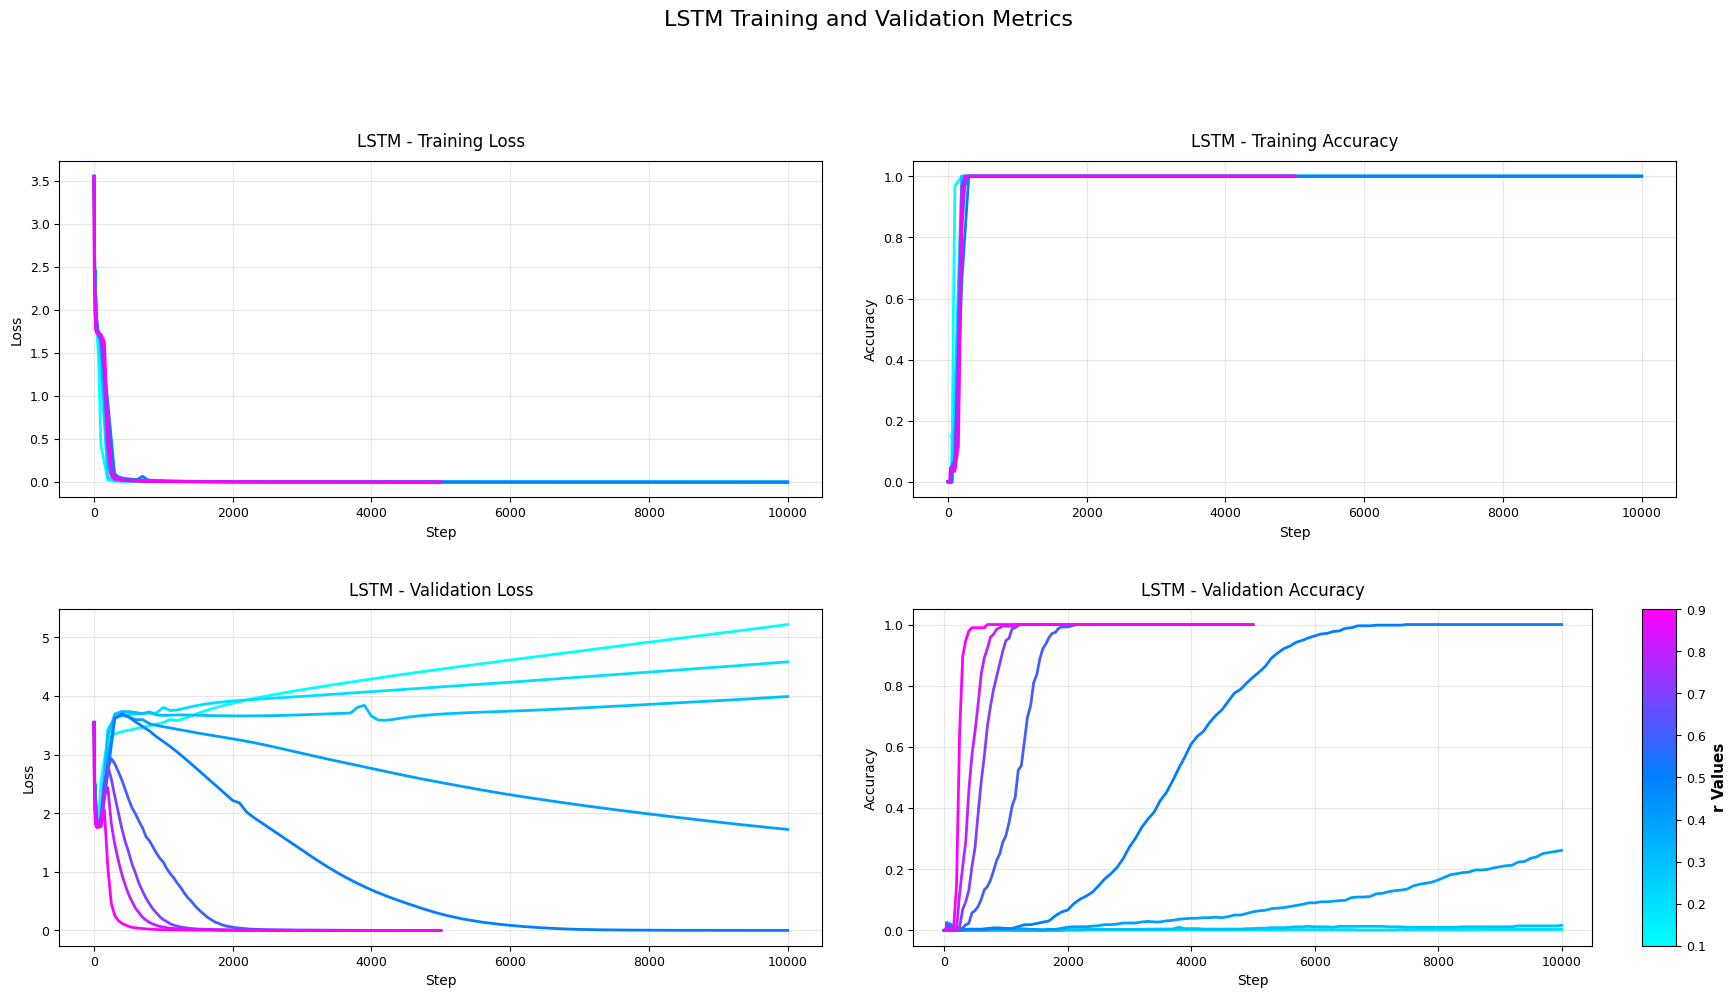

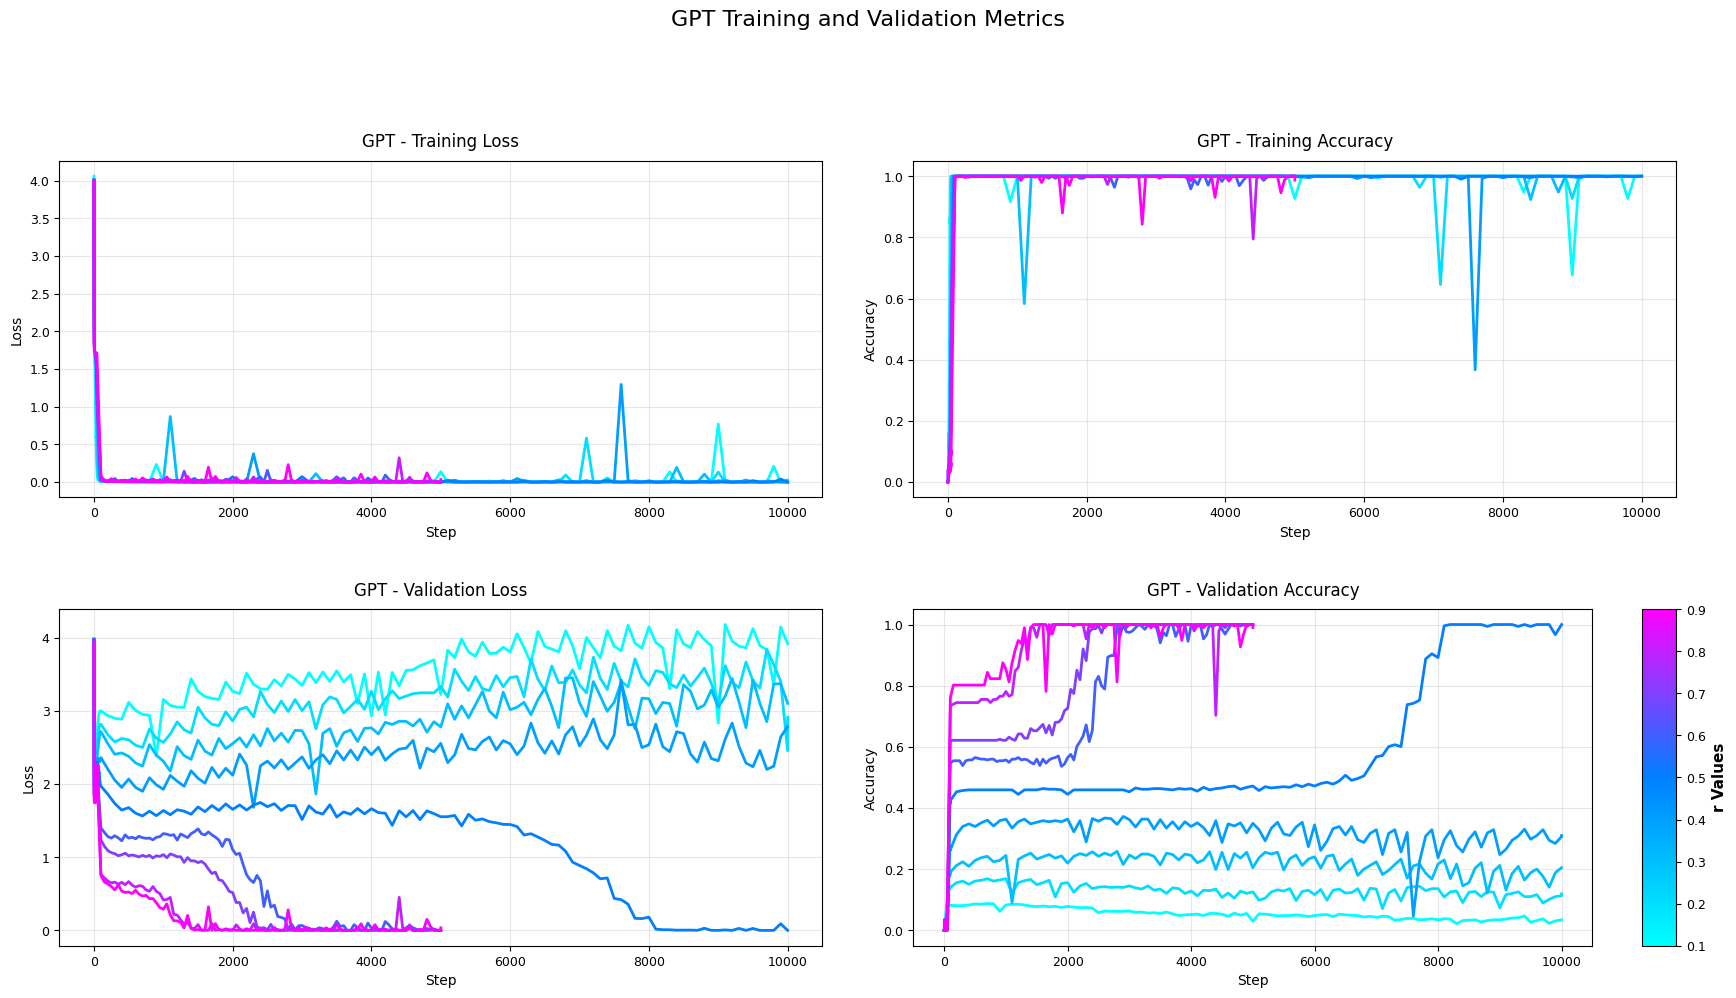

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Root log directory
base_log_dir = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs"
r_values = [round(x * 0.1, 1) for x in range(1, 10)]

# Load LSTM metrics
lstm_start = 16
step = 2
lstm_metrics_all = []
for i, r in enumerate(r_values):
    folder = str(lstm_start + i * step)
    path = os.path.join(base_log_dir, folder, f"lstm_r={r}.pth")
    if os.path.exists(path):
        metrics = torch.load(path)
        lstm_metrics_all.append((r, metrics))

# Load GPT metrics
gpt_start = 34
gpt_metrics_all = []
for i, r in enumerate(r_values):
    folder = str(gpt_start + i * step)
    path = os.path.join(base_log_dir, folder, f"gpt_r={r}.pth")
    if os.path.exists(path):
        metrics = torch.load(path)
        gpt_metrics_all.append((r, metrics))

# Helper to convert torch.Tensors to floats
def to_np(x):
    return [t.item() if isinstance(t, torch.Tensor) else t for t in x]

# Create enhanced cyan to magenta colormap
colors = ["#00FFFF", "#0080FF", "#FF00FF"]  # Light Cyan → Blue → Magenta
cmap = LinearSegmentedColormap.from_list("enhanced_cyan_magenta", colors)
r_to_color = {r: cmap(i/(len(r_values)-1)) for i, r in enumerate(r_values)}

# === PLOT: LSTM All Metrics === #
fig_lstm, ax = plt.subplots(2, 2, figsize=(18, 10))

for r, metrics in lstm_metrics_all:
    steps = list(metrics["steps_epoch"].values())
    train_loss = metrics["train"]["loss"][:len(steps)]
    train_acc = to_np(metrics["train"]["accuracy"][:len(steps)])
    val_loss = metrics["test"]["loss"][:len(steps)]
    val_acc = to_np(metrics["test"]["accuracy"][:len(steps)])
    color = r_to_color[r]

    ax[0, 0].plot(steps, train_loss, color=color, linewidth=2)
    ax[0, 1].plot(steps, train_acc, color=color, linewidth=2)
    ax[1, 0].plot(steps, val_loss, color=color, linewidth=2)
    ax[1, 1].plot(steps, val_acc, color=color, linewidth=2)

# Titles and labels with improved formatting
ax[0, 0].set_title("LSTM - Training Loss", fontsize=12, pad=10)
ax[0, 1].set_title("LSTM - Training Accuracy", fontsize=12, pad=10)
ax[1, 0].set_title("LSTM - Validation Loss", fontsize=12, pad=10)
ax[1, 1].set_title("LSTM - Validation Accuracy", fontsize=12, pad=10)

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("Step", fontsize=10)
        ax[i, j].grid(True, alpha=0.3)
        ax[i, j].tick_params(axis='both', which='major', labelsize=9)

ax[0, 0].set_ylabel("Loss", fontsize=10)
ax[1, 0].set_ylabel("Loss", fontsize=10)
ax[0, 1].set_ylabel("Accuracy", fontsize=10)
ax[1, 1].set_ylabel("Accuracy", fontsize=10)

# Add professional colorbar legend
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(r_values), vmax=max(r_values)))
cbar = fig_lstm.colorbar(sm, cax=cax)
cbar.set_label('r Values', fontsize=11, weight='bold')
cbar.ax.tick_params(labelsize=9)

# Main title and layout
fig_lstm.suptitle("LSTM Training and Validation Metrics", fontsize=16, y=1.02)
fig_lstm.tight_layout(pad=3.0)

# === PLOT: GPT All Metrics === #
fig_gpt, ax = plt.subplots(2, 2, figsize=(18, 10))

for r, metrics in gpt_metrics_all:
    steps = list(metrics["steps_epoch"].values())
    train_loss = metrics["train"]["loss"][:len(steps)]
    train_acc = to_np(metrics["train"]["accuracy"][:len(steps)])
    val_loss = metrics["test"]["loss"][:len(steps)]
    val_acc = to_np(metrics["test"]["accuracy"][:len(steps)])
    color = r_to_color[r]

    ax[0, 0].plot(steps, train_loss, color=color, linewidth=2)
    ax[0, 1].plot(steps, train_acc, color=color, linewidth=2)
    ax[1, 0].plot(steps, val_loss, color=color, linewidth=2)
    ax[1, 1].plot(steps, val_acc, color=color, linewidth=2)

# Titles and labels with improved formatting
ax[0, 0].set_title("GPT - Training Loss", fontsize=12, pad=10)
ax[0, 1].set_title("GPT - Training Accuracy", fontsize=12, pad=10)
ax[1, 0].set_title("GPT - Validation Loss", fontsize=12, pad=10)
ax[1, 1].set_title("GPT - Validation Accuracy", fontsize=12, pad=10)

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("Step", fontsize=10)
        ax[i, j].grid(True, alpha=0.3)
        ax[i, j].tick_params(axis='both', which='major', labelsize=9)

ax[0, 0].set_ylabel("Loss", fontsize=10)
ax[1, 0].set_ylabel("Loss", fontsize=10)
ax[0, 1].set_ylabel("Accuracy", fontsize=10)
ax[1, 1].set_ylabel("Accuracy", fontsize=10)

# Add professional colorbar legend
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(r_values), vmax=max(r_values)))
cbar = fig_gpt.colorbar(sm, cax=cax)
cbar.set_label('r Values', fontsize=11, weight='bold')
cbar.ax.tick_params(labelsize=9)

# Main title and layout
fig_gpt.suptitle("GPT Training and Validation Metrics", fontsize=16, y=1.02)
fig_gpt.tight_layout(pad=3.0)

plt.show()

✅ Loaded GPT r=0.1 → /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/34/gpt_r=0.1.pth
✅ Loaded GPT r=0.2 → /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/36/gpt_r=0.2.pth
✅ Loaded GPT r=0.3 → /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/38/gpt_r=0.3.pth
✅ Loaded GPT r=0.4 → /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/40/gpt_r=0.4.pth
✅ Loaded GPT r=0.5 → /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/42/gpt_r=0.5.pth
✅ Loaded GPT r=0.6 → /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/44/gpt_r=0.6.pth
✅ Loaded GPT r=0.7 → /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/46/gpt_r=0.7.pth
✅ Loaded GPT r=0.8 → /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/48/gpt_r=0.8.pth
✅ Loaded GPT r=0.9 → /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/50/gpt_r=0.9.pth


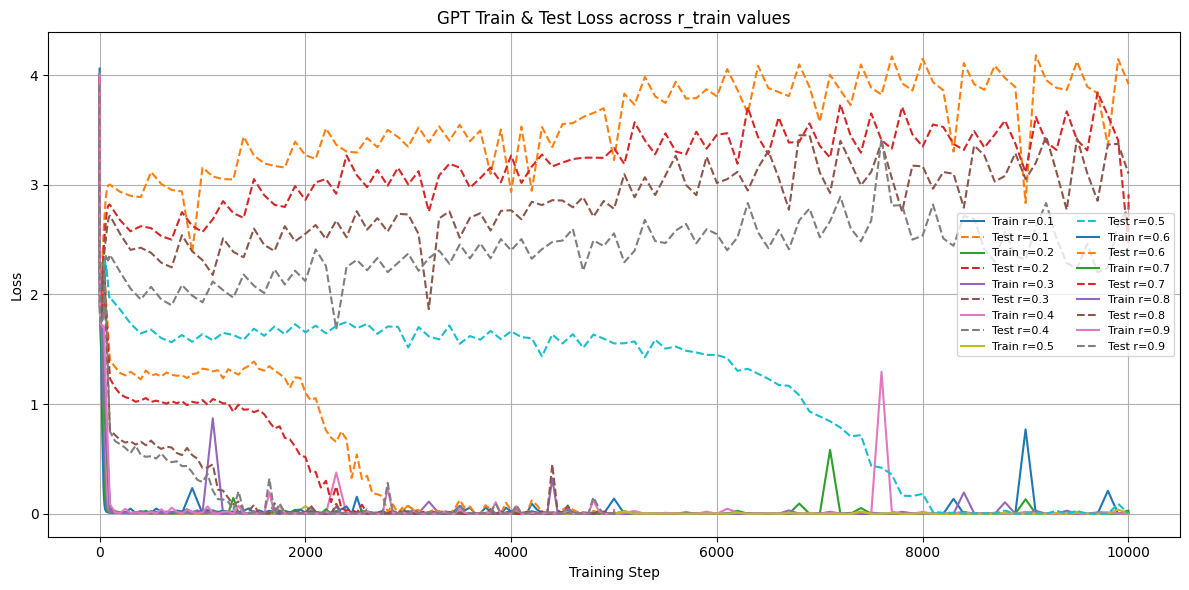

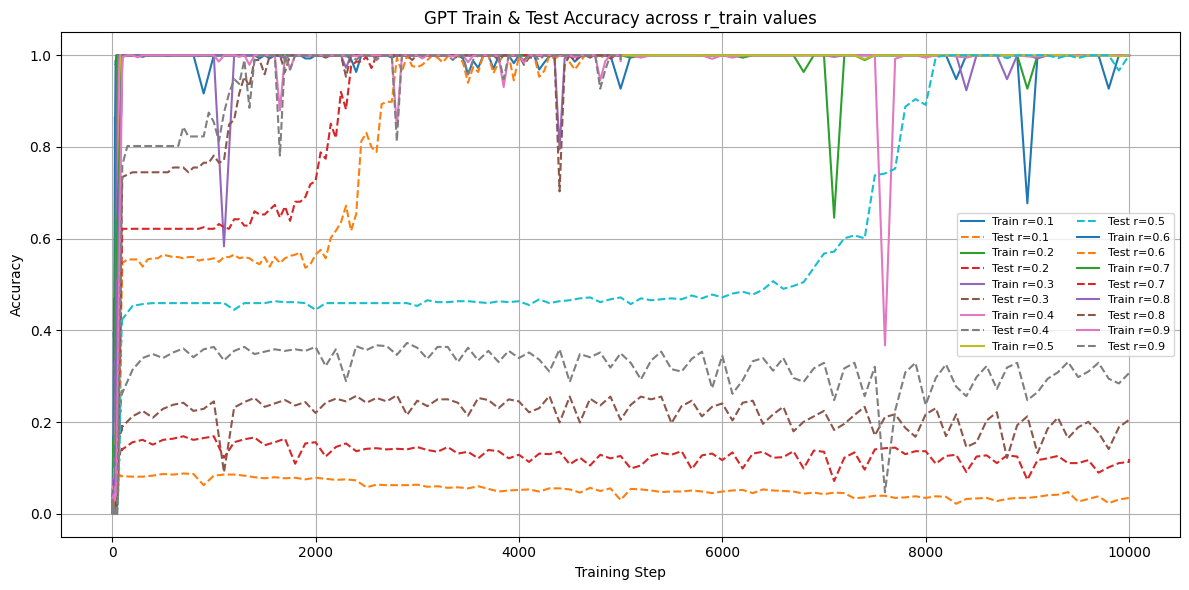

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

# Root log directory
base_log_dir = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs"
r_values = [round(x * 0.1, 1) for x in range(1, 10)]
gpt_start = 34
step = 2
gpt_metrics_all = []

# Load all GPT logs
for i, r in enumerate(r_values):
    folder = str(gpt_start + i * step)
    path = os.path.join(base_log_dir, folder, f"gpt_r={r}.pth")
    if os.path.exists(path):
        print(f"✅ Loaded GPT r={r} → {path}")
        metrics = torch.load(path)
        gpt_metrics_all.append((r, metrics))
    else:
        print(f"⚠️ Missing GPT file for r={r} at {path}")

# Convert torch.Tensor list to float list
def to_np(x): return [t.item() if isinstance(t, torch.Tensor) else t for t in x]

# Combined Loss Plot
plt.figure(figsize=(12, 6))
for r, metrics in gpt_metrics_all:
    steps = list(metrics["steps_epoch"].values())
    train_loss = metrics["train"]["loss"][:len(steps)]
    test_loss = metrics["test"]["loss"][:len(steps)]

    plt.plot(steps, train_loss, label=f"Train r={r}", linestyle="-")
    plt.plot(steps, test_loss, label=f"Test r={r}", linestyle="--")

plt.title("GPT Train & Test Loss across r_train values")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# Combined Accuracy Plot
plt.figure(figsize=(12, 6))
for r, metrics in gpt_metrics_all:
    steps = list(metrics["steps_epoch"].values())
    train_acc = to_np(metrics["train"]["accuracy"][:len(steps)])
    test_acc = to_np(metrics["test"]["accuracy"][:len(steps)])

    plt.plot(steps, train_acc, label=f"Train r={r}", linestyle="-")
    plt.plot(steps, test_acc, label=f"Test r={r}", linestyle="--")

plt.title("GPT Train & Test Accuracy across r_train values")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


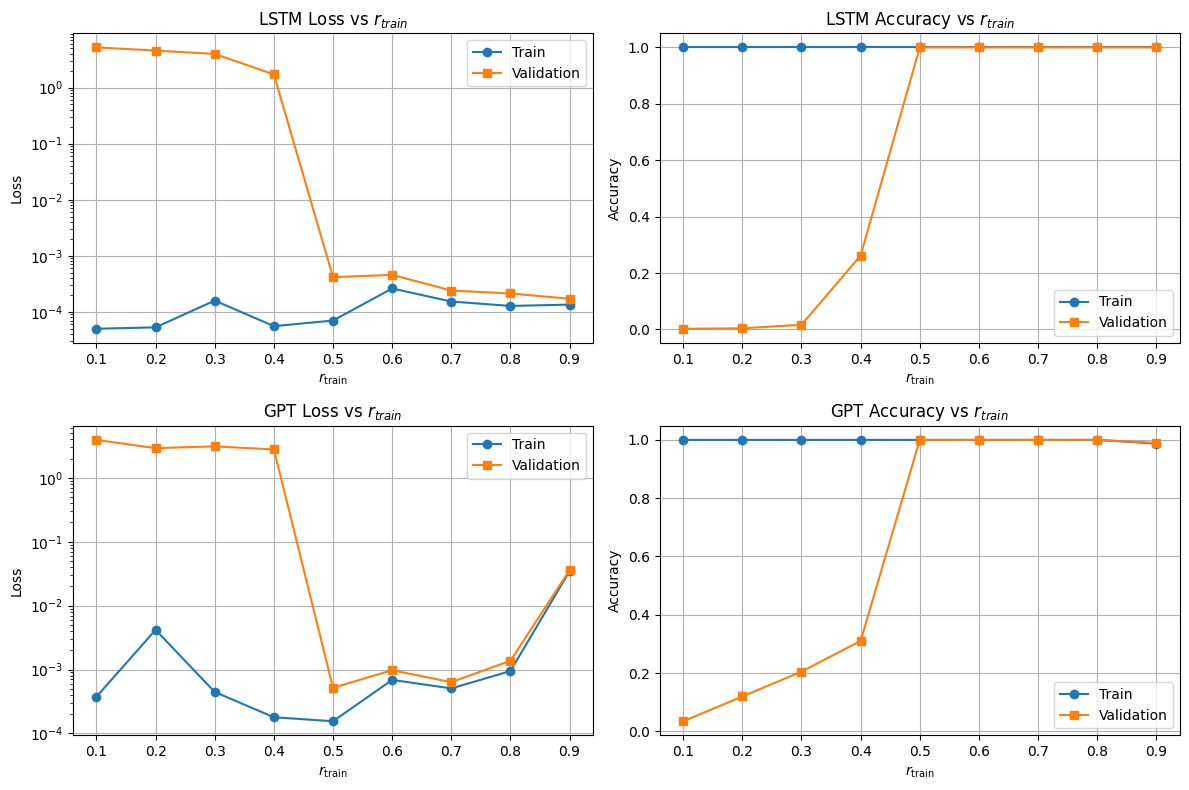

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper to extract final values
def extract_final_stats(metrics_all):
    r_vals = []
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    for r, metrics in metrics_all:
        r_vals.append(r)
        # Use the last index from steps_epoch
        last_idx = len(metrics["steps_epoch"]) - 1

        train_loss.append(metrics["train"]["loss"][last_idx])
        test_loss.append(metrics["test"]["loss"][last_idx])
        train_acc.append(metrics["train"]["accuracy"][last_idx].item())
        test_acc.append(metrics["test"]["accuracy"][last_idx].item())

    return np.array(r_vals), train_loss, test_loss, train_acc, test_acc

# Extract values
r_lstm, l_train_l, l_test_l, l_train_a, l_test_a = extract_final_stats(lstm_metrics_all)
r_gpt, g_train_l, g_test_l, g_train_a, g_test_a = extract_final_stats(gpt_metrics_all)

# Sort by r values in case they're not already sorted
lstm_sorted_idx = np.argsort(r_lstm)
gpt_sorted_idx = np.argsort(r_gpt)

r_lstm, l_train_l, l_test_l, l_train_a, l_test_a = (
    r_lstm[lstm_sorted_idx],
    np.array(l_train_l)[lstm_sorted_idx],
    np.array(l_test_l)[lstm_sorted_idx],
    np.array(l_train_a)[lstm_sorted_idx],
    np.array(l_test_a)[lstm_sorted_idx],
)

r_gpt, g_train_l, g_test_l, g_train_a, g_test_a = (
    r_gpt[gpt_sorted_idx],
    np.array(g_train_l)[gpt_sorted_idx],
    np.array(g_test_l)[gpt_sorted_idx],
    np.array(g_train_a)[gpt_sorted_idx],
    np.array(g_test_a)[gpt_sorted_idx],
)

# Plot: 2 columns (Loss, Accuracy) x 2 rows (LSTM, GPT)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# LSTM Loss (log y-axis)
axs[0, 0].plot(r_lstm, l_train_l, label="Train", marker='o')
axs[0, 0].plot(r_lstm, l_test_l, label="Validation", marker='s')
axs[0, 0].set_title("LSTM Loss vs $r_{train}$")
axs[0, 0].set_xlabel(r"$r_{\text{train}}$")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_yscale("log")
axs[0, 0].grid(True)
axs[0, 0].legend()

# LSTM Accuracy
axs[0, 1].plot(r_lstm, l_train_a, label="Train", marker='o')
axs[0, 1].plot(r_lstm, l_test_a, label="Validation", marker='s')
axs[0, 1].set_title("LSTM Accuracy vs $r_{train}$")
axs[0, 1].set_xlabel(r"$r_{\text{train}}$")
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].grid(True)
axs[0, 1].legend()

# GPT Loss (log y-axis)
axs[1, 0].plot(r_gpt, g_train_l, label="Train", marker='o')
axs[1, 0].plot(r_gpt, g_test_l, label="Validation", marker='s')
axs[1, 0].set_title("GPT Loss vs $r_{train}$")
axs[1, 0].set_xlabel(r"$r_{\text{train}}$")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_yscale("log")
axs[1, 0].grid(True)
axs[1, 0].legend()

# GPT Accuracy
axs[1, 1].plot(r_gpt, g_train_a, label="Train", marker='o')
axs[1, 1].plot(r_gpt, g_test_a, label="Validation", marker='s')
axs[1, 1].set_title("GPT Accuracy vs $r_{train}$")
axs[1, 1].set_xlabel(r"$r_{\text{train}}$")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].grid(True)
axs[1, 1].legend()

plt.tight_layout()
plt.show()


# Train and evaluate two sequence models (LSTM and GPT) on arithmetic operations modulo a prime number P=11


In [ ]:
import torch
from train import Arguments, train
from data import get_arithmetic_dataset
from torch.utils.data import Subset
import matplotlib.pyplot as plt

def create_separate_datasets(args, operation_order):
    """Create datasets for either binary (2) or ternary (3) operations"""
    (train_dataset, valid_dataset), tokenizer, MAX_LENGTH, padding_index = get_arithmetic_dataset(
        args.p, args.p, args.operator, args.r_train, operation_order,
        is_symmetric=False, shuffle=True, seed=args.seed
    )

    # Filter to only include the specified operation order
    if isinstance(operation_order, list):
        operation_order = operation_order[0]  # Take first if list provided

    indices = [i for i, x in enumerate(train_dataset) if x[2] == (3 if operation_order == 2 else 5)]
    train_dataset = Subset(train_dataset, indices)

    indices = [i for i, x in enumerate(valid_dataset) if x[2] == (3 if operation_order == 2 else 5)]
    valid_dataset = Subset(valid_dataset, indices)

    print(f"\nDataset sizes for {'binary' if operation_order == 2 else 'ternary'} operations:")
    print(f"Train: {len(train_dataset)}, Val: {len(valid_dataset)}")

    return (train_dataset, valid_dataset), tokenizer, MAX_LENGTH, padding_index

def train_separate_operations(args):
    """Train separate models for binary and ternary operations"""
    # Binary training
    print("\n=== Training Binary Model ===")
    binary_args = Arguments()  # Create new instance
    # Copy all attributes from original args
    for key, value in vars(args).items():
        setattr(binary_args, key, value)

    # Set binary-specific paths and params
    binary_args.exp_name = f"{args.exp_name}_binary"
    binary_args.operation_orders = 2
    binary_args.log_dir = os.path.join(args.log_dir, "binary")  # New binary subdirectory

    # Create binary directory if it doesn't exist
    os.makedirs(binary_args.log_dir, exist_ok=True)

    binary_data = create_separate_datasets(binary_args, 2)
    binary_metrics, binary_path = train(binary_args)

    # Ternary training
    print("\n=== Training Ternary Model ===")
    ternary_args = Arguments()  # Create new instance
    # Copy all attributes from original args
    for key, value in vars(args).items():
        setattr(ternary_args, key, value)

    # Set ternary-specific paths and params
    ternary_args.exp_name = f"{args.exp_name}_ternary"
    ternary_args.operation_orders = 3
    ternary_args.log_dir = os.path.join(args.log_dir, "ternary")  # New ternary subdirectory

    # Create ternary directory if it doesn't exist
    os.makedirs(ternary_args.log_dir, exist_ok=True)

    ternary_data = create_separate_datasets(ternary_args, 3)
    ternary_metrics, ternary_path = train(ternary_args)

    return {
        'binary': (binary_metrics, binary_path),
        'ternary': (ternary_metrics, ternary_path)
    }

In [ ]:
# Initialize configuration
args = Arguments()
args.p = 31
args.operator = "+"
args.r_train = 0.5
args.model = 'lstm'
args.n_steps = 10001
args.eval_period = 100

# Optimization
args.optimizer = 'adamw'  # [sgd, momentum, adam, adamw]
args.lr = 1e-3
args.weight_decay = 1e-0

# Training
args.n_steps = 10**4 + 1
args.eval_first = 10**2
args.eval_period = 10**2
args.print_step= 10**2
args.save_model_step = 10**3

args.save_statistic_step = 10**3
# Experiment & Miscellaneous
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.exp_id = 0
args.exp_name = "test"
args.log_dir = '/content/gdrive/MyDrive/"Colab Notebooks"/IFT6135_W25_A2_release/logs'
args.seed = 42
args.verbose = True


=== Training Binary Model ===

Dataset sizes for binary operations:
Train: 480, Val: 481
p : 31
operator : +
r_train : 0.5
model : lstm
n_steps : 10001
eval_period : 100
optimizer : adamw
lr : 0.001
weight_decay : 1.0
eval_first : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
exp_id : 0
exp_name : test_binary
log_dir : /content/gdrive/MyDrive/"Colab Notebooks"/IFT6135_W25_A2_release/logs
seed : 42
verbose : True
operation_orders : 2
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=36, bias=Tr

Training:   0%|          | 1/10001 [00:00<35:55,  4.64it/s]


Train loss : 3.545850 | Train accuracy : 0.012500 | Test loss : 3.543663 | Test accuracy : 0.016632 | lr = 0.001


Training:   1%|          | 100/10001 [00:18<24:53,  6.63it/s]


Train loss : 1.700498 | Train accuracy : 0.070833 | Test loss : 1.766537 | Test accuracy : 0.008316 | lr = 0.001


Training:   2%|▏         | 202/10001 [00:24<10:30, 15.54it/s]


Train loss : 0.931143 | Train accuracy : 0.652083 | Test loss : 2.596893 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 302/10001 [00:31<10:04, 16.05it/s]


Train loss : 0.076418 | Train accuracy : 1.000000 | Test loss : 3.446685 | Test accuracy : 0.002079 | lr = 0.001


Training:   4%|▍         | 402/10001 [00:37<10:29, 15.24it/s]


Train loss : 0.028598 | Train accuracy : 1.000000 | Test loss : 3.530227 | Test accuracy : 0.004158 | lr = 0.001


Training:   5%|▌         | 502/10001 [00:44<09:51, 16.06it/s]


Train loss : 0.019781 | Train accuracy : 1.000000 | Test loss : 3.483594 | Test accuracy : 0.006237 | lr = 0.001


Training:   6%|▌         | 602/10001 [00:50<10:01, 15.62it/s]


Train loss : 0.015806 | Train accuracy : 1.000000 | Test loss : 3.406223 | Test accuracy : 0.006237 | lr = 0.001


Training:   7%|▋         | 702/10001 [00:56<12:07, 12.79it/s]


Train loss : 0.013214 | Train accuracy : 1.000000 | Test loss : 3.319659 | Test accuracy : 0.010395 | lr = 0.001


Training:   8%|▊         | 802/10001 [01:02<09:46, 15.68it/s]


Train loss : 0.012235 | Train accuracy : 1.000000 | Test loss : 3.262285 | Test accuracy : 0.012474 | lr = 0.001


Training:   9%|▉         | 903/10001 [01:10<09:34, 15.83it/s]


Train loss : 0.011374 | Train accuracy : 1.000000 | Test loss : 3.162269 | Test accuracy : 0.012474 | lr = 0.001


Training:  10%|█         | 1001/10001 [01:15<10:41, 14.02it/s]


Train loss : 0.010835 | Train accuracy : 1.000000 | Test loss : 3.082508 | Test accuracy : 0.018711 | lr = 0.001


Training:  11%|█         | 1103/10001 [01:23<09:31, 15.58it/s]


Train loss : 0.009788 | Train accuracy : 1.000000 | Test loss : 3.012326 | Test accuracy : 0.024948 | lr = 0.001


Training:  12%|█▏        | 1203/10001 [01:28<09:12, 15.92it/s]


Train loss : 0.008816 | Train accuracy : 1.000000 | Test loss : 2.942335 | Test accuracy : 0.027027 | lr = 0.001


Training:  13%|█▎        | 1303/10001 [01:35<09:07, 15.88it/s]


Train loss : 0.007980 | Train accuracy : 1.000000 | Test loss : 2.871224 | Test accuracy : 0.033264 | lr = 0.001


Training:  14%|█▍        | 1403/10001 [01:41<10:04, 14.23it/s]


Train loss : 0.007259 | Train accuracy : 1.000000 | Test loss : 2.799117 | Test accuracy : 0.039501 | lr = 0.001


Training:  15%|█▌        | 1503/10001 [01:48<09:09, 15.48it/s]


Train loss : 0.006632 | Train accuracy : 1.000000 | Test loss : 2.725866 | Test accuracy : 0.045738 | lr = 0.001


Training:  16%|█▌        | 1603/10001 [01:53<08:47, 15.91it/s]


Train loss : 0.006080 | Train accuracy : 1.000000 | Test loss : 2.650656 | Test accuracy : 0.049896 | lr = 0.001


Training:  17%|█▋        | 1703/10001 [02:00<09:59, 13.83it/s]


Train loss : 0.005591 | Train accuracy : 1.000000 | Test loss : 2.573135 | Test accuracy : 0.047817 | lr = 0.001


Training:  18%|█▊        | 1803/10001 [02:06<08:28, 16.12it/s]


Train loss : 0.005155 | Train accuracy : 1.000000 | Test loss : 2.493232 | Test accuracy : 0.060291 | lr = 0.001


Training:  19%|█▉        | 1903/10001 [02:13<11:36, 11.63it/s]


Train loss : 0.004765 | Train accuracy : 1.000000 | Test loss : 2.411680 | Test accuracy : 0.062370 | lr = 0.001


Training:  20%|██        | 2001/10001 [02:18<09:23, 14.19it/s]


Train loss : 0.004414 | Train accuracy : 1.000000 | Test loss : 2.329278 | Test accuracy : 0.076923 | lr = 0.001


Training:  21%|██        | 2101/10001 [02:25<13:25,  9.81it/s]


Train loss : 0.004095 | Train accuracy : 1.000000 | Test loss : 2.246395 | Test accuracy : 0.079002 | lr = 0.001


Training:  22%|██▏       | 2203/10001 [02:31<08:19, 15.62it/s]


Train loss : 0.003807 | Train accuracy : 1.000000 | Test loss : 2.163094 | Test accuracy : 0.093555 | lr = 0.001


Training:  23%|██▎       | 2301/10001 [02:37<12:24, 10.34it/s]


Train loss : 0.003546 | Train accuracy : 1.000000 | Test loss : 2.080505 | Test accuracy : 0.118503 | lr = 0.001


Training:  24%|██▍       | 2403/10001 [02:44<07:57, 15.92it/s]


Train loss : 0.003308 | Train accuracy : 1.000000 | Test loss : 1.999461 | Test accuracy : 0.139293 | lr = 0.001


Training:  25%|██▌       | 2501/10001 [02:50<11:32, 10.84it/s]


Train loss : 0.003091 | Train accuracy : 1.000000 | Test loss : 1.920639 | Test accuracy : 0.155925 | lr = 0.001


Training:  26%|██▌       | 2603/10001 [02:56<08:41, 14.19it/s]


Train loss : 0.002894 | Train accuracy : 1.000000 | Test loss : 1.844925 | Test accuracy : 0.168399 | lr = 0.001


Training:  27%|██▋       | 2701/10001 [03:02<10:45, 11.32it/s]


Train loss : 0.001819 | Train accuracy : 1.000000 | Test loss : 1.783685 | Test accuracy : 0.203742 | lr = 0.001


Training:  28%|██▊       | 2803/10001 [03:09<07:34, 15.85it/s]


Train loss : 0.003365 | Train accuracy : 1.000000 | Test loss : 1.677170 | Test accuracy : 0.218295 | lr = 0.001


Training:  29%|██▉       | 2901/10001 [03:14<08:43, 13.56it/s]


Train loss : 0.003680 | Train accuracy : 1.000000 | Test loss : 1.610034 | Test accuracy : 0.230769 | lr = 0.001


Training:  30%|███       | 3001/10001 [03:21<08:25, 13.84it/s]


Train loss : 0.003549 | Train accuracy : 1.000000 | Test loss : 1.549403 | Test accuracy : 0.249480 | lr = 0.001


Training:  31%|███       | 3103/10001 [03:27<07:25, 15.48it/s]


Train loss : 0.003351 | Train accuracy : 1.000000 | Test loss : 1.488590 | Test accuracy : 0.268191 | lr = 0.001


Training:  32%|███▏      | 3203/10001 [03:34<07:04, 16.00it/s]


Train loss : 0.003152 | Train accuracy : 1.000000 | Test loss : 1.427096 | Test accuracy : 0.278586 | lr = 0.001


Training:  33%|███▎      | 3303/10001 [03:39<06:58, 16.01it/s]


Train loss : 0.002965 | Train accuracy : 1.000000 | Test loss : 1.365274 | Test accuracy : 0.286902 | lr = 0.001


Training:  34%|███▍      | 3403/10001 [03:46<07:08, 15.39it/s]


Train loss : 0.002791 | Train accuracy : 1.000000 | Test loss : 1.303635 | Test accuracy : 0.311850 | lr = 0.001


Training:  35%|███▌      | 3503/10001 [03:52<06:56, 15.60it/s]


Train loss : 0.002629 | Train accuracy : 1.000000 | Test loss : 1.242685 | Test accuracy : 0.353430 | lr = 0.001


Training:  36%|███▌      | 3603/10001 [03:59<06:36, 16.15it/s]


Train loss : 0.002478 | Train accuracy : 1.000000 | Test loss : 1.182780 | Test accuracy : 0.376299 | lr = 0.001


Training:  37%|███▋      | 3703/10001 [04:04<06:36, 15.88it/s]


Train loss : 0.002338 | Train accuracy : 1.000000 | Test loss : 1.124051 | Test accuracy : 0.397089 | lr = 0.001


Training:  38%|███▊      | 3803/10001 [04:11<06:38, 15.54it/s]


Train loss : 0.002206 | Train accuracy : 1.000000 | Test loss : 1.066499 | Test accuracy : 0.426195 | lr = 0.001


Training:  39%|███▉      | 3903/10001 [04:17<06:21, 16.00it/s]


Train loss : 0.002082 | Train accuracy : 1.000000 | Test loss : 1.010088 | Test accuracy : 0.444906 | lr = 0.001


Training:  40%|████      | 4001/10001 [04:24<07:33, 13.23it/s]


Train loss : 0.001966 | Train accuracy : 1.000000 | Test loss : 0.954829 | Test accuracy : 0.471933 | lr = 0.001


Training:  41%|████      | 4103/10001 [04:30<06:22, 15.41it/s]


Train loss : 0.001857 | Train accuracy : 1.000000 | Test loss : 0.900796 | Test accuracy : 0.505198 | lr = 0.001


Training:  42%|████▏     | 4203/10001 [04:37<06:28, 14.91it/s]


Train loss : 0.001755 | Train accuracy : 1.000000 | Test loss : 0.848104 | Test accuracy : 0.528067 | lr = 0.001


Training:  43%|████▎     | 4303/10001 [04:43<06:00, 15.81it/s]


Train loss : 0.001658 | Train accuracy : 1.000000 | Test loss : 0.796939 | Test accuracy : 0.540541 | lr = 0.001


Training:  44%|████▍     | 4403/10001 [04:49<06:05, 15.33it/s]


Train loss : 0.001568 | Train accuracy : 1.000000 | Test loss : 0.747443 | Test accuracy : 0.571726 | lr = 0.001


Training:  45%|████▌     | 4503/10001 [04:55<05:45, 15.90it/s]


Train loss : 0.001482 | Train accuracy : 1.000000 | Test loss : 0.699657 | Test accuracy : 0.596674 | lr = 0.001


Training:  46%|████▌     | 4603/10001 [05:02<05:57, 15.11it/s]


Train loss : 0.001403 | Train accuracy : 1.000000 | Test loss : 0.653516 | Test accuracy : 0.621622 | lr = 0.001


Training:  47%|████▋     | 4703/10001 [05:07<05:27, 16.17it/s]


Train loss : 0.001328 | Train accuracy : 1.000000 | Test loss : 0.608900 | Test accuracy : 0.642412 | lr = 0.001


Training:  48%|████▊     | 4803/10001 [05:14<06:19, 13.69it/s]


Train loss : 0.001257 | Train accuracy : 1.000000 | Test loss : 0.565780 | Test accuracy : 0.650728 | lr = 0.001


Training:  49%|████▉     | 4903/10001 [05:20<05:14, 16.20it/s]


Train loss : 0.001191 | Train accuracy : 1.000000 | Test loss : 0.524487 | Test accuracy : 0.681913 | lr = 0.001


Training:  50%|█████     | 5001/10001 [05:27<08:43,  9.55it/s]


Train loss : 0.001128 | Train accuracy : 1.000000 | Test loss : 0.485475 | Test accuracy : 0.704782 | lr = 0.001


Training:  51%|█████     | 5103/10001 [05:33<05:07, 15.94it/s]


Train loss : 0.001069 | Train accuracy : 1.000000 | Test loss : 0.448891 | Test accuracy : 0.735967 | lr = 0.001


Training:  52%|█████▏    | 5201/10001 [05:39<07:55, 10.09it/s]


Train loss : 0.001014 | Train accuracy : 1.000000 | Test loss : 0.414690 | Test accuracy : 0.752599 | lr = 0.001


Training:  53%|█████▎    | 5303/10001 [05:45<05:01, 15.61it/s]


Train loss : 0.000961 | Train accuracy : 1.000000 | Test loss : 0.382758 | Test accuracy : 0.765073 | lr = 0.001


Training:  54%|█████▍    | 5401/10001 [05:52<06:53, 11.12it/s]


Train loss : 0.000912 | Train accuracy : 1.000000 | Test loss : 0.352854 | Test accuracy : 0.783784 | lr = 0.001


Training:  55%|█████▌    | 5503/10001 [05:58<04:47, 15.63it/s]


Train loss : 0.000865 | Train accuracy : 1.000000 | Test loss : 0.324475 | Test accuracy : 0.804574 | lr = 0.001


Training:  56%|█████▌    | 5601/10001 [06:04<06:28, 11.32it/s]


Train loss : 0.000821 | Train accuracy : 1.000000 | Test loss : 0.296898 | Test accuracy : 0.814969 | lr = 0.001


Training:  57%|█████▋    | 5703/10001 [06:10<04:34, 15.68it/s]


Train loss : 0.000780 | Train accuracy : 1.000000 | Test loss : 0.270292 | Test accuracy : 0.831601 | lr = 0.001


Training:  58%|█████▊    | 5801/10001 [06:16<06:16, 11.16it/s]


Train loss : 0.000740 | Train accuracy : 1.000000 | Test loss : 0.245897 | Test accuracy : 0.848233 | lr = 0.001


Training:  59%|█████▉    | 5903/10001 [06:23<04:28, 15.29it/s]


Train loss : 0.000703 | Train accuracy : 1.000000 | Test loss : 0.223933 | Test accuracy : 0.852391 | lr = 0.001


Training:  60%|██████    | 6001/10001 [06:29<06:06, 10.90it/s]


Train loss : 0.000669 | Train accuracy : 1.000000 | Test loss : 0.204015 | Test accuracy : 0.871102 | lr = 0.001


Training:  61%|██████    | 6103/10001 [06:36<04:09, 15.63it/s]


Train loss : 0.000636 | Train accuracy : 1.000000 | Test loss : 0.185788 | Test accuracy : 0.883576 | lr = 0.001


Training:  62%|██████▏   | 6201/10001 [06:42<05:13, 12.13it/s]


Train loss : 0.000604 | Train accuracy : 1.000000 | Test loss : 0.168925 | Test accuracy : 0.893971 | lr = 0.001


Training:  63%|██████▎   | 6303/10001 [06:48<03:47, 16.26it/s]


Train loss : 0.000574 | Train accuracy : 1.000000 | Test loss : 0.153043 | Test accuracy : 0.900208 | lr = 0.001


Training:  64%|██████▍   | 6403/10001 [06:54<03:51, 15.55it/s]


Train loss : 0.000546 | Train accuracy : 1.000000 | Test loss : 0.138115 | Test accuracy : 0.912682 | lr = 0.001


Training:  65%|██████▌   | 6503/10001 [07:01<03:40, 15.85it/s]


Train loss : 0.000520 | Train accuracy : 1.000000 | Test loss : 0.124553 | Test accuracy : 0.923077 | lr = 0.001


Training:  66%|██████▌   | 6603/10001 [07:07<03:34, 15.82it/s]


Train loss : 0.000494 | Train accuracy : 1.000000 | Test loss : 0.112321 | Test accuracy : 0.931393 | lr = 0.001


Training:  67%|██████▋   | 6703/10001 [07:13<03:24, 16.13it/s]


Train loss : 0.000470 | Train accuracy : 1.000000 | Test loss : 0.101224 | Test accuracy : 0.939709 | lr = 0.001


Training:  68%|██████▊   | 6803/10001 [07:19<03:26, 15.49it/s]


Train loss : 0.000447 | Train accuracy : 1.000000 | Test loss : 0.091062 | Test accuracy : 0.950104 | lr = 0.001


Training:  69%|██████▉   | 6903/10001 [07:26<03:19, 15.55it/s]


Train loss : 0.000426 | Train accuracy : 1.000000 | Test loss : 0.081638 | Test accuracy : 0.958420 | lr = 0.001


Training:  70%|███████   | 7001/10001 [07:32<04:03, 12.32it/s]


Train loss : 0.000405 | Train accuracy : 1.000000 | Test loss : 0.072861 | Test accuracy : 0.962578 | lr = 0.001


Training:  71%|███████   | 7103/10001 [07:39<03:02, 15.87it/s]


Train loss : 0.000385 | Train accuracy : 1.000000 | Test loss : 0.064761 | Test accuracy : 0.966736 | lr = 0.001


Training:  72%|███████▏  | 7203/10001 [07:45<03:20, 13.96it/s]


Train loss : 0.000367 | Train accuracy : 1.000000 | Test loss : 0.057344 | Test accuracy : 0.975052 | lr = 0.001


Training:  73%|███████▎  | 7303/10001 [07:51<02:50, 15.80it/s]


Train loss : 0.000349 | Train accuracy : 1.000000 | Test loss : 0.050594 | Test accuracy : 0.983368 | lr = 0.001


Training:  74%|███████▍  | 7403/10001 [07:57<02:45, 15.69it/s]


Train loss : 0.000332 | Train accuracy : 1.000000 | Test loss : 0.044469 | Test accuracy : 0.987526 | lr = 0.001


Training:  75%|███████▌  | 7501/10001 [08:04<05:22,  7.74it/s]


Train loss : 0.000316 | Train accuracy : 1.000000 | Test loss : 0.038900 | Test accuracy : 0.993763 | lr = 0.001


Training:  76%|███████▌  | 7603/10001 [08:11<02:34, 15.53it/s]


Train loss : 0.000300 | Train accuracy : 1.000000 | Test loss : 0.033844 | Test accuracy : 0.995842 | lr = 0.001


Training:  77%|███████▋  | 7703/10001 [08:18<02:23, 16.00it/s]


Train loss : 0.000286 | Train accuracy : 1.000000 | Test loss : 0.029310 | Test accuracy : 0.997921 | lr = 0.001


Training:  78%|███████▊  | 7803/10001 [08:24<02:17, 15.95it/s]


Train loss : 0.000272 | Train accuracy : 1.000000 | Test loss : 0.025356 | Test accuracy : 0.997921 | lr = 0.001


Training:  79%|███████▉  | 7903/10001 [08:30<02:12, 15.81it/s]


Train loss : 0.000259 | Train accuracy : 1.000000 | Test loss : 0.021942 | Test accuracy : 0.997921 | lr = 0.001


Training:  80%|████████  | 8001/10001 [08:36<02:23, 13.92it/s]


Train loss : 0.000247 | Train accuracy : 1.000000 | Test loss : 0.018982 | Test accuracy : 0.997921 | lr = 0.001


Training:  81%|████████  | 8103/10001 [08:43<02:00, 15.78it/s]


Train loss : 0.000235 | Train accuracy : 1.000000 | Test loss : 0.016417 | Test accuracy : 0.997921 | lr = 0.001


Training:  82%|████████▏ | 8203/10001 [08:49<01:53, 15.83it/s]


Train loss : 0.000224 | Train accuracy : 1.000000 | Test loss : 0.014197 | Test accuracy : 1.000000 | lr = 0.001


Training:  83%|████████▎ | 8303/10001 [08:56<01:46, 15.93it/s]


Train loss : 0.000213 | Train accuracy : 1.000000 | Test loss : 0.012274 | Test accuracy : 1.000000 | lr = 0.001


Training:  84%|████████▍ | 8403/10001 [09:01<01:41, 15.78it/s]


Train loss : 0.000203 | Train accuracy : 1.000000 | Test loss : 0.010607 | Test accuracy : 1.000000 | lr = 0.001


Training:  85%|████████▌ | 8503/10001 [09:08<01:39, 15.12it/s]


Train loss : 0.000193 | Train accuracy : 1.000000 | Test loss : 0.009161 | Test accuracy : 1.000000 | lr = 0.001


Training:  86%|████████▌ | 8603/10001 [09:14<01:27, 16.00it/s]


Train loss : 0.000184 | Train accuracy : 1.000000 | Test loss : 0.007904 | Test accuracy : 1.000000 | lr = 0.001


Training:  87%|████████▋ | 8703/10001 [09:21<01:26, 14.97it/s]


Train loss : 0.000175 | Train accuracy : 1.000000 | Test loss : 0.006815 | Test accuracy : 1.000000 | lr = 0.001


Training:  88%|████████▊ | 8803/10001 [09:26<01:14, 16.07it/s]


Train loss : 0.000167 | Train accuracy : 1.000000 | Test loss : 0.005880 | Test accuracy : 1.000000 | lr = 0.001


Training:  89%|████████▉ | 8903/10001 [09:33<01:16, 14.26it/s]


Train loss : 0.000159 | Train accuracy : 1.000000 | Test loss : 0.005087 | Test accuracy : 1.000000 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [09:39<01:39, 10.02it/s]


Train loss : 0.000151 | Train accuracy : 1.000000 | Test loss : 0.004408 | Test accuracy : 1.000000 | lr = 0.001


Training:  91%|█████████ | 9103/10001 [09:46<01:10, 12.67it/s]


Train loss : 0.000144 | Train accuracy : 1.000000 | Test loss : 0.003825 | Test accuracy : 1.000000 | lr = 0.001


Training:  92%|█████████▏| 9203/10001 [09:52<00:50, 15.90it/s]


Train loss : 0.000137 | Train accuracy : 1.000000 | Test loss : 0.003324 | Test accuracy : 1.000000 | lr = 0.001


Training:  93%|█████████▎| 9301/10001 [09:58<01:10,  9.97it/s]


Train loss : 0.000131 | Train accuracy : 1.000000 | Test loss : 0.002895 | Test accuracy : 1.000000 | lr = 0.001


Training:  94%|█████████▍| 9403/10001 [10:04<00:36, 16.17it/s]


Train loss : 0.000124 | Train accuracy : 1.000000 | Test loss : 0.002528 | Test accuracy : 1.000000 | lr = 0.001


Training:  95%|█████████▌| 9501/10001 [10:11<00:48, 10.37it/s]


Train loss : 0.000118 | Train accuracy : 1.000000 | Test loss : 0.002213 | Test accuracy : 1.000000 | lr = 0.001


Training:  96%|█████████▌| 9603/10001 [10:17<00:25, 15.66it/s]


Train loss : 0.000113 | Train accuracy : 1.000000 | Test loss : 0.001941 | Test accuracy : 1.000000 | lr = 0.001


Training:  97%|█████████▋| 9701/10001 [10:23<00:27, 10.85it/s]


Train loss : 0.000107 | Train accuracy : 1.000000 | Test loss : 0.001705 | Test accuracy : 1.000000 | lr = 0.001


Training:  98%|█████████▊| 9803/10001 [10:30<00:12, 15.98it/s]


Train loss : 0.000102 | Train accuracy : 1.000000 | Test loss : 0.001499 | Test accuracy : 1.000000 | lr = 0.001


Training:  99%|█████████▉| 9901/10001 [10:36<00:09, 10.58it/s]


Train loss : 0.000097 | Train accuracy : 1.000000 | Test loss : 0.001319 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|█████████▉| 9999/10001 [10:42<00:00, 17.27it/s]


Train loss : 0.000093 | Train accuracy : 1.000000 | Test loss : 0.001162 | Test accuracy : 1.000000 | lr = 0.001

Train loss : 0.000093 | Train accuracy : 1.000000 | Test loss : 0.001161 | Test accuracy : 1.000000 | lr = 0.001


Training: 100%|██████████| 10001/10001 [10:42<00:00, 15.56it/s]



=== Training Ternary Model ===

Dataset sizes for ternary operations:
Train: 14896, Val: 14895
p : 31
operator : +
r_train : 0.5
model : lstm
n_steps : 10001
eval_period : 100
optimizer : adamw
lr : 0.001
weight_decay : 1.0
eval_first : 100
print_step : 100
save_model_step : 1000
save_statistic_step : 1000
device : cuda
exp_id : 0
exp_name : test_ternary
log_dir : /content/gdrive/MyDrive/"Colab Notebooks"/IFT6135_W25_A2_release/logs
seed : 42
verbose : True
operation_orders : 3
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=36, 

Training:   0%|          | 0/334 [00:00<?, ?it/s]


Train loss : 3.537086 | Train accuracy : 0.021751 | Test loss : 3.537475 | Test accuracy : 0.023296 | lr = 0.001


Training:   1%|          | 3/334 [03:38<6:42:04, 72.88s/it]


Train loss : 1.730811 | Train accuracy : 0.031888 | Test loss : 1.731059 | Test accuracy : 0.032628 | lr = 0.001


Training:   2%|▏         | 6/334 [04:08<2:11:40, 24.09s/it]


Train loss : 1.722491 | Train accuracy : 0.032559 | Test loss : 1.724090 | Test accuracy : 0.031957 | lr = 0.001


Training:   3%|▎         | 10/334 [04:21<41:49,  7.74s/it]


Train loss : 1.721173 | Train accuracy : 0.034237 | Test loss : 1.723091 | Test accuracy : 0.030279 | lr = 0.001


Training:   4%|▍         | 13/334 [04:27<21:03,  3.94s/it]


Train loss : 1.721779 | Train accuracy : 0.032291 | Test loss : 1.723629 | Test accuracy : 0.032226 | lr = 0.001


Training:   5%|▍         | 16/334 [04:36<16:56,  3.20s/it]


Train loss : 1.719620 | Train accuracy : 0.033096 | Test loss : 1.721476 | Test accuracy : 0.031420 | lr = 0.001


Training:   6%|▌         | 20/334 [04:48<17:17,  3.30s/it]


Train loss : 1.719151 | Train accuracy : 0.034036 | Test loss : 1.720653 | Test accuracy : 0.030547 | lr = 0.001


Training:   7%|▋         | 23/334 [04:54<12:24,  2.39s/it]


Train loss : 1.719937 | Train accuracy : 0.032022 | Test loss : 1.721014 | Test accuracy : 0.032158 | lr = 0.001


Training:   8%|▊         | 26/334 [05:03<13:12,  2.57s/it]


Train loss : 1.718806 | Train accuracy : 0.035781 | Test loss : 1.720280 | Test accuracy : 0.028667 | lr = 0.001


Training:   9%|▉         | 30/334 [05:15<16:01,  3.16s/it]


Train loss : 1.718401 | Train accuracy : 0.036520 | Test loss : 1.720056 | Test accuracy : 0.027929 | lr = 0.001


Training:  10%|▉         | 33/334 [05:21<11:37,  2.32s/it]


Train loss : 1.719206 | Train accuracy : 0.033230 | Test loss : 1.721535 | Test accuracy : 0.030749 | lr = 0.001


Training:  11%|█         | 36/334 [05:30<12:28,  2.51s/it]


Train loss : 1.718240 | Train accuracy : 0.033767 | Test loss : 1.720121 | Test accuracy : 0.030279 | lr = 0.001


Training:  12%|█▏        | 40/334 [05:42<15:26,  3.15s/it]


Train loss : 1.717693 | Train accuracy : 0.034774 | Test loss : 1.720602 | Test accuracy : 0.029742 | lr = 0.001


Training:  13%|█▎        | 43/334 [05:48<11:07,  2.29s/it]


Train loss : 1.719028 | Train accuracy : 0.033902 | Test loss : 1.721060 | Test accuracy : 0.030077 | lr = 0.001


Training:  14%|█▍        | 46/334 [05:57<12:01,  2.50s/it]


Train loss : 1.718029 | Train accuracy : 0.034372 | Test loss : 1.720302 | Test accuracy : 0.029540 | lr = 0.001


Training:  15%|█▍        | 50/334 [06:10<14:47,  3.12s/it]


Train loss : 1.717265 | Train accuracy : 0.035714 | Test loss : 1.720857 | Test accuracy : 0.030211 | lr = 0.001


Training:  16%|█▌        | 53/334 [06:15<10:51,  2.32s/it]


Train loss : 1.719203 | Train accuracy : 0.034573 | Test loss : 1.723313 | Test accuracy : 0.030144 | lr = 0.001


Training:  17%|█▋        | 56/334 [06:24<11:24,  2.46s/it]


Train loss : 1.718081 | Train accuracy : 0.036788 | Test loss : 1.720696 | Test accuracy : 0.030614 | lr = 0.001


Training:  18%|█▊        | 60/334 [06:36<13:52,  3.04s/it]


Train loss : 1.717222 | Train accuracy : 0.036654 | Test loss : 1.721126 | Test accuracy : 0.028734 | lr = 0.001


Training:  19%|█▉        | 63/334 [06:42<10:20,  2.29s/it]


Train loss : 1.717210 | Train accuracy : 0.035446 | Test loss : 1.721037 | Test accuracy : 0.030614 | lr = 0.001


Training:  20%|█▉        | 66/334 [06:51<11:03,  2.48s/it]


Train loss : 1.716778 | Train accuracy : 0.036654 | Test loss : 1.721275 | Test accuracy : 0.028130 | lr = 0.001


Training:  21%|██        | 70/334 [07:04<13:19,  3.03s/it]


Train loss : 1.716555 | Train accuracy : 0.037191 | Test loss : 1.720889 | Test accuracy : 0.028466 | lr = 0.001


Training:  22%|██▏       | 73/334 [07:10<10:23,  2.39s/it]


Train loss : 1.717488 | Train accuracy : 0.036050 | Test loss : 1.722734 | Test accuracy : 0.028936 | lr = 0.001


Training:  23%|██▎       | 76/334 [07:18<10:28,  2.44s/it]


Train loss : 1.716633 | Train accuracy : 0.036587 | Test loss : 1.721249 | Test accuracy : 0.027929 | lr = 0.001


Training:  24%|██▍       | 80/334 [07:30<12:39,  2.99s/it]


Train loss : 1.716300 | Train accuracy : 0.036453 | Test loss : 1.722166 | Test accuracy : 0.028734 | lr = 0.001


Training:  25%|██▍       | 83/334 [07:37<10:34,  2.53s/it]


Train loss : 1.716630 | Train accuracy : 0.036587 | Test loss : 1.722088 | Test accuracy : 0.028667 | lr = 0.001


Training:  26%|██▌       | 86/334 [07:45<09:51,  2.39s/it]


Train loss : 1.715556 | Train accuracy : 0.036184 | Test loss : 1.720326 | Test accuracy : 0.029674 | lr = 0.001


Training:  27%|██▋       | 90/334 [07:57<11:55,  2.93s/it]


Train loss : 1.692947 | Train accuracy : 0.042562 | Test loss : 1.697180 | Test accuracy : 0.038604 | lr = 0.001


Training:  28%|██▊       | 93/334 [08:04<09:47,  2.44s/it]


Train loss : 1.451981 | Train accuracy : 0.124329 | Test loss : 1.460102 | Test accuracy : 0.110305 | lr = 0.001


Training:  29%|██▊       | 96/334 [08:12<09:31,  2.40s/it]


Train loss : 1.268955 | Train accuracy : 0.140977 | Test loss : 1.274604 | Test accuracy : 0.141658 | lr = 0.001


Training:  30%|██▉       | 100/334 [08:24<11:34,  2.97s/it]


Train loss : 1.055018 | Train accuracy : 0.360701 | Test loss : 1.061579 | Test accuracy : 0.343941 | lr = 0.001


Training:  31%|███       | 103/334 [08:31<09:23,  2.44s/it]


Train loss : 1.033549 | Train accuracy : 0.139165 | Test loss : 1.039426 | Test accuracy : 0.134072 | lr = 0.001


Training:  32%|███▏      | 106/334 [08:39<09:16,  2.44s/it]


Train loss : 0.902897 | Train accuracy : 0.612446 | Test loss : 0.910021 | Test accuracy : 0.590735 | lr = 0.001


Training:  33%|███▎      | 110/334 [08:52<11:21,  3.04s/it]


Train loss : 0.835731 | Train accuracy : 0.558338 | Test loss : 0.842139 | Test accuracy : 0.549446 | lr = 0.001


Training:  34%|███▍      | 113/334 [08:58<08:45,  2.38s/it]


Train loss : 0.806455 | Train accuracy : 0.658902 | Test loss : 0.814538 | Test accuracy : 0.638939 | lr = 0.001


Training:  35%|███▍      | 116/334 [09:06<09:14,  2.55s/it]


Train loss : 0.803714 | Train accuracy : 0.641917 | Test loss : 0.810517 | Test accuracy : 0.627526 | lr = 0.001


Training:  36%|███▌      | 120/334 [09:19<11:04,  3.11s/it]


Train loss : 0.788354 | Train accuracy : 0.647624 | Test loss : 0.795210 | Test accuracy : 0.632158 | lr = 0.001


Training:  37%|███▋      | 123/334 [09:25<08:19,  2.37s/it]


Train loss : 0.766426 | Train accuracy : 0.759936 | Test loss : 0.773884 | Test accuracy : 0.746022 | lr = 0.001


Training:  38%|███▊      | 126/334 [09:33<08:50,  2.55s/it]


Train loss : 0.762661 | Train accuracy : 0.808204 | Test loss : 0.768963 | Test accuracy : 0.792279 | lr = 0.001


Training:  39%|███▉      | 130/334 [09:46<10:35,  3.12s/it]


Train loss : 0.760134 | Train accuracy : 0.754968 | Test loss : 0.766447 | Test accuracy : 0.739846 | lr = 0.001


Training:  40%|███▉      | 133/334 [09:52<07:44,  2.31s/it]


Train loss : 0.742003 | Train accuracy : 0.816931 | Test loss : 0.749126 | Test accuracy : 0.797583 | lr = 0.001


Training:  41%|████      | 136/334 [10:00<08:17,  2.51s/it]


Train loss : 0.741281 | Train accuracy : 0.810352 | Test loss : 0.748022 | Test accuracy : 0.794495 | lr = 0.001


Training:  42%|████▏     | 140/334 [10:13<10:11,  3.15s/it]


Train loss : 0.732626 | Train accuracy : 0.694012 | Test loss : 0.739230 | Test accuracy : 0.689493 | lr = 0.001


Training:  43%|████▎     | 143/334 [10:18<07:16,  2.29s/it]


Train loss : 0.723095 | Train accuracy : 0.792495 | Test loss : 0.729906 | Test accuracy : 0.778718 | lr = 0.001


Training:  44%|████▎     | 146/334 [10:27<07:47,  2.49s/it]


Train loss : 0.714031 | Train accuracy : 0.753894 | Test loss : 0.720651 | Test accuracy : 0.735482 | lr = 0.001


Training:  45%|████▍     | 150/334 [10:40<09:26,  3.08s/it]


Train loss : 0.713611 | Train accuracy : 0.819952 | Test loss : 0.719925 | Test accuracy : 0.811950 | lr = 0.001


Training:  46%|████▌     | 153/334 [10:45<06:55,  2.29s/it]


Train loss : 0.729520 | Train accuracy : 0.491407 | Test loss : 0.735380 | Test accuracy : 0.488822 | lr = 0.001


Training:  47%|████▋     | 156/334 [10:54<07:12,  2.43s/it]


Train loss : 0.704587 | Train accuracy : 0.593582 | Test loss : 0.710562 | Test accuracy : 0.582209 | lr = 0.001


Training:  48%|████▊     | 160/334 [11:06<08:45,  3.02s/it]


Train loss : 0.751937 | Train accuracy : 0.343112 | Test loss : 0.758285 | Test accuracy : 0.323599 | lr = 0.001


Training:  49%|████▉     | 163/334 [11:12<06:33,  2.30s/it]


Train loss : 0.721788 | Train accuracy : 0.855129 | Test loss : 0.728344 | Test accuracy : 0.842430 | lr = 0.001


Training:  50%|████▉     | 166/334 [11:20<06:43,  2.40s/it]


Train loss : 0.737431 | Train accuracy : 0.793099 | Test loss : 0.743497 | Test accuracy : 0.782746 | lr = 0.001


Training:  51%|█████     | 170/334 [11:33<08:07,  2.97s/it]


Train loss : 0.772538 | Train accuracy : 0.383996 | Test loss : 0.778356 | Test accuracy : 0.374220 | lr = 0.001


Training:  52%|█████▏    | 173/334 [11:39<06:34,  2.45s/it]


Train loss : 0.722621 | Train accuracy : 0.844522 | Test loss : 0.730009 | Test accuracy : 0.827660 | lr = 0.001


Training:  53%|█████▎    | 176/334 [11:47<06:22,  2.42s/it]


Train loss : 0.732989 | Train accuracy : 0.681928 | Test loss : 0.739951 | Test accuracy : 0.653441 | lr = 0.001


Training:  54%|█████▍    | 180/334 [12:00<07:34,  2.95s/it]


Train loss : 0.696785 | Train accuracy : 0.753759 | Test loss : 0.703056 | Test accuracy : 0.743672 | lr = 0.001


Training:  55%|█████▍    | 183/334 [12:06<06:12,  2.47s/it]


Train loss : 0.655026 | Train accuracy : 0.679646 | Test loss : 0.661998 | Test accuracy : 0.658946 | lr = 0.001


Training:  56%|█████▌    | 186/334 [12:14<05:49,  2.36s/it]


Train loss : 0.618106 | Train accuracy : 0.917629 | Test loss : 0.624401 | Test accuracy : 0.911111 | lr = 0.001


Training:  57%|█████▋    | 190/334 [12:26<06:59,  2.92s/it]


Train loss : 0.617594 | Train accuracy : 0.889299 | Test loss : 0.623837 | Test accuracy : 0.877006 | lr = 0.001


Training:  58%|█████▊    | 193/334 [12:33<05:36,  2.38s/it]


Train loss : 0.617942 | Train accuracy : 0.912124 | Test loss : 0.624431 | Test accuracy : 0.903659 | lr = 0.001


Training:  59%|█████▊    | 196/334 [12:41<05:28,  2.38s/it]


Train loss : 0.626880 | Train accuracy : 0.821630 | Test loss : 0.633831 | Test accuracy : 0.803558 | lr = 0.001


Training:  60%|█████▉    | 200/334 [12:53<06:34,  2.94s/it]


Train loss : 0.627455 | Train accuracy : 0.805988 | Test loss : 0.633939 | Test accuracy : 0.792615 | lr = 0.001


Training:  61%|██████    | 203/334 [13:00<05:12,  2.38s/it]


Train loss : 0.592994 | Train accuracy : 0.954283 | Test loss : 0.599221 | Test accuracy : 0.947566 | lr = 0.001


Training:  62%|██████▏   | 206/334 [13:08<05:19,  2.50s/it]


Train loss : 0.605041 | Train accuracy : 0.949987 | Test loss : 0.611947 | Test accuracy : 0.942934 | lr = 0.001


Training:  63%|██████▎   | 210/334 [13:20<06:13,  3.01s/it]


Train loss : 0.601771 | Train accuracy : 0.938373 | Test loss : 0.608403 | Test accuracy : 0.927694 | lr = 0.001


Training:  64%|██████▍   | 213/334 [13:26<04:41,  2.32s/it]


Train loss : 0.604837 | Train accuracy : 0.940118 | Test loss : 0.612154 | Test accuracy : 0.929507 | lr = 0.001


Training:  65%|██████▍   | 216/334 [13:35<05:00,  2.55s/it]


Train loss : 0.613321 | Train accuracy : 0.945086 | Test loss : 0.620008 | Test accuracy : 0.935482 | lr = 0.001


Training:  66%|██████▌   | 220/334 [13:47<05:55,  3.12s/it]


Train loss : 0.596823 | Train accuracy : 0.947503 | Test loss : 0.603372 | Test accuracy : 0.939241 | lr = 0.001


Training:  67%|██████▋   | 223/334 [13:53<04:12,  2.27s/it]


Train loss : 0.614928 | Train accuracy : 0.894267 | Test loss : 0.620710 | Test accuracy : 0.887748 | lr = 0.001


Training:  68%|██████▊   | 226/334 [14:01<04:29,  2.49s/it]


Train loss : 0.594931 | Train accuracy : 0.948375 | Test loss : 0.601271 | Test accuracy : 0.943135 | lr = 0.001


Training:  69%|██████▉   | 230/334 [14:14<05:27,  3.15s/it]


Train loss : 0.604252 | Train accuracy : 0.920717 | Test loss : 0.611114 | Test accuracy : 0.910238 | lr = 0.001


Training:  70%|██████▉   | 233/334 [14:19<03:49,  2.27s/it]


Train loss : 0.606444 | Train accuracy : 0.907223 | Test loss : 0.612922 | Test accuracy : 0.894864 | lr = 0.001


Training:  71%|███████   | 236/334 [14:28<04:04,  2.50s/it]


Train loss : 0.594764 | Train accuracy : 0.948443 | Test loss : 0.600734 | Test accuracy : 0.942330 | lr = 0.001


Training:  72%|███████▏  | 240/334 [14:41<04:52,  3.11s/it]


Train loss : 0.606626 | Train accuracy : 0.821429 | Test loss : 0.613097 | Test accuracy : 0.814032 | lr = 0.001


Training:  73%|███████▎  | 243/334 [14:46<03:30,  2.31s/it]


Train loss : 0.618494 | Train accuracy : 0.575792 | Test loss : 0.625297 | Test accuracy : 0.557435 | lr = 0.001


Training:  74%|███████▎  | 246/334 [14:55<03:36,  2.46s/it]


Train loss : 0.560674 | Train accuracy : 0.962137 | Test loss : 0.567589 | Test accuracy : 0.957704 | lr = 0.001


Training:  75%|███████▍  | 250/334 [15:07<04:14,  3.03s/it]


Train loss : 0.585189 | Train accuracy : 0.921053 | Test loss : 0.592962 | Test accuracy : 0.906613 | lr = 0.001


Training:  76%|███████▌  | 253/334 [15:13<03:03,  2.26s/it]


Train loss : 0.577260 | Train accuracy : 0.934009 | Test loss : 0.583881 | Test accuracy : 0.926687 | lr = 0.001


Training:  77%|███████▋  | 256/334 [15:21<03:08,  2.42s/it]


Train loss : 0.572050 | Train accuracy : 0.965763 | Test loss : 0.578556 | Test accuracy : 0.956294 | lr = 0.001


Training:  78%|███████▊  | 260/334 [15:34<03:40,  2.98s/it]


Train loss : 0.588944 | Train accuracy : 0.922798 | Test loss : 0.594430 | Test accuracy : 0.915542 | lr = 0.001


Training:  79%|███████▊  | 263/334 [15:40<02:47,  2.37s/it]


Train loss : 0.599111 | Train accuracy : 0.844052 | Test loss : 0.605168 | Test accuracy : 0.826519 | lr = 0.001


Training:  80%|███████▉  | 266/334 [15:48<02:42,  2.38s/it]


Train loss : 0.587771 | Train accuracy : 0.835661 | Test loss : 0.594065 | Test accuracy : 0.829809 | lr = 0.001


Training:  81%|████████  | 270/334 [16:01<03:12,  3.00s/it]


Train loss : 0.568193 | Train accuracy : 0.955827 | Test loss : 0.573859 | Test accuracy : 0.950856 | lr = 0.001


Training:  82%|████████▏ | 273/334 [16:07<02:31,  2.49s/it]


Train loss : 0.570610 | Train accuracy : 0.946429 | Test loss : 0.576738 | Test accuracy : 0.941860 | lr = 0.001


Training:  83%|████████▎ | 276/334 [16:15<02:19,  2.41s/it]


Train loss : 0.578811 | Train accuracy : 0.933002 | Test loss : 0.584928 | Test accuracy : 0.926485 | lr = 0.001


Training:  84%|████████▍ | 280/334 [16:28<02:39,  2.96s/it]


Train loss : 0.576066 | Train accuracy : 0.936090 | Test loss : 0.583485 | Test accuracy : 0.919570 | lr = 0.001


Training:  85%|████████▍ | 283/334 [16:34<02:05,  2.45s/it]


Train loss : 0.574038 | Train accuracy : 0.936426 | Test loss : 0.580831 | Test accuracy : 0.923666 | lr = 0.001


Training:  86%|████████▌ | 286/334 [16:42<01:53,  2.36s/it]


Train loss : 0.571032 | Train accuracy : 0.924476 | Test loss : 0.577436 | Test accuracy : 0.917086 | lr = 0.001


Training:  87%|████████▋ | 290/334 [16:54<02:08,  2.92s/it]


Train loss : 0.575833 | Train accuracy : 0.926826 | Test loss : 0.582257 | Test accuracy : 0.914602 | lr = 0.001


Training:  88%|████████▊ | 293/334 [17:01<01:36,  2.35s/it]


Train loss : 0.575311 | Train accuracy : 0.917763 | Test loss : 0.581609 | Test accuracy : 0.904733 | lr = 0.001


Training:  89%|████████▊ | 296/334 [17:08<01:30,  2.39s/it]


Train loss : 0.569026 | Train accuracy : 0.937903 | Test loss : 0.575056 | Test accuracy : 0.928902 | lr = 0.001


Training:  90%|████████▉ | 300/334 [17:21<01:39,  2.94s/it]


Train loss : 0.550572 | Train accuracy : 0.956901 | Test loss : 0.557273 | Test accuracy : 0.951863 | lr = 0.001


Training:  91%|█████████ | 303/334 [17:27<01:11,  2.31s/it]


Train loss : 0.570886 | Train accuracy : 0.840024 | Test loss : 0.576299 | Test accuracy : 0.834173 | lr = 0.001


Training:  92%|█████████▏| 306/334 [17:36<01:12,  2.60s/it]


Train loss : 0.546162 | Train accuracy : 0.899839 | Test loss : 0.552465 | Test accuracy : 0.887412 | lr = 0.001


Training:  93%|█████████▎| 310/334 [17:48<01:13,  3.06s/it]


Train loss : 0.555730 | Train accuracy : 0.816125 | Test loss : 0.562204 | Test accuracy : 0.802618 | lr = 0.001


Training:  94%|█████████▎| 313/334 [17:54<00:48,  2.32s/it]


Train loss : 0.550291 | Train accuracy : 0.908432 | Test loss : 0.556370 | Test accuracy : 0.894797 | lr = 0.001


Training:  95%|█████████▍| 316/334 [18:02<00:45,  2.52s/it]


Train loss : 0.553178 | Train accuracy : 0.912460 | Test loss : 0.559408 | Test accuracy : 0.898221 | lr = 0.001


Training:  96%|█████████▌| 320/334 [18:15<00:43,  3.10s/it]


Train loss : 0.547892 | Train accuracy : 0.867817 | Test loss : 0.554460 | Test accuracy : 0.854381 | lr = 0.001


Training:  97%|█████████▋| 323/334 [18:20<00:25,  2.28s/it]


Train loss : 0.545174 | Train accuracy : 0.902054 | Test loss : 0.551769 | Test accuracy : 0.890366 | lr = 0.001


Training:  98%|█████████▊| 326/334 [18:29<00:19,  2.47s/it]


Train loss : 0.544150 | Train accuracy : 0.908700 | Test loss : 0.550231 | Test accuracy : 0.897617 | lr = 0.001


Training:  99%|█████████▉| 330/334 [18:41<00:12,  3.09s/it]


Train loss : 0.550570 | Train accuracy : 0.897288 | Test loss : 0.556246 | Test accuracy : 0.885331 | lr = 0.001


Training: 100%|█████████▉| 333/334 [18:47<00:02,  2.27s/it]


Train loss : 0.567945 | Train accuracy : 0.616407 | Test loss : 0.576014 | Test accuracy : 0.595569 | lr = 0.001


Training: 100%|██████████| 334/334 [18:54<00:00,  3.40s/it]


Train loss : 0.535595 | Train accuracy : 0.880303 | Test loss : 0.541390 | Test accuracy : 0.870762 | lr = 0.001


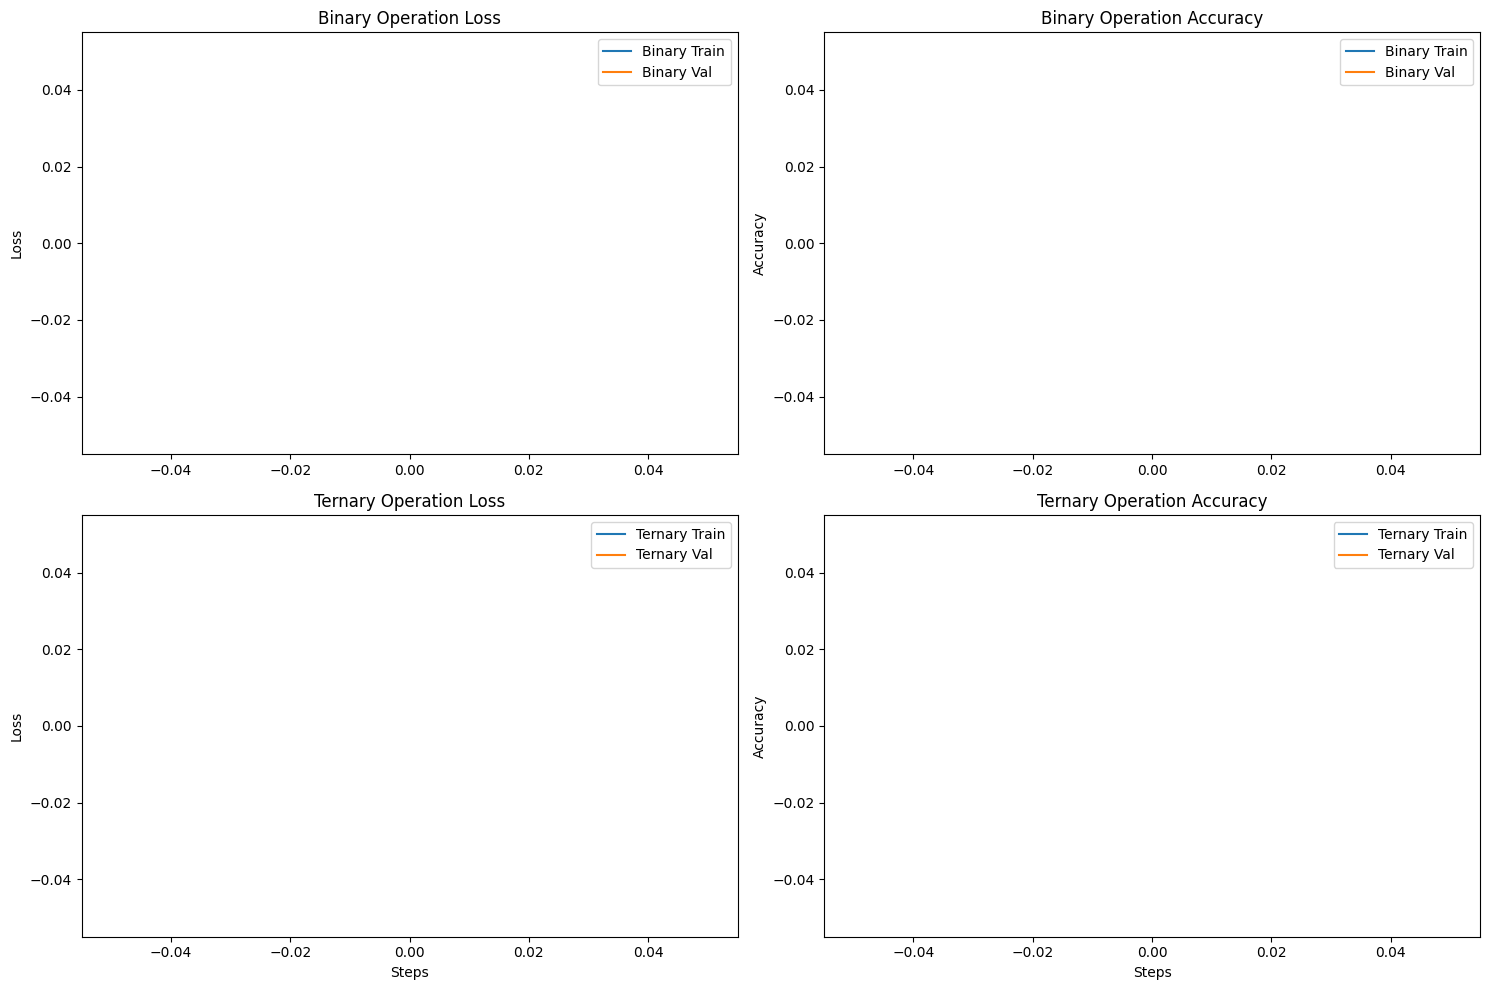

In [ ]:
# Train separate models
results = train_separate_operations(args)

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Binary results
binary_metrics = results['binary'][0]
axs[0,0].plot(binary_metrics['steps'], binary_metrics['train_loss'], label='Binary Train')
axs[0,0].plot(binary_metrics['steps'], binary_metrics['val_loss'], label='Binary Val')
axs[0,0].set_title('Binary Operation Loss')
axs[0,0].set_ylabel('Loss')
axs[0,0].legend()

axs[0,1].plot(binary_metrics['steps'], binary_metrics['train_acc'], label='Binary Train')
axs[0,1].plot(binary_metrics['steps'], binary_metrics['val_acc'], label='Binary Val')
axs[0,1].set_title('Binary Operation Accuracy')
axs[0,1].set_ylabel('Accuracy')
axs[0,1].legend()

# Ternary results
ternary_metrics = results['ternary'][0]
axs[1,0].plot(ternary_metrics['steps'], ternary_metrics['train_loss'], label='Ternary Train')
axs[1,0].plot(ternary_metrics['steps'], ternary_metrics['val_loss'], label='Ternary Val')
axs[1,0].set_title('Ternary Operation Loss')
axs[1,0].set_xlabel('Steps')
axs[1,0].set_ylabel('Loss')
axs[1,0].legend()

axs[1,1].plot(ternary_metrics['steps'], ternary_metrics['train_acc'], label='Ternary Train')
axs[1,1].plot(ternary_metrics['steps'], ternary_metrics['val_acc'], label='Ternary Val')
axs[1,1].set_title('Ternary Operation Accuracy')
axs[1,1].set_xlabel('Steps')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].legend()

plt.tight_layout()
plt.savefig('separate_operations_results.png')
plt.show()

In [ ]:
# Initialize configuration
args = Arguments()
args.p = 31
args.operator = "+"
args.r_train = 0.5
args.model = 'gpt'
args.n_steps = 10001
args.eval_period = 100
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.exp_name = "gpt_separate_ops"

# Train separate models
results = train_separate_operations(args)

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Binary results
binary_metrics = results['binary'][0]
axs[0,0].plot(binary_metrics['steps'], binary_metrics['train_loss'], label='Binary Train')
axs[0,0].plot(binary_metrics['steps'], binary_metrics['val_loss'], label='Binary Val')
axs[0,0].set_title('Binary Operation Loss')
axs[0,0].set_ylabel('Loss')
axs[0,0].legend()

axs[0,1].plot(binary_metrics['steps'], binary_metrics['train_acc'], label='Binary Train')
axs[0,1].plot(binary_metrics['steps'], binary_metrics['val_acc'], label='Binary Val')
axs[0,1].set_title('Binary Operation Accuracy')
axs[0,1].set_ylabel('Accuracy')
axs[0,1].legend()

# Ternary results
ternary_metrics = results['ternary'][0]
axs[1,0].plot(ternary_metrics['steps'], ternary_metrics['train_loss'], label='Ternary Train')
axs[1,0].plot(ternary_metrics['steps'], ternary_metrics['val_loss'], label='Ternary Val')
axs[1,0].set_title('Ternary Operation Loss')
axs[1,0].set_xlabel('Steps')
axs[1,0].set_ylabel('Loss')
axs[1,0].legend()

axs[1,1].plot(ternary_metrics['steps'], ternary_metrics['train_acc'], label='Ternary Train')
axs[1,1].plot(ternary_metrics['steps'], ternary_metrics['val_acc'], label='Ternary Val')
axs[1,1].set_title('Ternary Operation Accuracy')
axs[1,1].set_xlabel('Steps')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].legend()

plt.tight_layout()
plt.savefig('separate_operations_results.png')
plt.show()